# KE5105 - Building Electrical Consumption Forecasting

# Modelling 3 - Preliminary model

## Load libraries

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import datetime
import myUtilities as mu

from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

Using TensorFlow backend.


## Load data for building AS5

In [2]:
as5 = mu.load_data_by_bldg(['AS5'], 'processed')

In [3]:
as5[0][1].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 62880 entries, 2015-06-01 00:00:00 to 2018-12-31 23:30:00
Data columns (total 17 columns):
PWMMainIC                         46164 non-null float64
PWMEXTAS4ExBldg                   46165 non-null float64
PWMAS4LanguageCenter              46165 non-null float64
PWMCANTEEN                        46164 non-null float64
PWMStreetLight                    46164 non-null float64
BTUAS5                            46175 non-null float64
PWMMainIC_30min_avg               46117 non-null float64
PWMEXTAS4ExBldg_30min_avg         46118 non-null float64
PWMAS4LanguageCenter_30min_avg    46118 non-null float64
PWMCANTEEN_30min_avg              46117 non-null float64
PWMStreetLight_30min_avg          46117 non-null float64
BTUAS5_30min_avg                  46129 non-null float64
PWM_sumadd                        46117 non-null float64
PWM_sumsubtract                   46117 non-null float64
PWM_30min_avg                     46117 non-null float64
B

## Split the data into train and test set

In [4]:
as5_train_df = as5[0][1].loc['2015-06-12 08:00:00':'2017-03-31 23:30:00', :]

In [5]:
as5_train_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 31616 entries, 2015-06-12 08:00:00 to 2017-03-31 23:30:00
Data columns (total 17 columns):
PWMMainIC                         30018 non-null float64
PWMEXTAS4ExBldg                   30018 non-null float64
PWMAS4LanguageCenter              30018 non-null float64
PWMCANTEEN                        30018 non-null float64
PWMStreetLight                    30018 non-null float64
BTUAS5                            30029 non-null float64
PWMMainIC_30min_avg               29985 non-null float64
PWMEXTAS4ExBldg_30min_avg         29985 non-null float64
PWMAS4LanguageCenter_30min_avg    29985 non-null float64
PWMCANTEEN_30min_avg              29985 non-null float64
PWMStreetLight_30min_avg          29985 non-null float64
BTUAS5_30min_avg                  29998 non-null float64
PWM_sumadd                        29985 non-null float64
PWM_sumsubtract                   29985 non-null float64
PWM_30min_avg                     29985 non-null float64
B

In [6]:
as5_test_df = as5[0][1].loc['2018-01-01 00:00:00':, :]

In [7]:
as5_test_df.index.max()

Timestamp('2018-12-31 23:30:00')

In [8]:
as5_test_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17520 entries, 2018-01-01 00:00:00 to 2018-12-31 23:30:00
Data columns (total 17 columns):
PWMMainIC                         16145 non-null float64
PWMEXTAS4ExBldg                   16145 non-null float64
PWMAS4LanguageCenter              16145 non-null float64
PWMCANTEEN                        16145 non-null float64
PWMStreetLight                    16145 non-null float64
BTUAS5                            16144 non-null float64
PWMMainIC_30min_avg               16132 non-null float64
PWMEXTAS4ExBldg_30min_avg         16132 non-null float64
PWMAS4LanguageCenter_30min_avg    16132 non-null float64
PWMCANTEEN_30min_avg              16132 non-null float64
PWMStreetLight_30min_avg          16132 non-null float64
BTUAS5_30min_avg                  16130 non-null float64
PWM_sumadd                        16132 non-null float64
PWM_sumsubtract                   16132 non-null float64
PWM_30min_avg                     16132 non-null float64
B

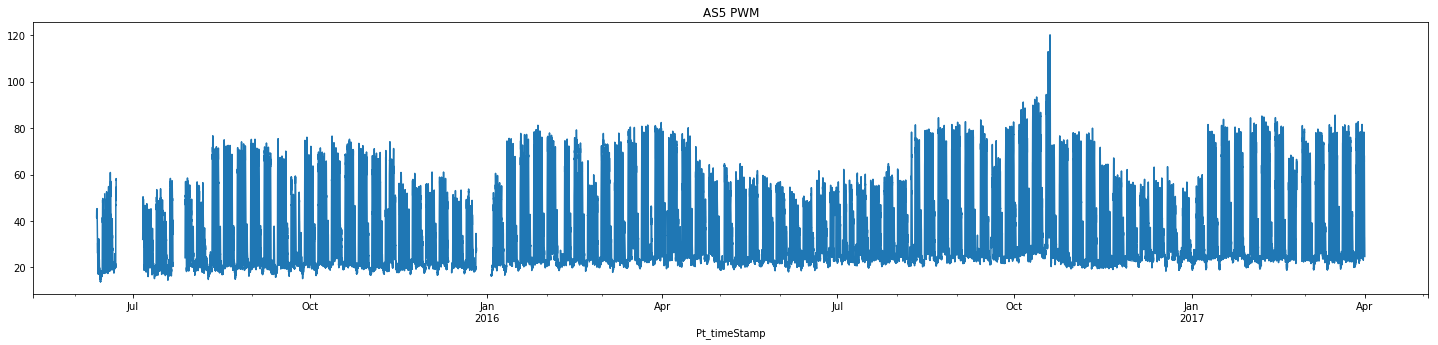

In [9]:
as5_train_df['PWM_30min_avg'].plot(figsize=(25, 5), title='AS5 PWM')

## Parameters for the RNN model

Also used for generating the datasets with the lagged values 

In [10]:
lookback = 240  # 5 days; each day has 48 observations
step = 1  # sampling rate used for the lookback period
delay = 0  # 1 step ahead prediction
batch_size = 128

## Normalise the training data

* Convert PWM and BTU values into the range 0 to 1
* Replace NaN with -1

In [11]:
# Create a transformation pipleline to prepare the training dataset for RNN.
attrbs = ['PWM_30min_avg', 'BTU_30min_avg']
my_pipeline = Pipeline([
    ('selector', mu.DataFrameSelector(attrbs)),
    ('minmax_scaler', MinMaxScaler()),
    ('na_transform', mu.Nan_to_Num_Transformer())
])

In [12]:
as5_train_data = my_pipeline.fit_transform(as5_train_df)
as5_train_data

array([[ 0.26254935,  0.56924225],
       [ 0.26724948,  0.53427896],
       [ 0.28031585,  0.53353241],
       ...,
       [ 0.12897161,  0.03222595],
       [ 0.10312089,  0.00348389],
       [-1.        , -1.        ]])

Text(0.5, 1.0, 'Normalised PWM Training Data')

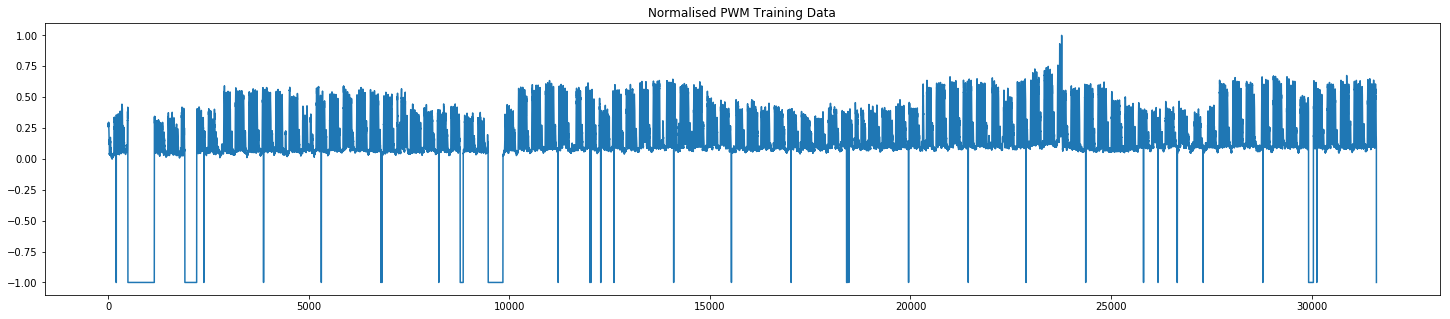

In [13]:
plt.figure(figsize=(25, 5))
plt.plot(range(as5_train_data.shape[0]), as5_train_data[:, 0])
plt.title('Normalised PWM Training Data')

Text(0.5, 1.0, 'Normalised BTU Training Data')

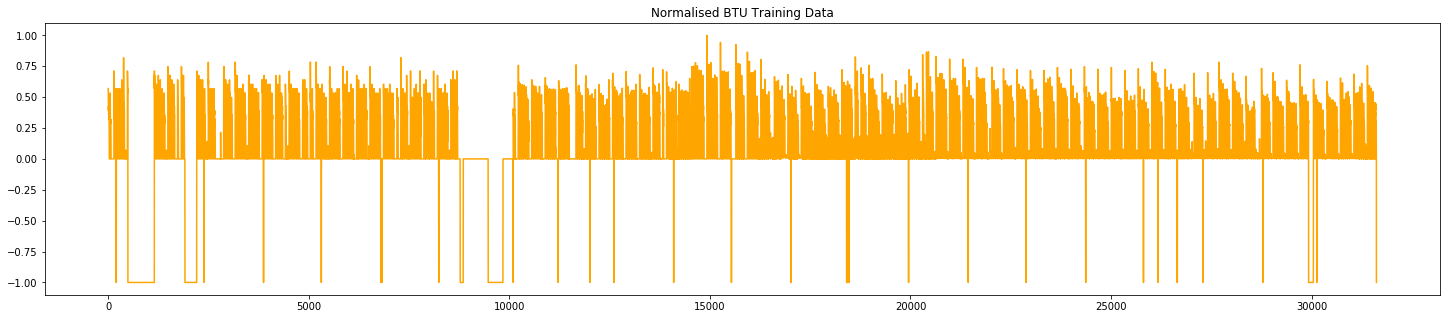

In [14]:
plt.figure(figsize=(25, 5))
plt.plot(range(as5_train_data.shape[0]), as5_train_data[:, 1], color='orange')
plt.title('Normalised BTU Training Data')

## Split a validation set out from the train set

In [16]:
as5_train_split = as5_train_data[:20000]
as5_val_split = as5_train_data[20000:]

In [17]:
print('train split = %s\nvalidation split = %s' % (as5_train_split.shape, as5_val_split.shape))

train split = (20000, 2)
validation split = (11616, 2)


## Two-layer RNN Model (2 x 16)

In [18]:
model = Sequential()
model.add(layers.GRU(16, return_sequences=True, input_shape=(None, as5_train_split.shape[-1])))
model.add(layers.GRU(16))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae', metrics=['mape'])

In [19]:
gen_train = mu.DataGenerator(as5_train_split,
                             lookback=lookback, delay=delay, min_index=0, max_index=len(as5_train_split) - 1,
                             batch_size=batch_size, step=step)
gen_val = mu.DataGenerator(as5_val_split,
                           lookback=lookback, delay=delay, min_index=0, max_index=len(as5_val_split) - 1,
                           batch_size=batch_size, step=step)

In [20]:
gen_train.__len__()

143

In [21]:
gen_val.__len__()

88

### Train the RNN

In [22]:
t1 = datetime.datetime.now()
history = model.fit_generator(generator=gen_train, epochs=80,
                              validation_data=gen_val,
                              workers=4, use_multiprocessing=True, shuffle=True)
print('\nTraining Duration = %s' % (datetime.datetime.now()-t1))

Epoch 1/80


  1/143 [..............................] - ETA: 3:18 - loss: 0.2462 - mean_absolute_percentage_error: 106.7451

  2/143 [..............................] - ETA: 2:00 - loss: 0.2081 - mean_absolute_percentage_error: 85.1905 

  3/143 [..............................] - ETA: 1:33 - loss: 0.1888 - mean_absolute_percentage_error: 73.1456

  4/143 [..............................] - ETA: 1:20 - loss: 0.1631 - mean_absolute_percentage_error: 65.9359

  5/143 [>.............................] - ETA: 1:12 - loss: 0.1428 - mean_absolute_percentage_error: 57.3097

  6/143 [>.............................] - ETA: 1:06 - loss: 0.1470 - mean_absolute_percentage_error: 54.2991

  7/143 [>.............................] - ETA: 1:02 - loss: 0.1373 - mean_absolute_percentage_error: 52.6741

  8/143 [>.............................] - ETA: 59s - loss: 0.1265 - mean_absolute_percentage_error: 50.5503 

  9/143 [>.............................] - ETA: 56s - loss: 0.1203 - mean_absolute_percentage_error: 48.1856

 10/143 [=>............................] - ETA: 54s - loss: 0.1130 - mean_absolute_percentage_error: 47.4194

 11/143 [=>............................] - ETA: 52s - loss: 0.1074 - mean_absolute_percentage_error: 45.2890

 12/143 [=>............................] - ETA: 51s - loss: 0.1083 - mean_absolute_percentage_error: 45.4526

 13/143 [=>............................] - ETA: 49s - loss: 0.1035 - mean_absolute_percentage_error: 45.2578

 14/143 [=>............................] - ETA: 48s - loss: 0.0991 - mean_absolute_percentage_error: 46.3911

 15/143 [==>...........................] - ETA: 47s - loss: 0.0960 - mean_absolute_percentage_error: 44.8120

 16/143 [==>...........................] - ETA: 46s - loss: 0.0932 - mean_absolute_percentage_error: 43.4847

 17/143 [==>...........................] - ETA: 45s - loss: 0.0910 - mean_absolute_percentage_error: 42.6112

 18/143 [==>...........................] - ETA: 44s - loss: 0.0888 - mean_absolute_percentage_error: 41.6486

 19/143 [==>...........................] - ETA: 43s - loss: 0.0867 - mean_absolute_percentage_error: 43.7915

 20/143 [===>..........................] - ETA: 43s - loss: 0.0844 - mean_absolute_percentage_error: 42.5783

 21/143 [===>..........................] - ETA: 42s - loss: 0.0819 - mean_absolute_percentage_error: 41.6584

 22/143 [===>..........................] - ETA: 41s - loss: 0.0803 - mean_absolute_percentage_error: 41.1375

 23/143 [===>..........................] - ETA: 41s - loss: 0.0799 - mean_absolute_percentage_error: 40.8550

 24/143 [====>.........................] - ETA: 40s - loss: 0.0785 - mean_absolute_percentage_error: 40.5873

 25/143 [====>.........................] - ETA: 40s - loss: 0.0784 - mean_absolute_percentage_error: 40.3010

 26/143 [====>.........................] - ETA: 39s - loss: 0.0768 - mean_absolute_percentage_error: 40.6306

 27/143 [====>.........................] - ETA: 38s - loss: 0.0752 - mean_absolute_percentage_error: 40.0655

 28/143 [====>.........................] - ETA: 38s - loss: 0.0736 - mean_absolute_percentage_error: 39.4315

 29/143 [=====>........................] - ETA: 37s - loss: 0.0727 - mean_absolute_percentage_error: 39.0619

 30/143 [=====>........................] - ETA: 37s - loss: 0.0726 - mean_absolute_percentage_error: 39.0438

 31/143 [=====>........................] - ETA: 36s - loss: 0.0724 - mean_absolute_percentage_error: 39.4730

 32/143 [=====>........................] - ETA: 36s - loss: 0.0727 - mean_absolute_percentage_error: 39.2541

 33/143 [=====>........................] - ETA: 36s - loss: 0.0717 - mean_absolute_percentage_error: 39.1715

 34/143 [======>.......................] - ETA: 35s - loss: 0.0710 - mean_absolute_percentage_error: 39.0664

 35/143 [======>.......................] - ETA: 35s - loss: 0.0701 - mean_absolute_percentage_error: 38.6894

 36/143 [======>.......................] - ETA: 34s - loss: 0.0698 - mean_absolute_percentage_error: 39.9476

 37/143 [======>.......................] - ETA: 34s - loss: 0.0688 - mean_absolute_percentage_error: 39.6671

 38/143 [======>.......................] - ETA: 33s - loss: 0.0681 - mean_absolute_percentage_error: 39.2565

 39/143 [=======>......................] - ETA: 33s - loss: 0.0679 - mean_absolute_percentage_error: 38.9750

 40/143 [=======>......................] - ETA: 33s - loss: 0.0677 - mean_absolute_percentage_error: 38.9052

 41/143 [=======>......................] - ETA: 32s - loss: 0.0673 - mean_absolute_percentage_error: 38.9912

 42/143 [=======>......................] - ETA: 32s - loss: 0.0667 - mean_absolute_percentage_error: 39.0405

 43/143 [========>.....................] - ETA: 31s - loss: 0.0666 - mean_absolute_percentage_error: 38.8144

 44/143 [========>.....................] - ETA: 31s - loss: 0.0665 - mean_absolute_percentage_error: 38.6565

 45/143 [========>.....................] - ETA: 31s - loss: 0.0666 - mean_absolute_percentage_error: 39.0031

 46/143 [========>.....................] - ETA: 30s - loss: 0.0660 - mean_absolute_percentage_error: 38.5759

 47/143 [========>.....................] - ETA: 30s - loss: 0.0653 - mean_absolute_percentage_error: 38.1388

 48/143 [=========>....................] - ETA: 30s - loss: 0.0652 - mean_absolute_percentage_error: 38.1244

 49/143 [=========>....................] - ETA: 29s - loss: 0.0647 - mean_absolute_percentage_error: 38.0049

 50/143 [=========>....................] - ETA: 29s - loss: 0.0643 - mean_absolute_percentage_error: 37.7764

 51/143 [=========>....................] - ETA: 28s - loss: 0.0637 - mean_absolute_percentage_error: 37.4770

 52/143 [=========>....................] - ETA: 28s - loss: 0.0639 - mean_absolute_percentage_error: 37.3641

 53/143 [==========>...................] - ETA: 28s - loss: 0.0631 - mean_absolute_percentage_error: 37.0097

 54/143 [==========>...................] - ETA: 27s - loss: 0.0632 - mean_absolute_percentage_error: 36.7943

 55/143 [==========>...................] - ETA: 27s - loss: 0.0628 - mean_absolute_percentage_error: 36.8969

 56/143 [==========>...................] - ETA: 27s - loss: 0.0622 - mean_absolute_percentage_error: 36.5887

 57/143 [==========>...................] - ETA: 26s - loss: 0.0616 - mean_absolute_percentage_error: 36.3195

 58/143 [===========>..................] - ETA: 26s - loss: 0.0612 - mean_absolute_percentage_error: 35.9944

 59/143 [===========>..................] - ETA: 26s - loss: 0.0610 - mean_absolute_percentage_error: 35.9530

 60/143 [===========>..................] - ETA: 25s - loss: 0.0607 - mean_absolute_percentage_error: 35.7262

 61/143 [===========>..................] - ETA: 25s - loss: 0.0601 - mean_absolute_percentage_error: 35.5092

 62/143 [============>.................] - ETA: 25s - loss: 0.0595 - mean_absolute_percentage_error: 35.2692

 63/143 [============>.................] - ETA: 24s - loss: 0.0594 - mean_absolute_percentage_error: 35.0502

 64/143 [============>.................] - ETA: 24s - loss: 0.0592 - mean_absolute_percentage_error: 34.8922

 65/143 [============>.................] - ETA: 24s - loss: 0.0590 - mean_absolute_percentage_error: 34.9228

 66/143 [============>.................] - ETA: 23s - loss: 0.0587 - mean_absolute_percentage_error: 34.7172

 67/143 [=============>................] - ETA: 23s - loss: 0.0585 - mean_absolute_percentage_error: 34.5009

 68/143 [=============>................] - ETA: 23s - loss: 0.0583 - mean_absolute_percentage_error: 34.2767

 69/143 [=============>................] - ETA: 22s - loss: 0.0581 - mean_absolute_percentage_error: 34.3596

 70/143 [=============>................] - ETA: 22s - loss: 0.0579 - mean_absolute_percentage_error: 34.1912

 71/143 [=============>................] - ETA: 22s - loss: 0.0575 - mean_absolute_percentage_error: 34.1452

 72/143 [==============>...............] - ETA: 21s - loss: 0.0576 - mean_absolute_percentage_error: 34.0029

 73/143 [==============>...............] - ETA: 21s - loss: 0.0575 - mean_absolute_percentage_error: 33.9982

 74/143 [==============>...............] - ETA: 21s - loss: 0.0570 - mean_absolute_percentage_error: 33.7448

 75/143 [==============>...............] - ETA: 20s - loss: 0.0569 - mean_absolute_percentage_error: 33.6197

 76/143 [==============>...............] - ETA: 20s - loss: 0.0567 - mean_absolute_percentage_error: 33.4113

 77/143 [===============>..............] - ETA: 20s - loss: 0.0564 - mean_absolute_percentage_error: 33.3429

 78/143 [===============>..............] - ETA: 19s - loss: 0.0562 - mean_absolute_percentage_error: 33.1417

 79/143 [===============>..............] - ETA: 19s - loss: 0.0560 - mean_absolute_percentage_error: 33.0068

 80/143 [===============>..............] - ETA: 19s - loss: 0.0559 - mean_absolute_percentage_error: 32.8551

 81/143 [===============>..............] - ETA: 18s - loss: 0.0558 - mean_absolute_percentage_error: 32.8435

 82/143 [================>.............] - ETA: 18s - loss: 0.0559 - mean_absolute_percentage_error: 33.1826

 83/143 [================>.............] - ETA: 18s - loss: 0.0556 - mean_absolute_percentage_error: 33.1578

 84/143 [================>.............] - ETA: 17s - loss: 0.0554 - mean_absolute_percentage_error: 32.9879

 85/143 [================>.............] - ETA: 17s - loss: 0.0550 - mean_absolute_percentage_error: 32.7860

 86/143 [=================>............] - ETA: 17s - loss: 0.0547 - mean_absolute_percentage_error: 32.6054

 87/143 [=================>............] - ETA: 17s - loss: 0.0545 - mean_absolute_percentage_error: 32.6035

 88/143 [=================>............] - ETA: 16s - loss: 0.0543 - mean_absolute_percentage_error: 32.5690

 89/143 [=================>............] - ETA: 16s - loss: 0.0541 - mean_absolute_percentage_error: 32.4720

 90/143 [=================>............] - ETA: 16s - loss: 0.0537 - mean_absolute_percentage_error: 32.3632

 91/143 [==================>...........] - ETA: 15s - loss: 0.0535 - mean_absolute_percentage_error: 32.2297

 92/143 [==================>...........] - ETA: 15s - loss: 0.0531 - mean_absolute_percentage_error: 32.0237

 93/143 [==================>...........] - ETA: 15s - loss: 0.0529 - mean_absolute_percentage_error: 31.8500

 94/143 [==================>...........] - ETA: 14s - loss: 0.0527 - mean_absolute_percentage_error: 31.9758

 95/143 [==================>...........] - ETA: 14s - loss: 0.0523 - mean_absolute_percentage_error: 31.8566

 96/143 [===================>..........] - ETA: 14s - loss: 0.0521 - mean_absolute_percentage_error: 31.7142

 97/143 [===================>..........] - ETA: 13s - loss: 0.0520 - mean_absolute_percentage_error: 31.5912

 98/143 [===================>..........] - ETA: 13s - loss: 0.0518 - mean_absolute_percentage_error: 31.9101

 99/143 [===================>..........] - ETA: 13s - loss: 0.0521 - mean_absolute_percentage_error: 31.8298

100/143 [===================>..........] - ETA: 13s - loss: 0.0520 - mean_absolute_percentage_error: 31.9101

101/143 [====================>.........] - ETA: 12s - loss: 0.0518 - mean_absolute_percentage_error: 31.7293

102/143 [====================>.........] - ETA: 12s - loss: 0.0518 - mean_absolute_percentage_error: 31.6961

103/143 [====================>.........] - ETA: 12s - loss: 0.0518 - mean_absolute_percentage_error: 31.6547

104/143 [====================>.........] - ETA: 11s - loss: 0.0517 - mean_absolute_percentage_error: 31.5384

105/143 [=====================>........] - ETA: 11s - loss: 0.0514 - mean_absolute_percentage_error: 31.4040

106/143 [=====================>........] - ETA: 11s - loss: 0.0512 - mean_absolute_percentage_error: 31.2514

107/143 [=====================>........] - ETA: 10s - loss: 0.0511 - mean_absolute_percentage_error: 31.3467

108/143 [=====================>........] - ETA: 10s - loss: 0.0508 - mean_absolute_percentage_error: 31.1856

109/143 [=====================>........] - ETA: 10s - loss: 0.0507 - mean_absolute_percentage_error: 31.0954

110/143 [======================>.......] - ETA: 9s - loss: 0.0505 - mean_absolute_percentage_error: 31.0534 

111/143 [======================>.......] - ETA: 9s - loss: 0.0503 - mean_absolute_percentage_error: 30.9457

112/143 [======================>.......] - ETA: 9s - loss: 0.0502 - mean_absolute_percentage_error: 30.8593

113/143 [======================>.......] - ETA: 9s - loss: 0.0500 - mean_absolute_percentage_error: 30.7231

114/143 [======================>.......] - ETA: 8s - loss: 0.0499 - mean_absolute_percentage_error: 30.6203

115/143 [=======================>......] - ETA: 8s - loss: 0.0497 - mean_absolute_percentage_error: 30.4937

116/143 [=======================>......] - ETA: 8s - loss: 0.0496 - mean_absolute_percentage_error: 30.3937

117/143 [=======================>......] - ETA: 7s - loss: 0.0495 - mean_absolute_percentage_error: 30.3310

118/143 [=======================>......] - ETA: 7s - loss: 0.0493 - mean_absolute_percentage_error: 30.2531

119/143 [=======================>......] - ETA: 7s - loss: 0.0492 - mean_absolute_percentage_error: 30.1738

120/143 [========================>.....] - ETA: 6s - loss: 0.0491 - mean_absolute_percentage_error: 30.0683

121/143 [========================>.....] - ETA: 6s - loss: 0.0490 - mean_absolute_percentage_error: 30.0448

122/143 [========================>.....] - ETA: 6s - loss: 0.0489 - mean_absolute_percentage_error: 29.9214

123/143 [========================>.....] - ETA: 6s - loss: 0.0487 - mean_absolute_percentage_error: 29.8126

124/143 [=========================>....] - ETA: 5s - loss: 0.0485 - mean_absolute_percentage_error: 29.6769

125/143 [=========================>....] - ETA: 5s - loss: 0.0484 - mean_absolute_percentage_error: 29.5676

126/143 [=========================>....] - ETA: 5s - loss: 0.0483 - mean_absolute_percentage_error: 29.4688

127/143 [=========================>....] - ETA: 4s - loss: 0.0481 - mean_absolute_percentage_error: 29.4242

128/143 [=========================>....] - ETA: 4s - loss: 0.0481 - mean_absolute_percentage_error: 29.3798

129/143 [==========================>...] - ETA: 4s - loss: 0.0479 - mean_absolute_percentage_error: 29.2871

130/143 [==========================>...] - ETA: 3s - loss: 0.0478 - mean_absolute_percentage_error: 29.1843

131/143 [==========================>...] - ETA: 3s - loss: 0.0477 - mean_absolute_percentage_error: 29.5707

132/143 [==========================>...] - ETA: 3s - loss: 0.0475 - mean_absolute_percentage_error: 29.4774

133/143 [==========================>...] - ETA: 2s - loss: 0.0474 - mean_absolute_percentage_error: 29.4037

134/143 [===========================>..] - ETA: 2s - loss: 0.0473 - mean_absolute_percentage_error: 29.5419

135/143 [===========================>..] - ETA: 2s - loss: 0.0473 - mean_absolute_percentage_error: 29.4652

136/143 [===========================>..] - ETA: 2s - loss: 0.0472 - mean_absolute_percentage_error: 29.3743

137/143 [===========================>..] - ETA: 1s - loss: 0.0471 - mean_absolute_percentage_error: 29.3651

138/143 [===========================>..] - ETA: 1s - loss: 0.0471 - mean_absolute_percentage_error: 29.2755

139/143 [============================>.] - ETA: 1s - loss: 0.0469 - mean_absolute_percentage_error: 29.2277

140/143 [============================>.] - ETA: 0s - loss: 0.0467 - mean_absolute_percentage_error: 29.1276

141/143 [============================>.] - ETA: 0s - loss: 0.0468 - mean_absolute_percentage_error: 29.2311

142/143 [============================>.] - ETA: 0s - loss: 0.0468 - mean_absolute_percentage_error: 29.1481

143/143 [==============================] - 49s 340ms/step - loss: 0.0465 - mean_absolute_percentage_error: 29.0530 - val_loss: 0.0422 - val_mean_absolute_percentage_error: 20.5077


Epoch 2/80


  1/143 [..............................] - ETA: 43s - loss: 0.0200 - mean_absolute_percentage_error: 20.5773

  2/143 [..............................] - ETA: 41s - loss: 0.0151 - mean_absolute_percentage_error: 17.3509

  3/143 [..............................] - ETA: 41s - loss: 0.0175 - mean_absolute_percentage_error: 17.3923

  4/143 [..............................] - ETA: 40s - loss: 0.0220 - mean_absolute_percentage_error: 17.6885

  5/143 [>.............................] - ETA: 40s - loss: 0.0234 - mean_absolute_percentage_error: 17.2222

  6/143 [>.............................] - ETA: 40s - loss: 0.0229 - mean_absolute_percentage_error: 16.9570

  7/143 [>.............................] - ETA: 40s - loss: 0.0225 - mean_absolute_percentage_error: 16.6910

  8/143 [>.............................] - ETA: 39s - loss: 0.0231 - mean_absolute_percentage_error: 17.0801

  9/143 [>.............................] - ETA: 39s - loss: 0.0249 - mean_absolute_percentage_error: 17.1084

 10/143 [=>............................] - ETA: 39s - loss: 0.0264 - mean_absolute_percentage_error: 16.9624

 11/143 [=>............................] - ETA: 38s - loss: 0.0258 - mean_absolute_percentage_error: 16.7711

 12/143 [=>............................] - ETA: 38s - loss: 0.0256 - mean_absolute_percentage_error: 16.6426

 13/143 [=>............................] - ETA: 38s - loss: 0.0253 - mean_absolute_percentage_error: 17.3258

 14/143 [=>............................] - ETA: 37s - loss: 0.0264 - mean_absolute_percentage_error: 17.6159

 15/143 [==>...........................] - ETA: 37s - loss: 0.0265 - mean_absolute_percentage_error: 18.1356

 16/143 [==>...........................] - ETA: 37s - loss: 0.0270 - mean_absolute_percentage_error: 18.2213

 17/143 [==>...........................] - ETA: 36s - loss: 0.0285 - mean_absolute_percentage_error: 19.4651

 18/143 [==>...........................] - ETA: 36s - loss: 0.0291 - mean_absolute_percentage_error: 19.7422

 19/143 [==>...........................] - ETA: 36s - loss: 0.0293 - mean_absolute_percentage_error: 19.5660

 20/143 [===>..........................] - ETA: 35s - loss: 0.0294 - mean_absolute_percentage_error: 19.5164

 21/143 [===>..........................] - ETA: 35s - loss: 0.0300 - mean_absolute_percentage_error: 19.3739

 22/143 [===>..........................] - ETA: 35s - loss: 0.0306 - mean_absolute_percentage_error: 19.4440

 23/143 [===>..........................] - ETA: 35s - loss: 0.0304 - mean_absolute_percentage_error: 19.2005

 24/143 [====>.........................] - ETA: 34s - loss: 0.0300 - mean_absolute_percentage_error: 18.8751

 25/143 [====>.........................] - ETA: 34s - loss: 0.0304 - mean_absolute_percentage_error: 18.7553

 26/143 [====>.........................] - ETA: 34s - loss: 0.0306 - mean_absolute_percentage_error: 18.9396

 27/143 [====>.........................] - ETA: 33s - loss: 0.0304 - mean_absolute_percentage_error: 18.8773

 28/143 [====>.........................] - ETA: 33s - loss: 0.0308 - mean_absolute_percentage_error: 18.7977

 29/143 [=====>........................] - ETA: 33s - loss: 0.0306 - mean_absolute_percentage_error: 18.9159

 30/143 [=====>........................] - ETA: 32s - loss: 0.0301 - mean_absolute_percentage_error: 18.7211

 31/143 [=====>........................] - ETA: 32s - loss: 0.0300 - mean_absolute_percentage_error: 18.7789

 32/143 [=====>........................] - ETA: 32s - loss: 0.0310 - mean_absolute_percentage_error: 18.8128

 33/143 [=====>........................] - ETA: 32s - loss: 0.0312 - mean_absolute_percentage_error: 19.0550

 34/143 [======>.......................] - ETA: 31s - loss: 0.0308 - mean_absolute_percentage_error: 18.9414

 35/143 [======>.......................] - ETA: 31s - loss: 0.0311 - mean_absolute_percentage_error: 18.8472

 36/143 [======>.......................] - ETA: 31s - loss: 0.0311 - mean_absolute_percentage_error: 19.3145

 37/143 [======>.......................] - ETA: 30s - loss: 0.0309 - mean_absolute_percentage_error: 19.1029

 38/143 [======>.......................] - ETA: 30s - loss: 0.0307 - mean_absolute_percentage_error: 18.9043

 39/143 [=======>......................] - ETA: 30s - loss: 0.0305 - mean_absolute_percentage_error: 18.7444

 40/143 [=======>......................] - ETA: 30s - loss: 0.0304 - mean_absolute_percentage_error: 18.6214

 41/143 [=======>......................] - ETA: 29s - loss: 0.0304 - mean_absolute_percentage_error: 18.5379

 42/143 [=======>......................] - ETA: 29s - loss: 0.0302 - mean_absolute_percentage_error: 18.3911

 43/143 [========>.....................] - ETA: 29s - loss: 0.0302 - mean_absolute_percentage_error: 18.7966

 44/143 [========>.....................] - ETA: 28s - loss: 0.0304 - mean_absolute_percentage_error: 18.7880

 45/143 [========>.....................] - ETA: 28s - loss: 0.0305 - mean_absolute_percentage_error: 18.7539

 46/143 [========>.....................] - ETA: 28s - loss: 0.0306 - mean_absolute_percentage_error: 18.9547

 47/143 [========>.....................] - ETA: 27s - loss: 0.0304 - mean_absolute_percentage_error: 18.9839

 48/143 [=========>....................] - ETA: 27s - loss: 0.0304 - mean_absolute_percentage_error: 18.9299

 49/143 [=========>....................] - ETA: 27s - loss: 0.0302 - mean_absolute_percentage_error: 18.9508

 50/143 [=========>....................] - ETA: 27s - loss: 0.0303 - mean_absolute_percentage_error: 18.9526

 51/143 [=========>....................] - ETA: 26s - loss: 0.0305 - mean_absolute_percentage_error: 19.1770

 52/143 [=========>....................] - ETA: 26s - loss: 0.0305 - mean_absolute_percentage_error: 19.3517

 53/143 [==========>...................] - ETA: 26s - loss: 0.0304 - mean_absolute_percentage_error: 19.1840

 54/143 [==========>...................] - ETA: 25s - loss: 0.0306 - mean_absolute_percentage_error: 19.9714

 55/143 [==========>...................] - ETA: 25s - loss: 0.0307 - mean_absolute_percentage_error: 20.3008

 56/143 [==========>...................] - ETA: 25s - loss: 0.0309 - mean_absolute_percentage_error: 20.5381

 57/143 [==========>...................] - ETA: 25s - loss: 0.0308 - mean_absolute_percentage_error: 20.5137

 58/143 [===========>..................] - ETA: 24s - loss: 0.0306 - mean_absolute_percentage_error: 20.3608

 59/143 [===========>..................] - ETA: 24s - loss: 0.0305 - mean_absolute_percentage_error: 20.2711

 60/143 [===========>..................] - ETA: 24s - loss: 0.0302 - mean_absolute_percentage_error: 20.2478

 61/143 [===========>..................] - ETA: 23s - loss: 0.0302 - mean_absolute_percentage_error: 20.1478

 62/143 [============>.................] - ETA: 23s - loss: 0.0303 - mean_absolute_percentage_error: 20.1919

 63/143 [============>.................] - ETA: 23s - loss: 0.0301 - mean_absolute_percentage_error: 20.1532

 64/143 [============>.................] - ETA: 23s - loss: 0.0305 - mean_absolute_percentage_error: 20.4896

 65/143 [============>.................] - ETA: 22s - loss: 0.0304 - mean_absolute_percentage_error: 20.4600

 66/143 [============>.................] - ETA: 22s - loss: 0.0302 - mean_absolute_percentage_error: 20.3510

 67/143 [=============>................] - ETA: 22s - loss: 0.0301 - mean_absolute_percentage_error: 20.2540

 68/143 [=============>................] - ETA: 21s - loss: 0.0299 - mean_absolute_percentage_error: 20.2528

 69/143 [=============>................] - ETA: 21s - loss: 0.0299 - mean_absolute_percentage_error: 20.1480

 70/143 [=============>................] - ETA: 21s - loss: 0.0299 - mean_absolute_percentage_error: 20.0677

 71/143 [=============>................] - ETA: 21s - loss: 0.0301 - mean_absolute_percentage_error: 20.0285

 72/143 [==============>...............] - ETA: 20s - loss: 0.0301 - mean_absolute_percentage_error: 20.0529

 73/143 [==============>...............] - ETA: 20s - loss: 0.0301 - mean_absolute_percentage_error: 20.0091

 74/143 [==============>...............] - ETA: 20s - loss: 0.0301 - mean_absolute_percentage_error: 20.0100

 75/143 [==============>...............] - ETA: 19s - loss: 0.0300 - mean_absolute_percentage_error: 19.9809

 76/143 [==============>...............] - ETA: 19s - loss: 0.0300 - mean_absolute_percentage_error: 19.8972

 77/143 [===============>..............] - ETA: 19s - loss: 0.0300 - mean_absolute_percentage_error: 19.9083

 78/143 [===============>..............] - ETA: 19s - loss: 0.0302 - mean_absolute_percentage_error: 19.8627

 79/143 [===============>..............] - ETA: 18s - loss: 0.0303 - mean_absolute_percentage_error: 19.8324

 80/143 [===============>..............] - ETA: 18s - loss: 0.0303 - mean_absolute_percentage_error: 19.7627

 81/143 [===============>..............] - ETA: 18s - loss: 0.0303 - mean_absolute_percentage_error: 19.7221

 82/143 [================>.............] - ETA: 18s - loss: 0.0301 - mean_absolute_percentage_error: 19.6680

 83/143 [================>.............] - ETA: 17s - loss: 0.0301 - mean_absolute_percentage_error: 19.6123

 84/143 [================>.............] - ETA: 17s - loss: 0.0301 - mean_absolute_percentage_error: 19.5796

 85/143 [================>.............] - ETA: 17s - loss: 0.0300 - mean_absolute_percentage_error: 19.4963

 86/143 [=================>............] - ETA: 16s - loss: 0.0299 - mean_absolute_percentage_error: 19.3909

 87/143 [=================>............] - ETA: 16s - loss: 0.0299 - mean_absolute_percentage_error: 19.3153

 88/143 [=================>............] - ETA: 16s - loss: 0.0299 - mean_absolute_percentage_error: 19.2745

 89/143 [=================>............] - ETA: 15s - loss: 0.0299 - mean_absolute_percentage_error: 19.2360

 90/143 [=================>............] - ETA: 15s - loss: 0.0299 - mean_absolute_percentage_error: 19.2723

 91/143 [==================>...........] - ETA: 15s - loss: 0.0298 - mean_absolute_percentage_error: 19.1927

 92/143 [==================>...........] - ETA: 15s - loss: 0.0296 - mean_absolute_percentage_error: 19.1147

 93/143 [==================>...........] - ETA: 14s - loss: 0.0296 - mean_absolute_percentage_error: 19.0546

 94/143 [==================>...........] - ETA: 14s - loss: 0.0296 - mean_absolute_percentage_error: 19.0014

 95/143 [==================>...........] - ETA: 14s - loss: 0.0296 - mean_absolute_percentage_error: 18.9554

 96/143 [===================>..........] - ETA: 13s - loss: 0.0296 - mean_absolute_percentage_error: 19.0485

 97/143 [===================>..........] - ETA: 13s - loss: 0.0295 - mean_absolute_percentage_error: 19.0562

 98/143 [===================>..........] - ETA: 13s - loss: 0.0294 - mean_absolute_percentage_error: 19.1574

 99/143 [===================>..........] - ETA: 12s - loss: 0.0294 - mean_absolute_percentage_error: 19.0983

100/143 [===================>..........] - ETA: 12s - loss: 0.0294 - mean_absolute_percentage_error: 19.0486

101/143 [====================>.........] - ETA: 12s - loss: 0.0293 - mean_absolute_percentage_error: 19.1651

102/143 [====================>.........] - ETA: 12s - loss: 0.0293 - mean_absolute_percentage_error: 19.1083

103/143 [====================>.........] - ETA: 11s - loss: 0.0293 - mean_absolute_percentage_error: 19.1850

104/143 [====================>.........] - ETA: 11s - loss: 0.0292 - mean_absolute_percentage_error: 19.2044

105/143 [=====================>........] - ETA: 11s - loss: 0.0292 - mean_absolute_percentage_error: 19.2837

106/143 [=====================>........] - ETA: 10s - loss: 0.0292 - mean_absolute_percentage_error: 19.2345

107/143 [=====================>........] - ETA: 10s - loss: 0.0291 - mean_absolute_percentage_error: 19.1962

108/143 [=====================>........] - ETA: 10s - loss: 0.0290 - mean_absolute_percentage_error: 19.1635

109/143 [=====================>........] - ETA: 10s - loss: 0.0290 - mean_absolute_percentage_error: 19.1316

110/143 [======================>.......] - ETA: 9s - loss: 0.0290 - mean_absolute_percentage_error: 19.1097 

111/143 [======================>.......] - ETA: 9s - loss: 0.0290 - mean_absolute_percentage_error: 19.0846

112/143 [======================>.......] - ETA: 9s - loss: 0.0289 - mean_absolute_percentage_error: 19.0338

113/143 [======================>.......] - ETA: 8s - loss: 0.0288 - mean_absolute_percentage_error: 18.9840

114/143 [======================>.......] - ETA: 8s - loss: 0.0289 - mean_absolute_percentage_error: 18.9425

115/143 [=======================>......] - ETA: 8s - loss: 0.0288 - mean_absolute_percentage_error: 19.1587

116/143 [=======================>......] - ETA: 7s - loss: 0.0289 - mean_absolute_percentage_error: 19.6962

117/143 [=======================>......] - ETA: 7s - loss: 0.0288 - mean_absolute_percentage_error: 19.6246

118/143 [=======================>......] - ETA: 7s - loss: 0.0287 - mean_absolute_percentage_error: 19.5644

119/143 [=======================>......] - ETA: 7s - loss: 0.0286 - mean_absolute_percentage_error: 19.5699

120/143 [========================>.....] - ETA: 6s - loss: 0.0286 - mean_absolute_percentage_error: 19.5299

121/143 [========================>.....] - ETA: 6s - loss: 0.0285 - mean_absolute_percentage_error: 19.4896

122/143 [========================>.....] - ETA: 6s - loss: 0.0284 - mean_absolute_percentage_error: 19.4274

123/143 [========================>.....] - ETA: 5s - loss: 0.0284 - mean_absolute_percentage_error: 19.3852

124/143 [=========================>....] - ETA: 5s - loss: 0.0283 - mean_absolute_percentage_error: 19.3355

125/143 [=========================>....] - ETA: 5s - loss: 0.0283 - mean_absolute_percentage_error: 19.3007

126/143 [=========================>....] - ETA: 5s - loss: 0.0283 - mean_absolute_percentage_error: 19.2758

127/143 [=========================>....] - ETA: 4s - loss: 0.0285 - mean_absolute_percentage_error: 19.2683

128/143 [=========================>....] - ETA: 4s - loss: 0.0284 - mean_absolute_percentage_error: 19.2330

129/143 [==========================>...] - ETA: 4s - loss: 0.0284 - mean_absolute_percentage_error: 19.1855

130/143 [==========================>...] - ETA: 3s - loss: 0.0285 - mean_absolute_percentage_error: 19.2224

131/143 [==========================>...] - ETA: 3s - loss: 0.0285 - mean_absolute_percentage_error: 19.1845

132/143 [==========================>...] - ETA: 3s - loss: 0.0285 - mean_absolute_percentage_error: 19.2325

133/143 [==========================>...] - ETA: 2s - loss: 0.0284 - mean_absolute_percentage_error: 19.1892

134/143 [===========================>..] - ETA: 2s - loss: 0.0284 - mean_absolute_percentage_error: 19.1435

135/143 [===========================>..] - ETA: 2s - loss: 0.0286 - mean_absolute_percentage_error: 19.6545

136/143 [===========================>..] - ETA: 2s - loss: 0.0286 - mean_absolute_percentage_error: 19.5963

137/143 [===========================>..] - ETA: 1s - loss: 0.0285 - mean_absolute_percentage_error: 19.5348

138/143 [===========================>..] - ETA: 1s - loss: 0.0285 - mean_absolute_percentage_error: 19.4837

139/143 [============================>.] - ETA: 1s - loss: 0.0284 - mean_absolute_percentage_error: 19.4535

140/143 [============================>.] - ETA: 0s - loss: 0.0283 - mean_absolute_percentage_error: 19.3928

141/143 [============================>.] - ETA: 0s - loss: 0.0282 - mean_absolute_percentage_error: 19.3587

142/143 [============================>.] - ETA: 0s - loss: 0.0283 - mean_absolute_percentage_error: 19.3305

143/143 [==============================] - 48s 337ms/step - loss: 0.0283 - mean_absolute_percentage_error: 19.3935 - val_loss: 0.0315 - val_mean_absolute_percentage_error: 16.0080


Epoch 3/80


  1/143 [..............................] - ETA: 47s - loss: 0.0279 - mean_absolute_percentage_error: 15.6030

  2/143 [..............................] - ETA: 44s - loss: 0.0242 - mean_absolute_percentage_error: 20.7351

  3/143 [..............................] - ETA: 43s - loss: 0.0259 - mean_absolute_percentage_error: 18.4513

  4/143 [..............................] - ETA: 42s - loss: 0.0270 - mean_absolute_percentage_error: 17.2482

  5/143 [>.............................] - ETA: 42s - loss: 0.0264 - mean_absolute_percentage_error: 16.1375

  6/143 [>.............................] - ETA: 41s - loss: 0.0256 - mean_absolute_percentage_error: 14.9799

  7/143 [>.............................] - ETA: 41s - loss: 0.0246 - mean_absolute_percentage_error: 17.2987

  8/143 [>.............................] - ETA: 40s - loss: 0.0244 - mean_absolute_percentage_error: 17.0575

  9/143 [>.............................] - ETA: 40s - loss: 0.0256 - mean_absolute_percentage_error: 18.0758

 10/143 [=>............................] - ETA: 39s - loss: 0.0251 - mean_absolute_percentage_error: 17.9401

 11/143 [=>............................] - ETA: 39s - loss: 0.0257 - mean_absolute_percentage_error: 19.7318

 12/143 [=>............................] - ETA: 39s - loss: 0.0267 - mean_absolute_percentage_error: 19.4119

 13/143 [=>............................] - ETA: 38s - loss: 0.0299 - mean_absolute_percentage_error: 21.6299

 14/143 [=>............................] - ETA: 38s - loss: 0.0311 - mean_absolute_percentage_error: 22.3251

 15/143 [==>...........................] - ETA: 38s - loss: 0.0315 - mean_absolute_percentage_error: 24.3711

 16/143 [==>...........................] - ETA: 37s - loss: 0.0317 - mean_absolute_percentage_error: 23.5730

 17/143 [==>...........................] - ETA: 37s - loss: 0.0315 - mean_absolute_percentage_error: 23.2876

 18/143 [==>...........................] - ETA: 37s - loss: 0.0315 - mean_absolute_percentage_error: 22.7616

 19/143 [==>...........................] - ETA: 36s - loss: 0.0312 - mean_absolute_percentage_error: 22.5702

 20/143 [===>..........................] - ETA: 36s - loss: 0.0306 - mean_absolute_percentage_error: 22.0452

 21/143 [===>..........................] - ETA: 36s - loss: 0.0300 - mean_absolute_percentage_error: 21.4822

 22/143 [===>..........................] - ETA: 35s - loss: 0.0295 - mean_absolute_percentage_error: 21.0444

 23/143 [===>..........................] - ETA: 35s - loss: 0.0293 - mean_absolute_percentage_error: 20.6918

 24/143 [====>.........................] - ETA: 35s - loss: 0.0294 - mean_absolute_percentage_error: 22.9340

 25/143 [====>.........................] - ETA: 34s - loss: 0.0292 - mean_absolute_percentage_error: 22.4583

 26/143 [====>.........................] - ETA: 34s - loss: 0.0291 - mean_absolute_percentage_error: 22.4390

 27/143 [====>.........................] - ETA: 34s - loss: 0.0292 - mean_absolute_percentage_error: 22.8987

 28/143 [====>.........................] - ETA: 33s - loss: 0.0290 - mean_absolute_percentage_error: 22.5321

 29/143 [=====>........................] - ETA: 33s - loss: 0.0286 - mean_absolute_percentage_error: 22.2202

 30/143 [=====>........................] - ETA: 33s - loss: 0.0284 - mean_absolute_percentage_error: 22.0930

 31/143 [=====>........................] - ETA: 33s - loss: 0.0282 - mean_absolute_percentage_error: 21.7404

 32/143 [=====>........................] - ETA: 32s - loss: 0.0281 - mean_absolute_percentage_error: 21.9589

 33/143 [=====>........................] - ETA: 32s - loss: 0.0280 - mean_absolute_percentage_error: 21.8083

 34/143 [======>.......................] - ETA: 32s - loss: 0.0278 - mean_absolute_percentage_error: 21.5348

 35/143 [======>.......................] - ETA: 31s - loss: 0.0276 - mean_absolute_percentage_error: 21.2136

 36/143 [======>.......................] - ETA: 31s - loss: 0.0277 - mean_absolute_percentage_error: 21.4078

 37/143 [======>.......................] - ETA: 31s - loss: 0.0275 - mean_absolute_percentage_error: 21.1665

 38/143 [======>.......................] - ETA: 30s - loss: 0.0273 - mean_absolute_percentage_error: 21.1460

 39/143 [=======>......................] - ETA: 30s - loss: 0.0271 - mean_absolute_percentage_error: 20.9221

 40/143 [=======>......................] - ETA: 30s - loss: 0.0271 - mean_absolute_percentage_error: 20.7432

 41/143 [=======>......................] - ETA: 30s - loss: 0.0270 - mean_absolute_percentage_error: 20.5318

 42/143 [=======>......................] - ETA: 29s - loss: 0.0269 - mean_absolute_percentage_error: 20.3557

 43/143 [========>.....................] - ETA: 29s - loss: 0.0271 - mean_absolute_percentage_error: 20.5147

 44/143 [========>.....................] - ETA: 29s - loss: 0.0269 - mean_absolute_percentage_error: 20.7453

 45/143 [========>.....................] - ETA: 28s - loss: 0.0267 - mean_absolute_percentage_error: 20.5900

 46/143 [========>.....................] - ETA: 28s - loss: 0.0265 - mean_absolute_percentage_error: 20.4956

 47/143 [========>.....................] - ETA: 28s - loss: 0.0264 - mean_absolute_percentage_error: 20.3061

 48/143 [=========>....................] - ETA: 28s - loss: 0.0264 - mean_absolute_percentage_error: 20.1738

 49/143 [=========>....................] - ETA: 27s - loss: 0.0260 - mean_absolute_percentage_error: 20.1486

 50/143 [=========>....................] - ETA: 27s - loss: 0.0262 - mean_absolute_percentage_error: 20.0450

 51/143 [=========>....................] - ETA: 27s - loss: 0.0262 - mean_absolute_percentage_error: 20.2409

 52/143 [=========>....................] - ETA: 26s - loss: 0.0262 - mean_absolute_percentage_error: 20.0810

 53/143 [==========>...................] - ETA: 26s - loss: 0.0260 - mean_absolute_percentage_error: 19.9450

 54/143 [==========>...................] - ETA: 26s - loss: 0.0259 - mean_absolute_percentage_error: 19.7890

 55/143 [==========>...................] - ETA: 25s - loss: 0.0258 - mean_absolute_percentage_error: 19.6509

 56/143 [==========>...................] - ETA: 25s - loss: 0.0259 - mean_absolute_percentage_error: 19.5414

 57/143 [==========>...................] - ETA: 25s - loss: 0.0259 - mean_absolute_percentage_error: 19.4664

 58/143 [===========>..................] - ETA: 25s - loss: 0.0257 - mean_absolute_percentage_error: 19.3687

 59/143 [===========>..................] - ETA: 24s - loss: 0.0258 - mean_absolute_percentage_error: 19.2573

 60/143 [===========>..................] - ETA: 24s - loss: 0.0257 - mean_absolute_percentage_error: 19.1870

 61/143 [===========>..................] - ETA: 24s - loss: 0.0256 - mean_absolute_percentage_error: 19.0674

 62/143 [============>.................] - ETA: 23s - loss: 0.0255 - mean_absolute_percentage_error: 19.0260

 63/143 [============>.................] - ETA: 23s - loss: 0.0255 - mean_absolute_percentage_error: 18.9341

 64/143 [============>.................] - ETA: 23s - loss: 0.0254 - mean_absolute_percentage_error: 18.8700

 65/143 [============>.................] - ETA: 23s - loss: 0.0255 - mean_absolute_percentage_error: 18.7731

 66/143 [============>.................] - ETA: 22s - loss: 0.0255 - mean_absolute_percentage_error: 18.7894

 67/143 [=============>................] - ETA: 22s - loss: 0.0253 - mean_absolute_percentage_error: 18.7475

 68/143 [=============>................] - ETA: 22s - loss: 0.0254 - mean_absolute_percentage_error: 18.6431

 69/143 [=============>................] - ETA: 21s - loss: 0.0253 - mean_absolute_percentage_error: 18.5116

 70/143 [=============>................] - ETA: 21s - loss: 0.0253 - mean_absolute_percentage_error: 18.4073

 71/143 [=============>................] - ETA: 21s - loss: 0.0252 - mean_absolute_percentage_error: 18.2895

 72/143 [==============>...............] - ETA: 21s - loss: 0.0252 - mean_absolute_percentage_error: 18.2161

 73/143 [==============>...............] - ETA: 20s - loss: 0.0255 - mean_absolute_percentage_error: 18.1690

 74/143 [==============>...............] - ETA: 20s - loss: 0.0255 - mean_absolute_percentage_error: 18.1276

 75/143 [==============>...............] - ETA: 20s - loss: 0.0257 - mean_absolute_percentage_error: 18.0670

 76/143 [==============>...............] - ETA: 19s - loss: 0.0256 - mean_absolute_percentage_error: 18.1796

 77/143 [===============>..............] - ETA: 19s - loss: 0.0255 - mean_absolute_percentage_error: 18.0785

 78/143 [===============>..............] - ETA: 19s - loss: 0.0255 - mean_absolute_percentage_error: 18.0457

 79/143 [===============>..............] - ETA: 18s - loss: 0.0255 - mean_absolute_percentage_error: 17.9704

 80/143 [===============>..............] - ETA: 18s - loss: 0.0255 - mean_absolute_percentage_error: 17.9639

 81/143 [===============>..............] - ETA: 18s - loss: 0.0255 - mean_absolute_percentage_error: 17.8860

 82/143 [================>.............] - ETA: 18s - loss: 0.0257 - mean_absolute_percentage_error: 18.0221

 83/143 [================>.............] - ETA: 17s - loss: 0.0257 - mean_absolute_percentage_error: 17.9650

 84/143 [================>.............] - ETA: 17s - loss: 0.0256 - mean_absolute_percentage_error: 17.9063

 85/143 [================>.............] - ETA: 17s - loss: 0.0256 - mean_absolute_percentage_error: 17.8330

 86/143 [=================>............] - ETA: 16s - loss: 0.0255 - mean_absolute_percentage_error: 17.7531

 87/143 [=================>............] - ETA: 16s - loss: 0.0256 - mean_absolute_percentage_error: 17.8277

 88/143 [=================>............] - ETA: 16s - loss: 0.0255 - mean_absolute_percentage_error: 17.7505

 89/143 [=================>............] - ETA: 15s - loss: 0.0255 - mean_absolute_percentage_error: 17.6712

 90/143 [=================>............] - ETA: 15s - loss: 0.0255 - mean_absolute_percentage_error: 17.6981

 91/143 [==================>...........] - ETA: 15s - loss: 0.0257 - mean_absolute_percentage_error: 17.6617

 92/143 [==================>...........] - ETA: 15s - loss: 0.0257 - mean_absolute_percentage_error: 17.7673

 93/143 [==================>...........] - ETA: 14s - loss: 0.0256 - mean_absolute_percentage_error: 17.6958

 94/143 [==================>...........] - ETA: 14s - loss: 0.0255 - mean_absolute_percentage_error: 17.6201

 95/143 [==================>...........] - ETA: 14s - loss: 0.0254 - mean_absolute_percentage_error: 17.7215

 96/143 [===================>..........] - ETA: 13s - loss: 0.0253 - mean_absolute_percentage_error: 17.6399

 97/143 [===================>..........] - ETA: 13s - loss: 0.0252 - mean_absolute_percentage_error: 17.5951

 98/143 [===================>..........] - ETA: 13s - loss: 0.0252 - mean_absolute_percentage_error: 17.5615

 99/143 [===================>..........] - ETA: 13s - loss: 0.0252 - mean_absolute_percentage_error: 17.5031

100/143 [===================>..........] - ETA: 12s - loss: 0.0251 - mean_absolute_percentage_error: 17.4154

101/143 [====================>.........] - ETA: 12s - loss: 0.0251 - mean_absolute_percentage_error: 17.3809

102/143 [====================>.........] - ETA: 12s - loss: 0.0252 - mean_absolute_percentage_error: 17.3421

103/143 [====================>.........] - ETA: 11s - loss: 0.0253 - mean_absolute_percentage_error: 17.8775

104/143 [====================>.........] - ETA: 11s - loss: 0.0252 - mean_absolute_percentage_error: 17.8441

105/143 [=====================>........] - ETA: 11s - loss: 0.0252 - mean_absolute_percentage_error: 17.7887

106/143 [=====================>........] - ETA: 10s - loss: 0.0253 - mean_absolute_percentage_error: 17.8153

107/143 [=====================>........] - ETA: 10s - loss: 0.0253 - mean_absolute_percentage_error: 17.7766

108/143 [=====================>........] - ETA: 10s - loss: 0.0252 - mean_absolute_percentage_error: 17.7576

109/143 [=====================>........] - ETA: 10s - loss: 0.0252 - mean_absolute_percentage_error: 17.7206

110/143 [======================>.......] - ETA: 9s - loss: 0.0251 - mean_absolute_percentage_error: 17.6655 

111/143 [======================>.......] - ETA: 9s - loss: 0.0252 - mean_absolute_percentage_error: 17.7691

112/143 [======================>.......] - ETA: 9s - loss: 0.0254 - mean_absolute_percentage_error: 17.7691

113/143 [======================>.......] - ETA: 8s - loss: 0.0254 - mean_absolute_percentage_error: 17.8224

114/143 [======================>.......] - ETA: 8s - loss: 0.0254 - mean_absolute_percentage_error: 17.7780

115/143 [=======================>......] - ETA: 8s - loss: 0.0255 - mean_absolute_percentage_error: 17.7422

116/143 [=======================>......] - ETA: 7s - loss: 0.0254 - mean_absolute_percentage_error: 17.7635

117/143 [=======================>......] - ETA: 7s - loss: 0.0253 - mean_absolute_percentage_error: 17.6904

118/143 [=======================>......] - ETA: 7s - loss: 0.0252 - mean_absolute_percentage_error: 17.6354

119/143 [=======================>......] - ETA: 7s - loss: 0.0252 - mean_absolute_percentage_error: 17.5737

120/143 [========================>.....] - ETA: 6s - loss: 0.0252 - mean_absolute_percentage_error: 17.6154

121/143 [========================>.....] - ETA: 6s - loss: 0.0253 - mean_absolute_percentage_error: 17.6435

122/143 [========================>.....] - ETA: 6s - loss: 0.0253 - mean_absolute_percentage_error: 17.6519

123/143 [========================>.....] - ETA: 5s - loss: 0.0253 - mean_absolute_percentage_error: 17.6431

124/143 [=========================>....] - ETA: 5s - loss: 0.0253 - mean_absolute_percentage_error: 17.5809

125/143 [=========================>....] - ETA: 5s - loss: 0.0253 - mean_absolute_percentage_error: 17.5353

126/143 [=========================>....] - ETA: 5s - loss: 0.0252 - mean_absolute_percentage_error: 17.5178

127/143 [=========================>....] - ETA: 4s - loss: 0.0252 - mean_absolute_percentage_error: 17.4774

128/143 [=========================>....] - ETA: 4s - loss: 0.0251 - mean_absolute_percentage_error: 17.4291

129/143 [==========================>...] - ETA: 4s - loss: 0.0251 - mean_absolute_percentage_error: 17.3936

130/143 [==========================>...] - ETA: 3s - loss: 0.0250 - mean_absolute_percentage_error: 17.3643

131/143 [==========================>...] - ETA: 3s - loss: 0.0250 - mean_absolute_percentage_error: 17.3175

132/143 [==========================>...] - ETA: 3s - loss: 0.0250 - mean_absolute_percentage_error: 17.2893

133/143 [==========================>...] - ETA: 2s - loss: 0.0251 - mean_absolute_percentage_error: 17.3625

134/143 [===========================>..] - ETA: 2s - loss: 0.0251 - mean_absolute_percentage_error: 17.3163

135/143 [===========================>..] - ETA: 2s - loss: 0.0250 - mean_absolute_percentage_error: 17.2739

136/143 [===========================>..] - ETA: 2s - loss: 0.0250 - mean_absolute_percentage_error: 17.2409

137/143 [===========================>..] - ETA: 1s - loss: 0.0249 - mean_absolute_percentage_error: 17.2955

138/143 [===========================>..] - ETA: 1s - loss: 0.0250 - mean_absolute_percentage_error: 17.2778

139/143 [============================>.] - ETA: 1s - loss: 0.0249 - mean_absolute_percentage_error: 17.2783

140/143 [============================>.] - ETA: 0s - loss: 0.0249 - mean_absolute_percentage_error: 17.2713

141/143 [============================>.] - ETA: 0s - loss: 0.0248 - mean_absolute_percentage_error: 17.2316

142/143 [============================>.] - ETA: 0s - loss: 0.0249 - mean_absolute_percentage_error: 17.2880

143/143 [==============================] - 48s 336ms/step - loss: 0.0248 - mean_absolute_percentage_error: 17.2711 - val_loss: 0.0251 - val_mean_absolute_percentage_error: 12.9942


Epoch 4/80


  1/143 [..............................] - ETA: 44s - loss: 0.0281 - mean_absolute_percentage_error: 32.1425

  2/143 [..............................] - ETA: 42s - loss: 0.0254 - mean_absolute_percentage_error: 21.2816

  3/143 [..............................] - ETA: 41s - loss: 0.0241 - mean_absolute_percentage_error: 18.3218

  4/143 [..............................] - ETA: 41s - loss: 0.0248 - mean_absolute_percentage_error: 19.2388

  5/143 [>.............................] - ETA: 40s - loss: 0.0261 - mean_absolute_percentage_error: 19.0983

  6/143 [>.............................] - ETA: 40s - loss: 0.0256 - mean_absolute_percentage_error: 17.8142

  7/143 [>.............................] - ETA: 39s - loss: 0.0257 - mean_absolute_percentage_error: 17.7781

  8/143 [>.............................] - ETA: 39s - loss: 0.0260 - mean_absolute_percentage_error: 17.4408

  9/143 [>.............................] - ETA: 39s - loss: 0.0253 - mean_absolute_percentage_error: 16.7626

 10/143 [=>............................] - ETA: 38s - loss: 0.0261 - mean_absolute_percentage_error: 17.8570

 11/143 [=>............................] - ETA: 38s - loss: 0.0259 - mean_absolute_percentage_error: 17.3084

 12/143 [=>............................] - ETA: 38s - loss: 0.0260 - mean_absolute_percentage_error: 17.2334

 13/143 [=>............................] - ETA: 37s - loss: 0.0262 - mean_absolute_percentage_error: 16.8767

 14/143 [=>............................] - ETA: 37s - loss: 0.0267 - mean_absolute_percentage_error: 16.6399

 15/143 [==>...........................] - ETA: 37s - loss: 0.0267 - mean_absolute_percentage_error: 16.5012

 16/143 [==>...........................] - ETA: 37s - loss: 0.0262 - mean_absolute_percentage_error: 16.4451

 17/143 [==>...........................] - ETA: 36s - loss: 0.0262 - mean_absolute_percentage_error: 16.1607

 18/143 [==>...........................] - ETA: 36s - loss: 0.0267 - mean_absolute_percentage_error: 18.3168

 19/143 [==>...........................] - ETA: 36s - loss: 0.0262 - mean_absolute_percentage_error: 17.8755

 20/143 [===>..........................] - ETA: 35s - loss: 0.0263 - mean_absolute_percentage_error: 18.1137

 21/143 [===>..........................] - ETA: 35s - loss: 0.0256 - mean_absolute_percentage_error: 17.7673

 22/143 [===>..........................] - ETA: 35s - loss: 0.0253 - mean_absolute_percentage_error: 17.5728

 23/143 [===>..........................] - ETA: 35s - loss: 0.0249 - mean_absolute_percentage_error: 17.8087

 24/143 [====>.........................] - ETA: 34s - loss: 0.0250 - mean_absolute_percentage_error: 17.6623

 25/143 [====>.........................] - ETA: 34s - loss: 0.0250 - mean_absolute_percentage_error: 17.6676

 26/143 [====>.........................] - ETA: 34s - loss: 0.0247 - mean_absolute_percentage_error: 17.4388

 27/143 [====>.........................] - ETA: 33s - loss: 0.0245 - mean_absolute_percentage_error: 17.2300

 28/143 [====>.........................] - ETA: 33s - loss: 0.0245 - mean_absolute_percentage_error: 17.0487

 29/143 [=====>........................] - ETA: 33s - loss: 0.0243 - mean_absolute_percentage_error: 16.9877

 30/143 [=====>........................] - ETA: 33s - loss: 0.0246 - mean_absolute_percentage_error: 17.2196

 31/143 [=====>........................] - ETA: 32s - loss: 0.0249 - mean_absolute_percentage_error: 17.5725

 32/143 [=====>........................] - ETA: 32s - loss: 0.0248 - mean_absolute_percentage_error: 17.3600

 33/143 [=====>........................] - ETA: 32s - loss: 0.0250 - mean_absolute_percentage_error: 17.9632

 34/143 [======>.......................] - ETA: 32s - loss: 0.0250 - mean_absolute_percentage_error: 17.7808

 35/143 [======>.......................] - ETA: 31s - loss: 0.0250 - mean_absolute_percentage_error: 17.9055

 36/143 [======>.......................] - ETA: 31s - loss: 0.0250 - mean_absolute_percentage_error: 17.7699

 37/143 [======>.......................] - ETA: 31s - loss: 0.0246 - mean_absolute_percentage_error: 17.6367

 38/143 [======>.......................] - ETA: 30s - loss: 0.0244 - mean_absolute_percentage_error: 17.8898

 39/143 [=======>......................] - ETA: 30s - loss: 0.0242 - mean_absolute_percentage_error: 18.0105

 40/143 [=======>......................] - ETA: 30s - loss: 0.0240 - mean_absolute_percentage_error: 17.9151

 41/143 [=======>......................] - ETA: 29s - loss: 0.0239 - mean_absolute_percentage_error: 17.7602

 42/143 [=======>......................] - ETA: 29s - loss: 0.0236 - mean_absolute_percentage_error: 17.6242

 43/143 [========>.....................] - ETA: 29s - loss: 0.0234 - mean_absolute_percentage_error: 17.5239

 44/143 [========>.....................] - ETA: 28s - loss: 0.0233 - mean_absolute_percentage_error: 17.3783

 45/143 [========>.....................] - ETA: 28s - loss: 0.0233 - mean_absolute_percentage_error: 17.2628

 46/143 [========>.....................] - ETA: 28s - loss: 0.0235 - mean_absolute_percentage_error: 17.1189

 47/143 [========>.....................] - ETA: 28s - loss: 0.0236 - mean_absolute_percentage_error: 17.0277

 48/143 [=========>....................] - ETA: 27s - loss: 0.0240 - mean_absolute_percentage_error: 17.4360

 49/143 [=========>....................] - ETA: 27s - loss: 0.0237 - mean_absolute_percentage_error: 17.4610

 50/143 [=========>....................] - ETA: 27s - loss: 0.0235 - mean_absolute_percentage_error: 17.3668

 51/143 [=========>....................] - ETA: 26s - loss: 0.0234 - mean_absolute_percentage_error: 17.2236

 52/143 [=========>....................] - ETA: 26s - loss: 0.0235 - mean_absolute_percentage_error: 17.2668

 53/143 [==========>...................] - ETA: 26s - loss: 0.0234 - mean_absolute_percentage_error: 17.1965

 54/143 [==========>...................] - ETA: 25s - loss: 0.0233 - mean_absolute_percentage_error: 17.0313

 55/143 [==========>...................] - ETA: 25s - loss: 0.0233 - mean_absolute_percentage_error: 16.8940

 56/143 [==========>...................] - ETA: 25s - loss: 0.0232 - mean_absolute_percentage_error: 16.7712

 57/143 [==========>...................] - ETA: 25s - loss: 0.0232 - mean_absolute_percentage_error: 16.6721

 58/143 [===========>..................] - ETA: 24s - loss: 0.0232 - mean_absolute_percentage_error: 16.6920

 59/143 [===========>..................] - ETA: 24s - loss: 0.0232 - mean_absolute_percentage_error: 16.6508

 60/143 [===========>..................] - ETA: 24s - loss: 0.0232 - mean_absolute_percentage_error: 16.6105

 61/143 [===========>..................] - ETA: 23s - loss: 0.0232 - mean_absolute_percentage_error: 16.5578

 62/143 [============>.................] - ETA: 23s - loss: 0.0232 - mean_absolute_percentage_error: 16.4874

 63/143 [============>.................] - ETA: 23s - loss: 0.0233 - mean_absolute_percentage_error: 16.4071

 64/143 [============>.................] - ETA: 22s - loss: 0.0235 - mean_absolute_percentage_error: 16.4178

 65/143 [============>.................] - ETA: 22s - loss: 0.0234 - mean_absolute_percentage_error: 16.4357

 66/143 [============>.................] - ETA: 22s - loss: 0.0233 - mean_absolute_percentage_error: 16.3895

 67/143 [=============>................] - ETA: 22s - loss: 0.0233 - mean_absolute_percentage_error: 16.3386

 68/143 [=============>................] - ETA: 21s - loss: 0.0233 - mean_absolute_percentage_error: 16.2646

 69/143 [=============>................] - ETA: 21s - loss: 0.0232 - mean_absolute_percentage_error: 16.1523

 70/143 [=============>................] - ETA: 21s - loss: 0.0231 - mean_absolute_percentage_error: 16.0575

 71/143 [=============>................] - ETA: 20s - loss: 0.0230 - mean_absolute_percentage_error: 16.0387

 72/143 [==============>...............] - ETA: 20s - loss: 0.0231 - mean_absolute_percentage_error: 15.9812

 73/143 [==============>...............] - ETA: 20s - loss: 0.0231 - mean_absolute_percentage_error: 15.9829

 74/143 [==============>...............] - ETA: 20s - loss: 0.0231 - mean_absolute_percentage_error: 15.9354

 75/143 [==============>...............] - ETA: 19s - loss: 0.0231 - mean_absolute_percentage_error: 15.8915

 76/143 [==============>...............] - ETA: 19s - loss: 0.0231 - mean_absolute_percentage_error: 15.8238

 77/143 [===============>..............] - ETA: 19s - loss: 0.0230 - mean_absolute_percentage_error: 15.9398

 78/143 [===============>..............] - ETA: 18s - loss: 0.0230 - mean_absolute_percentage_error: 15.8659

 79/143 [===============>..............] - ETA: 18s - loss: 0.0233 - mean_absolute_percentage_error: 15.8375

 80/143 [===============>..............] - ETA: 18s - loss: 0.0233 - mean_absolute_percentage_error: 15.7789

 81/143 [===============>..............] - ETA: 17s - loss: 0.0232 - mean_absolute_percentage_error: 15.7454

 82/143 [================>.............] - ETA: 17s - loss: 0.0232 - mean_absolute_percentage_error: 15.8405

 83/143 [================>.............] - ETA: 17s - loss: 0.0233 - mean_absolute_percentage_error: 15.9172

 84/143 [================>.............] - ETA: 17s - loss: 0.0233 - mean_absolute_percentage_error: 15.8952

 85/143 [================>.............] - ETA: 16s - loss: 0.0232 - mean_absolute_percentage_error: 15.8539

 86/143 [=================>............] - ETA: 16s - loss: 0.0232 - mean_absolute_percentage_error: 15.8048

 87/143 [=================>............] - ETA: 16s - loss: 0.0232 - mean_absolute_percentage_error: 15.7519

 88/143 [=================>............] - ETA: 15s - loss: 0.0231 - mean_absolute_percentage_error: 15.8564

 89/143 [=================>............] - ETA: 15s - loss: 0.0231 - mean_absolute_percentage_error: 15.8216

 90/143 [=================>............] - ETA: 15s - loss: 0.0231 - mean_absolute_percentage_error: 15.7961

 91/143 [==================>...........] - ETA: 15s - loss: 0.0231 - mean_absolute_percentage_error: 15.7494

 92/143 [==================>...........] - ETA: 14s - loss: 0.0231 - mean_absolute_percentage_error: 15.7705

 93/143 [==================>...........] - ETA: 14s - loss: 0.0231 - mean_absolute_percentage_error: 15.7454

 94/143 [==================>...........] - ETA: 14s - loss: 0.0231 - mean_absolute_percentage_error: 15.8047

 95/143 [==================>...........] - ETA: 13s - loss: 0.0230 - mean_absolute_percentage_error: 15.7430

 96/143 [===================>..........] - ETA: 13s - loss: 0.0230 - mean_absolute_percentage_error: 15.7805

 97/143 [===================>..........] - ETA: 13s - loss: 0.0230 - mean_absolute_percentage_error: 15.7480

 98/143 [===================>..........] - ETA: 13s - loss: 0.0230 - mean_absolute_percentage_error: 15.7700

 99/143 [===================>..........] - ETA: 12s - loss: 0.0230 - mean_absolute_percentage_error: 15.7661

100/143 [===================>..........] - ETA: 12s - loss: 0.0230 - mean_absolute_percentage_error: 15.8547

101/143 [====================>.........] - ETA: 12s - loss: 0.0230 - mean_absolute_percentage_error: 15.8073

102/143 [====================>.........] - ETA: 11s - loss: 0.0230 - mean_absolute_percentage_error: 15.8080

103/143 [====================>.........] - ETA: 11s - loss: 0.0230 - mean_absolute_percentage_error: 15.7644

104/143 [====================>.........] - ETA: 11s - loss: 0.0230 - mean_absolute_percentage_error: 15.7728

105/143 [=====================>........] - ETA: 11s - loss: 0.0229 - mean_absolute_percentage_error: 15.7279

106/143 [=====================>........] - ETA: 10s - loss: 0.0230 - mean_absolute_percentage_error: 15.6797

107/143 [=====================>........] - ETA: 10s - loss: 0.0229 - mean_absolute_percentage_error: 15.6375

108/143 [=====================>........] - ETA: 10s - loss: 0.0230 - mean_absolute_percentage_error: 15.6044

109/143 [=====================>........] - ETA: 9s - loss: 0.0230 - mean_absolute_percentage_error: 15.5543 

110/143 [======================>.......] - ETA: 9s - loss: 0.0230 - mean_absolute_percentage_error: 15.5322

111/143 [======================>.......] - ETA: 9s - loss: 0.0229 - mean_absolute_percentage_error: 15.5065

112/143 [======================>.......] - ETA: 8s - loss: 0.0229 - mean_absolute_percentage_error: 15.4803

113/143 [======================>.......] - ETA: 8s - loss: 0.0228 - mean_absolute_percentage_error: 15.4520

114/143 [======================>.......] - ETA: 8s - loss: 0.0228 - mean_absolute_percentage_error: 15.4205

115/143 [=======================>......] - ETA: 8s - loss: 0.0228 - mean_absolute_percentage_error: 15.3784

116/143 [=======================>......] - ETA: 7s - loss: 0.0229 - mean_absolute_percentage_error: 15.3842

117/143 [=======================>......] - ETA: 7s - loss: 0.0229 - mean_absolute_percentage_error: 15.3519

118/143 [=======================>......] - ETA: 7s - loss: 0.0229 - mean_absolute_percentage_error: 15.3027

119/143 [=======================>......] - ETA: 6s - loss: 0.0228 - mean_absolute_percentage_error: 15.3097

120/143 [========================>.....] - ETA: 6s - loss: 0.0229 - mean_absolute_percentage_error: 15.2734

121/143 [========================>.....] - ETA: 6s - loss: 0.0231 - mean_absolute_percentage_error: 15.4597

122/143 [========================>.....] - ETA: 6s - loss: 0.0230 - mean_absolute_percentage_error: 15.4548

123/143 [========================>.....] - ETA: 5s - loss: 0.0230 - mean_absolute_percentage_error: 15.4198

124/143 [=========================>....] - ETA: 5s - loss: 0.0231 - mean_absolute_percentage_error: 15.8983

125/143 [=========================>....] - ETA: 5s - loss: 0.0230 - mean_absolute_percentage_error: 15.8626

126/143 [=========================>....] - ETA: 4s - loss: 0.0231 - mean_absolute_percentage_error: 15.8827

127/143 [=========================>....] - ETA: 4s - loss: 0.0230 - mean_absolute_percentage_error: 15.8923

128/143 [=========================>....] - ETA: 4s - loss: 0.0229 - mean_absolute_percentage_error: 15.8540

129/143 [==========================>...] - ETA: 4s - loss: 0.0230 - mean_absolute_percentage_error: 16.2053

130/143 [==========================>...] - ETA: 3s - loss: 0.0231 - mean_absolute_percentage_error: 16.1694

131/143 [==========================>...] - ETA: 3s - loss: 0.0230 - mean_absolute_percentage_error: 16.1458

132/143 [==========================>...] - ETA: 3s - loss: 0.0231 - mean_absolute_percentage_error: 16.1067

133/143 [==========================>...] - ETA: 2s - loss: 0.0231 - mean_absolute_percentage_error: 16.0925

134/143 [===========================>..] - ETA: 2s - loss: 0.0232 - mean_absolute_percentage_error: 16.0632

135/143 [===========================>..] - ETA: 2s - loss: 0.0232 - mean_absolute_percentage_error: 16.0508

136/143 [===========================>..] - ETA: 2s - loss: 0.0231 - mean_absolute_percentage_error: 16.0197

137/143 [===========================>..] - ETA: 1s - loss: 0.0231 - mean_absolute_percentage_error: 15.9726

138/143 [===========================>..] - ETA: 1s - loss: 0.0231 - mean_absolute_percentage_error: 15.9301

139/143 [============================>.] - ETA: 1s - loss: 0.0231 - mean_absolute_percentage_error: 15.9613

140/143 [============================>.] - ETA: 0s - loss: 0.0232 - mean_absolute_percentage_error: 16.0276

141/143 [============================>.] - ETA: 0s - loss: 0.0232 - mean_absolute_percentage_error: 16.0214

142/143 [============================>.] - ETA: 0s - loss: 0.0231 - mean_absolute_percentage_error: 16.0038

143/143 [==============================] - 47s 330ms/step - loss: 0.0232 - mean_absolute_percentage_error: 15.9566 - val_loss: 0.0225 - val_mean_absolute_percentage_error: 12.6964


Epoch 5/80


  1/143 [..............................] - ETA: 49s - loss: 0.0437 - mean_absolute_percentage_error: 34.1168

  2/143 [..............................] - ETA: 44s - loss: 0.0315 - mean_absolute_percentage_error: 22.8032

  3/143 [..............................] - ETA: 42s - loss: 0.0280 - mean_absolute_percentage_error: 18.2787

  4/143 [..............................] - ETA: 41s - loss: 0.0256 - mean_absolute_percentage_error: 15.6141

  5/143 [>.............................] - ETA: 41s - loss: 0.0234 - mean_absolute_percentage_error: 14.9310

  6/143 [>.............................] - ETA: 40s - loss: 0.0226 - mean_absolute_percentage_error: 14.1399

  7/143 [>.............................] - ETA: 40s - loss: 0.0229 - mean_absolute_percentage_error: 13.7972

  8/143 [>.............................] - ETA: 39s - loss: 0.0225 - mean_absolute_percentage_error: 13.4813

  9/143 [>.............................] - ETA: 39s - loss: 0.0224 - mean_absolute_percentage_error: 12.8796

 10/143 [=>............................] - ETA: 39s - loss: 0.0222 - mean_absolute_percentage_error: 13.4171

 11/143 [=>............................] - ETA: 38s - loss: 0.0224 - mean_absolute_percentage_error: 13.2594

 12/143 [=>............................] - ETA: 38s - loss: 0.0220 - mean_absolute_percentage_error: 13.6453

 13/143 [=>............................] - ETA: 37s - loss: 0.0220 - mean_absolute_percentage_error: 13.5442

 14/143 [=>............................] - ETA: 37s - loss: 0.0216 - mean_absolute_percentage_error: 13.5198

 15/143 [==>...........................] - ETA: 37s - loss: 0.0218 - mean_absolute_percentage_error: 13.4015

 16/143 [==>...........................] - ETA: 36s - loss: 0.0219 - mean_absolute_percentage_error: 13.7865

 17/143 [==>...........................] - ETA: 36s - loss: 0.0217 - mean_absolute_percentage_error: 13.7679

 18/143 [==>...........................] - ETA: 36s - loss: 0.0215 - mean_absolute_percentage_error: 13.8638

 19/143 [==>...........................] - ETA: 36s - loss: 0.0218 - mean_absolute_percentage_error: 13.8024

 20/143 [===>..........................] - ETA: 35s - loss: 0.0218 - mean_absolute_percentage_error: 13.8015

 21/143 [===>..........................] - ETA: 35s - loss: 0.0219 - mean_absolute_percentage_error: 13.7556

 22/143 [===>..........................] - ETA: 35s - loss: 0.0223 - mean_absolute_percentage_error: 14.1971

 23/143 [===>..........................] - ETA: 34s - loss: 0.0220 - mean_absolute_percentage_error: 14.2261

 24/143 [====>.........................] - ETA: 34s - loss: 0.0220 - mean_absolute_percentage_error: 14.3052

 25/143 [====>.........................] - ETA: 34s - loss: 0.0219 - mean_absolute_percentage_error: 14.8815

 26/143 [====>.........................] - ETA: 33s - loss: 0.0218 - mean_absolute_percentage_error: 14.7918

 27/143 [====>.........................] - ETA: 33s - loss: 0.0220 - mean_absolute_percentage_error: 15.1056

 28/143 [====>.........................] - ETA: 33s - loss: 0.0218 - mean_absolute_percentage_error: 14.9556

 29/143 [=====>........................] - ETA: 33s - loss: 0.0215 - mean_absolute_percentage_error: 14.7216

 30/143 [=====>........................] - ETA: 32s - loss: 0.0218 - mean_absolute_percentage_error: 14.8329

 31/143 [=====>........................] - ETA: 32s - loss: 0.0222 - mean_absolute_percentage_error: 16.1477

 32/143 [=====>........................] - ETA: 32s - loss: 0.0221 - mean_absolute_percentage_error: 15.9912

 33/143 [=====>........................] - ETA: 31s - loss: 0.0220 - mean_absolute_percentage_error: 15.8646

 34/143 [======>.......................] - ETA: 31s - loss: 0.0220 - mean_absolute_percentage_error: 15.7071

 35/143 [======>.......................] - ETA: 31s - loss: 0.0218 - mean_absolute_percentage_error: 15.6490

 36/143 [======>.......................] - ETA: 31s - loss: 0.0215 - mean_absolute_percentage_error: 15.5471

 37/143 [======>.......................] - ETA: 30s - loss: 0.0217 - mean_absolute_percentage_error: 15.4687

 38/143 [======>.......................] - ETA: 30s - loss: 0.0218 - mean_absolute_percentage_error: 15.4546

 39/143 [=======>......................] - ETA: 30s - loss: 0.0218 - mean_absolute_percentage_error: 15.3471

 40/143 [=======>......................] - ETA: 30s - loss: 0.0217 - mean_absolute_percentage_error: 15.3957

 41/143 [=======>......................] - ETA: 29s - loss: 0.0217 - mean_absolute_percentage_error: 15.2988

 42/143 [=======>......................] - ETA: 29s - loss: 0.0218 - mean_absolute_percentage_error: 15.3097

 43/143 [========>.....................] - ETA: 29s - loss: 0.0217 - mean_absolute_percentage_error: 15.2025

 44/143 [========>.....................] - ETA: 28s - loss: 0.0219 - mean_absolute_percentage_error: 15.9674

 45/143 [========>.....................] - ETA: 28s - loss: 0.0218 - mean_absolute_percentage_error: 15.8902

 46/143 [========>.....................] - ETA: 28s - loss: 0.0218 - mean_absolute_percentage_error: 15.7932

 47/143 [========>.....................] - ETA: 28s - loss: 0.0218 - mean_absolute_percentage_error: 15.7010

 48/143 [=========>....................] - ETA: 27s - loss: 0.0217 - mean_absolute_percentage_error: 15.5972

 49/143 [=========>....................] - ETA: 27s - loss: 0.0217 - mean_absolute_percentage_error: 15.5295

 50/143 [=========>....................] - ETA: 27s - loss: 0.0216 - mean_absolute_percentage_error: 15.4658

 51/143 [=========>....................] - ETA: 26s - loss: 0.0218 - mean_absolute_percentage_error: 16.5081

 52/143 [=========>....................] - ETA: 26s - loss: 0.0218 - mean_absolute_percentage_error: 16.3902

 53/143 [==========>...................] - ETA: 26s - loss: 0.0218 - mean_absolute_percentage_error: 16.3529

 54/143 [==========>...................] - ETA: 25s - loss: 0.0216 - mean_absolute_percentage_error: 16.4011

 55/143 [==========>...................] - ETA: 25s - loss: 0.0215 - mean_absolute_percentage_error: 16.2857

 56/143 [==========>...................] - ETA: 25s - loss: 0.0214 - mean_absolute_percentage_error: 16.3020

 57/143 [==========>...................] - ETA: 25s - loss: 0.0214 - mean_absolute_percentage_error: 16.2561

 58/143 [===========>..................] - ETA: 24s - loss: 0.0212 - mean_absolute_percentage_error: 16.1528

 59/143 [===========>..................] - ETA: 24s - loss: 0.0211 - mean_absolute_percentage_error: 16.0667

 60/143 [===========>..................] - ETA: 24s - loss: 0.0211 - mean_absolute_percentage_error: 15.9801

 61/143 [===========>..................] - ETA: 23s - loss: 0.0212 - mean_absolute_percentage_error: 15.9255

 62/143 [============>.................] - ETA: 23s - loss: 0.0214 - mean_absolute_percentage_error: 16.0070

 63/143 [============>.................] - ETA: 23s - loss: 0.0217 - mean_absolute_percentage_error: 16.2785

 64/143 [============>.................] - ETA: 23s - loss: 0.0217 - mean_absolute_percentage_error: 16.3042

 65/143 [============>.................] - ETA: 22s - loss: 0.0217 - mean_absolute_percentage_error: 16.3151

 66/143 [============>.................] - ETA: 22s - loss: 0.0217 - mean_absolute_percentage_error: 16.2366

 67/143 [=============>................] - ETA: 22s - loss: 0.0218 - mean_absolute_percentage_error: 16.1331

 68/143 [=============>................] - ETA: 21s - loss: 0.0217 - mean_absolute_percentage_error: 16.1083

 69/143 [=============>................] - ETA: 21s - loss: 0.0216 - mean_absolute_percentage_error: 15.9925

 70/143 [=============>................] - ETA: 21s - loss: 0.0215 - mean_absolute_percentage_error: 15.8899

 71/143 [=============>................] - ETA: 21s - loss: 0.0215 - mean_absolute_percentage_error: 15.8302

 72/143 [==============>...............] - ETA: 20s - loss: 0.0218 - mean_absolute_percentage_error: 15.7922

 73/143 [==============>...............] - ETA: 20s - loss: 0.0219 - mean_absolute_percentage_error: 15.9161

 74/143 [==============>...............] - ETA: 20s - loss: 0.0219 - mean_absolute_percentage_error: 15.8658

 75/143 [==============>...............] - ETA: 19s - loss: 0.0221 - mean_absolute_percentage_error: 16.0369

 76/143 [==============>...............] - ETA: 19s - loss: 0.0222 - mean_absolute_percentage_error: 15.9831

 77/143 [===============>..............] - ETA: 19s - loss: 0.0222 - mean_absolute_percentage_error: 15.9583

 78/143 [===============>..............] - ETA: 19s - loss: 0.0222 - mean_absolute_percentage_error: 15.8935

 79/143 [===============>..............] - ETA: 18s - loss: 0.0221 - mean_absolute_percentage_error: 15.8697

 80/143 [===============>..............] - ETA: 18s - loss: 0.0221 - mean_absolute_percentage_error: 15.7997

 81/143 [===============>..............] - ETA: 18s - loss: 0.0221 - mean_absolute_percentage_error: 15.7412

 82/143 [================>.............] - ETA: 17s - loss: 0.0221 - mean_absolute_percentage_error: 15.6718

 83/143 [================>.............] - ETA: 17s - loss: 0.0221 - mean_absolute_percentage_error: 15.7009

 84/143 [================>.............] - ETA: 17s - loss: 0.0221 - mean_absolute_percentage_error: 15.6697

 85/143 [================>.............] - ETA: 16s - loss: 0.0221 - mean_absolute_percentage_error: 15.7517

 86/143 [=================>............] - ETA: 16s - loss: 0.0221 - mean_absolute_percentage_error: 15.6833

 87/143 [=================>............] - ETA: 16s - loss: 0.0220 - mean_absolute_percentage_error: 15.7072

 88/143 [=================>............] - ETA: 16s - loss: 0.0220 - mean_absolute_percentage_error: 15.6534

 89/143 [=================>............] - ETA: 15s - loss: 0.0219 - mean_absolute_percentage_error: 15.7229

 90/143 [=================>............] - ETA: 15s - loss: 0.0220 - mean_absolute_percentage_error: 15.7097

 91/143 [==================>...........] - ETA: 15s - loss: 0.0219 - mean_absolute_percentage_error: 15.7198

 92/143 [==================>...........] - ETA: 14s - loss: 0.0220 - mean_absolute_percentage_error: 15.7778

 93/143 [==================>...........] - ETA: 14s - loss: 0.0220 - mean_absolute_percentage_error: 15.7410

 94/143 [==================>...........] - ETA: 14s - loss: 0.0220 - mean_absolute_percentage_error: 15.7076

 95/143 [==================>...........] - ETA: 14s - loss: 0.0220 - mean_absolute_percentage_error: 15.8308

 96/143 [===================>..........] - ETA: 13s - loss: 0.0219 - mean_absolute_percentage_error: 15.8030

 97/143 [===================>..........] - ETA: 13s - loss: 0.0219 - mean_absolute_percentage_error: 15.7427

 98/143 [===================>..........] - ETA: 13s - loss: 0.0219 - mean_absolute_percentage_error: 15.6808

 99/143 [===================>..........] - ETA: 12s - loss: 0.0219 - mean_absolute_percentage_error: 15.6488

100/143 [===================>..........] - ETA: 12s - loss: 0.0219 - mean_absolute_percentage_error: 15.5920

101/143 [====================>.........] - ETA: 12s - loss: 0.0220 - mean_absolute_percentage_error: 15.5547

102/143 [====================>.........] - ETA: 11s - loss: 0.0220 - mean_absolute_percentage_error: 15.5118

103/143 [====================>.........] - ETA: 11s - loss: 0.0220 - mean_absolute_percentage_error: 15.4494

104/143 [====================>.........] - ETA: 11s - loss: 0.0220 - mean_absolute_percentage_error: 15.3773

105/143 [=====================>........] - ETA: 11s - loss: 0.0220 - mean_absolute_percentage_error: 15.3500

106/143 [=====================>........] - ETA: 10s - loss: 0.0220 - mean_absolute_percentage_error: 15.3313

107/143 [=====================>........] - ETA: 10s - loss: 0.0220 - mean_absolute_percentage_error: 15.2780

108/143 [=====================>........] - ETA: 10s - loss: 0.0220 - mean_absolute_percentage_error: 15.2351

109/143 [=====================>........] - ETA: 9s - loss: 0.0220 - mean_absolute_percentage_error: 15.2374 

110/143 [======================>.......] - ETA: 9s - loss: 0.0220 - mean_absolute_percentage_error: 15.3312

111/143 [======================>.......] - ETA: 9s - loss: 0.0220 - mean_absolute_percentage_error: 15.3420

112/143 [======================>.......] - ETA: 9s - loss: 0.0220 - mean_absolute_percentage_error: 15.2864

113/143 [======================>.......] - ETA: 8s - loss: 0.0220 - mean_absolute_percentage_error: 15.3237

114/143 [======================>.......] - ETA: 8s - loss: 0.0220 - mean_absolute_percentage_error: 15.3010

115/143 [=======================>......] - ETA: 8s - loss: 0.0220 - mean_absolute_percentage_error: 15.2794

116/143 [=======================>......] - ETA: 7s - loss: 0.0221 - mean_absolute_percentage_error: 15.3436

117/143 [=======================>......] - ETA: 7s - loss: 0.0220 - mean_absolute_percentage_error: 15.2934

118/143 [=======================>......] - ETA: 7s - loss: 0.0220 - mean_absolute_percentage_error: 15.3385

119/143 [=======================>......] - ETA: 7s - loss: 0.0219 - mean_absolute_percentage_error: 15.3182

120/143 [========================>.....] - ETA: 6s - loss: 0.0219 - mean_absolute_percentage_error: 15.3149

121/143 [========================>.....] - ETA: 6s - loss: 0.0219 - mean_absolute_percentage_error: 15.2716

122/143 [========================>.....] - ETA: 6s - loss: 0.0218 - mean_absolute_percentage_error: 15.2313

123/143 [========================>.....] - ETA: 5s - loss: 0.0218 - mean_absolute_percentage_error: 15.1956

124/143 [=========================>....] - ETA: 5s - loss: 0.0218 - mean_absolute_percentage_error: 15.1605

125/143 [=========================>....] - ETA: 5s - loss: 0.0217 - mean_absolute_percentage_error: 15.1366

126/143 [=========================>....] - ETA: 4s - loss: 0.0217 - mean_absolute_percentage_error: 15.1110

127/143 [=========================>....] - ETA: 4s - loss: 0.0217 - mean_absolute_percentage_error: 15.1067

128/143 [=========================>....] - ETA: 4s - loss: 0.0218 - mean_absolute_percentage_error: 15.2104

129/143 [==========================>...] - ETA: 4s - loss: 0.0217 - mean_absolute_percentage_error: 15.2045

130/143 [==========================>...] - ETA: 3s - loss: 0.0217 - mean_absolute_percentage_error: 15.1832

131/143 [==========================>...] - ETA: 3s - loss: 0.0217 - mean_absolute_percentage_error: 15.1473

132/143 [==========================>...] - ETA: 3s - loss: 0.0217 - mean_absolute_percentage_error: 15.1137

133/143 [==========================>...] - ETA: 2s - loss: 0.0217 - mean_absolute_percentage_error: 15.0792

134/143 [===========================>..] - ETA: 2s - loss: 0.0217 - mean_absolute_percentage_error: 15.0672

135/143 [===========================>..] - ETA: 2s - loss: 0.0218 - mean_absolute_percentage_error: 15.0583

136/143 [===========================>..] - ETA: 2s - loss: 0.0219 - mean_absolute_percentage_error: 15.0385

137/143 [===========================>..] - ETA: 1s - loss: 0.0220 - mean_absolute_percentage_error: 15.1829

138/143 [===========================>..] - ETA: 1s - loss: 0.0219 - mean_absolute_percentage_error: 15.1462

139/143 [============================>.] - ETA: 1s - loss: 0.0219 - mean_absolute_percentage_error: 15.1381

140/143 [============================>.] - ETA: 0s - loss: 0.0219 - mean_absolute_percentage_error: 15.1925

141/143 [============================>.] - ETA: 0s - loss: 0.0219 - mean_absolute_percentage_error: 15.1533

142/143 [============================>.] - ETA: 0s - loss: 0.0219 - mean_absolute_percentage_error: 15.1288

143/143 [==============================] - 48s 334ms/step - loss: 0.0219 - mean_absolute_percentage_error: 15.2200 - val_loss: 0.0205 - val_mean_absolute_percentage_error: 10.6441


Epoch 6/80


  1/143 [..............................] - ETA: 50s - loss: 0.0279 - mean_absolute_percentage_error: 19.5795

  2/143 [..............................] - ETA: 46s - loss: 0.0263 - mean_absolute_percentage_error: 13.8828

  3/143 [..............................] - ETA: 43s - loss: 0.0239 - mean_absolute_percentage_error: 13.3388

  4/143 [..............................] - ETA: 42s - loss: 0.0240 - mean_absolute_percentage_error: 12.8894

  5/143 [>.............................] - ETA: 41s - loss: 0.0228 - mean_absolute_percentage_error: 13.6792

  6/143 [>.............................] - ETA: 41s - loss: 0.0214 - mean_absolute_percentage_error: 13.4009

  7/143 [>.............................] - ETA: 40s - loss: 0.0215 - mean_absolute_percentage_error: 13.0732

  8/143 [>.............................] - ETA: 40s - loss: 0.0206 - mean_absolute_percentage_error: 13.8145

  9/143 [>.............................] - ETA: 39s - loss: 0.0211 - mean_absolute_percentage_error: 13.5609

 10/143 [=>............................] - ETA: 39s - loss: 0.0231 - mean_absolute_percentage_error: 15.3474

 11/143 [=>............................] - ETA: 38s - loss: 0.0228 - mean_absolute_percentage_error: 14.9341

 12/143 [=>............................] - ETA: 38s - loss: 0.0223 - mean_absolute_percentage_error: 14.5909

 13/143 [=>............................] - ETA: 38s - loss: 0.0226 - mean_absolute_percentage_error: 14.3609

 14/143 [=>............................] - ETA: 37s - loss: 0.0234 - mean_absolute_percentage_error: 18.8136

 15/143 [==>...........................] - ETA: 37s - loss: 0.0233 - mean_absolute_percentage_error: 18.2223

 16/143 [==>...........................] - ETA: 37s - loss: 0.0228 - mean_absolute_percentage_error: 17.9069

 17/143 [==>...........................] - ETA: 36s - loss: 0.0233 - mean_absolute_percentage_error: 18.0889

 18/143 [==>...........................] - ETA: 36s - loss: 0.0232 - mean_absolute_percentage_error: 17.6178

 19/143 [==>...........................] - ETA: 36s - loss: 0.0234 - mean_absolute_percentage_error: 17.7691

 20/143 [===>..........................] - ETA: 36s - loss: 0.0235 - mean_absolute_percentage_error: 17.5150

 21/143 [===>..........................] - ETA: 35s - loss: 0.0235 - mean_absolute_percentage_error: 17.0585

 22/143 [===>..........................] - ETA: 35s - loss: 0.0236 - mean_absolute_percentage_error: 16.6759

 23/143 [===>..........................] - ETA: 35s - loss: 0.0237 - mean_absolute_percentage_error: 16.6853

 24/143 [====>.........................] - ETA: 34s - loss: 0.0231 - mean_absolute_percentage_error: 16.7702

 25/143 [====>.........................] - ETA: 34s - loss: 0.0228 - mean_absolute_percentage_error: 16.5728

 26/143 [====>.........................] - ETA: 34s - loss: 0.0227 - mean_absolute_percentage_error: 16.3056

 27/143 [====>.........................] - ETA: 33s - loss: 0.0224 - mean_absolute_percentage_error: 16.0801

 28/143 [====>.........................] - ETA: 33s - loss: 0.0222 - mean_absolute_percentage_error: 15.9833

 29/143 [=====>........................] - ETA: 33s - loss: 0.0219 - mean_absolute_percentage_error: 15.9329

 30/143 [=====>........................] - ETA: 33s - loss: 0.0219 - mean_absolute_percentage_error: 15.7344

 31/143 [=====>........................] - ETA: 32s - loss: 0.0222 - mean_absolute_percentage_error: 15.9072

 32/143 [=====>........................] - ETA: 32s - loss: 0.0221 - mean_absolute_percentage_error: 15.7444

 33/143 [=====>........................] - ETA: 32s - loss: 0.0222 - mean_absolute_percentage_error: 15.6793

 34/143 [======>.......................] - ETA: 31s - loss: 0.0223 - mean_absolute_percentage_error: 15.6710

 35/143 [======>.......................] - ETA: 31s - loss: 0.0223 - mean_absolute_percentage_error: 16.1482

 36/143 [======>.......................] - ETA: 31s - loss: 0.0224 - mean_absolute_percentage_error: 16.0195

 37/143 [======>.......................] - ETA: 30s - loss: 0.0223 - mean_absolute_percentage_error: 15.9823

 38/143 [======>.......................] - ETA: 30s - loss: 0.0222 - mean_absolute_percentage_error: 15.9705

 39/143 [=======>......................] - ETA: 30s - loss: 0.0222 - mean_absolute_percentage_error: 15.9062

 40/143 [=======>......................] - ETA: 30s - loss: 0.0222 - mean_absolute_percentage_error: 15.7899

 41/143 [=======>......................] - ETA: 29s - loss: 0.0220 - mean_absolute_percentage_error: 15.7166

 42/143 [=======>......................] - ETA: 29s - loss: 0.0219 - mean_absolute_percentage_error: 15.6197

 43/143 [========>.....................] - ETA: 29s - loss: 0.0218 - mean_absolute_percentage_error: 15.5142

 44/143 [========>.....................] - ETA: 28s - loss: 0.0216 - mean_absolute_percentage_error: 15.4687

 45/143 [========>.....................] - ETA: 28s - loss: 0.0215 - mean_absolute_percentage_error: 15.3769

 46/143 [========>.....................] - ETA: 28s - loss: 0.0218 - mean_absolute_percentage_error: 15.4335

 47/143 [========>.....................] - ETA: 28s - loss: 0.0218 - mean_absolute_percentage_error: 15.4481

 48/143 [=========>....................] - ETA: 27s - loss: 0.0216 - mean_absolute_percentage_error: 15.4064

 49/143 [=========>....................] - ETA: 27s - loss: 0.0216 - mean_absolute_percentage_error: 15.3811

 50/143 [=========>....................] - ETA: 27s - loss: 0.0215 - mean_absolute_percentage_error: 15.2743

 51/143 [=========>....................] - ETA: 26s - loss: 0.0215 - mean_absolute_percentage_error: 15.1620

 52/143 [=========>....................] - ETA: 26s - loss: 0.0216 - mean_absolute_percentage_error: 15.2172

 53/143 [==========>...................] - ETA: 26s - loss: 0.0216 - mean_absolute_percentage_error: 15.4328

 54/143 [==========>...................] - ETA: 25s - loss: 0.0215 - mean_absolute_percentage_error: 15.3497

 55/143 [==========>...................] - ETA: 25s - loss: 0.0215 - mean_absolute_percentage_error: 15.3880

 56/143 [==========>...................] - ETA: 25s - loss: 0.0215 - mean_absolute_percentage_error: 15.3087

 57/143 [==========>...................] - ETA: 25s - loss: 0.0215 - mean_absolute_percentage_error: 15.2218

 58/143 [===========>..................] - ETA: 24s - loss: 0.0215 - mean_absolute_percentage_error: 15.1798

 59/143 [===========>..................] - ETA: 24s - loss: 0.0214 - mean_absolute_percentage_error: 15.1051

 60/143 [===========>..................] - ETA: 24s - loss: 0.0213 - mean_absolute_percentage_error: 15.0230

 61/143 [===========>..................] - ETA: 23s - loss: 0.0212 - mean_absolute_percentage_error: 14.9378

 62/143 [============>.................] - ETA: 23s - loss: 0.0211 - mean_absolute_percentage_error: 14.8601

 63/143 [============>.................] - ETA: 23s - loss: 0.0210 - mean_absolute_percentage_error: 14.7606

 64/143 [============>.................] - ETA: 22s - loss: 0.0211 - mean_absolute_percentage_error: 14.7219

 65/143 [============>.................] - ETA: 22s - loss: 0.0212 - mean_absolute_percentage_error: 14.7233

 66/143 [============>.................] - ETA: 22s - loss: 0.0212 - mean_absolute_percentage_error: 14.7056

 67/143 [=============>................] - ETA: 22s - loss: 0.0212 - mean_absolute_percentage_error: 14.6423

 68/143 [=============>................] - ETA: 21s - loss: 0.0211 - mean_absolute_percentage_error: 14.5878

 69/143 [=============>................] - ETA: 21s - loss: 0.0212 - mean_absolute_percentage_error: 14.5508

 70/143 [=============>................] - ETA: 21s - loss: 0.0211 - mean_absolute_percentage_error: 14.4756

 71/143 [=============>................] - ETA: 20s - loss: 0.0212 - mean_absolute_percentage_error: 14.4137

 72/143 [==============>...............] - ETA: 20s - loss: 0.0212 - mean_absolute_percentage_error: 14.4441

 73/143 [==============>...............] - ETA: 20s - loss: 0.0211 - mean_absolute_percentage_error: 14.4274

 74/143 [==============>...............] - ETA: 20s - loss: 0.0211 - mean_absolute_percentage_error: 14.5093

 75/143 [==============>...............] - ETA: 19s - loss: 0.0211 - mean_absolute_percentage_error: 14.4936

 76/143 [==============>...............] - ETA: 19s - loss: 0.0212 - mean_absolute_percentage_error: 14.5620

 77/143 [===============>..............] - ETA: 19s - loss: 0.0213 - mean_absolute_percentage_error: 14.7391

 78/143 [===============>..............] - ETA: 18s - loss: 0.0212 - mean_absolute_percentage_error: 14.6772

 79/143 [===============>..............] - ETA: 18s - loss: 0.0212 - mean_absolute_percentage_error: 14.6720

 80/143 [===============>..............] - ETA: 18s - loss: 0.0212 - mean_absolute_percentage_error: 14.6631

 81/143 [===============>..............] - ETA: 18s - loss: 0.0211 - mean_absolute_percentage_error: 14.5959

 82/143 [================>.............] - ETA: 17s - loss: 0.0211 - mean_absolute_percentage_error: 14.5485

 83/143 [================>.............] - ETA: 17s - loss: 0.0210 - mean_absolute_percentage_error: 14.5516

 84/143 [================>.............] - ETA: 17s - loss: 0.0209 - mean_absolute_percentage_error: 14.5018

 85/143 [================>.............] - ETA: 16s - loss: 0.0208 - mean_absolute_percentage_error: 14.5507

 86/143 [=================>............] - ETA: 16s - loss: 0.0207 - mean_absolute_percentage_error: 14.5143

 87/143 [=================>............] - ETA: 16s - loss: 0.0207 - mean_absolute_percentage_error: 14.4495

 88/143 [=================>............] - ETA: 16s - loss: 0.0207 - mean_absolute_percentage_error: 14.3829

 89/143 [=================>............] - ETA: 15s - loss: 0.0209 - mean_absolute_percentage_error: 14.4276

 90/143 [=================>............] - ETA: 15s - loss: 0.0209 - mean_absolute_percentage_error: 14.3956

 91/143 [==================>...........] - ETA: 15s - loss: 0.0210 - mean_absolute_percentage_error: 14.3984

 92/143 [==================>...........] - ETA: 14s - loss: 0.0210 - mean_absolute_percentage_error: 14.3684

 93/143 [==================>...........] - ETA: 14s - loss: 0.0211 - mean_absolute_percentage_error: 14.4560

 94/143 [==================>...........] - ETA: 14s - loss: 0.0211 - mean_absolute_percentage_error: 14.4102

 95/143 [==================>...........] - ETA: 13s - loss: 0.0211 - mean_absolute_percentage_error: 14.6071

 96/143 [===================>..........] - ETA: 13s - loss: 0.0211 - mean_absolute_percentage_error: 14.5995

 97/143 [===================>..........] - ETA: 13s - loss: 0.0211 - mean_absolute_percentage_error: 14.8942

 98/143 [===================>..........] - ETA: 13s - loss: 0.0211 - mean_absolute_percentage_error: 14.8280

 99/143 [===================>..........] - ETA: 12s - loss: 0.0211 - mean_absolute_percentage_error: 14.7542

100/143 [===================>..........] - ETA: 12s - loss: 0.0210 - mean_absolute_percentage_error: 14.7785

101/143 [====================>.........] - ETA: 12s - loss: 0.0211 - mean_absolute_percentage_error: 14.8868

102/143 [====================>.........] - ETA: 11s - loss: 0.0211 - mean_absolute_percentage_error: 14.8438

103/143 [====================>.........] - ETA: 11s - loss: 0.0211 - mean_absolute_percentage_error: 14.7973

104/143 [====================>.........] - ETA: 11s - loss: 0.0213 - mean_absolute_percentage_error: 14.9650

105/143 [=====================>........] - ETA: 11s - loss: 0.0213 - mean_absolute_percentage_error: 14.9318

106/143 [=====================>........] - ETA: 10s - loss: 0.0213 - mean_absolute_percentage_error: 14.8866

107/143 [=====================>........] - ETA: 10s - loss: 0.0213 - mean_absolute_percentage_error: 15.1850

108/143 [=====================>........] - ETA: 10s - loss: 0.0213 - mean_absolute_percentage_error: 15.1378

109/143 [=====================>........] - ETA: 9s - loss: 0.0212 - mean_absolute_percentage_error: 15.1551 

110/143 [======================>.......] - ETA: 9s - loss: 0.0212 - mean_absolute_percentage_error: 15.1150

111/143 [======================>.......] - ETA: 9s - loss: 0.0212 - mean_absolute_percentage_error: 15.1447

112/143 [======================>.......] - ETA: 9s - loss: 0.0212 - mean_absolute_percentage_error: 15.1125

113/143 [======================>.......] - ETA: 8s - loss: 0.0211 - mean_absolute_percentage_error: 15.0788

114/143 [======================>.......] - ETA: 8s - loss: 0.0211 - mean_absolute_percentage_error: 15.0295

115/143 [=======================>......] - ETA: 8s - loss: 0.0211 - mean_absolute_percentage_error: 15.0761

116/143 [=======================>......] - ETA: 7s - loss: 0.0211 - mean_absolute_percentage_error: 15.0713

117/143 [=======================>......] - ETA: 7s - loss: 0.0210 - mean_absolute_percentage_error: 15.0306

118/143 [=======================>......] - ETA: 7s - loss: 0.0211 - mean_absolute_percentage_error: 14.9854

119/143 [=======================>......] - ETA: 6s - loss: 0.0211 - mean_absolute_percentage_error: 14.9795

120/143 [========================>.....] - ETA: 6s - loss: 0.0211 - mean_absolute_percentage_error: 14.9431

121/143 [========================>.....] - ETA: 6s - loss: 0.0211 - mean_absolute_percentage_error: 14.9159

122/143 [========================>.....] - ETA: 6s - loss: 0.0213 - mean_absolute_percentage_error: 14.9031

123/143 [========================>.....] - ETA: 5s - loss: 0.0213 - mean_absolute_percentage_error: 14.8998

124/143 [=========================>....] - ETA: 5s - loss: 0.0213 - mean_absolute_percentage_error: 14.8836

125/143 [=========================>....] - ETA: 5s - loss: 0.0213 - mean_absolute_percentage_error: 14.8469

126/143 [=========================>....] - ETA: 4s - loss: 0.0212 - mean_absolute_percentage_error: 14.8125

127/143 [=========================>....] - ETA: 4s - loss: 0.0212 - mean_absolute_percentage_error: 14.8139

128/143 [=========================>....] - ETA: 4s - loss: 0.0212 - mean_absolute_percentage_error: 14.8572

129/143 [==========================>...] - ETA: 4s - loss: 0.0213 - mean_absolute_percentage_error: 14.9297

130/143 [==========================>...] - ETA: 3s - loss: 0.0212 - mean_absolute_percentage_error: 14.9209

131/143 [==========================>...] - ETA: 3s - loss: 0.0212 - mean_absolute_percentage_error: 14.9431

132/143 [==========================>...] - ETA: 3s - loss: 0.0212 - mean_absolute_percentage_error: 14.9242

133/143 [==========================>...] - ETA: 2s - loss: 0.0212 - mean_absolute_percentage_error: 14.9327

134/143 [===========================>..] - ETA: 2s - loss: 0.0213 - mean_absolute_percentage_error: 14.9110

135/143 [===========================>..] - ETA: 2s - loss: 0.0212 - mean_absolute_percentage_error: 14.8698

136/143 [===========================>..] - ETA: 2s - loss: 0.0212 - mean_absolute_percentage_error: 14.8393

137/143 [===========================>..] - ETA: 1s - loss: 0.0213 - mean_absolute_percentage_error: 14.8268

138/143 [===========================>..] - ETA: 1s - loss: 0.0213 - mean_absolute_percentage_error: 14.8019

139/143 [============================>.] - ETA: 1s - loss: 0.0213 - mean_absolute_percentage_error: 14.7696

140/143 [============================>.] - ETA: 0s - loss: 0.0213 - mean_absolute_percentage_error: 14.7518

141/143 [============================>.] - ETA: 0s - loss: 0.0213 - mean_absolute_percentage_error: 14.7443

142/143 [============================>.] - ETA: 0s - loss: 0.0213 - mean_absolute_percentage_error: 14.7341

143/143 [==============================] - 47s 329ms/step - loss: 0.0212 - mean_absolute_percentage_error: 14.6928 - val_loss: 0.0215 - val_mean_absolute_percentage_error: 10.9388


Epoch 7/80


  1/143 [..............................] - ETA: 50s - loss: 0.0223 - mean_absolute_percentage_error: 9.7710

  2/143 [..............................] - ETA: 45s - loss: 0.0248 - mean_absolute_percentage_error: 16.5495

  3/143 [..............................] - ETA: 43s - loss: 0.0239 - mean_absolute_percentage_error: 15.3216

  4/143 [..............................] - ETA: 42s - loss: 0.0221 - mean_absolute_percentage_error: 15.0990

  5/143 [>.............................] - ETA: 41s - loss: 0.0226 - mean_absolute_percentage_error: 14.4549

  6/143 [>.............................] - ETA: 40s - loss: 0.0224 - mean_absolute_percentage_error: 14.0738

  7/143 [>.............................] - ETA: 40s - loss: 0.0228 - mean_absolute_percentage_error: 13.6781

  8/143 [>.............................] - ETA: 39s - loss: 0.0235 - mean_absolute_percentage_error: 13.6827

  9/143 [>.............................] - ETA: 39s - loss: 0.0235 - mean_absolute_percentage_error: 14.1882

 10/143 [=>............................] - ETA: 39s - loss: 0.0233 - mean_absolute_percentage_error: 13.7711

 11/143 [=>............................] - ETA: 38s - loss: 0.0231 - mean_absolute_percentage_error: 13.4207

 12/143 [=>............................] - ETA: 38s - loss: 0.0230 - mean_absolute_percentage_error: 13.6446

 13/143 [=>............................] - ETA: 37s - loss: 0.0232 - mean_absolute_percentage_error: 13.6036

 14/143 [=>............................] - ETA: 37s - loss: 0.0228 - mean_absolute_percentage_error: 13.7090

 15/143 [==>...........................] - ETA: 37s - loss: 0.0225 - mean_absolute_percentage_error: 13.4160

 16/143 [==>...........................] - ETA: 36s - loss: 0.0224 - mean_absolute_percentage_error: 13.1349

 17/143 [==>...........................] - ETA: 36s - loss: 0.0223 - mean_absolute_percentage_error: 12.9498

 18/143 [==>...........................] - ETA: 36s - loss: 0.0223 - mean_absolute_percentage_error: 12.8384

 19/143 [==>...........................] - ETA: 35s - loss: 0.0221 - mean_absolute_percentage_error: 12.7328

 20/143 [===>..........................] - ETA: 35s - loss: 0.0218 - mean_absolute_percentage_error: 13.3971

 21/143 [===>..........................] - ETA: 35s - loss: 0.0216 - mean_absolute_percentage_error: 13.5249

 22/143 [===>..........................] - ETA: 34s - loss: 0.0216 - mean_absolute_percentage_error: 13.3705

 23/143 [===>..........................] - ETA: 34s - loss: 0.0213 - mean_absolute_percentage_error: 13.2628

 24/143 [====>.........................] - ETA: 34s - loss: 0.0216 - mean_absolute_percentage_error: 14.3463

 25/143 [====>.........................] - ETA: 34s - loss: 0.0217 - mean_absolute_percentage_error: 14.9161

 26/143 [====>.........................] - ETA: 33s - loss: 0.0217 - mean_absolute_percentage_error: 14.8686

 27/143 [====>.........................] - ETA: 33s - loss: 0.0214 - mean_absolute_percentage_error: 14.7468

 28/143 [====>.........................] - ETA: 33s - loss: 0.0217 - mean_absolute_percentage_error: 14.7332

 29/143 [=====>........................] - ETA: 32s - loss: 0.0221 - mean_absolute_percentage_error: 14.6035

 30/143 [=====>........................] - ETA: 32s - loss: 0.0220 - mean_absolute_percentage_error: 14.4638

 31/143 [=====>........................] - ETA: 32s - loss: 0.0219 - mean_absolute_percentage_error: 14.3240

 32/143 [=====>........................] - ETA: 32s - loss: 0.0215 - mean_absolute_percentage_error: 14.5951

 33/143 [=====>........................] - ETA: 31s - loss: 0.0213 - mean_absolute_percentage_error: 14.5383

 34/143 [======>.......................] - ETA: 31s - loss: 0.0212 - mean_absolute_percentage_error: 14.4134

 35/143 [======>.......................] - ETA: 31s - loss: 0.0211 - mean_absolute_percentage_error: 14.2681

 36/143 [======>.......................] - ETA: 30s - loss: 0.0210 - mean_absolute_percentage_error: 14.3617

 37/143 [======>.......................] - ETA: 30s - loss: 0.0210 - mean_absolute_percentage_error: 14.3007

 38/143 [======>.......................] - ETA: 30s - loss: 0.0210 - mean_absolute_percentage_error: 14.3004

 39/143 [=======>......................] - ETA: 30s - loss: 0.0210 - mean_absolute_percentage_error: 14.2395

 40/143 [=======>......................] - ETA: 29s - loss: 0.0209 - mean_absolute_percentage_error: 14.2440

 41/143 [=======>......................] - ETA: 29s - loss: 0.0207 - mean_absolute_percentage_error: 14.2382

 42/143 [=======>......................] - ETA: 29s - loss: 0.0207 - mean_absolute_percentage_error: 14.0768

 43/143 [========>.....................] - ETA: 29s - loss: 0.0209 - mean_absolute_percentage_error: 14.1008

 44/143 [========>.....................] - ETA: 28s - loss: 0.0210 - mean_absolute_percentage_error: 14.3026

 45/143 [========>.....................] - ETA: 28s - loss: 0.0209 - mean_absolute_percentage_error: 14.2638

 46/143 [========>.....................] - ETA: 28s - loss: 0.0209 - mean_absolute_percentage_error: 14.2365

 47/143 [========>.....................] - ETA: 27s - loss: 0.0208 - mean_absolute_percentage_error: 14.4014

 48/143 [=========>....................] - ETA: 27s - loss: 0.0209 - mean_absolute_percentage_error: 14.3494

 49/143 [=========>....................] - ETA: 27s - loss: 0.0209 - mean_absolute_percentage_error: 14.2782

 50/143 [=========>....................] - ETA: 27s - loss: 0.0207 - mean_absolute_percentage_error: 14.1992

 51/143 [=========>....................] - ETA: 26s - loss: 0.0206 - mean_absolute_percentage_error: 14.1502

 52/143 [=========>....................] - ETA: 26s - loss: 0.0206 - mean_absolute_percentage_error: 14.0700

 53/143 [==========>...................] - ETA: 26s - loss: 0.0207 - mean_absolute_percentage_error: 14.1622

 54/143 [==========>...................] - ETA: 25s - loss: 0.0205 - mean_absolute_percentage_error: 14.2005

 55/143 [==========>...................] - ETA: 25s - loss: 0.0206 - mean_absolute_percentage_error: 14.1068

 56/143 [==========>...................] - ETA: 25s - loss: 0.0206 - mean_absolute_percentage_error: 14.5604

 57/143 [==========>...................] - ETA: 24s - loss: 0.0206 - mean_absolute_percentage_error: 14.4848

 58/143 [===========>..................] - ETA: 24s - loss: 0.0205 - mean_absolute_percentage_error: 14.4118

 59/143 [===========>..................] - ETA: 24s - loss: 0.0203 - mean_absolute_percentage_error: 14.3749

 60/143 [===========>..................] - ETA: 24s - loss: 0.0203 - mean_absolute_percentage_error: 14.3078

 61/143 [===========>..................] - ETA: 23s - loss: 0.0203 - mean_absolute_percentage_error: 14.2652

 62/143 [============>.................] - ETA: 23s - loss: 0.0204 - mean_absolute_percentage_error: 14.2370

 63/143 [============>.................] - ETA: 23s - loss: 0.0207 - mean_absolute_percentage_error: 14.5651

 64/143 [============>.................] - ETA: 22s - loss: 0.0207 - mean_absolute_percentage_error: 14.5327

 65/143 [============>.................] - ETA: 22s - loss: 0.0206 - mean_absolute_percentage_error: 14.4609

 66/143 [============>.................] - ETA: 22s - loss: 0.0206 - mean_absolute_percentage_error: 14.4185

 67/143 [=============>................] - ETA: 22s - loss: 0.0204 - mean_absolute_percentage_error: 14.3473

 68/143 [=============>................] - ETA: 21s - loss: 0.0204 - mean_absolute_percentage_error: 14.3327

 69/143 [=============>................] - ETA: 21s - loss: 0.0205 - mean_absolute_percentage_error: 14.3165

 70/143 [=============>................] - ETA: 21s - loss: 0.0205 - mean_absolute_percentage_error: 14.2622

 71/143 [=============>................] - ETA: 20s - loss: 0.0206 - mean_absolute_percentage_error: 14.3751

 72/143 [==============>...............] - ETA: 20s - loss: 0.0206 - mean_absolute_percentage_error: 14.3300

 73/143 [==============>...............] - ETA: 20s - loss: 0.0206 - mean_absolute_percentage_error: 14.2905

 74/143 [==============>...............] - ETA: 19s - loss: 0.0206 - mean_absolute_percentage_error: 14.2440

 75/143 [==============>...............] - ETA: 19s - loss: 0.0206 - mean_absolute_percentage_error: 14.1670

 76/143 [==============>...............] - ETA: 19s - loss: 0.0205 - mean_absolute_percentage_error: 14.1163

 77/143 [===============>..............] - ETA: 19s - loss: 0.0206 - mean_absolute_percentage_error: 14.1880

 78/143 [===============>..............] - ETA: 18s - loss: 0.0205 - mean_absolute_percentage_error: 14.2604

 79/143 [===============>..............] - ETA: 18s - loss: 0.0205 - mean_absolute_percentage_error: 14.2587

 80/143 [===============>..............] - ETA: 18s - loss: 0.0205 - mean_absolute_percentage_error: 14.2455

 81/143 [===============>..............] - ETA: 17s - loss: 0.0205 - mean_absolute_percentage_error: 14.2044

 82/143 [================>.............] - ETA: 17s - loss: 0.0205 - mean_absolute_percentage_error: 14.1401

 83/143 [================>.............] - ETA: 17s - loss: 0.0204 - mean_absolute_percentage_error: 14.1048

 84/143 [================>.............] - ETA: 17s - loss: 0.0205 - mean_absolute_percentage_error: 14.1223

 85/143 [================>.............] - ETA: 16s - loss: 0.0205 - mean_absolute_percentage_error: 14.2036

 86/143 [=================>............] - ETA: 16s - loss: 0.0204 - mean_absolute_percentage_error: 14.1440

 87/143 [=================>............] - ETA: 16s - loss: 0.0204 - mean_absolute_percentage_error: 14.0935

 88/143 [=================>............] - ETA: 15s - loss: 0.0205 - mean_absolute_percentage_error: 14.0612

 89/143 [=================>............] - ETA: 15s - loss: 0.0207 - mean_absolute_percentage_error: 14.0992

 90/143 [=================>............] - ETA: 15s - loss: 0.0206 - mean_absolute_percentage_error: 14.0988

 91/143 [==================>...........] - ETA: 15s - loss: 0.0206 - mean_absolute_percentage_error: 14.0570

 92/143 [==================>...........] - ETA: 14s - loss: 0.0206 - mean_absolute_percentage_error: 14.0106

 93/143 [==================>...........] - ETA: 14s - loss: 0.0206 - mean_absolute_percentage_error: 13.9997

 94/143 [==================>...........] - ETA: 14s - loss: 0.0208 - mean_absolute_percentage_error: 14.1345

 95/143 [==================>...........] - ETA: 13s - loss: 0.0208 - mean_absolute_percentage_error: 14.0820

 96/143 [===================>..........] - ETA: 13s - loss: 0.0207 - mean_absolute_percentage_error: 14.0462

 97/143 [===================>..........] - ETA: 13s - loss: 0.0207 - mean_absolute_percentage_error: 14.1477

 98/143 [===================>..........] - ETA: 13s - loss: 0.0208 - mean_absolute_percentage_error: 14.1115

 99/143 [===================>..........] - ETA: 12s - loss: 0.0208 - mean_absolute_percentage_error: 14.1614

100/143 [===================>..........] - ETA: 12s - loss: 0.0208 - mean_absolute_percentage_error: 14.1412

101/143 [====================>.........] - ETA: 12s - loss: 0.0207 - mean_absolute_percentage_error: 14.1077

102/143 [====================>.........] - ETA: 11s - loss: 0.0207 - mean_absolute_percentage_error: 14.1113

103/143 [====================>.........] - ETA: 11s - loss: 0.0207 - mean_absolute_percentage_error: 14.1338

104/143 [====================>.........] - ETA: 11s - loss: 0.0207 - mean_absolute_percentage_error: 14.1191

105/143 [=====================>........] - ETA: 10s - loss: 0.0207 - mean_absolute_percentage_error: 14.1071

106/143 [=====================>........] - ETA: 10s - loss: 0.0208 - mean_absolute_percentage_error: 14.0920

107/143 [=====================>........] - ETA: 10s - loss: 0.0208 - mean_absolute_percentage_error: 14.0567

108/143 [=====================>........] - ETA: 10s - loss: 0.0208 - mean_absolute_percentage_error: 13.9984

109/143 [=====================>........] - ETA: 9s - loss: 0.0209 - mean_absolute_percentage_error: 14.0388 

110/143 [======================>.......] - ETA: 9s - loss: 0.0209 - mean_absolute_percentage_error: 13.9936

111/143 [======================>.......] - ETA: 9s - loss: 0.0210 - mean_absolute_percentage_error: 14.0672

112/143 [======================>.......] - ETA: 8s - loss: 0.0210 - mean_absolute_percentage_error: 14.0441

113/143 [======================>.......] - ETA: 8s - loss: 0.0210 - mean_absolute_percentage_error: 14.0199

114/143 [======================>.......] - ETA: 8s - loss: 0.0209 - mean_absolute_percentage_error: 13.9859

115/143 [=======================>......] - ETA: 8s - loss: 0.0209 - mean_absolute_percentage_error: 14.0065

116/143 [=======================>......] - ETA: 7s - loss: 0.0209 - mean_absolute_percentage_error: 13.9753

117/143 [=======================>......] - ETA: 7s - loss: 0.0210 - mean_absolute_percentage_error: 13.9754

118/143 [=======================>......] - ETA: 7s - loss: 0.0209 - mean_absolute_percentage_error: 13.9818

119/143 [=======================>......] - ETA: 6s - loss: 0.0209 - mean_absolute_percentage_error: 14.1978

120/143 [========================>.....] - ETA: 6s - loss: 0.0209 - mean_absolute_percentage_error: 14.1805

121/143 [========================>.....] - ETA: 6s - loss: 0.0209 - mean_absolute_percentage_error: 14.1740

122/143 [========================>.....] - ETA: 6s - loss: 0.0210 - mean_absolute_percentage_error: 14.1394

123/143 [========================>.....] - ETA: 5s - loss: 0.0209 - mean_absolute_percentage_error: 14.1080

124/143 [=========================>....] - ETA: 5s - loss: 0.0210 - mean_absolute_percentage_error: 14.0776

125/143 [=========================>....] - ETA: 5s - loss: 0.0210 - mean_absolute_percentage_error: 14.0531

126/143 [=========================>....] - ETA: 4s - loss: 0.0210 - mean_absolute_percentage_error: 14.0464

127/143 [=========================>....] - ETA: 4s - loss: 0.0209 - mean_absolute_percentage_error: 14.0151

128/143 [=========================>....] - ETA: 4s - loss: 0.0209 - mean_absolute_percentage_error: 14.0033

129/143 [==========================>...] - ETA: 4s - loss: 0.0209 - mean_absolute_percentage_error: 14.0298

130/143 [==========================>...] - ETA: 3s - loss: 0.0210 - mean_absolute_percentage_error: 14.0710

131/143 [==========================>...] - ETA: 3s - loss: 0.0209 - mean_absolute_percentage_error: 14.0789

132/143 [==========================>...] - ETA: 3s - loss: 0.0210 - mean_absolute_percentage_error: 14.3885

133/143 [==========================>...] - ETA: 2s - loss: 0.0209 - mean_absolute_percentage_error: 14.4263

134/143 [===========================>..] - ETA: 2s - loss: 0.0209 - mean_absolute_percentage_error: 14.4014

135/143 [===========================>..] - ETA: 2s - loss: 0.0209 - mean_absolute_percentage_error: 14.3601

136/143 [===========================>..] - ETA: 2s - loss: 0.0209 - mean_absolute_percentage_error: 14.3485

137/143 [===========================>..] - ETA: 1s - loss: 0.0208 - mean_absolute_percentage_error: 14.3345

138/143 [===========================>..] - ETA: 1s - loss: 0.0208 - mean_absolute_percentage_error: 14.3146

139/143 [============================>.] - ETA: 1s - loss: 0.0208 - mean_absolute_percentage_error: 14.2997

140/143 [============================>.] - ETA: 0s - loss: 0.0208 - mean_absolute_percentage_error: 14.2667

141/143 [============================>.] - ETA: 0s - loss: 0.0208 - mean_absolute_percentage_error: 14.2268

142/143 [============================>.] - ETA: 0s - loss: 0.0207 - mean_absolute_percentage_error: 14.1927

143/143 [==============================] - 47s 328ms/step - loss: 0.0207 - mean_absolute_percentage_error: 14.1878 - val_loss: 0.0197 - val_mean_absolute_percentage_error: 10.2242


Epoch 8/80


  1/143 [..............................] - ETA: 50s - loss: 0.0170 - mean_absolute_percentage_error: 27.0656

  2/143 [..............................] - ETA: 45s - loss: 0.0173 - mean_absolute_percentage_error: 20.1435

  3/143 [..............................] - ETA: 44s - loss: 0.0175 - mean_absolute_percentage_error: 16.4940

  4/143 [..............................] - ETA: 43s - loss: 0.0168 - mean_absolute_percentage_error: 15.3427

  5/143 [>.............................] - ETA: 42s - loss: 0.0183 - mean_absolute_percentage_error: 14.9245

  6/143 [>.............................] - ETA: 42s - loss: 0.0191 - mean_absolute_percentage_error: 14.4765

  7/143 [>.............................] - ETA: 41s - loss: 0.0204 - mean_absolute_percentage_error: 14.2515

  8/143 [>.............................] - ETA: 41s - loss: 0.0205 - mean_absolute_percentage_error: 13.7640

  9/143 [>.............................] - ETA: 40s - loss: 0.0206 - mean_absolute_percentage_error: 13.3053

 10/143 [=>............................] - ETA: 39s - loss: 0.0202 - mean_absolute_percentage_error: 14.2707

 11/143 [=>............................] - ETA: 39s - loss: 0.0207 - mean_absolute_percentage_error: 14.1208

 12/143 [=>............................] - ETA: 38s - loss: 0.0209 - mean_absolute_percentage_error: 13.7818

 13/143 [=>............................] - ETA: 38s - loss: 0.0205 - mean_absolute_percentage_error: 14.1375

 14/143 [=>............................] - ETA: 38s - loss: 0.0206 - mean_absolute_percentage_error: 13.8003

 15/143 [==>...........................] - ETA: 38s - loss: 0.0207 - mean_absolute_percentage_error: 13.6407

 16/143 [==>...........................] - ETA: 37s - loss: 0.0207 - mean_absolute_percentage_error: 13.4398

 17/143 [==>...........................] - ETA: 37s - loss: 0.0215 - mean_absolute_percentage_error: 14.1847

 18/143 [==>...........................] - ETA: 37s - loss: 0.0215 - mean_absolute_percentage_error: 14.5954

 19/143 [==>...........................] - ETA: 36s - loss: 0.0212 - mean_absolute_percentage_error: 14.5573

 20/143 [===>..........................] - ETA: 36s - loss: 0.0213 - mean_absolute_percentage_error: 14.3246

 21/143 [===>..........................] - ETA: 35s - loss: 0.0209 - mean_absolute_percentage_error: 14.1286

 22/143 [===>..........................] - ETA: 35s - loss: 0.0211 - mean_absolute_percentage_error: 13.8921

 23/143 [===>..........................] - ETA: 35s - loss: 0.0214 - mean_absolute_percentage_error: 14.6805

 24/143 [====>.........................] - ETA: 34s - loss: 0.0215 - mean_absolute_percentage_error: 14.5107

 25/143 [====>.........................] - ETA: 34s - loss: 0.0216 - mean_absolute_percentage_error: 14.4218

 26/143 [====>.........................] - ETA: 34s - loss: 0.0215 - mean_absolute_percentage_error: 14.3190

 27/143 [====>.........................] - ETA: 33s - loss: 0.0215 - mean_absolute_percentage_error: 14.1133

 28/143 [====>.........................] - ETA: 33s - loss: 0.0213 - mean_absolute_percentage_error: 13.9003

 29/143 [=====>........................] - ETA: 33s - loss: 0.0212 - mean_absolute_percentage_error: 13.7284

 30/143 [=====>........................] - ETA: 32s - loss: 0.0214 - mean_absolute_percentage_error: 14.0365

 31/143 [=====>........................] - ETA: 32s - loss: 0.0212 - mean_absolute_percentage_error: 13.9688

 32/143 [=====>........................] - ETA: 32s - loss: 0.0213 - mean_absolute_percentage_error: 14.0223

 33/143 [=====>........................] - ETA: 32s - loss: 0.0212 - mean_absolute_percentage_error: 13.9360

 34/143 [======>.......................] - ETA: 31s - loss: 0.0212 - mean_absolute_percentage_error: 14.0897

 35/143 [======>.......................] - ETA: 31s - loss: 0.0213 - mean_absolute_percentage_error: 14.0346

 36/143 [======>.......................] - ETA: 31s - loss: 0.0217 - mean_absolute_percentage_error: 13.9558

 37/143 [======>.......................] - ETA: 30s - loss: 0.0215 - mean_absolute_percentage_error: 13.8645

 38/143 [======>.......................] - ETA: 30s - loss: 0.0214 - mean_absolute_percentage_error: 13.7461

 39/143 [=======>......................] - ETA: 30s - loss: 0.0217 - mean_absolute_percentage_error: 14.0537

 40/143 [=======>......................] - ETA: 29s - loss: 0.0215 - mean_absolute_percentage_error: 13.9497

 41/143 [=======>......................] - ETA: 29s - loss: 0.0214 - mean_absolute_percentage_error: 13.8624

 42/143 [=======>......................] - ETA: 29s - loss: 0.0215 - mean_absolute_percentage_error: 13.8589

 43/143 [========>.....................] - ETA: 29s - loss: 0.0215 - mean_absolute_percentage_error: 13.8610

 44/143 [========>.....................] - ETA: 28s - loss: 0.0214 - mean_absolute_percentage_error: 13.8018

 45/143 [========>.....................] - ETA: 28s - loss: 0.0215 - mean_absolute_percentage_error: 13.7786

 46/143 [========>.....................] - ETA: 28s - loss: 0.0216 - mean_absolute_percentage_error: 13.7587

 47/143 [========>.....................] - ETA: 27s - loss: 0.0214 - mean_absolute_percentage_error: 13.7294

 48/143 [=========>....................] - ETA: 27s - loss: 0.0214 - mean_absolute_percentage_error: 13.6886

 49/143 [=========>....................] - ETA: 27s - loss: 0.0214 - mean_absolute_percentage_error: 13.7198

 50/143 [=========>....................] - ETA: 26s - loss: 0.0213 - mean_absolute_percentage_error: 13.7075

 51/143 [=========>....................] - ETA: 26s - loss: 0.0212 - mean_absolute_percentage_error: 13.6272

 52/143 [=========>....................] - ETA: 26s - loss: 0.0211 - mean_absolute_percentage_error: 13.6087

 53/143 [==========>...................] - ETA: 26s - loss: 0.0211 - mean_absolute_percentage_error: 14.2601

 54/143 [==========>...................] - ETA: 25s - loss: 0.0210 - mean_absolute_percentage_error: 14.1886

 55/143 [==========>...................] - ETA: 25s - loss: 0.0210 - mean_absolute_percentage_error: 14.1758

 56/143 [==========>...................] - ETA: 25s - loss: 0.0209 - mean_absolute_percentage_error: 14.1166

 57/143 [==========>...................] - ETA: 24s - loss: 0.0210 - mean_absolute_percentage_error: 14.1368

 58/143 [===========>..................] - ETA: 24s - loss: 0.0210 - mean_absolute_percentage_error: 14.0586

 59/143 [===========>..................] - ETA: 24s - loss: 0.0212 - mean_absolute_percentage_error: 14.1481

 60/143 [===========>..................] - ETA: 24s - loss: 0.0212 - mean_absolute_percentage_error: 14.0953

 61/143 [===========>..................] - ETA: 23s - loss: 0.0211 - mean_absolute_percentage_error: 14.0963

 62/143 [============>.................] - ETA: 23s - loss: 0.0211 - mean_absolute_percentage_error: 14.0613

 63/143 [============>.................] - ETA: 23s - loss: 0.0211 - mean_absolute_percentage_error: 14.0585

 64/143 [============>.................] - ETA: 22s - loss: 0.0211 - mean_absolute_percentage_error: 13.9998

 65/143 [============>.................] - ETA: 22s - loss: 0.0210 - mean_absolute_percentage_error: 13.9478

 66/143 [============>.................] - ETA: 22s - loss: 0.0208 - mean_absolute_percentage_error: 13.8991

 67/143 [=============>................] - ETA: 21s - loss: 0.0208 - mean_absolute_percentage_error: 13.8867

 68/143 [=============>................] - ETA: 21s - loss: 0.0208 - mean_absolute_percentage_error: 13.8353

 69/143 [=============>................] - ETA: 21s - loss: 0.0208 - mean_absolute_percentage_error: 13.7798

 70/143 [=============>................] - ETA: 21s - loss: 0.0208 - mean_absolute_percentage_error: 13.8417

 71/143 [=============>................] - ETA: 20s - loss: 0.0207 - mean_absolute_percentage_error: 13.9449

 72/143 [==============>...............] - ETA: 20s - loss: 0.0207 - mean_absolute_percentage_error: 13.9015

 73/143 [==============>...............] - ETA: 20s - loss: 0.0206 - mean_absolute_percentage_error: 13.8597

 74/143 [==============>...............] - ETA: 19s - loss: 0.0207 - mean_absolute_percentage_error: 13.9261

 75/143 [==============>...............] - ETA: 19s - loss: 0.0208 - mean_absolute_percentage_error: 13.9686

 76/143 [==============>...............] - ETA: 19s - loss: 0.0208 - mean_absolute_percentage_error: 14.0327

 77/143 [===============>..............] - ETA: 19s - loss: 0.0208 - mean_absolute_percentage_error: 13.9913

 78/143 [===============>..............] - ETA: 18s - loss: 0.0207 - mean_absolute_percentage_error: 13.9376

 79/143 [===============>..............] - ETA: 18s - loss: 0.0207 - mean_absolute_percentage_error: 13.9576

 80/143 [===============>..............] - ETA: 18s - loss: 0.0207 - mean_absolute_percentage_error: 13.9429

 81/143 [===============>..............] - ETA: 17s - loss: 0.0207 - mean_absolute_percentage_error: 13.9175

 82/143 [================>.............] - ETA: 17s - loss: 0.0207 - mean_absolute_percentage_error: 13.9106

 83/143 [================>.............] - ETA: 17s - loss: 0.0206 - mean_absolute_percentage_error: 13.8947

 84/143 [================>.............] - ETA: 17s - loss: 0.0205 - mean_absolute_percentage_error: 13.9089

 85/143 [================>.............] - ETA: 16s - loss: 0.0205 - mean_absolute_percentage_error: 13.8768

 86/143 [=================>............] - ETA: 16s - loss: 0.0206 - mean_absolute_percentage_error: 13.9601

 87/143 [=================>............] - ETA: 16s - loss: 0.0207 - mean_absolute_percentage_error: 13.9438

 88/143 [=================>............] - ETA: 15s - loss: 0.0207 - mean_absolute_percentage_error: 13.9123

 89/143 [=================>............] - ETA: 15s - loss: 0.0205 - mean_absolute_percentage_error: 13.8833

 90/143 [=================>............] - ETA: 15s - loss: 0.0206 - mean_absolute_percentage_error: 13.8643

 91/143 [==================>...........] - ETA: 15s - loss: 0.0205 - mean_absolute_percentage_error: 13.9049

 92/143 [==================>...........] - ETA: 14s - loss: 0.0206 - mean_absolute_percentage_error: 13.8565

 93/143 [==================>...........] - ETA: 14s - loss: 0.0207 - mean_absolute_percentage_error: 13.8374

 94/143 [==================>...........] - ETA: 14s - loss: 0.0207 - mean_absolute_percentage_error: 13.7885

 95/143 [==================>...........] - ETA: 13s - loss: 0.0208 - mean_absolute_percentage_error: 13.8615

 96/143 [===================>..........] - ETA: 13s - loss: 0.0208 - mean_absolute_percentage_error: 13.8545

 97/143 [===================>..........] - ETA: 13s - loss: 0.0206 - mean_absolute_percentage_error: 13.9303

 98/143 [===================>..........] - ETA: 12s - loss: 0.0206 - mean_absolute_percentage_error: 13.9029

 99/143 [===================>..........] - ETA: 12s - loss: 0.0206 - mean_absolute_percentage_error: 13.8649

100/143 [===================>..........] - ETA: 12s - loss: 0.0206 - mean_absolute_percentage_error: 13.8329

101/143 [====================>.........] - ETA: 12s - loss: 0.0206 - mean_absolute_percentage_error: 13.7930

102/143 [====================>.........] - ETA: 11s - loss: 0.0206 - mean_absolute_percentage_error: 13.7831

103/143 [====================>.........] - ETA: 11s - loss: 0.0205 - mean_absolute_percentage_error: 13.7402

104/143 [====================>.........] - ETA: 11s - loss: 0.0205 - mean_absolute_percentage_error: 13.6989

105/143 [=====================>........] - ETA: 10s - loss: 0.0205 - mean_absolute_percentage_error: 13.7034

106/143 [=====================>........] - ETA: 10s - loss: 0.0205 - mean_absolute_percentage_error: 13.6604

107/143 [=====================>........] - ETA: 10s - loss: 0.0206 - mean_absolute_percentage_error: 13.6401

108/143 [=====================>........] - ETA: 10s - loss: 0.0207 - mean_absolute_percentage_error: 13.6518

109/143 [=====================>........] - ETA: 9s - loss: 0.0207 - mean_absolute_percentage_error: 13.7036 

110/143 [======================>.......] - ETA: 9s - loss: 0.0207 - mean_absolute_percentage_error: 13.6817

111/143 [======================>.......] - ETA: 9s - loss: 0.0207 - mean_absolute_percentage_error: 13.6599

112/143 [======================>.......] - ETA: 8s - loss: 0.0208 - mean_absolute_percentage_error: 13.6350

113/143 [======================>.......] - ETA: 8s - loss: 0.0208 - mean_absolute_percentage_error: 13.7730

114/143 [======================>.......] - ETA: 8s - loss: 0.0208 - mean_absolute_percentage_error: 13.7550

115/143 [=======================>......] - ETA: 8s - loss: 0.0207 - mean_absolute_percentage_error: 13.7580

116/143 [=======================>......] - ETA: 7s - loss: 0.0207 - mean_absolute_percentage_error: 13.7171

117/143 [=======================>......] - ETA: 7s - loss: 0.0207 - mean_absolute_percentage_error: 13.7100

118/143 [=======================>......] - ETA: 7s - loss: 0.0207 - mean_absolute_percentage_error: 13.7463

119/143 [=======================>......] - ETA: 6s - loss: 0.0207 - mean_absolute_percentage_error: 13.7734

120/143 [========================>.....] - ETA: 6s - loss: 0.0206 - mean_absolute_percentage_error: 13.8054

121/143 [========================>.....] - ETA: 6s - loss: 0.0206 - mean_absolute_percentage_error: 13.8084

122/143 [========================>.....] - ETA: 6s - loss: 0.0206 - mean_absolute_percentage_error: 13.7776

123/143 [========================>.....] - ETA: 5s - loss: 0.0206 - mean_absolute_percentage_error: 13.7561

124/143 [=========================>....] - ETA: 5s - loss: 0.0206 - mean_absolute_percentage_error: 13.7720

125/143 [=========================>....] - ETA: 5s - loss: 0.0206 - mean_absolute_percentage_error: 13.7522

126/143 [=========================>....] - ETA: 4s - loss: 0.0205 - mean_absolute_percentage_error: 13.7200

127/143 [=========================>....] - ETA: 4s - loss: 0.0205 - mean_absolute_percentage_error: 13.6960

128/143 [=========================>....] - ETA: 4s - loss: 0.0205 - mean_absolute_percentage_error: 13.6678

129/143 [==========================>...] - ETA: 4s - loss: 0.0205 - mean_absolute_percentage_error: 13.6983

130/143 [==========================>...] - ETA: 3s - loss: 0.0204 - mean_absolute_percentage_error: 13.6958

131/143 [==========================>...] - ETA: 3s - loss: 0.0204 - mean_absolute_percentage_error: 13.6922

132/143 [==========================>...] - ETA: 3s - loss: 0.0204 - mean_absolute_percentage_error: 13.6782

133/143 [==========================>...] - ETA: 2s - loss: 0.0204 - mean_absolute_percentage_error: 13.6735

134/143 [===========================>..] - ETA: 2s - loss: 0.0204 - mean_absolute_percentage_error: 13.6731

135/143 [===========================>..] - ETA: 2s - loss: 0.0203 - mean_absolute_percentage_error: 13.6665

136/143 [===========================>..] - ETA: 2s - loss: 0.0203 - mean_absolute_percentage_error: 13.6697

137/143 [===========================>..] - ETA: 1s - loss: 0.0203 - mean_absolute_percentage_error: 13.6568

138/143 [===========================>..] - ETA: 1s - loss: 0.0203 - mean_absolute_percentage_error: 13.6307

139/143 [============================>.] - ETA: 1s - loss: 0.0203 - mean_absolute_percentage_error: 13.6835

140/143 [============================>.] - ETA: 0s - loss: 0.0204 - mean_absolute_percentage_error: 13.8662

141/143 [============================>.] - ETA: 0s - loss: 0.0204 - mean_absolute_percentage_error: 13.8383

142/143 [============================>.] - ETA: 0s - loss: 0.0203 - mean_absolute_percentage_error: 13.8132

143/143 [==============================] - 47s 327ms/step - loss: 0.0203 - mean_absolute_percentage_error: 13.7927 - val_loss: 0.0221 - val_mean_absolute_percentage_error: 10.7436


Epoch 9/80


  1/143 [..............................] - ETA: 49s - loss: 0.0143 - mean_absolute_percentage_error: 12.3223

  2/143 [..............................] - ETA: 45s - loss: 0.0142 - mean_absolute_percentage_error: 14.8373

  3/143 [..............................] - ETA: 43s - loss: 0.0173 - mean_absolute_percentage_error: 14.0219

  4/143 [..............................] - ETA: 42s - loss: 0.0217 - mean_absolute_percentage_error: 14.6064

  5/143 [>.............................] - ETA: 41s - loss: 0.0230 - mean_absolute_percentage_error: 13.9278

  6/143 [>.............................] - ETA: 40s - loss: 0.0232 - mean_absolute_percentage_error: 13.2362

  7/143 [>.............................] - ETA: 40s - loss: 0.0237 - mean_absolute_percentage_error: 12.6522

  8/143 [>.............................] - ETA: 39s - loss: 0.0232 - mean_absolute_percentage_error: 12.9328

  9/143 [>.............................] - ETA: 39s - loss: 0.0224 - mean_absolute_percentage_error: 12.6647

 10/143 [=>............................] - ETA: 39s - loss: 0.0219 - mean_absolute_percentage_error: 12.3525

 11/143 [=>............................] - ETA: 38s - loss: 0.0211 - mean_absolute_percentage_error: 12.1893

 12/143 [=>............................] - ETA: 38s - loss: 0.0205 - mean_absolute_percentage_error: 12.3163

 13/143 [=>............................] - ETA: 38s - loss: 0.0205 - mean_absolute_percentage_error: 12.1157

 14/143 [=>............................] - ETA: 37s - loss: 0.0206 - mean_absolute_percentage_error: 12.9996

 15/143 [==>...........................] - ETA: 37s - loss: 0.0207 - mean_absolute_percentage_error: 12.8412

 16/143 [==>...........................] - ETA: 37s - loss: 0.0208 - mean_absolute_percentage_error: 13.1518

 17/143 [==>...........................] - ETA: 36s - loss: 0.0207 - mean_absolute_percentage_error: 13.0768

 18/143 [==>...........................] - ETA: 36s - loss: 0.0209 - mean_absolute_percentage_error: 13.0855

 19/143 [==>...........................] - ETA: 36s - loss: 0.0211 - mean_absolute_percentage_error: 12.9320

 20/143 [===>..........................] - ETA: 35s - loss: 0.0206 - mean_absolute_percentage_error: 12.9981

 21/143 [===>..........................] - ETA: 35s - loss: 0.0205 - mean_absolute_percentage_error: 13.0175

 22/143 [===>..........................] - ETA: 35s - loss: 0.0205 - mean_absolute_percentage_error: 13.0738

 23/143 [===>..........................] - ETA: 34s - loss: 0.0206 - mean_absolute_percentage_error: 13.0611

 24/143 [====>.........................] - ETA: 34s - loss: 0.0203 - mean_absolute_percentage_error: 12.9278

 25/143 [====>.........................] - ETA: 34s - loss: 0.0203 - mean_absolute_percentage_error: 12.7873

 26/143 [====>.........................] - ETA: 33s - loss: 0.0204 - mean_absolute_percentage_error: 12.7795

 27/143 [====>.........................] - ETA: 33s - loss: 0.0202 - mean_absolute_percentage_error: 12.8101

 28/143 [====>.........................] - ETA: 33s - loss: 0.0202 - mean_absolute_percentage_error: 12.7086

 29/143 [=====>........................] - ETA: 33s - loss: 0.0203 - mean_absolute_percentage_error: 12.7363

 30/143 [=====>........................] - ETA: 32s - loss: 0.0200 - mean_absolute_percentage_error: 12.9441

 31/143 [=====>........................] - ETA: 32s - loss: 0.0198 - mean_absolute_percentage_error: 12.8565

 32/143 [=====>........................] - ETA: 32s - loss: 0.0198 - mean_absolute_percentage_error: 12.7793

 33/143 [=====>........................] - ETA: 31s - loss: 0.0199 - mean_absolute_percentage_error: 12.8894

 34/143 [======>.......................] - ETA: 31s - loss: 0.0199 - mean_absolute_percentage_error: 13.0160

 35/143 [======>.......................] - ETA: 31s - loss: 0.0199 - mean_absolute_percentage_error: 12.9552

 36/143 [======>.......................] - ETA: 31s - loss: 0.0198 - mean_absolute_percentage_error: 12.9805

 37/143 [======>.......................] - ETA: 30s - loss: 0.0200 - mean_absolute_percentage_error: 13.5721

 38/143 [======>.......................] - ETA: 30s - loss: 0.0199 - mean_absolute_percentage_error: 13.4996

 39/143 [=======>......................] - ETA: 30s - loss: 0.0198 - mean_absolute_percentage_error: 13.4250

 40/143 [=======>......................] - ETA: 29s - loss: 0.0197 - mean_absolute_percentage_error: 13.3880

 41/143 [=======>......................] - ETA: 29s - loss: 0.0197 - mean_absolute_percentage_error: 13.2978

 42/143 [=======>......................] - ETA: 29s - loss: 0.0198 - mean_absolute_percentage_error: 13.2109

 43/143 [========>.....................] - ETA: 28s - loss: 0.0196 - mean_absolute_percentage_error: 13.3128

 44/143 [========>.....................] - ETA: 28s - loss: 0.0197 - mean_absolute_percentage_error: 13.2827

 45/143 [========>.....................] - ETA: 28s - loss: 0.0196 - mean_absolute_percentage_error: 13.2671

 46/143 [========>.....................] - ETA: 28s - loss: 0.0196 - mean_absolute_percentage_error: 13.2005

 47/143 [========>.....................] - ETA: 27s - loss: 0.0195 - mean_absolute_percentage_error: 13.1844

 48/143 [=========>....................] - ETA: 27s - loss: 0.0196 - mean_absolute_percentage_error: 13.1294

 49/143 [=========>....................] - ETA: 27s - loss: 0.0196 - mean_absolute_percentage_error: 13.1956

 50/143 [=========>....................] - ETA: 26s - loss: 0.0196 - mean_absolute_percentage_error: 13.1408

 51/143 [=========>....................] - ETA: 26s - loss: 0.0197 - mean_absolute_percentage_error: 13.4132

 52/143 [=========>....................] - ETA: 26s - loss: 0.0196 - mean_absolute_percentage_error: 13.4044

 53/143 [==========>...................] - ETA: 26s - loss: 0.0197 - mean_absolute_percentage_error: 13.4063

 54/143 [==========>...................] - ETA: 25s - loss: 0.0196 - mean_absolute_percentage_error: 13.6117

 55/143 [==========>...................] - ETA: 25s - loss: 0.0200 - mean_absolute_percentage_error: 13.6155

 56/143 [==========>...................] - ETA: 25s - loss: 0.0200 - mean_absolute_percentage_error: 13.5485

 57/143 [==========>...................] - ETA: 24s - loss: 0.0199 - mean_absolute_percentage_error: 13.4927

 58/143 [===========>..................] - ETA: 24s - loss: 0.0200 - mean_absolute_percentage_error: 13.4846

 59/143 [===========>..................] - ETA: 24s - loss: 0.0200 - mean_absolute_percentage_error: 13.4867

 60/143 [===========>..................] - ETA: 24s - loss: 0.0201 - mean_absolute_percentage_error: 13.4858

 61/143 [===========>..................] - ETA: 23s - loss: 0.0201 - mean_absolute_percentage_error: 13.5345

 62/143 [============>.................] - ETA: 23s - loss: 0.0201 - mean_absolute_percentage_error: 13.4980

 63/143 [============>.................] - ETA: 23s - loss: 0.0201 - mean_absolute_percentage_error: 13.4734

 64/143 [============>.................] - ETA: 22s - loss: 0.0201 - mean_absolute_percentage_error: 13.4293

 65/143 [============>.................] - ETA: 22s - loss: 0.0201 - mean_absolute_percentage_error: 13.3531

 66/143 [============>.................] - ETA: 22s - loss: 0.0201 - mean_absolute_percentage_error: 13.4465

 67/143 [=============>................] - ETA: 22s - loss: 0.0201 - mean_absolute_percentage_error: 13.4223

 68/143 [=============>................] - ETA: 21s - loss: 0.0201 - mean_absolute_percentage_error: 13.3873

 69/143 [=============>................] - ETA: 21s - loss: 0.0202 - mean_absolute_percentage_error: 13.3646

 70/143 [=============>................] - ETA: 21s - loss: 0.0202 - mean_absolute_percentage_error: 13.3870

 71/143 [=============>................] - ETA: 20s - loss: 0.0202 - mean_absolute_percentage_error: 13.3510

 72/143 [==============>...............] - ETA: 20s - loss: 0.0202 - mean_absolute_percentage_error: 13.3002

 73/143 [==============>...............] - ETA: 20s - loss: 0.0203 - mean_absolute_percentage_error: 13.4053

 74/143 [==============>...............] - ETA: 20s - loss: 0.0202 - mean_absolute_percentage_error: 13.3623

 75/143 [==============>...............] - ETA: 19s - loss: 0.0202 - mean_absolute_percentage_error: 13.3255

 76/143 [==============>...............] - ETA: 19s - loss: 0.0202 - mean_absolute_percentage_error: 13.3152

 77/143 [===============>..............] - ETA: 19s - loss: 0.0202 - mean_absolute_percentage_error: 13.2776

 78/143 [===============>..............] - ETA: 18s - loss: 0.0201 - mean_absolute_percentage_error: 13.3239

 79/143 [===============>..............] - ETA: 18s - loss: 0.0202 - mean_absolute_percentage_error: 13.3784

 80/143 [===============>..............] - ETA: 18s - loss: 0.0202 - mean_absolute_percentage_error: 13.3485

 81/143 [===============>..............] - ETA: 17s - loss: 0.0202 - mean_absolute_percentage_error: 13.4116

 82/143 [================>.............] - ETA: 17s - loss: 0.0202 - mean_absolute_percentage_error: 13.3771

 83/143 [================>.............] - ETA: 17s - loss: 0.0202 - mean_absolute_percentage_error: 13.3288

 84/143 [================>.............] - ETA: 17s - loss: 0.0202 - mean_absolute_percentage_error: 13.3309

 85/143 [================>.............] - ETA: 16s - loss: 0.0202 - mean_absolute_percentage_error: 13.3303

 86/143 [=================>............] - ETA: 16s - loss: 0.0202 - mean_absolute_percentage_error: 13.3225

 87/143 [=================>............] - ETA: 16s - loss: 0.0202 - mean_absolute_percentage_error: 13.4171

 88/143 [=================>............] - ETA: 15s - loss: 0.0203 - mean_absolute_percentage_error: 13.3599

 89/143 [=================>............] - ETA: 15s - loss: 0.0204 - mean_absolute_percentage_error: 13.4935

 90/143 [=================>............] - ETA: 15s - loss: 0.0204 - mean_absolute_percentage_error: 13.4761

 91/143 [==================>...........] - ETA: 15s - loss: 0.0205 - mean_absolute_percentage_error: 13.4518

 92/143 [==================>...........] - ETA: 14s - loss: 0.0204 - mean_absolute_percentage_error: 13.4578

 93/143 [==================>...........] - ETA: 14s - loss: 0.0204 - mean_absolute_percentage_error: 13.4313

 94/143 [==================>...........] - ETA: 14s - loss: 0.0204 - mean_absolute_percentage_error: 13.3988

 95/143 [==================>...........] - ETA: 13s - loss: 0.0203 - mean_absolute_percentage_error: 13.5341

 96/143 [===================>..........] - ETA: 13s - loss: 0.0203 - mean_absolute_percentage_error: 13.5152

 97/143 [===================>..........] - ETA: 13s - loss: 0.0204 - mean_absolute_percentage_error: 13.4868

 98/143 [===================>..........] - ETA: 13s - loss: 0.0203 - mean_absolute_percentage_error: 13.4689

 99/143 [===================>..........] - ETA: 12s - loss: 0.0203 - mean_absolute_percentage_error: 13.4207

100/143 [===================>..........] - ETA: 12s - loss: 0.0203 - mean_absolute_percentage_error: 13.5511

101/143 [====================>.........] - ETA: 12s - loss: 0.0203 - mean_absolute_percentage_error: 13.5448

102/143 [====================>.........] - ETA: 11s - loss: 0.0203 - mean_absolute_percentage_error: 13.5337

103/143 [====================>.........] - ETA: 11s - loss: 0.0203 - mean_absolute_percentage_error: 13.5470

104/143 [====================>.........] - ETA: 11s - loss: 0.0203 - mean_absolute_percentage_error: 13.5531

105/143 [=====================>........] - ETA: 11s - loss: 0.0203 - mean_absolute_percentage_error: 13.5499

106/143 [=====================>........] - ETA: 10s - loss: 0.0203 - mean_absolute_percentage_error: 13.5260

107/143 [=====================>........] - ETA: 10s - loss: 0.0203 - mean_absolute_percentage_error: 13.4934

108/143 [=====================>........] - ETA: 10s - loss: 0.0203 - mean_absolute_percentage_error: 13.4717

109/143 [=====================>........] - ETA: 9s - loss: 0.0202 - mean_absolute_percentage_error: 13.4154 

110/143 [======================>.......] - ETA: 9s - loss: 0.0202 - mean_absolute_percentage_error: 13.3818

111/143 [======================>.......] - ETA: 9s - loss: 0.0202 - mean_absolute_percentage_error: 13.3771

112/143 [======================>.......] - ETA: 9s - loss: 0.0202 - mean_absolute_percentage_error: 13.3842

113/143 [======================>.......] - ETA: 8s - loss: 0.0202 - mean_absolute_percentage_error: 13.3857

114/143 [======================>.......] - ETA: 8s - loss: 0.0202 - mean_absolute_percentage_error: 13.3897

115/143 [=======================>......] - ETA: 8s - loss: 0.0202 - mean_absolute_percentage_error: 13.3607

116/143 [=======================>......] - ETA: 7s - loss: 0.0202 - mean_absolute_percentage_error: 13.3962

117/143 [=======================>......] - ETA: 7s - loss: 0.0202 - mean_absolute_percentage_error: 13.4226

118/143 [=======================>......] - ETA: 7s - loss: 0.0202 - mean_absolute_percentage_error: 13.6526

119/143 [=======================>......] - ETA: 6s - loss: 0.0202 - mean_absolute_percentage_error: 13.6520

120/143 [========================>.....] - ETA: 6s - loss: 0.0202 - mean_absolute_percentage_error: 13.6350

121/143 [========================>.....] - ETA: 6s - loss: 0.0202 - mean_absolute_percentage_error: 13.6027

122/143 [========================>.....] - ETA: 6s - loss: 0.0202 - mean_absolute_percentage_error: 13.5559

123/143 [========================>.....] - ETA: 5s - loss: 0.0201 - mean_absolute_percentage_error: 13.5172

124/143 [=========================>....] - ETA: 5s - loss: 0.0201 - mean_absolute_percentage_error: 13.4819

125/143 [=========================>....] - ETA: 5s - loss: 0.0202 - mean_absolute_percentage_error: 13.5372

126/143 [=========================>....] - ETA: 4s - loss: 0.0203 - mean_absolute_percentage_error: 13.5085

127/143 [=========================>....] - ETA: 4s - loss: 0.0203 - mean_absolute_percentage_error: 13.6283

128/143 [=========================>....] - ETA: 4s - loss: 0.0203 - mean_absolute_percentage_error: 13.5985

129/143 [==========================>...] - ETA: 4s - loss: 0.0202 - mean_absolute_percentage_error: 13.6346

130/143 [==========================>...] - ETA: 3s - loss: 0.0202 - mean_absolute_percentage_error: 13.6245

131/143 [==========================>...] - ETA: 3s - loss: 0.0202 - mean_absolute_percentage_error: 13.5943

132/143 [==========================>...] - ETA: 3s - loss: 0.0202 - mean_absolute_percentage_error: 13.5945

133/143 [==========================>...] - ETA: 2s - loss: 0.0201 - mean_absolute_percentage_error: 13.5648

134/143 [===========================>..] - ETA: 2s - loss: 0.0202 - mean_absolute_percentage_error: 13.5486

135/143 [===========================>..] - ETA: 2s - loss: 0.0202 - mean_absolute_percentage_error: 13.5228

136/143 [===========================>..] - ETA: 2s - loss: 0.0201 - mean_absolute_percentage_error: 13.5603

137/143 [===========================>..] - ETA: 1s - loss: 0.0201 - mean_absolute_percentage_error: 13.5728

138/143 [===========================>..] - ETA: 1s - loss: 0.0201 - mean_absolute_percentage_error: 13.5906

139/143 [============================>.] - ETA: 1s - loss: 0.0201 - mean_absolute_percentage_error: 13.6168

140/143 [============================>.] - ETA: 0s - loss: 0.0201 - mean_absolute_percentage_error: 13.6072

141/143 [============================>.] - ETA: 0s - loss: 0.0201 - mean_absolute_percentage_error: 13.5797

142/143 [============================>.] - ETA: 0s - loss: 0.0201 - mean_absolute_percentage_error: 13.5503

143/143 [==============================] - 47s 330ms/step - loss: 0.0201 - mean_absolute_percentage_error: 13.5234 - val_loss: 0.0234 - val_mean_absolute_percentage_error: 12.0363


Epoch 10/80


  1/143 [..............................] - ETA: 49s - loss: 0.0240 - mean_absolute_percentage_error: 21.1293

  2/143 [..............................] - ETA: 44s - loss: 0.0239 - mean_absolute_percentage_error: 15.8389

  3/143 [..............................] - ETA: 42s - loss: 0.0233 - mean_absolute_percentage_error: 14.4786

  4/143 [..............................] - ETA: 42s - loss: 0.0227 - mean_absolute_percentage_error: 13.4116

  5/143 [>.............................] - ETA: 41s - loss: 0.0223 - mean_absolute_percentage_error: 12.2854

  6/143 [>.............................] - ETA: 40s - loss: 0.0213 - mean_absolute_percentage_error: 11.8365

  7/143 [>.............................] - ETA: 40s - loss: 0.0206 - mean_absolute_percentage_error: 11.9096

  8/143 [>.............................] - ETA: 40s - loss: 0.0201 - mean_absolute_percentage_error: 11.4995

  9/143 [>.............................] - ETA: 39s - loss: 0.0199 - mean_absolute_percentage_error: 11.8105

 10/143 [=>............................] - ETA: 39s - loss: 0.0202 - mean_absolute_percentage_error: 11.8395

 11/143 [=>............................] - ETA: 38s - loss: 0.0205 - mean_absolute_percentage_error: 11.6230

 12/143 [=>............................] - ETA: 38s - loss: 0.0205 - mean_absolute_percentage_error: 12.3772

 13/143 [=>............................] - ETA: 38s - loss: 0.0205 - mean_absolute_percentage_error: 12.4172

 14/143 [=>............................] - ETA: 37s - loss: 0.0202 - mean_absolute_percentage_error: 12.6228

 15/143 [==>...........................] - ETA: 37s - loss: 0.0204 - mean_absolute_percentage_error: 13.0859

 16/143 [==>...........................] - ETA: 37s - loss: 0.0203 - mean_absolute_percentage_error: 13.0202

 17/143 [==>...........................] - ETA: 36s - loss: 0.0203 - mean_absolute_percentage_error: 13.1617

 18/143 [==>...........................] - ETA: 36s - loss: 0.0199 - mean_absolute_percentage_error: 13.0113

 19/143 [==>...........................] - ETA: 36s - loss: 0.0199 - mean_absolute_percentage_error: 12.9063

 20/143 [===>..........................] - ETA: 35s - loss: 0.0202 - mean_absolute_percentage_error: 12.8664

 21/143 [===>..........................] - ETA: 35s - loss: 0.0205 - mean_absolute_percentage_error: 12.9114

 22/143 [===>..........................] - ETA: 35s - loss: 0.0204 - mean_absolute_percentage_error: 13.1900

 23/143 [===>..........................] - ETA: 34s - loss: 0.0207 - mean_absolute_percentage_error: 13.4763

 24/143 [====>.........................] - ETA: 34s - loss: 0.0209 - mean_absolute_percentage_error: 13.2716

 25/143 [====>.........................] - ETA: 34s - loss: 0.0208 - mean_absolute_percentage_error: 13.1633

 26/143 [====>.........................] - ETA: 34s - loss: 0.0206 - mean_absolute_percentage_error: 13.1675

 27/143 [====>.........................] - ETA: 33s - loss: 0.0204 - mean_absolute_percentage_error: 13.0863

 28/143 [====>.........................] - ETA: 33s - loss: 0.0203 - mean_absolute_percentage_error: 12.9599

 29/143 [=====>........................] - ETA: 33s - loss: 0.0203 - mean_absolute_percentage_error: 12.9700

 30/143 [=====>........................] - ETA: 32s - loss: 0.0201 - mean_absolute_percentage_error: 12.9422

 31/143 [=====>........................] - ETA: 32s - loss: 0.0200 - mean_absolute_percentage_error: 12.9256

 32/143 [=====>........................] - ETA: 32s - loss: 0.0201 - mean_absolute_percentage_error: 13.0776

 33/143 [=====>........................] - ETA: 31s - loss: 0.0201 - mean_absolute_percentage_error: 13.0353

 34/143 [======>.......................] - ETA: 31s - loss: 0.0201 - mean_absolute_percentage_error: 13.0039

 35/143 [======>.......................] - ETA: 31s - loss: 0.0200 - mean_absolute_percentage_error: 12.9233

 36/143 [======>.......................] - ETA: 31s - loss: 0.0201 - mean_absolute_percentage_error: 12.8346

 37/143 [======>.......................] - ETA: 30s - loss: 0.0202 - mean_absolute_percentage_error: 12.7847

 38/143 [======>.......................] - ETA: 30s - loss: 0.0201 - mean_absolute_percentage_error: 12.7412

 39/143 [=======>......................] - ETA: 30s - loss: 0.0201 - mean_absolute_percentage_error: 12.6733

 40/143 [=======>......................] - ETA: 29s - loss: 0.0201 - mean_absolute_percentage_error: 12.7482

 41/143 [=======>......................] - ETA: 29s - loss: 0.0200 - mean_absolute_percentage_error: 12.7217

 42/143 [=======>......................] - ETA: 29s - loss: 0.0199 - mean_absolute_percentage_error: 12.6602

 43/143 [========>.....................] - ETA: 29s - loss: 0.0197 - mean_absolute_percentage_error: 12.6038

 44/143 [========>.....................] - ETA: 28s - loss: 0.0198 - mean_absolute_percentage_error: 12.5470

 45/143 [========>.....................] - ETA: 28s - loss: 0.0203 - mean_absolute_percentage_error: 12.5506

 46/143 [========>.....................] - ETA: 28s - loss: 0.0205 - mean_absolute_percentage_error: 12.5054

 47/143 [========>.....................] - ETA: 27s - loss: 0.0205 - mean_absolute_percentage_error: 12.5918

 48/143 [=========>....................] - ETA: 27s - loss: 0.0205 - mean_absolute_percentage_error: 12.5387

 49/143 [=========>....................] - ETA: 27s - loss: 0.0205 - mean_absolute_percentage_error: 12.4549

 50/143 [=========>....................] - ETA: 26s - loss: 0.0204 - mean_absolute_percentage_error: 12.3964

 51/143 [=========>....................] - ETA: 26s - loss: 0.0202 - mean_absolute_percentage_error: 12.4572

 52/143 [=========>....................] - ETA: 26s - loss: 0.0202 - mean_absolute_percentage_error: 12.4717

 53/143 [==========>...................] - ETA: 26s - loss: 0.0202 - mean_absolute_percentage_error: 12.4615

 54/143 [==========>...................] - ETA: 25s - loss: 0.0202 - mean_absolute_percentage_error: 12.3698

 55/143 [==========>...................] - ETA: 25s - loss: 0.0202 - mean_absolute_percentage_error: 12.3305

 56/143 [==========>...................] - ETA: 25s - loss: 0.0203 - mean_absolute_percentage_error: 12.4285

 57/143 [==========>...................] - ETA: 24s - loss: 0.0203 - mean_absolute_percentage_error: 12.4043

 58/143 [===========>..................] - ETA: 24s - loss: 0.0203 - mean_absolute_percentage_error: 12.3384

 59/143 [===========>..................] - ETA: 24s - loss: 0.0203 - mean_absolute_percentage_error: 12.5587

 60/143 [===========>..................] - ETA: 23s - loss: 0.0201 - mean_absolute_percentage_error: 12.5046

 61/143 [===========>..................] - ETA: 23s - loss: 0.0201 - mean_absolute_percentage_error: 12.5058

 62/143 [============>.................] - ETA: 23s - loss: 0.0201 - mean_absolute_percentage_error: 12.4895

 63/143 [============>.................] - ETA: 23s - loss: 0.0201 - mean_absolute_percentage_error: 12.4761

 64/143 [============>.................] - ETA: 22s - loss: 0.0201 - mean_absolute_percentage_error: 12.5010

 65/143 [============>.................] - ETA: 22s - loss: 0.0201 - mean_absolute_percentage_error: 12.6407

 66/143 [============>.................] - ETA: 22s - loss: 0.0201 - mean_absolute_percentage_error: 12.6410

 67/143 [=============>................] - ETA: 21s - loss: 0.0201 - mean_absolute_percentage_error: 12.6112

 68/143 [=============>................] - ETA: 21s - loss: 0.0201 - mean_absolute_percentage_error: 12.6592

 69/143 [=============>................] - ETA: 21s - loss: 0.0201 - mean_absolute_percentage_error: 12.8179

 70/143 [=============>................] - ETA: 21s - loss: 0.0202 - mean_absolute_percentage_error: 12.7928

 71/143 [=============>................] - ETA: 20s - loss: 0.0202 - mean_absolute_percentage_error: 13.1164

 72/143 [==============>...............] - ETA: 20s - loss: 0.0201 - mean_absolute_percentage_error: 13.0891

 73/143 [==============>...............] - ETA: 20s - loss: 0.0201 - mean_absolute_percentage_error: 13.0449

 74/143 [==============>...............] - ETA: 19s - loss: 0.0201 - mean_absolute_percentage_error: 13.0029

 75/143 [==============>...............] - ETA: 19s - loss: 0.0200 - mean_absolute_percentage_error: 12.9939

 76/143 [==============>...............] - ETA: 19s - loss: 0.0200 - mean_absolute_percentage_error: 12.9595

 77/143 [===============>..............] - ETA: 19s - loss: 0.0200 - mean_absolute_percentage_error: 12.9952

 78/143 [===============>..............] - ETA: 18s - loss: 0.0199 - mean_absolute_percentage_error: 12.9886

 79/143 [===============>..............] - ETA: 18s - loss: 0.0199 - mean_absolute_percentage_error: 13.0181

 80/143 [===============>..............] - ETA: 18s - loss: 0.0198 - mean_absolute_percentage_error: 12.9904

 81/143 [===============>..............] - ETA: 17s - loss: 0.0198 - mean_absolute_percentage_error: 12.9633

 82/143 [================>.............] - ETA: 17s - loss: 0.0198 - mean_absolute_percentage_error: 12.9667

 83/143 [================>.............] - ETA: 17s - loss: 0.0198 - mean_absolute_percentage_error: 13.0457

 84/143 [================>.............] - ETA: 16s - loss: 0.0198 - mean_absolute_percentage_error: 13.0589

 85/143 [================>.............] - ETA: 16s - loss: 0.0198 - mean_absolute_percentage_error: 13.1091

 86/143 [=================>............] - ETA: 16s - loss: 0.0198 - mean_absolute_percentage_error: 13.0839

 87/143 [=================>............] - ETA: 16s - loss: 0.0198 - mean_absolute_percentage_error: 13.0549

 88/143 [=================>............] - ETA: 15s - loss: 0.0198 - mean_absolute_percentage_error: 13.0557

 89/143 [=================>............] - ETA: 15s - loss: 0.0199 - mean_absolute_percentage_error: 13.0980

 90/143 [=================>............] - ETA: 15s - loss: 0.0198 - mean_absolute_percentage_error: 13.0899

 91/143 [==================>...........] - ETA: 14s - loss: 0.0198 - mean_absolute_percentage_error: 13.0501

 92/143 [==================>...........] - ETA: 14s - loss: 0.0199 - mean_absolute_percentage_error: 13.0926

 93/143 [==================>...........] - ETA: 14s - loss: 0.0200 - mean_absolute_percentage_error: 13.1837

 94/143 [==================>...........] - ETA: 14s - loss: 0.0199 - mean_absolute_percentage_error: 13.1549

 95/143 [==================>...........] - ETA: 13s - loss: 0.0199 - mean_absolute_percentage_error: 13.2678

 96/143 [===================>..........] - ETA: 13s - loss: 0.0198 - mean_absolute_percentage_error: 13.2673

 97/143 [===================>..........] - ETA: 13s - loss: 0.0198 - mean_absolute_percentage_error: 13.2973

 98/143 [===================>..........] - ETA: 12s - loss: 0.0198 - mean_absolute_percentage_error: 13.2789

 99/143 [===================>..........] - ETA: 12s - loss: 0.0197 - mean_absolute_percentage_error: 13.2458

100/143 [===================>..........] - ETA: 12s - loss: 0.0197 - mean_absolute_percentage_error: 13.2133

101/143 [====================>.........] - ETA: 12s - loss: 0.0197 - mean_absolute_percentage_error: 13.1910

102/143 [====================>.........] - ETA: 11s - loss: 0.0196 - mean_absolute_percentage_error: 13.1565

103/143 [====================>.........] - ETA: 11s - loss: 0.0196 - mean_absolute_percentage_error: 13.1594

104/143 [====================>.........] - ETA: 11s - loss: 0.0196 - mean_absolute_percentage_error: 13.1271

105/143 [=====================>........] - ETA: 10s - loss: 0.0197 - mean_absolute_percentage_error: 13.2380

106/143 [=====================>........] - ETA: 10s - loss: 0.0197 - mean_absolute_percentage_error: 13.2288

107/143 [=====================>........] - ETA: 10s - loss: 0.0197 - mean_absolute_percentage_error: 13.2172

108/143 [=====================>........] - ETA: 10s - loss: 0.0198 - mean_absolute_percentage_error: 13.1881

109/143 [=====================>........] - ETA: 9s - loss: 0.0197 - mean_absolute_percentage_error: 13.2381 

110/143 [======================>.......] - ETA: 9s - loss: 0.0197 - mean_absolute_percentage_error: 13.2125

111/143 [======================>.......] - ETA: 9s - loss: 0.0197 - mean_absolute_percentage_error: 13.2166

112/143 [======================>.......] - ETA: 8s - loss: 0.0197 - mean_absolute_percentage_error: 13.2089

113/143 [======================>.......] - ETA: 8s - loss: 0.0196 - mean_absolute_percentage_error: 13.1740

114/143 [======================>.......] - ETA: 8s - loss: 0.0197 - mean_absolute_percentage_error: 13.1672

115/143 [=======================>......] - ETA: 8s - loss: 0.0196 - mean_absolute_percentage_error: 13.2181

116/143 [=======================>......] - ETA: 7s - loss: 0.0196 - mean_absolute_percentage_error: 13.2043

117/143 [=======================>......] - ETA: 7s - loss: 0.0196 - mean_absolute_percentage_error: 13.3218

118/143 [=======================>......] - ETA: 7s - loss: 0.0196 - mean_absolute_percentage_error: 13.3340

119/143 [=======================>......] - ETA: 6s - loss: 0.0196 - mean_absolute_percentage_error: 13.3393

120/143 [========================>.....] - ETA: 6s - loss: 0.0196 - mean_absolute_percentage_error: 13.3511

121/143 [========================>.....] - ETA: 6s - loss: 0.0195 - mean_absolute_percentage_error: 13.3348

122/143 [========================>.....] - ETA: 6s - loss: 0.0195 - mean_absolute_percentage_error: 13.3925

123/143 [========================>.....] - ETA: 5s - loss: 0.0195 - mean_absolute_percentage_error: 13.3722

124/143 [=========================>....] - ETA: 5s - loss: 0.0195 - mean_absolute_percentage_error: 13.3411

125/143 [=========================>....] - ETA: 5s - loss: 0.0196 - mean_absolute_percentage_error: 13.3102

126/143 [=========================>....] - ETA: 4s - loss: 0.0196 - mean_absolute_percentage_error: 13.3451

127/143 [=========================>....] - ETA: 4s - loss: 0.0196 - mean_absolute_percentage_error: 13.3206

128/143 [=========================>....] - ETA: 4s - loss: 0.0196 - mean_absolute_percentage_error: 13.3875

129/143 [==========================>...] - ETA: 4s - loss: 0.0196 - mean_absolute_percentage_error: 13.3688

130/143 [==========================>...] - ETA: 3s - loss: 0.0197 - mean_absolute_percentage_error: 13.3431

131/143 [==========================>...] - ETA: 3s - loss: 0.0197 - mean_absolute_percentage_error: 13.4730

132/143 [==========================>...] - ETA: 3s - loss: 0.0197 - mean_absolute_percentage_error: 13.4414

133/143 [==========================>...] - ETA: 2s - loss: 0.0197 - mean_absolute_percentage_error: 13.4050

134/143 [===========================>..] - ETA: 2s - loss: 0.0197 - mean_absolute_percentage_error: 13.4502

135/143 [===========================>..] - ETA: 2s - loss: 0.0197 - mean_absolute_percentage_error: 13.4240

136/143 [===========================>..] - ETA: 2s - loss: 0.0197 - mean_absolute_percentage_error: 13.4179

137/143 [===========================>..] - ETA: 1s - loss: 0.0197 - mean_absolute_percentage_error: 13.3939

138/143 [===========================>..] - ETA: 1s - loss: 0.0197 - mean_absolute_percentage_error: 13.3703

139/143 [============================>.] - ETA: 1s - loss: 0.0197 - mean_absolute_percentage_error: 13.3560

140/143 [============================>.] - ETA: 0s - loss: 0.0198 - mean_absolute_percentage_error: 13.3167

141/143 [============================>.] - ETA: 0s - loss: 0.0198 - mean_absolute_percentage_error: 13.3073

142/143 [============================>.] - ETA: 0s - loss: 0.0198 - mean_absolute_percentage_error: 13.2929

143/143 [==============================] - 47s 328ms/step - loss: 0.0199 - mean_absolute_percentage_error: 13.2884 - val_loss: 0.0206 - val_mean_absolute_percentage_error: 12.2969


Epoch 11/80


  1/143 [..............................] - ETA: 49s - loss: 0.0219 - mean_absolute_percentage_error: 9.5505

  2/143 [..............................] - ETA: 45s - loss: 0.0202 - mean_absolute_percentage_error: 10.1287

  3/143 [..............................] - ETA: 43s - loss: 0.0183 - mean_absolute_percentage_error: 12.8319

  4/143 [..............................] - ETA: 42s - loss: 0.0198 - mean_absolute_percentage_error: 14.7166

  5/143 [>.............................] - ETA: 41s - loss: 0.0201 - mean_absolute_percentage_error: 13.8130

  6/143 [>.............................] - ETA: 41s - loss: 0.0212 - mean_absolute_percentage_error: 12.9928

  7/143 [>.............................] - ETA: 40s - loss: 0.0216 - mean_absolute_percentage_error: 13.8535

  8/143 [>.............................] - ETA: 40s - loss: 0.0212 - mean_absolute_percentage_error: 13.7306

  9/143 [>.............................] - ETA: 39s - loss: 0.0204 - mean_absolute_percentage_error: 14.3822

 10/143 [=>............................] - ETA: 39s - loss: 0.0200 - mean_absolute_percentage_error: 14.1268

 11/143 [=>............................] - ETA: 38s - loss: 0.0196 - mean_absolute_percentage_error: 13.7441

 12/143 [=>............................] - ETA: 38s - loss: 0.0198 - mean_absolute_percentage_error: 13.3835

 13/143 [=>............................] - ETA: 38s - loss: 0.0202 - mean_absolute_percentage_error: 13.3384

 14/143 [=>............................] - ETA: 37s - loss: 0.0201 - mean_absolute_percentage_error: 14.5580

 15/143 [==>...........................] - ETA: 37s - loss: 0.0200 - mean_absolute_percentage_error: 14.2306

 16/143 [==>...........................] - ETA: 37s - loss: 0.0202 - mean_absolute_percentage_error: 14.2313

 17/143 [==>...........................] - ETA: 36s - loss: 0.0206 - mean_absolute_percentage_error: 14.1651

 18/143 [==>...........................] - ETA: 36s - loss: 0.0204 - mean_absolute_percentage_error: 14.4302

 19/143 [==>...........................] - ETA: 36s - loss: 0.0203 - mean_absolute_percentage_error: 14.1458

 20/143 [===>..........................] - ETA: 35s - loss: 0.0202 - mean_absolute_percentage_error: 14.1682

 21/143 [===>..........................] - ETA: 35s - loss: 0.0203 - mean_absolute_percentage_error: 14.1856

 22/143 [===>..........................] - ETA: 35s - loss: 0.0202 - mean_absolute_percentage_error: 13.9773

 23/143 [===>..........................] - ETA: 34s - loss: 0.0201 - mean_absolute_percentage_error: 13.9141

 24/143 [====>.........................] - ETA: 34s - loss: 0.0203 - mean_absolute_percentage_error: 13.6852

 25/143 [====>.........................] - ETA: 34s - loss: 0.0205 - mean_absolute_percentage_error: 13.6873

 26/143 [====>.........................] - ETA: 33s - loss: 0.0202 - mean_absolute_percentage_error: 13.6411

 27/143 [====>.........................] - ETA: 33s - loss: 0.0200 - mean_absolute_percentage_error: 13.5064

 28/143 [====>.........................] - ETA: 33s - loss: 0.0201 - mean_absolute_percentage_error: 13.3717

 29/143 [=====>........................] - ETA: 33s - loss: 0.0200 - mean_absolute_percentage_error: 13.4067

 30/143 [=====>........................] - ETA: 32s - loss: 0.0200 - mean_absolute_percentage_error: 13.6806

 31/143 [=====>........................] - ETA: 32s - loss: 0.0200 - mean_absolute_percentage_error: 13.6277

 32/143 [=====>........................] - ETA: 32s - loss: 0.0198 - mean_absolute_percentage_error: 13.5322

 33/143 [=====>........................] - ETA: 31s - loss: 0.0197 - mean_absolute_percentage_error: 13.4469

 34/143 [======>.......................] - ETA: 31s - loss: 0.0195 - mean_absolute_percentage_error: 13.4432

 35/143 [======>.......................] - ETA: 31s - loss: 0.0196 - mean_absolute_percentage_error: 13.3563

 36/143 [======>.......................] - ETA: 31s - loss: 0.0199 - mean_absolute_percentage_error: 13.6379

 37/143 [======>.......................] - ETA: 30s - loss: 0.0202 - mean_absolute_percentage_error: 13.5950

 38/143 [======>.......................] - ETA: 30s - loss: 0.0201 - mean_absolute_percentage_error: 14.2336

 39/143 [=======>......................] - ETA: 30s - loss: 0.0201 - mean_absolute_percentage_error: 14.1128

 40/143 [=======>......................] - ETA: 29s - loss: 0.0199 - mean_absolute_percentage_error: 14.0290

 41/143 [=======>......................] - ETA: 29s - loss: 0.0198 - mean_absolute_percentage_error: 14.1235

 42/143 [=======>......................] - ETA: 29s - loss: 0.0198 - mean_absolute_percentage_error: 14.0757

 43/143 [========>.....................] - ETA: 29s - loss: 0.0198 - mean_absolute_percentage_error: 13.9924

 44/143 [========>.....................] - ETA: 28s - loss: 0.0200 - mean_absolute_percentage_error: 13.8961

 45/143 [========>.....................] - ETA: 28s - loss: 0.0200 - mean_absolute_percentage_error: 13.8615

 46/143 [========>.....................] - ETA: 28s - loss: 0.0198 - mean_absolute_percentage_error: 13.8832

 47/143 [========>.....................] - ETA: 27s - loss: 0.0198 - mean_absolute_percentage_error: 13.8761

 48/143 [=========>....................] - ETA: 27s - loss: 0.0198 - mean_absolute_percentage_error: 13.7984

 49/143 [=========>....................] - ETA: 27s - loss: 0.0201 - mean_absolute_percentage_error: 13.7394

 50/143 [=========>....................] - ETA: 27s - loss: 0.0201 - mean_absolute_percentage_error: 13.7376

 51/143 [=========>....................] - ETA: 26s - loss: 0.0201 - mean_absolute_percentage_error: 13.6480

 52/143 [=========>....................] - ETA: 26s - loss: 0.0199 - mean_absolute_percentage_error: 13.5968

 53/143 [==========>...................] - ETA: 26s - loss: 0.0200 - mean_absolute_percentage_error: 13.6158

 54/143 [==========>...................] - ETA: 25s - loss: 0.0200 - mean_absolute_percentage_error: 13.6841

 55/143 [==========>...................] - ETA: 25s - loss: 0.0200 - mean_absolute_percentage_error: 13.6333

 56/143 [==========>...................] - ETA: 25s - loss: 0.0200 - mean_absolute_percentage_error: 13.5970

 57/143 [==========>...................] - ETA: 24s - loss: 0.0201 - mean_absolute_percentage_error: 13.5278

 58/143 [===========>..................] - ETA: 24s - loss: 0.0202 - mean_absolute_percentage_error: 13.5342

 59/143 [===========>..................] - ETA: 24s - loss: 0.0203 - mean_absolute_percentage_error: 13.5988

 60/143 [===========>..................] - ETA: 24s - loss: 0.0202 - mean_absolute_percentage_error: 13.5948

 61/143 [===========>..................] - ETA: 23s - loss: 0.0203 - mean_absolute_percentage_error: 13.5572

 62/143 [============>.................] - ETA: 23s - loss: 0.0202 - mean_absolute_percentage_error: 13.5837

 63/143 [============>.................] - ETA: 23s - loss: 0.0202 - mean_absolute_percentage_error: 13.5720

 64/143 [============>.................] - ETA: 22s - loss: 0.0202 - mean_absolute_percentage_error: 13.5681

 65/143 [============>.................] - ETA: 22s - loss: 0.0202 - mean_absolute_percentage_error: 13.5583

 66/143 [============>.................] - ETA: 22s - loss: 0.0202 - mean_absolute_percentage_error: 13.4825

 67/143 [=============>................] - ETA: 22s - loss: 0.0201 - mean_absolute_percentage_error: 13.4465

 68/143 [=============>................] - ETA: 21s - loss: 0.0201 - mean_absolute_percentage_error: 13.4334

 69/143 [=============>................] - ETA: 21s - loss: 0.0202 - mean_absolute_percentage_error: 13.4781

 70/143 [=============>................] - ETA: 21s - loss: 0.0201 - mean_absolute_percentage_error: 13.4230

 71/143 [=============>................] - ETA: 20s - loss: 0.0202 - mean_absolute_percentage_error: 13.3806

 72/143 [==============>...............] - ETA: 20s - loss: 0.0201 - mean_absolute_percentage_error: 13.4322

 73/143 [==============>...............] - ETA: 20s - loss: 0.0202 - mean_absolute_percentage_error: 13.3804

 74/143 [==============>...............] - ETA: 19s - loss: 0.0201 - mean_absolute_percentage_error: 13.3326

 75/143 [==============>...............] - ETA: 19s - loss: 0.0201 - mean_absolute_percentage_error: 13.4219

 76/143 [==============>...............] - ETA: 19s - loss: 0.0202 - mean_absolute_percentage_error: 13.3565

 77/143 [===============>..............] - ETA: 19s - loss: 0.0202 - mean_absolute_percentage_error: 13.3272

 78/143 [===============>..............] - ETA: 18s - loss: 0.0203 - mean_absolute_percentage_error: 13.3334

 79/143 [===============>..............] - ETA: 18s - loss: 0.0202 - mean_absolute_percentage_error: 13.3085

 80/143 [===============>..............] - ETA: 18s - loss: 0.0201 - mean_absolute_percentage_error: 13.3409

 81/143 [===============>..............] - ETA: 17s - loss: 0.0201 - mean_absolute_percentage_error: 13.3061

 82/143 [================>.............] - ETA: 17s - loss: 0.0200 - mean_absolute_percentage_error: 13.2611

 83/143 [================>.............] - ETA: 17s - loss: 0.0199 - mean_absolute_percentage_error: 13.2688

 84/143 [================>.............] - ETA: 17s - loss: 0.0199 - mean_absolute_percentage_error: 13.2667

 85/143 [================>.............] - ETA: 16s - loss: 0.0198 - mean_absolute_percentage_error: 13.2502

 86/143 [=================>............] - ETA: 16s - loss: 0.0198 - mean_absolute_percentage_error: 13.2152

 87/143 [=================>............] - ETA: 16s - loss: 0.0198 - mean_absolute_percentage_error: 13.2162

 88/143 [=================>............] - ETA: 15s - loss: 0.0198 - mean_absolute_percentage_error: 13.1910

 89/143 [=================>............] - ETA: 15s - loss: 0.0199 - mean_absolute_percentage_error: 13.4191

 90/143 [=================>............] - ETA: 15s - loss: 0.0199 - mean_absolute_percentage_error: 13.3909

 91/143 [==================>...........] - ETA: 15s - loss: 0.0199 - mean_absolute_percentage_error: 13.3482

 92/143 [==================>...........] - ETA: 14s - loss: 0.0198 - mean_absolute_percentage_error: 13.3760

 93/143 [==================>...........] - ETA: 14s - loss: 0.0199 - mean_absolute_percentage_error: 13.3454

 94/143 [==================>...........] - ETA: 14s - loss: 0.0200 - mean_absolute_percentage_error: 13.3371

 95/143 [==================>...........] - ETA: 13s - loss: 0.0199 - mean_absolute_percentage_error: 13.3253

 96/143 [===================>..........] - ETA: 13s - loss: 0.0200 - mean_absolute_percentage_error: 13.2825

 97/143 [===================>..........] - ETA: 13s - loss: 0.0200 - mean_absolute_percentage_error: 13.3563

 98/143 [===================>..........] - ETA: 13s - loss: 0.0200 - mean_absolute_percentage_error: 13.3489

 99/143 [===================>..........] - ETA: 12s - loss: 0.0200 - mean_absolute_percentage_error: 13.3758

100/143 [===================>..........] - ETA: 12s - loss: 0.0200 - mean_absolute_percentage_error: 13.3369

101/143 [====================>.........] - ETA: 12s - loss: 0.0200 - mean_absolute_percentage_error: 13.3181

102/143 [====================>.........] - ETA: 11s - loss: 0.0199 - mean_absolute_percentage_error: 13.2867

103/143 [====================>.........] - ETA: 11s - loss: 0.0199 - mean_absolute_percentage_error: 13.2474

104/143 [====================>.........] - ETA: 11s - loss: 0.0199 - mean_absolute_percentage_error: 13.2328

105/143 [=====================>........] - ETA: 10s - loss: 0.0199 - mean_absolute_percentage_error: 13.2600

106/143 [=====================>........] - ETA: 10s - loss: 0.0198 - mean_absolute_percentage_error: 13.2506

107/143 [=====================>........] - ETA: 10s - loss: 0.0198 - mean_absolute_percentage_error: 13.2421

108/143 [=====================>........] - ETA: 10s - loss: 0.0198 - mean_absolute_percentage_error: 13.2256

109/143 [=====================>........] - ETA: 9s - loss: 0.0198 - mean_absolute_percentage_error: 13.1952 

110/143 [======================>.......] - ETA: 9s - loss: 0.0198 - mean_absolute_percentage_error: 13.1765

111/143 [======================>.......] - ETA: 9s - loss: 0.0198 - mean_absolute_percentage_error: 13.1350

112/143 [======================>.......] - ETA: 8s - loss: 0.0198 - mean_absolute_percentage_error: 13.1105

113/143 [======================>.......] - ETA: 8s - loss: 0.0198 - mean_absolute_percentage_error: 13.0829

114/143 [======================>.......] - ETA: 8s - loss: 0.0198 - mean_absolute_percentage_error: 13.1062

115/143 [=======================>......] - ETA: 8s - loss: 0.0199 - mean_absolute_percentage_error: 13.0885

116/143 [=======================>......] - ETA: 7s - loss: 0.0199 - mean_absolute_percentage_error: 13.0659

117/143 [=======================>......] - ETA: 7s - loss: 0.0198 - mean_absolute_percentage_error: 13.0393

118/143 [=======================>......] - ETA: 7s - loss: 0.0198 - mean_absolute_percentage_error: 13.0160

119/143 [=======================>......] - ETA: 6s - loss: 0.0198 - mean_absolute_percentage_error: 12.9863

120/143 [========================>.....] - ETA: 6s - loss: 0.0198 - mean_absolute_percentage_error: 12.9739

121/143 [========================>.....] - ETA: 6s - loss: 0.0198 - mean_absolute_percentage_error: 12.9660

122/143 [========================>.....] - ETA: 6s - loss: 0.0198 - mean_absolute_percentage_error: 12.9666

123/143 [========================>.....] - ETA: 5s - loss: 0.0197 - mean_absolute_percentage_error: 13.0222

124/143 [=========================>....] - ETA: 5s - loss: 0.0197 - mean_absolute_percentage_error: 13.0334

125/143 [=========================>....] - ETA: 5s - loss: 0.0197 - mean_absolute_percentage_error: 13.0070

126/143 [=========================>....] - ETA: 4s - loss: 0.0197 - mean_absolute_percentage_error: 12.9829

127/143 [=========================>....] - ETA: 4s - loss: 0.0197 - mean_absolute_percentage_error: 12.9540

128/143 [=========================>....] - ETA: 4s - loss: 0.0197 - mean_absolute_percentage_error: 12.9240

129/143 [==========================>...] - ETA: 4s - loss: 0.0197 - mean_absolute_percentage_error: 12.9843

130/143 [==========================>...] - ETA: 3s - loss: 0.0197 - mean_absolute_percentage_error: 12.9770

131/143 [==========================>...] - ETA: 3s - loss: 0.0197 - mean_absolute_percentage_error: 12.9593

132/143 [==========================>...] - ETA: 3s - loss: 0.0197 - mean_absolute_percentage_error: 12.9954

133/143 [==========================>...] - ETA: 2s - loss: 0.0197 - mean_absolute_percentage_error: 13.0016

134/143 [===========================>..] - ETA: 2s - loss: 0.0196 - mean_absolute_percentage_error: 12.9796

135/143 [===========================>..] - ETA: 2s - loss: 0.0196 - mean_absolute_percentage_error: 12.9853

136/143 [===========================>..] - ETA: 2s - loss: 0.0196 - mean_absolute_percentage_error: 12.9649

137/143 [===========================>..] - ETA: 1s - loss: 0.0196 - mean_absolute_percentage_error: 12.9710

138/143 [===========================>..] - ETA: 1s - loss: 0.0196 - mean_absolute_percentage_error: 12.9593

139/143 [============================>.] - ETA: 1s - loss: 0.0196 - mean_absolute_percentage_error: 12.9763

140/143 [============================>.] - ETA: 0s - loss: 0.0196 - mean_absolute_percentage_error: 12.9941

141/143 [============================>.] - ETA: 0s - loss: 0.0196 - mean_absolute_percentage_error: 13.0265

142/143 [============================>.] - ETA: 0s - loss: 0.0196 - mean_absolute_percentage_error: 13.0338

143/143 [==============================] - 47s 328ms/step - loss: 0.0196 - mean_absolute_percentage_error: 13.0303 - val_loss: 0.0215 - val_mean_absolute_percentage_error: 11.3399


Epoch 12/80


  1/143 [..............................] - ETA: 50s - loss: 0.0196 - mean_absolute_percentage_error: 11.8147

  2/143 [..............................] - ETA: 45s - loss: 0.0174 - mean_absolute_percentage_error: 13.3369

  3/143 [..............................] - ETA: 43s - loss: 0.0185 - mean_absolute_percentage_error: 12.9468

  4/143 [..............................] - ETA: 42s - loss: 0.0194 - mean_absolute_percentage_error: 12.0534

  5/143 [>.............................] - ETA: 41s - loss: 0.0201 - mean_absolute_percentage_error: 12.5673

  6/143 [>.............................] - ETA: 40s - loss: 0.0200 - mean_absolute_percentage_error: 12.4591

  7/143 [>.............................] - ETA: 40s - loss: 0.0204 - mean_absolute_percentage_error: 12.1968

  8/143 [>.............................] - ETA: 39s - loss: 0.0197 - mean_absolute_percentage_error: 11.7930

  9/143 [>.............................] - ETA: 39s - loss: 0.0188 - mean_absolute_percentage_error: 11.5628

 10/143 [=>............................] - ETA: 39s - loss: 0.0191 - mean_absolute_percentage_error: 11.2554

 11/143 [=>............................] - ETA: 38s - loss: 0.0190 - mean_absolute_percentage_error: 11.5263

 12/143 [=>............................] - ETA: 38s - loss: 0.0190 - mean_absolute_percentage_error: 12.0738

 13/143 [=>............................] - ETA: 37s - loss: 0.0190 - mean_absolute_percentage_error: 11.7281

 14/143 [=>............................] - ETA: 37s - loss: 0.0189 - mean_absolute_percentage_error: 11.5181

 15/143 [==>...........................] - ETA: 37s - loss: 0.0189 - mean_absolute_percentage_error: 11.4025

 16/143 [==>...........................] - ETA: 36s - loss: 0.0189 - mean_absolute_percentage_error: 11.5077

 17/143 [==>...........................] - ETA: 36s - loss: 0.0197 - mean_absolute_percentage_error: 11.5326

 18/143 [==>...........................] - ETA: 36s - loss: 0.0199 - mean_absolute_percentage_error: 11.3470

 19/143 [==>...........................] - ETA: 35s - loss: 0.0199 - mean_absolute_percentage_error: 11.2464

 20/143 [===>..........................] - ETA: 35s - loss: 0.0202 - mean_absolute_percentage_error: 11.3567

 21/143 [===>..........................] - ETA: 35s - loss: 0.0203 - mean_absolute_percentage_error: 11.2849

 22/143 [===>..........................] - ETA: 34s - loss: 0.0205 - mean_absolute_percentage_error: 11.2917

 23/143 [===>..........................] - ETA: 34s - loss: 0.0204 - mean_absolute_percentage_error: 11.4289

 24/143 [====>.........................] - ETA: 34s - loss: 0.0203 - mean_absolute_percentage_error: 11.3647

 25/143 [====>.........................] - ETA: 33s - loss: 0.0202 - mean_absolute_percentage_error: 11.3083

 26/143 [====>.........................] - ETA: 33s - loss: 0.0201 - mean_absolute_percentage_error: 11.3511

 27/143 [====>.........................] - ETA: 33s - loss: 0.0200 - mean_absolute_percentage_error: 11.3928

 28/143 [====>.........................] - ETA: 33s - loss: 0.0196 - mean_absolute_percentage_error: 11.3535

 29/143 [=====>........................] - ETA: 32s - loss: 0.0196 - mean_absolute_percentage_error: 11.3718

 30/143 [=====>........................] - ETA: 32s - loss: 0.0196 - mean_absolute_percentage_error: 11.2977

 31/143 [=====>........................] - ETA: 32s - loss: 0.0195 - mean_absolute_percentage_error: 11.2382

 32/143 [=====>........................] - ETA: 31s - loss: 0.0196 - mean_absolute_percentage_error: 11.2099

 33/143 [=====>........................] - ETA: 31s - loss: 0.0196 - mean_absolute_percentage_error: 11.2868

 34/143 [======>.......................] - ETA: 31s - loss: 0.0198 - mean_absolute_percentage_error: 11.4743

 35/143 [======>.......................] - ETA: 30s - loss: 0.0199 - mean_absolute_percentage_error: 11.4453

 36/143 [======>.......................] - ETA: 30s - loss: 0.0200 - mean_absolute_percentage_error: 11.4985

 37/143 [======>.......................] - ETA: 30s - loss: 0.0200 - mean_absolute_percentage_error: 11.4672

 38/143 [======>.......................] - ETA: 30s - loss: 0.0199 - mean_absolute_percentage_error: 11.9064

 39/143 [=======>......................] - ETA: 29s - loss: 0.0200 - mean_absolute_percentage_error: 11.9138

 40/143 [=======>......................] - ETA: 29s - loss: 0.0199 - mean_absolute_percentage_error: 11.9644

 41/143 [=======>......................] - ETA: 29s - loss: 0.0199 - mean_absolute_percentage_error: 11.8901

 42/143 [=======>......................] - ETA: 28s - loss: 0.0197 - mean_absolute_percentage_error: 11.8563

 43/143 [========>.....................] - ETA: 28s - loss: 0.0196 - mean_absolute_percentage_error: 11.8334

 44/143 [========>.....................] - ETA: 28s - loss: 0.0197 - mean_absolute_percentage_error: 11.8023

 45/143 [========>.....................] - ETA: 28s - loss: 0.0196 - mean_absolute_percentage_error: 11.8329

 46/143 [========>.....................] - ETA: 27s - loss: 0.0197 - mean_absolute_percentage_error: 11.9439

 47/143 [========>.....................] - ETA: 27s - loss: 0.0197 - mean_absolute_percentage_error: 11.9258

 48/143 [=========>....................] - ETA: 27s - loss: 0.0198 - mean_absolute_percentage_error: 12.3487

 49/143 [=========>....................] - ETA: 26s - loss: 0.0197 - mean_absolute_percentage_error: 12.3401

 50/143 [=========>....................] - ETA: 26s - loss: 0.0197 - mean_absolute_percentage_error: 12.2646

 51/143 [=========>....................] - ETA: 26s - loss: 0.0197 - mean_absolute_percentage_error: 12.3574

 52/143 [=========>....................] - ETA: 26s - loss: 0.0196 - mean_absolute_percentage_error: 12.3638

 53/143 [==========>...................] - ETA: 25s - loss: 0.0196 - mean_absolute_percentage_error: 12.3873

 54/143 [==========>...................] - ETA: 25s - loss: 0.0197 - mean_absolute_percentage_error: 12.3570

 55/143 [==========>...................] - ETA: 25s - loss: 0.0196 - mean_absolute_percentage_error: 12.3837

 56/143 [==========>...................] - ETA: 24s - loss: 0.0197 - mean_absolute_percentage_error: 12.3955

 57/143 [==========>...................] - ETA: 24s - loss: 0.0196 - mean_absolute_percentage_error: 12.3656

 58/143 [===========>..................] - ETA: 24s - loss: 0.0196 - mean_absolute_percentage_error: 12.3725

 59/143 [===========>..................] - ETA: 24s - loss: 0.0196 - mean_absolute_percentage_error: 12.3473

 60/143 [===========>..................] - ETA: 23s - loss: 0.0196 - mean_absolute_percentage_error: 12.4181

 61/143 [===========>..................] - ETA: 23s - loss: 0.0197 - mean_absolute_percentage_error: 12.4569

 62/143 [============>.................] - ETA: 23s - loss: 0.0196 - mean_absolute_percentage_error: 12.4868

 63/143 [============>.................] - ETA: 22s - loss: 0.0196 - mean_absolute_percentage_error: 12.5030

 64/143 [============>.................] - ETA: 22s - loss: 0.0195 - mean_absolute_percentage_error: 12.5651

 65/143 [============>.................] - ETA: 22s - loss: 0.0195 - mean_absolute_percentage_error: 12.5540

 66/143 [============>.................] - ETA: 22s - loss: 0.0195 - mean_absolute_percentage_error: 12.5970

 67/143 [=============>................] - ETA: 21s - loss: 0.0195 - mean_absolute_percentage_error: 12.5865

 68/143 [=============>................] - ETA: 21s - loss: 0.0196 - mean_absolute_percentage_error: 12.6787

 69/143 [=============>................] - ETA: 21s - loss: 0.0196 - mean_absolute_percentage_error: 12.6746

 70/143 [=============>................] - ETA: 20s - loss: 0.0195 - mean_absolute_percentage_error: 12.6229

 71/143 [=============>................] - ETA: 20s - loss: 0.0195 - mean_absolute_percentage_error: 12.5940

 72/143 [==============>...............] - ETA: 20s - loss: 0.0195 - mean_absolute_percentage_error: 12.5608

 73/143 [==============>...............] - ETA: 20s - loss: 0.0195 - mean_absolute_percentage_error: 12.6219

 74/143 [==============>...............] - ETA: 19s - loss: 0.0195 - mean_absolute_percentage_error: 12.6428

 75/143 [==============>...............] - ETA: 19s - loss: 0.0194 - mean_absolute_percentage_error: 12.6310

 76/143 [==============>...............] - ETA: 19s - loss: 0.0194 - mean_absolute_percentage_error: 12.6285

 77/143 [===============>..............] - ETA: 18s - loss: 0.0194 - mean_absolute_percentage_error: 12.5743

 78/143 [===============>..............] - ETA: 18s - loss: 0.0194 - mean_absolute_percentage_error: 12.7520

 79/143 [===============>..............] - ETA: 18s - loss: 0.0194 - mean_absolute_percentage_error: 12.7425

 80/143 [===============>..............] - ETA: 18s - loss: 0.0194 - mean_absolute_percentage_error: 12.7346

 81/143 [===============>..............] - ETA: 17s - loss: 0.0193 - mean_absolute_percentage_error: 12.7126

 82/143 [================>.............] - ETA: 17s - loss: 0.0193 - mean_absolute_percentage_error: 12.6836

 83/143 [================>.............] - ETA: 17s - loss: 0.0193 - mean_absolute_percentage_error: 12.6429

 84/143 [================>.............] - ETA: 16s - loss: 0.0193 - mean_absolute_percentage_error: 12.6181

 85/143 [================>.............] - ETA: 16s - loss: 0.0194 - mean_absolute_percentage_error: 12.6141

 86/143 [=================>............] - ETA: 16s - loss: 0.0193 - mean_absolute_percentage_error: 12.5834

 87/143 [=================>............] - ETA: 16s - loss: 0.0194 - mean_absolute_percentage_error: 12.6126

 88/143 [=================>............] - ETA: 15s - loss: 0.0193 - mean_absolute_percentage_error: 12.6102

 89/143 [=================>............] - ETA: 15s - loss: 0.0194 - mean_absolute_percentage_error: 12.5593

 90/143 [=================>............] - ETA: 15s - loss: 0.0194 - mean_absolute_percentage_error: 12.5931

 91/143 [==================>...........] - ETA: 14s - loss: 0.0193 - mean_absolute_percentage_error: 12.5642

 92/143 [==================>...........] - ETA: 14s - loss: 0.0194 - mean_absolute_percentage_error: 12.5630

 93/143 [==================>...........] - ETA: 14s - loss: 0.0194 - mean_absolute_percentage_error: 12.5502

 94/143 [==================>...........] - ETA: 14s - loss: 0.0193 - mean_absolute_percentage_error: 12.5870

 95/143 [==================>...........] - ETA: 13s - loss: 0.0193 - mean_absolute_percentage_error: 12.6039

 96/143 [===================>..........] - ETA: 13s - loss: 0.0193 - mean_absolute_percentage_error: 12.5844

 97/143 [===================>..........] - ETA: 13s - loss: 0.0193 - mean_absolute_percentage_error: 12.6544

 98/143 [===================>..........] - ETA: 12s - loss: 0.0193 - mean_absolute_percentage_error: 12.6279

 99/143 [===================>..........] - ETA: 12s - loss: 0.0193 - mean_absolute_percentage_error: 12.7192

100/143 [===================>..........] - ETA: 12s - loss: 0.0193 - mean_absolute_percentage_error: 12.7860

101/143 [====================>.........] - ETA: 12s - loss: 0.0193 - mean_absolute_percentage_error: 12.8463

102/143 [====================>.........] - ETA: 11s - loss: 0.0193 - mean_absolute_percentage_error: 12.8513

103/143 [====================>.........] - ETA: 11s - loss: 0.0193 - mean_absolute_percentage_error: 12.8159

104/143 [====================>.........] - ETA: 11s - loss: 0.0193 - mean_absolute_percentage_error: 12.9708

105/143 [=====================>........] - ETA: 10s - loss: 0.0193 - mean_absolute_percentage_error: 12.9444

106/143 [=====================>........] - ETA: 10s - loss: 0.0193 - mean_absolute_percentage_error: 12.9848

107/143 [=====================>........] - ETA: 10s - loss: 0.0193 - mean_absolute_percentage_error: 12.9736

108/143 [=====================>........] - ETA: 10s - loss: 0.0193 - mean_absolute_percentage_error: 12.9624

109/143 [=====================>........] - ETA: 9s - loss: 0.0194 - mean_absolute_percentage_error: 12.9503 

110/143 [======================>.......] - ETA: 9s - loss: 0.0194 - mean_absolute_percentage_error: 12.9186

111/143 [======================>.......] - ETA: 9s - loss: 0.0193 - mean_absolute_percentage_error: 12.8964

112/143 [======================>.......] - ETA: 8s - loss: 0.0193 - mean_absolute_percentage_error: 13.0282

113/143 [======================>.......] - ETA: 8s - loss: 0.0193 - mean_absolute_percentage_error: 13.0039

114/143 [======================>.......] - ETA: 8s - loss: 0.0194 - mean_absolute_percentage_error: 13.0493

115/143 [=======================>......] - ETA: 8s - loss: 0.0194 - mean_absolute_percentage_error: 13.0391

116/143 [=======================>......] - ETA: 7s - loss: 0.0194 - mean_absolute_percentage_error: 13.0920

117/143 [=======================>......] - ETA: 7s - loss: 0.0194 - mean_absolute_percentage_error: 13.0675

118/143 [=======================>......] - ETA: 7s - loss: 0.0194 - mean_absolute_percentage_error: 13.0605

119/143 [=======================>......] - ETA: 6s - loss: 0.0194 - mean_absolute_percentage_error: 13.0372

120/143 [========================>.....] - ETA: 6s - loss: 0.0194 - mean_absolute_percentage_error: 13.0737

121/143 [========================>.....] - ETA: 6s - loss: 0.0194 - mean_absolute_percentage_error: 13.0774

122/143 [========================>.....] - ETA: 6s - loss: 0.0194 - mean_absolute_percentage_error: 13.0548

123/143 [========================>.....] - ETA: 5s - loss: 0.0194 - mean_absolute_percentage_error: 13.0773

124/143 [=========================>....] - ETA: 5s - loss: 0.0194 - mean_absolute_percentage_error: 13.0609

125/143 [=========================>....] - ETA: 5s - loss: 0.0193 - mean_absolute_percentage_error: 13.0570

126/143 [=========================>....] - ETA: 4s - loss: 0.0194 - mean_absolute_percentage_error: 13.0537

127/143 [=========================>....] - ETA: 4s - loss: 0.0194 - mean_absolute_percentage_error: 13.0297

128/143 [=========================>....] - ETA: 4s - loss: 0.0194 - mean_absolute_percentage_error: 12.9998

129/143 [==========================>...] - ETA: 4s - loss: 0.0194 - mean_absolute_percentage_error: 12.9783

130/143 [==========================>...] - ETA: 3s - loss: 0.0194 - mean_absolute_percentage_error: 12.9946

131/143 [==========================>...] - ETA: 3s - loss: 0.0194 - mean_absolute_percentage_error: 12.9859

132/143 [==========================>...] - ETA: 3s - loss: 0.0194 - mean_absolute_percentage_error: 12.9631

133/143 [==========================>...] - ETA: 2s - loss: 0.0195 - mean_absolute_percentage_error: 12.9394

134/143 [===========================>..] - ETA: 2s - loss: 0.0195 - mean_absolute_percentage_error: 12.9455

135/143 [===========================>..] - ETA: 2s - loss: 0.0195 - mean_absolute_percentage_error: 12.9529

136/143 [===========================>..] - ETA: 2s - loss: 0.0195 - mean_absolute_percentage_error: 12.9244

137/143 [===========================>..] - ETA: 1s - loss: 0.0195 - mean_absolute_percentage_error: 12.9236

138/143 [===========================>..] - ETA: 1s - loss: 0.0196 - mean_absolute_percentage_error: 12.9753

139/143 [============================>.] - ETA: 1s - loss: 0.0195 - mean_absolute_percentage_error: 13.0247

140/143 [============================>.] - ETA: 0s - loss: 0.0195 - mean_absolute_percentage_error: 13.0395

141/143 [============================>.] - ETA: 0s - loss: 0.0195 - mean_absolute_percentage_error: 13.0231

142/143 [============================>.] - ETA: 0s - loss: 0.0195 - mean_absolute_percentage_error: 13.0012

143/143 [==============================] - 47s 328ms/step - loss: 0.0195 - mean_absolute_percentage_error: 13.0604 - val_loss: 0.0194 - val_mean_absolute_percentage_error: 9.9159


Epoch 13/80


  1/143 [..............................] - ETA: 43s - loss: 0.0157 - mean_absolute_percentage_error: 9.4389

  2/143 [..............................] - ETA: 42s - loss: 0.0156 - mean_absolute_percentage_error: 11.2873

  3/143 [..............................] - ETA: 41s - loss: 0.0173 - mean_absolute_percentage_error: 11.5493

  4/143 [..............................] - ETA: 41s - loss: 0.0187 - mean_absolute_percentage_error: 11.5670

  5/143 [>.............................] - ETA: 40s - loss: 0.0191 - mean_absolute_percentage_error: 11.7753

  6/143 [>.............................] - ETA: 40s - loss: 0.0181 - mean_absolute_percentage_error: 12.1446

  7/143 [>.............................] - ETA: 39s - loss: 0.0178 - mean_absolute_percentage_error: 12.1929

  8/143 [>.............................] - ETA: 39s - loss: 0.0181 - mean_absolute_percentage_error: 12.4397

  9/143 [>.............................] - ETA: 38s - loss: 0.0188 - mean_absolute_percentage_error: 12.1713

 10/143 [=>............................] - ETA: 38s - loss: 0.0193 - mean_absolute_percentage_error: 12.4921

 11/143 [=>............................] - ETA: 38s - loss: 0.0192 - mean_absolute_percentage_error: 12.4470

 12/143 [=>............................] - ETA: 38s - loss: 0.0190 - mean_absolute_percentage_error: 12.1552

 13/143 [=>............................] - ETA: 37s - loss: 0.0189 - mean_absolute_percentage_error: 12.2854

 14/143 [=>............................] - ETA: 37s - loss: 0.0189 - mean_absolute_percentage_error: 12.0275

 15/143 [==>...........................] - ETA: 37s - loss: 0.0188 - mean_absolute_percentage_error: 11.8262

 16/143 [==>...........................] - ETA: 36s - loss: 0.0189 - mean_absolute_percentage_error: 12.0572

 17/143 [==>...........................] - ETA: 36s - loss: 0.0186 - mean_absolute_percentage_error: 11.9107

 18/143 [==>...........................] - ETA: 36s - loss: 0.0185 - mean_absolute_percentage_error: 11.7624

 19/143 [==>...........................] - ETA: 35s - loss: 0.0184 - mean_absolute_percentage_error: 11.6780

 20/143 [===>..........................] - ETA: 35s - loss: 0.0185 - mean_absolute_percentage_error: 11.8138

 21/143 [===>..........................] - ETA: 35s - loss: 0.0185 - mean_absolute_percentage_error: 11.8406

 22/143 [===>..........................] - ETA: 34s - loss: 0.0184 - mean_absolute_percentage_error: 12.0243

 23/143 [===>..........................] - ETA: 34s - loss: 0.0185 - mean_absolute_percentage_error: 12.0971

 24/143 [====>.........................] - ETA: 34s - loss: 0.0187 - mean_absolute_percentage_error: 12.2976

 25/143 [====>.........................] - ETA: 34s - loss: 0.0184 - mean_absolute_percentage_error: 12.3735

 26/143 [====>.........................] - ETA: 33s - loss: 0.0186 - mean_absolute_percentage_error: 12.5157

 27/143 [====>.........................] - ETA: 33s - loss: 0.0187 - mean_absolute_percentage_error: 12.4226

 28/143 [====>.........................] - ETA: 33s - loss: 0.0189 - mean_absolute_percentage_error: 12.5550

 29/143 [=====>........................] - ETA: 32s - loss: 0.0189 - mean_absolute_percentage_error: 12.4948

 30/143 [=====>........................] - ETA: 32s - loss: 0.0189 - mean_absolute_percentage_error: 12.4772

 31/143 [=====>........................] - ETA: 32s - loss: 0.0189 - mean_absolute_percentage_error: 12.3942

 32/143 [=====>........................] - ETA: 31s - loss: 0.0188 - mean_absolute_percentage_error: 12.4563

 33/143 [=====>........................] - ETA: 31s - loss: 0.0188 - mean_absolute_percentage_error: 12.5028

 34/143 [======>.......................] - ETA: 31s - loss: 0.0189 - mean_absolute_percentage_error: 12.4205

 35/143 [======>.......................] - ETA: 31s - loss: 0.0189 - mean_absolute_percentage_error: 12.3558

 36/143 [======>.......................] - ETA: 30s - loss: 0.0190 - mean_absolute_percentage_error: 12.2895

 37/143 [======>.......................] - ETA: 30s - loss: 0.0189 - mean_absolute_percentage_error: 12.2180

 38/143 [======>.......................] - ETA: 30s - loss: 0.0190 - mean_absolute_percentage_error: 12.4571

 39/143 [=======>......................] - ETA: 29s - loss: 0.0188 - mean_absolute_percentage_error: 12.4142

 40/143 [=======>......................] - ETA: 29s - loss: 0.0188 - mean_absolute_percentage_error: 12.3460

 41/143 [=======>......................] - ETA: 29s - loss: 0.0187 - mean_absolute_percentage_error: 12.6304

 42/143 [=======>......................] - ETA: 29s - loss: 0.0190 - mean_absolute_percentage_error: 12.5993

 43/143 [========>.....................] - ETA: 28s - loss: 0.0193 - mean_absolute_percentage_error: 12.6341

 44/143 [========>.....................] - ETA: 28s - loss: 0.0195 - mean_absolute_percentage_error: 12.6108

 45/143 [========>.....................] - ETA: 28s - loss: 0.0194 - mean_absolute_percentage_error: 12.7963

 46/143 [========>.....................] - ETA: 27s - loss: 0.0194 - mean_absolute_percentage_error: 12.7489

 47/143 [========>.....................] - ETA: 27s - loss: 0.0194 - mean_absolute_percentage_error: 12.7057

 48/143 [=========>....................] - ETA: 27s - loss: 0.0194 - mean_absolute_percentage_error: 12.7238

 49/143 [=========>....................] - ETA: 27s - loss: 0.0194 - mean_absolute_percentage_error: 12.8360

 50/143 [=========>....................] - ETA: 26s - loss: 0.0193 - mean_absolute_percentage_error: 12.7877

 51/143 [=========>....................] - ETA: 26s - loss: 0.0194 - mean_absolute_percentage_error: 12.6856

 52/143 [=========>....................] - ETA: 26s - loss: 0.0193 - mean_absolute_percentage_error: 12.7440

 53/143 [==========>...................] - ETA: 25s - loss: 0.0192 - mean_absolute_percentage_error: 12.7503

 54/143 [==========>...................] - ETA: 25s - loss: 0.0191 - mean_absolute_percentage_error: 12.6679

 55/143 [==========>...................] - ETA: 25s - loss: 0.0191 - mean_absolute_percentage_error: 12.6155

 56/143 [==========>...................] - ETA: 25s - loss: 0.0192 - mean_absolute_percentage_error: 12.7765

 57/143 [==========>...................] - ETA: 24s - loss: 0.0191 - mean_absolute_percentage_error: 12.7649

 58/143 [===========>..................] - ETA: 24s - loss: 0.0191 - mean_absolute_percentage_error: 12.7917

 59/143 [===========>..................] - ETA: 24s - loss: 0.0190 - mean_absolute_percentage_error: 12.7914

 60/143 [===========>..................] - ETA: 23s - loss: 0.0191 - mean_absolute_percentage_error: 12.7230

 61/143 [===========>..................] - ETA: 23s - loss: 0.0189 - mean_absolute_percentage_error: 12.7040

 62/143 [============>.................] - ETA: 23s - loss: 0.0190 - mean_absolute_percentage_error: 12.7259

 63/143 [============>.................] - ETA: 23s - loss: 0.0191 - mean_absolute_percentage_error: 12.6896

 64/143 [============>.................] - ETA: 22s - loss: 0.0191 - mean_absolute_percentage_error: 12.6882

 65/143 [============>.................] - ETA: 22s - loss: 0.0191 - mean_absolute_percentage_error: 12.6721

 66/143 [============>.................] - ETA: 22s - loss: 0.0191 - mean_absolute_percentage_error: 12.6643

 67/143 [=============>................] - ETA: 21s - loss: 0.0190 - mean_absolute_percentage_error: 12.6785

 68/143 [=============>................] - ETA: 21s - loss: 0.0190 - mean_absolute_percentage_error: 12.6207

 69/143 [=============>................] - ETA: 21s - loss: 0.0191 - mean_absolute_percentage_error: 12.5830

 70/143 [=============>................] - ETA: 21s - loss: 0.0191 - mean_absolute_percentage_error: 12.5392

 71/143 [=============>................] - ETA: 20s - loss: 0.0192 - mean_absolute_percentage_error: 12.6555

 72/143 [==============>...............] - ETA: 20s - loss: 0.0191 - mean_absolute_percentage_error: 12.6819

 73/143 [==============>...............] - ETA: 20s - loss: 0.0190 - mean_absolute_percentage_error: 12.6413

 74/143 [==============>...............] - ETA: 19s - loss: 0.0190 - mean_absolute_percentage_error: 12.5963

 75/143 [==============>...............] - ETA: 19s - loss: 0.0190 - mean_absolute_percentage_error: 12.6572

 76/143 [==============>...............] - ETA: 19s - loss: 0.0190 - mean_absolute_percentage_error: 12.6160

 77/143 [===============>..............] - ETA: 19s - loss: 0.0190 - mean_absolute_percentage_error: 12.6366

 78/143 [===============>..............] - ETA: 18s - loss: 0.0190 - mean_absolute_percentage_error: 12.6804

 79/143 [===============>..............] - ETA: 18s - loss: 0.0191 - mean_absolute_percentage_error: 12.6611

 80/143 [===============>..............] - ETA: 18s - loss: 0.0191 - mean_absolute_percentage_error: 12.6445

 81/143 [===============>..............] - ETA: 17s - loss: 0.0191 - mean_absolute_percentage_error: 12.8020

 82/143 [================>.............] - ETA: 17s - loss: 0.0191 - mean_absolute_percentage_error: 12.7978

 83/143 [================>.............] - ETA: 17s - loss: 0.0191 - mean_absolute_percentage_error: 12.7835

 84/143 [================>.............] - ETA: 17s - loss: 0.0191 - mean_absolute_percentage_error: 12.7519

 85/143 [================>.............] - ETA: 16s - loss: 0.0190 - mean_absolute_percentage_error: 12.7549

 86/143 [=================>............] - ETA: 16s - loss: 0.0191 - mean_absolute_percentage_error: 12.7573

 87/143 [=================>............] - ETA: 16s - loss: 0.0191 - mean_absolute_percentage_error: 12.7415

 88/143 [=================>............] - ETA: 15s - loss: 0.0193 - mean_absolute_percentage_error: 12.7193

 89/143 [=================>............] - ETA: 15s - loss: 0.0193 - mean_absolute_percentage_error: 12.8169

 90/143 [=================>............] - ETA: 15s - loss: 0.0194 - mean_absolute_percentage_error: 12.7838

 91/143 [==================>...........] - ETA: 15s - loss: 0.0193 - mean_absolute_percentage_error: 12.9287

 92/143 [==================>...........] - ETA: 14s - loss: 0.0193 - mean_absolute_percentage_error: 12.9280

 93/143 [==================>...........] - ETA: 14s - loss: 0.0193 - mean_absolute_percentage_error: 12.9053

 94/143 [==================>...........] - ETA: 14s - loss: 0.0193 - mean_absolute_percentage_error: 12.8474

 95/143 [==================>...........] - ETA: 13s - loss: 0.0193 - mean_absolute_percentage_error: 12.8694

 96/143 [===================>..........] - ETA: 13s - loss: 0.0194 - mean_absolute_percentage_error: 12.8673

 97/143 [===================>..........] - ETA: 13s - loss: 0.0193 - mean_absolute_percentage_error: 12.8389

 98/143 [===================>..........] - ETA: 12s - loss: 0.0194 - mean_absolute_percentage_error: 12.9122

 99/143 [===================>..........] - ETA: 12s - loss: 0.0194 - mean_absolute_percentage_error: 12.8679

100/143 [===================>..........] - ETA: 12s - loss: 0.0193 - mean_absolute_percentage_error: 12.9626

101/143 [====================>.........] - ETA: 12s - loss: 0.0194 - mean_absolute_percentage_error: 12.9736

102/143 [====================>.........] - ETA: 11s - loss: 0.0196 - mean_absolute_percentage_error: 12.9587

103/143 [====================>.........] - ETA: 11s - loss: 0.0196 - mean_absolute_percentage_error: 12.9454

104/143 [====================>.........] - ETA: 11s - loss: 0.0195 - mean_absolute_percentage_error: 13.1627

105/143 [=====================>........] - ETA: 10s - loss: 0.0196 - mean_absolute_percentage_error: 13.1503

106/143 [=====================>........] - ETA: 10s - loss: 0.0196 - mean_absolute_percentage_error: 13.1229

107/143 [=====================>........] - ETA: 10s - loss: 0.0196 - mean_absolute_percentage_error: 13.1055

108/143 [=====================>........] - ETA: 10s - loss: 0.0195 - mean_absolute_percentage_error: 13.0950

109/143 [=====================>........] - ETA: 9s - loss: 0.0196 - mean_absolute_percentage_error: 13.1082 

110/143 [======================>.......] - ETA: 9s - loss: 0.0195 - mean_absolute_percentage_error: 13.0960

111/143 [======================>.......] - ETA: 9s - loss: 0.0195 - mean_absolute_percentage_error: 13.0770

112/143 [======================>.......] - ETA: 8s - loss: 0.0194 - mean_absolute_percentage_error: 13.0361

113/143 [======================>.......] - ETA: 8s - loss: 0.0194 - mean_absolute_percentage_error: 13.0077

114/143 [======================>.......] - ETA: 8s - loss: 0.0194 - mean_absolute_percentage_error: 12.9918

115/143 [=======================>......] - ETA: 8s - loss: 0.0193 - mean_absolute_percentage_error: 12.9963

116/143 [=======================>......] - ETA: 7s - loss: 0.0193 - mean_absolute_percentage_error: 12.9745

117/143 [=======================>......] - ETA: 7s - loss: 0.0194 - mean_absolute_percentage_error: 12.9535

118/143 [=======================>......] - ETA: 7s - loss: 0.0194 - mean_absolute_percentage_error: 12.9172

119/143 [=======================>......] - ETA: 6s - loss: 0.0194 - mean_absolute_percentage_error: 12.8930

120/143 [========================>.....] - ETA: 6s - loss: 0.0194 - mean_absolute_percentage_error: 12.8738

121/143 [========================>.....] - ETA: 6s - loss: 0.0194 - mean_absolute_percentage_error: 12.8741

122/143 [========================>.....] - ETA: 6s - loss: 0.0194 - mean_absolute_percentage_error: 12.8789

123/143 [========================>.....] - ETA: 5s - loss: 0.0194 - mean_absolute_percentage_error: 12.8421

124/143 [=========================>....] - ETA: 5s - loss: 0.0194 - mean_absolute_percentage_error: 12.8526

125/143 [=========================>....] - ETA: 5s - loss: 0.0194 - mean_absolute_percentage_error: 12.8404

126/143 [=========================>....] - ETA: 4s - loss: 0.0194 - mean_absolute_percentage_error: 12.8069

127/143 [=========================>....] - ETA: 4s - loss: 0.0194 - mean_absolute_percentage_error: 12.9149

128/143 [=========================>....] - ETA: 4s - loss: 0.0194 - mean_absolute_percentage_error: 12.8930

129/143 [==========================>...] - ETA: 4s - loss: 0.0194 - mean_absolute_percentage_error: 12.8903

130/143 [==========================>...] - ETA: 3s - loss: 0.0194 - mean_absolute_percentage_error: 12.8987

131/143 [==========================>...] - ETA: 3s - loss: 0.0194 - mean_absolute_percentage_error: 12.8723

132/143 [==========================>...] - ETA: 3s - loss: 0.0194 - mean_absolute_percentage_error: 12.8452

133/143 [==========================>...] - ETA: 2s - loss: 0.0193 - mean_absolute_percentage_error: 12.8323

134/143 [===========================>..] - ETA: 2s - loss: 0.0193 - mean_absolute_percentage_error: 12.8132

135/143 [===========================>..] - ETA: 2s - loss: 0.0193 - mean_absolute_percentage_error: 12.8543

136/143 [===========================>..] - ETA: 2s - loss: 0.0193 - mean_absolute_percentage_error: 12.8601

137/143 [===========================>..] - ETA: 1s - loss: 0.0193 - mean_absolute_percentage_error: 12.9135

138/143 [===========================>..] - ETA: 1s - loss: 0.0194 - mean_absolute_percentage_error: 12.9180

139/143 [============================>.] - ETA: 1s - loss: 0.0194 - mean_absolute_percentage_error: 12.9115

140/143 [============================>.] - ETA: 0s - loss: 0.0194 - mean_absolute_percentage_error: 12.8973

141/143 [============================>.] - ETA: 0s - loss: 0.0194 - mean_absolute_percentage_error: 12.9208

142/143 [============================>.] - ETA: 0s - loss: 0.0194 - mean_absolute_percentage_error: 12.8976

143/143 [==============================] - 47s 328ms/step - loss: 0.0194 - mean_absolute_percentage_error: 12.9220 - val_loss: 0.0201 - val_mean_absolute_percentage_error: 10.3282


Epoch 14/80


  1/143 [..............................] - ETA: 49s - loss: 0.0211 - mean_absolute_percentage_error: 12.2481

  2/143 [..............................] - ETA: 45s - loss: 0.0173 - mean_absolute_percentage_error: 11.9350

  3/143 [..............................] - ETA: 43s - loss: 0.0192 - mean_absolute_percentage_error: 11.4341

  4/143 [..............................] - ETA: 42s - loss: 0.0197 - mean_absolute_percentage_error: 12.4236

  5/143 [>.............................] - ETA: 41s - loss: 0.0184 - mean_absolute_percentage_error: 13.3805

  6/143 [>.............................] - ETA: 40s - loss: 0.0185 - mean_absolute_percentage_error: 12.7396

  7/143 [>.............................] - ETA: 40s - loss: 0.0187 - mean_absolute_percentage_error: 12.5117

  8/143 [>.............................] - ETA: 39s - loss: 0.0183 - mean_absolute_percentage_error: 12.0879

  9/143 [>.............................] - ETA: 39s - loss: 0.0181 - mean_absolute_percentage_error: 11.9364

 10/143 [=>............................] - ETA: 39s - loss: 0.0185 - mean_absolute_percentage_error: 11.6704

 11/143 [=>............................] - ETA: 38s - loss: 0.0189 - mean_absolute_percentage_error: 12.1432

 12/143 [=>............................] - ETA: 38s - loss: 0.0186 - mean_absolute_percentage_error: 12.0677

 13/143 [=>............................] - ETA: 38s - loss: 0.0190 - mean_absolute_percentage_error: 12.0563

 14/143 [=>............................] - ETA: 37s - loss: 0.0187 - mean_absolute_percentage_error: 11.9822

 15/143 [==>...........................] - ETA: 37s - loss: 0.0188 - mean_absolute_percentage_error: 11.7689

 16/143 [==>...........................] - ETA: 37s - loss: 0.0189 - mean_absolute_percentage_error: 11.7037

 17/143 [==>...........................] - ETA: 36s - loss: 0.0188 - mean_absolute_percentage_error: 11.6110

 18/143 [==>...........................] - ETA: 36s - loss: 0.0188 - mean_absolute_percentage_error: 11.4429

 19/143 [==>...........................] - ETA: 36s - loss: 0.0189 - mean_absolute_percentage_error: 11.3475

 20/143 [===>..........................] - ETA: 35s - loss: 0.0186 - mean_absolute_percentage_error: 11.3220

 21/143 [===>..........................] - ETA: 35s - loss: 0.0189 - mean_absolute_percentage_error: 11.1718

 22/143 [===>..........................] - ETA: 35s - loss: 0.0192 - mean_absolute_percentage_error: 11.5173

 23/143 [===>..........................] - ETA: 34s - loss: 0.0192 - mean_absolute_percentage_error: 11.5475

 24/143 [====>.........................] - ETA: 34s - loss: 0.0192 - mean_absolute_percentage_error: 11.4442

 25/143 [====>.........................] - ETA: 34s - loss: 0.0192 - mean_absolute_percentage_error: 11.4946

 26/143 [====>.........................] - ETA: 33s - loss: 0.0192 - mean_absolute_percentage_error: 11.4012

 27/143 [====>.........................] - ETA: 33s - loss: 0.0191 - mean_absolute_percentage_error: 11.5877

 28/143 [====>.........................] - ETA: 33s - loss: 0.0191 - mean_absolute_percentage_error: 11.5976

 29/143 [=====>........................] - ETA: 33s - loss: 0.0192 - mean_absolute_percentage_error: 11.5998

 30/143 [=====>........................] - ETA: 32s - loss: 0.0193 - mean_absolute_percentage_error: 11.5861

 31/143 [=====>........................] - ETA: 32s - loss: 0.0192 - mean_absolute_percentage_error: 11.4783

 32/143 [=====>........................] - ETA: 32s - loss: 0.0192 - mean_absolute_percentage_error: 11.4207

 33/143 [=====>........................] - ETA: 31s - loss: 0.0191 - mean_absolute_percentage_error: 11.3623

 34/143 [======>.......................] - ETA: 31s - loss: 0.0191 - mean_absolute_percentage_error: 11.3346

 35/143 [======>.......................] - ETA: 31s - loss: 0.0190 - mean_absolute_percentage_error: 11.3652

 36/143 [======>.......................] - ETA: 30s - loss: 0.0190 - mean_absolute_percentage_error: 11.2846

 37/143 [======>.......................] - ETA: 30s - loss: 0.0192 - mean_absolute_percentage_error: 11.3395

 38/143 [======>.......................] - ETA: 30s - loss: 0.0192 - mean_absolute_percentage_error: 11.4003

 39/143 [=======>......................] - ETA: 30s - loss: 0.0191 - mean_absolute_percentage_error: 11.5052

 40/143 [=======>......................] - ETA: 29s - loss: 0.0190 - mean_absolute_percentage_error: 11.8065

 41/143 [=======>......................] - ETA: 29s - loss: 0.0190 - mean_absolute_percentage_error: 11.7261

 42/143 [=======>......................] - ETA: 29s - loss: 0.0189 - mean_absolute_percentage_error: 11.6653

 43/143 [========>.....................] - ETA: 29s - loss: 0.0191 - mean_absolute_percentage_error: 11.5903

 44/143 [========>.....................] - ETA: 28s - loss: 0.0192 - mean_absolute_percentage_error: 11.5963

 45/143 [========>.....................] - ETA: 28s - loss: 0.0194 - mean_absolute_percentage_error: 11.5979

 46/143 [========>.....................] - ETA: 28s - loss: 0.0194 - mean_absolute_percentage_error: 11.8181

 47/143 [========>.....................] - ETA: 27s - loss: 0.0193 - mean_absolute_percentage_error: 11.8674

 48/143 [=========>....................] - ETA: 27s - loss: 0.0193 - mean_absolute_percentage_error: 11.7722

 49/143 [=========>....................] - ETA: 27s - loss: 0.0192 - mean_absolute_percentage_error: 11.8423

 50/143 [=========>....................] - ETA: 26s - loss: 0.0191 - mean_absolute_percentage_error: 11.9420

 51/143 [=========>....................] - ETA: 26s - loss: 0.0191 - mean_absolute_percentage_error: 12.0074

 52/143 [=========>....................] - ETA: 26s - loss: 0.0192 - mean_absolute_percentage_error: 12.0406

 53/143 [==========>...................] - ETA: 26s - loss: 0.0191 - mean_absolute_percentage_error: 12.1473

 54/143 [==========>...................] - ETA: 25s - loss: 0.0191 - mean_absolute_percentage_error: 12.1698

 55/143 [==========>...................] - ETA: 25s - loss: 0.0191 - mean_absolute_percentage_error: 12.1315

 56/143 [==========>...................] - ETA: 25s - loss: 0.0190 - mean_absolute_percentage_error: 12.1270

 57/143 [==========>...................] - ETA: 24s - loss: 0.0190 - mean_absolute_percentage_error: 12.0909

 58/143 [===========>..................] - ETA: 24s - loss: 0.0190 - mean_absolute_percentage_error: 12.1133

 59/143 [===========>..................] - ETA: 24s - loss: 0.0191 - mean_absolute_percentage_error: 12.0961

 60/143 [===========>..................] - ETA: 24s - loss: 0.0191 - mean_absolute_percentage_error: 12.1376

 61/143 [===========>..................] - ETA: 23s - loss: 0.0191 - mean_absolute_percentage_error: 12.3227

 62/143 [============>.................] - ETA: 23s - loss: 0.0192 - mean_absolute_percentage_error: 12.3245

 63/143 [============>.................] - ETA: 23s - loss: 0.0192 - mean_absolute_percentage_error: 12.2705

 64/143 [============>.................] - ETA: 22s - loss: 0.0191 - mean_absolute_percentage_error: 12.2390

 65/143 [============>.................] - ETA: 22s - loss: 0.0191 - mean_absolute_percentage_error: 12.2382

 66/143 [============>.................] - ETA: 22s - loss: 0.0191 - mean_absolute_percentage_error: 12.1679

 67/143 [=============>................] - ETA: 21s - loss: 0.0191 - mean_absolute_percentage_error: 12.2834

 68/143 [=============>................] - ETA: 21s - loss: 0.0192 - mean_absolute_percentage_error: 12.3963

 69/143 [=============>................] - ETA: 21s - loss: 0.0191 - mean_absolute_percentage_error: 12.4408

 70/143 [=============>................] - ETA: 21s - loss: 0.0192 - mean_absolute_percentage_error: 12.4332

 71/143 [=============>................] - ETA: 20s - loss: 0.0192 - mean_absolute_percentage_error: 12.4583

 72/143 [==============>...............] - ETA: 20s - loss: 0.0193 - mean_absolute_percentage_error: 12.4378

 73/143 [==============>...............] - ETA: 20s - loss: 0.0193 - mean_absolute_percentage_error: 12.4622

 74/143 [==============>...............] - ETA: 19s - loss: 0.0193 - mean_absolute_percentage_error: 12.4725

 75/143 [==============>...............] - ETA: 19s - loss: 0.0193 - mean_absolute_percentage_error: 12.4310

 76/143 [==============>...............] - ETA: 19s - loss: 0.0193 - mean_absolute_percentage_error: 12.4141

 77/143 [===============>..............] - ETA: 19s - loss: 0.0192 - mean_absolute_percentage_error: 12.4838

 78/143 [===============>..............] - ETA: 18s - loss: 0.0192 - mean_absolute_percentage_error: 12.5241

 79/143 [===============>..............] - ETA: 18s - loss: 0.0191 - mean_absolute_percentage_error: 12.5441

 80/143 [===============>..............] - ETA: 18s - loss: 0.0191 - mean_absolute_percentage_error: 12.5554

 81/143 [===============>..............] - ETA: 17s - loss: 0.0192 - mean_absolute_percentage_error: 12.5030

 82/143 [================>.............] - ETA: 17s - loss: 0.0192 - mean_absolute_percentage_error: 12.4779

 83/143 [================>.............] - ETA: 17s - loss: 0.0193 - mean_absolute_percentage_error: 12.5011

 84/143 [================>.............] - ETA: 17s - loss: 0.0193 - mean_absolute_percentage_error: 12.5240

 85/143 [================>.............] - ETA: 16s - loss: 0.0193 - mean_absolute_percentage_error: 12.4907

 86/143 [=================>............] - ETA: 16s - loss: 0.0193 - mean_absolute_percentage_error: 12.5281

 87/143 [=================>............] - ETA: 16s - loss: 0.0193 - mean_absolute_percentage_error: 12.4818

 88/143 [=================>............] - ETA: 15s - loss: 0.0192 - mean_absolute_percentage_error: 12.5156

 89/143 [=================>............] - ETA: 15s - loss: 0.0192 - mean_absolute_percentage_error: 12.5006

 90/143 [=================>............] - ETA: 15s - loss: 0.0193 - mean_absolute_percentage_error: 12.4546

 91/143 [==================>...........] - ETA: 15s - loss: 0.0193 - mean_absolute_percentage_error: 12.4992

 92/143 [==================>...........] - ETA: 14s - loss: 0.0193 - mean_absolute_percentage_error: 12.4634

 93/143 [==================>...........] - ETA: 14s - loss: 0.0194 - mean_absolute_percentage_error: 12.5918

 94/143 [==================>...........] - ETA: 14s - loss: 0.0194 - mean_absolute_percentage_error: 12.5685

 95/143 [==================>...........] - ETA: 13s - loss: 0.0194 - mean_absolute_percentage_error: 12.5794

 96/143 [===================>..........] - ETA: 13s - loss: 0.0194 - mean_absolute_percentage_error: 12.5550

 97/143 [===================>..........] - ETA: 13s - loss: 0.0193 - mean_absolute_percentage_error: 12.5258

 98/143 [===================>..........] - ETA: 12s - loss: 0.0193 - mean_absolute_percentage_error: 12.5245

 99/143 [===================>..........] - ETA: 12s - loss: 0.0194 - mean_absolute_percentage_error: 12.4943

100/143 [===================>..........] - ETA: 12s - loss: 0.0195 - mean_absolute_percentage_error: 12.4796

101/143 [====================>.........] - ETA: 12s - loss: 0.0195 - mean_absolute_percentage_error: 12.4755

102/143 [====================>.........] - ETA: 11s - loss: 0.0195 - mean_absolute_percentage_error: 12.5041

103/143 [====================>.........] - ETA: 11s - loss: 0.0195 - mean_absolute_percentage_error: 12.5053

104/143 [====================>.........] - ETA: 11s - loss: 0.0194 - mean_absolute_percentage_error: 12.4758

105/143 [=====================>........] - ETA: 10s - loss: 0.0194 - mean_absolute_percentage_error: 12.4646

106/143 [=====================>........] - ETA: 10s - loss: 0.0194 - mean_absolute_percentage_error: 12.4558

107/143 [=====================>........] - ETA: 10s - loss: 0.0194 - mean_absolute_percentage_error: 12.4361

108/143 [=====================>........] - ETA: 10s - loss: 0.0195 - mean_absolute_percentage_error: 12.4271

109/143 [=====================>........] - ETA: 9s - loss: 0.0194 - mean_absolute_percentage_error: 12.4605 

110/143 [======================>.......] - ETA: 9s - loss: 0.0195 - mean_absolute_percentage_error: 12.4524

111/143 [======================>.......] - ETA: 9s - loss: 0.0194 - mean_absolute_percentage_error: 12.4495

112/143 [======================>.......] - ETA: 8s - loss: 0.0194 - mean_absolute_percentage_error: 12.4690

113/143 [======================>.......] - ETA: 8s - loss: 0.0194 - mean_absolute_percentage_error: 12.4483

114/143 [======================>.......] - ETA: 8s - loss: 0.0194 - mean_absolute_percentage_error: 12.4257

115/143 [=======================>......] - ETA: 8s - loss: 0.0193 - mean_absolute_percentage_error: 12.4367

116/143 [=======================>......] - ETA: 7s - loss: 0.0193 - mean_absolute_percentage_error: 12.4438

117/143 [=======================>......] - ETA: 7s - loss: 0.0193 - mean_absolute_percentage_error: 12.4354

118/143 [=======================>......] - ETA: 7s - loss: 0.0192 - mean_absolute_percentage_error: 12.4093

119/143 [=======================>......] - ETA: 6s - loss: 0.0192 - mean_absolute_percentage_error: 12.4020

120/143 [========================>.....] - ETA: 6s - loss: 0.0192 - mean_absolute_percentage_error: 12.4181

121/143 [========================>.....] - ETA: 6s - loss: 0.0192 - mean_absolute_percentage_error: 12.4464

122/143 [========================>.....] - ETA: 6s - loss: 0.0192 - mean_absolute_percentage_error: 12.4182

123/143 [========================>.....] - ETA: 5s - loss: 0.0192 - mean_absolute_percentage_error: 12.4087

124/143 [=========================>....] - ETA: 5s - loss: 0.0192 - mean_absolute_percentage_error: 12.3972

125/143 [=========================>....] - ETA: 5s - loss: 0.0192 - mean_absolute_percentage_error: 12.4262

126/143 [=========================>....] - ETA: 4s - loss: 0.0192 - mean_absolute_percentage_error: 12.4778

127/143 [=========================>....] - ETA: 4s - loss: 0.0192 - mean_absolute_percentage_error: 12.5277

128/143 [=========================>....] - ETA: 4s - loss: 0.0192 - mean_absolute_percentage_error: 12.5509

129/143 [==========================>...] - ETA: 4s - loss: 0.0192 - mean_absolute_percentage_error: 12.5805

130/143 [==========================>...] - ETA: 3s - loss: 0.0192 - mean_absolute_percentage_error: 12.5628

131/143 [==========================>...] - ETA: 3s - loss: 0.0192 - mean_absolute_percentage_error: 12.5723

132/143 [==========================>...] - ETA: 3s - loss: 0.0192 - mean_absolute_percentage_error: 12.5654

133/143 [==========================>...] - ETA: 2s - loss: 0.0192 - mean_absolute_percentage_error: 12.6195

134/143 [===========================>..] - ETA: 2s - loss: 0.0192 - mean_absolute_percentage_error: 12.6028

135/143 [===========================>..] - ETA: 2s - loss: 0.0193 - mean_absolute_percentage_error: 12.5790

136/143 [===========================>..] - ETA: 2s - loss: 0.0193 - mean_absolute_percentage_error: 12.5665

137/143 [===========================>..] - ETA: 1s - loss: 0.0193 - mean_absolute_percentage_error: 12.5472

138/143 [===========================>..] - ETA: 1s - loss: 0.0193 - mean_absolute_percentage_error: 12.5200

139/143 [============================>.] - ETA: 1s - loss: 0.0193 - mean_absolute_percentage_error: 12.5600

140/143 [============================>.] - ETA: 0s - loss: 0.0193 - mean_absolute_percentage_error: 12.5636

141/143 [============================>.] - ETA: 0s - loss: 0.0193 - mean_absolute_percentage_error: 12.6413

142/143 [============================>.] - ETA: 0s - loss: 0.0192 - mean_absolute_percentage_error: 12.6845

143/143 [==============================] - 47s 327ms/step - loss: 0.0192 - mean_absolute_percentage_error: 12.6734 - val_loss: 0.0207 - val_mean_absolute_percentage_error: 10.5650


Epoch 15/80


  1/143 [..............................] - ETA: 49s - loss: 0.0177 - mean_absolute_percentage_error: 12.1925

  2/143 [..............................] - ETA: 46s - loss: 0.0173 - mean_absolute_percentage_error: 12.6346

  3/143 [..............................] - ETA: 44s - loss: 0.0183 - mean_absolute_percentage_error: 11.3466

  4/143 [..............................] - ETA: 43s - loss: 0.0184 - mean_absolute_percentage_error: 10.6174

  5/143 [>.............................] - ETA: 42s - loss: 0.0187 - mean_absolute_percentage_error: 10.6751

  6/143 [>.............................] - ETA: 41s - loss: 0.0177 - mean_absolute_percentage_error: 11.5100

  7/143 [>.............................] - ETA: 41s - loss: 0.0180 - mean_absolute_percentage_error: 12.4414

  8/143 [>.............................] - ETA: 40s - loss: 0.0180 - mean_absolute_percentage_error: 11.9420

  9/143 [>.............................] - ETA: 40s - loss: 0.0177 - mean_absolute_percentage_error: 12.1924

 10/143 [=>............................] - ETA: 40s - loss: 0.0176 - mean_absolute_percentage_error: 12.6113

 11/143 [=>............................] - ETA: 39s - loss: 0.0174 - mean_absolute_percentage_error: 13.5798

 12/143 [=>............................] - ETA: 39s - loss: 0.0171 - mean_absolute_percentage_error: 13.4858

 13/143 [=>............................] - ETA: 38s - loss: 0.0173 - mean_absolute_percentage_error: 13.4389

 14/143 [=>............................] - ETA: 38s - loss: 0.0175 - mean_absolute_percentage_error: 13.0877

 15/143 [==>...........................] - ETA: 38s - loss: 0.0175 - mean_absolute_percentage_error: 12.8100

 16/143 [==>...........................] - ETA: 37s - loss: 0.0174 - mean_absolute_percentage_error: 12.7309

 17/143 [==>...........................] - ETA: 37s - loss: 0.0176 - mean_absolute_percentage_error: 12.5325

 18/143 [==>...........................] - ETA: 37s - loss: 0.0178 - mean_absolute_percentage_error: 12.5880

 19/143 [==>...........................] - ETA: 37s - loss: 0.0177 - mean_absolute_percentage_error: 12.4475

 20/143 [===>..........................] - ETA: 36s - loss: 0.0178 - mean_absolute_percentage_error: 12.2592

 21/143 [===>..........................] - ETA: 36s - loss: 0.0179 - mean_absolute_percentage_error: 12.1499

 22/143 [===>..........................] - ETA: 35s - loss: 0.0189 - mean_absolute_percentage_error: 12.1680

 23/143 [===>..........................] - ETA: 35s - loss: 0.0189 - mean_absolute_percentage_error: 12.1559

 24/143 [====>.........................] - ETA: 35s - loss: 0.0189 - mean_absolute_percentage_error: 12.2287

 25/143 [====>.........................] - ETA: 34s - loss: 0.0189 - mean_absolute_percentage_error: 13.1615

 26/143 [====>.........................] - ETA: 34s - loss: 0.0191 - mean_absolute_percentage_error: 13.0877

 27/143 [====>.........................] - ETA: 34s - loss: 0.0190 - mean_absolute_percentage_error: 13.2320

 28/143 [====>.........................] - ETA: 34s - loss: 0.0191 - mean_absolute_percentage_error: 13.1886

 29/143 [=====>........................] - ETA: 33s - loss: 0.0191 - mean_absolute_percentage_error: 13.2566

 30/143 [=====>........................] - ETA: 33s - loss: 0.0190 - mean_absolute_percentage_error: 13.1578

 31/143 [=====>........................] - ETA: 33s - loss: 0.0192 - mean_absolute_percentage_error: 13.2409

 32/143 [=====>........................] - ETA: 32s - loss: 0.0191 - mean_absolute_percentage_error: 13.1556

 33/143 [=====>........................] - ETA: 32s - loss: 0.0189 - mean_absolute_percentage_error: 13.0483

 34/143 [======>.......................] - ETA: 32s - loss: 0.0188 - mean_absolute_percentage_error: 12.9760

 35/143 [======>.......................] - ETA: 31s - loss: 0.0186 - mean_absolute_percentage_error: 12.9841

 36/143 [======>.......................] - ETA: 31s - loss: 0.0188 - mean_absolute_percentage_error: 12.9420

 37/143 [======>.......................] - ETA: 31s - loss: 0.0189 - mean_absolute_percentage_error: 12.8362

 38/143 [======>.......................] - ETA: 30s - loss: 0.0189 - mean_absolute_percentage_error: 12.8821

 39/143 [=======>......................] - ETA: 30s - loss: 0.0190 - mean_absolute_percentage_error: 12.8004

 40/143 [=======>......................] - ETA: 30s - loss: 0.0189 - mean_absolute_percentage_error: 12.7365

 41/143 [=======>......................] - ETA: 30s - loss: 0.0189 - mean_absolute_percentage_error: 12.7282

 42/143 [=======>......................] - ETA: 29s - loss: 0.0188 - mean_absolute_percentage_error: 12.6803

 43/143 [========>.....................] - ETA: 29s - loss: 0.0187 - mean_absolute_percentage_error: 12.6428

 44/143 [========>.....................] - ETA: 29s - loss: 0.0185 - mean_absolute_percentage_error: 12.6656

 45/143 [========>.....................] - ETA: 28s - loss: 0.0187 - mean_absolute_percentage_error: 12.7008

 46/143 [========>.....................] - ETA: 28s - loss: 0.0187 - mean_absolute_percentage_error: 12.7040

 47/143 [========>.....................] - ETA: 28s - loss: 0.0188 - mean_absolute_percentage_error: 12.7412

 48/143 [=========>....................] - ETA: 27s - loss: 0.0188 - mean_absolute_percentage_error: 12.6905

 49/143 [=========>....................] - ETA: 27s - loss: 0.0188 - mean_absolute_percentage_error: 12.6202

 50/143 [=========>....................] - ETA: 27s - loss: 0.0188 - mean_absolute_percentage_error: 12.5935

 51/143 [=========>....................] - ETA: 26s - loss: 0.0189 - mean_absolute_percentage_error: 12.5083

 52/143 [=========>....................] - ETA: 26s - loss: 0.0191 - mean_absolute_percentage_error: 12.5891

 53/143 [==========>...................] - ETA: 26s - loss: 0.0190 - mean_absolute_percentage_error: 12.5956

 54/143 [==========>...................] - ETA: 26s - loss: 0.0190 - mean_absolute_percentage_error: 12.6769

 55/143 [==========>...................] - ETA: 25s - loss: 0.0190 - mean_absolute_percentage_error: 12.6371

 56/143 [==========>...................] - ETA: 25s - loss: 0.0190 - mean_absolute_percentage_error: 12.5830

 57/143 [==========>...................] - ETA: 25s - loss: 0.0190 - mean_absolute_percentage_error: 12.6012

 58/143 [===========>..................] - ETA: 24s - loss: 0.0190 - mean_absolute_percentage_error: 12.5721

 59/143 [===========>..................] - ETA: 24s - loss: 0.0190 - mean_absolute_percentage_error: 12.5165

 60/143 [===========>..................] - ETA: 24s - loss: 0.0190 - mean_absolute_percentage_error: 12.4626

 61/143 [===========>..................] - ETA: 23s - loss: 0.0189 - mean_absolute_percentage_error: 12.5085

 62/143 [============>.................] - ETA: 23s - loss: 0.0190 - mean_absolute_percentage_error: 12.5107

 63/143 [============>.................] - ETA: 23s - loss: 0.0191 - mean_absolute_percentage_error: 12.6007

 64/143 [============>.................] - ETA: 23s - loss: 0.0190 - mean_absolute_percentage_error: 12.5549

 65/143 [============>.................] - ETA: 22s - loss: 0.0190 - mean_absolute_percentage_error: 12.6108

 66/143 [============>.................] - ETA: 22s - loss: 0.0190 - mean_absolute_percentage_error: 12.5568

 67/143 [=============>................] - ETA: 22s - loss: 0.0190 - mean_absolute_percentage_error: 12.5242

 68/143 [=============>................] - ETA: 21s - loss: 0.0190 - mean_absolute_percentage_error: 12.4948

 69/143 [=============>................] - ETA: 21s - loss: 0.0191 - mean_absolute_percentage_error: 12.4937

 70/143 [=============>................] - ETA: 21s - loss: 0.0190 - mean_absolute_percentage_error: 12.4496

 71/143 [=============>................] - ETA: 20s - loss: 0.0190 - mean_absolute_percentage_error: 12.4948

 72/143 [==============>...............] - ETA: 20s - loss: 0.0190 - mean_absolute_percentage_error: 12.4499

 73/143 [==============>...............] - ETA: 20s - loss: 0.0190 - mean_absolute_percentage_error: 12.4879

 74/143 [==============>...............] - ETA: 20s - loss: 0.0189 - mean_absolute_percentage_error: 12.5079

 75/143 [==============>...............] - ETA: 19s - loss: 0.0189 - mean_absolute_percentage_error: 12.4927

 76/143 [==============>...............] - ETA: 19s - loss: 0.0189 - mean_absolute_percentage_error: 12.4776

 77/143 [===============>..............] - ETA: 19s - loss: 0.0189 - mean_absolute_percentage_error: 12.4302

 78/143 [===============>..............] - ETA: 18s - loss: 0.0189 - mean_absolute_percentage_error: 12.4254

 79/143 [===============>..............] - ETA: 18s - loss: 0.0189 - mean_absolute_percentage_error: 12.4423

 80/143 [===============>..............] - ETA: 18s - loss: 0.0189 - mean_absolute_percentage_error: 12.4197

 81/143 [===============>..............] - ETA: 18s - loss: 0.0188 - mean_absolute_percentage_error: 12.3985

 82/143 [================>.............] - ETA: 17s - loss: 0.0188 - mean_absolute_percentage_error: 12.4043

 83/143 [================>.............] - ETA: 17s - loss: 0.0188 - mean_absolute_percentage_error: 12.3752

 84/143 [================>.............] - ETA: 17s - loss: 0.0188 - mean_absolute_percentage_error: 12.3208

 85/143 [================>.............] - ETA: 16s - loss: 0.0188 - mean_absolute_percentage_error: 12.3599

 86/143 [=================>............] - ETA: 16s - loss: 0.0188 - mean_absolute_percentage_error: 12.3793

 87/143 [=================>............] - ETA: 16s - loss: 0.0189 - mean_absolute_percentage_error: 12.3367

 88/143 [=================>............] - ETA: 16s - loss: 0.0189 - mean_absolute_percentage_error: 12.3009

 89/143 [=================>............] - ETA: 15s - loss: 0.0190 - mean_absolute_percentage_error: 12.3157

 90/143 [=================>............] - ETA: 15s - loss: 0.0190 - mean_absolute_percentage_error: 12.2847

 91/143 [==================>...........] - ETA: 15s - loss: 0.0191 - mean_absolute_percentage_error: 12.2712

 92/143 [==================>...........] - ETA: 14s - loss: 0.0191 - mean_absolute_percentage_error: 12.2607

 93/143 [==================>...........] - ETA: 14s - loss: 0.0190 - mean_absolute_percentage_error: 12.3868

 94/143 [==================>...........] - ETA: 14s - loss: 0.0190 - mean_absolute_percentage_error: 12.3677

 95/143 [==================>...........] - ETA: 13s - loss: 0.0190 - mean_absolute_percentage_error: 12.3854

 96/143 [===================>..........] - ETA: 13s - loss: 0.0190 - mean_absolute_percentage_error: 12.4148

 97/143 [===================>..........] - ETA: 13s - loss: 0.0190 - mean_absolute_percentage_error: 12.4187

 98/143 [===================>..........] - ETA: 13s - loss: 0.0190 - mean_absolute_percentage_error: 12.5214

 99/143 [===================>..........] - ETA: 12s - loss: 0.0191 - mean_absolute_percentage_error: 12.4975

100/143 [===================>..........] - ETA: 12s - loss: 0.0191 - mean_absolute_percentage_error: 12.4747

101/143 [====================>.........] - ETA: 12s - loss: 0.0190 - mean_absolute_percentage_error: 12.5316

102/143 [====================>.........] - ETA: 11s - loss: 0.0191 - mean_absolute_percentage_error: 12.5109

103/143 [====================>.........] - ETA: 11s - loss: 0.0191 - mean_absolute_percentage_error: 12.5256

104/143 [====================>.........] - ETA: 11s - loss: 0.0191 - mean_absolute_percentage_error: 12.5859

105/143 [=====================>........] - ETA: 11s - loss: 0.0191 - mean_absolute_percentage_error: 12.5910

106/143 [=====================>........] - ETA: 10s - loss: 0.0191 - mean_absolute_percentage_error: 12.5699

107/143 [=====================>........] - ETA: 10s - loss: 0.0191 - mean_absolute_percentage_error: 12.5624

108/143 [=====================>........] - ETA: 10s - loss: 0.0191 - mean_absolute_percentage_error: 12.5454

109/143 [=====================>........] - ETA: 9s - loss: 0.0192 - mean_absolute_percentage_error: 12.5325 

110/143 [======================>.......] - ETA: 9s - loss: 0.0191 - mean_absolute_percentage_error: 12.5176

111/143 [======================>.......] - ETA: 9s - loss: 0.0192 - mean_absolute_percentage_error: 12.4944

112/143 [======================>.......] - ETA: 8s - loss: 0.0191 - mean_absolute_percentage_error: 12.6038

113/143 [======================>.......] - ETA: 8s - loss: 0.0191 - mean_absolute_percentage_error: 12.6289

114/143 [======================>.......] - ETA: 8s - loss: 0.0191 - mean_absolute_percentage_error: 12.6220

115/143 [=======================>......] - ETA: 8s - loss: 0.0191 - mean_absolute_percentage_error: 12.6088

116/143 [=======================>......] - ETA: 7s - loss: 0.0192 - mean_absolute_percentage_error: 12.5671

117/143 [=======================>......] - ETA: 7s - loss: 0.0191 - mean_absolute_percentage_error: 12.5850

118/143 [=======================>......] - ETA: 7s - loss: 0.0192 - mean_absolute_percentage_error: 12.5646

119/143 [=======================>......] - ETA: 6s - loss: 0.0192 - mean_absolute_percentage_error: 12.6056

120/143 [========================>.....] - ETA: 6s - loss: 0.0192 - mean_absolute_percentage_error: 12.5976

121/143 [========================>.....] - ETA: 6s - loss: 0.0192 - mean_absolute_percentage_error: 12.5767

122/143 [========================>.....] - ETA: 6s - loss: 0.0192 - mean_absolute_percentage_error: 12.5679

123/143 [========================>.....] - ETA: 5s - loss: 0.0192 - mean_absolute_percentage_error: 12.5498

124/143 [=========================>....] - ETA: 5s - loss: 0.0191 - mean_absolute_percentage_error: 12.5524

125/143 [=========================>....] - ETA: 5s - loss: 0.0191 - mean_absolute_percentage_error: 12.5365

126/143 [=========================>....] - ETA: 4s - loss: 0.0191 - mean_absolute_percentage_error: 12.5081

127/143 [=========================>....] - ETA: 4s - loss: 0.0190 - mean_absolute_percentage_error: 12.4900

128/143 [=========================>....] - ETA: 4s - loss: 0.0190 - mean_absolute_percentage_error: 12.4984

129/143 [==========================>...] - ETA: 4s - loss: 0.0190 - mean_absolute_percentage_error: 12.5233

130/143 [==========================>...] - ETA: 3s - loss: 0.0190 - mean_absolute_percentage_error: 12.5055

131/143 [==========================>...] - ETA: 3s - loss: 0.0189 - mean_absolute_percentage_error: 12.5014

132/143 [==========================>...] - ETA: 3s - loss: 0.0190 - mean_absolute_percentage_error: 12.5103

133/143 [==========================>...] - ETA: 2s - loss: 0.0190 - mean_absolute_percentage_error: 12.4999

134/143 [===========================>..] - ETA: 2s - loss: 0.0191 - mean_absolute_percentage_error: 12.5062

135/143 [===========================>..] - ETA: 2s - loss: 0.0191 - mean_absolute_percentage_error: 12.5246

136/143 [===========================>..] - ETA: 2s - loss: 0.0190 - mean_absolute_percentage_error: 12.4986

137/143 [===========================>..] - ETA: 1s - loss: 0.0190 - mean_absolute_percentage_error: 12.5180

138/143 [===========================>..] - ETA: 1s - loss: 0.0190 - mean_absolute_percentage_error: 12.5259

139/143 [============================>.] - ETA: 1s - loss: 0.0191 - mean_absolute_percentage_error: 12.4999

140/143 [============================>.] - ETA: 0s - loss: 0.0190 - mean_absolute_percentage_error: 12.5353

141/143 [============================>.] - ETA: 0s - loss: 0.0191 - mean_absolute_percentage_error: 12.5763

142/143 [============================>.] - ETA: 0s - loss: 0.0191 - mean_absolute_percentage_error: 12.5559

143/143 [==============================] - 47s 331ms/step - loss: 0.0191 - mean_absolute_percentage_error: 12.5576 - val_loss: 0.0200 - val_mean_absolute_percentage_error: 9.9091


Epoch 16/80


  1/143 [..............................] - ETA: 50s - loss: 0.0182 - mean_absolute_percentage_error: 16.8365

  2/143 [..............................] - ETA: 45s - loss: 0.0164 - mean_absolute_percentage_error: 14.9172

  3/143 [..............................] - ETA: 44s - loss: 0.0170 - mean_absolute_percentage_error: 12.7203

  4/143 [..............................] - ETA: 43s - loss: 0.0174 - mean_absolute_percentage_error: 11.9990

  5/143 [>.............................] - ETA: 42s - loss: 0.0180 - mean_absolute_percentage_error: 11.5485

  6/143 [>.............................] - ETA: 41s - loss: 0.0185 - mean_absolute_percentage_error: 11.9522

  7/143 [>.............................] - ETA: 41s - loss: 0.0193 - mean_absolute_percentage_error: 11.6811

  8/143 [>.............................] - ETA: 40s - loss: 0.0211 - mean_absolute_percentage_error: 11.9204

  9/143 [>.............................] - ETA: 40s - loss: 0.0221 - mean_absolute_percentage_error: 11.7149

 10/143 [=>............................] - ETA: 39s - loss: 0.0220 - mean_absolute_percentage_error: 11.6712

 11/143 [=>............................] - ETA: 39s - loss: 0.0211 - mean_absolute_percentage_error: 11.4810

 12/143 [=>............................] - ETA: 38s - loss: 0.0204 - mean_absolute_percentage_error: 11.9164

 13/143 [=>............................] - ETA: 38s - loss: 0.0202 - mean_absolute_percentage_error: 11.7951

 14/143 [=>............................] - ETA: 38s - loss: 0.0200 - mean_absolute_percentage_error: 11.6195

 15/143 [==>...........................] - ETA: 37s - loss: 0.0199 - mean_absolute_percentage_error: 11.5438

 16/143 [==>...........................] - ETA: 37s - loss: 0.0198 - mean_absolute_percentage_error: 11.7733

 17/143 [==>...........................] - ETA: 37s - loss: 0.0196 - mean_absolute_percentage_error: 11.7423

 18/143 [==>...........................] - ETA: 36s - loss: 0.0196 - mean_absolute_percentage_error: 11.6759

 19/143 [==>...........................] - ETA: 36s - loss: 0.0196 - mean_absolute_percentage_error: 11.5895

 20/143 [===>..........................] - ETA: 36s - loss: 0.0196 - mean_absolute_percentage_error: 11.4694

 21/143 [===>..........................] - ETA: 35s - loss: 0.0193 - mean_absolute_percentage_error: 11.4156

 22/143 [===>..........................] - ETA: 35s - loss: 0.0194 - mean_absolute_percentage_error: 11.3710

 23/143 [===>..........................] - ETA: 35s - loss: 0.0193 - mean_absolute_percentage_error: 11.5522

 24/143 [====>.........................] - ETA: 34s - loss: 0.0193 - mean_absolute_percentage_error: 11.4884

 25/143 [====>.........................] - ETA: 34s - loss: 0.0195 - mean_absolute_percentage_error: 11.6849

 26/143 [====>.........................] - ETA: 34s - loss: 0.0195 - mean_absolute_percentage_error: 11.6176

 27/143 [====>.........................] - ETA: 33s - loss: 0.0195 - mean_absolute_percentage_error: 11.4790

 28/143 [====>.........................] - ETA: 33s - loss: 0.0196 - mean_absolute_percentage_error: 11.5253

 29/143 [=====>........................] - ETA: 33s - loss: 0.0195 - mean_absolute_percentage_error: 11.4224

 30/143 [=====>........................] - ETA: 32s - loss: 0.0194 - mean_absolute_percentage_error: 11.5299

 31/143 [=====>........................] - ETA: 32s - loss: 0.0193 - mean_absolute_percentage_error: 11.5420

 32/143 [=====>........................] - ETA: 32s - loss: 0.0191 - mean_absolute_percentage_error: 11.5214

 33/143 [=====>........................] - ETA: 32s - loss: 0.0190 - mean_absolute_percentage_error: 11.4749

 34/143 [======>.......................] - ETA: 31s - loss: 0.0189 - mean_absolute_percentage_error: 11.4789

 35/143 [======>.......................] - ETA: 31s - loss: 0.0189 - mean_absolute_percentage_error: 11.4644

 36/143 [======>.......................] - ETA: 31s - loss: 0.0190 - mean_absolute_percentage_error: 11.4510

 37/143 [======>.......................] - ETA: 30s - loss: 0.0190 - mean_absolute_percentage_error: 11.5019

 38/143 [======>.......................] - ETA: 30s - loss: 0.0191 - mean_absolute_percentage_error: 11.5399

 39/143 [=======>......................] - ETA: 30s - loss: 0.0189 - mean_absolute_percentage_error: 11.6111

 40/143 [=======>......................] - ETA: 29s - loss: 0.0189 - mean_absolute_percentage_error: 11.5815

 41/143 [=======>......................] - ETA: 29s - loss: 0.0190 - mean_absolute_percentage_error: 11.6475

 42/143 [=======>......................] - ETA: 29s - loss: 0.0190 - mean_absolute_percentage_error: 11.6660

 43/143 [========>.....................] - ETA: 28s - loss: 0.0190 - mean_absolute_percentage_error: 11.6821

 44/143 [========>.....................] - ETA: 28s - loss: 0.0189 - mean_absolute_percentage_error: 11.7498

 45/143 [========>.....................] - ETA: 28s - loss: 0.0189 - mean_absolute_percentage_error: 11.9950

 46/143 [========>.....................] - ETA: 28s - loss: 0.0189 - mean_absolute_percentage_error: 11.9579

 47/143 [========>.....................] - ETA: 27s - loss: 0.0189 - mean_absolute_percentage_error: 11.9812

 48/143 [=========>....................] - ETA: 27s - loss: 0.0189 - mean_absolute_percentage_error: 11.9301

 49/143 [=========>....................] - ETA: 27s - loss: 0.0189 - mean_absolute_percentage_error: 11.8861

 50/143 [=========>....................] - ETA: 26s - loss: 0.0189 - mean_absolute_percentage_error: 11.9967

 51/143 [=========>....................] - ETA: 26s - loss: 0.0189 - mean_absolute_percentage_error: 12.0093

 52/143 [=========>....................] - ETA: 26s - loss: 0.0189 - mean_absolute_percentage_error: 11.9396

 53/143 [==========>...................] - ETA: 26s - loss: 0.0189 - mean_absolute_percentage_error: 11.9388

 54/143 [==========>...................] - ETA: 25s - loss: 0.0189 - mean_absolute_percentage_error: 11.9175

 55/143 [==========>...................] - ETA: 25s - loss: 0.0190 - mean_absolute_percentage_error: 11.8864

 56/143 [==========>...................] - ETA: 25s - loss: 0.0190 - mean_absolute_percentage_error: 11.8503

 57/143 [==========>...................] - ETA: 24s - loss: 0.0190 - mean_absolute_percentage_error: 11.9666

 58/143 [===========>..................] - ETA: 24s - loss: 0.0191 - mean_absolute_percentage_error: 11.9554

 59/143 [===========>..................] - ETA: 24s - loss: 0.0191 - mean_absolute_percentage_error: 11.9382

 60/143 [===========>..................] - ETA: 23s - loss: 0.0190 - mean_absolute_percentage_error: 11.9854

 61/143 [===========>..................] - ETA: 23s - loss: 0.0189 - mean_absolute_percentage_error: 12.0801

 62/143 [============>.................] - ETA: 23s - loss: 0.0190 - mean_absolute_percentage_error: 12.0545

 63/143 [============>.................] - ETA: 23s - loss: 0.0190 - mean_absolute_percentage_error: 12.0195

 64/143 [============>.................] - ETA: 22s - loss: 0.0190 - mean_absolute_percentage_error: 11.9985

 65/143 [============>.................] - ETA: 22s - loss: 0.0190 - mean_absolute_percentage_error: 12.2790

 66/143 [============>.................] - ETA: 22s - loss: 0.0189 - mean_absolute_percentage_error: 12.2545

 67/143 [=============>................] - ETA: 21s - loss: 0.0190 - mean_absolute_percentage_error: 12.2704

 68/143 [=============>................] - ETA: 21s - loss: 0.0190 - mean_absolute_percentage_error: 12.2297

 69/143 [=============>................] - ETA: 21s - loss: 0.0190 - mean_absolute_percentage_error: 12.2141

 70/143 [=============>................] - ETA: 21s - loss: 0.0192 - mean_absolute_percentage_error: 12.1737

 71/143 [=============>................] - ETA: 20s - loss: 0.0192 - mean_absolute_percentage_error: 12.1875

 72/143 [==============>...............] - ETA: 20s - loss: 0.0193 - mean_absolute_percentage_error: 12.1573

 73/143 [==============>...............] - ETA: 20s - loss: 0.0194 - mean_absolute_percentage_error: 12.2031

 74/143 [==============>...............] - ETA: 19s - loss: 0.0192 - mean_absolute_percentage_error: 12.1944

 75/143 [==============>...............] - ETA: 19s - loss: 0.0193 - mean_absolute_percentage_error: 12.2062

 76/143 [==============>...............] - ETA: 19s - loss: 0.0193 - mean_absolute_percentage_error: 12.2259

 77/143 [===============>..............] - ETA: 19s - loss: 0.0193 - mean_absolute_percentage_error: 12.2035

 78/143 [===============>..............] - ETA: 18s - loss: 0.0192 - mean_absolute_percentage_error: 12.1805

 79/143 [===============>..............] - ETA: 18s - loss: 0.0192 - mean_absolute_percentage_error: 12.1885

 80/143 [===============>..............] - ETA: 18s - loss: 0.0191 - mean_absolute_percentage_error: 12.2906

 81/143 [===============>..............] - ETA: 17s - loss: 0.0191 - mean_absolute_percentage_error: 12.3200

 82/143 [================>.............] - ETA: 17s - loss: 0.0191 - mean_absolute_percentage_error: 12.2625

 83/143 [================>.............] - ETA: 17s - loss: 0.0193 - mean_absolute_percentage_error: 12.2410

 84/143 [================>.............] - ETA: 17s - loss: 0.0193 - mean_absolute_percentage_error: 12.2425

 85/143 [================>.............] - ETA: 16s - loss: 0.0193 - mean_absolute_percentage_error: 12.3001

 86/143 [=================>............] - ETA: 16s - loss: 0.0192 - mean_absolute_percentage_error: 12.2740

 87/143 [=================>............] - ETA: 16s - loss: 0.0192 - mean_absolute_percentage_error: 12.2550

 88/143 [=================>............] - ETA: 15s - loss: 0.0192 - mean_absolute_percentage_error: 12.3083

 89/143 [=================>............] - ETA: 15s - loss: 0.0193 - mean_absolute_percentage_error: 12.3147

 90/143 [=================>............] - ETA: 15s - loss: 0.0193 - mean_absolute_percentage_error: 12.3209

 91/143 [==================>...........] - ETA: 14s - loss: 0.0192 - mean_absolute_percentage_error: 12.3076

 92/143 [==================>...........] - ETA: 14s - loss: 0.0191 - mean_absolute_percentage_error: 12.2906

 93/143 [==================>...........] - ETA: 14s - loss: 0.0192 - mean_absolute_percentage_error: 12.2562

 94/143 [==================>...........] - ETA: 14s - loss: 0.0192 - mean_absolute_percentage_error: 12.2811

 95/143 [==================>...........] - ETA: 13s - loss: 0.0192 - mean_absolute_percentage_error: 12.2533

 96/143 [===================>..........] - ETA: 13s - loss: 0.0191 - mean_absolute_percentage_error: 12.3005

 97/143 [===================>..........] - ETA: 13s - loss: 0.0192 - mean_absolute_percentage_error: 12.3327

 98/143 [===================>..........] - ETA: 12s - loss: 0.0191 - mean_absolute_percentage_error: 12.2992

 99/143 [===================>..........] - ETA: 12s - loss: 0.0192 - mean_absolute_percentage_error: 12.2643

100/143 [===================>..........] - ETA: 12s - loss: 0.0192 - mean_absolute_percentage_error: 12.2993

101/143 [====================>.........] - ETA: 12s - loss: 0.0191 - mean_absolute_percentage_error: 12.3164

102/143 [====================>.........] - ETA: 11s - loss: 0.0191 - mean_absolute_percentage_error: 12.2974

103/143 [====================>.........] - ETA: 11s - loss: 0.0191 - mean_absolute_percentage_error: 12.2609

104/143 [====================>.........] - ETA: 11s - loss: 0.0191 - mean_absolute_percentage_error: 12.2244

105/143 [=====================>........] - ETA: 10s - loss: 0.0191 - mean_absolute_percentage_error: 12.2092

106/143 [=====================>........] - ETA: 10s - loss: 0.0191 - mean_absolute_percentage_error: 12.1876

107/143 [=====================>........] - ETA: 10s - loss: 0.0191 - mean_absolute_percentage_error: 12.2403

108/143 [=====================>........] - ETA: 10s - loss: 0.0191 - mean_absolute_percentage_error: 12.2665

109/143 [=====================>........] - ETA: 9s - loss: 0.0191 - mean_absolute_percentage_error: 12.2606 

110/143 [======================>.......] - ETA: 9s - loss: 0.0191 - mean_absolute_percentage_error: 12.2809

111/143 [======================>.......] - ETA: 9s - loss: 0.0191 - mean_absolute_percentage_error: 12.2993

112/143 [======================>.......] - ETA: 8s - loss: 0.0191 - mean_absolute_percentage_error: 12.2835

113/143 [======================>.......] - ETA: 8s - loss: 0.0191 - mean_absolute_percentage_error: 12.2898

114/143 [======================>.......] - ETA: 8s - loss: 0.0191 - mean_absolute_percentage_error: 12.2831

115/143 [=======================>......] - ETA: 8s - loss: 0.0191 - mean_absolute_percentage_error: 12.2791

116/143 [=======================>......] - ETA: 7s - loss: 0.0191 - mean_absolute_percentage_error: 12.2914

117/143 [=======================>......] - ETA: 7s - loss: 0.0191 - mean_absolute_percentage_error: 12.3074

118/143 [=======================>......] - ETA: 7s - loss: 0.0191 - mean_absolute_percentage_error: 12.3094

119/143 [=======================>......] - ETA: 6s - loss: 0.0190 - mean_absolute_percentage_error: 12.2949

120/143 [========================>.....] - ETA: 6s - loss: 0.0191 - mean_absolute_percentage_error: 12.2814

121/143 [========================>.....] - ETA: 6s - loss: 0.0191 - mean_absolute_percentage_error: 12.2836

122/143 [========================>.....] - ETA: 6s - loss: 0.0191 - mean_absolute_percentage_error: 12.2931

123/143 [========================>.....] - ETA: 5s - loss: 0.0191 - mean_absolute_percentage_error: 12.2676

124/143 [=========================>....] - ETA: 5s - loss: 0.0191 - mean_absolute_percentage_error: 12.2582

125/143 [=========================>....] - ETA: 5s - loss: 0.0191 - mean_absolute_percentage_error: 12.2636

126/143 [=========================>....] - ETA: 4s - loss: 0.0191 - mean_absolute_percentage_error: 12.2430

127/143 [=========================>....] - ETA: 4s - loss: 0.0191 - mean_absolute_percentage_error: 12.2485

128/143 [=========================>....] - ETA: 4s - loss: 0.0191 - mean_absolute_percentage_error: 12.2481

129/143 [==========================>...] - ETA: 4s - loss: 0.0191 - mean_absolute_percentage_error: 12.2334

130/143 [==========================>...] - ETA: 3s - loss: 0.0190 - mean_absolute_percentage_error: 12.2152

131/143 [==========================>...] - ETA: 3s - loss: 0.0190 - mean_absolute_percentage_error: 12.2211

132/143 [==========================>...] - ETA: 3s - loss: 0.0190 - mean_absolute_percentage_error: 12.2155

133/143 [==========================>...] - ETA: 2s - loss: 0.0190 - mean_absolute_percentage_error: 12.2070

134/143 [===========================>..] - ETA: 2s - loss: 0.0190 - mean_absolute_percentage_error: 12.1912

135/143 [===========================>..] - ETA: 2s - loss: 0.0190 - mean_absolute_percentage_error: 12.2339

136/143 [===========================>..] - ETA: 2s - loss: 0.0190 - mean_absolute_percentage_error: 12.2203

137/143 [===========================>..] - ETA: 1s - loss: 0.0190 - mean_absolute_percentage_error: 12.3211

138/143 [===========================>..] - ETA: 1s - loss: 0.0190 - mean_absolute_percentage_error: 12.4083

139/143 [============================>.] - ETA: 1s - loss: 0.0189 - mean_absolute_percentage_error: 12.4036

140/143 [============================>.] - ETA: 0s - loss: 0.0190 - mean_absolute_percentage_error: 12.3953

141/143 [============================>.] - ETA: 0s - loss: 0.0190 - mean_absolute_percentage_error: 12.4069

142/143 [============================>.] - ETA: 0s - loss: 0.0190 - mean_absolute_percentage_error: 12.4091

143/143 [==============================] - 47s 328ms/step - loss: 0.0190 - mean_absolute_percentage_error: 12.3922 - val_loss: 0.0185 - val_mean_absolute_percentage_error: 9.3320


Epoch 17/80


  1/143 [..............................] - ETA: 43s - loss: 0.0196 - mean_absolute_percentage_error: 9.5504

  2/143 [..............................] - ETA: 42s - loss: 0.0171 - mean_absolute_percentage_error: 10.8501

  3/143 [..............................] - ETA: 41s - loss: 0.0182 - mean_absolute_percentage_error: 11.0229

  4/143 [..............................] - ETA: 40s - loss: 0.0199 - mean_absolute_percentage_error: 10.9081

  5/143 [>.............................] - ETA: 40s - loss: 0.0209 - mean_absolute_percentage_error: 11.2755

  6/143 [>.............................] - ETA: 40s - loss: 0.0204 - mean_absolute_percentage_error: 11.3565

  7/143 [>.............................] - ETA: 39s - loss: 0.0209 - mean_absolute_percentage_error: 11.1126

  8/143 [>.............................] - ETA: 39s - loss: 0.0205 - mean_absolute_percentage_error: 11.9698

  9/143 [>.............................] - ETA: 39s - loss: 0.0208 - mean_absolute_percentage_error: 11.8142

 10/143 [=>............................] - ETA: 39s - loss: 0.0205 - mean_absolute_percentage_error: 11.5401

 11/143 [=>............................] - ETA: 38s - loss: 0.0201 - mean_absolute_percentage_error: 11.2343

 12/143 [=>............................] - ETA: 38s - loss: 0.0197 - mean_absolute_percentage_error: 12.3459

 13/143 [=>............................] - ETA: 38s - loss: 0.0195 - mean_absolute_percentage_error: 12.9535

 14/143 [=>............................] - ETA: 38s - loss: 0.0192 - mean_absolute_percentage_error: 12.7704

 15/143 [==>...........................] - ETA: 37s - loss: 0.0192 - mean_absolute_percentage_error: 12.4828

 16/143 [==>...........................] - ETA: 37s - loss: 0.0193 - mean_absolute_percentage_error: 12.5028

 17/143 [==>...........................] - ETA: 37s - loss: 0.0190 - mean_absolute_percentage_error: 12.3152

 18/143 [==>...........................] - ETA: 36s - loss: 0.0189 - mean_absolute_percentage_error: 12.2135

 19/143 [==>...........................] - ETA: 36s - loss: 0.0187 - mean_absolute_percentage_error: 12.2406

 20/143 [===>..........................] - ETA: 36s - loss: 0.0189 - mean_absolute_percentage_error: 12.2091

 21/143 [===>..........................] - ETA: 36s - loss: 0.0188 - mean_absolute_percentage_error: 12.1652

 22/143 [===>..........................] - ETA: 35s - loss: 0.0189 - mean_absolute_percentage_error: 12.0668

 23/143 [===>..........................] - ETA: 35s - loss: 0.0189 - mean_absolute_percentage_error: 12.1750

 24/143 [====>.........................] - ETA: 35s - loss: 0.0188 - mean_absolute_percentage_error: 12.1620

 25/143 [====>.........................] - ETA: 34s - loss: 0.0189 - mean_absolute_percentage_error: 12.0256

 26/143 [====>.........................] - ETA: 34s - loss: 0.0190 - mean_absolute_percentage_error: 12.0116

 27/143 [====>.........................] - ETA: 34s - loss: 0.0189 - mean_absolute_percentage_error: 11.9387

 28/143 [====>.........................] - ETA: 33s - loss: 0.0190 - mean_absolute_percentage_error: 11.8201

 29/143 [=====>........................] - ETA: 33s - loss: 0.0189 - mean_absolute_percentage_error: 11.8015

 30/143 [=====>........................] - ETA: 33s - loss: 0.0187 - mean_absolute_percentage_error: 11.7555

 31/143 [=====>........................] - ETA: 32s - loss: 0.0188 - mean_absolute_percentage_error: 11.7436

 32/143 [=====>........................] - ETA: 32s - loss: 0.0187 - mean_absolute_percentage_error: 11.7108

 33/143 [=====>........................] - ETA: 32s - loss: 0.0185 - mean_absolute_percentage_error: 11.6673

 34/143 [======>.......................] - ETA: 31s - loss: 0.0184 - mean_absolute_percentage_error: 11.6480

 35/143 [======>.......................] - ETA: 31s - loss: 0.0182 - mean_absolute_percentage_error: 11.7415

 36/143 [======>.......................] - ETA: 31s - loss: 0.0182 - mean_absolute_percentage_error: 11.8503

 37/143 [======>.......................] - ETA: 31s - loss: 0.0183 - mean_absolute_percentage_error: 11.7941

 38/143 [======>.......................] - ETA: 30s - loss: 0.0182 - mean_absolute_percentage_error: 11.8506

 39/143 [=======>......................] - ETA: 30s - loss: 0.0181 - mean_absolute_percentage_error: 11.8662

 40/143 [=======>......................] - ETA: 30s - loss: 0.0182 - mean_absolute_percentage_error: 11.8473

 41/143 [=======>......................] - ETA: 29s - loss: 0.0182 - mean_absolute_percentage_error: 11.8684

 42/143 [=======>......................] - ETA: 29s - loss: 0.0181 - mean_absolute_percentage_error: 11.9146

 43/143 [========>.....................] - ETA: 29s - loss: 0.0181 - mean_absolute_percentage_error: 12.1019

 44/143 [========>.....................] - ETA: 28s - loss: 0.0180 - mean_absolute_percentage_error: 12.2732

 45/143 [========>.....................] - ETA: 28s - loss: 0.0181 - mean_absolute_percentage_error: 12.2596

 46/143 [========>.....................] - ETA: 28s - loss: 0.0182 - mean_absolute_percentage_error: 12.1839

 47/143 [========>.....................] - ETA: 28s - loss: 0.0185 - mean_absolute_percentage_error: 12.2957

 48/143 [=========>....................] - ETA: 27s - loss: 0.0184 - mean_absolute_percentage_error: 12.2737

 49/143 [=========>....................] - ETA: 27s - loss: 0.0184 - mean_absolute_percentage_error: 12.1923

 50/143 [=========>....................] - ETA: 27s - loss: 0.0183 - mean_absolute_percentage_error: 12.1862

 51/143 [=========>....................] - ETA: 26s - loss: 0.0185 - mean_absolute_percentage_error: 12.1342

 52/143 [=========>....................] - ETA: 26s - loss: 0.0185 - mean_absolute_percentage_error: 12.2678

 53/143 [==========>...................] - ETA: 26s - loss: 0.0186 - mean_absolute_percentage_error: 12.2232

 54/143 [==========>...................] - ETA: 25s - loss: 0.0186 - mean_absolute_percentage_error: 12.2490

 55/143 [==========>...................] - ETA: 25s - loss: 0.0186 - mean_absolute_percentage_error: 12.2560

 56/143 [==========>...................] - ETA: 25s - loss: 0.0188 - mean_absolute_percentage_error: 12.2311

 57/143 [==========>...................] - ETA: 25s - loss: 0.0189 - mean_absolute_percentage_error: 12.1778

 58/143 [===========>..................] - ETA: 24s - loss: 0.0190 - mean_absolute_percentage_error: 12.1681

 59/143 [===========>..................] - ETA: 24s - loss: 0.0190 - mean_absolute_percentage_error: 12.1399

 60/143 [===========>..................] - ETA: 24s - loss: 0.0190 - mean_absolute_percentage_error: 12.1237

 61/143 [===========>..................] - ETA: 23s - loss: 0.0191 - mean_absolute_percentage_error: 12.0811

 62/143 [============>.................] - ETA: 23s - loss: 0.0191 - mean_absolute_percentage_error: 12.0905

 63/143 [============>.................] - ETA: 23s - loss: 0.0191 - mean_absolute_percentage_error: 12.1222

 64/143 [============>.................] - ETA: 23s - loss: 0.0191 - mean_absolute_percentage_error: 12.2107

 65/143 [============>.................] - ETA: 22s - loss: 0.0191 - mean_absolute_percentage_error: 12.2205

 66/143 [============>.................] - ETA: 22s - loss: 0.0192 - mean_absolute_percentage_error: 12.2478

 67/143 [=============>................] - ETA: 22s - loss: 0.0192 - mean_absolute_percentage_error: 12.2214

 68/143 [=============>................] - ETA: 21s - loss: 0.0192 - mean_absolute_percentage_error: 12.3076

 69/143 [=============>................] - ETA: 21s - loss: 0.0192 - mean_absolute_percentage_error: 12.3119

 70/143 [=============>................] - ETA: 21s - loss: 0.0192 - mean_absolute_percentage_error: 12.3424

 71/143 [=============>................] - ETA: 20s - loss: 0.0192 - mean_absolute_percentage_error: 12.3054

 72/143 [==============>...............] - ETA: 20s - loss: 0.0192 - mean_absolute_percentage_error: 12.3410

 73/143 [==============>...............] - ETA: 20s - loss: 0.0192 - mean_absolute_percentage_error: 12.3422

 74/143 [==============>...............] - ETA: 20s - loss: 0.0193 - mean_absolute_percentage_error: 12.3101

 75/143 [==============>...............] - ETA: 19s - loss: 0.0193 - mean_absolute_percentage_error: 12.2805

 76/143 [==============>...............] - ETA: 19s - loss: 0.0192 - mean_absolute_percentage_error: 12.2695

 77/143 [===============>..............] - ETA: 19s - loss: 0.0191 - mean_absolute_percentage_error: 12.2390

 78/143 [===============>..............] - ETA: 18s - loss: 0.0191 - mean_absolute_percentage_error: 12.1768

 79/143 [===============>..............] - ETA: 18s - loss: 0.0191 - mean_absolute_percentage_error: 12.1600

 80/143 [===============>..............] - ETA: 18s - loss: 0.0191 - mean_absolute_percentage_error: 12.1336

 81/143 [===============>..............] - ETA: 18s - loss: 0.0190 - mean_absolute_percentage_error: 12.1119

 82/143 [================>.............] - ETA: 17s - loss: 0.0191 - mean_absolute_percentage_error: 12.1148

 83/143 [================>.............] - ETA: 17s - loss: 0.0190 - mean_absolute_percentage_error: 12.1103

 84/143 [================>.............] - ETA: 17s - loss: 0.0190 - mean_absolute_percentage_error: 12.0991

 85/143 [================>.............] - ETA: 16s - loss: 0.0191 - mean_absolute_percentage_error: 12.0850

 86/143 [=================>............] - ETA: 16s - loss: 0.0191 - mean_absolute_percentage_error: 12.1146

 87/143 [=================>............] - ETA: 16s - loss: 0.0191 - mean_absolute_percentage_error: 12.1061

 88/143 [=================>............] - ETA: 15s - loss: 0.0191 - mean_absolute_percentage_error: 12.1208

 89/143 [=================>............] - ETA: 15s - loss: 0.0190 - mean_absolute_percentage_error: 12.1276

 90/143 [=================>............] - ETA: 15s - loss: 0.0190 - mean_absolute_percentage_error: 12.0994

 91/143 [==================>...........] - ETA: 15s - loss: 0.0190 - mean_absolute_percentage_error: 12.2978

 92/143 [==================>...........] - ETA: 14s - loss: 0.0190 - mean_absolute_percentage_error: 12.2773

 93/143 [==================>...........] - ETA: 14s - loss: 0.0190 - mean_absolute_percentage_error: 12.3069

 94/143 [==================>...........] - ETA: 14s - loss: 0.0190 - mean_absolute_percentage_error: 12.2950

 95/143 [==================>...........] - ETA: 13s - loss: 0.0190 - mean_absolute_percentage_error: 12.2712

 96/143 [===================>..........] - ETA: 13s - loss: 0.0189 - mean_absolute_percentage_error: 12.2590

 97/143 [===================>..........] - ETA: 13s - loss: 0.0188 - mean_absolute_percentage_error: 12.2319

 98/143 [===================>..........] - ETA: 13s - loss: 0.0188 - mean_absolute_percentage_error: 12.2477

 99/143 [===================>..........] - ETA: 12s - loss: 0.0189 - mean_absolute_percentage_error: 12.2140

100/143 [===================>..........] - ETA: 12s - loss: 0.0188 - mean_absolute_percentage_error: 12.1802

101/143 [====================>.........] - ETA: 12s - loss: 0.0188 - mean_absolute_percentage_error: 12.2126

102/143 [====================>.........] - ETA: 11s - loss: 0.0188 - mean_absolute_percentage_error: 12.1901

103/143 [====================>.........] - ETA: 11s - loss: 0.0189 - mean_absolute_percentage_error: 12.1494

104/143 [====================>.........] - ETA: 11s - loss: 0.0189 - mean_absolute_percentage_error: 12.1533

105/143 [=====================>........] - ETA: 11s - loss: 0.0188 - mean_absolute_percentage_error: 12.2110

106/143 [=====================>........] - ETA: 10s - loss: 0.0188 - mean_absolute_percentage_error: 12.2159

107/143 [=====================>........] - ETA: 10s - loss: 0.0188 - mean_absolute_percentage_error: 12.1900

108/143 [=====================>........] - ETA: 10s - loss: 0.0187 - mean_absolute_percentage_error: 12.2343

109/143 [=====================>........] - ETA: 9s - loss: 0.0188 - mean_absolute_percentage_error: 12.2594 

110/143 [======================>.......] - ETA: 9s - loss: 0.0188 - mean_absolute_percentage_error: 12.3041

111/143 [======================>.......] - ETA: 9s - loss: 0.0188 - mean_absolute_percentage_error: 12.3160

112/143 [======================>.......] - ETA: 8s - loss: 0.0188 - mean_absolute_percentage_error: 12.2875

113/143 [======================>.......] - ETA: 8s - loss: 0.0188 - mean_absolute_percentage_error: 12.2846

114/143 [======================>.......] - ETA: 8s - loss: 0.0188 - mean_absolute_percentage_error: 12.2655

115/143 [=======================>......] - ETA: 8s - loss: 0.0187 - mean_absolute_percentage_error: 12.2464

116/143 [=======================>......] - ETA: 7s - loss: 0.0187 - mean_absolute_percentage_error: 12.2687

117/143 [=======================>......] - ETA: 7s - loss: 0.0188 - mean_absolute_percentage_error: 12.2528

118/143 [=======================>......] - ETA: 7s - loss: 0.0188 - mean_absolute_percentage_error: 12.2588

119/143 [=======================>......] - ETA: 6s - loss: 0.0188 - mean_absolute_percentage_error: 12.2381

120/143 [========================>.....] - ETA: 6s - loss: 0.0188 - mean_absolute_percentage_error: 12.2144

121/143 [========================>.....] - ETA: 6s - loss: 0.0188 - mean_absolute_percentage_error: 12.2422

122/143 [========================>.....] - ETA: 6s - loss: 0.0188 - mean_absolute_percentage_error: 12.2613

123/143 [========================>.....] - ETA: 5s - loss: 0.0188 - mean_absolute_percentage_error: 12.2388

124/143 [=========================>....] - ETA: 5s - loss: 0.0188 - mean_absolute_percentage_error: 12.2181

125/143 [=========================>....] - ETA: 5s - loss: 0.0189 - mean_absolute_percentage_error: 12.2117

126/143 [=========================>....] - ETA: 4s - loss: 0.0188 - mean_absolute_percentage_error: 12.1916

127/143 [=========================>....] - ETA: 4s - loss: 0.0188 - mean_absolute_percentage_error: 12.2413

128/143 [=========================>....] - ETA: 4s - loss: 0.0189 - mean_absolute_percentage_error: 12.2255

129/143 [==========================>...] - ETA: 4s - loss: 0.0189 - mean_absolute_percentage_error: 12.2062

130/143 [==========================>...] - ETA: 3s - loss: 0.0189 - mean_absolute_percentage_error: 12.2601

131/143 [==========================>...] - ETA: 3s - loss: 0.0188 - mean_absolute_percentage_error: 12.2798

132/143 [==========================>...] - ETA: 3s - loss: 0.0188 - mean_absolute_percentage_error: 12.2581

133/143 [==========================>...] - ETA: 2s - loss: 0.0188 - mean_absolute_percentage_error: 12.2666

134/143 [===========================>..] - ETA: 2s - loss: 0.0188 - mean_absolute_percentage_error: 12.2618

135/143 [===========================>..] - ETA: 2s - loss: 0.0188 - mean_absolute_percentage_error: 12.2773

136/143 [===========================>..] - ETA: 2s - loss: 0.0187 - mean_absolute_percentage_error: 12.2690

137/143 [===========================>..] - ETA: 1s - loss: 0.0187 - mean_absolute_percentage_error: 12.2628

138/143 [===========================>..] - ETA: 1s - loss: 0.0187 - mean_absolute_percentage_error: 12.2805

139/143 [============================>.] - ETA: 1s - loss: 0.0188 - mean_absolute_percentage_error: 12.2775

140/143 [============================>.] - ETA: 0s - loss: 0.0188 - mean_absolute_percentage_error: 12.3173

141/143 [============================>.] - ETA: 0s - loss: 0.0188 - mean_absolute_percentage_error: 12.3099

142/143 [============================>.] - ETA: 0s - loss: 0.0187 - mean_absolute_percentage_error: 12.3167

143/143 [==============================] - 47s 329ms/step - loss: 0.0187 - mean_absolute_percentage_error: 12.3007 - val_loss: 0.0216 - val_mean_absolute_percentage_error: 10.5111


Epoch 18/80


  1/143 [..............................] - ETA: 42s - loss: 0.0259 - mean_absolute_percentage_error: 12.0062

  2/143 [..............................] - ETA: 42s - loss: 0.0226 - mean_absolute_percentage_error: 11.0074

  3/143 [..............................] - ETA: 41s - loss: 0.0209 - mean_absolute_percentage_error: 10.9448

  4/143 [..............................] - ETA: 40s - loss: 0.0198 - mean_absolute_percentage_error: 10.4365

  5/143 [>.............................] - ETA: 40s - loss: 0.0198 - mean_absolute_percentage_error: 10.0515

  6/143 [>.............................] - ETA: 39s - loss: 0.0202 - mean_absolute_percentage_error: 11.2476

  7/143 [>.............................] - ETA: 39s - loss: 0.0202 - mean_absolute_percentage_error: 11.3666

  8/143 [>.............................] - ETA: 39s - loss: 0.0199 - mean_absolute_percentage_error: 11.6169

  9/143 [>.............................] - ETA: 39s - loss: 0.0198 - mean_absolute_percentage_error: 11.3029

 10/143 [=>............................] - ETA: 38s - loss: 0.0195 - mean_absolute_percentage_error: 11.7432

 11/143 [=>............................] - ETA: 38s - loss: 0.0193 - mean_absolute_percentage_error: 11.5886

 12/143 [=>............................] - ETA: 38s - loss: 0.0190 - mean_absolute_percentage_error: 11.4942

 13/143 [=>............................] - ETA: 37s - loss: 0.0190 - mean_absolute_percentage_error: 11.4689

 14/143 [=>............................] - ETA: 37s - loss: 0.0189 - mean_absolute_percentage_error: 11.5680

 15/143 [==>...........................] - ETA: 37s - loss: 0.0184 - mean_absolute_percentage_error: 11.4614

 16/143 [==>...........................] - ETA: 36s - loss: 0.0184 - mean_absolute_percentage_error: 11.6247

 17/143 [==>...........................] - ETA: 36s - loss: 0.0184 - mean_absolute_percentage_error: 11.4918

 18/143 [==>...........................] - ETA: 36s - loss: 0.0181 - mean_absolute_percentage_error: 11.6042

 19/143 [==>...........................] - ETA: 35s - loss: 0.0183 - mean_absolute_percentage_error: 11.5575

 20/143 [===>..........................] - ETA: 35s - loss: 0.0185 - mean_absolute_percentage_error: 11.4695

 21/143 [===>..........................] - ETA: 35s - loss: 0.0185 - mean_absolute_percentage_error: 11.6212

 22/143 [===>..........................] - ETA: 34s - loss: 0.0187 - mean_absolute_percentage_error: 11.6817

 23/143 [===>..........................] - ETA: 34s - loss: 0.0188 - mean_absolute_percentage_error: 11.6370

 24/143 [====>.........................] - ETA: 34s - loss: 0.0187 - mean_absolute_percentage_error: 11.7067

 25/143 [====>.........................] - ETA: 34s - loss: 0.0187 - mean_absolute_percentage_error: 11.6943

 26/143 [====>.........................] - ETA: 34s - loss: 0.0188 - mean_absolute_percentage_error: 12.0069

 27/143 [====>.........................] - ETA: 33s - loss: 0.0189 - mean_absolute_percentage_error: 11.9574

 28/143 [====>.........................] - ETA: 33s - loss: 0.0189 - mean_absolute_percentage_error: 11.9560

 29/143 [=====>........................] - ETA: 33s - loss: 0.0188 - mean_absolute_percentage_error: 11.9034

 30/143 [=====>........................] - ETA: 33s - loss: 0.0186 - mean_absolute_percentage_error: 11.9752

 31/143 [=====>........................] - ETA: 32s - loss: 0.0187 - mean_absolute_percentage_error: 11.9034

 32/143 [=====>........................] - ETA: 32s - loss: 0.0187 - mean_absolute_percentage_error: 11.9708

 33/143 [=====>........................] - ETA: 32s - loss: 0.0188 - mean_absolute_percentage_error: 12.0155

 34/143 [======>.......................] - ETA: 32s - loss: 0.0188 - mean_absolute_percentage_error: 12.1499

 35/143 [======>.......................] - ETA: 31s - loss: 0.0187 - mean_absolute_percentage_error: 12.1536

 36/143 [======>.......................] - ETA: 31s - loss: 0.0187 - mean_absolute_percentage_error: 12.1667

 37/143 [======>.......................] - ETA: 31s - loss: 0.0187 - mean_absolute_percentage_error: 12.1186

 38/143 [======>.......................] - ETA: 31s - loss: 0.0187 - mean_absolute_percentage_error: 12.1424

 39/143 [=======>......................] - ETA: 30s - loss: 0.0188 - mean_absolute_percentage_error: 12.2387

 40/143 [=======>......................] - ETA: 30s - loss: 0.0188 - mean_absolute_percentage_error: 12.2816

 41/143 [=======>......................] - ETA: 30s - loss: 0.0189 - mean_absolute_percentage_error: 12.2716

 42/143 [=======>......................] - ETA: 29s - loss: 0.0188 - mean_absolute_percentage_error: 12.2221

 43/143 [========>.....................] - ETA: 29s - loss: 0.0187 - mean_absolute_percentage_error: 12.3602

 44/143 [========>.....................] - ETA: 29s - loss: 0.0188 - mean_absolute_percentage_error: 12.3544

 45/143 [========>.....................] - ETA: 29s - loss: 0.0189 - mean_absolute_percentage_error: 12.4892

 46/143 [========>.....................] - ETA: 28s - loss: 0.0189 - mean_absolute_percentage_error: 12.4371

 47/143 [========>.....................] - ETA: 28s - loss: 0.0189 - mean_absolute_percentage_error: 12.5403

 48/143 [=========>....................] - ETA: 28s - loss: 0.0189 - mean_absolute_percentage_error: 12.4635

 49/143 [=========>....................] - ETA: 27s - loss: 0.0190 - mean_absolute_percentage_error: 12.3773

 50/143 [=========>....................] - ETA: 27s - loss: 0.0191 - mean_absolute_percentage_error: 12.3997

 51/143 [=========>....................] - ETA: 27s - loss: 0.0191 - mean_absolute_percentage_error: 12.4601

 52/143 [=========>....................] - ETA: 26s - loss: 0.0191 - mean_absolute_percentage_error: 12.4192

 53/143 [==========>...................] - ETA: 26s - loss: 0.0191 - mean_absolute_percentage_error: 12.3691

 54/143 [==========>...................] - ETA: 26s - loss: 0.0191 - mean_absolute_percentage_error: 12.3489

 55/143 [==========>...................] - ETA: 25s - loss: 0.0190 - mean_absolute_percentage_error: 12.3165

 56/143 [==========>...................] - ETA: 25s - loss: 0.0191 - mean_absolute_percentage_error: 12.2859

 57/143 [==========>...................] - ETA: 25s - loss: 0.0191 - mean_absolute_percentage_error: 12.4840

 58/143 [===========>..................] - ETA: 25s - loss: 0.0190 - mean_absolute_percentage_error: 12.4956

 59/143 [===========>..................] - ETA: 24s - loss: 0.0191 - mean_absolute_percentage_error: 12.4752

 60/143 [===========>..................] - ETA: 24s - loss: 0.0191 - mean_absolute_percentage_error: 12.4313

 61/143 [===========>..................] - ETA: 24s - loss: 0.0191 - mean_absolute_percentage_error: 12.3529

 62/143 [============>.................] - ETA: 23s - loss: 0.0191 - mean_absolute_percentage_error: 12.3154

 63/143 [============>.................] - ETA: 23s - loss: 0.0190 - mean_absolute_percentage_error: 12.2629

 64/143 [============>.................] - ETA: 23s - loss: 0.0190 - mean_absolute_percentage_error: 12.2004

 65/143 [============>.................] - ETA: 22s - loss: 0.0190 - mean_absolute_percentage_error: 12.1424

 66/143 [============>.................] - ETA: 22s - loss: 0.0191 - mean_absolute_percentage_error: 12.1753

 67/143 [=============>................] - ETA: 22s - loss: 0.0191 - mean_absolute_percentage_error: 12.1480

 68/143 [=============>................] - ETA: 22s - loss: 0.0191 - mean_absolute_percentage_error: 12.1268

 69/143 [=============>................] - ETA: 21s - loss: 0.0191 - mean_absolute_percentage_error: 12.1032

 70/143 [=============>................] - ETA: 21s - loss: 0.0191 - mean_absolute_percentage_error: 12.0757

 71/143 [=============>................] - ETA: 21s - loss: 0.0190 - mean_absolute_percentage_error: 12.0838

 72/143 [==============>...............] - ETA: 20s - loss: 0.0189 - mean_absolute_percentage_error: 12.0474

 73/143 [==============>...............] - ETA: 20s - loss: 0.0189 - mean_absolute_percentage_error: 12.0177

 74/143 [==============>...............] - ETA: 20s - loss: 0.0189 - mean_absolute_percentage_error: 12.0090

 75/143 [==============>...............] - ETA: 19s - loss: 0.0188 - mean_absolute_percentage_error: 12.0163

 76/143 [==============>...............] - ETA: 19s - loss: 0.0188 - mean_absolute_percentage_error: 12.0912

 77/143 [===============>..............] - ETA: 19s - loss: 0.0187 - mean_absolute_percentage_error: 12.1541

 78/143 [===============>..............] - ETA: 19s - loss: 0.0188 - mean_absolute_percentage_error: 12.1403

 79/143 [===============>..............] - ETA: 18s - loss: 0.0188 - mean_absolute_percentage_error: 12.0907

 80/143 [===============>..............] - ETA: 18s - loss: 0.0188 - mean_absolute_percentage_error: 12.0995

 81/143 [===============>..............] - ETA: 18s - loss: 0.0189 - mean_absolute_percentage_error: 12.0883

 82/143 [================>.............] - ETA: 17s - loss: 0.0188 - mean_absolute_percentage_error: 12.1542

 83/143 [================>.............] - ETA: 17s - loss: 0.0189 - mean_absolute_percentage_error: 12.1682

 84/143 [================>.............] - ETA: 17s - loss: 0.0189 - mean_absolute_percentage_error: 12.1571

 85/143 [================>.............] - ETA: 17s - loss: 0.0189 - mean_absolute_percentage_error: 12.1237

 86/143 [=================>............] - ETA: 16s - loss: 0.0191 - mean_absolute_percentage_error: 12.1074

 87/143 [=================>............] - ETA: 16s - loss: 0.0190 - mean_absolute_percentage_error: 12.0806

 88/143 [=================>............] - ETA: 16s - loss: 0.0190 - mean_absolute_percentage_error: 12.1039

 89/143 [=================>............] - ETA: 15s - loss: 0.0190 - mean_absolute_percentage_error: 12.0715

 90/143 [=================>............] - ETA: 15s - loss: 0.0189 - mean_absolute_percentage_error: 12.2286

 91/143 [==================>...........] - ETA: 15s - loss: 0.0190 - mean_absolute_percentage_error: 12.2126

 92/143 [==================>...........] - ETA: 14s - loss: 0.0191 - mean_absolute_percentage_error: 12.2505

 93/143 [==================>...........] - ETA: 14s - loss: 0.0190 - mean_absolute_percentage_error: 12.2286

 94/143 [==================>...........] - ETA: 14s - loss: 0.0190 - mean_absolute_percentage_error: 12.1921

 95/143 [==================>...........] - ETA: 14s - loss: 0.0190 - mean_absolute_percentage_error: 12.1653

 96/143 [===================>..........] - ETA: 13s - loss: 0.0190 - mean_absolute_percentage_error: 12.1592

 97/143 [===================>..........] - ETA: 13s - loss: 0.0189 - mean_absolute_percentage_error: 12.1652

 98/143 [===================>..........] - ETA: 13s - loss: 0.0189 - mean_absolute_percentage_error: 12.1663

 99/143 [===================>..........] - ETA: 12s - loss: 0.0189 - mean_absolute_percentage_error: 12.1478

100/143 [===================>..........] - ETA: 12s - loss: 0.0189 - mean_absolute_percentage_error: 12.1294

101/143 [====================>.........] - ETA: 12s - loss: 0.0188 - mean_absolute_percentage_error: 12.1478

102/143 [====================>.........] - ETA: 12s - loss: 0.0189 - mean_absolute_percentage_error: 12.1214

103/143 [====================>.........] - ETA: 11s - loss: 0.0190 - mean_absolute_percentage_error: 12.1335

104/143 [====================>.........] - ETA: 11s - loss: 0.0190 - mean_absolute_percentage_error: 12.1326

105/143 [=====================>........] - ETA: 11s - loss: 0.0190 - mean_absolute_percentage_error: 12.1658

106/143 [=====================>........] - ETA: 10s - loss: 0.0190 - mean_absolute_percentage_error: 12.2039

107/143 [=====================>........] - ETA: 10s - loss: 0.0190 - mean_absolute_percentage_error: 12.1814

108/143 [=====================>........] - ETA: 10s - loss: 0.0189 - mean_absolute_percentage_error: 12.1737

109/143 [=====================>........] - ETA: 9s - loss: 0.0189 - mean_absolute_percentage_error: 12.1745 

110/143 [======================>.......] - ETA: 9s - loss: 0.0189 - mean_absolute_percentage_error: 12.1463

111/143 [======================>.......] - ETA: 9s - loss: 0.0189 - mean_absolute_percentage_error: 12.1865

112/143 [======================>.......] - ETA: 9s - loss: 0.0190 - mean_absolute_percentage_error: 12.1842

113/143 [======================>.......] - ETA: 8s - loss: 0.0189 - mean_absolute_percentage_error: 12.2726

114/143 [======================>.......] - ETA: 8s - loss: 0.0189 - mean_absolute_percentage_error: 12.2721

115/143 [=======================>......] - ETA: 8s - loss: 0.0188 - mean_absolute_percentage_error: 12.2587

116/143 [=======================>......] - ETA: 7s - loss: 0.0189 - mean_absolute_percentage_error: 12.2346

117/143 [=======================>......] - ETA: 7s - loss: 0.0189 - mean_absolute_percentage_error: 12.2302

118/143 [=======================>......] - ETA: 7s - loss: 0.0189 - mean_absolute_percentage_error: 12.2115

119/143 [=======================>......] - ETA: 7s - loss: 0.0188 - mean_absolute_percentage_error: 12.1911

120/143 [========================>.....] - ETA: 6s - loss: 0.0188 - mean_absolute_percentage_error: 12.1619

121/143 [========================>.....] - ETA: 6s - loss: 0.0188 - mean_absolute_percentage_error: 12.1619

122/143 [========================>.....] - ETA: 6s - loss: 0.0189 - mean_absolute_percentage_error: 12.2038

123/143 [========================>.....] - ETA: 5s - loss: 0.0188 - mean_absolute_percentage_error: 12.2223

124/143 [=========================>....] - ETA: 5s - loss: 0.0188 - mean_absolute_percentage_error: 12.2594

125/143 [=========================>....] - ETA: 5s - loss: 0.0188 - mean_absolute_percentage_error: 12.2355

126/143 [=========================>....] - ETA: 4s - loss: 0.0187 - mean_absolute_percentage_error: 12.2318

127/143 [=========================>....] - ETA: 4s - loss: 0.0187 - mean_absolute_percentage_error: 12.2125

128/143 [=========================>....] - ETA: 4s - loss: 0.0187 - mean_absolute_percentage_error: 12.1997

129/143 [==========================>...] - ETA: 4s - loss: 0.0187 - mean_absolute_percentage_error: 12.1823

130/143 [==========================>...] - ETA: 3s - loss: 0.0187 - mean_absolute_percentage_error: 12.1669

131/143 [==========================>...] - ETA: 3s - loss: 0.0187 - mean_absolute_percentage_error: 12.1477

132/143 [==========================>...] - ETA: 3s - loss: 0.0187 - mean_absolute_percentage_error: 12.1274

133/143 [==========================>...] - ETA: 2s - loss: 0.0188 - mean_absolute_percentage_error: 12.0999

134/143 [===========================>..] - ETA: 2s - loss: 0.0188 - mean_absolute_percentage_error: 12.1157

135/143 [===========================>..] - ETA: 2s - loss: 0.0188 - mean_absolute_percentage_error: 12.0929

136/143 [===========================>..] - ETA: 2s - loss: 0.0188 - mean_absolute_percentage_error: 12.0775

137/143 [===========================>..] - ETA: 1s - loss: 0.0188 - mean_absolute_percentage_error: 12.1023

138/143 [===========================>..] - ETA: 1s - loss: 0.0188 - mean_absolute_percentage_error: 12.1855

139/143 [============================>.] - ETA: 1s - loss: 0.0188 - mean_absolute_percentage_error: 12.1644

140/143 [============================>.] - ETA: 0s - loss: 0.0188 - mean_absolute_percentage_error: 12.1836

141/143 [============================>.] - ETA: 0s - loss: 0.0188 - mean_absolute_percentage_error: 12.1888

142/143 [============================>.] - ETA: 0s - loss: 0.0188 - mean_absolute_percentage_error: 12.2033

143/143 [==============================] - 47s 331ms/step - loss: 0.0188 - mean_absolute_percentage_error: 12.2084 - val_loss: 0.0183 - val_mean_absolute_percentage_error: 9.3699


Epoch 19/80


  1/143 [..............................] - ETA: 50s - loss: 0.0145 - mean_absolute_percentage_error: 10.1166

  2/143 [..............................] - ETA: 45s - loss: 0.0179 - mean_absolute_percentage_error: 10.0559

  3/143 [..............................] - ETA: 43s - loss: 0.0172 - mean_absolute_percentage_error: 11.1264

  4/143 [..............................] - ETA: 42s - loss: 0.0187 - mean_absolute_percentage_error: 10.3811

  5/143 [>.............................] - ETA: 41s - loss: 0.0195 - mean_absolute_percentage_error: 9.8339 

  6/143 [>.............................] - ETA: 40s - loss: 0.0209 - mean_absolute_percentage_error: 9.8250

  7/143 [>.............................] - ETA: 40s - loss: 0.0221 - mean_absolute_percentage_error: 11.5732

  8/143 [>.............................] - ETA: 40s - loss: 0.0213 - mean_absolute_percentage_error: 11.2855

  9/143 [>.............................] - ETA: 39s - loss: 0.0202 - mean_absolute_percentage_error: 11.4821

 10/143 [=>............................] - ETA: 39s - loss: 0.0196 - mean_absolute_percentage_error: 11.4995

 11/143 [=>............................] - ETA: 38s - loss: 0.0194 - mean_absolute_percentage_error: 11.8299

 12/143 [=>............................] - ETA: 38s - loss: 0.0189 - mean_absolute_percentage_error: 12.7574

 13/143 [=>............................] - ETA: 38s - loss: 0.0187 - mean_absolute_percentage_error: 12.7774

 14/143 [=>............................] - ETA: 37s - loss: 0.0186 - mean_absolute_percentage_error: 12.7443

 15/143 [==>...........................] - ETA: 37s - loss: 0.0182 - mean_absolute_percentage_error: 12.7280

 16/143 [==>...........................] - ETA: 37s - loss: 0.0180 - mean_absolute_percentage_error: 12.6216

 17/143 [==>...........................] - ETA: 36s - loss: 0.0181 - mean_absolute_percentage_error: 12.5637

 18/143 [==>...........................] - ETA: 36s - loss: 0.0180 - mean_absolute_percentage_error: 12.4338

 19/143 [==>...........................] - ETA: 36s - loss: 0.0180 - mean_absolute_percentage_error: 12.3816

 20/143 [===>..........................] - ETA: 35s - loss: 0.0183 - mean_absolute_percentage_error: 12.2190

 21/143 [===>..........................] - ETA: 35s - loss: 0.0186 - mean_absolute_percentage_error: 12.4466

 22/143 [===>..........................] - ETA: 35s - loss: 0.0188 - mean_absolute_percentage_error: 12.3181

 23/143 [===>..........................] - ETA: 34s - loss: 0.0190 - mean_absolute_percentage_error: 12.2657

 24/143 [====>.........................] - ETA: 34s - loss: 0.0190 - mean_absolute_percentage_error: 12.1259

 25/143 [====>.........................] - ETA: 34s - loss: 0.0189 - mean_absolute_percentage_error: 12.1909

 26/143 [====>.........................] - ETA: 34s - loss: 0.0188 - mean_absolute_percentage_error: 12.0889

 27/143 [====>.........................] - ETA: 33s - loss: 0.0189 - mean_absolute_percentage_error: 12.0486

 28/143 [====>.........................] - ETA: 33s - loss: 0.0188 - mean_absolute_percentage_error: 12.2854

 29/143 [=====>........................] - ETA: 33s - loss: 0.0188 - mean_absolute_percentage_error: 12.2517

 30/143 [=====>........................] - ETA: 32s - loss: 0.0188 - mean_absolute_percentage_error: 12.1783

 31/143 [=====>........................] - ETA: 32s - loss: 0.0186 - mean_absolute_percentage_error: 12.1195

 32/143 [=====>........................] - ETA: 32s - loss: 0.0185 - mean_absolute_percentage_error: 12.1938

 33/143 [=====>........................] - ETA: 31s - loss: 0.0185 - mean_absolute_percentage_error: 12.1181

 34/143 [======>.......................] - ETA: 31s - loss: 0.0186 - mean_absolute_percentage_error: 12.0700

 35/143 [======>.......................] - ETA: 31s - loss: 0.0186 - mean_absolute_percentage_error: 12.0899

 36/143 [======>.......................] - ETA: 30s - loss: 0.0187 - mean_absolute_percentage_error: 12.0802

 37/143 [======>.......................] - ETA: 30s - loss: 0.0188 - mean_absolute_percentage_error: 12.1199

 38/143 [======>.......................] - ETA: 30s - loss: 0.0187 - mean_absolute_percentage_error: 11.9955

 39/143 [=======>......................] - ETA: 30s - loss: 0.0187 - mean_absolute_percentage_error: 12.0819

 40/143 [=======>......................] - ETA: 29s - loss: 0.0186 - mean_absolute_percentage_error: 12.0156

 41/143 [=======>......................] - ETA: 29s - loss: 0.0186 - mean_absolute_percentage_error: 12.0794

 42/143 [=======>......................] - ETA: 29s - loss: 0.0187 - mean_absolute_percentage_error: 12.0937

 43/143 [========>.....................] - ETA: 28s - loss: 0.0186 - mean_absolute_percentage_error: 12.0440

 44/143 [========>.....................] - ETA: 28s - loss: 0.0188 - mean_absolute_percentage_error: 11.9590

 45/143 [========>.....................] - ETA: 28s - loss: 0.0187 - mean_absolute_percentage_error: 11.9548

 46/143 [========>.....................] - ETA: 28s - loss: 0.0186 - mean_absolute_percentage_error: 12.0713

 47/143 [========>.....................] - ETA: 27s - loss: 0.0186 - mean_absolute_percentage_error: 12.0170

 48/143 [=========>....................] - ETA: 27s - loss: 0.0186 - mean_absolute_percentage_error: 12.1506

 49/143 [=========>....................] - ETA: 27s - loss: 0.0185 - mean_absolute_percentage_error: 12.2491

 50/143 [=========>....................] - ETA: 26s - loss: 0.0186 - mean_absolute_percentage_error: 12.3071

 51/143 [=========>....................] - ETA: 26s - loss: 0.0186 - mean_absolute_percentage_error: 12.2790

 52/143 [=========>....................] - ETA: 26s - loss: 0.0185 - mean_absolute_percentage_error: 12.2494

 53/143 [==========>...................] - ETA: 25s - loss: 0.0184 - mean_absolute_percentage_error: 12.2811

 54/143 [==========>...................] - ETA: 25s - loss: 0.0184 - mean_absolute_percentage_error: 12.2596

 55/143 [==========>...................] - ETA: 25s - loss: 0.0184 - mean_absolute_percentage_error: 12.2609

 56/143 [==========>...................] - ETA: 25s - loss: 0.0183 - mean_absolute_percentage_error: 12.2522

 57/143 [==========>...................] - ETA: 24s - loss: 0.0185 - mean_absolute_percentage_error: 12.2347

 58/143 [===========>..................] - ETA: 24s - loss: 0.0185 - mean_absolute_percentage_error: 12.2559

 59/143 [===========>..................] - ETA: 24s - loss: 0.0185 - mean_absolute_percentage_error: 12.2253

 60/143 [===========>..................] - ETA: 23s - loss: 0.0184 - mean_absolute_percentage_error: 12.1858

 61/143 [===========>..................] - ETA: 23s - loss: 0.0184 - mean_absolute_percentage_error: 12.1347

 62/143 [============>.................] - ETA: 23s - loss: 0.0184 - mean_absolute_percentage_error: 12.1680

 63/143 [============>.................] - ETA: 23s - loss: 0.0185 - mean_absolute_percentage_error: 12.1448

 64/143 [============>.................] - ETA: 22s - loss: 0.0185 - mean_absolute_percentage_error: 12.1561

 65/143 [============>.................] - ETA: 22s - loss: 0.0186 - mean_absolute_percentage_error: 12.1094

 66/143 [============>.................] - ETA: 22s - loss: 0.0186 - mean_absolute_percentage_error: 12.0817

 67/143 [=============>................] - ETA: 21s - loss: 0.0186 - mean_absolute_percentage_error: 12.1518

 68/143 [=============>................] - ETA: 21s - loss: 0.0186 - mean_absolute_percentage_error: 12.1449

 69/143 [=============>................] - ETA: 21s - loss: 0.0187 - mean_absolute_percentage_error: 12.1452

 70/143 [=============>................] - ETA: 21s - loss: 0.0186 - mean_absolute_percentage_error: 12.1134

 71/143 [=============>................] - ETA: 20s - loss: 0.0186 - mean_absolute_percentage_error: 12.1375

 72/143 [==============>...............] - ETA: 20s - loss: 0.0186 - mean_absolute_percentage_error: 12.1435

 73/143 [==============>...............] - ETA: 20s - loss: 0.0186 - mean_absolute_percentage_error: 12.1175

 74/143 [==============>...............] - ETA: 19s - loss: 0.0185 - mean_absolute_percentage_error: 12.1190

 75/143 [==============>...............] - ETA: 19s - loss: 0.0186 - mean_absolute_percentage_error: 12.0919

 76/143 [==============>...............] - ETA: 19s - loss: 0.0185 - mean_absolute_percentage_error: 12.1463

 77/143 [===============>..............] - ETA: 19s - loss: 0.0185 - mean_absolute_percentage_error: 12.1123

 78/143 [===============>..............] - ETA: 18s - loss: 0.0185 - mean_absolute_percentage_error: 12.0965

 79/143 [===============>..............] - ETA: 18s - loss: 0.0185 - mean_absolute_percentage_error: 12.0579

 80/143 [===============>..............] - ETA: 18s - loss: 0.0185 - mean_absolute_percentage_error: 12.0680

 81/143 [===============>..............] - ETA: 17s - loss: 0.0185 - mean_absolute_percentage_error: 12.0508

 82/143 [================>.............] - ETA: 17s - loss: 0.0186 - mean_absolute_percentage_error: 12.0372

 83/143 [================>.............] - ETA: 17s - loss: 0.0185 - mean_absolute_percentage_error: 12.0657

 84/143 [================>.............] - ETA: 17s - loss: 0.0185 - mean_absolute_percentage_error: 12.0553

 85/143 [================>.............] - ETA: 16s - loss: 0.0185 - mean_absolute_percentage_error: 12.0272

 86/143 [=================>............] - ETA: 16s - loss: 0.0186 - mean_absolute_percentage_error: 12.0462

 87/143 [=================>............] - ETA: 16s - loss: 0.0187 - mean_absolute_percentage_error: 12.0240

 88/143 [=================>............] - ETA: 15s - loss: 0.0187 - mean_absolute_percentage_error: 12.0145

 89/143 [=================>............] - ETA: 15s - loss: 0.0187 - mean_absolute_percentage_error: 11.9773

 90/143 [=================>............] - ETA: 15s - loss: 0.0186 - mean_absolute_percentage_error: 12.0085

 91/143 [==================>...........] - ETA: 15s - loss: 0.0186 - mean_absolute_percentage_error: 12.1027

 92/143 [==================>...........] - ETA: 14s - loss: 0.0186 - mean_absolute_percentage_error: 12.1347

 93/143 [==================>...........] - ETA: 14s - loss: 0.0185 - mean_absolute_percentage_error: 12.1080

 94/143 [==================>...........] - ETA: 14s - loss: 0.0185 - mean_absolute_percentage_error: 12.0742

 95/143 [==================>...........] - ETA: 13s - loss: 0.0185 - mean_absolute_percentage_error: 12.0549

 96/143 [===================>..........] - ETA: 13s - loss: 0.0185 - mean_absolute_percentage_error: 12.0365

 97/143 [===================>..........] - ETA: 13s - loss: 0.0185 - mean_absolute_percentage_error: 12.0027

 98/143 [===================>..........] - ETA: 12s - loss: 0.0185 - mean_absolute_percentage_error: 11.9761

 99/143 [===================>..........] - ETA: 12s - loss: 0.0185 - mean_absolute_percentage_error: 11.9602

100/143 [===================>..........] - ETA: 12s - loss: 0.0186 - mean_absolute_percentage_error: 11.9487

101/143 [====================>.........] - ETA: 12s - loss: 0.0186 - mean_absolute_percentage_error: 11.9701

102/143 [====================>.........] - ETA: 11s - loss: 0.0185 - mean_absolute_percentage_error: 11.9623

103/143 [====================>.........] - ETA: 11s - loss: 0.0185 - mean_absolute_percentage_error: 11.9463

104/143 [====================>.........] - ETA: 11s - loss: 0.0185 - mean_absolute_percentage_error: 11.9368

105/143 [=====================>........] - ETA: 10s - loss: 0.0185 - mean_absolute_percentage_error: 11.9974

106/143 [=====================>........] - ETA: 10s - loss: 0.0185 - mean_absolute_percentage_error: 12.0290

107/143 [=====================>........] - ETA: 10s - loss: 0.0185 - mean_absolute_percentage_error: 11.9963

108/143 [=====================>........] - ETA: 10s - loss: 0.0185 - mean_absolute_percentage_error: 12.0375

109/143 [=====================>........] - ETA: 9s - loss: 0.0186 - mean_absolute_percentage_error: 12.0191 

110/143 [======================>.......] - ETA: 9s - loss: 0.0185 - mean_absolute_percentage_error: 12.0113

111/143 [======================>.......] - ETA: 9s - loss: 0.0185 - mean_absolute_percentage_error: 12.0160

112/143 [======================>.......] - ETA: 8s - loss: 0.0185 - mean_absolute_percentage_error: 12.0088

113/143 [======================>.......] - ETA: 8s - loss: 0.0185 - mean_absolute_percentage_error: 12.0643

114/143 [======================>.......] - ETA: 8s - loss: 0.0185 - mean_absolute_percentage_error: 12.0412

115/143 [=======================>......] - ETA: 8s - loss: 0.0185 - mean_absolute_percentage_error: 12.0178

116/143 [=======================>......] - ETA: 7s - loss: 0.0185 - mean_absolute_percentage_error: 12.0060

117/143 [=======================>......] - ETA: 7s - loss: 0.0185 - mean_absolute_percentage_error: 12.0020

118/143 [=======================>......] - ETA: 7s - loss: 0.0185 - mean_absolute_percentage_error: 11.9959

119/143 [=======================>......] - ETA: 6s - loss: 0.0185 - mean_absolute_percentage_error: 12.0595

120/143 [========================>.....] - ETA: 6s - loss: 0.0186 - mean_absolute_percentage_error: 12.0575

121/143 [========================>.....] - ETA: 6s - loss: 0.0185 - mean_absolute_percentage_error: 12.0762

122/143 [========================>.....] - ETA: 6s - loss: 0.0185 - mean_absolute_percentage_error: 12.0734

123/143 [========================>.....] - ETA: 5s - loss: 0.0185 - mean_absolute_percentage_error: 12.0606

124/143 [=========================>....] - ETA: 5s - loss: 0.0185 - mean_absolute_percentage_error: 12.0334

125/143 [=========================>....] - ETA: 5s - loss: 0.0185 - mean_absolute_percentage_error: 12.0041

126/143 [=========================>....] - ETA: 4s - loss: 0.0185 - mean_absolute_percentage_error: 11.9869

127/143 [=========================>....] - ETA: 4s - loss: 0.0186 - mean_absolute_percentage_error: 11.9907

128/143 [=========================>....] - ETA: 4s - loss: 0.0187 - mean_absolute_percentage_error: 12.0103

129/143 [==========================>...] - ETA: 4s - loss: 0.0187 - mean_absolute_percentage_error: 12.0016

130/143 [==========================>...] - ETA: 3s - loss: 0.0186 - mean_absolute_percentage_error: 12.0974

131/143 [==========================>...] - ETA: 3s - loss: 0.0187 - mean_absolute_percentage_error: 12.0927

132/143 [==========================>...] - ETA: 3s - loss: 0.0187 - mean_absolute_percentage_error: 12.0713

133/143 [==========================>...] - ETA: 2s - loss: 0.0187 - mean_absolute_percentage_error: 12.0971

134/143 [===========================>..] - ETA: 2s - loss: 0.0187 - mean_absolute_percentage_error: 12.1011

135/143 [===========================>..] - ETA: 2s - loss: 0.0187 - mean_absolute_percentage_error: 12.0764

136/143 [===========================>..] - ETA: 2s - loss: 0.0186 - mean_absolute_percentage_error: 12.0657

137/143 [===========================>..] - ETA: 1s - loss: 0.0186 - mean_absolute_percentage_error: 12.0869

138/143 [===========================>..] - ETA: 1s - loss: 0.0187 - mean_absolute_percentage_error: 12.0719

139/143 [============================>.] - ETA: 1s - loss: 0.0187 - mean_absolute_percentage_error: 12.0524

140/143 [============================>.] - ETA: 0s - loss: 0.0187 - mean_absolute_percentage_error: 12.0610

141/143 [============================>.] - ETA: 0s - loss: 0.0187 - mean_absolute_percentage_error: 12.0548

142/143 [============================>.] - ETA: 0s - loss: 0.0187 - mean_absolute_percentage_error: 12.0780

143/143 [==============================] - 47s 327ms/step - loss: 0.0187 - mean_absolute_percentage_error: 12.0817 - val_loss: 0.0183 - val_mean_absolute_percentage_error: 9.2042


Epoch 20/80


  1/143 [..............................] - ETA: 49s - loss: 0.0187 - mean_absolute_percentage_error: 8.4407

  2/143 [..............................] - ETA: 45s - loss: 0.0199 - mean_absolute_percentage_error: 10.4112

  3/143 [..............................] - ETA: 43s - loss: 0.0210 - mean_absolute_percentage_error: 14.2356

  4/143 [..............................] - ETA: 42s - loss: 0.0221 - mean_absolute_percentage_error: 15.0198

  5/143 [>.............................] - ETA: 41s - loss: 0.0210 - mean_absolute_percentage_error: 14.0583

  6/143 [>.............................] - ETA: 41s - loss: 0.0202 - mean_absolute_percentage_error: 13.6889

  7/143 [>.............................] - ETA: 40s - loss: 0.0202 - mean_absolute_percentage_error: 12.9962

  8/143 [>.............................] - ETA: 39s - loss: 0.0202 - mean_absolute_percentage_error: 12.7356

  9/143 [>.............................] - ETA: 39s - loss: 0.0202 - mean_absolute_percentage_error: 12.6033

 10/143 [=>............................] - ETA: 39s - loss: 0.0198 - mean_absolute_percentage_error: 12.2931

 11/143 [=>............................] - ETA: 38s - loss: 0.0198 - mean_absolute_percentage_error: 12.1065

 12/143 [=>............................] - ETA: 38s - loss: 0.0200 - mean_absolute_percentage_error: 11.8111

 13/143 [=>............................] - ETA: 38s - loss: 0.0197 - mean_absolute_percentage_error: 11.8996

 14/143 [=>............................] - ETA: 37s - loss: 0.0194 - mean_absolute_percentage_error: 12.0810

 15/143 [==>...........................] - ETA: 37s - loss: 0.0192 - mean_absolute_percentage_error: 12.0212

 16/143 [==>...........................] - ETA: 37s - loss: 0.0190 - mean_absolute_percentage_error: 12.0799

 17/143 [==>...........................] - ETA: 36s - loss: 0.0190 - mean_absolute_percentage_error: 11.9277

 18/143 [==>...........................] - ETA: 36s - loss: 0.0187 - mean_absolute_percentage_error: 11.8681

 19/143 [==>...........................] - ETA: 36s - loss: 0.0187 - mean_absolute_percentage_error: 11.6791

 20/143 [===>..........................] - ETA: 35s - loss: 0.0186 - mean_absolute_percentage_error: 11.8441

 21/143 [===>..........................] - ETA: 35s - loss: 0.0189 - mean_absolute_percentage_error: 11.7341

 22/143 [===>..........................] - ETA: 35s - loss: 0.0191 - mean_absolute_percentage_error: 11.7994

 23/143 [===>..........................] - ETA: 35s - loss: 0.0190 - mean_absolute_percentage_error: 11.8461

 24/143 [====>.........................] - ETA: 34s - loss: 0.0192 - mean_absolute_percentage_error: 11.7299

 25/143 [====>.........................] - ETA: 34s - loss: 0.0190 - mean_absolute_percentage_error: 11.6707

 26/143 [====>.........................] - ETA: 34s - loss: 0.0192 - mean_absolute_percentage_error: 11.6182

 27/143 [====>.........................] - ETA: 33s - loss: 0.0191 - mean_absolute_percentage_error: 11.5507

 28/143 [====>.........................] - ETA: 33s - loss: 0.0192 - mean_absolute_percentage_error: 11.5114

 29/143 [=====>........................] - ETA: 33s - loss: 0.0192 - mean_absolute_percentage_error: 11.6065

 30/143 [=====>........................] - ETA: 32s - loss: 0.0192 - mean_absolute_percentage_error: 11.5251

 31/143 [=====>........................] - ETA: 32s - loss: 0.0192 - mean_absolute_percentage_error: 11.5515

 32/143 [=====>........................] - ETA: 32s - loss: 0.0193 - mean_absolute_percentage_error: 11.5331

 33/143 [=====>........................] - ETA: 32s - loss: 0.0195 - mean_absolute_percentage_error: 11.4486

 34/143 [======>.......................] - ETA: 31s - loss: 0.0194 - mean_absolute_percentage_error: 11.4208

 35/143 [======>.......................] - ETA: 31s - loss: 0.0192 - mean_absolute_percentage_error: 11.5127

 36/143 [======>.......................] - ETA: 31s - loss: 0.0190 - mean_absolute_percentage_error: 11.5467

 37/143 [======>.......................] - ETA: 30s - loss: 0.0188 - mean_absolute_percentage_error: 11.5105

 38/143 [======>.......................] - ETA: 30s - loss: 0.0188 - mean_absolute_percentage_error: 11.5797

 39/143 [=======>......................] - ETA: 30s - loss: 0.0189 - mean_absolute_percentage_error: 11.5684

 40/143 [=======>......................] - ETA: 29s - loss: 0.0189 - mean_absolute_percentage_error: 11.6765

 41/143 [=======>......................] - ETA: 29s - loss: 0.0189 - mean_absolute_percentage_error: 11.7371

 42/143 [=======>......................] - ETA: 29s - loss: 0.0189 - mean_absolute_percentage_error: 11.7058

 43/143 [========>.....................] - ETA: 29s - loss: 0.0188 - mean_absolute_percentage_error: 11.7594

 44/143 [========>.....................] - ETA: 28s - loss: 0.0189 - mean_absolute_percentage_error: 11.7604

 45/143 [========>.....................] - ETA: 28s - loss: 0.0188 - mean_absolute_percentage_error: 11.6835

 46/143 [========>.....................] - ETA: 28s - loss: 0.0188 - mean_absolute_percentage_error: 11.6156

 47/143 [========>.....................] - ETA: 27s - loss: 0.0189 - mean_absolute_percentage_error: 11.6215

 48/143 [=========>....................] - ETA: 27s - loss: 0.0189 - mean_absolute_percentage_error: 11.6465

 49/143 [=========>....................] - ETA: 27s - loss: 0.0189 - mean_absolute_percentage_error: 11.6049

 50/143 [=========>....................] - ETA: 27s - loss: 0.0188 - mean_absolute_percentage_error: 11.6164

 51/143 [=========>....................] - ETA: 26s - loss: 0.0187 - mean_absolute_percentage_error: 11.6377

 52/143 [=========>....................] - ETA: 26s - loss: 0.0186 - mean_absolute_percentage_error: 11.5969

 53/143 [==========>...................] - ETA: 26s - loss: 0.0186 - mean_absolute_percentage_error: 11.5615

 54/143 [==========>...................] - ETA: 25s - loss: 0.0186 - mean_absolute_percentage_error: 11.5932

 55/143 [==========>...................] - ETA: 25s - loss: 0.0187 - mean_absolute_percentage_error: 11.5899

 56/143 [==========>...................] - ETA: 25s - loss: 0.0187 - mean_absolute_percentage_error: 11.6060

 57/143 [==========>...................] - ETA: 25s - loss: 0.0187 - mean_absolute_percentage_error: 11.5936

 58/143 [===========>..................] - ETA: 24s - loss: 0.0186 - mean_absolute_percentage_error: 11.6619

 59/143 [===========>..................] - ETA: 24s - loss: 0.0186 - mean_absolute_percentage_error: 11.7208

 60/143 [===========>..................] - ETA: 24s - loss: 0.0187 - mean_absolute_percentage_error: 11.7308

 61/143 [===========>..................] - ETA: 23s - loss: 0.0187 - mean_absolute_percentage_error: 11.6801

 62/143 [============>.................] - ETA: 23s - loss: 0.0186 - mean_absolute_percentage_error: 11.7331

 63/143 [============>.................] - ETA: 23s - loss: 0.0186 - mean_absolute_percentage_error: 11.7019

 64/143 [============>.................] - ETA: 22s - loss: 0.0186 - mean_absolute_percentage_error: 11.6642

 65/143 [============>.................] - ETA: 22s - loss: 0.0186 - mean_absolute_percentage_error: 11.6459

 66/143 [============>.................] - ETA: 22s - loss: 0.0185 - mean_absolute_percentage_error: 11.6036

 67/143 [=============>................] - ETA: 22s - loss: 0.0185 - mean_absolute_percentage_error: 11.6482

 68/143 [=============>................] - ETA: 21s - loss: 0.0184 - mean_absolute_percentage_error: 11.6290

 69/143 [=============>................] - ETA: 21s - loss: 0.0186 - mean_absolute_percentage_error: 11.6076

 70/143 [=============>................] - ETA: 21s - loss: 0.0185 - mean_absolute_percentage_error: 11.8374

 71/143 [=============>................] - ETA: 20s - loss: 0.0185 - mean_absolute_percentage_error: 11.8573

 72/143 [==============>...............] - ETA: 20s - loss: 0.0185 - mean_absolute_percentage_error: 12.0430

 73/143 [==============>...............] - ETA: 20s - loss: 0.0186 - mean_absolute_percentage_error: 12.0721

 74/143 [==============>...............] - ETA: 20s - loss: 0.0186 - mean_absolute_percentage_error: 12.0121

 75/143 [==============>...............] - ETA: 19s - loss: 0.0186 - mean_absolute_percentage_error: 11.9669

 76/143 [==============>...............] - ETA: 19s - loss: 0.0187 - mean_absolute_percentage_error: 12.0038

 77/143 [===============>..............] - ETA: 19s - loss: 0.0187 - mean_absolute_percentage_error: 12.0214

 78/143 [===============>..............] - ETA: 18s - loss: 0.0187 - mean_absolute_percentage_error: 12.0487

 79/143 [===============>..............] - ETA: 18s - loss: 0.0186 - mean_absolute_percentage_error: 12.0171

 80/143 [===============>..............] - ETA: 18s - loss: 0.0186 - mean_absolute_percentage_error: 12.0491

 81/143 [===============>..............] - ETA: 17s - loss: 0.0187 - mean_absolute_percentage_error: 12.0327

 82/143 [================>.............] - ETA: 17s - loss: 0.0187 - mean_absolute_percentage_error: 12.0395

 83/143 [================>.............] - ETA: 17s - loss: 0.0187 - mean_absolute_percentage_error: 12.1018

 84/143 [================>.............] - ETA: 17s - loss: 0.0186 - mean_absolute_percentage_error: 12.0767

 85/143 [================>.............] - ETA: 16s - loss: 0.0185 - mean_absolute_percentage_error: 12.0551

 86/143 [=================>............] - ETA: 16s - loss: 0.0185 - mean_absolute_percentage_error: 12.1046

 87/143 [=================>............] - ETA: 16s - loss: 0.0185 - mean_absolute_percentage_error: 12.0792

 88/143 [=================>............] - ETA: 15s - loss: 0.0185 - mean_absolute_percentage_error: 12.0554

 89/143 [=================>............] - ETA: 15s - loss: 0.0185 - mean_absolute_percentage_error: 12.1574

 90/143 [=================>............] - ETA: 15s - loss: 0.0185 - mean_absolute_percentage_error: 12.1943

 91/143 [==================>...........] - ETA: 15s - loss: 0.0184 - mean_absolute_percentage_error: 12.2150

 92/143 [==================>...........] - ETA: 14s - loss: 0.0184 - mean_absolute_percentage_error: 12.2157

 93/143 [==================>...........] - ETA: 14s - loss: 0.0183 - mean_absolute_percentage_error: 12.2920

 94/143 [==================>...........] - ETA: 14s - loss: 0.0183 - mean_absolute_percentage_error: 12.2661

 95/143 [==================>...........] - ETA: 13s - loss: 0.0183 - mean_absolute_percentage_error: 12.2366

 96/143 [===================>..........] - ETA: 13s - loss: 0.0183 - mean_absolute_percentage_error: 12.2411

 97/143 [===================>..........] - ETA: 13s - loss: 0.0183 - mean_absolute_percentage_error: 12.2544

 98/143 [===================>..........] - ETA: 13s - loss: 0.0183 - mean_absolute_percentage_error: 12.2180

 99/143 [===================>..........] - ETA: 12s - loss: 0.0184 - mean_absolute_percentage_error: 12.1968

100/143 [===================>..........] - ETA: 12s - loss: 0.0184 - mean_absolute_percentage_error: 12.1811

101/143 [====================>.........] - ETA: 12s - loss: 0.0185 - mean_absolute_percentage_error: 12.1776

102/143 [====================>.........] - ETA: 11s - loss: 0.0185 - mean_absolute_percentage_error: 12.1583

103/143 [====================>.........] - ETA: 11s - loss: 0.0185 - mean_absolute_percentage_error: 12.1397

104/143 [====================>.........] - ETA: 11s - loss: 0.0185 - mean_absolute_percentage_error: 12.1352

105/143 [=====================>........] - ETA: 11s - loss: 0.0186 - mean_absolute_percentage_error: 12.1340

106/143 [=====================>........] - ETA: 10s - loss: 0.0186 - mean_absolute_percentage_error: 12.1117

107/143 [=====================>........] - ETA: 10s - loss: 0.0186 - mean_absolute_percentage_error: 12.1154

108/143 [=====================>........] - ETA: 10s - loss: 0.0186 - mean_absolute_percentage_error: 12.0822

109/143 [=====================>........] - ETA: 9s - loss: 0.0186 - mean_absolute_percentage_error: 12.0612 

110/143 [======================>.......] - ETA: 9s - loss: 0.0186 - mean_absolute_percentage_error: 12.0576

111/143 [======================>.......] - ETA: 9s - loss: 0.0186 - mean_absolute_percentage_error: 12.0633

112/143 [======================>.......] - ETA: 8s - loss: 0.0187 - mean_absolute_percentage_error: 12.0738

113/143 [======================>.......] - ETA: 8s - loss: 0.0186 - mean_absolute_percentage_error: 12.0682

114/143 [======================>.......] - ETA: 8s - loss: 0.0186 - mean_absolute_percentage_error: 12.0396

115/143 [=======================>......] - ETA: 8s - loss: 0.0186 - mean_absolute_percentage_error: 12.0378

116/143 [=======================>......] - ETA: 7s - loss: 0.0186 - mean_absolute_percentage_error: 12.0363

117/143 [=======================>......] - ETA: 7s - loss: 0.0186 - mean_absolute_percentage_error: 12.0434

118/143 [=======================>......] - ETA: 7s - loss: 0.0186 - mean_absolute_percentage_error: 12.0329

119/143 [=======================>......] - ETA: 6s - loss: 0.0186 - mean_absolute_percentage_error: 12.0428

120/143 [========================>.....] - ETA: 6s - loss: 0.0185 - mean_absolute_percentage_error: 12.0215

121/143 [========================>.....] - ETA: 6s - loss: 0.0185 - mean_absolute_percentage_error: 12.0329

122/143 [========================>.....] - ETA: 6s - loss: 0.0185 - mean_absolute_percentage_error: 12.0285

123/143 [========================>.....] - ETA: 5s - loss: 0.0186 - mean_absolute_percentage_error: 12.0250

124/143 [=========================>....] - ETA: 5s - loss: 0.0186 - mean_absolute_percentage_error: 11.9953

125/143 [=========================>....] - ETA: 5s - loss: 0.0186 - mean_absolute_percentage_error: 12.0496

126/143 [=========================>....] - ETA: 4s - loss: 0.0186 - mean_absolute_percentage_error: 12.0283

127/143 [=========================>....] - ETA: 4s - loss: 0.0186 - mean_absolute_percentage_error: 12.0257

128/143 [=========================>....] - ETA: 4s - loss: 0.0187 - mean_absolute_percentage_error: 12.0063

129/143 [==========================>...] - ETA: 4s - loss: 0.0187 - mean_absolute_percentage_error: 11.9998

130/143 [==========================>...] - ETA: 3s - loss: 0.0187 - mean_absolute_percentage_error: 12.0238

131/143 [==========================>...] - ETA: 3s - loss: 0.0186 - mean_absolute_percentage_error: 12.0428

132/143 [==========================>...] - ETA: 3s - loss: 0.0186 - mean_absolute_percentage_error: 12.0468

133/143 [==========================>...] - ETA: 2s - loss: 0.0186 - mean_absolute_percentage_error: 12.0191

134/143 [===========================>..] - ETA: 2s - loss: 0.0186 - mean_absolute_percentage_error: 12.0093

135/143 [===========================>..] - ETA: 2s - loss: 0.0186 - mean_absolute_percentage_error: 11.9949

136/143 [===========================>..] - ETA: 2s - loss: 0.0186 - mean_absolute_percentage_error: 12.0229

137/143 [===========================>..] - ETA: 1s - loss: 0.0186 - mean_absolute_percentage_error: 12.0226

138/143 [===========================>..] - ETA: 1s - loss: 0.0186 - mean_absolute_percentage_error: 12.0009

139/143 [============================>.] - ETA: 1s - loss: 0.0186 - mean_absolute_percentage_error: 11.9820

140/143 [============================>.] - ETA: 0s - loss: 0.0186 - mean_absolute_percentage_error: 12.0091

141/143 [============================>.] - ETA: 0s - loss: 0.0186 - mean_absolute_percentage_error: 12.0235

142/143 [============================>.] - ETA: 0s - loss: 0.0186 - mean_absolute_percentage_error: 12.0378

143/143 [==============================] - 47s 332ms/step - loss: 0.0186 - mean_absolute_percentage_error: 12.0475 - val_loss: 0.0184 - val_mean_absolute_percentage_error: 9.3546


Epoch 21/80


  1/143 [..............................] - ETA: 50s - loss: 0.0135 - mean_absolute_percentage_error: 11.0730

  2/143 [..............................] - ETA: 46s - loss: 0.0150 - mean_absolute_percentage_error: 10.5798

  3/143 [..............................] - ETA: 44s - loss: 0.0156 - mean_absolute_percentage_error: 11.2844

  4/143 [..............................] - ETA: 43s - loss: 0.0164 - mean_absolute_percentage_error: 11.3060

  5/143 [>.............................] - ETA: 42s - loss: 0.0163 - mean_absolute_percentage_error: 11.1164

  6/143 [>.............................] - ETA: 41s - loss: 0.0168 - mean_absolute_percentage_error: 11.4273

  7/143 [>.............................] - ETA: 40s - loss: 0.0173 - mean_absolute_percentage_error: 11.8751

  8/143 [>.............................] - ETA: 40s - loss: 0.0169 - mean_absolute_percentage_error: 11.5911

  9/143 [>.............................] - ETA: 39s - loss: 0.0168 - mean_absolute_percentage_error: 11.9088

 10/143 [=>............................] - ETA: 39s - loss: 0.0176 - mean_absolute_percentage_error: 11.5698

 11/143 [=>............................] - ETA: 38s - loss: 0.0180 - mean_absolute_percentage_error: 12.0646

 12/143 [=>............................] - ETA: 38s - loss: 0.0179 - mean_absolute_percentage_error: 12.0978

 13/143 [=>............................] - ETA: 38s - loss: 0.0181 - mean_absolute_percentage_error: 12.0022

 14/143 [=>............................] - ETA: 37s - loss: 0.0182 - mean_absolute_percentage_error: 11.7927

 15/143 [==>...........................] - ETA: 37s - loss: 0.0184 - mean_absolute_percentage_error: 11.6102

 16/143 [==>...........................] - ETA: 37s - loss: 0.0183 - mean_absolute_percentage_error: 12.3786

 17/143 [==>...........................] - ETA: 36s - loss: 0.0192 - mean_absolute_percentage_error: 12.4113

 18/143 [==>...........................] - ETA: 36s - loss: 0.0190 - mean_absolute_percentage_error: 12.4178

 19/143 [==>...........................] - ETA: 36s - loss: 0.0190 - mean_absolute_percentage_error: 12.2988

 20/143 [===>..........................] - ETA: 35s - loss: 0.0187 - mean_absolute_percentage_error: 12.2210

 21/143 [===>..........................] - ETA: 35s - loss: 0.0186 - mean_absolute_percentage_error: 12.1425

 22/143 [===>..........................] - ETA: 35s - loss: 0.0187 - mean_absolute_percentage_error: 12.0040

 23/143 [===>..........................] - ETA: 34s - loss: 0.0186 - mean_absolute_percentage_error: 11.9185

 24/143 [====>.........................] - ETA: 34s - loss: 0.0186 - mean_absolute_percentage_error: 12.0858

 25/143 [====>.........................] - ETA: 34s - loss: 0.0184 - mean_absolute_percentage_error: 12.1352

 26/143 [====>.........................] - ETA: 33s - loss: 0.0183 - mean_absolute_percentage_error: 12.1820

 27/143 [====>.........................] - ETA: 33s - loss: 0.0184 - mean_absolute_percentage_error: 12.1778

 28/143 [====>.........................] - ETA: 33s - loss: 0.0186 - mean_absolute_percentage_error: 12.1055

 29/143 [=====>........................] - ETA: 33s - loss: 0.0187 - mean_absolute_percentage_error: 12.0334

 30/143 [=====>........................] - ETA: 32s - loss: 0.0187 - mean_absolute_percentage_error: 11.9638

 31/143 [=====>........................] - ETA: 32s - loss: 0.0186 - mean_absolute_percentage_error: 11.8836

 32/143 [=====>........................] - ETA: 32s - loss: 0.0185 - mean_absolute_percentage_error: 12.1346

 33/143 [=====>........................] - ETA: 31s - loss: 0.0186 - mean_absolute_percentage_error: 12.1344

 34/143 [======>.......................] - ETA: 31s - loss: 0.0187 - mean_absolute_percentage_error: 12.1227

 35/143 [======>.......................] - ETA: 31s - loss: 0.0188 - mean_absolute_percentage_error: 12.1255

 36/143 [======>.......................] - ETA: 31s - loss: 0.0188 - mean_absolute_percentage_error: 12.0630

 37/143 [======>.......................] - ETA: 30s - loss: 0.0186 - mean_absolute_percentage_error: 12.0885

 38/143 [======>.......................] - ETA: 30s - loss: 0.0185 - mean_absolute_percentage_error: 12.0961

 39/143 [=======>......................] - ETA: 30s - loss: 0.0184 - mean_absolute_percentage_error: 12.2496

 40/143 [=======>......................] - ETA: 29s - loss: 0.0185 - mean_absolute_percentage_error: 12.2560

 41/143 [=======>......................] - ETA: 29s - loss: 0.0185 - mean_absolute_percentage_error: 12.2704

 42/143 [=======>......................] - ETA: 29s - loss: 0.0185 - mean_absolute_percentage_error: 12.2863

 43/143 [========>.....................] - ETA: 29s - loss: 0.0184 - mean_absolute_percentage_error: 12.2102

 44/143 [========>.....................] - ETA: 28s - loss: 0.0184 - mean_absolute_percentage_error: 12.2153

 45/143 [========>.....................] - ETA: 28s - loss: 0.0182 - mean_absolute_percentage_error: 12.2113

 46/143 [========>.....................] - ETA: 28s - loss: 0.0182 - mean_absolute_percentage_error: 12.1491

 47/143 [========>.....................] - ETA: 27s - loss: 0.0182 - mean_absolute_percentage_error: 12.0785

 48/143 [=========>....................] - ETA: 27s - loss: 0.0180 - mean_absolute_percentage_error: 12.3063

 49/143 [=========>....................] - ETA: 27s - loss: 0.0181 - mean_absolute_percentage_error: 12.4587

 50/143 [=========>....................] - ETA: 26s - loss: 0.0180 - mean_absolute_percentage_error: 12.4670

 51/143 [=========>....................] - ETA: 26s - loss: 0.0182 - mean_absolute_percentage_error: 12.3854

 52/143 [=========>....................] - ETA: 26s - loss: 0.0181 - mean_absolute_percentage_error: 12.4024

 53/143 [==========>...................] - ETA: 26s - loss: 0.0181 - mean_absolute_percentage_error: 12.4173

 54/143 [==========>...................] - ETA: 25s - loss: 0.0181 - mean_absolute_percentage_error: 12.3742

 55/143 [==========>...................] - ETA: 25s - loss: 0.0181 - mean_absolute_percentage_error: 12.3271

 56/143 [==========>...................] - ETA: 25s - loss: 0.0181 - mean_absolute_percentage_error: 12.2864

 57/143 [==========>...................] - ETA: 24s - loss: 0.0181 - mean_absolute_percentage_error: 12.3259

 58/143 [===========>..................] - ETA: 24s - loss: 0.0182 - mean_absolute_percentage_error: 12.2841

 59/143 [===========>..................] - ETA: 24s - loss: 0.0182 - mean_absolute_percentage_error: 12.2892

 60/143 [===========>..................] - ETA: 24s - loss: 0.0182 - mean_absolute_percentage_error: 12.2682

 61/143 [===========>..................] - ETA: 23s - loss: 0.0182 - mean_absolute_percentage_error: 12.2925

 62/143 [============>.................] - ETA: 23s - loss: 0.0182 - mean_absolute_percentage_error: 12.2443

 63/143 [============>.................] - ETA: 23s - loss: 0.0181 - mean_absolute_percentage_error: 12.2866

 64/143 [============>.................] - ETA: 22s - loss: 0.0181 - mean_absolute_percentage_error: 12.3340

 65/143 [============>.................] - ETA: 22s - loss: 0.0181 - mean_absolute_percentage_error: 12.3069

 66/143 [============>.................] - ETA: 22s - loss: 0.0182 - mean_absolute_percentage_error: 12.2760

 67/143 [=============>................] - ETA: 22s - loss: 0.0182 - mean_absolute_percentage_error: 12.3469

 68/143 [=============>................] - ETA: 21s - loss: 0.0182 - mean_absolute_percentage_error: 12.3834

 69/143 [=============>................] - ETA: 21s - loss: 0.0181 - mean_absolute_percentage_error: 12.3220

 70/143 [=============>................] - ETA: 21s - loss: 0.0182 - mean_absolute_percentage_error: 12.2933

 71/143 [=============>................] - ETA: 20s - loss: 0.0182 - mean_absolute_percentage_error: 12.2527

 72/143 [==============>...............] - ETA: 20s - loss: 0.0181 - mean_absolute_percentage_error: 12.2315

 73/143 [==============>...............] - ETA: 20s - loss: 0.0182 - mean_absolute_percentage_error: 12.2151

 74/143 [==============>...............] - ETA: 20s - loss: 0.0182 - mean_absolute_percentage_error: 12.1852

 75/143 [==============>...............] - ETA: 19s - loss: 0.0182 - mean_absolute_percentage_error: 12.1437

 76/143 [==============>...............] - ETA: 19s - loss: 0.0183 - mean_absolute_percentage_error: 12.1326

 77/143 [===============>..............] - ETA: 19s - loss: 0.0182 - mean_absolute_percentage_error: 12.1581

 78/143 [===============>..............] - ETA: 18s - loss: 0.0182 - mean_absolute_percentage_error: 12.1116

 79/143 [===============>..............] - ETA: 18s - loss: 0.0182 - mean_absolute_percentage_error: 12.0804

 80/143 [===============>..............] - ETA: 18s - loss: 0.0182 - mean_absolute_percentage_error: 12.0507

 81/143 [===============>..............] - ETA: 17s - loss: 0.0183 - mean_absolute_percentage_error: 12.0779

 82/143 [================>.............] - ETA: 17s - loss: 0.0184 - mean_absolute_percentage_error: 12.0487

 83/143 [================>.............] - ETA: 17s - loss: 0.0184 - mean_absolute_percentage_error: 12.0758

 84/143 [================>.............] - ETA: 17s - loss: 0.0184 - mean_absolute_percentage_error: 12.0603

 85/143 [================>.............] - ETA: 16s - loss: 0.0183 - mean_absolute_percentage_error: 12.0461

 86/143 [=================>............] - ETA: 16s - loss: 0.0184 - mean_absolute_percentage_error: 12.0055

 87/143 [=================>............] - ETA: 16s - loss: 0.0184 - mean_absolute_percentage_error: 12.0438

 88/143 [=================>............] - ETA: 15s - loss: 0.0184 - mean_absolute_percentage_error: 12.0230

 89/143 [=================>............] - ETA: 15s - loss: 0.0184 - mean_absolute_percentage_error: 12.0166

 90/143 [=================>............] - ETA: 15s - loss: 0.0183 - mean_absolute_percentage_error: 12.0450

 91/143 [==================>...........] - ETA: 15s - loss: 0.0183 - mean_absolute_percentage_error: 12.0417

 92/143 [==================>...........] - ETA: 14s - loss: 0.0184 - mean_absolute_percentage_error: 12.0218

 93/143 [==================>...........] - ETA: 14s - loss: 0.0184 - mean_absolute_percentage_error: 12.0130

 94/143 [==================>...........] - ETA: 14s - loss: 0.0184 - mean_absolute_percentage_error: 11.9955

 95/143 [==================>...........] - ETA: 13s - loss: 0.0184 - mean_absolute_percentage_error: 11.9575

 96/143 [===================>..........] - ETA: 13s - loss: 0.0184 - mean_absolute_percentage_error: 11.9475

 97/143 [===================>..........] - ETA: 13s - loss: 0.0184 - mean_absolute_percentage_error: 12.0112

 98/143 [===================>..........] - ETA: 12s - loss: 0.0184 - mean_absolute_percentage_error: 11.9993

 99/143 [===================>..........] - ETA: 12s - loss: 0.0184 - mean_absolute_percentage_error: 11.9932

100/143 [===================>..........] - ETA: 12s - loss: 0.0184 - mean_absolute_percentage_error: 11.9680

101/143 [====================>.........] - ETA: 12s - loss: 0.0183 - mean_absolute_percentage_error: 11.9511

102/143 [====================>.........] - ETA: 11s - loss: 0.0184 - mean_absolute_percentage_error: 11.9198

103/143 [====================>.........] - ETA: 11s - loss: 0.0184 - mean_absolute_percentage_error: 11.9793

104/143 [====================>.........] - ETA: 11s - loss: 0.0184 - mean_absolute_percentage_error: 12.0457

105/143 [=====================>........] - ETA: 10s - loss: 0.0184 - mean_absolute_percentage_error: 12.0533

106/143 [=====================>........] - ETA: 10s - loss: 0.0184 - mean_absolute_percentage_error: 12.0278

107/143 [=====================>........] - ETA: 10s - loss: 0.0184 - mean_absolute_percentage_error: 12.0230

108/143 [=====================>........] - ETA: 10s - loss: 0.0184 - mean_absolute_percentage_error: 12.0354

109/143 [=====================>........] - ETA: 9s - loss: 0.0184 - mean_absolute_percentage_error: 12.0163 

110/143 [======================>.......] - ETA: 9s - loss: 0.0184 - mean_absolute_percentage_error: 11.9943

111/143 [======================>.......] - ETA: 9s - loss: 0.0184 - mean_absolute_percentage_error: 11.9878

112/143 [======================>.......] - ETA: 8s - loss: 0.0184 - mean_absolute_percentage_error: 11.9642

113/143 [======================>.......] - ETA: 8s - loss: 0.0184 - mean_absolute_percentage_error: 11.9719

114/143 [======================>.......] - ETA: 8s - loss: 0.0185 - mean_absolute_percentage_error: 11.9434

115/143 [=======================>......] - ETA: 8s - loss: 0.0184 - mean_absolute_percentage_error: 11.9701

116/143 [=======================>......] - ETA: 7s - loss: 0.0184 - mean_absolute_percentage_error: 12.0430

117/143 [=======================>......] - ETA: 7s - loss: 0.0184 - mean_absolute_percentage_error: 12.0284

118/143 [=======================>......] - ETA: 7s - loss: 0.0185 - mean_absolute_percentage_error: 12.0309

119/143 [=======================>......] - ETA: 6s - loss: 0.0185 - mean_absolute_percentage_error: 12.0181

120/143 [========================>.....] - ETA: 6s - loss: 0.0185 - mean_absolute_percentage_error: 11.9950

121/143 [========================>.....] - ETA: 6s - loss: 0.0185 - mean_absolute_percentage_error: 12.0530

122/143 [========================>.....] - ETA: 6s - loss: 0.0185 - mean_absolute_percentage_error: 12.0529

123/143 [========================>.....] - ETA: 5s - loss: 0.0185 - mean_absolute_percentage_error: 12.0470

124/143 [=========================>....] - ETA: 5s - loss: 0.0185 - mean_absolute_percentage_error: 12.0422

125/143 [=========================>....] - ETA: 5s - loss: 0.0185 - mean_absolute_percentage_error: 12.0113

126/143 [=========================>....] - ETA: 4s - loss: 0.0185 - mean_absolute_percentage_error: 12.0068

127/143 [=========================>....] - ETA: 4s - loss: 0.0185 - mean_absolute_percentage_error: 12.0399

128/143 [=========================>....] - ETA: 4s - loss: 0.0185 - mean_absolute_percentage_error: 12.0123

129/143 [==========================>...] - ETA: 4s - loss: 0.0185 - mean_absolute_percentage_error: 12.0528

130/143 [==========================>...] - ETA: 3s - loss: 0.0185 - mean_absolute_percentage_error: 12.0902

131/143 [==========================>...] - ETA: 3s - loss: 0.0185 - mean_absolute_percentage_error: 12.0753

132/143 [==========================>...] - ETA: 3s - loss: 0.0185 - mean_absolute_percentage_error: 12.0584

133/143 [==========================>...] - ETA: 2s - loss: 0.0185 - mean_absolute_percentage_error: 12.0310

134/143 [===========================>..] - ETA: 2s - loss: 0.0185 - mean_absolute_percentage_error: 12.0375

135/143 [===========================>..] - ETA: 2s - loss: 0.0185 - mean_absolute_percentage_error: 12.0039

136/143 [===========================>..] - ETA: 2s - loss: 0.0185 - mean_absolute_percentage_error: 11.9773

137/143 [===========================>..] - ETA: 1s - loss: 0.0185 - mean_absolute_percentage_error: 12.1316

138/143 [===========================>..] - ETA: 1s - loss: 0.0185 - mean_absolute_percentage_error: 12.1353

139/143 [============================>.] - ETA: 1s - loss: 0.0186 - mean_absolute_percentage_error: 12.1163

140/143 [============================>.] - ETA: 0s - loss: 0.0186 - mean_absolute_percentage_error: 12.1261

141/143 [============================>.] - ETA: 0s - loss: 0.0185 - mean_absolute_percentage_error: 12.1104

142/143 [============================>.] - ETA: 0s - loss: 0.0185 - mean_absolute_percentage_error: 12.0966

143/143 [==============================] - 47s 329ms/step - loss: 0.0185 - mean_absolute_percentage_error: 12.1136 - val_loss: 0.0185 - val_mean_absolute_percentage_error: 9.2144


Epoch 22/80


  1/143 [..............................] - ETA: 43s - loss: 0.0092 - mean_absolute_percentage_error: 19.3020

  2/143 [..............................] - ETA: 42s - loss: 0.0134 - mean_absolute_percentage_error: 14.2565

  3/143 [..............................] - ETA: 41s - loss: 0.0150 - mean_absolute_percentage_error: 12.5626

  4/143 [..............................] - ETA: 41s - loss: 0.0144 - mean_absolute_percentage_error: 12.0411

  5/143 [>.............................] - ETA: 40s - loss: 0.0140 - mean_absolute_percentage_error: 12.5332

  6/143 [>.............................] - ETA: 40s - loss: 0.0145 - mean_absolute_percentage_error: 12.0473

  7/143 [>.............................] - ETA: 39s - loss: 0.0148 - mean_absolute_percentage_error: 11.7634

  8/143 [>.............................] - ETA: 39s - loss: 0.0157 - mean_absolute_percentage_error: 11.5788

  9/143 [>.............................] - ETA: 38s - loss: 0.0157 - mean_absolute_percentage_error: 11.5672

 10/143 [=>............................] - ETA: 38s - loss: 0.0158 - mean_absolute_percentage_error: 11.6145

 11/143 [=>............................] - ETA: 38s - loss: 0.0160 - mean_absolute_percentage_error: 11.7031

 12/143 [=>............................] - ETA: 37s - loss: 0.0162 - mean_absolute_percentage_error: 11.5509

 13/143 [=>............................] - ETA: 37s - loss: 0.0165 - mean_absolute_percentage_error: 11.3633

 14/143 [=>............................] - ETA: 37s - loss: 0.0165 - mean_absolute_percentage_error: 11.5666

 15/143 [==>...........................] - ETA: 36s - loss: 0.0168 - mean_absolute_percentage_error: 11.6597

 16/143 [==>...........................] - ETA: 36s - loss: 0.0173 - mean_absolute_percentage_error: 11.6626

 17/143 [==>...........................] - ETA: 36s - loss: 0.0176 - mean_absolute_percentage_error: 11.6770

 18/143 [==>...........................] - ETA: 36s - loss: 0.0176 - mean_absolute_percentage_error: 11.8424

 19/143 [==>...........................] - ETA: 35s - loss: 0.0177 - mean_absolute_percentage_error: 11.8149

 20/143 [===>..........................] - ETA: 35s - loss: 0.0177 - mean_absolute_percentage_error: 11.9291

 21/143 [===>..........................] - ETA: 35s - loss: 0.0175 - mean_absolute_percentage_error: 12.0452

 22/143 [===>..........................] - ETA: 34s - loss: 0.0178 - mean_absolute_percentage_error: 11.9557

 23/143 [===>..........................] - ETA: 34s - loss: 0.0179 - mean_absolute_percentage_error: 11.8844

 24/143 [====>.........................] - ETA: 34s - loss: 0.0182 - mean_absolute_percentage_error: 11.7661

 25/143 [====>.........................] - ETA: 34s - loss: 0.0186 - mean_absolute_percentage_error: 11.8471

 26/143 [====>.........................] - ETA: 33s - loss: 0.0186 - mean_absolute_percentage_error: 11.7494

 27/143 [====>.........................] - ETA: 33s - loss: 0.0184 - mean_absolute_percentage_error: 11.8955

 28/143 [====>.........................] - ETA: 33s - loss: 0.0185 - mean_absolute_percentage_error: 12.0871

 29/143 [=====>........................] - ETA: 32s - loss: 0.0186 - mean_absolute_percentage_error: 12.0657

 30/143 [=====>........................] - ETA: 32s - loss: 0.0186 - mean_absolute_percentage_error: 12.1142

 31/143 [=====>........................] - ETA: 32s - loss: 0.0184 - mean_absolute_percentage_error: 12.1904

 32/143 [=====>........................] - ETA: 31s - loss: 0.0183 - mean_absolute_percentage_error: 12.1114

 33/143 [=====>........................] - ETA: 31s - loss: 0.0183 - mean_absolute_percentage_error: 12.0471

 34/143 [======>.......................] - ETA: 31s - loss: 0.0183 - mean_absolute_percentage_error: 12.1046

 35/143 [======>.......................] - ETA: 31s - loss: 0.0182 - mean_absolute_percentage_error: 12.1390

 36/143 [======>.......................] - ETA: 30s - loss: 0.0181 - mean_absolute_percentage_error: 12.0583

 37/143 [======>.......................] - ETA: 30s - loss: 0.0183 - mean_absolute_percentage_error: 11.9589

 38/143 [======>.......................] - ETA: 30s - loss: 0.0184 - mean_absolute_percentage_error: 11.8455

 39/143 [=======>......................] - ETA: 29s - loss: 0.0186 - mean_absolute_percentage_error: 11.9015

 40/143 [=======>......................] - ETA: 29s - loss: 0.0185 - mean_absolute_percentage_error: 11.8804

 41/143 [=======>......................] - ETA: 29s - loss: 0.0185 - mean_absolute_percentage_error: 11.8485

 42/143 [=======>......................] - ETA: 29s - loss: 0.0185 - mean_absolute_percentage_error: 11.7634

 43/143 [========>.....................] - ETA: 28s - loss: 0.0184 - mean_absolute_percentage_error: 11.7746

 44/143 [========>.....................] - ETA: 28s - loss: 0.0185 - mean_absolute_percentage_error: 11.8856

 45/143 [========>.....................] - ETA: 28s - loss: 0.0184 - mean_absolute_percentage_error: 11.8598

 46/143 [========>.....................] - ETA: 27s - loss: 0.0184 - mean_absolute_percentage_error: 11.8058

 47/143 [========>.....................] - ETA: 27s - loss: 0.0184 - mean_absolute_percentage_error: 11.7751

 48/143 [=========>....................] - ETA: 27s - loss: 0.0184 - mean_absolute_percentage_error: 11.7408

 49/143 [=========>....................] - ETA: 27s - loss: 0.0185 - mean_absolute_percentage_error: 11.7397

 50/143 [=========>....................] - ETA: 26s - loss: 0.0184 - mean_absolute_percentage_error: 11.6769

 51/143 [=========>....................] - ETA: 26s - loss: 0.0185 - mean_absolute_percentage_error: 11.6642

 52/143 [=========>....................] - ETA: 26s - loss: 0.0184 - mean_absolute_percentage_error: 11.6160

 53/143 [==========>...................] - ETA: 26s - loss: 0.0183 - mean_absolute_percentage_error: 11.5624

 54/143 [==========>...................] - ETA: 25s - loss: 0.0184 - mean_absolute_percentage_error: 11.6440

 55/143 [==========>...................] - ETA: 25s - loss: 0.0183 - mean_absolute_percentage_error: 11.7332

 56/143 [==========>...................] - ETA: 25s - loss: 0.0184 - mean_absolute_percentage_error: 11.7521

 57/143 [==========>...................] - ETA: 24s - loss: 0.0184 - mean_absolute_percentage_error: 11.8140

 58/143 [===========>..................] - ETA: 24s - loss: 0.0184 - mean_absolute_percentage_error: 11.8541

 59/143 [===========>..................] - ETA: 24s - loss: 0.0184 - mean_absolute_percentage_error: 11.9892

 60/143 [===========>..................] - ETA: 23s - loss: 0.0184 - mean_absolute_percentage_error: 11.9461

 61/143 [===========>..................] - ETA: 23s - loss: 0.0184 - mean_absolute_percentage_error: 11.9600

 62/143 [============>.................] - ETA: 23s - loss: 0.0184 - mean_absolute_percentage_error: 11.9651

 63/143 [============>.................] - ETA: 23s - loss: 0.0185 - mean_absolute_percentage_error: 11.9486

 64/143 [============>.................] - ETA: 22s - loss: 0.0185 - mean_absolute_percentage_error: 11.9380

 65/143 [============>.................] - ETA: 22s - loss: 0.0185 - mean_absolute_percentage_error: 11.9799

 66/143 [============>.................] - ETA: 22s - loss: 0.0185 - mean_absolute_percentage_error: 11.9535

 67/143 [=============>................] - ETA: 21s - loss: 0.0184 - mean_absolute_percentage_error: 11.9345

 68/143 [=============>................] - ETA: 21s - loss: 0.0184 - mean_absolute_percentage_error: 11.9151

 69/143 [=============>................] - ETA: 21s - loss: 0.0184 - mean_absolute_percentage_error: 11.8917

 70/143 [=============>................] - ETA: 21s - loss: 0.0185 - mean_absolute_percentage_error: 11.8550

 71/143 [=============>................] - ETA: 20s - loss: 0.0185 - mean_absolute_percentage_error: 11.9327

 72/143 [==============>...............] - ETA: 20s - loss: 0.0187 - mean_absolute_percentage_error: 11.9236

 73/143 [==============>...............] - ETA: 20s - loss: 0.0187 - mean_absolute_percentage_error: 11.9412

 74/143 [==============>...............] - ETA: 19s - loss: 0.0187 - mean_absolute_percentage_error: 11.9452

 75/143 [==============>...............] - ETA: 19s - loss: 0.0187 - mean_absolute_percentage_error: 11.8872

 76/143 [==============>...............] - ETA: 19s - loss: 0.0186 - mean_absolute_percentage_error: 11.9464

 77/143 [===============>..............] - ETA: 19s - loss: 0.0187 - mean_absolute_percentage_error: 11.9251

 78/143 [===============>..............] - ETA: 18s - loss: 0.0187 - mean_absolute_percentage_error: 11.9732

 79/143 [===============>..............] - ETA: 18s - loss: 0.0187 - mean_absolute_percentage_error: 11.9697

 80/143 [===============>..............] - ETA: 18s - loss: 0.0187 - mean_absolute_percentage_error: 11.9262

 81/143 [===============>..............] - ETA: 17s - loss: 0.0187 - mean_absolute_percentage_error: 11.9424

 82/143 [================>.............] - ETA: 17s - loss: 0.0186 - mean_absolute_percentage_error: 11.9424

 83/143 [================>.............] - ETA: 17s - loss: 0.0186 - mean_absolute_percentage_error: 11.9856

 84/143 [================>.............] - ETA: 17s - loss: 0.0186 - mean_absolute_percentage_error: 11.9600

 85/143 [================>.............] - ETA: 16s - loss: 0.0186 - mean_absolute_percentage_error: 11.9535

 86/143 [=================>............] - ETA: 16s - loss: 0.0186 - mean_absolute_percentage_error: 11.9638

 87/143 [=================>............] - ETA: 16s - loss: 0.0185 - mean_absolute_percentage_error: 11.9424

 88/143 [=================>............] - ETA: 15s - loss: 0.0185 - mean_absolute_percentage_error: 11.9073

 89/143 [=================>............] - ETA: 15s - loss: 0.0185 - mean_absolute_percentage_error: 11.9132

 90/143 [=================>............] - ETA: 15s - loss: 0.0185 - mean_absolute_percentage_error: 11.9094

 91/143 [==================>...........] - ETA: 15s - loss: 0.0185 - mean_absolute_percentage_error: 11.8766

 92/143 [==================>...........] - ETA: 14s - loss: 0.0185 - mean_absolute_percentage_error: 11.8530

 93/143 [==================>...........] - ETA: 14s - loss: 0.0185 - mean_absolute_percentage_error: 11.8448

 94/143 [==================>...........] - ETA: 14s - loss: 0.0185 - mean_absolute_percentage_error: 11.8212

 95/143 [==================>...........] - ETA: 13s - loss: 0.0185 - mean_absolute_percentage_error: 11.8577

 96/143 [===================>..........] - ETA: 13s - loss: 0.0186 - mean_absolute_percentage_error: 11.8933

 97/143 [===================>..........] - ETA: 13s - loss: 0.0185 - mean_absolute_percentage_error: 11.9912

 98/143 [===================>..........] - ETA: 12s - loss: 0.0185 - mean_absolute_percentage_error: 12.0010

 99/143 [===================>..........] - ETA: 12s - loss: 0.0185 - mean_absolute_percentage_error: 12.0075

100/143 [===================>..........] - ETA: 12s - loss: 0.0185 - mean_absolute_percentage_error: 11.9800

101/143 [====================>.........] - ETA: 12s - loss: 0.0184 - mean_absolute_percentage_error: 12.0060

102/143 [====================>.........] - ETA: 11s - loss: 0.0184 - mean_absolute_percentage_error: 11.9927

103/143 [====================>.........] - ETA: 11s - loss: 0.0185 - mean_absolute_percentage_error: 12.0101

104/143 [====================>.........] - ETA: 11s - loss: 0.0185 - mean_absolute_percentage_error: 11.9853

105/143 [=====================>........] - ETA: 10s - loss: 0.0186 - mean_absolute_percentage_error: 12.0203

106/143 [=====================>........] - ETA: 10s - loss: 0.0186 - mean_absolute_percentage_error: 11.9902

107/143 [=====================>........] - ETA: 10s - loss: 0.0186 - mean_absolute_percentage_error: 11.9656

108/143 [=====================>........] - ETA: 10s - loss: 0.0186 - mean_absolute_percentage_error: 11.9292

109/143 [=====================>........] - ETA: 9s - loss: 0.0186 - mean_absolute_percentage_error: 11.9144 

110/143 [======================>.......] - ETA: 9s - loss: 0.0186 - mean_absolute_percentage_error: 11.8948

111/143 [======================>.......] - ETA: 9s - loss: 0.0186 - mean_absolute_percentage_error: 11.9100

112/143 [======================>.......] - ETA: 8s - loss: 0.0186 - mean_absolute_percentage_error: 11.9222

113/143 [======================>.......] - ETA: 8s - loss: 0.0186 - mean_absolute_percentage_error: 11.8989

114/143 [======================>.......] - ETA: 8s - loss: 0.0186 - mean_absolute_percentage_error: 11.8682

115/143 [=======================>......] - ETA: 8s - loss: 0.0185 - mean_absolute_percentage_error: 11.8819

116/143 [=======================>......] - ETA: 7s - loss: 0.0185 - mean_absolute_percentage_error: 11.8733

117/143 [=======================>......] - ETA: 7s - loss: 0.0186 - mean_absolute_percentage_error: 11.8681

118/143 [=======================>......] - ETA: 7s - loss: 0.0185 - mean_absolute_percentage_error: 11.8775

119/143 [=======================>......] - ETA: 6s - loss: 0.0185 - mean_absolute_percentage_error: 11.8863

120/143 [========================>.....] - ETA: 6s - loss: 0.0185 - mean_absolute_percentage_error: 11.8756

121/143 [========================>.....] - ETA: 6s - loss: 0.0185 - mean_absolute_percentage_error: 11.8772

122/143 [========================>.....] - ETA: 6s - loss: 0.0185 - mean_absolute_percentage_error: 11.8920

123/143 [========================>.....] - ETA: 5s - loss: 0.0185 - mean_absolute_percentage_error: 11.8802

124/143 [=========================>....] - ETA: 5s - loss: 0.0185 - mean_absolute_percentage_error: 11.8818

125/143 [=========================>....] - ETA: 5s - loss: 0.0185 - mean_absolute_percentage_error: 11.8700

126/143 [=========================>....] - ETA: 4s - loss: 0.0186 - mean_absolute_percentage_error: 11.8718

127/143 [=========================>....] - ETA: 4s - loss: 0.0186 - mean_absolute_percentage_error: 11.8480

128/143 [=========================>....] - ETA: 4s - loss: 0.0187 - mean_absolute_percentage_error: 11.8499

129/143 [==========================>...] - ETA: 4s - loss: 0.0187 - mean_absolute_percentage_error: 11.8280

130/143 [==========================>...] - ETA: 3s - loss: 0.0187 - mean_absolute_percentage_error: 11.8578

131/143 [==========================>...] - ETA: 3s - loss: 0.0187 - mean_absolute_percentage_error: 11.8466

132/143 [==========================>...] - ETA: 3s - loss: 0.0186 - mean_absolute_percentage_error: 11.8427

133/143 [==========================>...] - ETA: 2s - loss: 0.0186 - mean_absolute_percentage_error: 11.9236

134/143 [===========================>..] - ETA: 2s - loss: 0.0186 - mean_absolute_percentage_error: 11.9008

135/143 [===========================>..] - ETA: 2s - loss: 0.0186 - mean_absolute_percentage_error: 11.9313

136/143 [===========================>..] - ETA: 2s - loss: 0.0186 - mean_absolute_percentage_error: 11.9886

137/143 [===========================>..] - ETA: 1s - loss: 0.0185 - mean_absolute_percentage_error: 11.9937

138/143 [===========================>..] - ETA: 1s - loss: 0.0185 - mean_absolute_percentage_error: 11.9701

139/143 [============================>.] - ETA: 1s - loss: 0.0185 - mean_absolute_percentage_error: 11.9687

140/143 [============================>.] - ETA: 0s - loss: 0.0185 - mean_absolute_percentage_error: 11.9550

141/143 [============================>.] - ETA: 0s - loss: 0.0185 - mean_absolute_percentage_error: 11.9494

142/143 [============================>.] - ETA: 0s - loss: 0.0186 - mean_absolute_percentage_error: 11.9323

143/143 [==============================] - 47s 329ms/step - loss: 0.0185 - mean_absolute_percentage_error: 12.0018 - val_loss: 0.0209 - val_mean_absolute_percentage_error: 10.9567


Epoch 23/80


  1/143 [..............................] - ETA: 49s - loss: 0.0152 - mean_absolute_percentage_error: 12.0387

  2/143 [..............................] - ETA: 45s - loss: 0.0165 - mean_absolute_percentage_error: 11.7275

  3/143 [..............................] - ETA: 43s - loss: 0.0148 - mean_absolute_percentage_error: 11.2865

  4/143 [..............................] - ETA: 42s - loss: 0.0146 - mean_absolute_percentage_error: 12.5752

  5/143 [>.............................] - ETA: 41s - loss: 0.0163 - mean_absolute_percentage_error: 12.2102

  6/143 [>.............................] - ETA: 41s - loss: 0.0175 - mean_absolute_percentage_error: 11.9119

  7/143 [>.............................] - ETA: 41s - loss: 0.0172 - mean_absolute_percentage_error: 12.2626

  8/143 [>.............................] - ETA: 41s - loss: 0.0173 - mean_absolute_percentage_error: 11.7757

  9/143 [>.............................] - ETA: 41s - loss: 0.0173 - mean_absolute_percentage_error: 11.6851

 10/143 [=>............................] - ETA: 41s - loss: 0.0169 - mean_absolute_percentage_error: 11.3842

 11/143 [=>............................] - ETA: 40s - loss: 0.0172 - mean_absolute_percentage_error: 11.0910

 12/143 [=>............................] - ETA: 40s - loss: 0.0173 - mean_absolute_percentage_error: 11.2462

 13/143 [=>............................] - ETA: 39s - loss: 0.0174 - mean_absolute_percentage_error: 11.4311

 14/143 [=>............................] - ETA: 39s - loss: 0.0177 - mean_absolute_percentage_error: 11.4241

 15/143 [==>...........................] - ETA: 38s - loss: 0.0176 - mean_absolute_percentage_error: 11.2825

 16/143 [==>...........................] - ETA: 38s - loss: 0.0172 - mean_absolute_percentage_error: 11.1765

 17/143 [==>...........................] - ETA: 38s - loss: 0.0173 - mean_absolute_percentage_error: 11.0588

 18/143 [==>...........................] - ETA: 37s - loss: 0.0172 - mean_absolute_percentage_error: 11.1156

 19/143 [==>...........................] - ETA: 37s - loss: 0.0173 - mean_absolute_percentage_error: 11.0640

 20/143 [===>..........................] - ETA: 36s - loss: 0.0173 - mean_absolute_percentage_error: 10.9952

 21/143 [===>..........................] - ETA: 36s - loss: 0.0178 - mean_absolute_percentage_error: 11.0673

 22/143 [===>..........................] - ETA: 36s - loss: 0.0177 - mean_absolute_percentage_error: 11.2013

 23/143 [===>..........................] - ETA: 35s - loss: 0.0175 - mean_absolute_percentage_error: 11.2581

 24/143 [====>.........................] - ETA: 35s - loss: 0.0176 - mean_absolute_percentage_error: 11.2180

 25/143 [====>.........................] - ETA: 35s - loss: 0.0176 - mean_absolute_percentage_error: 11.1044

 26/143 [====>.........................] - ETA: 34s - loss: 0.0178 - mean_absolute_percentage_error: 11.0206

 27/143 [====>.........................] - ETA: 34s - loss: 0.0177 - mean_absolute_percentage_error: 11.3100

 28/143 [====>.........................] - ETA: 34s - loss: 0.0176 - mean_absolute_percentage_error: 11.5720

 29/143 [=====>........................] - ETA: 33s - loss: 0.0175 - mean_absolute_percentage_error: 11.5798

 30/143 [=====>........................] - ETA: 33s - loss: 0.0174 - mean_absolute_percentage_error: 11.5553

 31/143 [=====>........................] - ETA: 33s - loss: 0.0175 - mean_absolute_percentage_error: 11.5719

 32/143 [=====>........................] - ETA: 33s - loss: 0.0176 - mean_absolute_percentage_error: 11.4985

 33/143 [=====>........................] - ETA: 32s - loss: 0.0175 - mean_absolute_percentage_error: 11.7246

 34/143 [======>.......................] - ETA: 32s - loss: 0.0174 - mean_absolute_percentage_error: 11.7248

 35/143 [======>.......................] - ETA: 32s - loss: 0.0175 - mean_absolute_percentage_error: 11.6127

 36/143 [======>.......................] - ETA: 31s - loss: 0.0175 - mean_absolute_percentage_error: 11.6765

 37/143 [======>.......................] - ETA: 31s - loss: 0.0174 - mean_absolute_percentage_error: 11.7001

 38/143 [======>.......................] - ETA: 31s - loss: 0.0174 - mean_absolute_percentage_error: 11.6199

 39/143 [=======>......................] - ETA: 30s - loss: 0.0175 - mean_absolute_percentage_error: 11.5719

 40/143 [=======>......................] - ETA: 30s - loss: 0.0174 - mean_absolute_percentage_error: 11.5855

 41/143 [=======>......................] - ETA: 30s - loss: 0.0174 - mean_absolute_percentage_error: 11.8749

 42/143 [=======>......................] - ETA: 29s - loss: 0.0174 - mean_absolute_percentage_error: 11.9419

 43/143 [========>.....................] - ETA: 29s - loss: 0.0176 - mean_absolute_percentage_error: 11.8733

 44/143 [========>.....................] - ETA: 29s - loss: 0.0177 - mean_absolute_percentage_error: 11.8649

 45/143 [========>.....................] - ETA: 28s - loss: 0.0177 - mean_absolute_percentage_error: 11.8529

 46/143 [========>.....................] - ETA: 28s - loss: 0.0177 - mean_absolute_percentage_error: 11.7966

 47/143 [========>.....................] - ETA: 28s - loss: 0.0177 - mean_absolute_percentage_error: 11.7383

 48/143 [=========>....................] - ETA: 28s - loss: 0.0177 - mean_absolute_percentage_error: 11.6918

 49/143 [=========>....................] - ETA: 27s - loss: 0.0178 - mean_absolute_percentage_error: 11.6730

 50/143 [=========>....................] - ETA: 27s - loss: 0.0179 - mean_absolute_percentage_error: 11.6435

 51/143 [=========>....................] - ETA: 27s - loss: 0.0179 - mean_absolute_percentage_error: 11.6635

 52/143 [=========>....................] - ETA: 26s - loss: 0.0180 - mean_absolute_percentage_error: 11.6303

 53/143 [==========>...................] - ETA: 26s - loss: 0.0180 - mean_absolute_percentage_error: 11.6241

 54/143 [==========>...................] - ETA: 26s - loss: 0.0180 - mean_absolute_percentage_error: 11.5808

 55/143 [==========>...................] - ETA: 25s - loss: 0.0181 - mean_absolute_percentage_error: 11.5635

 56/143 [==========>...................] - ETA: 25s - loss: 0.0180 - mean_absolute_percentage_error: 11.7221

 57/143 [==========>...................] - ETA: 25s - loss: 0.0181 - mean_absolute_percentage_error: 11.7762

 58/143 [===========>..................] - ETA: 25s - loss: 0.0181 - mean_absolute_percentage_error: 11.8421

 59/143 [===========>..................] - ETA: 24s - loss: 0.0181 - mean_absolute_percentage_error: 11.8421

 60/143 [===========>..................] - ETA: 24s - loss: 0.0181 - mean_absolute_percentage_error: 11.8033

 61/143 [===========>..................] - ETA: 24s - loss: 0.0181 - mean_absolute_percentage_error: 11.7612

 62/143 [============>.................] - ETA: 23s - loss: 0.0180 - mean_absolute_percentage_error: 11.7164

 63/143 [============>.................] - ETA: 23s - loss: 0.0181 - mean_absolute_percentage_error: 11.6712

 64/143 [============>.................] - ETA: 23s - loss: 0.0183 - mean_absolute_percentage_error: 11.6637

 65/143 [============>.................] - ETA: 22s - loss: 0.0184 - mean_absolute_percentage_error: 11.7136

 66/143 [============>.................] - ETA: 22s - loss: 0.0183 - mean_absolute_percentage_error: 11.7533

 67/143 [=============>................] - ETA: 22s - loss: 0.0183 - mean_absolute_percentage_error: 11.7548

 68/143 [=============>................] - ETA: 22s - loss: 0.0183 - mean_absolute_percentage_error: 11.7756

 69/143 [=============>................] - ETA: 21s - loss: 0.0184 - mean_absolute_percentage_error: 11.7478

 70/143 [=============>................] - ETA: 21s - loss: 0.0184 - mean_absolute_percentage_error: 11.7787

 71/143 [=============>................] - ETA: 21s - loss: 0.0184 - mean_absolute_percentage_error: 11.7605

 72/143 [==============>...............] - ETA: 20s - loss: 0.0184 - mean_absolute_percentage_error: 11.7688

 73/143 [==============>...............] - ETA: 20s - loss: 0.0184 - mean_absolute_percentage_error: 11.7838

 74/143 [==============>...............] - ETA: 20s - loss: 0.0184 - mean_absolute_percentage_error: 11.7905

 75/143 [==============>...............] - ETA: 19s - loss: 0.0184 - mean_absolute_percentage_error: 11.7704

 76/143 [==============>...............] - ETA: 19s - loss: 0.0184 - mean_absolute_percentage_error: 11.7784

 77/143 [===============>..............] - ETA: 19s - loss: 0.0185 - mean_absolute_percentage_error: 11.7547

 78/143 [===============>..............] - ETA: 19s - loss: 0.0185 - mean_absolute_percentage_error: 11.7761

 79/143 [===============>..............] - ETA: 18s - loss: 0.0185 - mean_absolute_percentage_error: 11.7633

 80/143 [===============>..............] - ETA: 18s - loss: 0.0185 - mean_absolute_percentage_error: 11.7405

 81/143 [===============>..............] - ETA: 18s - loss: 0.0185 - mean_absolute_percentage_error: 11.7117

 82/143 [================>.............] - ETA: 17s - loss: 0.0185 - mean_absolute_percentage_error: 11.6688

 83/143 [================>.............] - ETA: 17s - loss: 0.0185 - mean_absolute_percentage_error: 11.7732

 84/143 [================>.............] - ETA: 17s - loss: 0.0186 - mean_absolute_percentage_error: 11.7521

 85/143 [================>.............] - ETA: 16s - loss: 0.0185 - mean_absolute_percentage_error: 11.8816

 86/143 [=================>............] - ETA: 16s - loss: 0.0185 - mean_absolute_percentage_error: 11.8845

 87/143 [=================>............] - ETA: 16s - loss: 0.0185 - mean_absolute_percentage_error: 11.8971

 88/143 [=================>............] - ETA: 16s - loss: 0.0184 - mean_absolute_percentage_error: 11.9065

 89/143 [=================>............] - ETA: 15s - loss: 0.0184 - mean_absolute_percentage_error: 11.9199

 90/143 [=================>............] - ETA: 15s - loss: 0.0184 - mean_absolute_percentage_error: 11.8798

 91/143 [==================>...........] - ETA: 15s - loss: 0.0184 - mean_absolute_percentage_error: 11.8967

 92/143 [==================>...........] - ETA: 14s - loss: 0.0184 - mean_absolute_percentage_error: 11.8969

 93/143 [==================>...........] - ETA: 14s - loss: 0.0184 - mean_absolute_percentage_error: 11.9249

 94/143 [==================>...........] - ETA: 14s - loss: 0.0183 - mean_absolute_percentage_error: 11.8991

 95/143 [==================>...........] - ETA: 14s - loss: 0.0183 - mean_absolute_percentage_error: 11.8940

 96/143 [===================>..........] - ETA: 13s - loss: 0.0183 - mean_absolute_percentage_error: 11.8864

 97/143 [===================>..........] - ETA: 13s - loss: 0.0182 - mean_absolute_percentage_error: 11.8875

 98/143 [===================>..........] - ETA: 13s - loss: 0.0182 - mean_absolute_percentage_error: 11.9151

 99/143 [===================>..........] - ETA: 12s - loss: 0.0182 - mean_absolute_percentage_error: 11.9157

100/143 [===================>..........] - ETA: 12s - loss: 0.0181 - mean_absolute_percentage_error: 11.9925

101/143 [====================>.........] - ETA: 12s - loss: 0.0181 - mean_absolute_percentage_error: 11.9994

102/143 [====================>.........] - ETA: 12s - loss: 0.0181 - mean_absolute_percentage_error: 12.0270

103/143 [====================>.........] - ETA: 11s - loss: 0.0182 - mean_absolute_percentage_error: 12.0199

104/143 [====================>.........] - ETA: 11s - loss: 0.0182 - mean_absolute_percentage_error: 11.9815

105/143 [=====================>........] - ETA: 11s - loss: 0.0183 - mean_absolute_percentage_error: 11.9639

106/143 [=====================>........] - ETA: 10s - loss: 0.0183 - mean_absolute_percentage_error: 11.9799

107/143 [=====================>........] - ETA: 10s - loss: 0.0184 - mean_absolute_percentage_error: 11.9745

108/143 [=====================>........] - ETA: 10s - loss: 0.0184 - mean_absolute_percentage_error: 11.9716

109/143 [=====================>........] - ETA: 9s - loss: 0.0184 - mean_absolute_percentage_error: 11.9463 

110/143 [======================>.......] - ETA: 9s - loss: 0.0184 - mean_absolute_percentage_error: 11.9411

111/143 [======================>.......] - ETA: 9s - loss: 0.0184 - mean_absolute_percentage_error: 11.9252

112/143 [======================>.......] - ETA: 9s - loss: 0.0184 - mean_absolute_percentage_error: 11.9095

113/143 [======================>.......] - ETA: 8s - loss: 0.0184 - mean_absolute_percentage_error: 11.9285

114/143 [======================>.......] - ETA: 8s - loss: 0.0183 - mean_absolute_percentage_error: 11.9343

115/143 [=======================>......] - ETA: 8s - loss: 0.0183 - mean_absolute_percentage_error: 11.9934

116/143 [=======================>......] - ETA: 7s - loss: 0.0183 - mean_absolute_percentage_error: 12.0196

117/143 [=======================>......] - ETA: 7s - loss: 0.0183 - mean_absolute_percentage_error: 12.0694

118/143 [=======================>......] - ETA: 7s - loss: 0.0183 - mean_absolute_percentage_error: 12.0449

119/143 [=======================>......] - ETA: 7s - loss: 0.0183 - mean_absolute_percentage_error: 12.0662

120/143 [========================>.....] - ETA: 6s - loss: 0.0183 - mean_absolute_percentage_error: 12.0351

121/143 [========================>.....] - ETA: 6s - loss: 0.0184 - mean_absolute_percentage_error: 12.0088

122/143 [========================>.....] - ETA: 6s - loss: 0.0184 - mean_absolute_percentage_error: 11.9910

123/143 [========================>.....] - ETA: 5s - loss: 0.0183 - mean_absolute_percentage_error: 11.9830

124/143 [=========================>....] - ETA: 5s - loss: 0.0183 - mean_absolute_percentage_error: 11.9755

125/143 [=========================>....] - ETA: 5s - loss: 0.0183 - mean_absolute_percentage_error: 11.9968

126/143 [=========================>....] - ETA: 4s - loss: 0.0183 - mean_absolute_percentage_error: 12.0091

127/143 [=========================>....] - ETA: 4s - loss: 0.0183 - mean_absolute_percentage_error: 11.9920

128/143 [=========================>....] - ETA: 4s - loss: 0.0183 - mean_absolute_percentage_error: 11.9696

129/143 [==========================>...] - ETA: 4s - loss: 0.0183 - mean_absolute_percentage_error: 11.9684

130/143 [==========================>...] - ETA: 3s - loss: 0.0183 - mean_absolute_percentage_error: 12.0032

131/143 [==========================>...] - ETA: 3s - loss: 0.0183 - mean_absolute_percentage_error: 11.9983

132/143 [==========================>...] - ETA: 3s - loss: 0.0184 - mean_absolute_percentage_error: 12.0753

133/143 [==========================>...] - ETA: 2s - loss: 0.0184 - mean_absolute_percentage_error: 12.0500

134/143 [===========================>..] - ETA: 2s - loss: 0.0184 - mean_absolute_percentage_error: 12.0669

135/143 [===========================>..] - ETA: 2s - loss: 0.0184 - mean_absolute_percentage_error: 12.0520

136/143 [===========================>..] - ETA: 2s - loss: 0.0184 - mean_absolute_percentage_error: 12.0625

137/143 [===========================>..] - ETA: 1s - loss: 0.0185 - mean_absolute_percentage_error: 12.0361

138/143 [===========================>..] - ETA: 1s - loss: 0.0185 - mean_absolute_percentage_error: 12.0683

139/143 [============================>.] - ETA: 1s - loss: 0.0185 - mean_absolute_percentage_error: 12.0812

140/143 [============================>.] - ETA: 0s - loss: 0.0185 - mean_absolute_percentage_error: 12.0705

141/143 [============================>.] - ETA: 0s - loss: 0.0185 - mean_absolute_percentage_error: 12.0519

142/143 [============================>.] - ETA: 0s - loss: 0.0185 - mean_absolute_percentage_error: 12.0427

143/143 [==============================] - 48s 333ms/step - loss: 0.0185 - mean_absolute_percentage_error: 12.0204 - val_loss: 0.0182 - val_mean_absolute_percentage_error: 9.1825


Epoch 24/80


  1/143 [..............................] - ETA: 49s - loss: 0.0247 - mean_absolute_percentage_error: 8.3469

  2/143 [..............................] - ETA: 45s - loss: 0.0240 - mean_absolute_percentage_error: 9.1467

  3/143 [..............................] - ETA: 43s - loss: 0.0226 - mean_absolute_percentage_error: 10.2942

  4/143 [..............................] - ETA: 42s - loss: 0.0227 - mean_absolute_percentage_error: 10.8553

  5/143 [>.............................] - ETA: 41s - loss: 0.0220 - mean_absolute_percentage_error: 10.4694

  6/143 [>.............................] - ETA: 40s - loss: 0.0215 - mean_absolute_percentage_error: 10.9033

  7/143 [>.............................] - ETA: 40s - loss: 0.0214 - mean_absolute_percentage_error: 11.3647

  8/143 [>.............................] - ETA: 39s - loss: 0.0205 - mean_absolute_percentage_error: 12.1782

  9/143 [>.............................] - ETA: 39s - loss: 0.0204 - mean_absolute_percentage_error: 12.4515

 10/143 [=>............................] - ETA: 39s - loss: 0.0199 - mean_absolute_percentage_error: 12.6019

 11/143 [=>............................] - ETA: 38s - loss: 0.0205 - mean_absolute_percentage_error: 12.3387

 12/143 [=>............................] - ETA: 38s - loss: 0.0212 - mean_absolute_percentage_error: 12.3627

 13/143 [=>............................] - ETA: 38s - loss: 0.0210 - mean_absolute_percentage_error: 12.2777

 14/143 [=>............................] - ETA: 37s - loss: 0.0206 - mean_absolute_percentage_error: 12.1885

 15/143 [==>...........................] - ETA: 37s - loss: 0.0212 - mean_absolute_percentage_error: 12.0726

 16/143 [==>...........................] - ETA: 37s - loss: 0.0211 - mean_absolute_percentage_error: 11.9189

 17/143 [==>...........................] - ETA: 36s - loss: 0.0209 - mean_absolute_percentage_error: 12.1798

 18/143 [==>...........................] - ETA: 36s - loss: 0.0209 - mean_absolute_percentage_error: 12.1896

 19/143 [==>...........................] - ETA: 36s - loss: 0.0208 - mean_absolute_percentage_error: 12.2021

 20/143 [===>..........................] - ETA: 35s - loss: 0.0205 - mean_absolute_percentage_error: 12.0946

 21/143 [===>..........................] - ETA: 35s - loss: 0.0205 - mean_absolute_percentage_error: 12.1221

 22/143 [===>..........................] - ETA: 35s - loss: 0.0203 - mean_absolute_percentage_error: 12.1227

 23/143 [===>..........................] - ETA: 35s - loss: 0.0202 - mean_absolute_percentage_error: 12.1873

 24/143 [====>.........................] - ETA: 34s - loss: 0.0201 - mean_absolute_percentage_error: 12.0891

 25/143 [====>.........................] - ETA: 34s - loss: 0.0200 - mean_absolute_percentage_error: 11.9400

 26/143 [====>.........................] - ETA: 34s - loss: 0.0199 - mean_absolute_percentage_error: 11.8597

 27/143 [====>.........................] - ETA: 33s - loss: 0.0198 - mean_absolute_percentage_error: 11.7981

 28/143 [====>.........................] - ETA: 33s - loss: 0.0197 - mean_absolute_percentage_error: 11.7292

 29/143 [=====>........................] - ETA: 33s - loss: 0.0197 - mean_absolute_percentage_error: 11.6725

 30/143 [=====>........................] - ETA: 32s - loss: 0.0198 - mean_absolute_percentage_error: 11.6700

 31/143 [=====>........................] - ETA: 32s - loss: 0.0198 - mean_absolute_percentage_error: 11.6078

 32/143 [=====>........................] - ETA: 32s - loss: 0.0198 - mean_absolute_percentage_error: 11.6189

 33/143 [=====>........................] - ETA: 31s - loss: 0.0197 - mean_absolute_percentage_error: 11.6505

 34/143 [======>.......................] - ETA: 31s - loss: 0.0195 - mean_absolute_percentage_error: 11.8422

 35/143 [======>.......................] - ETA: 31s - loss: 0.0195 - mean_absolute_percentage_error: 11.9674

 36/143 [======>.......................] - ETA: 31s - loss: 0.0195 - mean_absolute_percentage_error: 11.9426

 37/143 [======>.......................] - ETA: 30s - loss: 0.0194 - mean_absolute_percentage_error: 11.9507

 38/143 [======>.......................] - ETA: 30s - loss: 0.0193 - mean_absolute_percentage_error: 12.0606

 39/143 [=======>......................] - ETA: 30s - loss: 0.0193 - mean_absolute_percentage_error: 12.0293

 40/143 [=======>......................] - ETA: 29s - loss: 0.0193 - mean_absolute_percentage_error: 11.9456

 41/143 [=======>......................] - ETA: 29s - loss: 0.0193 - mean_absolute_percentage_error: 11.8880

 42/143 [=======>......................] - ETA: 29s - loss: 0.0192 - mean_absolute_percentage_error: 11.9061

 43/143 [========>.....................] - ETA: 28s - loss: 0.0191 - mean_absolute_percentage_error: 11.8773

 44/143 [========>.....................] - ETA: 28s - loss: 0.0191 - mean_absolute_percentage_error: 11.8675

 45/143 [========>.....................] - ETA: 28s - loss: 0.0190 - mean_absolute_percentage_error: 11.8131

 46/143 [========>.....................] - ETA: 28s - loss: 0.0190 - mean_absolute_percentage_error: 11.7273

 47/143 [========>.....................] - ETA: 27s - loss: 0.0191 - mean_absolute_percentage_error: 11.7536

 48/143 [=========>....................] - ETA: 27s - loss: 0.0190 - mean_absolute_percentage_error: 11.8277

 49/143 [=========>....................] - ETA: 27s - loss: 0.0190 - mean_absolute_percentage_error: 11.8479

 50/143 [=========>....................] - ETA: 26s - loss: 0.0190 - mean_absolute_percentage_error: 11.9390

 51/143 [=========>....................] - ETA: 26s - loss: 0.0190 - mean_absolute_percentage_error: 12.0536

 52/143 [=========>....................] - ETA: 26s - loss: 0.0190 - mean_absolute_percentage_error: 12.0163

 53/143 [==========>...................] - ETA: 26s - loss: 0.0189 - mean_absolute_percentage_error: 11.9932

 54/143 [==========>...................] - ETA: 25s - loss: 0.0190 - mean_absolute_percentage_error: 11.9611

 55/143 [==========>...................] - ETA: 25s - loss: 0.0189 - mean_absolute_percentage_error: 11.9931

 56/143 [==========>...................] - ETA: 25s - loss: 0.0190 - mean_absolute_percentage_error: 11.9540

 57/143 [==========>...................] - ETA: 24s - loss: 0.0189 - mean_absolute_percentage_error: 11.9344

 58/143 [===========>..................] - ETA: 24s - loss: 0.0189 - mean_absolute_percentage_error: 11.8643

 59/143 [===========>..................] - ETA: 24s - loss: 0.0189 - mean_absolute_percentage_error: 11.8338

 60/143 [===========>..................] - ETA: 24s - loss: 0.0188 - mean_absolute_percentage_error: 11.8307

 61/143 [===========>..................] - ETA: 23s - loss: 0.0189 - mean_absolute_percentage_error: 11.8478

 62/143 [============>.................] - ETA: 23s - loss: 0.0189 - mean_absolute_percentage_error: 11.8289

 63/143 [============>.................] - ETA: 23s - loss: 0.0189 - mean_absolute_percentage_error: 11.8284

 64/143 [============>.................] - ETA: 22s - loss: 0.0188 - mean_absolute_percentage_error: 11.7974

 65/143 [============>.................] - ETA: 22s - loss: 0.0188 - mean_absolute_percentage_error: 11.7438

 66/143 [============>.................] - ETA: 22s - loss: 0.0189 - mean_absolute_percentage_error: 11.7545

 67/143 [=============>................] - ETA: 21s - loss: 0.0189 - mean_absolute_percentage_error: 11.7246

 68/143 [=============>................] - ETA: 21s - loss: 0.0189 - mean_absolute_percentage_error: 11.7429

 69/143 [=============>................] - ETA: 21s - loss: 0.0189 - mean_absolute_percentage_error: 11.7610

 70/143 [=============>................] - ETA: 21s - loss: 0.0189 - mean_absolute_percentage_error: 11.8130

 71/143 [=============>................] - ETA: 20s - loss: 0.0190 - mean_absolute_percentage_error: 11.8041

 72/143 [==============>...............] - ETA: 20s - loss: 0.0190 - mean_absolute_percentage_error: 11.7909

 73/143 [==============>...............] - ETA: 20s - loss: 0.0190 - mean_absolute_percentage_error: 11.8071

 74/143 [==============>...............] - ETA: 20s - loss: 0.0190 - mean_absolute_percentage_error: 11.8243

 75/143 [==============>...............] - ETA: 19s - loss: 0.0191 - mean_absolute_percentage_error: 11.8144

 76/143 [==============>...............] - ETA: 19s - loss: 0.0191 - mean_absolute_percentage_error: 11.8135

 77/143 [===============>..............] - ETA: 19s - loss: 0.0191 - mean_absolute_percentage_error: 11.7848

 78/143 [===============>..............] - ETA: 18s - loss: 0.0190 - mean_absolute_percentage_error: 11.7676

 79/143 [===============>..............] - ETA: 18s - loss: 0.0189 - mean_absolute_percentage_error: 11.7407

 80/143 [===============>..............] - ETA: 18s - loss: 0.0189 - mean_absolute_percentage_error: 11.7124

 81/143 [===============>..............] - ETA: 18s - loss: 0.0189 - mean_absolute_percentage_error: 11.7416

 82/143 [================>.............] - ETA: 17s - loss: 0.0190 - mean_absolute_percentage_error: 11.7281

 83/143 [================>.............] - ETA: 17s - loss: 0.0190 - mean_absolute_percentage_error: 11.7221

 84/143 [================>.............] - ETA: 17s - loss: 0.0189 - mean_absolute_percentage_error: 11.6938

 85/143 [================>.............] - ETA: 16s - loss: 0.0189 - mean_absolute_percentage_error: 11.6840

 86/143 [=================>............] - ETA: 16s - loss: 0.0189 - mean_absolute_percentage_error: 11.6519

 87/143 [=================>............] - ETA: 16s - loss: 0.0189 - mean_absolute_percentage_error: 11.6111

 88/143 [=================>............] - ETA: 16s - loss: 0.0188 - mean_absolute_percentage_error: 11.6736

 89/143 [=================>............] - ETA: 15s - loss: 0.0189 - mean_absolute_percentage_error: 11.6663

 90/143 [=================>............] - ETA: 15s - loss: 0.0188 - mean_absolute_percentage_error: 11.6719

 91/143 [==================>...........] - ETA: 15s - loss: 0.0188 - mean_absolute_percentage_error: 11.6803

 92/143 [==================>...........] - ETA: 14s - loss: 0.0189 - mean_absolute_percentage_error: 11.6517

 93/143 [==================>...........] - ETA: 14s - loss: 0.0189 - mean_absolute_percentage_error: 11.6305

 94/143 [==================>...........] - ETA: 14s - loss: 0.0189 - mean_absolute_percentage_error: 11.6120

 95/143 [==================>...........] - ETA: 13s - loss: 0.0189 - mean_absolute_percentage_error: 11.7220

 96/143 [===================>..........] - ETA: 13s - loss: 0.0189 - mean_absolute_percentage_error: 11.7671

 97/143 [===================>..........] - ETA: 13s - loss: 0.0188 - mean_absolute_percentage_error: 11.7720

 98/143 [===================>..........] - ETA: 13s - loss: 0.0188 - mean_absolute_percentage_error: 11.7429

 99/143 [===================>..........] - ETA: 12s - loss: 0.0189 - mean_absolute_percentage_error: 11.7127

100/143 [===================>..........] - ETA: 12s - loss: 0.0189 - mean_absolute_percentage_error: 11.7332

101/143 [====================>.........] - ETA: 12s - loss: 0.0188 - mean_absolute_percentage_error: 11.7366

102/143 [====================>.........] - ETA: 11s - loss: 0.0188 - mean_absolute_percentage_error: 11.7144

103/143 [====================>.........] - ETA: 11s - loss: 0.0188 - mean_absolute_percentage_error: 11.6980

104/143 [====================>.........] - ETA: 11s - loss: 0.0188 - mean_absolute_percentage_error: 11.6861

105/143 [=====================>........] - ETA: 11s - loss: 0.0189 - mean_absolute_percentage_error: 11.6675

106/143 [=====================>........] - ETA: 10s - loss: 0.0188 - mean_absolute_percentage_error: 11.6431

107/143 [=====================>........] - ETA: 10s - loss: 0.0188 - mean_absolute_percentage_error: 11.6315

108/143 [=====================>........] - ETA: 10s - loss: 0.0188 - mean_absolute_percentage_error: 11.6431

109/143 [=====================>........] - ETA: 9s - loss: 0.0188 - mean_absolute_percentage_error: 11.6893 

110/143 [======================>.......] - ETA: 9s - loss: 0.0188 - mean_absolute_percentage_error: 11.6732

111/143 [======================>.......] - ETA: 9s - loss: 0.0188 - mean_absolute_percentage_error: 11.6738

112/143 [======================>.......] - ETA: 9s - loss: 0.0187 - mean_absolute_percentage_error: 11.6889

113/143 [======================>.......] - ETA: 8s - loss: 0.0188 - mean_absolute_percentage_error: 11.6564

114/143 [======================>.......] - ETA: 8s - loss: 0.0188 - mean_absolute_percentage_error: 11.6789

115/143 [=======================>......] - ETA: 8s - loss: 0.0188 - mean_absolute_percentage_error: 11.6822

116/143 [=======================>......] - ETA: 7s - loss: 0.0188 - mean_absolute_percentage_error: 11.7142

117/143 [=======================>......] - ETA: 7s - loss: 0.0187 - mean_absolute_percentage_error: 11.7019

118/143 [=======================>......] - ETA: 7s - loss: 0.0187 - mean_absolute_percentage_error: 11.7277

119/143 [=======================>......] - ETA: 6s - loss: 0.0187 - mean_absolute_percentage_error: 11.8252

120/143 [========================>.....] - ETA: 6s - loss: 0.0186 - mean_absolute_percentage_error: 11.8262

121/143 [========================>.....] - ETA: 6s - loss: 0.0185 - mean_absolute_percentage_error: 11.8884

122/143 [========================>.....] - ETA: 6s - loss: 0.0185 - mean_absolute_percentage_error: 11.8731

123/143 [========================>.....] - ETA: 5s - loss: 0.0185 - mean_absolute_percentage_error: 11.8659

124/143 [=========================>....] - ETA: 5s - loss: 0.0185 - mean_absolute_percentage_error: 11.8580

125/143 [=========================>....] - ETA: 5s - loss: 0.0185 - mean_absolute_percentage_error: 11.8380

126/143 [=========================>....] - ETA: 4s - loss: 0.0186 - mean_absolute_percentage_error: 11.8144

127/143 [=========================>....] - ETA: 4s - loss: 0.0185 - mean_absolute_percentage_error: 11.8564

128/143 [=========================>....] - ETA: 4s - loss: 0.0185 - mean_absolute_percentage_error: 11.8962

129/143 [==========================>...] - ETA: 4s - loss: 0.0185 - mean_absolute_percentage_error: 11.9292

130/143 [==========================>...] - ETA: 3s - loss: 0.0185 - mean_absolute_percentage_error: 11.9334

131/143 [==========================>...] - ETA: 3s - loss: 0.0184 - mean_absolute_percentage_error: 11.9089

132/143 [==========================>...] - ETA: 3s - loss: 0.0185 - mean_absolute_percentage_error: 11.8820

133/143 [==========================>...] - ETA: 2s - loss: 0.0184 - mean_absolute_percentage_error: 11.8707

134/143 [===========================>..] - ETA: 2s - loss: 0.0185 - mean_absolute_percentage_error: 11.8507

135/143 [===========================>..] - ETA: 2s - loss: 0.0185 - mean_absolute_percentage_error: 11.8483

136/143 [===========================>..] - ETA: 2s - loss: 0.0184 - mean_absolute_percentage_error: 11.8362

137/143 [===========================>..] - ETA: 1s - loss: 0.0184 - mean_absolute_percentage_error: 11.8554

138/143 [===========================>..] - ETA: 1s - loss: 0.0184 - mean_absolute_percentage_error: 11.8695

139/143 [============================>.] - ETA: 1s - loss: 0.0184 - mean_absolute_percentage_error: 11.8630

140/143 [============================>.] - ETA: 0s - loss: 0.0184 - mean_absolute_percentage_error: 11.8399

141/143 [============================>.] - ETA: 0s - loss: 0.0184 - mean_absolute_percentage_error: 11.8751

142/143 [============================>.] - ETA: 0s - loss: 0.0184 - mean_absolute_percentage_error: 11.8747

143/143 [==============================] - 47s 332ms/step - loss: 0.0184 - mean_absolute_percentage_error: 11.8618 - val_loss: 0.0191 - val_mean_absolute_percentage_error: 9.3068


Epoch 25/80


  1/143 [..............................] - ETA: 49s - loss: 0.0199 - mean_absolute_percentage_error: 10.2066

  2/143 [..............................] - ETA: 44s - loss: 0.0190 - mean_absolute_percentage_error: 9.3573 

  3/143 [..............................] - ETA: 43s - loss: 0.0192 - mean_absolute_percentage_error: 10.5533

  4/143 [..............................] - ETA: 42s - loss: 0.0198 - mean_absolute_percentage_error: 10.3399

  5/143 [>.............................] - ETA: 42s - loss: 0.0189 - mean_absolute_percentage_error: 12.3873

  6/143 [>.............................] - ETA: 41s - loss: 0.0187 - mean_absolute_percentage_error: 12.8474

  7/143 [>.............................] - ETA: 40s - loss: 0.0184 - mean_absolute_percentage_error: 13.4743

  8/143 [>.............................] - ETA: 40s - loss: 0.0182 - mean_absolute_percentage_error: 13.5763

  9/143 [>.............................] - ETA: 39s - loss: 0.0182 - mean_absolute_percentage_error: 12.9985

 10/143 [=>............................] - ETA: 39s - loss: 0.0181 - mean_absolute_percentage_error: 12.5225

 11/143 [=>............................] - ETA: 39s - loss: 0.0180 - mean_absolute_percentage_error: 12.3737

 12/143 [=>............................] - ETA: 38s - loss: 0.0184 - mean_absolute_percentage_error: 12.3515

 13/143 [=>............................] - ETA: 38s - loss: 0.0180 - mean_absolute_percentage_error: 12.6010

 14/143 [=>............................] - ETA: 38s - loss: 0.0181 - mean_absolute_percentage_error: 12.5358

 15/143 [==>...........................] - ETA: 37s - loss: 0.0183 - mean_absolute_percentage_error: 12.5703

 16/143 [==>...........................] - ETA: 37s - loss: 0.0180 - mean_absolute_percentage_error: 12.7843

 17/143 [==>...........................] - ETA: 37s - loss: 0.0177 - mean_absolute_percentage_error: 12.6084

 18/143 [==>...........................] - ETA: 37s - loss: 0.0179 - mean_absolute_percentage_error: 12.4278

 19/143 [==>...........................] - ETA: 36s - loss: 0.0180 - mean_absolute_percentage_error: 12.6523

 20/143 [===>..........................] - ETA: 36s - loss: 0.0183 - mean_absolute_percentage_error: 12.5484

 21/143 [===>..........................] - ETA: 35s - loss: 0.0182 - mean_absolute_percentage_error: 12.5152

 22/143 [===>..........................] - ETA: 35s - loss: 0.0183 - mean_absolute_percentage_error: 12.6407

 23/143 [===>..........................] - ETA: 35s - loss: 0.0184 - mean_absolute_percentage_error: 12.5816

 24/143 [====>.........................] - ETA: 35s - loss: 0.0185 - mean_absolute_percentage_error: 12.4782

 25/143 [====>.........................] - ETA: 34s - loss: 0.0182 - mean_absolute_percentage_error: 12.3733

 26/143 [====>.........................] - ETA: 34s - loss: 0.0182 - mean_absolute_percentage_error: 12.3777

 27/143 [====>.........................] - ETA: 34s - loss: 0.0180 - mean_absolute_percentage_error: 12.3113

 28/143 [====>.........................] - ETA: 33s - loss: 0.0180 - mean_absolute_percentage_error: 12.2228

 29/143 [=====>........................] - ETA: 33s - loss: 0.0180 - mean_absolute_percentage_error: 12.2511

 30/143 [=====>........................] - ETA: 33s - loss: 0.0180 - mean_absolute_percentage_error: 12.1650

 31/143 [=====>........................] - ETA: 32s - loss: 0.0180 - mean_absolute_percentage_error: 12.1797

 32/143 [=====>........................] - ETA: 32s - loss: 0.0179 - mean_absolute_percentage_error: 12.2391

 33/143 [=====>........................] - ETA: 32s - loss: 0.0181 - mean_absolute_percentage_error: 12.1352

 34/143 [======>.......................] - ETA: 31s - loss: 0.0184 - mean_absolute_percentage_error: 12.0816

 35/143 [======>.......................] - ETA: 31s - loss: 0.0184 - mean_absolute_percentage_error: 12.0265

 36/143 [======>.......................] - ETA: 31s - loss: 0.0184 - mean_absolute_percentage_error: 11.9636

 37/143 [======>.......................] - ETA: 31s - loss: 0.0185 - mean_absolute_percentage_error: 11.9642

 38/143 [======>.......................] - ETA: 30s - loss: 0.0186 - mean_absolute_percentage_error: 11.9032

 39/143 [=======>......................] - ETA: 30s - loss: 0.0184 - mean_absolute_percentage_error: 11.9859

 40/143 [=======>......................] - ETA: 30s - loss: 0.0184 - mean_absolute_percentage_error: 11.9456

 41/143 [=======>......................] - ETA: 29s - loss: 0.0185 - mean_absolute_percentage_error: 11.8546

 42/143 [=======>......................] - ETA: 29s - loss: 0.0185 - mean_absolute_percentage_error: 11.8027

 43/143 [========>.....................] - ETA: 29s - loss: 0.0184 - mean_absolute_percentage_error: 11.7818

 44/143 [========>.....................] - ETA: 28s - loss: 0.0184 - mean_absolute_percentage_error: 11.7474

 45/143 [========>.....................] - ETA: 28s - loss: 0.0183 - mean_absolute_percentage_error: 11.7920

 46/143 [========>.....................] - ETA: 28s - loss: 0.0181 - mean_absolute_percentage_error: 11.7594

 47/143 [========>.....................] - ETA: 27s - loss: 0.0182 - mean_absolute_percentage_error: 11.7207

 48/143 [=========>....................] - ETA: 27s - loss: 0.0181 - mean_absolute_percentage_error: 11.9267

 49/143 [=========>....................] - ETA: 27s - loss: 0.0183 - mean_absolute_percentage_error: 11.9197

 50/143 [=========>....................] - ETA: 27s - loss: 0.0183 - mean_absolute_percentage_error: 11.9626

 51/143 [=========>....................] - ETA: 26s - loss: 0.0183 - mean_absolute_percentage_error: 11.9142

 52/143 [=========>....................] - ETA: 26s - loss: 0.0183 - mean_absolute_percentage_error: 11.8477

 53/143 [==========>...................] - ETA: 26s - loss: 0.0184 - mean_absolute_percentage_error: 11.9742

 54/143 [==========>...................] - ETA: 25s - loss: 0.0185 - mean_absolute_percentage_error: 11.9303

 55/143 [==========>...................] - ETA: 25s - loss: 0.0186 - mean_absolute_percentage_error: 11.8942

 56/143 [==========>...................] - ETA: 25s - loss: 0.0187 - mean_absolute_percentage_error: 11.8820

 57/143 [==========>...................] - ETA: 25s - loss: 0.0187 - mean_absolute_percentage_error: 11.8116

 58/143 [===========>..................] - ETA: 24s - loss: 0.0187 - mean_absolute_percentage_error: 11.9340

 59/143 [===========>..................] - ETA: 24s - loss: 0.0187 - mean_absolute_percentage_error: 11.9198

 60/143 [===========>..................] - ETA: 24s - loss: 0.0187 - mean_absolute_percentage_error: 11.9162

 61/143 [===========>..................] - ETA: 23s - loss: 0.0186 - mean_absolute_percentage_error: 11.8716

 62/143 [============>.................] - ETA: 23s - loss: 0.0186 - mean_absolute_percentage_error: 11.8777

 63/143 [============>.................] - ETA: 23s - loss: 0.0187 - mean_absolute_percentage_error: 11.8201

 64/143 [============>.................] - ETA: 22s - loss: 0.0186 - mean_absolute_percentage_error: 11.8064

 65/143 [============>.................] - ETA: 22s - loss: 0.0187 - mean_absolute_percentage_error: 11.7693

 66/143 [============>.................] - ETA: 22s - loss: 0.0186 - mean_absolute_percentage_error: 11.7503

 67/143 [=============>................] - ETA: 22s - loss: 0.0187 - mean_absolute_percentage_error: 11.7275

 68/143 [=============>................] - ETA: 21s - loss: 0.0186 - mean_absolute_percentage_error: 11.7257

 69/143 [=============>................] - ETA: 21s - loss: 0.0188 - mean_absolute_percentage_error: 11.7215

 70/143 [=============>................] - ETA: 21s - loss: 0.0187 - mean_absolute_percentage_error: 11.7716

 71/143 [=============>................] - ETA: 20s - loss: 0.0187 - mean_absolute_percentage_error: 11.7535

 72/143 [==============>...............] - ETA: 20s - loss: 0.0187 - mean_absolute_percentage_error: 11.7524

 73/143 [==============>...............] - ETA: 20s - loss: 0.0186 - mean_absolute_percentage_error: 11.7071

 74/143 [==============>...............] - ETA: 20s - loss: 0.0187 - mean_absolute_percentage_error: 11.7085

 75/143 [==============>...............] - ETA: 19s - loss: 0.0187 - mean_absolute_percentage_error: 11.7263

 76/143 [==============>...............] - ETA: 19s - loss: 0.0186 - mean_absolute_percentage_error: 11.8115

 77/143 [===============>..............] - ETA: 19s - loss: 0.0185 - mean_absolute_percentage_error: 11.8043

 78/143 [===============>..............] - ETA: 18s - loss: 0.0185 - mean_absolute_percentage_error: 11.7943

 79/143 [===============>..............] - ETA: 18s - loss: 0.0185 - mean_absolute_percentage_error: 11.7789

 80/143 [===============>..............] - ETA: 18s - loss: 0.0185 - mean_absolute_percentage_error: 11.7884

 81/143 [===============>..............] - ETA: 17s - loss: 0.0185 - mean_absolute_percentage_error: 11.8155

 82/143 [================>.............] - ETA: 17s - loss: 0.0184 - mean_absolute_percentage_error: 11.8256

 83/143 [================>.............] - ETA: 17s - loss: 0.0184 - mean_absolute_percentage_error: 11.7991

 84/143 [================>.............] - ETA: 17s - loss: 0.0184 - mean_absolute_percentage_error: 11.7688

 85/143 [================>.............] - ETA: 16s - loss: 0.0184 - mean_absolute_percentage_error: 11.7876

 86/143 [=================>............] - ETA: 16s - loss: 0.0184 - mean_absolute_percentage_error: 11.8003

 87/143 [=================>............] - ETA: 16s - loss: 0.0184 - mean_absolute_percentage_error: 11.8040

 88/143 [=================>............] - ETA: 15s - loss: 0.0183 - mean_absolute_percentage_error: 11.9290

 89/143 [=================>............] - ETA: 15s - loss: 0.0183 - mean_absolute_percentage_error: 11.9220

 90/143 [=================>............] - ETA: 15s - loss: 0.0184 - mean_absolute_percentage_error: 11.9317

 91/143 [==================>...........] - ETA: 15s - loss: 0.0183 - mean_absolute_percentage_error: 11.8871

 92/143 [==================>...........] - ETA: 14s - loss: 0.0184 - mean_absolute_percentage_error: 11.8714

 93/143 [==================>...........] - ETA: 14s - loss: 0.0184 - mean_absolute_percentage_error: 11.8438

 94/143 [==================>...........] - ETA: 14s - loss: 0.0184 - mean_absolute_percentage_error: 11.8149

 95/143 [==================>...........] - ETA: 13s - loss: 0.0184 - mean_absolute_percentage_error: 11.8211

 96/143 [===================>..........] - ETA: 13s - loss: 0.0184 - mean_absolute_percentage_error: 11.8210

 97/143 [===================>..........] - ETA: 13s - loss: 0.0184 - mean_absolute_percentage_error: 11.7995

 98/143 [===================>..........] - ETA: 13s - loss: 0.0184 - mean_absolute_percentage_error: 11.7870

 99/143 [===================>..........] - ETA: 12s - loss: 0.0185 - mean_absolute_percentage_error: 11.7675

100/143 [===================>..........] - ETA: 12s - loss: 0.0184 - mean_absolute_percentage_error: 11.7883

101/143 [====================>.........] - ETA: 12s - loss: 0.0184 - mean_absolute_percentage_error: 11.7779

102/143 [====================>.........] - ETA: 11s - loss: 0.0184 - mean_absolute_percentage_error: 11.8142

103/143 [====================>.........] - ETA: 11s - loss: 0.0184 - mean_absolute_percentage_error: 11.8398

104/143 [====================>.........] - ETA: 11s - loss: 0.0183 - mean_absolute_percentage_error: 11.8571

105/143 [=====================>........] - ETA: 11s - loss: 0.0183 - mean_absolute_percentage_error: 11.8355

106/143 [=====================>........] - ETA: 10s - loss: 0.0183 - mean_absolute_percentage_error: 11.8294

107/143 [=====================>........] - ETA: 10s - loss: 0.0184 - mean_absolute_percentage_error: 11.8234

108/143 [=====================>........] - ETA: 10s - loss: 0.0184 - mean_absolute_percentage_error: 11.8070

109/143 [=====================>........] - ETA: 9s - loss: 0.0184 - mean_absolute_percentage_error: 11.7757 

110/143 [======================>.......] - ETA: 9s - loss: 0.0184 - mean_absolute_percentage_error: 11.7699

111/143 [======================>.......] - ETA: 9s - loss: 0.0185 - mean_absolute_percentage_error: 11.7603

112/143 [======================>.......] - ETA: 8s - loss: 0.0185 - mean_absolute_percentage_error: 11.7628

113/143 [======================>.......] - ETA: 8s - loss: 0.0185 - mean_absolute_percentage_error: 11.7439

114/143 [======================>.......] - ETA: 8s - loss: 0.0185 - mean_absolute_percentage_error: 11.7401

115/143 [=======================>......] - ETA: 8s - loss: 0.0185 - mean_absolute_percentage_error: 11.7464

116/143 [=======================>......] - ETA: 7s - loss: 0.0185 - mean_absolute_percentage_error: 11.7886

117/143 [=======================>......] - ETA: 7s - loss: 0.0185 - mean_absolute_percentage_error: 11.7750

118/143 [=======================>......] - ETA: 7s - loss: 0.0185 - mean_absolute_percentage_error: 11.7931

119/143 [=======================>......] - ETA: 6s - loss: 0.0185 - mean_absolute_percentage_error: 11.7684

120/143 [========================>.....] - ETA: 6s - loss: 0.0185 - mean_absolute_percentage_error: 11.7581

121/143 [========================>.....] - ETA: 6s - loss: 0.0185 - mean_absolute_percentage_error: 11.7860

122/143 [========================>.....] - ETA: 6s - loss: 0.0185 - mean_absolute_percentage_error: 11.7658

123/143 [========================>.....] - ETA: 5s - loss: 0.0185 - mean_absolute_percentage_error: 11.7386

124/143 [=========================>....] - ETA: 5s - loss: 0.0185 - mean_absolute_percentage_error: 11.7468

125/143 [=========================>....] - ETA: 5s - loss: 0.0184 - mean_absolute_percentage_error: 11.7328

126/143 [=========================>....] - ETA: 4s - loss: 0.0185 - mean_absolute_percentage_error: 11.7584

127/143 [=========================>....] - ETA: 4s - loss: 0.0185 - mean_absolute_percentage_error: 11.7452

128/143 [=========================>....] - ETA: 4s - loss: 0.0184 - mean_absolute_percentage_error: 11.7805

129/143 [==========================>...] - ETA: 4s - loss: 0.0184 - mean_absolute_percentage_error: 11.7908

130/143 [==========================>...] - ETA: 3s - loss: 0.0184 - mean_absolute_percentage_error: 11.8148

131/143 [==========================>...] - ETA: 3s - loss: 0.0184 - mean_absolute_percentage_error: 11.8275

132/143 [==========================>...] - ETA: 3s - loss: 0.0184 - mean_absolute_percentage_error: 11.8334

133/143 [==========================>...] - ETA: 2s - loss: 0.0183 - mean_absolute_percentage_error: 11.8681

134/143 [===========================>..] - ETA: 2s - loss: 0.0184 - mean_absolute_percentage_error: 11.9054

135/143 [===========================>..] - ETA: 2s - loss: 0.0183 - mean_absolute_percentage_error: 11.9055

136/143 [===========================>..] - ETA: 2s - loss: 0.0183 - mean_absolute_percentage_error: 11.9041

137/143 [===========================>..] - ETA: 1s - loss: 0.0183 - mean_absolute_percentage_error: 11.9167

138/143 [===========================>..] - ETA: 1s - loss: 0.0183 - mean_absolute_percentage_error: 11.9328

139/143 [============================>.] - ETA: 1s - loss: 0.0183 - mean_absolute_percentage_error: 11.9226

140/143 [============================>.] - ETA: 0s - loss: 0.0183 - mean_absolute_percentage_error: 11.9191

141/143 [============================>.] - ETA: 0s - loss: 0.0183 - mean_absolute_percentage_error: 11.9053

142/143 [============================>.] - ETA: 0s - loss: 0.0183 - mean_absolute_percentage_error: 11.8871

143/143 [==============================] - 47s 329ms/step - loss: 0.0183 - mean_absolute_percentage_error: 11.8823 - val_loss: 0.0197 - val_mean_absolute_percentage_error: 11.0515


Epoch 26/80


  1/143 [..............................] - ETA: 50s - loss: 0.0184 - mean_absolute_percentage_error: 8.3533

  2/143 [..............................] - ETA: 45s - loss: 0.0165 - mean_absolute_percentage_error: 11.0169

  3/143 [..............................] - ETA: 43s - loss: 0.0177 - mean_absolute_percentage_error: 12.4174

  4/143 [..............................] - ETA: 42s - loss: 0.0167 - mean_absolute_percentage_error: 12.3368

  5/143 [>.............................] - ETA: 41s - loss: 0.0166 - mean_absolute_percentage_error: 12.2177

  6/143 [>.............................] - ETA: 40s - loss: 0.0171 - mean_absolute_percentage_error: 11.6993

  7/143 [>.............................] - ETA: 40s - loss: 0.0171 - mean_absolute_percentage_error: 12.1722

  8/143 [>.............................] - ETA: 39s - loss: 0.0172 - mean_absolute_percentage_error: 11.8942

  9/143 [>.............................] - ETA: 39s - loss: 0.0176 - mean_absolute_percentage_error: 12.0898

 10/143 [=>............................] - ETA: 39s - loss: 0.0178 - mean_absolute_percentage_error: 11.9716

 11/143 [=>............................] - ETA: 39s - loss: 0.0178 - mean_absolute_percentage_error: 12.3297

 12/143 [=>............................] - ETA: 38s - loss: 0.0177 - mean_absolute_percentage_error: 12.0722

 13/143 [=>............................] - ETA: 38s - loss: 0.0179 - mean_absolute_percentage_error: 11.9835

 14/143 [=>............................] - ETA: 37s - loss: 0.0180 - mean_absolute_percentage_error: 11.8136

 15/143 [==>...........................] - ETA: 37s - loss: 0.0178 - mean_absolute_percentage_error: 12.0298

 16/143 [==>...........................] - ETA: 37s - loss: 0.0177 - mean_absolute_percentage_error: 12.2823

 17/143 [==>...........................] - ETA: 36s - loss: 0.0174 - mean_absolute_percentage_error: 12.4648

 18/143 [==>...........................] - ETA: 36s - loss: 0.0173 - mean_absolute_percentage_error: 12.3710

 19/143 [==>...........................] - ETA: 36s - loss: 0.0176 - mean_absolute_percentage_error: 12.2376

 20/143 [===>..........................] - ETA: 36s - loss: 0.0175 - mean_absolute_percentage_error: 12.9611

 21/143 [===>..........................] - ETA: 35s - loss: 0.0174 - mean_absolute_percentage_error: 12.7858

 22/143 [===>..........................] - ETA: 35s - loss: 0.0176 - mean_absolute_percentage_error: 12.5608

 23/143 [===>..........................] - ETA: 35s - loss: 0.0178 - mean_absolute_percentage_error: 12.5253

 24/143 [====>.........................] - ETA: 35s - loss: 0.0177 - mean_absolute_percentage_error: 12.6803

 25/143 [====>.........................] - ETA: 34s - loss: 0.0179 - mean_absolute_percentage_error: 12.5661

 26/143 [====>.........................] - ETA: 34s - loss: 0.0180 - mean_absolute_percentage_error: 12.6255

 27/143 [====>.........................] - ETA: 34s - loss: 0.0182 - mean_absolute_percentage_error: 12.5035

 28/143 [====>.........................] - ETA: 33s - loss: 0.0183 - mean_absolute_percentage_error: 12.4672

 29/143 [=====>........................] - ETA: 33s - loss: 0.0180 - mean_absolute_percentage_error: 12.3968

 30/143 [=====>........................] - ETA: 33s - loss: 0.0181 - mean_absolute_percentage_error: 12.2610

 31/143 [=====>........................] - ETA: 32s - loss: 0.0180 - mean_absolute_percentage_error: 12.4929

 32/143 [=====>........................] - ETA: 32s - loss: 0.0180 - mean_absolute_percentage_error: 12.4205

 33/143 [=====>........................] - ETA: 32s - loss: 0.0179 - mean_absolute_percentage_error: 12.4804

 34/143 [======>.......................] - ETA: 32s - loss: 0.0178 - mean_absolute_percentage_error: 12.5222

 35/143 [======>.......................] - ETA: 31s - loss: 0.0179 - mean_absolute_percentage_error: 12.6430

 36/143 [======>.......................] - ETA: 31s - loss: 0.0179 - mean_absolute_percentage_error: 12.6063

 37/143 [======>.......................] - ETA: 31s - loss: 0.0178 - mean_absolute_percentage_error: 12.6020

 38/143 [======>.......................] - ETA: 30s - loss: 0.0177 - mean_absolute_percentage_error: 12.7135

 39/143 [=======>......................] - ETA: 30s - loss: 0.0178 - mean_absolute_percentage_error: 12.6329

 40/143 [=======>......................] - ETA: 30s - loss: 0.0179 - mean_absolute_percentage_error: 12.6164

 41/143 [=======>......................] - ETA: 29s - loss: 0.0180 - mean_absolute_percentage_error: 12.5292

 42/143 [=======>......................] - ETA: 29s - loss: 0.0180 - mean_absolute_percentage_error: 12.4474

 43/143 [========>.....................] - ETA: 29s - loss: 0.0179 - mean_absolute_percentage_error: 12.3885

 44/143 [========>.....................] - ETA: 29s - loss: 0.0180 - mean_absolute_percentage_error: 12.3753

 45/143 [========>.....................] - ETA: 28s - loss: 0.0179 - mean_absolute_percentage_error: 12.3440

 46/143 [========>.....................] - ETA: 28s - loss: 0.0180 - mean_absolute_percentage_error: 12.2983

 47/143 [========>.....................] - ETA: 28s - loss: 0.0181 - mean_absolute_percentage_error: 12.2923

 48/143 [=========>....................] - ETA: 27s - loss: 0.0182 - mean_absolute_percentage_error: 12.2371

 49/143 [=========>....................] - ETA: 27s - loss: 0.0182 - mean_absolute_percentage_error: 12.2542

 50/143 [=========>....................] - ETA: 27s - loss: 0.0181 - mean_absolute_percentage_error: 12.3467

 51/143 [=========>....................] - ETA: 26s - loss: 0.0182 - mean_absolute_percentage_error: 12.3967

 52/143 [=========>....................] - ETA: 26s - loss: 0.0181 - mean_absolute_percentage_error: 12.3564

 53/143 [==========>...................] - ETA: 26s - loss: 0.0181 - mean_absolute_percentage_error: 12.3049

 54/143 [==========>...................] - ETA: 26s - loss: 0.0182 - mean_absolute_percentage_error: 12.2226

 55/143 [==========>...................] - ETA: 25s - loss: 0.0182 - mean_absolute_percentage_error: 12.2493

 56/143 [==========>...................] - ETA: 25s - loss: 0.0182 - mean_absolute_percentage_error: 12.2384

 57/143 [==========>...................] - ETA: 25s - loss: 0.0182 - mean_absolute_percentage_error: 12.2021

 58/143 [===========>..................] - ETA: 24s - loss: 0.0183 - mean_absolute_percentage_error: 12.1666

 59/143 [===========>..................] - ETA: 24s - loss: 0.0183 - mean_absolute_percentage_error: 12.3039

 60/143 [===========>..................] - ETA: 24s - loss: 0.0183 - mean_absolute_percentage_error: 12.3212

 61/143 [===========>..................] - ETA: 24s - loss: 0.0183 - mean_absolute_percentage_error: 12.2910

 62/143 [============>.................] - ETA: 23s - loss: 0.0182 - mean_absolute_percentage_error: 12.2664

 63/143 [============>.................] - ETA: 23s - loss: 0.0182 - mean_absolute_percentage_error: 12.2118

 64/143 [============>.................] - ETA: 23s - loss: 0.0182 - mean_absolute_percentage_error: 12.1862

 65/143 [============>.................] - ETA: 22s - loss: 0.0184 - mean_absolute_percentage_error: 12.1546

 66/143 [============>.................] - ETA: 22s - loss: 0.0184 - mean_absolute_percentage_error: 12.2617

 67/143 [=============>................] - ETA: 22s - loss: 0.0184 - mean_absolute_percentage_error: 12.2637

 68/143 [=============>................] - ETA: 21s - loss: 0.0185 - mean_absolute_percentage_error: 12.2833

 69/143 [=============>................] - ETA: 21s - loss: 0.0185 - mean_absolute_percentage_error: 12.2359

 70/143 [=============>................] - ETA: 21s - loss: 0.0186 - mean_absolute_percentage_error: 12.2808

 71/143 [=============>................] - ETA: 21s - loss: 0.0186 - mean_absolute_percentage_error: 12.2414

 72/143 [==============>...............] - ETA: 20s - loss: 0.0185 - mean_absolute_percentage_error: 12.2594

 73/143 [==============>...............] - ETA: 20s - loss: 0.0186 - mean_absolute_percentage_error: 12.2192

 74/143 [==============>...............] - ETA: 20s - loss: 0.0185 - mean_absolute_percentage_error: 12.2359

 75/143 [==============>...............] - ETA: 19s - loss: 0.0185 - mean_absolute_percentage_error: 12.2003

 76/143 [==============>...............] - ETA: 19s - loss: 0.0185 - mean_absolute_percentage_error: 12.1507

 77/143 [===============>..............] - ETA: 19s - loss: 0.0185 - mean_absolute_percentage_error: 12.1458

 78/143 [===============>..............] - ETA: 18s - loss: 0.0185 - mean_absolute_percentage_error: 12.1381

 79/143 [===============>..............] - ETA: 18s - loss: 0.0185 - mean_absolute_percentage_error: 12.1020

 80/143 [===============>..............] - ETA: 18s - loss: 0.0185 - mean_absolute_percentage_error: 12.0990

 81/143 [===============>..............] - ETA: 18s - loss: 0.0186 - mean_absolute_percentage_error: 12.0676

 82/143 [================>.............] - ETA: 17s - loss: 0.0186 - mean_absolute_percentage_error: 12.0444

 83/143 [================>.............] - ETA: 17s - loss: 0.0185 - mean_absolute_percentage_error: 12.0591

 84/143 [================>.............] - ETA: 17s - loss: 0.0185 - mean_absolute_percentage_error: 12.0736

 85/143 [================>.............] - ETA: 16s - loss: 0.0185 - mean_absolute_percentage_error: 12.0519

 86/143 [=================>............] - ETA: 16s - loss: 0.0184 - mean_absolute_percentage_error: 12.0264

 87/143 [=================>............] - ETA: 16s - loss: 0.0184 - mean_absolute_percentage_error: 12.0375

 88/143 [=================>............] - ETA: 16s - loss: 0.0184 - mean_absolute_percentage_error: 12.0204

 89/143 [=================>............] - ETA: 15s - loss: 0.0185 - mean_absolute_percentage_error: 11.9792

 90/143 [=================>............] - ETA: 15s - loss: 0.0185 - mean_absolute_percentage_error: 11.9961

 91/143 [==================>...........] - ETA: 15s - loss: 0.0185 - mean_absolute_percentage_error: 11.9695

 92/143 [==================>...........] - ETA: 14s - loss: 0.0185 - mean_absolute_percentage_error: 11.9619

 93/143 [==================>...........] - ETA: 14s - loss: 0.0185 - mean_absolute_percentage_error: 11.9709

 94/143 [==================>...........] - ETA: 14s - loss: 0.0185 - mean_absolute_percentage_error: 11.9795

 95/143 [==================>...........] - ETA: 13s - loss: 0.0185 - mean_absolute_percentage_error: 11.9564

 96/143 [===================>..........] - ETA: 13s - loss: 0.0185 - mean_absolute_percentage_error: 11.9358

 97/143 [===================>..........] - ETA: 13s - loss: 0.0186 - mean_absolute_percentage_error: 11.9722

 98/143 [===================>..........] - ETA: 13s - loss: 0.0186 - mean_absolute_percentage_error: 11.9613

 99/143 [===================>..........] - ETA: 12s - loss: 0.0185 - mean_absolute_percentage_error: 11.9496

100/143 [===================>..........] - ETA: 12s - loss: 0.0185 - mean_absolute_percentage_error: 11.9636

101/143 [====================>.........] - ETA: 12s - loss: 0.0185 - mean_absolute_percentage_error: 11.9920

102/143 [====================>.........] - ETA: 11s - loss: 0.0184 - mean_absolute_percentage_error: 11.9766

103/143 [====================>.........] - ETA: 11s - loss: 0.0184 - mean_absolute_percentage_error: 11.9438

104/143 [====================>.........] - ETA: 11s - loss: 0.0184 - mean_absolute_percentage_error: 11.9138

105/143 [=====================>........] - ETA: 11s - loss: 0.0185 - mean_absolute_percentage_error: 11.8864

106/143 [=====================>........] - ETA: 10s - loss: 0.0184 - mean_absolute_percentage_error: 11.9285

107/143 [=====================>........] - ETA: 10s - loss: 0.0184 - mean_absolute_percentage_error: 11.9680

108/143 [=====================>........] - ETA: 10s - loss: 0.0184 - mean_absolute_percentage_error: 11.9681

109/143 [=====================>........] - ETA: 9s - loss: 0.0184 - mean_absolute_percentage_error: 11.9542 

110/143 [======================>.......] - ETA: 9s - loss: 0.0184 - mean_absolute_percentage_error: 11.9353

111/143 [======================>.......] - ETA: 9s - loss: 0.0184 - mean_absolute_percentage_error: 11.9177

112/143 [======================>.......] - ETA: 9s - loss: 0.0184 - mean_absolute_percentage_error: 11.8946

113/143 [======================>.......] - ETA: 8s - loss: 0.0184 - mean_absolute_percentage_error: 11.8804

114/143 [======================>.......] - ETA: 8s - loss: 0.0184 - mean_absolute_percentage_error: 11.8657

115/143 [=======================>......] - ETA: 8s - loss: 0.0184 - mean_absolute_percentage_error: 11.8872

116/143 [=======================>......] - ETA: 7s - loss: 0.0184 - mean_absolute_percentage_error: 11.8799

117/143 [=======================>......] - ETA: 7s - loss: 0.0184 - mean_absolute_percentage_error: 11.9696

118/143 [=======================>......] - ETA: 7s - loss: 0.0183 - mean_absolute_percentage_error: 11.9633

119/143 [=======================>......] - ETA: 6s - loss: 0.0183 - mean_absolute_percentage_error: 11.9786

120/143 [========================>.....] - ETA: 6s - loss: 0.0183 - mean_absolute_percentage_error: 11.9607

121/143 [========================>.....] - ETA: 6s - loss: 0.0183 - mean_absolute_percentage_error: 11.9741

122/143 [========================>.....] - ETA: 6s - loss: 0.0183 - mean_absolute_percentage_error: 11.9738

123/143 [========================>.....] - ETA: 5s - loss: 0.0182 - mean_absolute_percentage_error: 11.9637

124/143 [=========================>....] - ETA: 5s - loss: 0.0183 - mean_absolute_percentage_error: 11.9443

125/143 [=========================>....] - ETA: 5s - loss: 0.0182 - mean_absolute_percentage_error: 11.9327

126/143 [=========================>....] - ETA: 4s - loss: 0.0183 - mean_absolute_percentage_error: 11.9649

127/143 [=========================>....] - ETA: 4s - loss: 0.0183 - mean_absolute_percentage_error: 11.9503

128/143 [=========================>....] - ETA: 4s - loss: 0.0183 - mean_absolute_percentage_error: 11.9480

129/143 [==========================>...] - ETA: 4s - loss: 0.0183 - mean_absolute_percentage_error: 11.9340

130/143 [==========================>...] - ETA: 3s - loss: 0.0183 - mean_absolute_percentage_error: 11.9548

131/143 [==========================>...] - ETA: 3s - loss: 0.0183 - mean_absolute_percentage_error: 11.9382

132/143 [==========================>...] - ETA: 3s - loss: 0.0183 - mean_absolute_percentage_error: 11.9270

133/143 [==========================>...] - ETA: 2s - loss: 0.0184 - mean_absolute_percentage_error: 11.9461

134/143 [===========================>..] - ETA: 2s - loss: 0.0183 - mean_absolute_percentage_error: 11.9352

135/143 [===========================>..] - ETA: 2s - loss: 0.0183 - mean_absolute_percentage_error: 11.9469

136/143 [===========================>..] - ETA: 2s - loss: 0.0183 - mean_absolute_percentage_error: 11.9804

137/143 [===========================>..] - ETA: 1s - loss: 0.0183 - mean_absolute_percentage_error: 11.9696

138/143 [===========================>..] - ETA: 1s - loss: 0.0184 - mean_absolute_percentage_error: 11.9709

139/143 [============================>.] - ETA: 1s - loss: 0.0184 - mean_absolute_percentage_error: 11.9448

140/143 [============================>.] - ETA: 0s - loss: 0.0184 - mean_absolute_percentage_error: 11.9258

141/143 [============================>.] - ETA: 0s - loss: 0.0183 - mean_absolute_percentage_error: 11.9975

142/143 [============================>.] - ETA: 0s - loss: 0.0183 - mean_absolute_percentage_error: 12.0300

143/143 [==============================] - 47s 330ms/step - loss: 0.0183 - mean_absolute_percentage_error: 12.0205 - val_loss: 0.0210 - val_mean_absolute_percentage_error: 10.0192


Epoch 27/80


  1/143 [..............................] - ETA: 49s - loss: 0.0233 - mean_absolute_percentage_error: 10.6392

  2/143 [..............................] - ETA: 45s - loss: 0.0166 - mean_absolute_percentage_error: 11.7996

  3/143 [..............................] - ETA: 43s - loss: 0.0189 - mean_absolute_percentage_error: 11.9006

  4/143 [..............................] - ETA: 42s - loss: 0.0175 - mean_absolute_percentage_error: 13.2167

  5/143 [>.............................] - ETA: 41s - loss: 0.0171 - mean_absolute_percentage_error: 13.4199

  6/143 [>.............................] - ETA: 41s - loss: 0.0161 - mean_absolute_percentage_error: 12.9229

  7/143 [>.............................] - ETA: 41s - loss: 0.0170 - mean_absolute_percentage_error: 12.5087

  8/143 [>.............................] - ETA: 40s - loss: 0.0171 - mean_absolute_percentage_error: 12.2838

  9/143 [>.............................] - ETA: 40s - loss: 0.0175 - mean_absolute_percentage_error: 12.0323

 10/143 [=>............................] - ETA: 39s - loss: 0.0173 - mean_absolute_percentage_error: 12.3233

 11/143 [=>............................] - ETA: 39s - loss: 0.0178 - mean_absolute_percentage_error: 12.1781

 12/143 [=>............................] - ETA: 38s - loss: 0.0171 - mean_absolute_percentage_error: 12.7063

 13/143 [=>............................] - ETA: 38s - loss: 0.0175 - mean_absolute_percentage_error: 12.5002

 14/143 [=>............................] - ETA: 38s - loss: 0.0179 - mean_absolute_percentage_error: 12.3057

 15/143 [==>...........................] - ETA: 37s - loss: 0.0179 - mean_absolute_percentage_error: 12.7552

 16/143 [==>...........................] - ETA: 37s - loss: 0.0183 - mean_absolute_percentage_error: 12.7263

 17/143 [==>...........................] - ETA: 37s - loss: 0.0184 - mean_absolute_percentage_error: 12.4144

 18/143 [==>...........................] - ETA: 36s - loss: 0.0181 - mean_absolute_percentage_error: 12.3599

 19/143 [==>...........................] - ETA: 36s - loss: 0.0183 - mean_absolute_percentage_error: 12.2626

 20/143 [===>..........................] - ETA: 36s - loss: 0.0184 - mean_absolute_percentage_error: 12.4880

 21/143 [===>..........................] - ETA: 36s - loss: 0.0185 - mean_absolute_percentage_error: 12.3670

 22/143 [===>..........................] - ETA: 35s - loss: 0.0183 - mean_absolute_percentage_error: 12.2984

 23/143 [===>..........................] - ETA: 35s - loss: 0.0184 - mean_absolute_percentage_error: 12.1781

 24/143 [====>.........................] - ETA: 35s - loss: 0.0182 - mean_absolute_percentage_error: 12.1279

 25/143 [====>.........................] - ETA: 35s - loss: 0.0181 - mean_absolute_percentage_error: 12.0270

 26/143 [====>.........................] - ETA: 34s - loss: 0.0181 - mean_absolute_percentage_error: 11.9514

 27/143 [====>.........................] - ETA: 34s - loss: 0.0182 - mean_absolute_percentage_error: 11.8734

 28/143 [====>.........................] - ETA: 34s - loss: 0.0180 - mean_absolute_percentage_error: 11.7542

 29/143 [=====>........................] - ETA: 33s - loss: 0.0181 - mean_absolute_percentage_error: 11.8277

 30/143 [=====>........................] - ETA: 33s - loss: 0.0180 - mean_absolute_percentage_error: 11.7328

 31/143 [=====>........................] - ETA: 33s - loss: 0.0182 - mean_absolute_percentage_error: 11.6966

 32/143 [=====>........................] - ETA: 33s - loss: 0.0183 - mean_absolute_percentage_error: 11.7196

 33/143 [=====>........................] - ETA: 32s - loss: 0.0183 - mean_absolute_percentage_error: 11.6864

 34/143 [======>.......................] - ETA: 32s - loss: 0.0182 - mean_absolute_percentage_error: 11.6158

 35/143 [======>.......................] - ETA: 32s - loss: 0.0183 - mean_absolute_percentage_error: 11.6096

 36/143 [======>.......................] - ETA: 31s - loss: 0.0186 - mean_absolute_percentage_error: 11.5671

 37/143 [======>.......................] - ETA: 31s - loss: 0.0185 - mean_absolute_percentage_error: 11.7216

 38/143 [======>.......................] - ETA: 31s - loss: 0.0184 - mean_absolute_percentage_error: 12.0991

 39/143 [=======>......................] - ETA: 30s - loss: 0.0184 - mean_absolute_percentage_error: 12.0142

 40/143 [=======>......................] - ETA: 30s - loss: 0.0184 - mean_absolute_percentage_error: 11.9549

 41/143 [=======>......................] - ETA: 30s - loss: 0.0185 - mean_absolute_percentage_error: 11.9328

 42/143 [=======>......................] - ETA: 29s - loss: 0.0186 - mean_absolute_percentage_error: 11.9404

 43/143 [========>.....................] - ETA: 29s - loss: 0.0186 - mean_absolute_percentage_error: 11.8941

 44/143 [========>.....................] - ETA: 29s - loss: 0.0185 - mean_absolute_percentage_error: 11.8074

 45/143 [========>.....................] - ETA: 28s - loss: 0.0185 - mean_absolute_percentage_error: 11.8290

 46/143 [========>.....................] - ETA: 28s - loss: 0.0185 - mean_absolute_percentage_error: 11.8471

 47/143 [========>.....................] - ETA: 28s - loss: 0.0185 - mean_absolute_percentage_error: 11.8355

 48/143 [=========>....................] - ETA: 28s - loss: 0.0186 - mean_absolute_percentage_error: 11.7799

 49/143 [=========>....................] - ETA: 27s - loss: 0.0188 - mean_absolute_percentage_error: 11.8787

 50/143 [=========>....................] - ETA: 27s - loss: 0.0188 - mean_absolute_percentage_error: 11.8882

 51/143 [=========>....................] - ETA: 27s - loss: 0.0188 - mean_absolute_percentage_error: 11.9419

 52/143 [=========>....................] - ETA: 26s - loss: 0.0187 - mean_absolute_percentage_error: 11.9362

 53/143 [==========>...................] - ETA: 26s - loss: 0.0188 - mean_absolute_percentage_error: 11.8791

 54/143 [==========>...................] - ETA: 26s - loss: 0.0187 - mean_absolute_percentage_error: 11.9408

 55/143 [==========>...................] - ETA: 25s - loss: 0.0187 - mean_absolute_percentage_error: 12.0554

 56/143 [==========>...................] - ETA: 25s - loss: 0.0186 - mean_absolute_percentage_error: 12.0689

 57/143 [==========>...................] - ETA: 25s - loss: 0.0187 - mean_absolute_percentage_error: 11.9878

 58/143 [===========>..................] - ETA: 24s - loss: 0.0187 - mean_absolute_percentage_error: 12.0021

 59/143 [===========>..................] - ETA: 24s - loss: 0.0186 - mean_absolute_percentage_error: 11.9781

 60/143 [===========>..................] - ETA: 24s - loss: 0.0186 - mean_absolute_percentage_error: 12.0739

 61/143 [===========>..................] - ETA: 24s - loss: 0.0185 - mean_absolute_percentage_error: 12.1185

 62/143 [============>.................] - ETA: 23s - loss: 0.0186 - mean_absolute_percentage_error: 12.0519

 63/143 [============>.................] - ETA: 23s - loss: 0.0187 - mean_absolute_percentage_error: 12.0501

 64/143 [============>.................] - ETA: 23s - loss: 0.0187 - mean_absolute_percentage_error: 12.0507

 65/143 [============>.................] - ETA: 22s - loss: 0.0186 - mean_absolute_percentage_error: 12.0202

 66/143 [============>.................] - ETA: 22s - loss: 0.0187 - mean_absolute_percentage_error: 12.0259

 67/143 [=============>................] - ETA: 22s - loss: 0.0186 - mean_absolute_percentage_error: 12.0742

 68/143 [=============>................] - ETA: 21s - loss: 0.0186 - mean_absolute_percentage_error: 12.0822

 69/143 [=============>................] - ETA: 21s - loss: 0.0186 - mean_absolute_percentage_error: 12.0597

 70/143 [=============>................] - ETA: 21s - loss: 0.0186 - mean_absolute_percentage_error: 12.0364

 71/143 [=============>................] - ETA: 21s - loss: 0.0185 - mean_absolute_percentage_error: 12.0059

 72/143 [==============>...............] - ETA: 20s - loss: 0.0185 - mean_absolute_percentage_error: 11.9683

 73/143 [==============>...............] - ETA: 20s - loss: 0.0185 - mean_absolute_percentage_error: 11.9397

 74/143 [==============>...............] - ETA: 20s - loss: 0.0186 - mean_absolute_percentage_error: 12.0365

 75/143 [==============>...............] - ETA: 19s - loss: 0.0186 - mean_absolute_percentage_error: 12.0221

 76/143 [==============>...............] - ETA: 19s - loss: 0.0185 - mean_absolute_percentage_error: 12.0702

 77/143 [===============>..............] - ETA: 19s - loss: 0.0185 - mean_absolute_percentage_error: 12.0616

 78/143 [===============>..............] - ETA: 18s - loss: 0.0185 - mean_absolute_percentage_error: 12.0227

 79/143 [===============>..............] - ETA: 18s - loss: 0.0185 - mean_absolute_percentage_error: 12.0400

 80/143 [===============>..............] - ETA: 18s - loss: 0.0185 - mean_absolute_percentage_error: 12.0494

 81/143 [===============>..............] - ETA: 18s - loss: 0.0185 - mean_absolute_percentage_error: 12.1197

 82/143 [================>.............] - ETA: 17s - loss: 0.0185 - mean_absolute_percentage_error: 12.1163

 83/143 [================>.............] - ETA: 17s - loss: 0.0185 - mean_absolute_percentage_error: 12.1047

 84/143 [================>.............] - ETA: 17s - loss: 0.0185 - mean_absolute_percentage_error: 12.0764

 85/143 [================>.............] - ETA: 16s - loss: 0.0185 - mean_absolute_percentage_error: 12.0803

 86/143 [=================>............] - ETA: 16s - loss: 0.0185 - mean_absolute_percentage_error: 12.0486

 87/143 [=================>............] - ETA: 16s - loss: 0.0185 - mean_absolute_percentage_error: 11.9993

 88/143 [=================>............] - ETA: 16s - loss: 0.0184 - mean_absolute_percentage_error: 12.0410

 89/143 [=================>............] - ETA: 15s - loss: 0.0184 - mean_absolute_percentage_error: 12.1213

 90/143 [=================>............] - ETA: 15s - loss: 0.0184 - mean_absolute_percentage_error: 12.0829

 91/143 [==================>...........] - ETA: 15s - loss: 0.0184 - mean_absolute_percentage_error: 12.1063

 92/143 [==================>...........] - ETA: 14s - loss: 0.0184 - mean_absolute_percentage_error: 12.0706

 93/143 [==================>...........] - ETA: 14s - loss: 0.0184 - mean_absolute_percentage_error: 12.0766

 94/143 [==================>...........] - ETA: 14s - loss: 0.0184 - mean_absolute_percentage_error: 12.0364

 95/143 [==================>...........] - ETA: 14s - loss: 0.0185 - mean_absolute_percentage_error: 12.0094

 96/143 [===================>..........] - ETA: 13s - loss: 0.0185 - mean_absolute_percentage_error: 11.9703

 97/143 [===================>..........] - ETA: 13s - loss: 0.0184 - mean_absolute_percentage_error: 11.9522

 98/143 [===================>..........] - ETA: 13s - loss: 0.0184 - mean_absolute_percentage_error: 11.9527

 99/143 [===================>..........] - ETA: 12s - loss: 0.0184 - mean_absolute_percentage_error: 11.9583

100/143 [===================>..........] - ETA: 12s - loss: 0.0184 - mean_absolute_percentage_error: 11.9334

101/143 [====================>.........] - ETA: 12s - loss: 0.0184 - mean_absolute_percentage_error: 11.9236

102/143 [====================>.........] - ETA: 11s - loss: 0.0184 - mean_absolute_percentage_error: 11.9764

103/143 [====================>.........] - ETA: 11s - loss: 0.0184 - mean_absolute_percentage_error: 11.9803

104/143 [====================>.........] - ETA: 11s - loss: 0.0184 - mean_absolute_percentage_error: 11.9490

105/143 [=====================>........] - ETA: 11s - loss: 0.0183 - mean_absolute_percentage_error: 11.9664

106/143 [=====================>........] - ETA: 10s - loss: 0.0183 - mean_absolute_percentage_error: 11.9533

107/143 [=====================>........] - ETA: 10s - loss: 0.0183 - mean_absolute_percentage_error: 11.9327

108/143 [=====================>........] - ETA: 10s - loss: 0.0183 - mean_absolute_percentage_error: 12.0005

109/143 [=====================>........] - ETA: 9s - loss: 0.0184 - mean_absolute_percentage_error: 11.9877 

110/143 [======================>.......] - ETA: 9s - loss: 0.0184 - mean_absolute_percentage_error: 11.9943

111/143 [======================>.......] - ETA: 9s - loss: 0.0184 - mean_absolute_percentage_error: 11.9960

112/143 [======================>.......] - ETA: 9s - loss: 0.0184 - mean_absolute_percentage_error: 11.9878

113/143 [======================>.......] - ETA: 8s - loss: 0.0184 - mean_absolute_percentage_error: 11.9690

114/143 [======================>.......] - ETA: 8s - loss: 0.0184 - mean_absolute_percentage_error: 11.9568

115/143 [=======================>......] - ETA: 8s - loss: 0.0183 - mean_absolute_percentage_error: 11.9415

116/143 [=======================>......] - ETA: 7s - loss: 0.0183 - mean_absolute_percentage_error: 11.9296

117/143 [=======================>......] - ETA: 7s - loss: 0.0183 - mean_absolute_percentage_error: 11.9623

118/143 [=======================>......] - ETA: 7s - loss: 0.0184 - mean_absolute_percentage_error: 11.9426

119/143 [=======================>......] - ETA: 7s - loss: 0.0185 - mean_absolute_percentage_error: 11.9371

120/143 [========================>.....] - ETA: 6s - loss: 0.0185 - mean_absolute_percentage_error: 11.9168

121/143 [========================>.....] - ETA: 6s - loss: 0.0185 - mean_absolute_percentage_error: 11.9219

122/143 [========================>.....] - ETA: 6s - loss: 0.0185 - mean_absolute_percentage_error: 11.9274

123/143 [========================>.....] - ETA: 5s - loss: 0.0185 - mean_absolute_percentage_error: 11.9170

124/143 [=========================>....] - ETA: 5s - loss: 0.0185 - mean_absolute_percentage_error: 11.9082

125/143 [=========================>....] - ETA: 5s - loss: 0.0185 - mean_absolute_percentage_error: 11.8963

126/143 [=========================>....] - ETA: 4s - loss: 0.0185 - mean_absolute_percentage_error: 11.8785

127/143 [=========================>....] - ETA: 4s - loss: 0.0184 - mean_absolute_percentage_error: 11.8658

128/143 [=========================>....] - ETA: 4s - loss: 0.0184 - mean_absolute_percentage_error: 11.8406

129/143 [==========================>...] - ETA: 4s - loss: 0.0184 - mean_absolute_percentage_error: 11.8289

130/143 [==========================>...] - ETA: 3s - loss: 0.0184 - mean_absolute_percentage_error: 11.8052

131/143 [==========================>...] - ETA: 3s - loss: 0.0184 - mean_absolute_percentage_error: 11.8206

132/143 [==========================>...] - ETA: 3s - loss: 0.0184 - mean_absolute_percentage_error: 11.7978

133/143 [==========================>...] - ETA: 2s - loss: 0.0184 - mean_absolute_percentage_error: 11.8204

134/143 [===========================>..] - ETA: 2s - loss: 0.0184 - mean_absolute_percentage_error: 11.8199

135/143 [===========================>..] - ETA: 2s - loss: 0.0184 - mean_absolute_percentage_error: 11.8206

136/143 [===========================>..] - ETA: 2s - loss: 0.0184 - mean_absolute_percentage_error: 11.8472

137/143 [===========================>..] - ETA: 1s - loss: 0.0183 - mean_absolute_percentage_error: 11.8749

138/143 [===========================>..] - ETA: 1s - loss: 0.0183 - mean_absolute_percentage_error: 11.8929

139/143 [============================>.] - ETA: 1s - loss: 0.0184 - mean_absolute_percentage_error: 11.9347

140/143 [============================>.] - ETA: 0s - loss: 0.0184 - mean_absolute_percentage_error: 11.9434

141/143 [============================>.] - ETA: 0s - loss: 0.0184 - mean_absolute_percentage_error: 11.9304

142/143 [============================>.] - ETA: 0s - loss: 0.0184 - mean_absolute_percentage_error: 11.9115

143/143 [==============================] - 47s 332ms/step - loss: 0.0183 - mean_absolute_percentage_error: 11.9238 - val_loss: 0.0198 - val_mean_absolute_percentage_error: 10.2819


Epoch 28/80


  1/143 [..............................] - ETA: 49s - loss: 0.0187 - mean_absolute_percentage_error: 9.6005

  2/143 [..............................] - ETA: 46s - loss: 0.0193 - mean_absolute_percentage_error: 8.5513

  3/143 [..............................] - ETA: 43s - loss: 0.0178 - mean_absolute_percentage_error: 10.3223

  4/143 [..............................] - ETA: 42s - loss: 0.0176 - mean_absolute_percentage_error: 10.8660

  5/143 [>.............................] - ETA: 41s - loss: 0.0177 - mean_absolute_percentage_error: 11.2790

  6/143 [>.............................] - ETA: 41s - loss: 0.0169 - mean_absolute_percentage_error: 11.1597

  7/143 [>.............................] - ETA: 40s - loss: 0.0170 - mean_absolute_percentage_error: 10.7184

  8/143 [>.............................] - ETA: 40s - loss: 0.0178 - mean_absolute_percentage_error: 10.8459

  9/143 [>.............................] - ETA: 39s - loss: 0.0175 - mean_absolute_percentage_error: 11.2406

 10/143 [=>............................] - ETA: 39s - loss: 0.0170 - mean_absolute_percentage_error: 11.0675

 11/143 [=>............................] - ETA: 39s - loss: 0.0167 - mean_absolute_percentage_error: 10.9707

 12/143 [=>............................] - ETA: 38s - loss: 0.0165 - mean_absolute_percentage_error: 11.5949

 13/143 [=>............................] - ETA: 38s - loss: 0.0167 - mean_absolute_percentage_error: 11.5989

 14/143 [=>............................] - ETA: 37s - loss: 0.0170 - mean_absolute_percentage_error: 11.6425

 15/143 [==>...........................] - ETA: 37s - loss: 0.0168 - mean_absolute_percentage_error: 11.6746

 16/143 [==>...........................] - ETA: 37s - loss: 0.0170 - mean_absolute_percentage_error: 11.8888

 17/143 [==>...........................] - ETA: 36s - loss: 0.0168 - mean_absolute_percentage_error: 11.9199

 18/143 [==>...........................] - ETA: 36s - loss: 0.0171 - mean_absolute_percentage_error: 12.0547

 19/143 [==>...........................] - ETA: 36s - loss: 0.0171 - mean_absolute_percentage_error: 11.9967

 20/143 [===>..........................] - ETA: 35s - loss: 0.0169 - mean_absolute_percentage_error: 12.9563

 21/143 [===>..........................] - ETA: 35s - loss: 0.0174 - mean_absolute_percentage_error: 12.9255

 22/143 [===>..........................] - ETA: 35s - loss: 0.0176 - mean_absolute_percentage_error: 12.9622

 23/143 [===>..........................] - ETA: 35s - loss: 0.0178 - mean_absolute_percentage_error: 12.8669

 24/143 [====>.........................] - ETA: 34s - loss: 0.0180 - mean_absolute_percentage_error: 12.7918

 25/143 [====>.........................] - ETA: 34s - loss: 0.0177 - mean_absolute_percentage_error: 12.7831

 26/143 [====>.........................] - ETA: 34s - loss: 0.0176 - mean_absolute_percentage_error: 12.6627

 27/143 [====>.........................] - ETA: 33s - loss: 0.0178 - mean_absolute_percentage_error: 12.6340

 28/143 [====>.........................] - ETA: 33s - loss: 0.0180 - mean_absolute_percentage_error: 12.6149

 29/143 [=====>........................] - ETA: 33s - loss: 0.0181 - mean_absolute_percentage_error: 12.4947

 30/143 [=====>........................] - ETA: 32s - loss: 0.0180 - mean_absolute_percentage_error: 12.5474

 31/143 [=====>........................] - ETA: 32s - loss: 0.0177 - mean_absolute_percentage_error: 12.4898

 32/143 [=====>........................] - ETA: 32s - loss: 0.0177 - mean_absolute_percentage_error: 12.5064

 33/143 [=====>........................] - ETA: 32s - loss: 0.0178 - mean_absolute_percentage_error: 12.5150

 34/143 [======>.......................] - ETA: 31s - loss: 0.0176 - mean_absolute_percentage_error: 12.4679

 35/143 [======>.......................] - ETA: 31s - loss: 0.0176 - mean_absolute_percentage_error: 12.5688

 36/143 [======>.......................] - ETA: 31s - loss: 0.0177 - mean_absolute_percentage_error: 12.5384

 37/143 [======>.......................] - ETA: 30s - loss: 0.0176 - mean_absolute_percentage_error: 12.6522

 38/143 [======>.......................] - ETA: 30s - loss: 0.0177 - mean_absolute_percentage_error: 12.6793

 39/143 [=======>......................] - ETA: 30s - loss: 0.0176 - mean_absolute_percentage_error: 12.6235

 40/143 [=======>......................] - ETA: 29s - loss: 0.0176 - mean_absolute_percentage_error: 12.5510

 41/143 [=======>......................] - ETA: 29s - loss: 0.0176 - mean_absolute_percentage_error: 12.4549

 42/143 [=======>......................] - ETA: 29s - loss: 0.0175 - mean_absolute_percentage_error: 12.4597

 43/143 [========>.....................] - ETA: 29s - loss: 0.0175 - mean_absolute_percentage_error: 12.4060

 44/143 [========>.....................] - ETA: 28s - loss: 0.0175 - mean_absolute_percentage_error: 12.3706

 45/143 [========>.....................] - ETA: 28s - loss: 0.0176 - mean_absolute_percentage_error: 12.3279

 46/143 [========>.....................] - ETA: 28s - loss: 0.0177 - mean_absolute_percentage_error: 12.3270

 47/143 [========>.....................] - ETA: 27s - loss: 0.0176 - mean_absolute_percentage_error: 12.3731

 48/143 [=========>....................] - ETA: 27s - loss: 0.0176 - mean_absolute_percentage_error: 12.3130

 49/143 [=========>....................] - ETA: 27s - loss: 0.0177 - mean_absolute_percentage_error: 12.2377

 50/143 [=========>....................] - ETA: 26s - loss: 0.0177 - mean_absolute_percentage_error: 12.1641

 51/143 [=========>....................] - ETA: 26s - loss: 0.0176 - mean_absolute_percentage_error: 12.4174

 52/143 [=========>....................] - ETA: 26s - loss: 0.0177 - mean_absolute_percentage_error: 12.3784

 53/143 [==========>...................] - ETA: 26s - loss: 0.0177 - mean_absolute_percentage_error: 12.3334

 54/143 [==========>...................] - ETA: 25s - loss: 0.0178 - mean_absolute_percentage_error: 12.2692

 55/143 [==========>...................] - ETA: 25s - loss: 0.0180 - mean_absolute_percentage_error: 12.2325

 56/143 [==========>...................] - ETA: 25s - loss: 0.0180 - mean_absolute_percentage_error: 12.2390

 57/143 [==========>...................] - ETA: 24s - loss: 0.0180 - mean_absolute_percentage_error: 12.1967

 58/143 [===========>..................] - ETA: 24s - loss: 0.0180 - mean_absolute_percentage_error: 12.1481

 59/143 [===========>..................] - ETA: 24s - loss: 0.0180 - mean_absolute_percentage_error: 12.1135

 60/143 [===========>..................] - ETA: 24s - loss: 0.0179 - mean_absolute_percentage_error: 12.0802

 61/143 [===========>..................] - ETA: 23s - loss: 0.0178 - mean_absolute_percentage_error: 12.0645

 62/143 [============>.................] - ETA: 23s - loss: 0.0178 - mean_absolute_percentage_error: 12.0486

 63/143 [============>.................] - ETA: 23s - loss: 0.0178 - mean_absolute_percentage_error: 12.0095

 64/143 [============>.................] - ETA: 22s - loss: 0.0178 - mean_absolute_percentage_error: 12.0249

 65/143 [============>.................] - ETA: 22s - loss: 0.0177 - mean_absolute_percentage_error: 11.9790

 66/143 [============>.................] - ETA: 22s - loss: 0.0177 - mean_absolute_percentage_error: 11.9734

 67/143 [=============>................] - ETA: 22s - loss: 0.0176 - mean_absolute_percentage_error: 11.9803

 68/143 [=============>................] - ETA: 21s - loss: 0.0177 - mean_absolute_percentage_error: 12.0146

 69/143 [=============>................] - ETA: 21s - loss: 0.0177 - mean_absolute_percentage_error: 12.0093

 70/143 [=============>................] - ETA: 21s - loss: 0.0177 - mean_absolute_percentage_error: 11.9603

 71/143 [=============>................] - ETA: 20s - loss: 0.0178 - mean_absolute_percentage_error: 11.9896

 72/143 [==============>...............] - ETA: 20s - loss: 0.0178 - mean_absolute_percentage_error: 11.9570

 73/143 [==============>...............] - ETA: 20s - loss: 0.0179 - mean_absolute_percentage_error: 11.9357

 74/143 [==============>...............] - ETA: 20s - loss: 0.0179 - mean_absolute_percentage_error: 11.9265

 75/143 [==============>...............] - ETA: 19s - loss: 0.0179 - mean_absolute_percentage_error: 12.0061

 76/143 [==============>...............] - ETA: 19s - loss: 0.0179 - mean_absolute_percentage_error: 11.9923

 77/143 [===============>..............] - ETA: 19s - loss: 0.0179 - mean_absolute_percentage_error: 12.0164

 78/143 [===============>..............] - ETA: 18s - loss: 0.0179 - mean_absolute_percentage_error: 12.0591

 79/143 [===============>..............] - ETA: 18s - loss: 0.0180 - mean_absolute_percentage_error: 12.0388

 80/143 [===============>..............] - ETA: 18s - loss: 0.0180 - mean_absolute_percentage_error: 12.0603

 81/143 [===============>..............] - ETA: 17s - loss: 0.0180 - mean_absolute_percentage_error: 12.0554

 82/143 [================>.............] - ETA: 17s - loss: 0.0180 - mean_absolute_percentage_error: 12.0276

 83/143 [================>.............] - ETA: 17s - loss: 0.0181 - mean_absolute_percentage_error: 12.0053

 84/143 [================>.............] - ETA: 17s - loss: 0.0181 - mean_absolute_percentage_error: 12.0582

 85/143 [================>.............] - ETA: 16s - loss: 0.0181 - mean_absolute_percentage_error: 12.0518

 86/143 [=================>............] - ETA: 16s - loss: 0.0181 - mean_absolute_percentage_error: 12.1140

 87/143 [=================>............] - ETA: 16s - loss: 0.0181 - mean_absolute_percentage_error: 12.1197

 88/143 [=================>............] - ETA: 15s - loss: 0.0181 - mean_absolute_percentage_error: 12.0633

 89/143 [=================>............] - ETA: 15s - loss: 0.0181 - mean_absolute_percentage_error: 12.0394

 90/143 [=================>............] - ETA: 15s - loss: 0.0182 - mean_absolute_percentage_error: 12.0049

 91/143 [==================>...........] - ETA: 15s - loss: 0.0182 - mean_absolute_percentage_error: 11.9850

 92/143 [==================>...........] - ETA: 14s - loss: 0.0182 - mean_absolute_percentage_error: 11.9503

 93/143 [==================>...........] - ETA: 14s - loss: 0.0182 - mean_absolute_percentage_error: 12.0187

 94/143 [==================>...........] - ETA: 14s - loss: 0.0182 - mean_absolute_percentage_error: 12.0033

 95/143 [==================>...........] - ETA: 13s - loss: 0.0182 - mean_absolute_percentage_error: 11.9826

 96/143 [===================>..........] - ETA: 13s - loss: 0.0183 - mean_absolute_percentage_error: 11.9611

 97/143 [===================>..........] - ETA: 13s - loss: 0.0183 - mean_absolute_percentage_error: 11.9336

 98/143 [===================>..........] - ETA: 13s - loss: 0.0183 - mean_absolute_percentage_error: 11.9214

 99/143 [===================>..........] - ETA: 12s - loss: 0.0183 - mean_absolute_percentage_error: 11.9389

100/143 [===================>..........] - ETA: 12s - loss: 0.0183 - mean_absolute_percentage_error: 11.9072

101/143 [====================>.........] - ETA: 12s - loss: 0.0183 - mean_absolute_percentage_error: 11.9884

102/143 [====================>.........] - ETA: 11s - loss: 0.0183 - mean_absolute_percentage_error: 11.9861

103/143 [====================>.........] - ETA: 11s - loss: 0.0183 - mean_absolute_percentage_error: 11.9427

104/143 [====================>.........] - ETA: 11s - loss: 0.0184 - mean_absolute_percentage_error: 11.9405

105/143 [=====================>........] - ETA: 11s - loss: 0.0184 - mean_absolute_percentage_error: 11.9229

106/143 [=====================>........] - ETA: 10s - loss: 0.0185 - mean_absolute_percentage_error: 11.9023

107/143 [=====================>........] - ETA: 10s - loss: 0.0185 - mean_absolute_percentage_error: 11.8924

108/143 [=====================>........] - ETA: 10s - loss: 0.0185 - mean_absolute_percentage_error: 11.8678

109/143 [=====================>........] - ETA: 9s - loss: 0.0185 - mean_absolute_percentage_error: 11.8476 

110/143 [======================>.......] - ETA: 9s - loss: 0.0185 - mean_absolute_percentage_error: 11.8802

111/143 [======================>.......] - ETA: 9s - loss: 0.0185 - mean_absolute_percentage_error: 11.9166

112/143 [======================>.......] - ETA: 9s - loss: 0.0185 - mean_absolute_percentage_error: 11.8814

113/143 [======================>.......] - ETA: 8s - loss: 0.0184 - mean_absolute_percentage_error: 11.8971

114/143 [======================>.......] - ETA: 8s - loss: 0.0184 - mean_absolute_percentage_error: 11.9149

115/143 [=======================>......] - ETA: 8s - loss: 0.0184 - mean_absolute_percentage_error: 11.9164

116/143 [=======================>......] - ETA: 7s - loss: 0.0184 - mean_absolute_percentage_error: 11.9187

117/143 [=======================>......] - ETA: 7s - loss: 0.0184 - mean_absolute_percentage_error: 11.8885

118/143 [=======================>......] - ETA: 7s - loss: 0.0184 - mean_absolute_percentage_error: 11.9427

119/143 [=======================>......] - ETA: 6s - loss: 0.0184 - mean_absolute_percentage_error: 11.9582

120/143 [========================>.....] - ETA: 6s - loss: 0.0184 - mean_absolute_percentage_error: 11.9780

121/143 [========================>.....] - ETA: 6s - loss: 0.0184 - mean_absolute_percentage_error: 12.0217

122/143 [========================>.....] - ETA: 6s - loss: 0.0184 - mean_absolute_percentage_error: 12.0106

123/143 [========================>.....] - ETA: 5s - loss: 0.0183 - mean_absolute_percentage_error: 12.0530

124/143 [=========================>....] - ETA: 5s - loss: 0.0183 - mean_absolute_percentage_error: 12.1101

125/143 [=========================>....] - ETA: 5s - loss: 0.0183 - mean_absolute_percentage_error: 12.1085

126/143 [=========================>....] - ETA: 4s - loss: 0.0182 - mean_absolute_percentage_error: 12.0941

127/143 [=========================>....] - ETA: 4s - loss: 0.0182 - mean_absolute_percentage_error: 12.0742

128/143 [=========================>....] - ETA: 4s - loss: 0.0183 - mean_absolute_percentage_error: 12.0557

129/143 [==========================>...] - ETA: 4s - loss: 0.0183 - mean_absolute_percentage_error: 12.0850

130/143 [==========================>...] - ETA: 3s - loss: 0.0183 - mean_absolute_percentage_error: 12.1012

131/143 [==========================>...] - ETA: 3s - loss: 0.0182 - mean_absolute_percentage_error: 12.0897

132/143 [==========================>...] - ETA: 3s - loss: 0.0182 - mean_absolute_percentage_error: 12.0802

133/143 [==========================>...] - ETA: 2s - loss: 0.0182 - mean_absolute_percentage_error: 12.0585

134/143 [===========================>..] - ETA: 2s - loss: 0.0183 - mean_absolute_percentage_error: 12.0491

135/143 [===========================>..] - ETA: 2s - loss: 0.0183 - mean_absolute_percentage_error: 12.0301

136/143 [===========================>..] - ETA: 2s - loss: 0.0183 - mean_absolute_percentage_error: 12.0093

137/143 [===========================>..] - ETA: 1s - loss: 0.0183 - mean_absolute_percentage_error: 11.9874

138/143 [===========================>..] - ETA: 1s - loss: 0.0182 - mean_absolute_percentage_error: 11.9797

139/143 [============================>.] - ETA: 1s - loss: 0.0182 - mean_absolute_percentage_error: 11.9569

140/143 [============================>.] - ETA: 0s - loss: 0.0182 - mean_absolute_percentage_error: 11.9518

141/143 [============================>.] - ETA: 0s - loss: 0.0182 - mean_absolute_percentage_error: 11.9334

142/143 [============================>.] - ETA: 0s - loss: 0.0183 - mean_absolute_percentage_error: 11.9325

143/143 [==============================] - 47s 331ms/step - loss: 0.0183 - mean_absolute_percentage_error: 11.9223 - val_loss: 0.0186 - val_mean_absolute_percentage_error: 9.5771


Epoch 29/80


  1/143 [..............................] - ETA: 44s - loss: 0.0165 - mean_absolute_percentage_error: 9.2231

  2/143 [..............................] - ETA: 43s - loss: 0.0169 - mean_absolute_percentage_error: 9.0923

  3/143 [..............................] - ETA: 42s - loss: 0.0167 - mean_absolute_percentage_error: 10.1371

  4/143 [..............................] - ETA: 41s - loss: 0.0174 - mean_absolute_percentage_error: 9.8937 

  5/143 [>.............................] - ETA: 41s - loss: 0.0180 - mean_absolute_percentage_error: 10.4625

  6/143 [>.............................] - ETA: 40s - loss: 0.0173 - mean_absolute_percentage_error: 10.7489

  7/143 [>.............................] - ETA: 40s - loss: 0.0165 - mean_absolute_percentage_error: 11.2039

  8/143 [>.............................] - ETA: 40s - loss: 0.0167 - mean_absolute_percentage_error: 11.3393

  9/143 [>.............................] - ETA: 39s - loss: 0.0166 - mean_absolute_percentage_error: 11.5010

 10/143 [=>............................] - ETA: 39s - loss: 0.0164 - mean_absolute_percentage_error: 11.5192

 11/143 [=>............................] - ETA: 39s - loss: 0.0165 - mean_absolute_percentage_error: 11.7416

 12/143 [=>............................] - ETA: 38s - loss: 0.0169 - mean_absolute_percentage_error: 11.5711

 13/143 [=>............................] - ETA: 38s - loss: 0.0168 - mean_absolute_percentage_error: 11.4908

 14/143 [=>............................] - ETA: 37s - loss: 0.0174 - mean_absolute_percentage_error: 11.3336

 15/143 [==>...........................] - ETA: 37s - loss: 0.0171 - mean_absolute_percentage_error: 11.7707

 16/143 [==>...........................] - ETA: 37s - loss: 0.0171 - mean_absolute_percentage_error: 11.9340

 17/143 [==>...........................] - ETA: 37s - loss: 0.0171 - mean_absolute_percentage_error: 11.8131

 18/143 [==>...........................] - ETA: 36s - loss: 0.0169 - mean_absolute_percentage_error: 12.5172

 19/143 [==>...........................] - ETA: 36s - loss: 0.0172 - mean_absolute_percentage_error: 12.4362

 20/143 [===>..........................] - ETA: 36s - loss: 0.0173 - mean_absolute_percentage_error: 12.2986

 21/143 [===>..........................] - ETA: 35s - loss: 0.0177 - mean_absolute_percentage_error: 12.2323

 22/143 [===>..........................] - ETA: 35s - loss: 0.0172 - mean_absolute_percentage_error: 12.1164

 23/143 [===>..........................] - ETA: 35s - loss: 0.0174 - mean_absolute_percentage_error: 12.2884

 24/143 [====>.........................] - ETA: 34s - loss: 0.0175 - mean_absolute_percentage_error: 12.2864

 25/143 [====>.........................] - ETA: 34s - loss: 0.0176 - mean_absolute_percentage_error: 12.2673

 26/143 [====>.........................] - ETA: 34s - loss: 0.0177 - mean_absolute_percentage_error: 12.2332

 27/143 [====>.........................] - ETA: 34s - loss: 0.0176 - mean_absolute_percentage_error: 12.1879

 28/143 [====>.........................] - ETA: 33s - loss: 0.0176 - mean_absolute_percentage_error: 12.0857

 29/143 [=====>........................] - ETA: 33s - loss: 0.0176 - mean_absolute_percentage_error: 12.0432

 30/143 [=====>........................] - ETA: 33s - loss: 0.0175 - mean_absolute_percentage_error: 12.0072

 31/143 [=====>........................] - ETA: 32s - loss: 0.0176 - mean_absolute_percentage_error: 11.9448

 32/143 [=====>........................] - ETA: 32s - loss: 0.0176 - mean_absolute_percentage_error: 11.9671

 33/143 [=====>........................] - ETA: 32s - loss: 0.0177 - mean_absolute_percentage_error: 11.8962

 34/143 [======>.......................] - ETA: 31s - loss: 0.0174 - mean_absolute_percentage_error: 12.2029

 35/143 [======>.......................] - ETA: 31s - loss: 0.0175 - mean_absolute_percentage_error: 12.4227

 36/143 [======>.......................] - ETA: 31s - loss: 0.0176 - mean_absolute_percentage_error: 12.3637

 37/143 [======>.......................] - ETA: 30s - loss: 0.0180 - mean_absolute_percentage_error: 12.3037

 38/143 [======>.......................] - ETA: 30s - loss: 0.0180 - mean_absolute_percentage_error: 12.3035

 39/143 [=======>......................] - ETA: 30s - loss: 0.0181 - mean_absolute_percentage_error: 12.3211

 40/143 [=======>......................] - ETA: 30s - loss: 0.0182 - mean_absolute_percentage_error: 12.2696

 41/143 [=======>......................] - ETA: 29s - loss: 0.0183 - mean_absolute_percentage_error: 12.1968

 42/143 [=======>......................] - ETA: 29s - loss: 0.0183 - mean_absolute_percentage_error: 12.1530

 43/143 [========>.....................] - ETA: 29s - loss: 0.0183 - mean_absolute_percentage_error: 12.1154

 44/143 [========>.....................] - ETA: 28s - loss: 0.0181 - mean_absolute_percentage_error: 12.1504

 45/143 [========>.....................] - ETA: 28s - loss: 0.0181 - mean_absolute_percentage_error: 12.1109

 46/143 [========>.....................] - ETA: 28s - loss: 0.0180 - mean_absolute_percentage_error: 12.0865

 47/143 [========>.....................] - ETA: 27s - loss: 0.0180 - mean_absolute_percentage_error: 12.0404

 48/143 [=========>....................] - ETA: 27s - loss: 0.0179 - mean_absolute_percentage_error: 12.1315

 49/143 [=========>....................] - ETA: 27s - loss: 0.0179 - mean_absolute_percentage_error: 12.1434

 50/143 [=========>....................] - ETA: 27s - loss: 0.0178 - mean_absolute_percentage_error: 12.3162

 51/143 [=========>....................] - ETA: 26s - loss: 0.0179 - mean_absolute_percentage_error: 12.3095

 52/143 [=========>....................] - ETA: 26s - loss: 0.0179 - mean_absolute_percentage_error: 12.2675

 53/143 [==========>...................] - ETA: 26s - loss: 0.0179 - mean_absolute_percentage_error: 12.2638

 54/143 [==========>...................] - ETA: 25s - loss: 0.0179 - mean_absolute_percentage_error: 12.2126

 55/143 [==========>...................] - ETA: 25s - loss: 0.0179 - mean_absolute_percentage_error: 12.2081

 56/143 [==========>...................] - ETA: 25s - loss: 0.0179 - mean_absolute_percentage_error: 12.1886

 57/143 [==========>...................] - ETA: 24s - loss: 0.0179 - mean_absolute_percentage_error: 12.1309

 58/143 [===========>..................] - ETA: 24s - loss: 0.0180 - mean_absolute_percentage_error: 12.1256

 59/143 [===========>..................] - ETA: 24s - loss: 0.0180 - mean_absolute_percentage_error: 12.2238

 60/143 [===========>..................] - ETA: 24s - loss: 0.0180 - mean_absolute_percentage_error: 12.2389

 61/143 [===========>..................] - ETA: 23s - loss: 0.0181 - mean_absolute_percentage_error: 12.2607

 62/143 [============>.................] - ETA: 23s - loss: 0.0181 - mean_absolute_percentage_error: 12.2737

 63/143 [============>.................] - ETA: 23s - loss: 0.0180 - mean_absolute_percentage_error: 12.2989

 64/143 [============>.................] - ETA: 22s - loss: 0.0180 - mean_absolute_percentage_error: 12.2627

 65/143 [============>.................] - ETA: 22s - loss: 0.0180 - mean_absolute_percentage_error: 12.2189

 66/143 [============>.................] - ETA: 22s - loss: 0.0179 - mean_absolute_percentage_error: 12.2853

 67/143 [=============>................] - ETA: 22s - loss: 0.0180 - mean_absolute_percentage_error: 12.2321

 68/143 [=============>................] - ETA: 21s - loss: 0.0181 - mean_absolute_percentage_error: 12.2697

 69/143 [=============>................] - ETA: 21s - loss: 0.0181 - mean_absolute_percentage_error: 12.2329

 70/143 [=============>................] - ETA: 21s - loss: 0.0180 - mean_absolute_percentage_error: 12.2593

 71/143 [=============>................] - ETA: 20s - loss: 0.0180 - mean_absolute_percentage_error: 12.2258

 72/143 [==============>...............] - ETA: 20s - loss: 0.0180 - mean_absolute_percentage_error: 12.1993

 73/143 [==============>...............] - ETA: 20s - loss: 0.0181 - mean_absolute_percentage_error: 12.2130

 74/143 [==============>...............] - ETA: 20s - loss: 0.0181 - mean_absolute_percentage_error: 12.1818

 75/143 [==============>...............] - ETA: 19s - loss: 0.0180 - mean_absolute_percentage_error: 12.1470

 76/143 [==============>...............] - ETA: 19s - loss: 0.0180 - mean_absolute_percentage_error: 12.1244

 77/143 [===============>..............] - ETA: 19s - loss: 0.0180 - mean_absolute_percentage_error: 12.1092

 78/143 [===============>..............] - ETA: 18s - loss: 0.0180 - mean_absolute_percentage_error: 12.0859

 79/143 [===============>..............] - ETA: 18s - loss: 0.0180 - mean_absolute_percentage_error: 12.0970

 80/143 [===============>..............] - ETA: 18s - loss: 0.0180 - mean_absolute_percentage_error: 12.1012

 81/143 [===============>..............] - ETA: 17s - loss: 0.0180 - mean_absolute_percentage_error: 12.0826

 82/143 [================>.............] - ETA: 17s - loss: 0.0180 - mean_absolute_percentage_error: 12.0395

 83/143 [================>.............] - ETA: 17s - loss: 0.0181 - mean_absolute_percentage_error: 12.0129

 84/143 [================>.............] - ETA: 17s - loss: 0.0180 - mean_absolute_percentage_error: 12.0266

 85/143 [================>.............] - ETA: 16s - loss: 0.0180 - mean_absolute_percentage_error: 12.1249

 86/143 [=================>............] - ETA: 16s - loss: 0.0181 - mean_absolute_percentage_error: 12.0713

 87/143 [=================>............] - ETA: 16s - loss: 0.0181 - mean_absolute_percentage_error: 12.0431

 88/143 [=================>............] - ETA: 15s - loss: 0.0181 - mean_absolute_percentage_error: 12.0167

 89/143 [=================>............] - ETA: 15s - loss: 0.0181 - mean_absolute_percentage_error: 11.9919

 90/143 [=================>............] - ETA: 15s - loss: 0.0180 - mean_absolute_percentage_error: 12.0089

 91/143 [==================>...........] - ETA: 15s - loss: 0.0181 - mean_absolute_percentage_error: 11.9916

 92/143 [==================>...........] - ETA: 14s - loss: 0.0182 - mean_absolute_percentage_error: 11.9801

 93/143 [==================>...........] - ETA: 14s - loss: 0.0182 - mean_absolute_percentage_error: 11.9518

 94/143 [==================>...........] - ETA: 14s - loss: 0.0182 - mean_absolute_percentage_error: 11.9192

 95/143 [==================>...........] - ETA: 13s - loss: 0.0182 - mean_absolute_percentage_error: 11.9401

 96/143 [===================>..........] - ETA: 13s - loss: 0.0181 - mean_absolute_percentage_error: 11.9224

 97/143 [===================>..........] - ETA: 13s - loss: 0.0181 - mean_absolute_percentage_error: 11.8904

 98/143 [===================>..........] - ETA: 13s - loss: 0.0181 - mean_absolute_percentage_error: 11.8948

 99/143 [===================>..........] - ETA: 12s - loss: 0.0182 - mean_absolute_percentage_error: 11.8983

100/143 [===================>..........] - ETA: 12s - loss: 0.0181 - mean_absolute_percentage_error: 11.8745

101/143 [====================>.........] - ETA: 12s - loss: 0.0181 - mean_absolute_percentage_error: 11.8565

102/143 [====================>.........] - ETA: 11s - loss: 0.0181 - mean_absolute_percentage_error: 11.8433

103/143 [====================>.........] - ETA: 11s - loss: 0.0181 - mean_absolute_percentage_error: 11.8383

104/143 [====================>.........] - ETA: 11s - loss: 0.0181 - mean_absolute_percentage_error: 11.8658

105/143 [=====================>........] - ETA: 11s - loss: 0.0181 - mean_absolute_percentage_error: 11.8601

106/143 [=====================>........] - ETA: 10s - loss: 0.0181 - mean_absolute_percentage_error: 11.8544

107/143 [=====================>........] - ETA: 10s - loss: 0.0181 - mean_absolute_percentage_error: 11.8350

108/143 [=====================>........] - ETA: 10s - loss: 0.0181 - mean_absolute_percentage_error: 11.9081

109/143 [=====================>........] - ETA: 9s - loss: 0.0181 - mean_absolute_percentage_error: 11.8794 

110/143 [======================>.......] - ETA: 9s - loss: 0.0182 - mean_absolute_percentage_error: 11.8902

111/143 [======================>.......] - ETA: 9s - loss: 0.0182 - mean_absolute_percentage_error: 11.8729

112/143 [======================>.......] - ETA: 8s - loss: 0.0182 - mean_absolute_percentage_error: 11.8468

113/143 [======================>.......] - ETA: 8s - loss: 0.0182 - mean_absolute_percentage_error: 11.8556

114/143 [======================>.......] - ETA: 8s - loss: 0.0181 - mean_absolute_percentage_error: 11.8652

115/143 [=======================>......] - ETA: 8s - loss: 0.0181 - mean_absolute_percentage_error: 11.8926

116/143 [=======================>......] - ETA: 7s - loss: 0.0181 - mean_absolute_percentage_error: 11.8696

117/143 [=======================>......] - ETA: 7s - loss: 0.0181 - mean_absolute_percentage_error: 11.8503

118/143 [=======================>......] - ETA: 7s - loss: 0.0181 - mean_absolute_percentage_error: 11.8398

119/143 [=======================>......] - ETA: 6s - loss: 0.0181 - mean_absolute_percentage_error: 11.8408

120/143 [========================>.....] - ETA: 6s - loss: 0.0181 - mean_absolute_percentage_error: 11.8576

121/143 [========================>.....] - ETA: 6s - loss: 0.0181 - mean_absolute_percentage_error: 11.8417

122/143 [========================>.....] - ETA: 6s - loss: 0.0180 - mean_absolute_percentage_error: 11.8489

123/143 [========================>.....] - ETA: 5s - loss: 0.0180 - mean_absolute_percentage_error: 11.8881

124/143 [=========================>....] - ETA: 5s - loss: 0.0181 - mean_absolute_percentage_error: 11.9352

125/143 [=========================>....] - ETA: 5s - loss: 0.0180 - mean_absolute_percentage_error: 11.9048

126/143 [=========================>....] - ETA: 4s - loss: 0.0180 - mean_absolute_percentage_error: 11.8887

127/143 [=========================>....] - ETA: 4s - loss: 0.0181 - mean_absolute_percentage_error: 11.8894

128/143 [=========================>....] - ETA: 4s - loss: 0.0181 - mean_absolute_percentage_error: 11.8630

129/143 [==========================>...] - ETA: 4s - loss: 0.0181 - mean_absolute_percentage_error: 11.8467

130/143 [==========================>...] - ETA: 3s - loss: 0.0181 - mean_absolute_percentage_error: 11.8120

131/143 [==========================>...] - ETA: 3s - loss: 0.0181 - mean_absolute_percentage_error: 11.7878

132/143 [==========================>...] - ETA: 3s - loss: 0.0182 - mean_absolute_percentage_error: 11.7683

133/143 [==========================>...] - ETA: 2s - loss: 0.0182 - mean_absolute_percentage_error: 11.8381

134/143 [===========================>..] - ETA: 2s - loss: 0.0182 - mean_absolute_percentage_error: 11.8281

135/143 [===========================>..] - ETA: 2s - loss: 0.0182 - mean_absolute_percentage_error: 11.8324

136/143 [===========================>..] - ETA: 2s - loss: 0.0182 - mean_absolute_percentage_error: 11.8384

137/143 [===========================>..] - ETA: 1s - loss: 0.0182 - mean_absolute_percentage_error: 11.8516

138/143 [===========================>..] - ETA: 1s - loss: 0.0182 - mean_absolute_percentage_error: 11.8319

139/143 [============================>.] - ETA: 1s - loss: 0.0182 - mean_absolute_percentage_error: 11.8390

140/143 [============================>.] - ETA: 0s - loss: 0.0182 - mean_absolute_percentage_error: 11.8260

141/143 [============================>.] - ETA: 0s - loss: 0.0182 - mean_absolute_percentage_error: 11.8232

142/143 [============================>.] - ETA: 0s - loss: 0.0182 - mean_absolute_percentage_error: 11.8343

143/143 [==============================] - 47s 331ms/step - loss: 0.0182 - mean_absolute_percentage_error: 11.8239 - val_loss: 0.0186 - val_mean_absolute_percentage_error: 9.3320


Epoch 30/80


  1/143 [..............................] - ETA: 46s - loss: 0.0233 - mean_absolute_percentage_error: 11.3652

  2/143 [..............................] - ETA: 43s - loss: 0.0163 - mean_absolute_percentage_error: 15.3739

  3/143 [..............................] - ETA: 42s - loss: 0.0192 - mean_absolute_percentage_error: 13.2746

  4/143 [..............................] - ETA: 42s - loss: 0.0209 - mean_absolute_percentage_error: 13.0725

  5/143 [>.............................] - ETA: 41s - loss: 0.0193 - mean_absolute_percentage_error: 13.4166

  6/143 [>.............................] - ETA: 41s - loss: 0.0197 - mean_absolute_percentage_error: 12.6854

  7/143 [>.............................] - ETA: 40s - loss: 0.0195 - mean_absolute_percentage_error: 12.7616

  8/143 [>.............................] - ETA: 40s - loss: 0.0194 - mean_absolute_percentage_error: 12.7506

  9/143 [>.............................] - ETA: 39s - loss: 0.0188 - mean_absolute_percentage_error: 12.5245

 10/143 [=>............................] - ETA: 39s - loss: 0.0188 - mean_absolute_percentage_error: 12.2480

 11/143 [=>............................] - ETA: 39s - loss: 0.0189 - mean_absolute_percentage_error: 12.3120

 12/143 [=>............................] - ETA: 38s - loss: 0.0185 - mean_absolute_percentage_error: 12.2663

 13/143 [=>............................] - ETA: 38s - loss: 0.0186 - mean_absolute_percentage_error: 11.9763

 14/143 [=>............................] - ETA: 38s - loss: 0.0188 - mean_absolute_percentage_error: 11.9179

 15/143 [==>...........................] - ETA: 37s - loss: 0.0189 - mean_absolute_percentage_error: 11.7730

 16/143 [==>...........................] - ETA: 37s - loss: 0.0190 - mean_absolute_percentage_error: 11.7574

 17/143 [==>...........................] - ETA: 37s - loss: 0.0187 - mean_absolute_percentage_error: 11.6817

 18/143 [==>...........................] - ETA: 37s - loss: 0.0188 - mean_absolute_percentage_error: 11.5908

 19/143 [==>...........................] - ETA: 36s - loss: 0.0187 - mean_absolute_percentage_error: 11.5195

 20/143 [===>..........................] - ETA: 36s - loss: 0.0185 - mean_absolute_percentage_error: 11.3728

 21/143 [===>..........................] - ETA: 36s - loss: 0.0185 - mean_absolute_percentage_error: 11.4440

 22/143 [===>..........................] - ETA: 35s - loss: 0.0184 - mean_absolute_percentage_error: 11.2959

 23/143 [===>..........................] - ETA: 35s - loss: 0.0184 - mean_absolute_percentage_error: 11.4794

 24/143 [====>.........................] - ETA: 35s - loss: 0.0185 - mean_absolute_percentage_error: 11.4793

 25/143 [====>.........................] - ETA: 34s - loss: 0.0184 - mean_absolute_percentage_error: 11.4976

 26/143 [====>.........................] - ETA: 34s - loss: 0.0182 - mean_absolute_percentage_error: 11.4746

 27/143 [====>.........................] - ETA: 34s - loss: 0.0181 - mean_absolute_percentage_error: 11.5003

 28/143 [====>.........................] - ETA: 33s - loss: 0.0181 - mean_absolute_percentage_error: 11.5193

 29/143 [=====>........................] - ETA: 33s - loss: 0.0180 - mean_absolute_percentage_error: 11.4282

 30/143 [=====>........................] - ETA: 33s - loss: 0.0181 - mean_absolute_percentage_error: 11.3698

 31/143 [=====>........................] - ETA: 32s - loss: 0.0179 - mean_absolute_percentage_error: 11.3331

 32/143 [=====>........................] - ETA: 32s - loss: 0.0180 - mean_absolute_percentage_error: 11.2745

 33/143 [=====>........................] - ETA: 32s - loss: 0.0179 - mean_absolute_percentage_error: 11.5274

 34/143 [======>.......................] - ETA: 31s - loss: 0.0177 - mean_absolute_percentage_error: 11.6100

 35/143 [======>.......................] - ETA: 31s - loss: 0.0176 - mean_absolute_percentage_error: 11.6022

 36/143 [======>.......................] - ETA: 31s - loss: 0.0177 - mean_absolute_percentage_error: 11.6506

 37/143 [======>.......................] - ETA: 31s - loss: 0.0178 - mean_absolute_percentage_error: 11.6185

 38/143 [======>.......................] - ETA: 30s - loss: 0.0179 - mean_absolute_percentage_error: 11.5730

 39/143 [=======>......................] - ETA: 30s - loss: 0.0179 - mean_absolute_percentage_error: 11.5485

 40/143 [=======>......................] - ETA: 30s - loss: 0.0177 - mean_absolute_percentage_error: 11.6354

 41/143 [=======>......................] - ETA: 29s - loss: 0.0177 - mean_absolute_percentage_error: 11.7139

 42/143 [=======>......................] - ETA: 29s - loss: 0.0176 - mean_absolute_percentage_error: 11.7254

 43/143 [========>.....................] - ETA: 29s - loss: 0.0177 - mean_absolute_percentage_error: 11.6823

 44/143 [========>.....................] - ETA: 28s - loss: 0.0177 - mean_absolute_percentage_error: 11.6939

 45/143 [========>.....................] - ETA: 28s - loss: 0.0176 - mean_absolute_percentage_error: 11.6472

 46/143 [========>.....................] - ETA: 28s - loss: 0.0177 - mean_absolute_percentage_error: 11.6357

 47/143 [========>.....................] - ETA: 28s - loss: 0.0178 - mean_absolute_percentage_error: 11.6521

 48/143 [=========>....................] - ETA: 27s - loss: 0.0178 - mean_absolute_percentage_error: 11.6983

 49/143 [=========>....................] - ETA: 27s - loss: 0.0177 - mean_absolute_percentage_error: 11.7208

 50/143 [=========>....................] - ETA: 27s - loss: 0.0177 - mean_absolute_percentage_error: 11.7594

 51/143 [=========>....................] - ETA: 26s - loss: 0.0179 - mean_absolute_percentage_error: 11.7082

 52/143 [=========>....................] - ETA: 26s - loss: 0.0181 - mean_absolute_percentage_error: 11.7810

 53/143 [==========>...................] - ETA: 26s - loss: 0.0181 - mean_absolute_percentage_error: 11.7241

 54/143 [==========>...................] - ETA: 25s - loss: 0.0181 - mean_absolute_percentage_error: 11.7442

 55/143 [==========>...................] - ETA: 25s - loss: 0.0182 - mean_absolute_percentage_error: 11.7405

 56/143 [==========>...................] - ETA: 25s - loss: 0.0182 - mean_absolute_percentage_error: 11.6813

 57/143 [==========>...................] - ETA: 25s - loss: 0.0182 - mean_absolute_percentage_error: 11.6793

 58/143 [===========>..................] - ETA: 24s - loss: 0.0182 - mean_absolute_percentage_error: 11.6414

 59/143 [===========>..................] - ETA: 24s - loss: 0.0182 - mean_absolute_percentage_error: 11.6340

 60/143 [===========>..................] - ETA: 24s - loss: 0.0182 - mean_absolute_percentage_error: 11.6675

 61/143 [===========>..................] - ETA: 23s - loss: 0.0182 - mean_absolute_percentage_error: 11.5987

 62/143 [============>.................] - ETA: 23s - loss: 0.0183 - mean_absolute_percentage_error: 11.6299

 63/143 [============>.................] - ETA: 23s - loss: 0.0182 - mean_absolute_percentage_error: 11.6862

 64/143 [============>.................] - ETA: 23s - loss: 0.0182 - mean_absolute_percentage_error: 11.6589

 65/143 [============>.................] - ETA: 22s - loss: 0.0181 - mean_absolute_percentage_error: 11.6881

 66/143 [============>.................] - ETA: 22s - loss: 0.0181 - mean_absolute_percentage_error: 11.7060

 67/143 [=============>................] - ETA: 22s - loss: 0.0181 - mean_absolute_percentage_error: 11.6900

 68/143 [=============>................] - ETA: 21s - loss: 0.0181 - mean_absolute_percentage_error: 11.6600

 69/143 [=============>................] - ETA: 21s - loss: 0.0181 - mean_absolute_percentage_error: 11.6373

 70/143 [=============>................] - ETA: 21s - loss: 0.0182 - mean_absolute_percentage_error: 11.6131

 71/143 [=============>................] - ETA: 20s - loss: 0.0183 - mean_absolute_percentage_error: 11.6119

 72/143 [==============>...............] - ETA: 20s - loss: 0.0183 - mean_absolute_percentage_error: 11.5851

 73/143 [==============>...............] - ETA: 20s - loss: 0.0182 - mean_absolute_percentage_error: 11.6467

 74/143 [==============>...............] - ETA: 20s - loss: 0.0182 - mean_absolute_percentage_error: 11.8135

 75/143 [==============>...............] - ETA: 19s - loss: 0.0182 - mean_absolute_percentage_error: 11.8191

 76/143 [==============>...............] - ETA: 19s - loss: 0.0182 - mean_absolute_percentage_error: 11.8039

 77/143 [===============>..............] - ETA: 19s - loss: 0.0182 - mean_absolute_percentage_error: 11.7695

 78/143 [===============>..............] - ETA: 18s - loss: 0.0182 - mean_absolute_percentage_error: 11.7448

 79/143 [===============>..............] - ETA: 18s - loss: 0.0182 - mean_absolute_percentage_error: 11.7073

 80/143 [===============>..............] - ETA: 18s - loss: 0.0182 - mean_absolute_percentage_error: 11.6801

 81/143 [===============>..............] - ETA: 18s - loss: 0.0182 - mean_absolute_percentage_error: 11.6700

 82/143 [================>.............] - ETA: 17s - loss: 0.0182 - mean_absolute_percentage_error: 11.6432

 83/143 [================>.............] - ETA: 17s - loss: 0.0182 - mean_absolute_percentage_error: 11.6549

 84/143 [================>.............] - ETA: 17s - loss: 0.0182 - mean_absolute_percentage_error: 11.6271

 85/143 [================>.............] - ETA: 16s - loss: 0.0183 - mean_absolute_percentage_error: 11.6105

 86/143 [=================>............] - ETA: 16s - loss: 0.0183 - mean_absolute_percentage_error: 11.7236

 87/143 [=================>............] - ETA: 16s - loss: 0.0183 - mean_absolute_percentage_error: 11.7373

 88/143 [=================>............] - ETA: 15s - loss: 0.0183 - mean_absolute_percentage_error: 11.7565

 89/143 [=================>............] - ETA: 15s - loss: 0.0183 - mean_absolute_percentage_error: 11.7901

 90/143 [=================>............] - ETA: 15s - loss: 0.0183 - mean_absolute_percentage_error: 11.7799

 91/143 [==================>...........] - ETA: 15s - loss: 0.0183 - mean_absolute_percentage_error: 11.7306

 92/143 [==================>...........] - ETA: 14s - loss: 0.0183 - mean_absolute_percentage_error: 11.7387

 93/143 [==================>...........] - ETA: 14s - loss: 0.0183 - mean_absolute_percentage_error: 11.7289

 94/143 [==================>...........] - ETA: 14s - loss: 0.0182 - mean_absolute_percentage_error: 11.7218

 95/143 [==================>...........] - ETA: 13s - loss: 0.0182 - mean_absolute_percentage_error: 11.7476

 96/143 [===================>..........] - ETA: 13s - loss: 0.0182 - mean_absolute_percentage_error: 11.7561

 97/143 [===================>..........] - ETA: 13s - loss: 0.0182 - mean_absolute_percentage_error: 11.7173

 98/143 [===================>..........] - ETA: 13s - loss: 0.0181 - mean_absolute_percentage_error: 11.7014

 99/143 [===================>..........] - ETA: 12s - loss: 0.0182 - mean_absolute_percentage_error: 11.6702

100/143 [===================>..........] - ETA: 12s - loss: 0.0182 - mean_absolute_percentage_error: 11.6801

101/143 [====================>.........] - ETA: 12s - loss: 0.0182 - mean_absolute_percentage_error: 11.6987

102/143 [====================>.........] - ETA: 11s - loss: 0.0182 - mean_absolute_percentage_error: 11.7270

103/143 [====================>.........] - ETA: 11s - loss: 0.0182 - mean_absolute_percentage_error: 11.7953

104/143 [====================>.........] - ETA: 11s - loss: 0.0181 - mean_absolute_percentage_error: 11.8047

105/143 [=====================>........] - ETA: 11s - loss: 0.0182 - mean_absolute_percentage_error: 11.7879

106/143 [=====================>........] - ETA: 10s - loss: 0.0182 - mean_absolute_percentage_error: 11.8570

107/143 [=====================>........] - ETA: 10s - loss: 0.0182 - mean_absolute_percentage_error: 11.8527

108/143 [=====================>........] - ETA: 10s - loss: 0.0182 - mean_absolute_percentage_error: 11.9778

109/143 [=====================>........] - ETA: 9s - loss: 0.0182 - mean_absolute_percentage_error: 11.9482 

110/143 [======================>.......] - ETA: 9s - loss: 0.0182 - mean_absolute_percentage_error: 12.0014

111/143 [======================>.......] - ETA: 9s - loss: 0.0182 - mean_absolute_percentage_error: 12.0042

112/143 [======================>.......] - ETA: 9s - loss: 0.0181 - mean_absolute_percentage_error: 12.0438

113/143 [======================>.......] - ETA: 8s - loss: 0.0182 - mean_absolute_percentage_error: 12.0351

114/143 [======================>.......] - ETA: 8s - loss: 0.0182 - mean_absolute_percentage_error: 12.0362

115/143 [=======================>......] - ETA: 8s - loss: 0.0182 - mean_absolute_percentage_error: 12.0150

116/143 [=======================>......] - ETA: 7s - loss: 0.0183 - mean_absolute_percentage_error: 12.0092

117/143 [=======================>......] - ETA: 7s - loss: 0.0182 - mean_absolute_percentage_error: 11.9918

118/143 [=======================>......] - ETA: 7s - loss: 0.0183 - mean_absolute_percentage_error: 11.9713

119/143 [=======================>......] - ETA: 6s - loss: 0.0183 - mean_absolute_percentage_error: 11.9404

120/143 [========================>.....] - ETA: 6s - loss: 0.0182 - mean_absolute_percentage_error: 11.9285

121/143 [========================>.....] - ETA: 6s - loss: 0.0183 - mean_absolute_percentage_error: 11.9068

122/143 [========================>.....] - ETA: 6s - loss: 0.0183 - mean_absolute_percentage_error: 11.9571

123/143 [========================>.....] - ETA: 5s - loss: 0.0183 - mean_absolute_percentage_error: 11.9579

124/143 [=========================>....] - ETA: 5s - loss: 0.0183 - mean_absolute_percentage_error: 11.9935

125/143 [=========================>....] - ETA: 5s - loss: 0.0183 - mean_absolute_percentage_error: 11.9653

126/143 [=========================>....] - ETA: 4s - loss: 0.0182 - mean_absolute_percentage_error: 11.9598

127/143 [=========================>....] - ETA: 4s - loss: 0.0183 - mean_absolute_percentage_error: 11.9477

128/143 [=========================>....] - ETA: 4s - loss: 0.0183 - mean_absolute_percentage_error: 11.9596

129/143 [==========================>...] - ETA: 4s - loss: 0.0183 - mean_absolute_percentage_error: 11.9897

130/143 [==========================>...] - ETA: 3s - loss: 0.0182 - mean_absolute_percentage_error: 12.0088

131/143 [==========================>...] - ETA: 3s - loss: 0.0182 - mean_absolute_percentage_error: 11.9864

132/143 [==========================>...] - ETA: 3s - loss: 0.0182 - mean_absolute_percentage_error: 11.9875

133/143 [==========================>...] - ETA: 2s - loss: 0.0182 - mean_absolute_percentage_error: 11.9674

134/143 [===========================>..] - ETA: 2s - loss: 0.0182 - mean_absolute_percentage_error: 11.9550

135/143 [===========================>..] - ETA: 2s - loss: 0.0181 - mean_absolute_percentage_error: 11.9322

136/143 [===========================>..] - ETA: 2s - loss: 0.0182 - mean_absolute_percentage_error: 11.9358

137/143 [===========================>..] - ETA: 1s - loss: 0.0182 - mean_absolute_percentage_error: 11.9506

138/143 [===========================>..] - ETA: 1s - loss: 0.0182 - mean_absolute_percentage_error: 11.9423

139/143 [============================>.] - ETA: 1s - loss: 0.0182 - mean_absolute_percentage_error: 11.9183

140/143 [============================>.] - ETA: 0s - loss: 0.0182 - mean_absolute_percentage_error: 11.9026

141/143 [============================>.] - ETA: 0s - loss: 0.0182 - mean_absolute_percentage_error: 11.8788

142/143 [============================>.] - ETA: 0s - loss: 0.0182 - mean_absolute_percentage_error: 11.9132

143/143 [==============================] - 47s 331ms/step - loss: 0.0182 - mean_absolute_percentage_error: 11.9141 - val_loss: 0.0183 - val_mean_absolute_percentage_error: 9.6825


Epoch 31/80


  1/143 [..............................] - ETA: 49s - loss: 0.0213 - mean_absolute_percentage_error: 16.3710

  2/143 [..............................] - ETA: 45s - loss: 0.0188 - mean_absolute_percentage_error: 13.6519

  3/143 [..............................] - ETA: 43s - loss: 0.0186 - mean_absolute_percentage_error: 11.9013

  4/143 [..............................] - ETA: 42s - loss: 0.0178 - mean_absolute_percentage_error: 10.9839

  5/143 [>.............................] - ETA: 41s - loss: 0.0185 - mean_absolute_percentage_error: 10.6687

  6/143 [>.............................] - ETA: 40s - loss: 0.0187 - mean_absolute_percentage_error: 10.4200

  7/143 [>.............................] - ETA: 40s - loss: 0.0197 - mean_absolute_percentage_error: 11.8574

  8/143 [>.............................] - ETA: 39s - loss: 0.0189 - mean_absolute_percentage_error: 12.5112

  9/143 [>.............................] - ETA: 39s - loss: 0.0186 - mean_absolute_percentage_error: 12.4759

 10/143 [=>............................] - ETA: 39s - loss: 0.0180 - mean_absolute_percentage_error: 12.6982

 11/143 [=>............................] - ETA: 38s - loss: 0.0179 - mean_absolute_percentage_error: 12.4617

 12/143 [=>............................] - ETA: 38s - loss: 0.0180 - mean_absolute_percentage_error: 12.7109

 13/143 [=>............................] - ETA: 38s - loss: 0.0177 - mean_absolute_percentage_error: 13.4984

 14/143 [=>............................] - ETA: 37s - loss: 0.0178 - mean_absolute_percentage_error: 13.5096

 15/143 [==>...........................] - ETA: 37s - loss: 0.0187 - mean_absolute_percentage_error: 13.3179

 16/143 [==>...........................] - ETA: 36s - loss: 0.0188 - mean_absolute_percentage_error: 13.1480

 17/143 [==>...........................] - ETA: 36s - loss: 0.0187 - mean_absolute_percentage_error: 13.7893

 18/143 [==>...........................] - ETA: 36s - loss: 0.0188 - mean_absolute_percentage_error: 13.7983

 19/143 [==>...........................] - ETA: 35s - loss: 0.0190 - mean_absolute_percentage_error: 13.6583

 20/143 [===>..........................] - ETA: 35s - loss: 0.0188 - mean_absolute_percentage_error: 13.4531

 21/143 [===>..........................] - ETA: 35s - loss: 0.0189 - mean_absolute_percentage_error: 13.3508

 22/143 [===>..........................] - ETA: 34s - loss: 0.0191 - mean_absolute_percentage_error: 13.2001

 23/143 [===>..........................] - ETA: 34s - loss: 0.0190 - mean_absolute_percentage_error: 13.1555

 24/143 [====>.........................] - ETA: 34s - loss: 0.0189 - mean_absolute_percentage_error: 13.1493

 25/143 [====>.........................] - ETA: 34s - loss: 0.0187 - mean_absolute_percentage_error: 13.1434

 26/143 [====>.........................] - ETA: 33s - loss: 0.0186 - mean_absolute_percentage_error: 13.0864

 27/143 [====>.........................] - ETA: 33s - loss: 0.0186 - mean_absolute_percentage_error: 12.9569

 28/143 [====>.........................] - ETA: 33s - loss: 0.0185 - mean_absolute_percentage_error: 12.8433

 29/143 [=====>........................] - ETA: 32s - loss: 0.0186 - mean_absolute_percentage_error: 12.7406

 30/143 [=====>........................] - ETA: 32s - loss: 0.0186 - mean_absolute_percentage_error: 12.7701

 31/143 [=====>........................] - ETA: 32s - loss: 0.0187 - mean_absolute_percentage_error: 12.6565

 32/143 [=====>........................] - ETA: 32s - loss: 0.0190 - mean_absolute_percentage_error: 12.7115

 33/143 [=====>........................] - ETA: 31s - loss: 0.0190 - mean_absolute_percentage_error: 12.6431

 34/143 [======>.......................] - ETA: 31s - loss: 0.0192 - mean_absolute_percentage_error: 12.5121

 35/143 [======>.......................] - ETA: 31s - loss: 0.0191 - mean_absolute_percentage_error: 12.6161

 36/143 [======>.......................] - ETA: 30s - loss: 0.0191 - mean_absolute_percentage_error: 12.5569

 37/143 [======>.......................] - ETA: 30s - loss: 0.0190 - mean_absolute_percentage_error: 12.7558

 38/143 [======>.......................] - ETA: 30s - loss: 0.0190 - mean_absolute_percentage_error: 12.7241

 39/143 [=======>......................] - ETA: 29s - loss: 0.0189 - mean_absolute_percentage_error: 12.6038

 40/143 [=======>......................] - ETA: 29s - loss: 0.0190 - mean_absolute_percentage_error: 12.6123

 41/143 [=======>......................] - ETA: 29s - loss: 0.0189 - mean_absolute_percentage_error: 12.4954

 42/143 [=======>......................] - ETA: 29s - loss: 0.0189 - mean_absolute_percentage_error: 12.4373

 43/143 [========>.....................] - ETA: 28s - loss: 0.0188 - mean_absolute_percentage_error: 12.3739

 44/143 [========>.....................] - ETA: 28s - loss: 0.0188 - mean_absolute_percentage_error: 12.3094

 45/143 [========>.....................] - ETA: 28s - loss: 0.0187 - mean_absolute_percentage_error: 12.3217

 46/143 [========>.....................] - ETA: 27s - loss: 0.0187 - mean_absolute_percentage_error: 12.2962

 47/143 [========>.....................] - ETA: 27s - loss: 0.0187 - mean_absolute_percentage_error: 12.3870

 48/143 [=========>....................] - ETA: 27s - loss: 0.0186 - mean_absolute_percentage_error: 12.4206

 49/143 [=========>....................] - ETA: 27s - loss: 0.0185 - mean_absolute_percentage_error: 12.3939

 50/143 [=========>....................] - ETA: 26s - loss: 0.0186 - mean_absolute_percentage_error: 12.3523

 51/143 [=========>....................] - ETA: 26s - loss: 0.0186 - mean_absolute_percentage_error: 12.3292

 52/143 [=========>....................] - ETA: 26s - loss: 0.0187 - mean_absolute_percentage_error: 12.2818

 53/143 [==========>...................] - ETA: 25s - loss: 0.0187 - mean_absolute_percentage_error: 12.2655

 54/143 [==========>...................] - ETA: 25s - loss: 0.0188 - mean_absolute_percentage_error: 12.2746

 55/143 [==========>...................] - ETA: 25s - loss: 0.0187 - mean_absolute_percentage_error: 12.3069

 56/143 [==========>...................] - ETA: 25s - loss: 0.0186 - mean_absolute_percentage_error: 12.2563

 57/143 [==========>...................] - ETA: 24s - loss: 0.0186 - mean_absolute_percentage_error: 12.2716

 58/143 [===========>..................] - ETA: 24s - loss: 0.0185 - mean_absolute_percentage_error: 12.2655

 59/143 [===========>..................] - ETA: 24s - loss: 0.0184 - mean_absolute_percentage_error: 12.2279

 60/143 [===========>..................] - ETA: 23s - loss: 0.0184 - mean_absolute_percentage_error: 12.2537

 61/143 [===========>..................] - ETA: 23s - loss: 0.0183 - mean_absolute_percentage_error: 12.3395

 62/143 [============>.................] - ETA: 23s - loss: 0.0184 - mean_absolute_percentage_error: 12.3326

 63/143 [============>.................] - ETA: 23s - loss: 0.0184 - mean_absolute_percentage_error: 12.3026

 64/143 [============>.................] - ETA: 22s - loss: 0.0185 - mean_absolute_percentage_error: 12.2623

 65/143 [============>.................] - ETA: 22s - loss: 0.0185 - mean_absolute_percentage_error: 12.2484

 66/143 [============>.................] - ETA: 22s - loss: 0.0185 - mean_absolute_percentage_error: 12.2028

 67/143 [=============>................] - ETA: 21s - loss: 0.0184 - mean_absolute_percentage_error: 12.2530

 68/143 [=============>................] - ETA: 21s - loss: 0.0184 - mean_absolute_percentage_error: 12.2989

 69/143 [=============>................] - ETA: 21s - loss: 0.0184 - mean_absolute_percentage_error: 12.2268

 70/143 [=============>................] - ETA: 21s - loss: 0.0183 - mean_absolute_percentage_error: 12.2116

 71/143 [=============>................] - ETA: 20s - loss: 0.0182 - mean_absolute_percentage_error: 12.2966

 72/143 [==============>...............] - ETA: 20s - loss: 0.0182 - mean_absolute_percentage_error: 12.2626

 73/143 [==============>...............] - ETA: 20s - loss: 0.0182 - mean_absolute_percentage_error: 12.2215

 74/143 [==============>...............] - ETA: 19s - loss: 0.0182 - mean_absolute_percentage_error: 12.1813

 75/143 [==============>...............] - ETA: 19s - loss: 0.0182 - mean_absolute_percentage_error: 12.1278

 76/143 [==============>...............] - ETA: 19s - loss: 0.0182 - mean_absolute_percentage_error: 12.1510

 77/143 [===============>..............] - ETA: 19s - loss: 0.0182 - mean_absolute_percentage_error: 12.2226

 78/143 [===============>..............] - ETA: 18s - loss: 0.0183 - mean_absolute_percentage_error: 12.1943

 79/143 [===============>..............] - ETA: 18s - loss: 0.0183 - mean_absolute_percentage_error: 12.2101

 80/143 [===============>..............] - ETA: 18s - loss: 0.0183 - mean_absolute_percentage_error: 12.1925

 81/143 [===============>..............] - ETA: 17s - loss: 0.0182 - mean_absolute_percentage_error: 12.1971

 82/143 [================>.............] - ETA: 17s - loss: 0.0182 - mean_absolute_percentage_error: 12.1665

 83/143 [================>.............] - ETA: 17s - loss: 0.0182 - mean_absolute_percentage_error: 12.1216

 84/143 [================>.............] - ETA: 17s - loss: 0.0182 - mean_absolute_percentage_error: 12.1425

 85/143 [================>.............] - ETA: 16s - loss: 0.0181 - mean_absolute_percentage_error: 12.1313

 86/143 [=================>............] - ETA: 16s - loss: 0.0181 - mean_absolute_percentage_error: 12.1139

 87/143 [=================>............] - ETA: 16s - loss: 0.0181 - mean_absolute_percentage_error: 12.1413

 88/143 [=================>............] - ETA: 15s - loss: 0.0180 - mean_absolute_percentage_error: 12.1212

 89/143 [=================>............] - ETA: 15s - loss: 0.0180 - mean_absolute_percentage_error: 12.1450

 90/143 [=================>............] - ETA: 15s - loss: 0.0180 - mean_absolute_percentage_error: 12.1075

 91/143 [==================>...........] - ETA: 15s - loss: 0.0180 - mean_absolute_percentage_error: 12.1286

 92/143 [==================>...........] - ETA: 14s - loss: 0.0181 - mean_absolute_percentage_error: 12.1137

 93/143 [==================>...........] - ETA: 14s - loss: 0.0181 - mean_absolute_percentage_error: 12.0922

 94/143 [==================>...........] - ETA: 14s - loss: 0.0181 - mean_absolute_percentage_error: 12.0800

 95/143 [==================>...........] - ETA: 13s - loss: 0.0180 - mean_absolute_percentage_error: 12.0827

 96/143 [===================>..........] - ETA: 13s - loss: 0.0180 - mean_absolute_percentage_error: 12.0943

 97/143 [===================>..........] - ETA: 13s - loss: 0.0179 - mean_absolute_percentage_error: 12.0687

 98/143 [===================>..........] - ETA: 12s - loss: 0.0179 - mean_absolute_percentage_error: 12.0609

 99/143 [===================>..........] - ETA: 12s - loss: 0.0179 - mean_absolute_percentage_error: 12.0176

100/143 [===================>..........] - ETA: 12s - loss: 0.0179 - mean_absolute_percentage_error: 12.0951

101/143 [====================>.........] - ETA: 12s - loss: 0.0179 - mean_absolute_percentage_error: 12.0818

102/143 [====================>.........] - ETA: 11s - loss: 0.0180 - mean_absolute_percentage_error: 12.1430

103/143 [====================>.........] - ETA: 11s - loss: 0.0180 - mean_absolute_percentage_error: 12.1222

104/143 [====================>.........] - ETA: 11s - loss: 0.0181 - mean_absolute_percentage_error: 12.0861

105/143 [=====================>........] - ETA: 10s - loss: 0.0181 - mean_absolute_percentage_error: 12.0602

106/143 [=====================>........] - ETA: 10s - loss: 0.0180 - mean_absolute_percentage_error: 12.0404

107/143 [=====================>........] - ETA: 10s - loss: 0.0180 - mean_absolute_percentage_error: 12.0133

108/143 [=====================>........] - ETA: 10s - loss: 0.0180 - mean_absolute_percentage_error: 12.0123

109/143 [=====================>........] - ETA: 9s - loss: 0.0180 - mean_absolute_percentage_error: 11.9940 

110/143 [======================>.......] - ETA: 9s - loss: 0.0181 - mean_absolute_percentage_error: 11.9775

111/143 [======================>.......] - ETA: 9s - loss: 0.0181 - mean_absolute_percentage_error: 11.9595

112/143 [======================>.......] - ETA: 8s - loss: 0.0181 - mean_absolute_percentage_error: 11.9597

113/143 [======================>.......] - ETA: 8s - loss: 0.0181 - mean_absolute_percentage_error: 11.9907

114/143 [======================>.......] - ETA: 8s - loss: 0.0181 - mean_absolute_percentage_error: 12.0138

115/143 [=======================>......] - ETA: 8s - loss: 0.0181 - mean_absolute_percentage_error: 11.9997

116/143 [=======================>......] - ETA: 7s - loss: 0.0181 - mean_absolute_percentage_error: 11.9779

117/143 [=======================>......] - ETA: 7s - loss: 0.0181 - mean_absolute_percentage_error: 11.9546

118/143 [=======================>......] - ETA: 7s - loss: 0.0180 - mean_absolute_percentage_error: 11.9555

119/143 [=======================>......] - ETA: 6s - loss: 0.0180 - mean_absolute_percentage_error: 11.9406

120/143 [========================>.....] - ETA: 6s - loss: 0.0180 - mean_absolute_percentage_error: 11.9220

121/143 [========================>.....] - ETA: 6s - loss: 0.0180 - mean_absolute_percentage_error: 11.9447

122/143 [========================>.....] - ETA: 6s - loss: 0.0180 - mean_absolute_percentage_error: 11.9233

123/143 [========================>.....] - ETA: 5s - loss: 0.0180 - mean_absolute_percentage_error: 11.9046

124/143 [=========================>....] - ETA: 5s - loss: 0.0180 - mean_absolute_percentage_error: 11.8976

125/143 [=========================>....] - ETA: 5s - loss: 0.0180 - mean_absolute_percentage_error: 11.8938

126/143 [=========================>....] - ETA: 4s - loss: 0.0180 - mean_absolute_percentage_error: 11.9050

127/143 [=========================>....] - ETA: 4s - loss: 0.0180 - mean_absolute_percentage_error: 11.8885

128/143 [=========================>....] - ETA: 4s - loss: 0.0180 - mean_absolute_percentage_error: 11.9118

129/143 [==========================>...] - ETA: 4s - loss: 0.0180 - mean_absolute_percentage_error: 11.9168

130/143 [==========================>...] - ETA: 3s - loss: 0.0180 - mean_absolute_percentage_error: 11.8934

131/143 [==========================>...] - ETA: 3s - loss: 0.0179 - mean_absolute_percentage_error: 11.9013

132/143 [==========================>...] - ETA: 3s - loss: 0.0180 - mean_absolute_percentage_error: 11.8717

133/143 [==========================>...] - ETA: 2s - loss: 0.0180 - mean_absolute_percentage_error: 11.9003

134/143 [===========================>..] - ETA: 2s - loss: 0.0180 - mean_absolute_percentage_error: 11.9029

135/143 [===========================>..] - ETA: 2s - loss: 0.0180 - mean_absolute_percentage_error: 11.9032

136/143 [===========================>..] - ETA: 2s - loss: 0.0180 - mean_absolute_percentage_error: 11.8961

137/143 [===========================>..] - ETA: 1s - loss: 0.0180 - mean_absolute_percentage_error: 11.8852

138/143 [===========================>..] - ETA: 1s - loss: 0.0180 - mean_absolute_percentage_error: 11.8852

139/143 [============================>.] - ETA: 1s - loss: 0.0180 - mean_absolute_percentage_error: 11.8600

140/143 [============================>.] - ETA: 0s - loss: 0.0181 - mean_absolute_percentage_error: 11.8412

141/143 [============================>.] - ETA: 0s - loss: 0.0181 - mean_absolute_percentage_error: 11.8408

142/143 [============================>.] - ETA: 0s - loss: 0.0181 - mean_absolute_percentage_error: 11.8170



143/143 [==============================] - 47s 329ms/step - loss: 0.0181 - mean_absolute_percentage_error: 11.8137 - val_loss: 0.0187 - val_mean_absolute_percentage_error: 9.4658


Epoch 32/80


  1/143 [..............................] - ETA: 46s - loss: 0.0174 - mean_absolute_percentage_error: 9.4262

  2/143 [..............................] - ETA: 43s - loss: 0.0232 - mean_absolute_percentage_error: 9.7315

  3/143 [..............................] - ETA: 42s - loss: 0.0228 - mean_absolute_percentage_error: 10.1518

  4/143 [..............................] - ETA: 42s - loss: 0.0218 - mean_absolute_percentage_error: 10.3940

  5/143 [>.............................] - ETA: 41s - loss: 0.0202 - mean_absolute_percentage_error: 10.5006

  6/143 [>.............................] - ETA: 41s - loss: 0.0200 - mean_absolute_percentage_error: 10.6221

  7/143 [>.............................] - ETA: 40s - loss: 0.0192 - mean_absolute_percentage_error: 10.7733

  8/143 [>.............................] - ETA: 40s - loss: 0.0190 - mean_absolute_percentage_error: 10.7309

  9/143 [>.............................] - ETA: 39s - loss: 0.0192 - mean_absolute_percentage_error: 10.8153

 10/143 [=>............................] - ETA: 39s - loss: 0.0187 - mean_absolute_percentage_error: 11.5093

 11/143 [=>............................] - ETA: 39s - loss: 0.0188 - mean_absolute_percentage_error: 11.2048

 12/143 [=>............................] - ETA: 38s - loss: 0.0191 - mean_absolute_percentage_error: 11.5525

 13/143 [=>............................] - ETA: 38s - loss: 0.0193 - mean_absolute_percentage_error: 11.6679

 14/143 [=>............................] - ETA: 37s - loss: 0.0190 - mean_absolute_percentage_error: 11.6396

 15/143 [==>...........................] - ETA: 37s - loss: 0.0192 - mean_absolute_percentage_error: 11.5219

 16/143 [==>...........................] - ETA: 37s - loss: 0.0190 - mean_absolute_percentage_error: 11.3241

 17/143 [==>...........................] - ETA: 36s - loss: 0.0190 - mean_absolute_percentage_error: 11.2322

 18/143 [==>...........................] - ETA: 36s - loss: 0.0191 - mean_absolute_percentage_error: 11.2492

 19/143 [==>...........................] - ETA: 36s - loss: 0.0190 - mean_absolute_percentage_error: 11.3813

 20/143 [===>..........................] - ETA: 35s - loss: 0.0188 - mean_absolute_percentage_error: 11.5371

 21/143 [===>..........................] - ETA: 35s - loss: 0.0188 - mean_absolute_percentage_error: 11.7337

 22/143 [===>..........................] - ETA: 35s - loss: 0.0187 - mean_absolute_percentage_error: 11.5876

 23/143 [===>..........................] - ETA: 34s - loss: 0.0186 - mean_absolute_percentage_error: 11.4226

 24/143 [====>.........................] - ETA: 34s - loss: 0.0184 - mean_absolute_percentage_error: 11.3977

 25/143 [====>.........................] - ETA: 34s - loss: 0.0183 - mean_absolute_percentage_error: 11.3163

 26/143 [====>.........................] - ETA: 34s - loss: 0.0184 - mean_absolute_percentage_error: 11.2353

 27/143 [====>.........................] - ETA: 33s - loss: 0.0185 - mean_absolute_percentage_error: 11.1762

 28/143 [====>.........................] - ETA: 33s - loss: 0.0186 - mean_absolute_percentage_error: 11.3260

 29/143 [=====>........................] - ETA: 33s - loss: 0.0187 - mean_absolute_percentage_error: 11.2723

 30/143 [=====>........................] - ETA: 32s - loss: 0.0189 - mean_absolute_percentage_error: 11.2639

 31/143 [=====>........................] - ETA: 32s - loss: 0.0189 - mean_absolute_percentage_error: 11.2337

 32/143 [=====>........................] - ETA: 32s - loss: 0.0189 - mean_absolute_percentage_error: 11.2533

 33/143 [=====>........................] - ETA: 32s - loss: 0.0189 - mean_absolute_percentage_error: 11.3794

 34/143 [======>.......................] - ETA: 31s - loss: 0.0187 - mean_absolute_percentage_error: 11.3553

 35/143 [======>.......................] - ETA: 31s - loss: 0.0186 - mean_absolute_percentage_error: 11.3343

 36/143 [======>.......................] - ETA: 31s - loss: 0.0187 - mean_absolute_percentage_error: 11.2992

 37/143 [======>.......................] - ETA: 30s - loss: 0.0186 - mean_absolute_percentage_error: 11.3468

 38/143 [======>.......................] - ETA: 30s - loss: 0.0184 - mean_absolute_percentage_error: 11.3008

 39/143 [=======>......................] - ETA: 30s - loss: 0.0185 - mean_absolute_percentage_error: 11.3267

 40/143 [=======>......................] - ETA: 29s - loss: 0.0185 - mean_absolute_percentage_error: 11.2670

 41/143 [=======>......................] - ETA: 29s - loss: 0.0184 - mean_absolute_percentage_error: 11.4649

 42/143 [=======>......................] - ETA: 29s - loss: 0.0184 - mean_absolute_percentage_error: 11.4495

 43/143 [========>.....................] - ETA: 29s - loss: 0.0184 - mean_absolute_percentage_error: 11.4508

 44/143 [========>.....................] - ETA: 28s - loss: 0.0183 - mean_absolute_percentage_error: 11.7654

 45/143 [========>.....................] - ETA: 28s - loss: 0.0183 - mean_absolute_percentage_error: 11.6924

 46/143 [========>.....................] - ETA: 28s - loss: 0.0183 - mean_absolute_percentage_error: 11.8466

 47/143 [========>.....................] - ETA: 27s - loss: 0.0182 - mean_absolute_percentage_error: 11.8165

 48/143 [=========>....................] - ETA: 27s - loss: 0.0182 - mean_absolute_percentage_error: 11.7323

 49/143 [=========>....................] - ETA: 27s - loss: 0.0181 - mean_absolute_percentage_error: 11.7468

 50/143 [=========>....................] - ETA: 27s - loss: 0.0181 - mean_absolute_percentage_error: 11.7443

 51/143 [=========>....................] - ETA: 26s - loss: 0.0181 - mean_absolute_percentage_error: 11.7621

 52/143 [=========>....................] - ETA: 26s - loss: 0.0180 - mean_absolute_percentage_error: 11.6979

 53/143 [==========>...................] - ETA: 26s - loss: 0.0180 - mean_absolute_percentage_error: 11.6463

 54/143 [==========>...................] - ETA: 25s - loss: 0.0180 - mean_absolute_percentage_error: 11.6748

 55/143 [==========>...................] - ETA: 25s - loss: 0.0180 - mean_absolute_percentage_error: 11.6906

 56/143 [==========>...................] - ETA: 25s - loss: 0.0181 - mean_absolute_percentage_error: 11.7012

 57/143 [==========>...................] - ETA: 24s - loss: 0.0182 - mean_absolute_percentage_error: 11.7348

 58/143 [===========>..................] - ETA: 24s - loss: 0.0182 - mean_absolute_percentage_error: 11.7009

 59/143 [===========>..................] - ETA: 24s - loss: 0.0183 - mean_absolute_percentage_error: 11.6828

 60/143 [===========>..................] - ETA: 24s - loss: 0.0183 - mean_absolute_percentage_error: 11.6748

 61/143 [===========>..................] - ETA: 23s - loss: 0.0182 - mean_absolute_percentage_error: 11.7474

 62/143 [============>.................] - ETA: 23s - loss: 0.0182 - mean_absolute_percentage_error: 11.7702

 63/143 [============>.................] - ETA: 23s - loss: 0.0182 - mean_absolute_percentage_error: 11.7417

 64/143 [============>.................] - ETA: 22s - loss: 0.0182 - mean_absolute_percentage_error: 11.7682

 65/143 [============>.................] - ETA: 22s - loss: 0.0182 - mean_absolute_percentage_error: 11.7830

 66/143 [============>.................] - ETA: 22s - loss: 0.0181 - mean_absolute_percentage_error: 11.8140

 67/143 [=============>................] - ETA: 22s - loss: 0.0181 - mean_absolute_percentage_error: 11.8747

 68/143 [=============>................] - ETA: 21s - loss: 0.0180 - mean_absolute_percentage_error: 11.8440

 69/143 [=============>................] - ETA: 21s - loss: 0.0180 - mean_absolute_percentage_error: 11.8441

 70/143 [=============>................] - ETA: 21s - loss: 0.0179 - mean_absolute_percentage_error: 11.8957

 71/143 [=============>................] - ETA: 20s - loss: 0.0179 - mean_absolute_percentage_error: 11.8845

 72/143 [==============>...............] - ETA: 20s - loss: 0.0179 - mean_absolute_percentage_error: 11.8590

 73/143 [==============>...............] - ETA: 20s - loss: 0.0180 - mean_absolute_percentage_error: 11.8274

 74/143 [==============>...............] - ETA: 20s - loss: 0.0180 - mean_absolute_percentage_error: 11.8199

 75/143 [==============>...............] - ETA: 19s - loss: 0.0181 - mean_absolute_percentage_error: 11.8100

 76/143 [==============>...............] - ETA: 19s - loss: 0.0181 - mean_absolute_percentage_error: 11.7716

 77/143 [===============>..............] - ETA: 19s - loss: 0.0181 - mean_absolute_percentage_error: 11.8861

 78/143 [===============>..............] - ETA: 18s - loss: 0.0181 - mean_absolute_percentage_error: 11.8996

 79/143 [===============>..............] - ETA: 18s - loss: 0.0181 - mean_absolute_percentage_error: 11.8822

 80/143 [===============>..............] - ETA: 18s - loss: 0.0181 - mean_absolute_percentage_error: 11.8862

 81/143 [===============>..............] - ETA: 17s - loss: 0.0181 - mean_absolute_percentage_error: 11.9007

 82/143 [================>.............] - ETA: 17s - loss: 0.0180 - mean_absolute_percentage_error: 11.8847

 83/143 [================>.............] - ETA: 17s - loss: 0.0180 - mean_absolute_percentage_error: 11.9667

 84/143 [================>.............] - ETA: 17s - loss: 0.0179 - mean_absolute_percentage_error: 11.9370

 85/143 [================>.............] - ETA: 16s - loss: 0.0178 - mean_absolute_percentage_error: 11.8985

 86/143 [=================>............] - ETA: 16s - loss: 0.0178 - mean_absolute_percentage_error: 11.8910

 87/143 [=================>............] - ETA: 16s - loss: 0.0178 - mean_absolute_percentage_error: 11.8887

 88/143 [=================>............] - ETA: 15s - loss: 0.0178 - mean_absolute_percentage_error: 11.8485

 89/143 [=================>............] - ETA: 15s - loss: 0.0178 - mean_absolute_percentage_error: 11.8731

 90/143 [=================>............] - ETA: 15s - loss: 0.0178 - mean_absolute_percentage_error: 11.9326

 91/143 [==================>...........] - ETA: 15s - loss: 0.0178 - mean_absolute_percentage_error: 11.9124

 92/143 [==================>...........] - ETA: 14s - loss: 0.0178 - mean_absolute_percentage_error: 11.9069

 93/143 [==================>...........] - ETA: 14s - loss: 0.0178 - mean_absolute_percentage_error: 11.8923

 94/143 [==================>...........] - ETA: 14s - loss: 0.0178 - mean_absolute_percentage_error: 11.8747

 95/143 [==================>...........] - ETA: 13s - loss: 0.0179 - mean_absolute_percentage_error: 11.8530

 96/143 [===================>..........] - ETA: 13s - loss: 0.0180 - mean_absolute_percentage_error: 11.8565

 97/143 [===================>..........] - ETA: 13s - loss: 0.0180 - mean_absolute_percentage_error: 11.8962

 98/143 [===================>..........] - ETA: 13s - loss: 0.0180 - mean_absolute_percentage_error: 11.9095

 99/143 [===================>..........] - ETA: 12s - loss: 0.0180 - mean_absolute_percentage_error: 11.8821

100/143 [===================>..........] - ETA: 12s - loss: 0.0179 - mean_absolute_percentage_error: 11.8617

101/143 [====================>.........] - ETA: 12s - loss: 0.0179 - mean_absolute_percentage_error: 11.8438

102/143 [====================>.........] - ETA: 11s - loss: 0.0180 - mean_absolute_percentage_error: 11.8147

103/143 [====================>.........] - ETA: 11s - loss: 0.0180 - mean_absolute_percentage_error: 11.8048

104/143 [====================>.........] - ETA: 11s - loss: 0.0180 - mean_absolute_percentage_error: 11.7904

105/143 [=====================>........] - ETA: 10s - loss: 0.0180 - mean_absolute_percentage_error: 11.8271

106/143 [=====================>........] - ETA: 10s - loss: 0.0180 - mean_absolute_percentage_error: 11.8116

107/143 [=====================>........] - ETA: 10s - loss: 0.0179 - mean_absolute_percentage_error: 11.8169

108/143 [=====================>........] - ETA: 10s - loss: 0.0180 - mean_absolute_percentage_error: 11.8259

109/143 [=====================>........] - ETA: 9s - loss: 0.0180 - mean_absolute_percentage_error: 11.8207 

110/143 [======================>.......] - ETA: 9s - loss: 0.0180 - mean_absolute_percentage_error: 11.8541

111/143 [======================>.......] - ETA: 9s - loss: 0.0180 - mean_absolute_percentage_error: 11.8454

112/143 [======================>.......] - ETA: 8s - loss: 0.0180 - mean_absolute_percentage_error: 11.8264

113/143 [======================>.......] - ETA: 8s - loss: 0.0180 - mean_absolute_percentage_error: 11.8145

114/143 [======================>.......] - ETA: 8s - loss: 0.0180 - mean_absolute_percentage_error: 11.7897

115/143 [=======================>......] - ETA: 8s - loss: 0.0181 - mean_absolute_percentage_error: 11.8059

116/143 [=======================>......] - ETA: 7s - loss: 0.0181 - mean_absolute_percentage_error: 11.7839

117/143 [=======================>......] - ETA: 7s - loss: 0.0180 - mean_absolute_percentage_error: 11.8167

118/143 [=======================>......] - ETA: 7s - loss: 0.0180 - mean_absolute_percentage_error: 11.8083

119/143 [=======================>......] - ETA: 6s - loss: 0.0180 - mean_absolute_percentage_error: 11.8389

120/143 [========================>.....] - ETA: 6s - loss: 0.0180 - mean_absolute_percentage_error: 11.8237

121/143 [========================>.....] - ETA: 6s - loss: 0.0180 - mean_absolute_percentage_error: 11.8072

122/143 [========================>.....] - ETA: 6s - loss: 0.0180 - mean_absolute_percentage_error: 11.8104

123/143 [========================>.....] - ETA: 5s - loss: 0.0180 - mean_absolute_percentage_error: 11.7772

124/143 [=========================>....] - ETA: 5s - loss: 0.0180 - mean_absolute_percentage_error: 11.7609

125/143 [=========================>....] - ETA: 5s - loss: 0.0180 - mean_absolute_percentage_error: 11.7740

126/143 [=========================>....] - ETA: 4s - loss: 0.0180 - mean_absolute_percentage_error: 11.7597

127/143 [=========================>....] - ETA: 4s - loss: 0.0180 - mean_absolute_percentage_error: 11.7363

128/143 [=========================>....] - ETA: 4s - loss: 0.0181 - mean_absolute_percentage_error: 11.7092

129/143 [==========================>...] - ETA: 4s - loss: 0.0181 - mean_absolute_percentage_error: 11.7085

130/143 [==========================>...] - ETA: 3s - loss: 0.0180 - mean_absolute_percentage_error: 11.7160

131/143 [==========================>...] - ETA: 3s - loss: 0.0180 - mean_absolute_percentage_error: 11.7317

132/143 [==========================>...] - ETA: 3s - loss: 0.0180 - mean_absolute_percentage_error: 11.7302

133/143 [==========================>...] - ETA: 2s - loss: 0.0180 - mean_absolute_percentage_error: 11.8160

134/143 [===========================>..] - ETA: 2s - loss: 0.0180 - mean_absolute_percentage_error: 11.8064

135/143 [===========================>..] - ETA: 2s - loss: 0.0180 - mean_absolute_percentage_error: 11.8109

136/143 [===========================>..] - ETA: 2s - loss: 0.0180 - mean_absolute_percentage_error: 11.8235

137/143 [===========================>..] - ETA: 1s - loss: 0.0180 - mean_absolute_percentage_error: 11.8128

138/143 [===========================>..] - ETA: 1s - loss: 0.0180 - mean_absolute_percentage_error: 11.8010

139/143 [============================>.] - ETA: 1s - loss: 0.0180 - mean_absolute_percentage_error: 11.7708

140/143 [============================>.] - ETA: 0s - loss: 0.0181 - mean_absolute_percentage_error: 11.7801

141/143 [============================>.] - ETA: 0s - loss: 0.0180 - mean_absolute_percentage_error: 11.7894

142/143 [============================>.] - ETA: 0s - loss: 0.0181 - mean_absolute_percentage_error: 11.7831

143/143 [==============================] - 47s 329ms/step - loss: 0.0181 - mean_absolute_percentage_error: 11.7674 - val_loss: 0.0183 - val_mean_absolute_percentage_error: 9.1462


Epoch 33/80


  1/143 [..............................] - ETA: 49s - loss: 0.0173 - mean_absolute_percentage_error: 10.2515

  2/143 [..............................] - ETA: 45s - loss: 0.0151 - mean_absolute_percentage_error: 9.3017 

  3/143 [..............................] - ETA: 43s - loss: 0.0169 - mean_absolute_percentage_error: 10.9623

  4/143 [..............................] - ETA: 42s - loss: 0.0188 - mean_absolute_percentage_error: 11.0689

  5/143 [>.............................] - ETA: 41s - loss: 0.0179 - mean_absolute_percentage_error: 13.1859

  6/143 [>.............................] - ETA: 41s - loss: 0.0187 - mean_absolute_percentage_error: 13.0442

  7/143 [>.............................] - ETA: 40s - loss: 0.0188 - mean_absolute_percentage_error: 12.7888

  8/143 [>.............................] - ETA: 40s - loss: 0.0185 - mean_absolute_percentage_error: 12.4529

  9/143 [>.............................] - ETA: 40s - loss: 0.0180 - mean_absolute_percentage_error: 12.2822

 10/143 [=>............................] - ETA: 39s - loss: 0.0178 - mean_absolute_percentage_error: 12.0011

 11/143 [=>............................] - ETA: 39s - loss: 0.0175 - mean_absolute_percentage_error: 12.2234

 12/143 [=>............................] - ETA: 39s - loss: 0.0171 - mean_absolute_percentage_error: 12.6050

 13/143 [=>............................] - ETA: 38s - loss: 0.0173 - mean_absolute_percentage_error: 12.8015

 14/143 [=>............................] - ETA: 38s - loss: 0.0174 - mean_absolute_percentage_error: 12.5299

 15/143 [==>...........................] - ETA: 38s - loss: 0.0177 - mean_absolute_percentage_error: 12.4024

 16/143 [==>...........................] - ETA: 37s - loss: 0.0178 - mean_absolute_percentage_error: 12.2147

 17/143 [==>...........................] - ETA: 37s - loss: 0.0180 - mean_absolute_percentage_error: 12.1171

 18/143 [==>...........................] - ETA: 36s - loss: 0.0181 - mean_absolute_percentage_error: 11.8948

 19/143 [==>...........................] - ETA: 36s - loss: 0.0181 - mean_absolute_percentage_error: 11.7616

 20/143 [===>..........................] - ETA: 36s - loss: 0.0183 - mean_absolute_percentage_error: 11.8124

 21/143 [===>..........................] - ETA: 35s - loss: 0.0184 - mean_absolute_percentage_error: 11.7199

 22/143 [===>..........................] - ETA: 35s - loss: 0.0186 - mean_absolute_percentage_error: 11.7338

 23/143 [===>..........................] - ETA: 35s - loss: 0.0188 - mean_absolute_percentage_error: 11.6609

 24/143 [====>.........................] - ETA: 34s - loss: 0.0189 - mean_absolute_percentage_error: 11.5519

 25/143 [====>.........................] - ETA: 34s - loss: 0.0190 - mean_absolute_percentage_error: 11.4860

 26/143 [====>.........................] - ETA: 34s - loss: 0.0188 - mean_absolute_percentage_error: 11.6476

 27/143 [====>.........................] - ETA: 34s - loss: 0.0191 - mean_absolute_percentage_error: 11.5310

 28/143 [====>.........................] - ETA: 33s - loss: 0.0190 - mean_absolute_percentage_error: 11.7127

 29/143 [=====>........................] - ETA: 33s - loss: 0.0190 - mean_absolute_percentage_error: 11.8584

 30/143 [=====>........................] - ETA: 33s - loss: 0.0190 - mean_absolute_percentage_error: 11.7346

 31/143 [=====>........................] - ETA: 32s - loss: 0.0191 - mean_absolute_percentage_error: 11.6964

 32/143 [=====>........................] - ETA: 32s - loss: 0.0189 - mean_absolute_percentage_error: 11.6498

 33/143 [=====>........................] - ETA: 32s - loss: 0.0188 - mean_absolute_percentage_error: 11.6082

 34/143 [======>.......................] - ETA: 31s - loss: 0.0188 - mean_absolute_percentage_error: 11.5328

 35/143 [======>.......................] - ETA: 31s - loss: 0.0186 - mean_absolute_percentage_error: 11.6633

 36/143 [======>.......................] - ETA: 31s - loss: 0.0187 - mean_absolute_percentage_error: 11.5893

 37/143 [======>.......................] - ETA: 30s - loss: 0.0189 - mean_absolute_percentage_error: 11.5098

 38/143 [======>.......................] - ETA: 30s - loss: 0.0191 - mean_absolute_percentage_error: 11.4556

 39/143 [=======>......................] - ETA: 30s - loss: 0.0191 - mean_absolute_percentage_error: 11.5560

 40/143 [=======>......................] - ETA: 30s - loss: 0.0191 - mean_absolute_percentage_error: 11.5628

 41/143 [=======>......................] - ETA: 29s - loss: 0.0191 - mean_absolute_percentage_error: 11.4874

 42/143 [=======>......................] - ETA: 29s - loss: 0.0190 - mean_absolute_percentage_error: 11.6629

 43/143 [========>.....................] - ETA: 29s - loss: 0.0191 - mean_absolute_percentage_error: 11.6524

 44/143 [========>.....................] - ETA: 28s - loss: 0.0189 - mean_absolute_percentage_error: 11.7003

 45/143 [========>.....................] - ETA: 28s - loss: 0.0188 - mean_absolute_percentage_error: 11.7292

 46/143 [========>.....................] - ETA: 28s - loss: 0.0187 - mean_absolute_percentage_error: 11.7122

 47/143 [========>.....................] - ETA: 28s - loss: 0.0186 - mean_absolute_percentage_error: 11.6766

 48/143 [=========>....................] - ETA: 27s - loss: 0.0186 - mean_absolute_percentage_error: 11.6398

 49/143 [=========>....................] - ETA: 27s - loss: 0.0186 - mean_absolute_percentage_error: 11.6760

 50/143 [=========>....................] - ETA: 27s - loss: 0.0185 - mean_absolute_percentage_error: 11.6216

 51/143 [=========>....................] - ETA: 26s - loss: 0.0185 - mean_absolute_percentage_error: 11.5894

 52/143 [=========>....................] - ETA: 26s - loss: 0.0185 - mean_absolute_percentage_error: 11.6087

 53/143 [==========>...................] - ETA: 26s - loss: 0.0185 - mean_absolute_percentage_error: 11.6390

 54/143 [==========>...................] - ETA: 25s - loss: 0.0185 - mean_absolute_percentage_error: 11.5975

 55/143 [==========>...................] - ETA: 25s - loss: 0.0184 - mean_absolute_percentage_error: 11.6121

 56/143 [==========>...................] - ETA: 25s - loss: 0.0184 - mean_absolute_percentage_error: 11.5517

 57/143 [==========>...................] - ETA: 25s - loss: 0.0184 - mean_absolute_percentage_error: 11.5413

 58/143 [===========>..................] - ETA: 24s - loss: 0.0184 - mean_absolute_percentage_error: 11.5579

 59/143 [===========>..................] - ETA: 24s - loss: 0.0184 - mean_absolute_percentage_error: 11.4983

 60/143 [===========>..................] - ETA: 24s - loss: 0.0184 - mean_absolute_percentage_error: 11.5072

 61/143 [===========>..................] - ETA: 23s - loss: 0.0184 - mean_absolute_percentage_error: 11.5760

 62/143 [============>.................] - ETA: 23s - loss: 0.0186 - mean_absolute_percentage_error: 11.5452

 63/143 [============>.................] - ETA: 23s - loss: 0.0187 - mean_absolute_percentage_error: 11.6229

 64/143 [============>.................] - ETA: 23s - loss: 0.0186 - mean_absolute_percentage_error: 11.6546

 65/143 [============>.................] - ETA: 22s - loss: 0.0187 - mean_absolute_percentage_error: 11.6207

 66/143 [============>.................] - ETA: 22s - loss: 0.0186 - mean_absolute_percentage_error: 11.5713

 67/143 [=============>................] - ETA: 22s - loss: 0.0186 - mean_absolute_percentage_error: 11.5414

 68/143 [=============>................] - ETA: 21s - loss: 0.0185 - mean_absolute_percentage_error: 11.5155

 69/143 [=============>................] - ETA: 21s - loss: 0.0186 - mean_absolute_percentage_error: 11.5141

 70/143 [=============>................] - ETA: 21s - loss: 0.0185 - mean_absolute_percentage_error: 11.5286

 71/143 [=============>................] - ETA: 21s - loss: 0.0185 - mean_absolute_percentage_error: 11.5437

 72/143 [==============>...............] - ETA: 20s - loss: 0.0184 - mean_absolute_percentage_error: 11.6921

 73/143 [==============>...............] - ETA: 20s - loss: 0.0184 - mean_absolute_percentage_error: 11.6915

 74/143 [==============>...............] - ETA: 20s - loss: 0.0184 - mean_absolute_percentage_error: 11.7035

 75/143 [==============>...............] - ETA: 19s - loss: 0.0182 - mean_absolute_percentage_error: 11.6749

 76/143 [==============>...............] - ETA: 19s - loss: 0.0182 - mean_absolute_percentage_error: 11.7239

 77/143 [===============>..............] - ETA: 19s - loss: 0.0182 - mean_absolute_percentage_error: 11.6963

 78/143 [===============>..............] - ETA: 19s - loss: 0.0182 - mean_absolute_percentage_error: 11.7039

 79/143 [===============>..............] - ETA: 18s - loss: 0.0182 - mean_absolute_percentage_error: 11.6837

 80/143 [===============>..............] - ETA: 18s - loss: 0.0182 - mean_absolute_percentage_error: 11.6421

 81/143 [===============>..............] - ETA: 18s - loss: 0.0183 - mean_absolute_percentage_error: 11.6247

 82/143 [================>.............] - ETA: 17s - loss: 0.0183 - mean_absolute_percentage_error: 11.6179

 83/143 [================>.............] - ETA: 17s - loss: 0.0183 - mean_absolute_percentage_error: 11.7618

 84/143 [================>.............] - ETA: 17s - loss: 0.0182 - mean_absolute_percentage_error: 11.7647

 85/143 [================>.............] - ETA: 16s - loss: 0.0182 - mean_absolute_percentage_error: 11.7954

 86/143 [=================>............] - ETA: 16s - loss: 0.0183 - mean_absolute_percentage_error: 11.7625

 87/143 [=================>............] - ETA: 16s - loss: 0.0183 - mean_absolute_percentage_error: 11.9260

 88/143 [=================>............] - ETA: 16s - loss: 0.0182 - mean_absolute_percentage_error: 11.9172

 89/143 [=================>............] - ETA: 15s - loss: 0.0182 - mean_absolute_percentage_error: 11.8972

 90/143 [=================>............] - ETA: 15s - loss: 0.0183 - mean_absolute_percentage_error: 11.9385

 91/143 [==================>...........] - ETA: 15s - loss: 0.0183 - mean_absolute_percentage_error: 11.9065

 92/143 [==================>...........] - ETA: 14s - loss: 0.0183 - mean_absolute_percentage_error: 11.8921

 93/143 [==================>...........] - ETA: 14s - loss: 0.0182 - mean_absolute_percentage_error: 11.8706

 94/143 [==================>...........] - ETA: 14s - loss: 0.0182 - mean_absolute_percentage_error: 11.8463

 95/143 [==================>...........] - ETA: 14s - loss: 0.0182 - mean_absolute_percentage_error: 11.8128

 96/143 [===================>..........] - ETA: 13s - loss: 0.0182 - mean_absolute_percentage_error: 11.7711

 97/143 [===================>..........] - ETA: 13s - loss: 0.0183 - mean_absolute_percentage_error: 11.8502

 98/143 [===================>..........] - ETA: 13s - loss: 0.0182 - mean_absolute_percentage_error: 11.8917

 99/143 [===================>..........] - ETA: 12s - loss: 0.0182 - mean_absolute_percentage_error: 11.8843

100/143 [===================>..........] - ETA: 12s - loss: 0.0182 - mean_absolute_percentage_error: 11.8634

101/143 [====================>.........] - ETA: 12s - loss: 0.0182 - mean_absolute_percentage_error: 11.8617

102/143 [====================>.........] - ETA: 11s - loss: 0.0181 - mean_absolute_percentage_error: 11.8425

103/143 [====================>.........] - ETA: 11s - loss: 0.0182 - mean_absolute_percentage_error: 11.8140

104/143 [====================>.........] - ETA: 11s - loss: 0.0182 - mean_absolute_percentage_error: 11.8357

105/143 [=====================>........] - ETA: 11s - loss: 0.0181 - mean_absolute_percentage_error: 11.8284

106/143 [=====================>........] - ETA: 10s - loss: 0.0181 - mean_absolute_percentage_error: 11.8748

107/143 [=====================>........] - ETA: 10s - loss: 0.0181 - mean_absolute_percentage_error: 11.8627

108/143 [=====================>........] - ETA: 10s - loss: 0.0181 - mean_absolute_percentage_error: 11.8388

109/143 [=====================>........] - ETA: 9s - loss: 0.0181 - mean_absolute_percentage_error: 11.8329 

110/143 [======================>.......] - ETA: 9s - loss: 0.0181 - mean_absolute_percentage_error: 11.8323

111/143 [======================>.......] - ETA: 9s - loss: 0.0181 - mean_absolute_percentage_error: 11.8527

112/143 [======================>.......] - ETA: 9s - loss: 0.0181 - mean_absolute_percentage_error: 11.8654

113/143 [======================>.......] - ETA: 8s - loss: 0.0181 - mean_absolute_percentage_error: 11.8594

114/143 [======================>.......] - ETA: 8s - loss: 0.0181 - mean_absolute_percentage_error: 11.8618

115/143 [=======================>......] - ETA: 8s - loss: 0.0181 - mean_absolute_percentage_error: 11.8427

116/143 [=======================>......] - ETA: 7s - loss: 0.0180 - mean_absolute_percentage_error: 11.8187

117/143 [=======================>......] - ETA: 7s - loss: 0.0181 - mean_absolute_percentage_error: 11.8125

118/143 [=======================>......] - ETA: 7s - loss: 0.0181 - mean_absolute_percentage_error: 11.7979

119/143 [=======================>......] - ETA: 6s - loss: 0.0181 - mean_absolute_percentage_error: 11.7793

120/143 [========================>.....] - ETA: 6s - loss: 0.0181 - mean_absolute_percentage_error: 11.7676

121/143 [========================>.....] - ETA: 6s - loss: 0.0181 - mean_absolute_percentage_error: 11.7825

122/143 [========================>.....] - ETA: 6s - loss: 0.0180 - mean_absolute_percentage_error: 11.7720

123/143 [========================>.....] - ETA: 5s - loss: 0.0180 - mean_absolute_percentage_error: 11.7581

124/143 [=========================>....] - ETA: 5s - loss: 0.0179 - mean_absolute_percentage_error: 11.7639

125/143 [=========================>....] - ETA: 5s - loss: 0.0179 - mean_absolute_percentage_error: 11.7558

126/143 [=========================>....] - ETA: 4s - loss: 0.0179 - mean_absolute_percentage_error: 11.7423

127/143 [=========================>....] - ETA: 4s - loss: 0.0179 - mean_absolute_percentage_error: 11.7771

128/143 [=========================>....] - ETA: 4s - loss: 0.0180 - mean_absolute_percentage_error: 11.7643

129/143 [==========================>...] - ETA: 4s - loss: 0.0180 - mean_absolute_percentage_error: 11.7985

130/143 [==========================>...] - ETA: 3s - loss: 0.0180 - mean_absolute_percentage_error: 11.7990

131/143 [==========================>...] - ETA: 3s - loss: 0.0180 - mean_absolute_percentage_error: 11.8029

132/143 [==========================>...] - ETA: 3s - loss: 0.0180 - mean_absolute_percentage_error: 11.8243

133/143 [==========================>...] - ETA: 2s - loss: 0.0181 - mean_absolute_percentage_error: 11.7997

134/143 [===========================>..] - ETA: 2s - loss: 0.0181 - mean_absolute_percentage_error: 11.7971

135/143 [===========================>..] - ETA: 2s - loss: 0.0181 - mean_absolute_percentage_error: 11.7830

136/143 [===========================>..] - ETA: 2s - loss: 0.0181 - mean_absolute_percentage_error: 11.8386

137/143 [===========================>..] - ETA: 1s - loss: 0.0181 - mean_absolute_percentage_error: 11.8272

138/143 [===========================>..] - ETA: 1s - loss: 0.0181 - mean_absolute_percentage_error: 11.8311

139/143 [============================>.] - ETA: 1s - loss: 0.0181 - mean_absolute_percentage_error: 11.8488

140/143 [============================>.] - ETA: 0s - loss: 0.0181 - mean_absolute_percentage_error: 11.8448

141/143 [============================>.] - ETA: 0s - loss: 0.0181 - mean_absolute_percentage_error: 11.8208

142/143 [============================>.] - ETA: 0s - loss: 0.0181 - mean_absolute_percentage_error: 11.8116

143/143 [==============================] - 47s 331ms/step - loss: 0.0180 - mean_absolute_percentage_error: 11.7973 - val_loss: 0.0181 - val_mean_absolute_percentage_error: 9.4794


Epoch 34/80


  1/143 [..............................] - ETA: 49s - loss: 0.0143 - mean_absolute_percentage_error: 15.2188

  2/143 [..............................] - ETA: 44s - loss: 0.0177 - mean_absolute_percentage_error: 14.1164

  3/143 [..............................] - ETA: 43s - loss: 0.0183 - mean_absolute_percentage_error: 12.0915

  4/143 [..............................] - ETA: 42s - loss: 0.0189 - mean_absolute_percentage_error: 11.6838

  5/143 [>.............................] - ETA: 41s - loss: 0.0187 - mean_absolute_percentage_error: 11.2718

  6/143 [>.............................] - ETA: 41s - loss: 0.0188 - mean_absolute_percentage_error: 12.2884

  7/143 [>.............................] - ETA: 40s - loss: 0.0179 - mean_absolute_percentage_error: 12.1970

  8/143 [>.............................] - ETA: 40s - loss: 0.0181 - mean_absolute_percentage_error: 11.8900

  9/143 [>.............................] - ETA: 39s - loss: 0.0176 - mean_absolute_percentage_error: 11.7327

 10/143 [=>............................] - ETA: 39s - loss: 0.0180 - mean_absolute_percentage_error: 11.5600

 11/143 [=>............................] - ETA: 38s - loss: 0.0182 - mean_absolute_percentage_error: 11.4725

 12/143 [=>............................] - ETA: 38s - loss: 0.0178 - mean_absolute_percentage_error: 11.4316

 13/143 [=>............................] - ETA: 38s - loss: 0.0181 - mean_absolute_percentage_error: 11.2851

 14/143 [=>............................] - ETA: 37s - loss: 0.0184 - mean_absolute_percentage_error: 11.3536

 15/143 [==>...........................] - ETA: 37s - loss: 0.0184 - mean_absolute_percentage_error: 11.2914

 16/143 [==>...........................] - ETA: 37s - loss: 0.0182 - mean_absolute_percentage_error: 11.4000

 17/143 [==>...........................] - ETA: 37s - loss: 0.0183 - mean_absolute_percentage_error: 11.3001

 18/143 [==>...........................] - ETA: 36s - loss: 0.0182 - mean_absolute_percentage_error: 11.4291

 19/143 [==>...........................] - ETA: 36s - loss: 0.0182 - mean_absolute_percentage_error: 11.4191

 20/143 [===>..........................] - ETA: 35s - loss: 0.0183 - mean_absolute_percentage_error: 11.2919

 21/143 [===>..........................] - ETA: 35s - loss: 0.0187 - mean_absolute_percentage_error: 11.1454

 22/143 [===>..........................] - ETA: 35s - loss: 0.0194 - mean_absolute_percentage_error: 11.2069

 23/143 [===>..........................] - ETA: 35s - loss: 0.0193 - mean_absolute_percentage_error: 11.2755

 24/143 [====>.........................] - ETA: 34s - loss: 0.0193 - mean_absolute_percentage_error: 11.3340

 25/143 [====>.........................] - ETA: 34s - loss: 0.0193 - mean_absolute_percentage_error: 11.5276

 26/143 [====>.........................] - ETA: 34s - loss: 0.0195 - mean_absolute_percentage_error: 11.5307

 27/143 [====>.........................] - ETA: 33s - loss: 0.0195 - mean_absolute_percentage_error: 11.5265

 28/143 [====>.........................] - ETA: 33s - loss: 0.0193 - mean_absolute_percentage_error: 11.5043

 29/143 [=====>........................] - ETA: 33s - loss: 0.0191 - mean_absolute_percentage_error: 11.4051

 30/143 [=====>........................] - ETA: 32s - loss: 0.0191 - mean_absolute_percentage_error: 11.3828

 31/143 [=====>........................] - ETA: 32s - loss: 0.0189 - mean_absolute_percentage_error: 11.3659

 32/143 [=====>........................] - ETA: 32s - loss: 0.0190 - mean_absolute_percentage_error: 11.3378

 33/143 [=====>........................] - ETA: 32s - loss: 0.0189 - mean_absolute_percentage_error: 11.3980

 34/143 [======>.......................] - ETA: 31s - loss: 0.0191 - mean_absolute_percentage_error: 11.4026

 35/143 [======>.......................] - ETA: 31s - loss: 0.0191 - mean_absolute_percentage_error: 11.3756

 36/143 [======>.......................] - ETA: 31s - loss: 0.0191 - mean_absolute_percentage_error: 11.3322

 37/143 [======>.......................] - ETA: 30s - loss: 0.0190 - mean_absolute_percentage_error: 11.3356

 38/143 [======>.......................] - ETA: 30s - loss: 0.0189 - mean_absolute_percentage_error: 11.2804

 39/143 [=======>......................] - ETA: 30s - loss: 0.0189 - mean_absolute_percentage_error: 11.2453

 40/143 [=======>......................] - ETA: 29s - loss: 0.0187 - mean_absolute_percentage_error: 11.3325

 41/143 [=======>......................] - ETA: 29s - loss: 0.0187 - mean_absolute_percentage_error: 11.3790

 42/143 [=======>......................] - ETA: 29s - loss: 0.0188 - mean_absolute_percentage_error: 11.3683

 43/143 [========>.....................] - ETA: 29s - loss: 0.0188 - mean_absolute_percentage_error: 11.2994

 44/143 [========>.....................] - ETA: 28s - loss: 0.0188 - mean_absolute_percentage_error: 11.2812

 45/143 [========>.....................] - ETA: 28s - loss: 0.0188 - mean_absolute_percentage_error: 11.2497

 46/143 [========>.....................] - ETA: 28s - loss: 0.0188 - mean_absolute_percentage_error: 11.4017

 47/143 [========>.....................] - ETA: 27s - loss: 0.0190 - mean_absolute_percentage_error: 11.3549

 48/143 [=========>....................] - ETA: 27s - loss: 0.0191 - mean_absolute_percentage_error: 11.2807

 49/143 [=========>....................] - ETA: 27s - loss: 0.0191 - mean_absolute_percentage_error: 11.3053

 50/143 [=========>....................] - ETA: 27s - loss: 0.0192 - mean_absolute_percentage_error: 11.2715

 51/143 [=========>....................] - ETA: 26s - loss: 0.0191 - mean_absolute_percentage_error: 11.4097

 52/143 [=========>....................] - ETA: 26s - loss: 0.0192 - mean_absolute_percentage_error: 11.3870

 53/143 [==========>...................] - ETA: 26s - loss: 0.0193 - mean_absolute_percentage_error: 11.3737

 54/143 [==========>...................] - ETA: 25s - loss: 0.0193 - mean_absolute_percentage_error: 11.3960

 55/143 [==========>...................] - ETA: 25s - loss: 0.0192 - mean_absolute_percentage_error: 11.4395

 56/143 [==========>...................] - ETA: 25s - loss: 0.0191 - mean_absolute_percentage_error: 11.4975

 57/143 [==========>...................] - ETA: 25s - loss: 0.0191 - mean_absolute_percentage_error: 11.5234

 58/143 [===========>..................] - ETA: 24s - loss: 0.0190 - mean_absolute_percentage_error: 11.4653

 59/143 [===========>..................] - ETA: 24s - loss: 0.0189 - mean_absolute_percentage_error: 11.5499

 60/143 [===========>..................] - ETA: 24s - loss: 0.0190 - mean_absolute_percentage_error: 11.5840

 61/143 [===========>..................] - ETA: 23s - loss: 0.0189 - mean_absolute_percentage_error: 11.5595

 62/143 [============>.................] - ETA: 23s - loss: 0.0189 - mean_absolute_percentage_error: 11.6232

 63/143 [============>.................] - ETA: 23s - loss: 0.0189 - mean_absolute_percentage_error: 11.6532

 64/143 [============>.................] - ETA: 22s - loss: 0.0188 - mean_absolute_percentage_error: 11.6434

 65/143 [============>.................] - ETA: 22s - loss: 0.0187 - mean_absolute_percentage_error: 11.6474

 66/143 [============>.................] - ETA: 22s - loss: 0.0187 - mean_absolute_percentage_error: 11.5836

 67/143 [=============>................] - ETA: 22s - loss: 0.0188 - mean_absolute_percentage_error: 11.6087

 68/143 [=============>................] - ETA: 21s - loss: 0.0188 - mean_absolute_percentage_error: 11.5596

 69/143 [=============>................] - ETA: 21s - loss: 0.0188 - mean_absolute_percentage_error: 11.6865

 70/143 [=============>................] - ETA: 21s - loss: 0.0188 - mean_absolute_percentage_error: 11.6616

 71/143 [=============>................] - ETA: 20s - loss: 0.0188 - mean_absolute_percentage_error: 11.6758

 72/143 [==============>...............] - ETA: 20s - loss: 0.0188 - mean_absolute_percentage_error: 11.6477

 73/143 [==============>...............] - ETA: 20s - loss: 0.0187 - mean_absolute_percentage_error: 11.6755

 74/143 [==============>...............] - ETA: 20s - loss: 0.0187 - mean_absolute_percentage_error: 11.6538

 75/143 [==============>...............] - ETA: 19s - loss: 0.0188 - mean_absolute_percentage_error: 11.6375

 76/143 [==============>...............] - ETA: 19s - loss: 0.0188 - mean_absolute_percentage_error: 11.6008

 77/143 [===============>..............] - ETA: 19s - loss: 0.0187 - mean_absolute_percentage_error: 11.5777

 78/143 [===============>..............] - ETA: 18s - loss: 0.0187 - mean_absolute_percentage_error: 11.5539

 79/143 [===============>..............] - ETA: 18s - loss: 0.0187 - mean_absolute_percentage_error: 11.5385

 80/143 [===============>..............] - ETA: 18s - loss: 0.0186 - mean_absolute_percentage_error: 11.5970

 81/143 [===============>..............] - ETA: 18s - loss: 0.0187 - mean_absolute_percentage_error: 11.6038

 82/143 [================>.............] - ETA: 17s - loss: 0.0187 - mean_absolute_percentage_error: 11.6044

 83/143 [================>.............] - ETA: 17s - loss: 0.0187 - mean_absolute_percentage_error: 11.5793

 84/143 [================>.............] - ETA: 17s - loss: 0.0186 - mean_absolute_percentage_error: 11.6131

 85/143 [================>.............] - ETA: 16s - loss: 0.0186 - mean_absolute_percentage_error: 11.5977

 86/143 [=================>............] - ETA: 16s - loss: 0.0186 - mean_absolute_percentage_error: 11.5836

 87/143 [=================>............] - ETA: 16s - loss: 0.0186 - mean_absolute_percentage_error: 11.6018

 88/143 [=================>............] - ETA: 16s - loss: 0.0185 - mean_absolute_percentage_error: 11.5994

 89/143 [=================>............] - ETA: 15s - loss: 0.0185 - mean_absolute_percentage_error: 11.6714

 90/143 [=================>............] - ETA: 15s - loss: 0.0185 - mean_absolute_percentage_error: 11.6795

 91/143 [==================>...........] - ETA: 15s - loss: 0.0186 - mean_absolute_percentage_error: 11.6620

 92/143 [==================>...........] - ETA: 14s - loss: 0.0186 - mean_absolute_percentage_error: 11.7584

 93/143 [==================>...........] - ETA: 14s - loss: 0.0186 - mean_absolute_percentage_error: 11.7448

 94/143 [==================>...........] - ETA: 14s - loss: 0.0185 - mean_absolute_percentage_error: 11.8169

 95/143 [==================>...........] - ETA: 13s - loss: 0.0185 - mean_absolute_percentage_error: 11.7994

 96/143 [===================>..........] - ETA: 13s - loss: 0.0185 - mean_absolute_percentage_error: 11.7681

 97/143 [===================>..........] - ETA: 13s - loss: 0.0184 - mean_absolute_percentage_error: 11.7547

 98/143 [===================>..........] - ETA: 13s - loss: 0.0184 - mean_absolute_percentage_error: 11.7649

 99/143 [===================>..........] - ETA: 12s - loss: 0.0184 - mean_absolute_percentage_error: 11.7458

100/143 [===================>..........] - ETA: 12s - loss: 0.0184 - mean_absolute_percentage_error: 11.7446

101/143 [====================>.........] - ETA: 12s - loss: 0.0184 - mean_absolute_percentage_error: 11.7474

102/143 [====================>.........] - ETA: 11s - loss: 0.0184 - mean_absolute_percentage_error: 11.7313

103/143 [====================>.........] - ETA: 11s - loss: 0.0183 - mean_absolute_percentage_error: 11.7162

104/143 [====================>.........] - ETA: 11s - loss: 0.0182 - mean_absolute_percentage_error: 11.6986

105/143 [=====================>........] - ETA: 11s - loss: 0.0182 - mean_absolute_percentage_error: 11.6820

106/143 [=====================>........] - ETA: 10s - loss: 0.0182 - mean_absolute_percentage_error: 11.8043

107/143 [=====================>........] - ETA: 10s - loss: 0.0182 - mean_absolute_percentage_error: 11.7947

108/143 [=====================>........] - ETA: 10s - loss: 0.0182 - mean_absolute_percentage_error: 11.7775

109/143 [=====================>........] - ETA: 9s - loss: 0.0181 - mean_absolute_percentage_error: 11.8334 

110/143 [======================>.......] - ETA: 9s - loss: 0.0181 - mean_absolute_percentage_error: 11.8631

111/143 [======================>.......] - ETA: 9s - loss: 0.0181 - mean_absolute_percentage_error: 11.8813

112/143 [======================>.......] - ETA: 9s - loss: 0.0181 - mean_absolute_percentage_error: 11.8691

113/143 [======================>.......] - ETA: 8s - loss: 0.0181 - mean_absolute_percentage_error: 11.8860

114/143 [======================>.......] - ETA: 8s - loss: 0.0181 - mean_absolute_percentage_error: 11.8812

115/143 [=======================>......] - ETA: 8s - loss: 0.0181 - mean_absolute_percentage_error: 11.8626

116/143 [=======================>......] - ETA: 7s - loss: 0.0181 - mean_absolute_percentage_error: 11.8515

117/143 [=======================>......] - ETA: 7s - loss: 0.0181 - mean_absolute_percentage_error: 11.8811

118/143 [=======================>......] - ETA: 7s - loss: 0.0181 - mean_absolute_percentage_error: 11.8893

119/143 [=======================>......] - ETA: 6s - loss: 0.0181 - mean_absolute_percentage_error: 11.8778

120/143 [========================>.....] - ETA: 6s - loss: 0.0181 - mean_absolute_percentage_error: 11.9028

121/143 [========================>.....] - ETA: 6s - loss: 0.0181 - mean_absolute_percentage_error: 11.8946

122/143 [========================>.....] - ETA: 6s - loss: 0.0181 - mean_absolute_percentage_error: 11.9223

123/143 [========================>.....] - ETA: 5s - loss: 0.0180 - mean_absolute_percentage_error: 11.8972

124/143 [=========================>....] - ETA: 5s - loss: 0.0181 - mean_absolute_percentage_error: 11.9353

125/143 [=========================>....] - ETA: 5s - loss: 0.0181 - mean_absolute_percentage_error: 11.9318

126/143 [=========================>....] - ETA: 4s - loss: 0.0181 - mean_absolute_percentage_error: 12.0529

127/143 [=========================>....] - ETA: 4s - loss: 0.0181 - mean_absolute_percentage_error: 12.0276

128/143 [=========================>....] - ETA: 4s - loss: 0.0181 - mean_absolute_percentage_error: 12.0178

129/143 [==========================>...] - ETA: 4s - loss: 0.0181 - mean_absolute_percentage_error: 12.0004

130/143 [==========================>...] - ETA: 3s - loss: 0.0181 - mean_absolute_percentage_error: 11.9926

131/143 [==========================>...] - ETA: 3s - loss: 0.0181 - mean_absolute_percentage_error: 11.9898

132/143 [==========================>...] - ETA: 3s - loss: 0.0181 - mean_absolute_percentage_error: 11.9614

133/143 [==========================>...] - ETA: 2s - loss: 0.0181 - mean_absolute_percentage_error: 11.9450

134/143 [===========================>..] - ETA: 2s - loss: 0.0181 - mean_absolute_percentage_error: 11.9259

135/143 [===========================>..] - ETA: 2s - loss: 0.0181 - mean_absolute_percentage_error: 11.8984

136/143 [===========================>..] - ETA: 2s - loss: 0.0181 - mean_absolute_percentage_error: 11.8847

137/143 [===========================>..] - ETA: 1s - loss: 0.0181 - mean_absolute_percentage_error: 11.8588

138/143 [===========================>..] - ETA: 1s - loss: 0.0181 - mean_absolute_percentage_error: 11.8269

139/143 [============================>.] - ETA: 1s - loss: 0.0181 - mean_absolute_percentage_error: 11.8405

140/143 [============================>.] - ETA: 0s - loss: 0.0181 - mean_absolute_percentage_error: 11.8471

141/143 [============================>.] - ETA: 0s - loss: 0.0181 - mean_absolute_percentage_error: 11.8627

142/143 [============================>.] - ETA: 0s - loss: 0.0181 - mean_absolute_percentage_error: 11.8496

143/143 [==============================] - 47s 331ms/step - loss: 0.0181 - mean_absolute_percentage_error: 11.8705 - val_loss: 0.0209 - val_mean_absolute_percentage_error: 10.4381


Epoch 35/80


  1/143 [..............................] - ETA: 51s - loss: 0.0234 - mean_absolute_percentage_error: 9.0476

  2/143 [..............................] - ETA: 47s - loss: 0.0220 - mean_absolute_percentage_error: 9.2833

  3/143 [..............................] - ETA: 44s - loss: 0.0213 - mean_absolute_percentage_error: 9.4215

  4/143 [..............................] - ETA: 43s - loss: 0.0203 - mean_absolute_percentage_error: 9.5624

  5/143 [>.............................] - ETA: 42s - loss: 0.0190 - mean_absolute_percentage_error: 10.2274

  6/143 [>.............................] - ETA: 41s - loss: 0.0192 - mean_absolute_percentage_error: 10.1737

  7/143 [>.............................] - ETA: 41s - loss: 0.0182 - mean_absolute_percentage_error: 10.3896

  8/143 [>.............................] - ETA: 40s - loss: 0.0178 - mean_absolute_percentage_error: 10.3802

  9/143 [>.............................] - ETA: 40s - loss: 0.0173 - mean_absolute_percentage_error: 10.8872

 10/143 [=>............................] - ETA: 39s - loss: 0.0175 - mean_absolute_percentage_error: 10.7432

 11/143 [=>............................] - ETA: 39s - loss: 0.0182 - mean_absolute_percentage_error: 10.5317

 12/143 [=>............................] - ETA: 38s - loss: 0.0179 - mean_absolute_percentage_error: 11.2115

 13/143 [=>............................] - ETA: 38s - loss: 0.0186 - mean_absolute_percentage_error: 11.0515

 14/143 [=>............................] - ETA: 38s - loss: 0.0186 - mean_absolute_percentage_error: 11.0546

 15/143 [==>...........................] - ETA: 37s - loss: 0.0187 - mean_absolute_percentage_error: 10.9194

 16/143 [==>...........................] - ETA: 37s - loss: 0.0188 - mean_absolute_percentage_error: 11.2613

 17/143 [==>...........................] - ETA: 37s - loss: 0.0187 - mean_absolute_percentage_error: 11.2377

 18/143 [==>...........................] - ETA: 36s - loss: 0.0185 - mean_absolute_percentage_error: 11.4204

 19/143 [==>...........................] - ETA: 36s - loss: 0.0183 - mean_absolute_percentage_error: 11.4751

 20/143 [===>..........................] - ETA: 36s - loss: 0.0180 - mean_absolute_percentage_error: 11.5496

 21/143 [===>..........................] - ETA: 36s - loss: 0.0178 - mean_absolute_percentage_error: 11.5647

 22/143 [===>..........................] - ETA: 35s - loss: 0.0178 - mean_absolute_percentage_error: 11.6719

 23/143 [===>..........................] - ETA: 35s - loss: 0.0177 - mean_absolute_percentage_error: 11.6002

 24/143 [====>.........................] - ETA: 35s - loss: 0.0176 - mean_absolute_percentage_error: 11.5004

 25/143 [====>.........................] - ETA: 34s - loss: 0.0177 - mean_absolute_percentage_error: 11.4944

 26/143 [====>.........................] - ETA: 34s - loss: 0.0178 - mean_absolute_percentage_error: 11.5047

 27/143 [====>.........................] - ETA: 34s - loss: 0.0180 - mean_absolute_percentage_error: 11.4370

 28/143 [====>.........................] - ETA: 33s - loss: 0.0180 - mean_absolute_percentage_error: 11.4554

 29/143 [=====>........................] - ETA: 33s - loss: 0.0181 - mean_absolute_percentage_error: 11.3766

 30/143 [=====>........................] - ETA: 33s - loss: 0.0181 - mean_absolute_percentage_error: 11.2736

 31/143 [=====>........................] - ETA: 32s - loss: 0.0182 - mean_absolute_percentage_error: 11.2509

 32/143 [=====>........................] - ETA: 32s - loss: 0.0182 - mean_absolute_percentage_error: 11.3971

 33/143 [=====>........................] - ETA: 32s - loss: 0.0183 - mean_absolute_percentage_error: 11.4337

 34/143 [======>.......................] - ETA: 31s - loss: 0.0182 - mean_absolute_percentage_error: 11.4572

 35/143 [======>.......................] - ETA: 31s - loss: 0.0183 - mean_absolute_percentage_error: 11.3820

 36/143 [======>.......................] - ETA: 31s - loss: 0.0183 - mean_absolute_percentage_error: 11.3592

 37/143 [======>.......................] - ETA: 30s - loss: 0.0183 - mean_absolute_percentage_error: 11.3940

 38/143 [======>.......................] - ETA: 30s - loss: 0.0182 - mean_absolute_percentage_error: 11.4685

 39/143 [=======>......................] - ETA: 30s - loss: 0.0182 - mean_absolute_percentage_error: 11.4383

 40/143 [=======>......................] - ETA: 30s - loss: 0.0182 - mean_absolute_percentage_error: 11.4008

 41/143 [=======>......................] - ETA: 29s - loss: 0.0182 - mean_absolute_percentage_error: 11.4609

 42/143 [=======>......................] - ETA: 29s - loss: 0.0181 - mean_absolute_percentage_error: 11.4040

 43/143 [========>.....................] - ETA: 29s - loss: 0.0182 - mean_absolute_percentage_error: 11.3867

 44/143 [========>.....................] - ETA: 28s - loss: 0.0181 - mean_absolute_percentage_error: 11.4874

 45/143 [========>.....................] - ETA: 28s - loss: 0.0183 - mean_absolute_percentage_error: 11.4547

 46/143 [========>.....................] - ETA: 28s - loss: 0.0182 - mean_absolute_percentage_error: 11.4660

 47/143 [========>.....................] - ETA: 27s - loss: 0.0182 - mean_absolute_percentage_error: 11.4978

 48/143 [=========>....................] - ETA: 27s - loss: 0.0182 - mean_absolute_percentage_error: 11.5002

 49/143 [=========>....................] - ETA: 27s - loss: 0.0182 - mean_absolute_percentage_error: 11.4506

 50/143 [=========>....................] - ETA: 27s - loss: 0.0183 - mean_absolute_percentage_error: 11.5364

 51/143 [=========>....................] - ETA: 26s - loss: 0.0183 - mean_absolute_percentage_error: 11.5762

 52/143 [=========>....................] - ETA: 26s - loss: 0.0183 - mean_absolute_percentage_error: 11.6028

 53/143 [==========>...................] - ETA: 26s - loss: 0.0183 - mean_absolute_percentage_error: 11.6293

 54/143 [==========>...................] - ETA: 25s - loss: 0.0183 - mean_absolute_percentage_error: 11.5908

 55/143 [==========>...................] - ETA: 25s - loss: 0.0184 - mean_absolute_percentage_error: 11.6001

 56/143 [==========>...................] - ETA: 25s - loss: 0.0183 - mean_absolute_percentage_error: 11.6138

 57/143 [==========>...................] - ETA: 25s - loss: 0.0183 - mean_absolute_percentage_error: 11.5994

 58/143 [===========>..................] - ETA: 24s - loss: 0.0184 - mean_absolute_percentage_error: 11.5705

 59/143 [===========>..................] - ETA: 24s - loss: 0.0185 - mean_absolute_percentage_error: 11.6556

 60/143 [===========>..................] - ETA: 24s - loss: 0.0185 - mean_absolute_percentage_error: 11.7176

 61/143 [===========>..................] - ETA: 23s - loss: 0.0185 - mean_absolute_percentage_error: 11.6831

 62/143 [============>.................] - ETA: 23s - loss: 0.0185 - mean_absolute_percentage_error: 11.6266

 63/143 [============>.................] - ETA: 23s - loss: 0.0185 - mean_absolute_percentage_error: 11.6320

 64/143 [============>.................] - ETA: 22s - loss: 0.0185 - mean_absolute_percentage_error: 11.6681

 65/143 [============>.................] - ETA: 22s - loss: 0.0184 - mean_absolute_percentage_error: 11.6261

 66/143 [============>.................] - ETA: 22s - loss: 0.0183 - mean_absolute_percentage_error: 11.7311

 67/143 [=============>................] - ETA: 22s - loss: 0.0184 - mean_absolute_percentage_error: 11.7485

 68/143 [=============>................] - ETA: 21s - loss: 0.0184 - mean_absolute_percentage_error: 11.7842

 69/143 [=============>................] - ETA: 21s - loss: 0.0184 - mean_absolute_percentage_error: 11.8605

 70/143 [=============>................] - ETA: 21s - loss: 0.0184 - mean_absolute_percentage_error: 11.8629

 71/143 [=============>................] - ETA: 20s - loss: 0.0183 - mean_absolute_percentage_error: 11.8131

 72/143 [==============>...............] - ETA: 20s - loss: 0.0183 - mean_absolute_percentage_error: 11.8093

 73/143 [==============>...............] - ETA: 20s - loss: 0.0183 - mean_absolute_percentage_error: 11.7521

 74/143 [==============>...............] - ETA: 20s - loss: 0.0183 - mean_absolute_percentage_error: 11.8184

 75/143 [==============>...............] - ETA: 19s - loss: 0.0182 - mean_absolute_percentage_error: 11.7964

 76/143 [==============>...............] - ETA: 19s - loss: 0.0182 - mean_absolute_percentage_error: 11.7546

 77/143 [===============>..............] - ETA: 19s - loss: 0.0182 - mean_absolute_percentage_error: 11.9470

 78/143 [===============>..............] - ETA: 18s - loss: 0.0182 - mean_absolute_percentage_error: 11.9246

 79/143 [===============>..............] - ETA: 18s - loss: 0.0182 - mean_absolute_percentage_error: 12.0238

 80/143 [===============>..............] - ETA: 18s - loss: 0.0182 - mean_absolute_percentage_error: 12.0199

 81/143 [===============>..............] - ETA: 17s - loss: 0.0182 - mean_absolute_percentage_error: 12.0156

 82/143 [================>.............] - ETA: 17s - loss: 0.0181 - mean_absolute_percentage_error: 12.0166

 83/143 [================>.............] - ETA: 17s - loss: 0.0181 - mean_absolute_percentage_error: 11.9919

 84/143 [================>.............] - ETA: 17s - loss: 0.0181 - mean_absolute_percentage_error: 11.9664

 85/143 [================>.............] - ETA: 16s - loss: 0.0182 - mean_absolute_percentage_error: 11.9348

 86/143 [=================>............] - ETA: 16s - loss: 0.0182 - mean_absolute_percentage_error: 11.9568

 87/143 [=================>............] - ETA: 16s - loss: 0.0182 - mean_absolute_percentage_error: 11.9225

 88/143 [=================>............] - ETA: 15s - loss: 0.0182 - mean_absolute_percentage_error: 11.9101

 89/143 [=================>............] - ETA: 15s - loss: 0.0182 - mean_absolute_percentage_error: 11.9330

 90/143 [=================>............] - ETA: 15s - loss: 0.0182 - mean_absolute_percentage_error: 11.9124

 91/143 [==================>...........] - ETA: 15s - loss: 0.0181 - mean_absolute_percentage_error: 11.8913

 92/143 [==================>...........] - ETA: 14s - loss: 0.0180 - mean_absolute_percentage_error: 11.8749

 93/143 [==================>...........] - ETA: 14s - loss: 0.0180 - mean_absolute_percentage_error: 11.8675

 94/143 [==================>...........] - ETA: 14s - loss: 0.0180 - mean_absolute_percentage_error: 11.8647

 95/143 [==================>...........] - ETA: 13s - loss: 0.0180 - mean_absolute_percentage_error: 11.8261

 96/143 [===================>..........] - ETA: 13s - loss: 0.0180 - mean_absolute_percentage_error: 11.9276

 97/143 [===================>..........] - ETA: 13s - loss: 0.0180 - mean_absolute_percentage_error: 11.9296

 98/143 [===================>..........] - ETA: 13s - loss: 0.0180 - mean_absolute_percentage_error: 11.9079

 99/143 [===================>..........] - ETA: 12s - loss: 0.0180 - mean_absolute_percentage_error: 11.8758

100/143 [===================>..........] - ETA: 12s - loss: 0.0180 - mean_absolute_percentage_error: 11.8930

101/143 [====================>.........] - ETA: 12s - loss: 0.0181 - mean_absolute_percentage_error: 11.8700

102/143 [====================>.........] - ETA: 11s - loss: 0.0180 - mean_absolute_percentage_error: 11.8508

103/143 [====================>.........] - ETA: 11s - loss: 0.0180 - mean_absolute_percentage_error: 11.8345

104/143 [====================>.........] - ETA: 11s - loss: 0.0180 - mean_absolute_percentage_error: 11.8443

105/143 [=====================>........] - ETA: 11s - loss: 0.0180 - mean_absolute_percentage_error: 11.8234

106/143 [=====================>........] - ETA: 10s - loss: 0.0180 - mean_absolute_percentage_error: 11.9280

107/143 [=====================>........] - ETA: 10s - loss: 0.0180 - mean_absolute_percentage_error: 11.9202

108/143 [=====================>........] - ETA: 10s - loss: 0.0180 - mean_absolute_percentage_error: 11.9504

109/143 [=====================>........] - ETA: 9s - loss: 0.0181 - mean_absolute_percentage_error: 11.9330 

110/143 [======================>.......] - ETA: 9s - loss: 0.0180 - mean_absolute_percentage_error: 11.9155

111/143 [======================>.......] - ETA: 9s - loss: 0.0180 - mean_absolute_percentage_error: 11.8909

112/143 [======================>.......] - ETA: 8s - loss: 0.0180 - mean_absolute_percentage_error: 11.8767

113/143 [======================>.......] - ETA: 8s - loss: 0.0180 - mean_absolute_percentage_error: 11.8566

114/143 [======================>.......] - ETA: 8s - loss: 0.0180 - mean_absolute_percentage_error: 11.8794

115/143 [=======================>......] - ETA: 8s - loss: 0.0180 - mean_absolute_percentage_error: 11.8780

116/143 [=======================>......] - ETA: 7s - loss: 0.0180 - mean_absolute_percentage_error: 11.8590

117/143 [=======================>......] - ETA: 7s - loss: 0.0180 - mean_absolute_percentage_error: 11.8721

118/143 [=======================>......] - ETA: 7s - loss: 0.0179 - mean_absolute_percentage_error: 11.8766

119/143 [=======================>......] - ETA: 6s - loss: 0.0180 - mean_absolute_percentage_error: 11.8725

120/143 [========================>.....] - ETA: 6s - loss: 0.0179 - mean_absolute_percentage_error: 11.9061

121/143 [========================>.....] - ETA: 6s - loss: 0.0179 - mean_absolute_percentage_error: 11.9032

122/143 [========================>.....] - ETA: 6s - loss: 0.0179 - mean_absolute_percentage_error: 11.8917

123/143 [========================>.....] - ETA: 5s - loss: 0.0179 - mean_absolute_percentage_error: 11.8824

124/143 [=========================>....] - ETA: 5s - loss: 0.0179 - mean_absolute_percentage_error: 11.8629

125/143 [=========================>....] - ETA: 5s - loss: 0.0179 - mean_absolute_percentage_error: 11.8377

126/143 [=========================>....] - ETA: 4s - loss: 0.0179 - mean_absolute_percentage_error: 11.8231

127/143 [=========================>....] - ETA: 4s - loss: 0.0179 - mean_absolute_percentage_error: 11.8061

128/143 [=========================>....] - ETA: 4s - loss: 0.0179 - mean_absolute_percentage_error: 11.7902

129/143 [==========================>...] - ETA: 4s - loss: 0.0179 - mean_absolute_percentage_error: 11.7846

130/143 [==========================>...] - ETA: 3s - loss: 0.0179 - mean_absolute_percentage_error: 11.7642

131/143 [==========================>...] - ETA: 3s - loss: 0.0180 - mean_absolute_percentage_error: 11.7674

132/143 [==========================>...] - ETA: 3s - loss: 0.0180 - mean_absolute_percentage_error: 11.7644

133/143 [==========================>...] - ETA: 2s - loss: 0.0180 - mean_absolute_percentage_error: 11.7453

134/143 [===========================>..] - ETA: 2s - loss: 0.0180 - mean_absolute_percentage_error: 11.7441

135/143 [===========================>..] - ETA: 2s - loss: 0.0180 - mean_absolute_percentage_error: 11.7515

136/143 [===========================>..] - ETA: 2s - loss: 0.0180 - mean_absolute_percentage_error: 11.7308

137/143 [===========================>..] - ETA: 1s - loss: 0.0180 - mean_absolute_percentage_error: 11.7463

138/143 [===========================>..] - ETA: 1s - loss: 0.0180 - mean_absolute_percentage_error: 11.7319

139/143 [============================>.] - ETA: 1s - loss: 0.0180 - mean_absolute_percentage_error: 11.7532

140/143 [============================>.] - ETA: 0s - loss: 0.0180 - mean_absolute_percentage_error: 11.7646

141/143 [============================>.] - ETA: 0s - loss: 0.0180 - mean_absolute_percentage_error: 11.8155

142/143 [============================>.] - ETA: 0s - loss: 0.0180 - mean_absolute_percentage_error: 11.7940

143/143 [==============================] - 47s 330ms/step - loss: 0.0180 - mean_absolute_percentage_error: 11.7885 - val_loss: 0.0190 - val_mean_absolute_percentage_error: 9.5925


Epoch 36/80


  1/143 [..............................] - ETA: 44s - loss: 0.0215 - mean_absolute_percentage_error: 9.3059

  2/143 [..............................] - ETA: 42s - loss: 0.0230 - mean_absolute_percentage_error: 10.2370

  3/143 [..............................] - ETA: 41s - loss: 0.0212 - mean_absolute_percentage_error: 10.1928

  4/143 [..............................] - ETA: 40s - loss: 0.0210 - mean_absolute_percentage_error: 10.0531

  5/143 [>.............................] - ETA: 40s - loss: 0.0192 - mean_absolute_percentage_error: 10.2674

  6/143 [>.............................] - ETA: 39s - loss: 0.0190 - mean_absolute_percentage_error: 10.3182

  7/143 [>.............................] - ETA: 39s - loss: 0.0187 - mean_absolute_percentage_error: 10.4527

  8/143 [>.............................] - ETA: 39s - loss: 0.0193 - mean_absolute_percentage_error: 10.6354

  9/143 [>.............................] - ETA: 39s - loss: 0.0197 - mean_absolute_percentage_error: 10.3380

 10/143 [=>............................] - ETA: 39s - loss: 0.0187 - mean_absolute_percentage_error: 10.4616

 11/143 [=>............................] - ETA: 38s - loss: 0.0187 - mean_absolute_percentage_error: 10.8120

 12/143 [=>............................] - ETA: 38s - loss: 0.0190 - mean_absolute_percentage_error: 10.5571

 13/143 [=>............................] - ETA: 38s - loss: 0.0194 - mean_absolute_percentage_error: 10.9375

 14/143 [=>............................] - ETA: 37s - loss: 0.0191 - mean_absolute_percentage_error: 11.4655

 15/143 [==>...........................] - ETA: 37s - loss: 0.0187 - mean_absolute_percentage_error: 11.3883

 16/143 [==>...........................] - ETA: 37s - loss: 0.0183 - mean_absolute_percentage_error: 11.6031

 17/143 [==>...........................] - ETA: 36s - loss: 0.0183 - mean_absolute_percentage_error: 11.4363

 18/143 [==>...........................] - ETA: 36s - loss: 0.0185 - mean_absolute_percentage_error: 11.7473

 19/143 [==>...........................] - ETA: 36s - loss: 0.0187 - mean_absolute_percentage_error: 11.7570

 20/143 [===>..........................] - ETA: 35s - loss: 0.0188 - mean_absolute_percentage_error: 11.6945

 21/143 [===>..........................] - ETA: 35s - loss: 0.0186 - mean_absolute_percentage_error: 11.5042

 22/143 [===>..........................] - ETA: 35s - loss: 0.0189 - mean_absolute_percentage_error: 11.4139

 23/143 [===>..........................] - ETA: 34s - loss: 0.0189 - mean_absolute_percentage_error: 11.4231

 24/143 [====>.........................] - ETA: 34s - loss: 0.0187 - mean_absolute_percentage_error: 11.4872

 25/143 [====>.........................] - ETA: 34s - loss: 0.0189 - mean_absolute_percentage_error: 11.4086

 26/143 [====>.........................] - ETA: 34s - loss: 0.0188 - mean_absolute_percentage_error: 11.3493

 27/143 [====>.........................] - ETA: 33s - loss: 0.0188 - mean_absolute_percentage_error: 11.2981

 28/143 [====>.........................] - ETA: 33s - loss: 0.0188 - mean_absolute_percentage_error: 11.4135

 29/143 [=====>........................] - ETA: 33s - loss: 0.0188 - mean_absolute_percentage_error: 11.4490

 30/143 [=====>........................] - ETA: 32s - loss: 0.0188 - mean_absolute_percentage_error: 11.4399

 31/143 [=====>........................] - ETA: 32s - loss: 0.0188 - mean_absolute_percentage_error: 11.3967

 32/143 [=====>........................] - ETA: 32s - loss: 0.0187 - mean_absolute_percentage_error: 11.5111

 33/143 [=====>........................] - ETA: 31s - loss: 0.0188 - mean_absolute_percentage_error: 11.4635

 34/143 [======>.......................] - ETA: 31s - loss: 0.0187 - mean_absolute_percentage_error: 11.6061

 35/143 [======>.......................] - ETA: 31s - loss: 0.0187 - mean_absolute_percentage_error: 11.5197

 36/143 [======>.......................] - ETA: 31s - loss: 0.0187 - mean_absolute_percentage_error: 11.4655

 37/143 [======>.......................] - ETA: 30s - loss: 0.0186 - mean_absolute_percentage_error: 11.6534

 38/143 [======>.......................] - ETA: 30s - loss: 0.0186 - mean_absolute_percentage_error: 11.7454

 39/143 [=======>......................] - ETA: 30s - loss: 0.0187 - mean_absolute_percentage_error: 11.7251

 40/143 [=======>......................] - ETA: 29s - loss: 0.0188 - mean_absolute_percentage_error: 11.6985

 41/143 [=======>......................] - ETA: 29s - loss: 0.0187 - mean_absolute_percentage_error: 11.6546

 42/143 [=======>......................] - ETA: 29s - loss: 0.0186 - mean_absolute_percentage_error: 11.6310

 43/143 [========>.....................] - ETA: 28s - loss: 0.0185 - mean_absolute_percentage_error: 11.7074

 44/143 [========>.....................] - ETA: 28s - loss: 0.0186 - mean_absolute_percentage_error: 11.6980

 45/143 [========>.....................] - ETA: 28s - loss: 0.0188 - mean_absolute_percentage_error: 11.7380

 46/143 [========>.....................] - ETA: 28s - loss: 0.0187 - mean_absolute_percentage_error: 11.6726

 47/143 [========>.....................] - ETA: 27s - loss: 0.0187 - mean_absolute_percentage_error: 11.6130

 48/143 [=========>....................] - ETA: 27s - loss: 0.0187 - mean_absolute_percentage_error: 11.5520

 49/143 [=========>....................] - ETA: 27s - loss: 0.0186 - mean_absolute_percentage_error: 11.5145

 50/143 [=========>....................] - ETA: 26s - loss: 0.0185 - mean_absolute_percentage_error: 11.5095

 51/143 [=========>....................] - ETA: 26s - loss: 0.0185 - mean_absolute_percentage_error: 11.5344

 52/143 [=========>....................] - ETA: 26s - loss: 0.0185 - mean_absolute_percentage_error: 11.5209

 53/143 [==========>...................] - ETA: 25s - loss: 0.0186 - mean_absolute_percentage_error: 11.4952

 54/143 [==========>...................] - ETA: 25s - loss: 0.0185 - mean_absolute_percentage_error: 11.5723

 55/143 [==========>...................] - ETA: 25s - loss: 0.0184 - mean_absolute_percentage_error: 11.5816

 56/143 [==========>...................] - ETA: 25s - loss: 0.0185 - mean_absolute_percentage_error: 11.5535

 57/143 [==========>...................] - ETA: 24s - loss: 0.0186 - mean_absolute_percentage_error: 11.5350

 58/143 [===========>..................] - ETA: 24s - loss: 0.0185 - mean_absolute_percentage_error: 11.6213

 59/143 [===========>..................] - ETA: 24s - loss: 0.0185 - mean_absolute_percentage_error: 11.6468

 60/143 [===========>..................] - ETA: 23s - loss: 0.0184 - mean_absolute_percentage_error: 11.6700

 61/143 [===========>..................] - ETA: 23s - loss: 0.0184 - mean_absolute_percentage_error: 11.6536

 62/143 [============>.................] - ETA: 23s - loss: 0.0185 - mean_absolute_percentage_error: 11.6368

 63/143 [============>.................] - ETA: 23s - loss: 0.0185 - mean_absolute_percentage_error: 11.5960

 64/143 [============>.................] - ETA: 22s - loss: 0.0184 - mean_absolute_percentage_error: 11.5710

 65/143 [============>.................] - ETA: 22s - loss: 0.0184 - mean_absolute_percentage_error: 11.5497

 66/143 [============>.................] - ETA: 22s - loss: 0.0184 - mean_absolute_percentage_error: 11.5693

 67/143 [=============>................] - ETA: 21s - loss: 0.0183 - mean_absolute_percentage_error: 11.5378

 68/143 [=============>................] - ETA: 21s - loss: 0.0183 - mean_absolute_percentage_error: 11.5744

 69/143 [=============>................] - ETA: 21s - loss: 0.0182 - mean_absolute_percentage_error: 11.6179

 70/143 [=============>................] - ETA: 21s - loss: 0.0182 - mean_absolute_percentage_error: 11.5870

 71/143 [=============>................] - ETA: 20s - loss: 0.0181 - mean_absolute_percentage_error: 11.5731

 72/143 [==============>...............] - ETA: 20s - loss: 0.0181 - mean_absolute_percentage_error: 11.6029

 73/143 [==============>...............] - ETA: 20s - loss: 0.0182 - mean_absolute_percentage_error: 11.5686

 74/143 [==============>...............] - ETA: 19s - loss: 0.0182 - mean_absolute_percentage_error: 11.5306

 75/143 [==============>...............] - ETA: 19s - loss: 0.0182 - mean_absolute_percentage_error: 11.5448

 76/143 [==============>...............] - ETA: 19s - loss: 0.0183 - mean_absolute_percentage_error: 11.5612

 77/143 [===============>..............] - ETA: 19s - loss: 0.0183 - mean_absolute_percentage_error: 11.6116

 78/143 [===============>..............] - ETA: 18s - loss: 0.0183 - mean_absolute_percentage_error: 11.5871

 79/143 [===============>..............] - ETA: 18s - loss: 0.0183 - mean_absolute_percentage_error: 11.5842

 80/143 [===============>..............] - ETA: 18s - loss: 0.0183 - mean_absolute_percentage_error: 11.5533

 81/143 [===============>..............] - ETA: 17s - loss: 0.0183 - mean_absolute_percentage_error: 11.5297

 82/143 [================>.............] - ETA: 17s - loss: 0.0183 - mean_absolute_percentage_error: 11.4999

 83/143 [================>.............] - ETA: 17s - loss: 0.0183 - mean_absolute_percentage_error: 11.5174

 84/143 [================>.............] - ETA: 16s - loss: 0.0184 - mean_absolute_percentage_error: 11.4811

 85/143 [================>.............] - ETA: 16s - loss: 0.0184 - mean_absolute_percentage_error: 11.5708

 86/143 [=================>............] - ETA: 16s - loss: 0.0183 - mean_absolute_percentage_error: 11.6100

 87/143 [=================>............] - ETA: 16s - loss: 0.0183 - mean_absolute_percentage_error: 11.6346

 88/143 [=================>............] - ETA: 15s - loss: 0.0183 - mean_absolute_percentage_error: 11.6301

 89/143 [=================>............] - ETA: 15s - loss: 0.0182 - mean_absolute_percentage_error: 11.6407

 90/143 [=================>............] - ETA: 15s - loss: 0.0183 - mean_absolute_percentage_error: 11.6869

 91/143 [==================>...........] - ETA: 14s - loss: 0.0183 - mean_absolute_percentage_error: 11.6804

 92/143 [==================>...........] - ETA: 14s - loss: 0.0183 - mean_absolute_percentage_error: 11.6601

 93/143 [==================>...........] - ETA: 14s - loss: 0.0183 - mean_absolute_percentage_error: 11.6278

 94/143 [==================>...........] - ETA: 14s - loss: 0.0183 - mean_absolute_percentage_error: 11.6914

 95/143 [==================>...........] - ETA: 13s - loss: 0.0182 - mean_absolute_percentage_error: 11.8285

 96/143 [===================>..........] - ETA: 13s - loss: 0.0183 - mean_absolute_percentage_error: 11.8052

 97/143 [===================>..........] - ETA: 13s - loss: 0.0183 - mean_absolute_percentage_error: 11.7704

 98/143 [===================>..........] - ETA: 12s - loss: 0.0183 - mean_absolute_percentage_error: 11.7975

 99/143 [===================>..........] - ETA: 12s - loss: 0.0183 - mean_absolute_percentage_error: 11.8039

100/143 [===================>..........] - ETA: 12s - loss: 0.0183 - mean_absolute_percentage_error: 11.7802

101/143 [====================>.........] - ETA: 12s - loss: 0.0183 - mean_absolute_percentage_error: 11.7531

102/143 [====================>.........] - ETA: 11s - loss: 0.0183 - mean_absolute_percentage_error: 11.7303

103/143 [====================>.........] - ETA: 11s - loss: 0.0183 - mean_absolute_percentage_error: 11.7007

104/143 [====================>.........] - ETA: 11s - loss: 0.0182 - mean_absolute_percentage_error: 11.7222

105/143 [=====================>........] - ETA: 10s - loss: 0.0182 - mean_absolute_percentage_error: 11.7214

106/143 [=====================>........] - ETA: 10s - loss: 0.0182 - mean_absolute_percentage_error: 11.6973

107/143 [=====================>........] - ETA: 10s - loss: 0.0182 - mean_absolute_percentage_error: 11.6859

108/143 [=====================>........] - ETA: 10s - loss: 0.0182 - mean_absolute_percentage_error: 11.6937

109/143 [=====================>........] - ETA: 9s - loss: 0.0182 - mean_absolute_percentage_error: 11.6852 

110/143 [======================>.......] - ETA: 9s - loss: 0.0181 - mean_absolute_percentage_error: 11.6650

111/143 [======================>.......] - ETA: 9s - loss: 0.0181 - mean_absolute_percentage_error: 11.6728

112/143 [======================>.......] - ETA: 8s - loss: 0.0181 - mean_absolute_percentage_error: 11.6782

113/143 [======================>.......] - ETA: 8s - loss: 0.0180 - mean_absolute_percentage_error: 11.7264

114/143 [======================>.......] - ETA: 8s - loss: 0.0180 - mean_absolute_percentage_error: 11.7089

115/143 [=======================>......] - ETA: 8s - loss: 0.0180 - mean_absolute_percentage_error: 11.6944

116/143 [=======================>......] - ETA: 7s - loss: 0.0180 - mean_absolute_percentage_error: 11.6796

117/143 [=======================>......] - ETA: 7s - loss: 0.0180 - mean_absolute_percentage_error: 11.7298

118/143 [=======================>......] - ETA: 7s - loss: 0.0180 - mean_absolute_percentage_error: 11.7752

119/143 [=======================>......] - ETA: 6s - loss: 0.0180 - mean_absolute_percentage_error: 11.7634

120/143 [========================>.....] - ETA: 6s - loss: 0.0180 - mean_absolute_percentage_error: 11.8752

121/143 [========================>.....] - ETA: 6s - loss: 0.0180 - mean_absolute_percentage_error: 11.8528

122/143 [========================>.....] - ETA: 6s - loss: 0.0180 - mean_absolute_percentage_error: 11.8964

123/143 [========================>.....] - ETA: 5s - loss: 0.0180 - mean_absolute_percentage_error: 11.8772

124/143 [=========================>....] - ETA: 5s - loss: 0.0180 - mean_absolute_percentage_error: 11.8447

125/143 [=========================>....] - ETA: 5s - loss: 0.0180 - mean_absolute_percentage_error: 11.8363

126/143 [=========================>....] - ETA: 4s - loss: 0.0180 - mean_absolute_percentage_error: 11.8206

127/143 [=========================>....] - ETA: 4s - loss: 0.0180 - mean_absolute_percentage_error: 11.8385

128/143 [=========================>....] - ETA: 4s - loss: 0.0180 - mean_absolute_percentage_error: 11.8275

129/143 [==========================>...] - ETA: 4s - loss: 0.0180 - mean_absolute_percentage_error: 11.7953

130/143 [==========================>...] - ETA: 3s - loss: 0.0180 - mean_absolute_percentage_error: 11.7707

131/143 [==========================>...] - ETA: 3s - loss: 0.0180 - mean_absolute_percentage_error: 11.7751

132/143 [==========================>...] - ETA: 3s - loss: 0.0180 - mean_absolute_percentage_error: 11.7645

133/143 [==========================>...] - ETA: 2s - loss: 0.0180 - mean_absolute_percentage_error: 11.7583

134/143 [===========================>..] - ETA: 2s - loss: 0.0180 - mean_absolute_percentage_error: 11.7696

135/143 [===========================>..] - ETA: 2s - loss: 0.0180 - mean_absolute_percentage_error: 11.7664

136/143 [===========================>..] - ETA: 2s - loss: 0.0180 - mean_absolute_percentage_error: 11.7538

137/143 [===========================>..] - ETA: 1s - loss: 0.0180 - mean_absolute_percentage_error: 11.7721

138/143 [===========================>..] - ETA: 1s - loss: 0.0180 - mean_absolute_percentage_error: 11.7478

139/143 [============================>.] - ETA: 1s - loss: 0.0181 - mean_absolute_percentage_error: 11.7654

140/143 [============================>.] - ETA: 0s - loss: 0.0180 - mean_absolute_percentage_error: 11.7797

141/143 [============================>.] - ETA: 0s - loss: 0.0180 - mean_absolute_percentage_error: 11.7787

142/143 [============================>.] - ETA: 0s - loss: 0.0180 - mean_absolute_percentage_error: 11.7624

143/143 [==============================] - 47s 327ms/step - loss: 0.0180 - mean_absolute_percentage_error: 11.7920 - val_loss: 0.0195 - val_mean_absolute_percentage_error: 9.5801


Epoch 37/80


  1/143 [..............................] - ETA: 42s - loss: 0.0209 - mean_absolute_percentage_error: 13.9794

  2/143 [..............................] - ETA: 41s - loss: 0.0220 - mean_absolute_percentage_error: 11.8203

  3/143 [..............................] - ETA: 40s - loss: 0.0200 - mean_absolute_percentage_error: 12.5510

  4/143 [..............................] - ETA: 40s - loss: 0.0195 - mean_absolute_percentage_error: 12.6030

  5/143 [>.............................] - ETA: 39s - loss: 0.0195 - mean_absolute_percentage_error: 12.3617

  6/143 [>.............................] - ETA: 39s - loss: 0.0197 - mean_absolute_percentage_error: 12.1206

  7/143 [>.............................] - ETA: 39s - loss: 0.0207 - mean_absolute_percentage_error: 11.7455

  8/143 [>.............................] - ETA: 38s - loss: 0.0206 - mean_absolute_percentage_error: 11.6130

  9/143 [>.............................] - ETA: 38s - loss: 0.0205 - mean_absolute_percentage_error: 11.3545

 10/143 [=>............................] - ETA: 38s - loss: 0.0205 - mean_absolute_percentage_error: 11.1067

 11/143 [=>............................] - ETA: 38s - loss: 0.0211 - mean_absolute_percentage_error: 10.9539

 12/143 [=>............................] - ETA: 37s - loss: 0.0213 - mean_absolute_percentage_error: 11.0618

 13/143 [=>............................] - ETA: 37s - loss: 0.0211 - mean_absolute_percentage_error: 10.9552

 14/143 [=>............................] - ETA: 37s - loss: 0.0211 - mean_absolute_percentage_error: 10.9064

 15/143 [==>...........................] - ETA: 36s - loss: 0.0210 - mean_absolute_percentage_error: 10.8644

 16/143 [==>...........................] - ETA: 36s - loss: 0.0206 - mean_absolute_percentage_error: 10.8477

 17/143 [==>...........................] - ETA: 36s - loss: 0.0202 - mean_absolute_percentage_error: 10.9237

 18/143 [==>...........................] - ETA: 36s - loss: 0.0199 - mean_absolute_percentage_error: 10.8700

 19/143 [==>...........................] - ETA: 35s - loss: 0.0197 - mean_absolute_percentage_error: 11.0484

 20/143 [===>..........................] - ETA: 35s - loss: 0.0195 - mean_absolute_percentage_error: 11.3162

 21/143 [===>..........................] - ETA: 35s - loss: 0.0192 - mean_absolute_percentage_error: 11.6256

 22/143 [===>..........................] - ETA: 34s - loss: 0.0194 - mean_absolute_percentage_error: 11.6406

 23/143 [===>..........................] - ETA: 34s - loss: 0.0197 - mean_absolute_percentage_error: 11.5098

 24/143 [====>.........................] - ETA: 34s - loss: 0.0196 - mean_absolute_percentage_error: 11.3804

 25/143 [====>.........................] - ETA: 34s - loss: 0.0194 - mean_absolute_percentage_error: 11.3337

 26/143 [====>.........................] - ETA: 33s - loss: 0.0193 - mean_absolute_percentage_error: 11.3828

 27/143 [====>.........................] - ETA: 33s - loss: 0.0193 - mean_absolute_percentage_error: 11.6343

 28/143 [====>.........................] - ETA: 33s - loss: 0.0191 - mean_absolute_percentage_error: 11.5331

 29/143 [=====>........................] - ETA: 32s - loss: 0.0190 - mean_absolute_percentage_error: 11.4599

 30/143 [=====>........................] - ETA: 32s - loss: 0.0189 - mean_absolute_percentage_error: 11.6067

 31/143 [=====>........................] - ETA: 32s - loss: 0.0188 - mean_absolute_percentage_error: 11.5814

 32/143 [=====>........................] - ETA: 31s - loss: 0.0188 - mean_absolute_percentage_error: 11.4960

 33/143 [=====>........................] - ETA: 31s - loss: 0.0189 - mean_absolute_percentage_error: 11.5007

 34/143 [======>.......................] - ETA: 31s - loss: 0.0189 - mean_absolute_percentage_error: 11.4365

 35/143 [======>.......................] - ETA: 31s - loss: 0.0190 - mean_absolute_percentage_error: 11.4055

 36/143 [======>.......................] - ETA: 30s - loss: 0.0188 - mean_absolute_percentage_error: 11.4165

 37/143 [======>.......................] - ETA: 30s - loss: 0.0187 - mean_absolute_percentage_error: 11.3666

 38/143 [======>.......................] - ETA: 30s - loss: 0.0187 - mean_absolute_percentage_error: 11.2807

 39/143 [=======>......................] - ETA: 29s - loss: 0.0186 - mean_absolute_percentage_error: 11.3310

 40/143 [=======>......................] - ETA: 29s - loss: 0.0187 - mean_absolute_percentage_error: 11.3617

 41/143 [=======>......................] - ETA: 29s - loss: 0.0188 - mean_absolute_percentage_error: 11.3643

 42/143 [=======>......................] - ETA: 28s - loss: 0.0187 - mean_absolute_percentage_error: 11.2760

 43/143 [========>.....................] - ETA: 28s - loss: 0.0186 - mean_absolute_percentage_error: 11.2156

 44/143 [========>.....................] - ETA: 28s - loss: 0.0184 - mean_absolute_percentage_error: 11.4356

 45/143 [========>.....................] - ETA: 28s - loss: 0.0184 - mean_absolute_percentage_error: 11.4963

 46/143 [========>.....................] - ETA: 27s - loss: 0.0183 - mean_absolute_percentage_error: 11.4790

 47/143 [========>.....................] - ETA: 27s - loss: 0.0182 - mean_absolute_percentage_error: 11.5474

 48/143 [=========>....................] - ETA: 27s - loss: 0.0182 - mean_absolute_percentage_error: 11.5441

 49/143 [=========>....................] - ETA: 26s - loss: 0.0182 - mean_absolute_percentage_error: 11.5640

 50/143 [=========>....................] - ETA: 26s - loss: 0.0182 - mean_absolute_percentage_error: 11.5343

 51/143 [=========>....................] - ETA: 26s - loss: 0.0182 - mean_absolute_percentage_error: 11.4752

 52/143 [=========>....................] - ETA: 26s - loss: 0.0182 - mean_absolute_percentage_error: 11.7163

 53/143 [==========>...................] - ETA: 25s - loss: 0.0181 - mean_absolute_percentage_error: 11.7024

 54/143 [==========>...................] - ETA: 25s - loss: 0.0181 - mean_absolute_percentage_error: 11.7264

 55/143 [==========>...................] - ETA: 25s - loss: 0.0181 - mean_absolute_percentage_error: 11.6831

 56/143 [==========>...................] - ETA: 24s - loss: 0.0182 - mean_absolute_percentage_error: 11.6573

 57/143 [==========>...................] - ETA: 24s - loss: 0.0181 - mean_absolute_percentage_error: 11.6510

 58/143 [===========>..................] - ETA: 24s - loss: 0.0181 - mean_absolute_percentage_error: 11.6017

 59/143 [===========>..................] - ETA: 24s - loss: 0.0181 - mean_absolute_percentage_error: 11.5940

 60/143 [===========>..................] - ETA: 23s - loss: 0.0180 - mean_absolute_percentage_error: 11.5730

 61/143 [===========>..................] - ETA: 23s - loss: 0.0181 - mean_absolute_percentage_error: 11.5544

 62/143 [============>.................] - ETA: 23s - loss: 0.0180 - mean_absolute_percentage_error: 11.5899

 63/143 [============>.................] - ETA: 22s - loss: 0.0181 - mean_absolute_percentage_error: 11.5538

 64/143 [============>.................] - ETA: 22s - loss: 0.0181 - mean_absolute_percentage_error: 11.5744

 65/143 [============>.................] - ETA: 22s - loss: 0.0180 - mean_absolute_percentage_error: 11.7468

 66/143 [============>.................] - ETA: 22s - loss: 0.0180 - mean_absolute_percentage_error: 11.7261

 67/143 [=============>................] - ETA: 21s - loss: 0.0180 - mean_absolute_percentage_error: 11.7385

 68/143 [=============>................] - ETA: 21s - loss: 0.0179 - mean_absolute_percentage_error: 11.7495

 69/143 [=============>................] - ETA: 21s - loss: 0.0179 - mean_absolute_percentage_error: 11.8391

 70/143 [=============>................] - ETA: 20s - loss: 0.0180 - mean_absolute_percentage_error: 11.8221

 71/143 [=============>................] - ETA: 20s - loss: 0.0179 - mean_absolute_percentage_error: 11.8218

 72/143 [==============>...............] - ETA: 20s - loss: 0.0179 - mean_absolute_percentage_error: 11.8340

 73/143 [==============>...............] - ETA: 20s - loss: 0.0179 - mean_absolute_percentage_error: 11.7992

 74/143 [==============>...............] - ETA: 19s - loss: 0.0178 - mean_absolute_percentage_error: 11.7636

 75/143 [==============>...............] - ETA: 19s - loss: 0.0178 - mean_absolute_percentage_error: 11.7935

 76/143 [==============>...............] - ETA: 19s - loss: 0.0178 - mean_absolute_percentage_error: 11.8049

 77/143 [===============>..............] - ETA: 18s - loss: 0.0178 - mean_absolute_percentage_error: 11.7892

 78/143 [===============>..............] - ETA: 18s - loss: 0.0179 - mean_absolute_percentage_error: 11.8030

 79/143 [===============>..............] - ETA: 18s - loss: 0.0179 - mean_absolute_percentage_error: 11.7996

 80/143 [===============>..............] - ETA: 18s - loss: 0.0179 - mean_absolute_percentage_error: 11.7790

 81/143 [===============>..............] - ETA: 17s - loss: 0.0179 - mean_absolute_percentage_error: 11.7677

 82/143 [================>.............] - ETA: 17s - loss: 0.0179 - mean_absolute_percentage_error: 11.8165

 83/143 [================>.............] - ETA: 17s - loss: 0.0180 - mean_absolute_percentage_error: 11.8396

 84/143 [================>.............] - ETA: 16s - loss: 0.0180 - mean_absolute_percentage_error: 11.8087

 85/143 [================>.............] - ETA: 16s - loss: 0.0179 - mean_absolute_percentage_error: 11.8100

 86/143 [=================>............] - ETA: 16s - loss: 0.0179 - mean_absolute_percentage_error: 11.8353

 87/143 [=================>............] - ETA: 16s - loss: 0.0179 - mean_absolute_percentage_error: 11.8718

 88/143 [=================>............] - ETA: 15s - loss: 0.0179 - mean_absolute_percentage_error: 11.8424

 89/143 [=================>............] - ETA: 15s - loss: 0.0179 - mean_absolute_percentage_error: 11.9181

 90/143 [=================>............] - ETA: 15s - loss: 0.0179 - mean_absolute_percentage_error: 11.8884

 91/143 [==================>...........] - ETA: 14s - loss: 0.0179 - mean_absolute_percentage_error: 11.8410

 92/143 [==================>...........] - ETA: 14s - loss: 0.0179 - mean_absolute_percentage_error: 11.8414

 93/143 [==================>...........] - ETA: 14s - loss: 0.0179 - mean_absolute_percentage_error: 11.8589

 94/143 [==================>...........] - ETA: 14s - loss: 0.0179 - mean_absolute_percentage_error: 11.8474

 95/143 [==================>...........] - ETA: 13s - loss: 0.0178 - mean_absolute_percentage_error: 11.8634

 96/143 [===================>..........] - ETA: 13s - loss: 0.0178 - mean_absolute_percentage_error: 11.8407

 97/143 [===================>..........] - ETA: 13s - loss: 0.0178 - mean_absolute_percentage_error: 11.8358

 98/143 [===================>..........] - ETA: 12s - loss: 0.0179 - mean_absolute_percentage_error: 11.8209

 99/143 [===================>..........] - ETA: 12s - loss: 0.0179 - mean_absolute_percentage_error: 11.8377

100/143 [===================>..........] - ETA: 12s - loss: 0.0178 - mean_absolute_percentage_error: 11.8232

101/143 [====================>.........] - ETA: 12s - loss: 0.0178 - mean_absolute_percentage_error: 11.8166

102/143 [====================>.........] - ETA: 11s - loss: 0.0178 - mean_absolute_percentage_error: 11.7926

103/143 [====================>.........] - ETA: 11s - loss: 0.0178 - mean_absolute_percentage_error: 11.7520

104/143 [====================>.........] - ETA: 11s - loss: 0.0178 - mean_absolute_percentage_error: 11.7583

105/143 [=====================>........] - ETA: 10s - loss: 0.0178 - mean_absolute_percentage_error: 11.7671

106/143 [=====================>........] - ETA: 10s - loss: 0.0178 - mean_absolute_percentage_error: 11.7928

107/143 [=====================>........] - ETA: 10s - loss: 0.0178 - mean_absolute_percentage_error: 11.7683

108/143 [=====================>........] - ETA: 10s - loss: 0.0178 - mean_absolute_percentage_error: 11.7857

109/143 [=====================>........] - ETA: 9s - loss: 0.0178 - mean_absolute_percentage_error: 11.7688 

110/143 [======================>.......] - ETA: 9s - loss: 0.0178 - mean_absolute_percentage_error: 11.7949

111/143 [======================>.......] - ETA: 9s - loss: 0.0178 - mean_absolute_percentage_error: 11.7877

112/143 [======================>.......] - ETA: 8s - loss: 0.0178 - mean_absolute_percentage_error: 11.7877

113/143 [======================>.......] - ETA: 8s - loss: 0.0178 - mean_absolute_percentage_error: 11.7765

114/143 [======================>.......] - ETA: 8s - loss: 0.0178 - mean_absolute_percentage_error: 11.8016

115/143 [=======================>......] - ETA: 8s - loss: 0.0178 - mean_absolute_percentage_error: 11.7772

116/143 [=======================>......] - ETA: 7s - loss: 0.0178 - mean_absolute_percentage_error: 11.7482

117/143 [=======================>......] - ETA: 7s - loss: 0.0178 - mean_absolute_percentage_error: 11.7234

118/143 [=======================>......] - ETA: 7s - loss: 0.0178 - mean_absolute_percentage_error: 11.7062

119/143 [=======================>......] - ETA: 6s - loss: 0.0179 - mean_absolute_percentage_error: 11.6881

120/143 [========================>.....] - ETA: 6s - loss: 0.0179 - mean_absolute_percentage_error: 11.7082

121/143 [========================>.....] - ETA: 6s - loss: 0.0179 - mean_absolute_percentage_error: 11.6847

122/143 [========================>.....] - ETA: 6s - loss: 0.0179 - mean_absolute_percentage_error: 11.7144

123/143 [========================>.....] - ETA: 5s - loss: 0.0178 - mean_absolute_percentage_error: 11.6916

124/143 [=========================>....] - ETA: 5s - loss: 0.0178 - mean_absolute_percentage_error: 11.7059

125/143 [=========================>....] - ETA: 5s - loss: 0.0178 - mean_absolute_percentage_error: 11.7394

126/143 [=========================>....] - ETA: 4s - loss: 0.0178 - mean_absolute_percentage_error: 11.7258

127/143 [=========================>....] - ETA: 4s - loss: 0.0179 - mean_absolute_percentage_error: 11.7436

128/143 [=========================>....] - ETA: 4s - loss: 0.0179 - mean_absolute_percentage_error: 11.7324

129/143 [==========================>...] - ETA: 4s - loss: 0.0179 - mean_absolute_percentage_error: 11.7191

130/143 [==========================>...] - ETA: 3s - loss: 0.0179 - mean_absolute_percentage_error: 11.7024

131/143 [==========================>...] - ETA: 3s - loss: 0.0179 - mean_absolute_percentage_error: 11.7292

132/143 [==========================>...] - ETA: 3s - loss: 0.0179 - mean_absolute_percentage_error: 11.7221

133/143 [==========================>...] - ETA: 2s - loss: 0.0179 - mean_absolute_percentage_error: 11.7031

134/143 [===========================>..] - ETA: 2s - loss: 0.0179 - mean_absolute_percentage_error: 11.6799

135/143 [===========================>..] - ETA: 2s - loss: 0.0179 - mean_absolute_percentage_error: 11.7163

136/143 [===========================>..] - ETA: 2s - loss: 0.0179 - mean_absolute_percentage_error: 11.7122

137/143 [===========================>..] - ETA: 1s - loss: 0.0179 - mean_absolute_percentage_error: 11.6797

138/143 [===========================>..] - ETA: 1s - loss: 0.0179 - mean_absolute_percentage_error: 11.6692

139/143 [============================>.] - ETA: 1s - loss: 0.0179 - mean_absolute_percentage_error: 11.6651

140/143 [============================>.] - ETA: 0s - loss: 0.0179 - mean_absolute_percentage_error: 11.6572

141/143 [============================>.] - ETA: 0s - loss: 0.0179 - mean_absolute_percentage_error: 11.6332

142/143 [============================>.] - ETA: 0s - loss: 0.0179 - mean_absolute_percentage_error: 11.6500

143/143 [==============================] - 47s 327ms/step - loss: 0.0179 - mean_absolute_percentage_error: 11.6580 - val_loss: 0.0180 - val_mean_absolute_percentage_error: 9.1249


Epoch 38/80


  1/143 [..............................] - ETA: 50s - loss: 0.0192 - mean_absolute_percentage_error: 9.4676

  2/143 [..............................] - ETA: 45s - loss: 0.0179 - mean_absolute_percentage_error: 12.1257

  3/143 [..............................] - ETA: 43s - loss: 0.0172 - mean_absolute_percentage_error: 11.2949

  4/143 [..............................] - ETA: 42s - loss: 0.0180 - mean_absolute_percentage_error: 10.5183

  5/143 [>.............................] - ETA: 41s - loss: 0.0186 - mean_absolute_percentage_error: 10.5719

  6/143 [>.............................] - ETA: 41s - loss: 0.0191 - mean_absolute_percentage_error: 10.4273

  7/143 [>.............................] - ETA: 40s - loss: 0.0186 - mean_absolute_percentage_error: 12.9532

  8/143 [>.............................] - ETA: 40s - loss: 0.0178 - mean_absolute_percentage_error: 13.2329

  9/143 [>.............................] - ETA: 39s - loss: 0.0173 - mean_absolute_percentage_error: 12.9094

 10/143 [=>............................] - ETA: 39s - loss: 0.0171 - mean_absolute_percentage_error: 12.8084

 11/143 [=>............................] - ETA: 38s - loss: 0.0174 - mean_absolute_percentage_error: 12.9723

 12/143 [=>............................] - ETA: 38s - loss: 0.0170 - mean_absolute_percentage_error: 13.0499

 13/143 [=>............................] - ETA: 38s - loss: 0.0169 - mean_absolute_percentage_error: 13.2160

 14/143 [=>............................] - ETA: 37s - loss: 0.0166 - mean_absolute_percentage_error: 12.8707

 15/143 [==>...........................] - ETA: 37s - loss: 0.0167 - mean_absolute_percentage_error: 12.8017

 16/143 [==>...........................] - ETA: 37s - loss: 0.0169 - mean_absolute_percentage_error: 12.8194

 17/143 [==>...........................] - ETA: 36s - loss: 0.0171 - mean_absolute_percentage_error: 12.6309

 18/143 [==>...........................] - ETA: 36s - loss: 0.0169 - mean_absolute_percentage_error: 12.5034

 19/143 [==>...........................] - ETA: 36s - loss: 0.0169 - mean_absolute_percentage_error: 12.3330

 20/143 [===>..........................] - ETA: 35s - loss: 0.0168 - mean_absolute_percentage_error: 12.1454

 21/143 [===>..........................] - ETA: 35s - loss: 0.0169 - mean_absolute_percentage_error: 12.0157

 22/143 [===>..........................] - ETA: 35s - loss: 0.0169 - mean_absolute_percentage_error: 11.9921

 23/143 [===>..........................] - ETA: 34s - loss: 0.0168 - mean_absolute_percentage_error: 11.9496

 24/143 [====>.........................] - ETA: 34s - loss: 0.0168 - mean_absolute_percentage_error: 11.8406

 25/143 [====>.........................] - ETA: 34s - loss: 0.0168 - mean_absolute_percentage_error: 12.2034

 26/143 [====>.........................] - ETA: 33s - loss: 0.0168 - mean_absolute_percentage_error: 12.1937

 27/143 [====>.........................] - ETA: 33s - loss: 0.0168 - mean_absolute_percentage_error: 12.1619

 28/143 [====>.........................] - ETA: 33s - loss: 0.0168 - mean_absolute_percentage_error: 12.1953

 29/143 [=====>........................] - ETA: 33s - loss: 0.0169 - mean_absolute_percentage_error: 12.2297

 30/143 [=====>........................] - ETA: 32s - loss: 0.0173 - mean_absolute_percentage_error: 12.1696

 31/143 [=====>........................] - ETA: 32s - loss: 0.0174 - mean_absolute_percentage_error: 12.1500

 32/143 [=====>........................] - ETA: 32s - loss: 0.0174 - mean_absolute_percentage_error: 12.1061

 33/143 [=====>........................] - ETA: 32s - loss: 0.0175 - mean_absolute_percentage_error: 12.0635

 34/143 [======>.......................] - ETA: 31s - loss: 0.0176 - mean_absolute_percentage_error: 12.0129

 35/143 [======>.......................] - ETA: 31s - loss: 0.0176 - mean_absolute_percentage_error: 12.0092

 36/143 [======>.......................] - ETA: 31s - loss: 0.0175 - mean_absolute_percentage_error: 12.0493

 37/143 [======>.......................] - ETA: 30s - loss: 0.0175 - mean_absolute_percentage_error: 12.0042

 38/143 [======>.......................] - ETA: 30s - loss: 0.0175 - mean_absolute_percentage_error: 12.0275

 39/143 [=======>......................] - ETA: 30s - loss: 0.0174 - mean_absolute_percentage_error: 11.9550

 40/143 [=======>......................] - ETA: 30s - loss: 0.0174 - mean_absolute_percentage_error: 12.0202

 41/143 [=======>......................] - ETA: 29s - loss: 0.0175 - mean_absolute_percentage_error: 11.9942

 42/143 [=======>......................] - ETA: 29s - loss: 0.0176 - mean_absolute_percentage_error: 11.9343

 43/143 [========>.....................] - ETA: 29s - loss: 0.0177 - mean_absolute_percentage_error: 12.0307

 44/143 [========>.....................] - ETA: 28s - loss: 0.0177 - mean_absolute_percentage_error: 12.0257

 45/143 [========>.....................] - ETA: 28s - loss: 0.0177 - mean_absolute_percentage_error: 12.0006

 46/143 [========>.....................] - ETA: 28s - loss: 0.0179 - mean_absolute_percentage_error: 11.9126

 47/143 [========>.....................] - ETA: 27s - loss: 0.0179 - mean_absolute_percentage_error: 12.0556

 48/143 [=========>....................] - ETA: 27s - loss: 0.0178 - mean_absolute_percentage_error: 12.1132

 49/143 [=========>....................] - ETA: 27s - loss: 0.0179 - mean_absolute_percentage_error: 12.1226

 50/143 [=========>....................] - ETA: 27s - loss: 0.0177 - mean_absolute_percentage_error: 12.0790

 51/143 [=========>....................] - ETA: 26s - loss: 0.0177 - mean_absolute_percentage_error: 12.0563

 52/143 [=========>....................] - ETA: 26s - loss: 0.0177 - mean_absolute_percentage_error: 11.9963

 53/143 [==========>...................] - ETA: 26s - loss: 0.0178 - mean_absolute_percentage_error: 12.0064

 54/143 [==========>...................] - ETA: 25s - loss: 0.0178 - mean_absolute_percentage_error: 11.9307

 55/143 [==========>...................] - ETA: 25s - loss: 0.0177 - mean_absolute_percentage_error: 11.9991

 56/143 [==========>...................] - ETA: 25s - loss: 0.0178 - mean_absolute_percentage_error: 11.9636

 57/143 [==========>...................] - ETA: 25s - loss: 0.0179 - mean_absolute_percentage_error: 12.0676

 58/143 [===========>..................] - ETA: 24s - loss: 0.0179 - mean_absolute_percentage_error: 12.0226

 59/143 [===========>..................] - ETA: 24s - loss: 0.0180 - mean_absolute_percentage_error: 12.0122

 60/143 [===========>..................] - ETA: 24s - loss: 0.0180 - mean_absolute_percentage_error: 12.0182

 61/143 [===========>..................] - ETA: 24s - loss: 0.0180 - mean_absolute_percentage_error: 12.0038

 62/143 [============>.................] - ETA: 23s - loss: 0.0180 - mean_absolute_percentage_error: 11.9646

 63/143 [============>.................] - ETA: 23s - loss: 0.0181 - mean_absolute_percentage_error: 11.9277

 64/143 [============>.................] - ETA: 23s - loss: 0.0181 - mean_absolute_percentage_error: 11.8718

 65/143 [============>.................] - ETA: 23s - loss: 0.0181 - mean_absolute_percentage_error: 11.8523

 66/143 [============>.................] - ETA: 22s - loss: 0.0181 - mean_absolute_percentage_error: 11.8586

 67/143 [=============>................] - ETA: 22s - loss: 0.0180 - mean_absolute_percentage_error: 11.8389

 68/143 [=============>................] - ETA: 22s - loss: 0.0180 - mean_absolute_percentage_error: 11.7964

 69/143 [=============>................] - ETA: 22s - loss: 0.0179 - mean_absolute_percentage_error: 11.8210

 70/143 [=============>................] - ETA: 21s - loss: 0.0179 - mean_absolute_percentage_error: 11.8730

 71/143 [=============>................] - ETA: 21s - loss: 0.0179 - mean_absolute_percentage_error: 11.9075

 72/143 [==============>...............] - ETA: 21s - loss: 0.0180 - mean_absolute_percentage_error: 11.8802

 73/143 [==============>...............] - ETA: 20s - loss: 0.0179 - mean_absolute_percentage_error: 11.8669

 74/143 [==============>...............] - ETA: 20s - loss: 0.0180 - mean_absolute_percentage_error: 11.8272

 75/143 [==============>...............] - ETA: 20s - loss: 0.0181 - mean_absolute_percentage_error: 11.8852

 76/143 [==============>...............] - ETA: 19s - loss: 0.0180 - mean_absolute_percentage_error: 11.8937

 77/143 [===============>..............] - ETA: 19s - loss: 0.0180 - mean_absolute_percentage_error: 11.8898

 78/143 [===============>..............] - ETA: 19s - loss: 0.0180 - mean_absolute_percentage_error: 11.8424

 79/143 [===============>..............] - ETA: 19s - loss: 0.0180 - mean_absolute_percentage_error: 11.8230

 80/143 [===============>..............] - ETA: 18s - loss: 0.0180 - mean_absolute_percentage_error: 11.8836

 81/143 [===============>..............] - ETA: 18s - loss: 0.0180 - mean_absolute_percentage_error: 11.8771

 82/143 [================>.............] - ETA: 18s - loss: 0.0181 - mean_absolute_percentage_error: 11.8846

 83/143 [================>.............] - ETA: 17s - loss: 0.0181 - mean_absolute_percentage_error: 11.8521

 84/143 [================>.............] - ETA: 17s - loss: 0.0181 - mean_absolute_percentage_error: 11.8252

 85/143 [================>.............] - ETA: 17s - loss: 0.0180 - mean_absolute_percentage_error: 11.8248

 86/143 [=================>............] - ETA: 16s - loss: 0.0181 - mean_absolute_percentage_error: 11.8001

 87/143 [=================>............] - ETA: 16s - loss: 0.0180 - mean_absolute_percentage_error: 11.7852

 88/143 [=================>............] - ETA: 16s - loss: 0.0180 - mean_absolute_percentage_error: 11.8283

 89/143 [=================>............] - ETA: 16s - loss: 0.0179 - mean_absolute_percentage_error: 11.8077

 90/143 [=================>............] - ETA: 15s - loss: 0.0180 - mean_absolute_percentage_error: 11.7997

 91/143 [==================>...........] - ETA: 15s - loss: 0.0180 - mean_absolute_percentage_error: 11.7954

 92/143 [==================>...........] - ETA: 15s - loss: 0.0180 - mean_absolute_percentage_error: 11.7889

 93/143 [==================>...........] - ETA: 14s - loss: 0.0180 - mean_absolute_percentage_error: 11.7493

 94/143 [==================>...........] - ETA: 14s - loss: 0.0180 - mean_absolute_percentage_error: 11.7409

 95/143 [==================>...........] - ETA: 14s - loss: 0.0180 - mean_absolute_percentage_error: 11.7172

 96/143 [===================>..........] - ETA: 13s - loss: 0.0180 - mean_absolute_percentage_error: 11.7279

 97/143 [===================>..........] - ETA: 13s - loss: 0.0181 - mean_absolute_percentage_error: 11.7171

 98/143 [===================>..........] - ETA: 13s - loss: 0.0180 - mean_absolute_percentage_error: 11.7636

 99/143 [===================>..........] - ETA: 13s - loss: 0.0181 - mean_absolute_percentage_error: 11.7616

100/143 [===================>..........] - ETA: 12s - loss: 0.0181 - mean_absolute_percentage_error: 11.7442

101/143 [====================>.........] - ETA: 12s - loss: 0.0181 - mean_absolute_percentage_error: 11.7587

102/143 [====================>.........] - ETA: 12s - loss: 0.0181 - mean_absolute_percentage_error: 11.7738

103/143 [====================>.........] - ETA: 11s - loss: 0.0181 - mean_absolute_percentage_error: 11.7465

104/143 [====================>.........] - ETA: 11s - loss: 0.0181 - mean_absolute_percentage_error: 11.7624

105/143 [=====================>........] - ETA: 11s - loss: 0.0181 - mean_absolute_percentage_error: 11.7480

106/143 [=====================>........] - ETA: 10s - loss: 0.0181 - mean_absolute_percentage_error: 11.7515

107/143 [=====================>........] - ETA: 10s - loss: 0.0182 - mean_absolute_percentage_error: 11.7368

108/143 [=====================>........] - ETA: 10s - loss: 0.0181 - mean_absolute_percentage_error: 11.8317

109/143 [=====================>........] - ETA: 10s - loss: 0.0181 - mean_absolute_percentage_error: 11.8271

110/143 [======================>.......] - ETA: 9s - loss: 0.0181 - mean_absolute_percentage_error: 11.8437 

111/143 [======================>.......] - ETA: 9s - loss: 0.0181 - mean_absolute_percentage_error: 11.8150

112/143 [======================>.......] - ETA: 9s - loss: 0.0181 - mean_absolute_percentage_error: 11.7966

113/143 [======================>.......] - ETA: 8s - loss: 0.0181 - mean_absolute_percentage_error: 11.7927

114/143 [======================>.......] - ETA: 8s - loss: 0.0180 - mean_absolute_percentage_error: 11.7907

115/143 [=======================>......] - ETA: 8s - loss: 0.0181 - mean_absolute_percentage_error: 11.7712

116/143 [=======================>......] - ETA: 8s - loss: 0.0181 - mean_absolute_percentage_error: 11.7481

117/143 [=======================>......] - ETA: 7s - loss: 0.0181 - mean_absolute_percentage_error: 11.7448

118/143 [=======================>......] - ETA: 7s - loss: 0.0180 - mean_absolute_percentage_error: 11.7547

119/143 [=======================>......] - ETA: 7s - loss: 0.0180 - mean_absolute_percentage_error: 11.7657

120/143 [========================>.....] - ETA: 6s - loss: 0.0180 - mean_absolute_percentage_error: 11.7746

121/143 [========================>.....] - ETA: 6s - loss: 0.0180 - mean_absolute_percentage_error: 11.7646

122/143 [========================>.....] - ETA: 6s - loss: 0.0180 - mean_absolute_percentage_error: 11.7939

123/143 [========================>.....] - ETA: 5s - loss: 0.0180 - mean_absolute_percentage_error: 11.7945

124/143 [=========================>....] - ETA: 5s - loss: 0.0180 - mean_absolute_percentage_error: 11.7876

125/143 [=========================>....] - ETA: 5s - loss: 0.0179 - mean_absolute_percentage_error: 11.7780

126/143 [=========================>....] - ETA: 5s - loss: 0.0179 - mean_absolute_percentage_error: 11.7861

127/143 [=========================>....] - ETA: 4s - loss: 0.0179 - mean_absolute_percentage_error: 11.7806

128/143 [=========================>....] - ETA: 4s - loss: 0.0179 - mean_absolute_percentage_error: 11.7459

129/143 [==========================>...] - ETA: 4s - loss: 0.0179 - mean_absolute_percentage_error: 11.7550

130/143 [==========================>...] - ETA: 3s - loss: 0.0179 - mean_absolute_percentage_error: 11.7309

131/143 [==========================>...] - ETA: 3s - loss: 0.0179 - mean_absolute_percentage_error: 11.7198

132/143 [==========================>...] - ETA: 3s - loss: 0.0179 - mean_absolute_percentage_error: 11.7080

133/143 [==========================>...] - ETA: 2s - loss: 0.0179 - mean_absolute_percentage_error: 11.6920

134/143 [===========================>..] - ETA: 2s - loss: 0.0180 - mean_absolute_percentage_error: 11.6695

135/143 [===========================>..] - ETA: 2s - loss: 0.0180 - mean_absolute_percentage_error: 11.6873

136/143 [===========================>..] - ETA: 2s - loss: 0.0180 - mean_absolute_percentage_error: 11.6577

137/143 [===========================>..] - ETA: 1s - loss: 0.0180 - mean_absolute_percentage_error: 11.6626

138/143 [===========================>..] - ETA: 1s - loss: 0.0180 - mean_absolute_percentage_error: 11.6766

139/143 [============================>.] - ETA: 1s - loss: 0.0180 - mean_absolute_percentage_error: 11.6623

140/143 [============================>.] - ETA: 0s - loss: 0.0180 - mean_absolute_percentage_error: 11.7195

141/143 [============================>.] - ETA: 0s - loss: 0.0180 - mean_absolute_percentage_error: 11.7051

142/143 [============================>.] - ETA: 0s - loss: 0.0180 - mean_absolute_percentage_error: 11.7086

143/143 [==============================] - 49s 341ms/step - loss: 0.0180 - mean_absolute_percentage_error: 11.6939 - val_loss: 0.0186 - val_mean_absolute_percentage_error: 9.3633


Epoch 39/80


  1/143 [..............................] - ETA: 43s - loss: 0.0144 - mean_absolute_percentage_error: 15.7276

  2/143 [..............................] - ETA: 42s - loss: 0.0138 - mean_absolute_percentage_error: 14.5087

  3/143 [..............................] - ETA: 42s - loss: 0.0160 - mean_absolute_percentage_error: 13.3033

  4/143 [..............................] - ETA: 42s - loss: 0.0161 - mean_absolute_percentage_error: 13.1954

  5/143 [>.............................] - ETA: 41s - loss: 0.0166 - mean_absolute_percentage_error: 13.2075

  6/143 [>.............................] - ETA: 41s - loss: 0.0169 - mean_absolute_percentage_error: 13.7257

  7/143 [>.............................] - ETA: 41s - loss: 0.0166 - mean_absolute_percentage_error: 13.5031

  8/143 [>.............................] - ETA: 41s - loss: 0.0171 - mean_absolute_percentage_error: 13.1557

  9/143 [>.............................] - ETA: 40s - loss: 0.0170 - mean_absolute_percentage_error: 12.7486

 10/143 [=>............................] - ETA: 40s - loss: 0.0173 - mean_absolute_percentage_error: 13.0453

 11/143 [=>............................] - ETA: 40s - loss: 0.0175 - mean_absolute_percentage_error: 12.6534

 12/143 [=>............................] - ETA: 39s - loss: 0.0180 - mean_absolute_percentage_error: 12.4242

 13/143 [=>............................] - ETA: 39s - loss: 0.0182 - mean_absolute_percentage_error: 12.4594

 14/143 [=>............................] - ETA: 39s - loss: 0.0182 - mean_absolute_percentage_error: 12.1515

 15/143 [==>...........................] - ETA: 38s - loss: 0.0183 - mean_absolute_percentage_error: 12.4164

 16/143 [==>...........................] - ETA: 38s - loss: 0.0182 - mean_absolute_percentage_error: 12.5603

 17/143 [==>...........................] - ETA: 38s - loss: 0.0181 - mean_absolute_percentage_error: 12.3830

 18/143 [==>...........................] - ETA: 37s - loss: 0.0184 - mean_absolute_percentage_error: 12.4413

 19/143 [==>...........................] - ETA: 37s - loss: 0.0182 - mean_absolute_percentage_error: 12.6142

 20/143 [===>..........................] - ETA: 37s - loss: 0.0180 - mean_absolute_percentage_error: 12.4600

 21/143 [===>..........................] - ETA: 37s - loss: 0.0181 - mean_absolute_percentage_error: 12.4069

 22/143 [===>..........................] - ETA: 36s - loss: 0.0184 - mean_absolute_percentage_error: 12.2906

 23/143 [===>..........................] - ETA: 36s - loss: 0.0185 - mean_absolute_percentage_error: 12.1569

 24/143 [====>.........................] - ETA: 36s - loss: 0.0186 - mean_absolute_percentage_error: 12.1716

 25/143 [====>.........................] - ETA: 35s - loss: 0.0186 - mean_absolute_percentage_error: 12.1156

 26/143 [====>.........................] - ETA: 35s - loss: 0.0187 - mean_absolute_percentage_error: 11.9660

 27/143 [====>.........................] - ETA: 35s - loss: 0.0187 - mean_absolute_percentage_error: 11.8753

 28/143 [====>.........................] - ETA: 34s - loss: 0.0186 - mean_absolute_percentage_error: 11.7666

 29/143 [=====>........................] - ETA: 34s - loss: 0.0188 - mean_absolute_percentage_error: 11.6875

 30/143 [=====>........................] - ETA: 34s - loss: 0.0187 - mean_absolute_percentage_error: 11.6313

 31/143 [=====>........................] - ETA: 33s - loss: 0.0186 - mean_absolute_percentage_error: 11.5889

 32/143 [=====>........................] - ETA: 33s - loss: 0.0186 - mean_absolute_percentage_error: 11.5535

 33/143 [=====>........................] - ETA: 33s - loss: 0.0186 - mean_absolute_percentage_error: 11.5535

 34/143 [======>.......................] - ETA: 33s - loss: 0.0184 - mean_absolute_percentage_error: 11.6663

 35/143 [======>.......................] - ETA: 32s - loss: 0.0185 - mean_absolute_percentage_error: 11.6648

 36/143 [======>.......................] - ETA: 32s - loss: 0.0185 - mean_absolute_percentage_error: 11.6859

 37/143 [======>.......................] - ETA: 32s - loss: 0.0185 - mean_absolute_percentage_error: 11.7445

 38/143 [======>.......................] - ETA: 31s - loss: 0.0186 - mean_absolute_percentage_error: 11.7273

 39/143 [=======>......................] - ETA: 31s - loss: 0.0186 - mean_absolute_percentage_error: 11.6759

 40/143 [=======>......................] - ETA: 31s - loss: 0.0186 - mean_absolute_percentage_error: 11.6606

 41/143 [=======>......................] - ETA: 30s - loss: 0.0184 - mean_absolute_percentage_error: 11.6429

 42/143 [=======>......................] - ETA: 30s - loss: 0.0184 - mean_absolute_percentage_error: 11.6558

 43/143 [========>.....................] - ETA: 30s - loss: 0.0183 - mean_absolute_percentage_error: 11.7116

 44/143 [========>.....................] - ETA: 30s - loss: 0.0184 - mean_absolute_percentage_error: 11.6243

 45/143 [========>.....................] - ETA: 29s - loss: 0.0184 - mean_absolute_percentage_error: 11.6873

 46/143 [========>.....................] - ETA: 29s - loss: 0.0184 - mean_absolute_percentage_error: 11.6699

 47/143 [========>.....................] - ETA: 29s - loss: 0.0184 - mean_absolute_percentage_error: 11.6245

 48/143 [=========>....................] - ETA: 28s - loss: 0.0184 - mean_absolute_percentage_error: 11.6008

 49/143 [=========>....................] - ETA: 28s - loss: 0.0183 - mean_absolute_percentage_error: 11.5648

 50/143 [=========>....................] - ETA: 28s - loss: 0.0183 - mean_absolute_percentage_error: 11.5390

 51/143 [=========>....................] - ETA: 27s - loss: 0.0183 - mean_absolute_percentage_error: 11.5869

 52/143 [=========>....................] - ETA: 27s - loss: 0.0182 - mean_absolute_percentage_error: 11.5561

 53/143 [==========>...................] - ETA: 27s - loss: 0.0183 - mean_absolute_percentage_error: 11.5707

 54/143 [==========>...................] - ETA: 26s - loss: 0.0182 - mean_absolute_percentage_error: 11.6254

 55/143 [==========>...................] - ETA: 26s - loss: 0.0183 - mean_absolute_percentage_error: 11.5882

 56/143 [==========>...................] - ETA: 26s - loss: 0.0183 - mean_absolute_percentage_error: 11.5741

 57/143 [==========>...................] - ETA: 25s - loss: 0.0183 - mean_absolute_percentage_error: 11.5629

 58/143 [===========>..................] - ETA: 25s - loss: 0.0183 - mean_absolute_percentage_error: 11.8058

 59/143 [===========>..................] - ETA: 25s - loss: 0.0183 - mean_absolute_percentage_error: 11.7751

 60/143 [===========>..................] - ETA: 25s - loss: 0.0182 - mean_absolute_percentage_error: 11.8910

 61/143 [===========>..................] - ETA: 24s - loss: 0.0182 - mean_absolute_percentage_error: 11.8605

 62/143 [============>.................] - ETA: 24s - loss: 0.0182 - mean_absolute_percentage_error: 11.8088

 63/143 [============>.................] - ETA: 24s - loss: 0.0181 - mean_absolute_percentage_error: 11.7993

 64/143 [============>.................] - ETA: 23s - loss: 0.0181 - mean_absolute_percentage_error: 11.7637

 65/143 [============>.................] - ETA: 23s - loss: 0.0181 - mean_absolute_percentage_error: 11.7332

 66/143 [============>.................] - ETA: 23s - loss: 0.0181 - mean_absolute_percentage_error: 11.7279

 67/143 [=============>................] - ETA: 22s - loss: 0.0181 - mean_absolute_percentage_error: 11.7399

 68/143 [=============>................] - ETA: 22s - loss: 0.0180 - mean_absolute_percentage_error: 11.9253

 69/143 [=============>................] - ETA: 22s - loss: 0.0180 - mean_absolute_percentage_error: 11.8894

 70/143 [=============>................] - ETA: 21s - loss: 0.0180 - mean_absolute_percentage_error: 11.8278

 71/143 [=============>................] - ETA: 21s - loss: 0.0181 - mean_absolute_percentage_error: 11.8351

 72/143 [==============>...............] - ETA: 21s - loss: 0.0181 - mean_absolute_percentage_error: 11.8081

 73/143 [==============>...............] - ETA: 21s - loss: 0.0180 - mean_absolute_percentage_error: 11.8047

 74/143 [==============>...............] - ETA: 20s - loss: 0.0180 - mean_absolute_percentage_error: 11.8192

 75/143 [==============>...............] - ETA: 20s - loss: 0.0180 - mean_absolute_percentage_error: 11.8740

 76/143 [==============>...............] - ETA: 20s - loss: 0.0180 - mean_absolute_percentage_error: 11.8463

 77/143 [===============>..............] - ETA: 19s - loss: 0.0180 - mean_absolute_percentage_error: 11.8343

 78/143 [===============>..............] - ETA: 19s - loss: 0.0179 - mean_absolute_percentage_error: 11.8742

 79/143 [===============>..............] - ETA: 19s - loss: 0.0179 - mean_absolute_percentage_error: 11.8550

 80/143 [===============>..............] - ETA: 18s - loss: 0.0179 - mean_absolute_percentage_error: 11.8158

 81/143 [===============>..............] - ETA: 18s - loss: 0.0179 - mean_absolute_percentage_error: 11.8407

 82/143 [================>.............] - ETA: 18s - loss: 0.0179 - mean_absolute_percentage_error: 11.8299

 83/143 [================>.............] - ETA: 17s - loss: 0.0178 - mean_absolute_percentage_error: 11.8281

 84/143 [================>.............] - ETA: 17s - loss: 0.0179 - mean_absolute_percentage_error: 11.8470

 85/143 [================>.............] - ETA: 17s - loss: 0.0179 - mean_absolute_percentage_error: 11.8581

 86/143 [=================>............] - ETA: 17s - loss: 0.0179 - mean_absolute_percentage_error: 11.9020

 87/143 [=================>............] - ETA: 16s - loss: 0.0178 - mean_absolute_percentage_error: 11.8804

 88/143 [=================>............] - ETA: 16s - loss: 0.0178 - mean_absolute_percentage_error: 11.8797

 89/143 [=================>............] - ETA: 16s - loss: 0.0177 - mean_absolute_percentage_error: 11.8774

 90/143 [=================>............] - ETA: 15s - loss: 0.0178 - mean_absolute_percentage_error: 11.8478

 91/143 [==================>...........] - ETA: 15s - loss: 0.0179 - mean_absolute_percentage_error: 11.8415

 92/143 [==================>...........] - ETA: 15s - loss: 0.0179 - mean_absolute_percentage_error: 11.8875

 93/143 [==================>...........] - ETA: 14s - loss: 0.0179 - mean_absolute_percentage_error: 11.8576

 94/143 [==================>...........] - ETA: 14s - loss: 0.0178 - mean_absolute_percentage_error: 11.8350

 95/143 [==================>...........] - ETA: 14s - loss: 0.0178 - mean_absolute_percentage_error: 11.8472

 96/143 [===================>..........] - ETA: 14s - loss: 0.0178 - mean_absolute_percentage_error: 11.8257

 97/143 [===================>..........] - ETA: 13s - loss: 0.0178 - mean_absolute_percentage_error: 11.8472

 98/143 [===================>..........] - ETA: 13s - loss: 0.0179 - mean_absolute_percentage_error: 11.8311

 99/143 [===================>..........] - ETA: 13s - loss: 0.0179 - mean_absolute_percentage_error: 11.8132

100/143 [===================>..........] - ETA: 12s - loss: 0.0179 - mean_absolute_percentage_error: 11.8418

101/143 [====================>.........] - ETA: 12s - loss: 0.0180 - mean_absolute_percentage_error: 11.8321

102/143 [====================>.........] - ETA: 12s - loss: 0.0179 - mean_absolute_percentage_error: 11.8277

103/143 [====================>.........] - ETA: 11s - loss: 0.0180 - mean_absolute_percentage_error: 11.7964

104/143 [====================>.........] - ETA: 11s - loss: 0.0180 - mean_absolute_percentage_error: 11.7907

105/143 [=====================>........] - ETA: 11s - loss: 0.0180 - mean_absolute_percentage_error: 11.7888

106/143 [=====================>........] - ETA: 11s - loss: 0.0180 - mean_absolute_percentage_error: 11.8449

107/143 [=====================>........] - ETA: 10s - loss: 0.0180 - mean_absolute_percentage_error: 11.8520

108/143 [=====================>........] - ETA: 10s - loss: 0.0180 - mean_absolute_percentage_error: 11.8224

109/143 [=====================>........] - ETA: 10s - loss: 0.0180 - mean_absolute_percentage_error: 11.8411

110/143 [======================>.......] - ETA: 9s - loss: 0.0180 - mean_absolute_percentage_error: 11.8001 

111/143 [======================>.......] - ETA: 9s - loss: 0.0180 - mean_absolute_percentage_error: 11.7879

112/143 [======================>.......] - ETA: 9s - loss: 0.0180 - mean_absolute_percentage_error: 11.7678

113/143 [======================>.......] - ETA: 8s - loss: 0.0180 - mean_absolute_percentage_error: 11.7928

114/143 [======================>.......] - ETA: 8s - loss: 0.0180 - mean_absolute_percentage_error: 11.7781

115/143 [=======================>......] - ETA: 8s - loss: 0.0180 - mean_absolute_percentage_error: 11.7859

116/143 [=======================>......] - ETA: 8s - loss: 0.0180 - mean_absolute_percentage_error: 11.7759

117/143 [=======================>......] - ETA: 7s - loss: 0.0180 - mean_absolute_percentage_error: 11.8492

118/143 [=======================>......] - ETA: 7s - loss: 0.0180 - mean_absolute_percentage_error: 11.8223

119/143 [=======================>......] - ETA: 7s - loss: 0.0180 - mean_absolute_percentage_error: 11.8027

120/143 [========================>.....] - ETA: 6s - loss: 0.0180 - mean_absolute_percentage_error: 11.7924

121/143 [========================>.....] - ETA: 6s - loss: 0.0180 - mean_absolute_percentage_error: 11.7735

122/143 [========================>.....] - ETA: 6s - loss: 0.0180 - mean_absolute_percentage_error: 11.7829

123/143 [========================>.....] - ETA: 5s - loss: 0.0179 - mean_absolute_percentage_error: 11.7684

124/143 [=========================>....] - ETA: 5s - loss: 0.0179 - mean_absolute_percentage_error: 11.7773

125/143 [=========================>....] - ETA: 5s - loss: 0.0179 - mean_absolute_percentage_error: 11.7703

126/143 [=========================>....] - ETA: 5s - loss: 0.0179 - mean_absolute_percentage_error: 11.8034

127/143 [=========================>....] - ETA: 4s - loss: 0.0178 - mean_absolute_percentage_error: 11.8384

128/143 [=========================>....] - ETA: 4s - loss: 0.0179 - mean_absolute_percentage_error: 11.8432

129/143 [==========================>...] - ETA: 4s - loss: 0.0179 - mean_absolute_percentage_error: 11.8285

130/143 [==========================>...] - ETA: 3s - loss: 0.0179 - mean_absolute_percentage_error: 11.8590

131/143 [==========================>...] - ETA: 3s - loss: 0.0179 - mean_absolute_percentage_error: 11.8541

132/143 [==========================>...] - ETA: 3s - loss: 0.0179 - mean_absolute_percentage_error: 11.8507

133/143 [==========================>...] - ETA: 2s - loss: 0.0179 - mean_absolute_percentage_error: 11.8262

134/143 [===========================>..] - ETA: 2s - loss: 0.0179 - mean_absolute_percentage_error: 11.7971

135/143 [===========================>..] - ETA: 2s - loss: 0.0179 - mean_absolute_percentage_error: 11.7663

136/143 [===========================>..] - ETA: 2s - loss: 0.0178 - mean_absolute_percentage_error: 11.7682

137/143 [===========================>..] - ETA: 1s - loss: 0.0179 - mean_absolute_percentage_error: 11.7509

138/143 [===========================>..] - ETA: 1s - loss: 0.0178 - mean_absolute_percentage_error: 11.7617

139/143 [============================>.] - ETA: 1s - loss: 0.0178 - mean_absolute_percentage_error: 11.7380

140/143 [============================>.] - ETA: 0s - loss: 0.0178 - mean_absolute_percentage_error: 11.7129

141/143 [============================>.] - ETA: 0s - loss: 0.0178 - mean_absolute_percentage_error: 11.7163

142/143 [============================>.] - ETA: 0s - loss: 0.0178 - mean_absolute_percentage_error: 11.6978

143/143 [==============================] - 48s 337ms/step - loss: 0.0178 - mean_absolute_percentage_error: 11.6915 - val_loss: 0.0205 - val_mean_absolute_percentage_error: 10.2372


Epoch 40/80


  1/143 [..............................] - ETA: 49s - loss: 0.0203 - mean_absolute_percentage_error: 15.3902

  2/143 [..............................] - ETA: 46s - loss: 0.0175 - mean_absolute_percentage_error: 13.1867

  3/143 [..............................] - ETA: 44s - loss: 0.0164 - mean_absolute_percentage_error: 12.2679

  4/143 [..............................] - ETA: 43s - loss: 0.0164 - mean_absolute_percentage_error: 11.7545

  5/143 [>.............................] - ETA: 42s - loss: 0.0163 - mean_absolute_percentage_error: 12.0069

  6/143 [>.............................] - ETA: 42s - loss: 0.0168 - mean_absolute_percentage_error: 12.0071

  7/143 [>.............................] - ETA: 41s - loss: 0.0172 - mean_absolute_percentage_error: 11.7138

  8/143 [>.............................] - ETA: 41s - loss: 0.0165 - mean_absolute_percentage_error: 11.5242

  9/143 [>.............................] - ETA: 40s - loss: 0.0168 - mean_absolute_percentage_error: 11.2180

 10/143 [=>............................] - ETA: 40s - loss: 0.0168 - mean_absolute_percentage_error: 11.0034

 11/143 [=>............................] - ETA: 40s - loss: 0.0173 - mean_absolute_percentage_error: 10.6927

 12/143 [=>............................] - ETA: 39s - loss: 0.0185 - mean_absolute_percentage_error: 10.9101

 13/143 [=>............................] - ETA: 39s - loss: 0.0184 - mean_absolute_percentage_error: 10.8657

 14/143 [=>............................] - ETA: 38s - loss: 0.0181 - mean_absolute_percentage_error: 10.8433

 15/143 [==>...........................] - ETA: 38s - loss: 0.0178 - mean_absolute_percentage_error: 10.7822

 16/143 [==>...........................] - ETA: 38s - loss: 0.0176 - mean_absolute_percentage_error: 11.0997

 17/143 [==>...........................] - ETA: 37s - loss: 0.0178 - mean_absolute_percentage_error: 11.0797

 18/143 [==>...........................] - ETA: 37s - loss: 0.0179 - mean_absolute_percentage_error: 11.0734

 19/143 [==>...........................] - ETA: 37s - loss: 0.0177 - mean_absolute_percentage_error: 11.0648

 20/143 [===>..........................] - ETA: 36s - loss: 0.0179 - mean_absolute_percentage_error: 10.9683

 21/143 [===>..........................] - ETA: 36s - loss: 0.0180 - mean_absolute_percentage_error: 10.8336

 22/143 [===>..........................] - ETA: 36s - loss: 0.0179 - mean_absolute_percentage_error: 10.9908

 23/143 [===>..........................] - ETA: 35s - loss: 0.0179 - mean_absolute_percentage_error: 11.0814

 24/143 [====>.........................] - ETA: 35s - loss: 0.0179 - mean_absolute_percentage_error: 11.1668

 25/143 [====>.........................] - ETA: 35s - loss: 0.0179 - mean_absolute_percentage_error: 11.1165

 26/143 [====>.........................] - ETA: 34s - loss: 0.0177 - mean_absolute_percentage_error: 11.1818

 27/143 [====>.........................] - ETA: 34s - loss: 0.0178 - mean_absolute_percentage_error: 11.1191

 28/143 [====>.........................] - ETA: 34s - loss: 0.0178 - mean_absolute_percentage_error: 10.9918

 29/143 [=====>........................] - ETA: 34s - loss: 0.0177 - mean_absolute_percentage_error: 11.0641

 30/143 [=====>........................] - ETA: 33s - loss: 0.0178 - mean_absolute_percentage_error: 11.0962

 31/143 [=====>........................] - ETA: 33s - loss: 0.0177 - mean_absolute_percentage_error: 11.0284

 32/143 [=====>........................] - ETA: 33s - loss: 0.0177 - mean_absolute_percentage_error: 11.0010

 33/143 [=====>........................] - ETA: 32s - loss: 0.0177 - mean_absolute_percentage_error: 11.0945

 34/143 [======>.......................] - ETA: 32s - loss: 0.0179 - mean_absolute_percentage_error: 11.0741

 35/143 [======>.......................] - ETA: 32s - loss: 0.0179 - mean_absolute_percentage_error: 11.0146

 36/143 [======>.......................] - ETA: 32s - loss: 0.0179 - mean_absolute_percentage_error: 10.9795

 37/143 [======>.......................] - ETA: 31s - loss: 0.0179 - mean_absolute_percentage_error: 11.2191

 38/143 [======>.......................] - ETA: 31s - loss: 0.0180 - mean_absolute_percentage_error: 11.2104

 39/143 [=======>......................] - ETA: 31s - loss: 0.0179 - mean_absolute_percentage_error: 11.1332

 40/143 [=======>......................] - ETA: 30s - loss: 0.0180 - mean_absolute_percentage_error: 11.2945

 41/143 [=======>......................] - ETA: 30s - loss: 0.0180 - mean_absolute_percentage_error: 11.4215

 42/143 [=======>......................] - ETA: 30s - loss: 0.0179 - mean_absolute_percentage_error: 11.4702

 43/143 [========>.....................] - ETA: 29s - loss: 0.0179 - mean_absolute_percentage_error: 11.4197

 44/143 [========>.....................] - ETA: 29s - loss: 0.0179 - mean_absolute_percentage_error: 11.3919

 45/143 [========>.....................] - ETA: 29s - loss: 0.0179 - mean_absolute_percentage_error: 11.3527

 46/143 [========>.....................] - ETA: 28s - loss: 0.0178 - mean_absolute_percentage_error: 11.3727

 47/143 [========>.....................] - ETA: 28s - loss: 0.0177 - mean_absolute_percentage_error: 11.4164

 48/143 [=========>....................] - ETA: 28s - loss: 0.0177 - mean_absolute_percentage_error: 11.4064

 49/143 [=========>....................] - ETA: 28s - loss: 0.0176 - mean_absolute_percentage_error: 11.3893

 50/143 [=========>....................] - ETA: 27s - loss: 0.0176 - mean_absolute_percentage_error: 11.3317

 51/143 [=========>....................] - ETA: 27s - loss: 0.0177 - mean_absolute_percentage_error: 11.2978

 52/143 [=========>....................] - ETA: 27s - loss: 0.0178 - mean_absolute_percentage_error: 11.2854

 53/143 [==========>...................] - ETA: 26s - loss: 0.0178 - mean_absolute_percentage_error: 11.3245

 54/143 [==========>...................] - ETA: 26s - loss: 0.0178 - mean_absolute_percentage_error: 11.2902

 55/143 [==========>...................] - ETA: 26s - loss: 0.0179 - mean_absolute_percentage_error: 11.2938

 56/143 [==========>...................] - ETA: 25s - loss: 0.0180 - mean_absolute_percentage_error: 11.2376

 57/143 [==========>...................] - ETA: 25s - loss: 0.0181 - mean_absolute_percentage_error: 11.3050

 58/143 [===========>..................] - ETA: 25s - loss: 0.0181 - mean_absolute_percentage_error: 11.2471

 59/143 [===========>..................] - ETA: 25s - loss: 0.0182 - mean_absolute_percentage_error: 11.2004

 60/143 [===========>..................] - ETA: 24s - loss: 0.0182 - mean_absolute_percentage_error: 11.2218

 61/143 [===========>..................] - ETA: 24s - loss: 0.0183 - mean_absolute_percentage_error: 11.1825

 62/143 [============>.................] - ETA: 24s - loss: 0.0182 - mean_absolute_percentage_error: 11.2087

 63/143 [============>.................] - ETA: 23s - loss: 0.0182 - mean_absolute_percentage_error: 11.3024

 64/143 [============>.................] - ETA: 23s - loss: 0.0181 - mean_absolute_percentage_error: 11.2675

 65/143 [============>.................] - ETA: 23s - loss: 0.0182 - mean_absolute_percentage_error: 11.2438

 66/143 [============>.................] - ETA: 22s - loss: 0.0181 - mean_absolute_percentage_error: 11.2503

 67/143 [=============>................] - ETA: 22s - loss: 0.0182 - mean_absolute_percentage_error: 11.2246

 68/143 [=============>................] - ETA: 22s - loss: 0.0182 - mean_absolute_percentage_error: 11.2158

 69/143 [=============>................] - ETA: 22s - loss: 0.0183 - mean_absolute_percentage_error: 11.1769

 70/143 [=============>................] - ETA: 21s - loss: 0.0182 - mean_absolute_percentage_error: 11.2319

 71/143 [=============>................] - ETA: 21s - loss: 0.0182 - mean_absolute_percentage_error: 11.2249

 72/143 [==============>...............] - ETA: 21s - loss: 0.0182 - mean_absolute_percentage_error: 11.2559

 73/143 [==============>...............] - ETA: 20s - loss: 0.0181 - mean_absolute_percentage_error: 11.2794

 74/143 [==============>...............] - ETA: 20s - loss: 0.0181 - mean_absolute_percentage_error: 11.3166

 75/143 [==============>...............] - ETA: 20s - loss: 0.0181 - mean_absolute_percentage_error: 11.3679

 76/143 [==============>...............] - ETA: 19s - loss: 0.0181 - mean_absolute_percentage_error: 11.3473

 77/143 [===============>..............] - ETA: 19s - loss: 0.0180 - mean_absolute_percentage_error: 11.3439

 78/143 [===============>..............] - ETA: 19s - loss: 0.0180 - mean_absolute_percentage_error: 11.3638

 79/143 [===============>..............] - ETA: 19s - loss: 0.0179 - mean_absolute_percentage_error: 11.5449

 80/143 [===============>..............] - ETA: 18s - loss: 0.0180 - mean_absolute_percentage_error: 11.5201

 81/143 [===============>..............] - ETA: 18s - loss: 0.0180 - mean_absolute_percentage_error: 11.5261

 82/143 [================>.............] - ETA: 18s - loss: 0.0179 - mean_absolute_percentage_error: 11.5472

 83/143 [================>.............] - ETA: 17s - loss: 0.0179 - mean_absolute_percentage_error: 11.5199

 84/143 [================>.............] - ETA: 17s - loss: 0.0179 - mean_absolute_percentage_error: 11.5039

 85/143 [================>.............] - ETA: 17s - loss: 0.0179 - mean_absolute_percentage_error: 11.5012

 86/143 [=================>............] - ETA: 16s - loss: 0.0178 - mean_absolute_percentage_error: 11.6021

 87/143 [=================>............] - ETA: 16s - loss: 0.0178 - mean_absolute_percentage_error: 11.6753

 88/143 [=================>............] - ETA: 16s - loss: 0.0178 - mean_absolute_percentage_error: 11.6500

 89/143 [=================>............] - ETA: 16s - loss: 0.0177 - mean_absolute_percentage_error: 11.7592

 90/143 [=================>............] - ETA: 15s - loss: 0.0178 - mean_absolute_percentage_error: 11.7602

 91/143 [==================>...........] - ETA: 15s - loss: 0.0178 - mean_absolute_percentage_error: 11.7533

 92/143 [==================>...........] - ETA: 15s - loss: 0.0179 - mean_absolute_percentage_error: 11.7371

 93/143 [==================>...........] - ETA: 14s - loss: 0.0179 - mean_absolute_percentage_error: 11.7188

 94/143 [==================>...........] - ETA: 14s - loss: 0.0179 - mean_absolute_percentage_error: 11.6804

 95/143 [==================>...........] - ETA: 14s - loss: 0.0179 - mean_absolute_percentage_error: 11.6973

 96/143 [===================>..........] - ETA: 13s - loss: 0.0179 - mean_absolute_percentage_error: 11.7058

 97/143 [===================>..........] - ETA: 13s - loss: 0.0179 - mean_absolute_percentage_error: 11.6930

 98/143 [===================>..........] - ETA: 13s - loss: 0.0178 - mean_absolute_percentage_error: 11.6765

 99/143 [===================>..........] - ETA: 13s - loss: 0.0179 - mean_absolute_percentage_error: 11.6412

100/143 [===================>..........] - ETA: 12s - loss: 0.0179 - mean_absolute_percentage_error: 11.6229

101/143 [====================>.........] - ETA: 12s - loss: 0.0179 - mean_absolute_percentage_error: 11.6018

102/143 [====================>.........] - ETA: 12s - loss: 0.0179 - mean_absolute_percentage_error: 11.6095

103/143 [====================>.........] - ETA: 11s - loss: 0.0180 - mean_absolute_percentage_error: 11.5997

104/143 [====================>.........] - ETA: 11s - loss: 0.0180 - mean_absolute_percentage_error: 11.6153

105/143 [=====================>........] - ETA: 11s - loss: 0.0180 - mean_absolute_percentage_error: 11.6010

106/143 [=====================>........] - ETA: 10s - loss: 0.0180 - mean_absolute_percentage_error: 11.6123

107/143 [=====================>........] - ETA: 10s - loss: 0.0180 - mean_absolute_percentage_error: 11.6190

108/143 [=====================>........] - ETA: 10s - loss: 0.0180 - mean_absolute_percentage_error: 11.6471

109/143 [=====================>........] - ETA: 10s - loss: 0.0179 - mean_absolute_percentage_error: 11.6781

110/143 [======================>.......] - ETA: 9s - loss: 0.0180 - mean_absolute_percentage_error: 11.6867 

111/143 [======================>.......] - ETA: 9s - loss: 0.0180 - mean_absolute_percentage_error: 11.6767

112/143 [======================>.......] - ETA: 9s - loss: 0.0180 - mean_absolute_percentage_error: 11.6968

113/143 [======================>.......] - ETA: 8s - loss: 0.0180 - mean_absolute_percentage_error: 11.7072

114/143 [======================>.......] - ETA: 8s - loss: 0.0180 - mean_absolute_percentage_error: 11.7012

115/143 [=======================>......] - ETA: 8s - loss: 0.0180 - mean_absolute_percentage_error: 11.7312

116/143 [=======================>......] - ETA: 8s - loss: 0.0180 - mean_absolute_percentage_error: 11.7271

117/143 [=======================>......] - ETA: 7s - loss: 0.0180 - mean_absolute_percentage_error: 11.7279

118/143 [=======================>......] - ETA: 7s - loss: 0.0179 - mean_absolute_percentage_error: 11.7135

119/143 [=======================>......] - ETA: 7s - loss: 0.0179 - mean_absolute_percentage_error: 11.7042

120/143 [========================>.....] - ETA: 6s - loss: 0.0179 - mean_absolute_percentage_error: 11.6967

121/143 [========================>.....] - ETA: 6s - loss: 0.0179 - mean_absolute_percentage_error: 11.6770

122/143 [========================>.....] - ETA: 6s - loss: 0.0180 - mean_absolute_percentage_error: 11.7409

123/143 [========================>.....] - ETA: 5s - loss: 0.0180 - mean_absolute_percentage_error: 11.7370

124/143 [=========================>....] - ETA: 5s - loss: 0.0180 - mean_absolute_percentage_error: 11.7264

125/143 [=========================>....] - ETA: 5s - loss: 0.0180 - mean_absolute_percentage_error: 11.7404

126/143 [=========================>....] - ETA: 5s - loss: 0.0180 - mean_absolute_percentage_error: 11.7205

127/143 [=========================>....] - ETA: 4s - loss: 0.0179 - mean_absolute_percentage_error: 11.6931

128/143 [=========================>....] - ETA: 4s - loss: 0.0179 - mean_absolute_percentage_error: 11.6777

129/143 [==========================>...] - ETA: 4s - loss: 0.0179 - mean_absolute_percentage_error: 11.6917

130/143 [==========================>...] - ETA: 3s - loss: 0.0179 - mean_absolute_percentage_error: 11.6748

131/143 [==========================>...] - ETA: 3s - loss: 0.0178 - mean_absolute_percentage_error: 11.6715

132/143 [==========================>...] - ETA: 3s - loss: 0.0178 - mean_absolute_percentage_error: 11.6420

133/143 [==========================>...] - ETA: 2s - loss: 0.0179 - mean_absolute_percentage_error: 11.6563

134/143 [===========================>..] - ETA: 2s - loss: 0.0179 - mean_absolute_percentage_error: 11.6550

135/143 [===========================>..] - ETA: 2s - loss: 0.0179 - mean_absolute_percentage_error: 11.6425

136/143 [===========================>..] - ETA: 2s - loss: 0.0178 - mean_absolute_percentage_error: 11.6284

137/143 [===========================>..] - ETA: 1s - loss: 0.0178 - mean_absolute_percentage_error: 11.6328

138/143 [===========================>..] - ETA: 1s - loss: 0.0178 - mean_absolute_percentage_error: 11.6486

139/143 [============================>.] - ETA: 1s - loss: 0.0178 - mean_absolute_percentage_error: 11.6670

140/143 [============================>.] - ETA: 0s - loss: 0.0178 - mean_absolute_percentage_error: 11.6480

141/143 [============================>.] - ETA: 0s - loss: 0.0178 - mean_absolute_percentage_error: 11.6249

142/143 [============================>.] - ETA: 0s - loss: 0.0178 - mean_absolute_percentage_error: 11.6247

143/143 [==============================] - 48s 336ms/step - loss: 0.0179 - mean_absolute_percentage_error: 11.6179 - val_loss: 0.0181 - val_mean_absolute_percentage_error: 9.4573


Epoch 41/80


Epoch 40/80


  1/143 [..............................] - ETA: 51s - loss: 0.0186 - mean_absolute_percentage_error: 14.4274

  2/143 [..............................] - ETA: 46s - loss: 0.0175 - mean_absolute_percentage_error: 12.8639

  3/143 [..............................] - ETA: 44s - loss: 0.0189 - mean_absolute_percentage_error: 11.9131

  4/143 [..............................] - ETA: 43s - loss: 0.0187 - mean_absolute_percentage_error: 11.5414

  5/143 [>.............................] - ETA: 42s - loss: 0.0177 - mean_absolute_percentage_error: 11.5672

  6/143 [>.............................] - ETA: 42s - loss: 0.0162 - mean_absolute_percentage_error: 11.4369

  7/143 [>.............................] - ETA: 41s - loss: 0.0171 - mean_absolute_percentage_error: 11.6647

  8/143 [>.............................] - ETA: 41s - loss: 0.0174 - mean_absolute_percentage_error: 11.4130

  9/143 [>.............................] - ETA: 40s - loss: 0.0184 - mean_absolute_percentage_error: 11.1740

 10/143 [=>............................] - ETA: 40s - loss: 0.0183 - mean_absolute_percentage_error: 11.0856

 11/143 [=>............................] - ETA: 40s - loss: 0.0178 - mean_absolute_percentage_error: 10.9435

 12/143 [=>............................] - ETA: 39s - loss: 0.0177 - mean_absolute_percentage_error: 11.0615

 13/143 [=>............................] - ETA: 39s - loss: 0.0175 - mean_absolute_percentage_error: 10.9393

 14/143 [=>............................] - ETA: 38s - loss: 0.0176 - mean_absolute_percentage_error: 10.8392

 15/143 [==>...........................] - ETA: 38s - loss: 0.0178 - mean_absolute_percentage_error: 10.7850

 16/143 [==>...........................] - ETA: 38s - loss: 0.0175 - mean_absolute_percentage_error: 10.6278

 17/143 [==>...........................] - ETA: 37s - loss: 0.0174 - mean_absolute_percentage_error: 10.5941

 18/143 [==>...........................] - ETA: 37s - loss: 0.0172 - mean_absolute_percentage_error: 10.6030

 19/143 [==>...........................] - ETA: 36s - loss: 0.0169 - mean_absolute_percentage_error: 10.5667

 20/143 [===>..........................] - ETA: 36s - loss: 0.0171 - mean_absolute_percentage_error: 10.4520

 21/143 [===>..........................] - ETA: 36s - loss: 0.0172 - mean_absolute_percentage_error: 10.4540

 22/143 [===>..........................] - ETA: 36s - loss: 0.0173 - mean_absolute_percentage_error: 10.5782

 23/143 [===>..........................] - ETA: 35s - loss: 0.0172 - mean_absolute_percentage_error: 10.6662

 24/143 [====>.........................] - ETA: 35s - loss: 0.0175 - mean_absolute_percentage_error: 10.5646

 25/143 [====>.........................] - ETA: 35s - loss: 0.0176 - mean_absolute_percentage_error: 10.8058

 26/143 [====>.........................] - ETA: 34s - loss: 0.0177 - mean_absolute_percentage_error: 10.7373

 27/143 [====>.........................] - ETA: 34s - loss: 0.0177 - mean_absolute_percentage_error: 10.6431

 28/143 [====>.........................] - ETA: 34s - loss: 0.0179 - mean_absolute_percentage_error: 10.7213

 29/143 [=====>........................] - ETA: 33s - loss: 0.0178 - mean_absolute_percentage_error: 10.7848

 30/143 [=====>........................] - ETA: 33s - loss: 0.0179 - mean_absolute_percentage_error: 10.8243

 31/143 [=====>........................] - ETA: 33s - loss: 0.0179 - mean_absolute_percentage_error: 10.7453

 32/143 [=====>........................] - ETA: 32s - loss: 0.0178 - mean_absolute_percentage_error: 10.8961

 33/143 [=====>........................] - ETA: 32s - loss: 0.0178 - mean_absolute_percentage_error: 10.9764

 34/143 [======>.......................] - ETA: 32s - loss: 0.0177 - mean_absolute_percentage_error: 10.9706

 35/143 [======>.......................] - ETA: 31s - loss: 0.0178 - mean_absolute_percentage_error: 10.9527

 36/143 [======>.......................] - ETA: 31s - loss: 0.0176 - mean_absolute_percentage_error: 10.9384

 37/143 [======>.......................] - ETA: 31s - loss: 0.0177 - mean_absolute_percentage_error: 10.8801

 38/143 [======>.......................] - ETA: 31s - loss: 0.0178 - mean_absolute_percentage_error: 10.8757

 39/143 [=======>......................] - ETA: 30s - loss: 0.0179 - mean_absolute_percentage_error: 10.9024

 40/143 [=======>......................] - ETA: 30s - loss: 0.0179 - mean_absolute_percentage_error: 10.8683

 41/143 [=======>......................] - ETA: 30s - loss: 0.0178 - mean_absolute_percentage_error: 10.9326

 42/143 [=======>......................] - ETA: 29s - loss: 0.0178 - mean_absolute_percentage_error: 11.0326

 43/143 [========>.....................] - ETA: 29s - loss: 0.0179 - mean_absolute_percentage_error: 10.9923

 44/143 [========>.....................] - ETA: 29s - loss: 0.0178 - mean_absolute_percentage_error: 11.0716

 45/143 [========>.....................] - ETA: 29s - loss: 0.0179 - mean_absolute_percentage_error: 11.0487

 46/143 [========>.....................] - ETA: 28s - loss: 0.0180 - mean_absolute_percentage_error: 11.0114

 47/143 [========>.....................] - ETA: 28s - loss: 0.0180 - mean_absolute_percentage_error: 11.1888

 48/143 [=========>....................] - ETA: 28s - loss: 0.0180 - mean_absolute_percentage_error: 11.2001

 49/143 [=========>....................] - ETA: 27s - loss: 0.0180 - mean_absolute_percentage_error: 11.1571

 50/143 [=========>....................] - ETA: 27s - loss: 0.0180 - mean_absolute_percentage_error: 11.1497

 51/143 [=========>....................] - ETA: 27s - loss: 0.0180 - mean_absolute_percentage_error: 11.1234

 52/143 [=========>....................] - ETA: 26s - loss: 0.0180 - mean_absolute_percentage_error: 11.0707

 53/143 [==========>...................] - ETA: 26s - loss: 0.0180 - mean_absolute_percentage_error: 11.1099

 54/143 [==========>...................] - ETA: 26s - loss: 0.0180 - mean_absolute_percentage_error: 11.1282

 55/143 [==========>...................] - ETA: 26s - loss: 0.0180 - mean_absolute_percentage_error: 11.1809

 56/143 [==========>...................] - ETA: 25s - loss: 0.0178 - mean_absolute_percentage_error: 11.1732

 57/143 [==========>...................] - ETA: 25s - loss: 0.0178 - mean_absolute_percentage_error: 11.1195

 58/143 [===========>..................] - ETA: 25s - loss: 0.0178 - mean_absolute_percentage_error: 11.1266

 59/143 [===========>..................] - ETA: 24s - loss: 0.0179 - mean_absolute_percentage_error: 11.1196

 60/143 [===========>..................] - ETA: 24s - loss: 0.0179 - mean_absolute_percentage_error: 11.0950

 61/143 [===========>..................] - ETA: 24s - loss: 0.0180 - mean_absolute_percentage_error: 11.1376

 62/143 [============>.................] - ETA: 23s - loss: 0.0179 - mean_absolute_percentage_error: 11.2272

 63/143 [============>.................] - ETA: 23s - loss: 0.0179 - mean_absolute_percentage_error: 11.3214

 64/143 [============>.................] - ETA: 23s - loss: 0.0179 - mean_absolute_percentage_error: 11.2862

 65/143 [============>.................] - ETA: 23s - loss: 0.0179 - mean_absolute_percentage_error: 11.2695

 66/143 [============>.................] - ETA: 22s - loss: 0.0179 - mean_absolute_percentage_error: 11.3197

 67/143 [=============>................] - ETA: 22s - loss: 0.0180 - mean_absolute_percentage_error: 11.2682

 68/143 [=============>................] - ETA: 22s - loss: 0.0180 - mean_absolute_percentage_error: 11.3252

 69/143 [=============>................] - ETA: 21s - loss: 0.0181 - mean_absolute_percentage_error: 11.3203

 70/143 [=============>................] - ETA: 21s - loss: 0.0181 - mean_absolute_percentage_error: 11.3078

 71/143 [=============>................] - ETA: 21s - loss: 0.0181 - mean_absolute_percentage_error: 11.2706

 72/143 [==============>...............] - ETA: 20s - loss: 0.0180 - mean_absolute_percentage_error: 11.2652

 73/143 [==============>...............] - ETA: 20s - loss: 0.0181 - mean_absolute_percentage_error: 11.2259

 74/143 [==============>...............] - ETA: 20s - loss: 0.0181 - mean_absolute_percentage_error: 11.2966

 75/143 [==============>...............] - ETA: 20s - loss: 0.0181 - mean_absolute_percentage_error: 11.3462

 76/143 [==============>...............] - ETA: 19s - loss: 0.0181 - mean_absolute_percentage_error: 11.3273

 77/143 [===============>..............] - ETA: 19s - loss: 0.0181 - mean_absolute_percentage_error: 11.3270

 78/143 [===============>..............] - ETA: 19s - loss: 0.0181 - mean_absolute_percentage_error: 11.3846

 79/143 [===============>..............] - ETA: 18s - loss: 0.0181 - mean_absolute_percentage_error: 11.4130

 80/143 [===============>..............] - ETA: 18s - loss: 0.0181 - mean_absolute_percentage_error: 11.4406

 81/143 [===============>..............] - ETA: 18s - loss: 0.0181 - mean_absolute_percentage_error: 11.4236

 82/143 [================>.............] - ETA: 18s - loss: 0.0181 - mean_absolute_percentage_error: 11.3961

 83/143 [================>.............] - ETA: 17s - loss: 0.0181 - mean_absolute_percentage_error: 11.3738

 84/143 [================>.............] - ETA: 17s - loss: 0.0181 - mean_absolute_percentage_error: 11.3277

 85/143 [================>.............] - ETA: 17s - loss: 0.0181 - mean_absolute_percentage_error: 11.3640

 86/143 [=================>............] - ETA: 16s - loss: 0.0182 - mean_absolute_percentage_error: 11.3497

 87/143 [=================>............] - ETA: 16s - loss: 0.0181 - mean_absolute_percentage_error: 11.3364

 88/143 [=================>............] - ETA: 16s - loss: 0.0181 - mean_absolute_percentage_error: 11.3127

 89/143 [=================>............] - ETA: 15s - loss: 0.0181 - mean_absolute_percentage_error: 11.3311

 90/143 [=================>............] - ETA: 15s - loss: 0.0181 - mean_absolute_percentage_error: 11.3272

 91/143 [==================>...........] - ETA: 15s - loss: 0.0181 - mean_absolute_percentage_error: 11.3116

 92/143 [==================>...........] - ETA: 15s - loss: 0.0180 - mean_absolute_percentage_error: 11.3118

 93/143 [==================>...........] - ETA: 14s - loss: 0.0180 - mean_absolute_percentage_error: 11.3040

 94/143 [==================>...........] - ETA: 14s - loss: 0.0180 - mean_absolute_percentage_error: 11.3042

 95/143 [==================>...........] - ETA: 14s - loss: 0.0180 - mean_absolute_percentage_error: 11.2932

 96/143 [===================>..........] - ETA: 13s - loss: 0.0180 - mean_absolute_percentage_error: 11.2900

 97/143 [===================>..........] - ETA: 13s - loss: 0.0179 - mean_absolute_percentage_error: 11.2999

 98/143 [===================>..........] - ETA: 13s - loss: 0.0179 - mean_absolute_percentage_error: 11.2800

 99/143 [===================>..........] - ETA: 13s - loss: 0.0180 - mean_absolute_percentage_error: 11.3085

100/143 [===================>..........] - ETA: 12s - loss: 0.0180 - mean_absolute_percentage_error: 11.3010

101/143 [====================>.........] - ETA: 12s - loss: 0.0180 - mean_absolute_percentage_error: 11.3794

102/143 [====================>.........] - ETA: 12s - loss: 0.0180 - mean_absolute_percentage_error: 11.3616

103/143 [====================>.........] - ETA: 11s - loss: 0.0179 - mean_absolute_percentage_error: 11.3950

104/143 [====================>.........] - ETA: 11s - loss: 0.0179 - mean_absolute_percentage_error: 11.3958

105/143 [=====================>........] - ETA: 11s - loss: 0.0179 - mean_absolute_percentage_error: 11.4109

106/143 [=====================>........] - ETA: 10s - loss: 0.0179 - mean_absolute_percentage_error: 11.3824

107/143 [=====================>........] - ETA: 10s - loss: 0.0178 - mean_absolute_percentage_error: 11.4105

108/143 [=====================>........] - ETA: 10s - loss: 0.0178 - mean_absolute_percentage_error: 11.3871

109/143 [=====================>........] - ETA: 10s - loss: 0.0178 - mean_absolute_percentage_error: 11.3653

110/143 [======================>.......] - ETA: 9s - loss: 0.0178 - mean_absolute_percentage_error: 11.3413 

111/143 [======================>.......] - ETA: 9s - loss: 0.0178 - mean_absolute_percentage_error: 11.4439

112/143 [======================>.......] - ETA: 9s - loss: 0.0178 - mean_absolute_percentage_error: 11.4213

113/143 [======================>.......] - ETA: 8s - loss: 0.0179 - mean_absolute_percentage_error: 11.4153

114/143 [======================>.......] - ETA: 8s - loss: 0.0179 - mean_absolute_percentage_error: 11.4333

115/143 [=======================>......] - ETA: 8s - loss: 0.0179 - mean_absolute_percentage_error: 11.4327

116/143 [=======================>......] - ETA: 7s - loss: 0.0179 - mean_absolute_percentage_error: 11.4306

117/143 [=======================>......] - ETA: 7s - loss: 0.0179 - mean_absolute_percentage_error: 11.4673

118/143 [=======================>......] - ETA: 7s - loss: 0.0179 - mean_absolute_percentage_error: 11.4527

119/143 [=======================>......] - ETA: 7s - loss: 0.0179 - mean_absolute_percentage_error: 11.4401

120/143 [========================>.....] - ETA: 6s - loss: 0.0179 - mean_absolute_percentage_error: 11.4253

121/143 [========================>.....] - ETA: 6s - loss: 0.0179 - mean_absolute_percentage_error: 11.4579

122/143 [========================>.....] - ETA: 6s - loss: 0.0178 - mean_absolute_percentage_error: 11.5036

123/143 [========================>.....] - ETA: 5s - loss: 0.0179 - mean_absolute_percentage_error: 11.4771

124/143 [=========================>....] - ETA: 5s - loss: 0.0178 - mean_absolute_percentage_error: 11.4861

125/143 [=========================>....] - ETA: 5s - loss: 0.0179 - mean_absolute_percentage_error: 11.4813

126/143 [=========================>....] - ETA: 5s - loss: 0.0178 - mean_absolute_percentage_error: 11.4641

127/143 [=========================>....] - ETA: 4s - loss: 0.0178 - mean_absolute_percentage_error: 11.5181

128/143 [=========================>....] - ETA: 4s - loss: 0.0179 - mean_absolute_percentage_error: 11.5091

129/143 [==========================>...] - ETA: 4s - loss: 0.0179 - mean_absolute_percentage_error: 11.5039

130/143 [==========================>...] - ETA: 3s - loss: 0.0179 - mean_absolute_percentage_error: 11.5231

131/143 [==========================>...] - ETA: 3s - loss: 0.0179 - mean_absolute_percentage_error: 11.5089

132/143 [==========================>...] - ETA: 3s - loss: 0.0179 - mean_absolute_percentage_error: 11.5015

133/143 [==========================>...] - ETA: 2s - loss: 0.0179 - mean_absolute_percentage_error: 11.4774

134/143 [===========================>..] - ETA: 2s - loss: 0.0179 - mean_absolute_percentage_error: 11.4762

135/143 [===========================>..] - ETA: 2s - loss: 0.0179 - mean_absolute_percentage_error: 11.4828

136/143 [===========================>..] - ETA: 2s - loss: 0.0179 - mean_absolute_percentage_error: 11.4705

137/143 [===========================>..] - ETA: 1s - loss: 0.0179 - mean_absolute_percentage_error: 11.5403

138/143 [===========================>..] - ETA: 1s - loss: 0.0179 - mean_absolute_percentage_error: 11.5529

139/143 [============================>.] - ETA: 1s - loss: 0.0179 - mean_absolute_percentage_error: 11.5883

140/143 [============================>.] - ETA: 0s - loss: 0.0179 - mean_absolute_percentage_error: 11.6751

141/143 [============================>.] - ETA: 0s - loss: 0.0179 - mean_absolute_percentage_error: 11.6922

142/143 [============================>.] - ETA: 0s - loss: 0.0178 - mean_absolute_percentage_error: 11.6821

143/143 [==============================] - 48s 337ms/step - loss: 0.0178 - mean_absolute_percentage_error: 11.6889 - val_loss: 0.0181 - val_mean_absolute_percentage_error: 9.1824


Epoch 42/80


  1/143 [..............................] - ETA: 45s - loss: 0.0191 - mean_absolute_percentage_error: 11.3397

  2/143 [..............................] - ETA: 43s - loss: 0.0200 - mean_absolute_percentage_error: 10.3544

  3/143 [..............................] - ETA: 42s - loss: 0.0206 - mean_absolute_percentage_error: 10.0129

  4/143 [..............................] - ETA: 42s - loss: 0.0184 - mean_absolute_percentage_error: 10.1314

  5/143 [>.............................] - ETA: 42s - loss: 0.0181 - mean_absolute_percentage_error: 9.6583 

  6/143 [>.............................] - ETA: 41s - loss: 0.0179 - mean_absolute_percentage_error: 9.2373

  7/143 [>.............................] - ETA: 41s - loss: 0.0182 - mean_absolute_percentage_error: 9.4150

  8/143 [>.............................] - ETA: 40s - loss: 0.0177 - mean_absolute_percentage_error: 9.4403

  9/143 [>.............................] - ETA: 40s - loss: 0.0173 - mean_absolute_percentage_error: 9.6852

 10/143 [=>............................] - ETA: 39s - loss: 0.0170 - mean_absolute_percentage_error: 10.4443

 11/143 [=>............................] - ETA: 39s - loss: 0.0171 - mean_absolute_percentage_error: 10.4545

 12/143 [=>............................] - ETA: 39s - loss: 0.0172 - mean_absolute_percentage_error: 10.7883

 13/143 [=>............................] - ETA: 38s - loss: 0.0171 - mean_absolute_percentage_error: 10.8782

 14/143 [=>............................] - ETA: 38s - loss: 0.0168 - mean_absolute_percentage_error: 10.8932

 15/143 [==>...........................] - ETA: 37s - loss: 0.0171 - mean_absolute_percentage_error: 11.2186

 16/143 [==>...........................] - ETA: 37s - loss: 0.0172 - mean_absolute_percentage_error: 11.1388

 17/143 [==>...........................] - ETA: 37s - loss: 0.0173 - mean_absolute_percentage_error: 11.3543

 18/143 [==>...........................] - ETA: 36s - loss: 0.0173 - mean_absolute_percentage_error: 11.3767

 19/143 [==>...........................] - ETA: 36s - loss: 0.0175 - mean_absolute_percentage_error: 11.2785

 20/143 [===>..........................] - ETA: 36s - loss: 0.0177 - mean_absolute_percentage_error: 11.0901

 21/143 [===>..........................] - ETA: 35s - loss: 0.0176 - mean_absolute_percentage_error: 11.1894

 22/143 [===>..........................] - ETA: 35s - loss: 0.0178 - mean_absolute_percentage_error: 11.3014

 23/143 [===>..........................] - ETA: 35s - loss: 0.0180 - mean_absolute_percentage_error: 11.3552

 24/143 [====>.........................] - ETA: 35s - loss: 0.0180 - mean_absolute_percentage_error: 11.2600

 25/143 [====>.........................] - ETA: 34s - loss: 0.0181 - mean_absolute_percentage_error: 11.2093

 26/143 [====>.........................] - ETA: 34s - loss: 0.0180 - mean_absolute_percentage_error: 11.2157

 27/143 [====>.........................] - ETA: 34s - loss: 0.0179 - mean_absolute_percentage_error: 11.3456

 28/143 [====>.........................] - ETA: 33s - loss: 0.0179 - mean_absolute_percentage_error: 11.4366

 29/143 [=====>........................] - ETA: 33s - loss: 0.0180 - mean_absolute_percentage_error: 11.3290

 30/143 [=====>........................] - ETA: 33s - loss: 0.0179 - mean_absolute_percentage_error: 11.2663

 31/143 [=====>........................] - ETA: 32s - loss: 0.0181 - mean_absolute_percentage_error: 11.2555

 32/143 [=====>........................] - ETA: 32s - loss: 0.0183 - mean_absolute_percentage_error: 11.1942

 33/143 [=====>........................] - ETA: 32s - loss: 0.0184 - mean_absolute_percentage_error: 11.3613

 34/143 [======>.......................] - ETA: 32s - loss: 0.0184 - mean_absolute_percentage_error: 11.3760

 35/143 [======>.......................] - ETA: 31s - loss: 0.0184 - mean_absolute_percentage_error: 11.2906

 36/143 [======>.......................] - ETA: 31s - loss: 0.0183 - mean_absolute_percentage_error: 11.4064

 37/143 [======>.......................] - ETA: 31s - loss: 0.0183 - mean_absolute_percentage_error: 11.4934

 38/143 [======>.......................] - ETA: 30s - loss: 0.0183 - mean_absolute_percentage_error: 11.4091

 39/143 [=======>......................] - ETA: 30s - loss: 0.0184 - mean_absolute_percentage_error: 11.3286

 40/143 [=======>......................] - ETA: 30s - loss: 0.0183 - mean_absolute_percentage_error: 11.2778

 41/143 [=======>......................] - ETA: 30s - loss: 0.0183 - mean_absolute_percentage_error: 11.3213

 42/143 [=======>......................] - ETA: 29s - loss: 0.0182 - mean_absolute_percentage_error: 11.2756

 43/143 [========>.....................] - ETA: 29s - loss: 0.0182 - mean_absolute_percentage_error: 11.2914

 44/143 [========>.....................] - ETA: 29s - loss: 0.0183 - mean_absolute_percentage_error: 11.3041

 45/143 [========>.....................] - ETA: 28s - loss: 0.0184 - mean_absolute_percentage_error: 11.3207

 46/143 [========>.....................] - ETA: 28s - loss: 0.0183 - mean_absolute_percentage_error: 11.3538

 47/143 [========>.....................] - ETA: 28s - loss: 0.0183 - mean_absolute_percentage_error: 11.3591

 48/143 [=========>....................] - ETA: 27s - loss: 0.0183 - mean_absolute_percentage_error: 11.3271

 49/143 [=========>....................] - ETA: 27s - loss: 0.0183 - mean_absolute_percentage_error: 11.2650

 50/143 [=========>....................] - ETA: 27s - loss: 0.0183 - mean_absolute_percentage_error: 11.3201

 51/143 [=========>....................] - ETA: 27s - loss: 0.0183 - mean_absolute_percentage_error: 11.4161

 52/143 [=========>....................] - ETA: 26s - loss: 0.0183 - mean_absolute_percentage_error: 11.4060

 53/143 [==========>...................] - ETA: 26s - loss: 0.0183 - mean_absolute_percentage_error: 11.5082

 54/143 [==========>...................] - ETA: 26s - loss: 0.0184 - mean_absolute_percentage_error: 11.5381

 55/143 [==========>...................] - ETA: 25s - loss: 0.0184 - mean_absolute_percentage_error: 11.5175

 56/143 [==========>...................] - ETA: 25s - loss: 0.0184 - mean_absolute_percentage_error: 11.5765

 57/143 [==========>...................] - ETA: 25s - loss: 0.0183 - mean_absolute_percentage_error: 11.6300

 58/143 [===========>..................] - ETA: 25s - loss: 0.0183 - mean_absolute_percentage_error: 11.6062

 59/143 [===========>..................] - ETA: 24s - loss: 0.0183 - mean_absolute_percentage_error: 11.5695

 60/143 [===========>..................] - ETA: 24s - loss: 0.0182 - mean_absolute_percentage_error: 11.5814

 61/143 [===========>..................] - ETA: 24s - loss: 0.0182 - mean_absolute_percentage_error: 11.5947

 62/143 [============>.................] - ETA: 23s - loss: 0.0182 - mean_absolute_percentage_error: 11.6060

 63/143 [============>.................] - ETA: 23s - loss: 0.0181 - mean_absolute_percentage_error: 11.5694

 64/143 [============>.................] - ETA: 23s - loss: 0.0181 - mean_absolute_percentage_error: 11.6004

 65/143 [============>.................] - ETA: 22s - loss: 0.0181 - mean_absolute_percentage_error: 11.5712

 66/143 [============>.................] - ETA: 22s - loss: 0.0181 - mean_absolute_percentage_error: 11.5522

 67/143 [=============>................] - ETA: 22s - loss: 0.0181 - mean_absolute_percentage_error: 11.5481

 68/143 [=============>................] - ETA: 22s - loss: 0.0181 - mean_absolute_percentage_error: 11.7080

 69/143 [=============>................] - ETA: 21s - loss: 0.0182 - mean_absolute_percentage_error: 11.7381

 70/143 [=============>................] - ETA: 21s - loss: 0.0181 - mean_absolute_percentage_error: 11.7680

 71/143 [=============>................] - ETA: 21s - loss: 0.0181 - mean_absolute_percentage_error: 11.7632

 72/143 [==============>...............] - ETA: 20s - loss: 0.0181 - mean_absolute_percentage_error: 11.7502

 73/143 [==============>...............] - ETA: 20s - loss: 0.0181 - mean_absolute_percentage_error: 11.7361

 74/143 [==============>...............] - ETA: 20s - loss: 0.0181 - mean_absolute_percentage_error: 11.7512

 75/143 [==============>...............] - ETA: 20s - loss: 0.0181 - mean_absolute_percentage_error: 11.7312

 76/143 [==============>...............] - ETA: 19s - loss: 0.0181 - mean_absolute_percentage_error: 11.7135

 77/143 [===============>..............] - ETA: 19s - loss: 0.0181 - mean_absolute_percentage_error: 11.6853

 78/143 [===============>..............] - ETA: 19s - loss: 0.0181 - mean_absolute_percentage_error: 11.6603

 79/143 [===============>..............] - ETA: 18s - loss: 0.0181 - mean_absolute_percentage_error: 11.6413

 80/143 [===============>..............] - ETA: 18s - loss: 0.0181 - mean_absolute_percentage_error: 11.6216

 81/143 [===============>..............] - ETA: 18s - loss: 0.0181 - mean_absolute_percentage_error: 11.5986

 82/143 [================>.............] - ETA: 17s - loss: 0.0181 - mean_absolute_percentage_error: 11.5851

 83/143 [================>.............] - ETA: 17s - loss: 0.0181 - mean_absolute_percentage_error: 11.5613

 84/143 [================>.............] - ETA: 17s - loss: 0.0181 - mean_absolute_percentage_error: 11.6037

 85/143 [================>.............] - ETA: 17s - loss: 0.0180 - mean_absolute_percentage_error: 11.5928

 86/143 [=================>............] - ETA: 16s - loss: 0.0180 - mean_absolute_percentage_error: 11.5573

 87/143 [=================>............] - ETA: 16s - loss: 0.0180 - mean_absolute_percentage_error: 11.5455

 88/143 [=================>............] - ETA: 16s - loss: 0.0181 - mean_absolute_percentage_error: 11.5237

 89/143 [=================>............] - ETA: 15s - loss: 0.0182 - mean_absolute_percentage_error: 11.5153

 90/143 [=================>............] - ETA: 15s - loss: 0.0182 - mean_absolute_percentage_error: 11.4957

 91/143 [==================>...........] - ETA: 15s - loss: 0.0181 - mean_absolute_percentage_error: 11.4795

 92/143 [==================>...........] - ETA: 15s - loss: 0.0181 - mean_absolute_percentage_error: 11.4640

 93/143 [==================>...........] - ETA: 14s - loss: 0.0181 - mean_absolute_percentage_error: 11.4878

 94/143 [==================>...........] - ETA: 14s - loss: 0.0181 - mean_absolute_percentage_error: 11.5093

 95/143 [==================>...........] - ETA: 14s - loss: 0.0181 - mean_absolute_percentage_error: 11.5016

 96/143 [===================>..........] - ETA: 13s - loss: 0.0181 - mean_absolute_percentage_error: 11.4867

 97/143 [===================>..........] - ETA: 13s - loss: 0.0181 - mean_absolute_percentage_error: 11.4981

 98/143 [===================>..........] - ETA: 13s - loss: 0.0180 - mean_absolute_percentage_error: 11.5843

 99/143 [===================>..........] - ETA: 12s - loss: 0.0180 - mean_absolute_percentage_error: 11.5510

100/143 [===================>..........] - ETA: 12s - loss: 0.0181 - mean_absolute_percentage_error: 11.5487

101/143 [====================>.........] - ETA: 12s - loss: 0.0181 - mean_absolute_percentage_error: 11.5371

102/143 [====================>.........] - ETA: 12s - loss: 0.0180 - mean_absolute_percentage_error: 11.5719

103/143 [====================>.........] - ETA: 11s - loss: 0.0180 - mean_absolute_percentage_error: 11.5474

104/143 [====================>.........] - ETA: 11s - loss: 0.0180 - mean_absolute_percentage_error: 11.5182

105/143 [=====================>........] - ETA: 11s - loss: 0.0180 - mean_absolute_percentage_error: 11.5010

106/143 [=====================>........] - ETA: 10s - loss: 0.0180 - mean_absolute_percentage_error: 11.4872

107/143 [=====================>........] - ETA: 10s - loss: 0.0180 - mean_absolute_percentage_error: 11.5225

108/143 [=====================>........] - ETA: 10s - loss: 0.0180 - mean_absolute_percentage_error: 11.5242

109/143 [=====================>........] - ETA: 9s - loss: 0.0180 - mean_absolute_percentage_error: 11.5120 

110/143 [======================>.......] - ETA: 9s - loss: 0.0179 - mean_absolute_percentage_error: 11.5070

111/143 [======================>.......] - ETA: 9s - loss: 0.0179 - mean_absolute_percentage_error: 11.5014

112/143 [======================>.......] - ETA: 9s - loss: 0.0179 - mean_absolute_percentage_error: 11.5124

113/143 [======================>.......] - ETA: 8s - loss: 0.0179 - mean_absolute_percentage_error: 11.4985

114/143 [======================>.......] - ETA: 8s - loss: 0.0179 - mean_absolute_percentage_error: 11.4853

115/143 [=======================>......] - ETA: 8s - loss: 0.0179 - mean_absolute_percentage_error: 11.4544

116/143 [=======================>......] - ETA: 7s - loss: 0.0179 - mean_absolute_percentage_error: 11.5159

117/143 [=======================>......] - ETA: 7s - loss: 0.0178 - mean_absolute_percentage_error: 11.5272

118/143 [=======================>......] - ETA: 7s - loss: 0.0178 - mean_absolute_percentage_error: 11.7007

119/143 [=======================>......] - ETA: 7s - loss: 0.0178 - mean_absolute_percentage_error: 11.6787

120/143 [========================>.....] - ETA: 6s - loss: 0.0178 - mean_absolute_percentage_error: 11.6569

121/143 [========================>.....] - ETA: 6s - loss: 0.0178 - mean_absolute_percentage_error: 11.6459

122/143 [========================>.....] - ETA: 6s - loss: 0.0178 - mean_absolute_percentage_error: 11.6541

123/143 [========================>.....] - ETA: 5s - loss: 0.0178 - mean_absolute_percentage_error: 11.7027

124/143 [=========================>....] - ETA: 5s - loss: 0.0178 - mean_absolute_percentage_error: 11.7110

125/143 [=========================>....] - ETA: 5s - loss: 0.0178 - mean_absolute_percentage_error: 11.7025

126/143 [=========================>....] - ETA: 4s - loss: 0.0178 - mean_absolute_percentage_error: 11.6709

127/143 [=========================>....] - ETA: 4s - loss: 0.0178 - mean_absolute_percentage_error: 11.6676

128/143 [=========================>....] - ETA: 4s - loss: 0.0178 - mean_absolute_percentage_error: 11.6608

129/143 [==========================>...] - ETA: 4s - loss: 0.0178 - mean_absolute_percentage_error: 11.6706

130/143 [==========================>...] - ETA: 3s - loss: 0.0178 - mean_absolute_percentage_error: 11.6570

131/143 [==========================>...] - ETA: 3s - loss: 0.0178 - mean_absolute_percentage_error: 11.6446

132/143 [==========================>...] - ETA: 3s - loss: 0.0179 - mean_absolute_percentage_error: 11.6327

133/143 [==========================>...] - ETA: 2s - loss: 0.0179 - mean_absolute_percentage_error: 11.6521

134/143 [===========================>..] - ETA: 2s - loss: 0.0179 - mean_absolute_percentage_error: 11.7038

135/143 [===========================>..] - ETA: 2s - loss: 0.0179 - mean_absolute_percentage_error: 11.7170

136/143 [===========================>..] - ETA: 2s - loss: 0.0179 - mean_absolute_percentage_error: 11.6920

137/143 [===========================>..] - ETA: 1s - loss: 0.0179 - mean_absolute_percentage_error: 11.7450

138/143 [===========================>..] - ETA: 1s - loss: 0.0179 - mean_absolute_percentage_error: 11.7383

139/143 [============================>.] - ETA: 1s - loss: 0.0179 - mean_absolute_percentage_error: 11.7131

140/143 [============================>.] - ETA: 0s - loss: 0.0178 - mean_absolute_percentage_error: 11.7025

141/143 [============================>.] - ETA: 0s - loss: 0.0178 - mean_absolute_percentage_error: 11.6942

142/143 [============================>.] - ETA: 0s - loss: 0.0178 - mean_absolute_percentage_error: 11.6782

143/143 [==============================] - 48s 334ms/step - loss: 0.0178 - mean_absolute_percentage_error: 11.6602 - val_loss: 0.0179 - val_mean_absolute_percentage_error: 9.0158


Epoch 43/80


  1/143 [..............................] - ETA: 51s - loss: 0.0139 - mean_absolute_percentage_error: 10.1219

  2/143 [..............................] - ETA: 46s - loss: 0.0173 - mean_absolute_percentage_error: 9.4075 

  3/143 [..............................] - ETA: 44s - loss: 0.0163 - mean_absolute_percentage_error: 9.7560

  4/143 [..............................] - ETA: 43s - loss: 0.0157 - mean_absolute_percentage_error: 10.9401

  5/143 [>.............................] - ETA: 42s - loss: 0.0150 - mean_absolute_percentage_error: 11.7415

  6/143 [>.............................] - ETA: 41s - loss: 0.0152 - mean_absolute_percentage_error: 11.3761

  7/143 [>.............................] - ETA: 41s - loss: 0.0157 - mean_absolute_percentage_error: 11.6062

  8/143 [>.............................] - ETA: 40s - loss: 0.0155 - mean_absolute_percentage_error: 12.3374

  9/143 [>.............................] - ETA: 40s - loss: 0.0156 - mean_absolute_percentage_error: 12.2937

 10/143 [=>............................] - ETA: 39s - loss: 0.0154 - mean_absolute_percentage_error: 12.0333

 11/143 [=>............................] - ETA: 39s - loss: 0.0162 - mean_absolute_percentage_error: 11.9198

 12/143 [=>............................] - ETA: 38s - loss: 0.0169 - mean_absolute_percentage_error: 11.9491

 13/143 [=>............................] - ETA: 38s - loss: 0.0172 - mean_absolute_percentage_error: 11.9280

 14/143 [=>............................] - ETA: 38s - loss: 0.0174 - mean_absolute_percentage_error: 11.6526

 15/143 [==>...........................] - ETA: 37s - loss: 0.0172 - mean_absolute_percentage_error: 11.6898

 16/143 [==>...........................] - ETA: 37s - loss: 0.0174 - mean_absolute_percentage_error: 11.5792

 17/143 [==>...........................] - ETA: 37s - loss: 0.0173 - mean_absolute_percentage_error: 11.5688

 18/143 [==>...........................] - ETA: 36s - loss: 0.0173 - mean_absolute_percentage_error: 11.4898

 19/143 [==>...........................] - ETA: 36s - loss: 0.0171 - mean_absolute_percentage_error: 11.3597

 20/143 [===>..........................] - ETA: 36s - loss: 0.0173 - mean_absolute_percentage_error: 11.2119

 21/143 [===>..........................] - ETA: 35s - loss: 0.0174 - mean_absolute_percentage_error: 11.4150

 22/143 [===>..........................] - ETA: 35s - loss: 0.0175 - mean_absolute_percentage_error: 11.4741

 23/143 [===>..........................] - ETA: 35s - loss: 0.0174 - mean_absolute_percentage_error: 11.3937

 24/143 [====>.........................] - ETA: 34s - loss: 0.0175 - mean_absolute_percentage_error: 11.4552

 25/143 [====>.........................] - ETA: 34s - loss: 0.0174 - mean_absolute_percentage_error: 11.5206

 26/143 [====>.........................] - ETA: 34s - loss: 0.0172 - mean_absolute_percentage_error: 11.6140

 27/143 [====>.........................] - ETA: 34s - loss: 0.0172 - mean_absolute_percentage_error: 11.7873

 28/143 [====>.........................] - ETA: 33s - loss: 0.0173 - mean_absolute_percentage_error: 11.7938

 29/143 [=====>........................] - ETA: 33s - loss: 0.0174 - mean_absolute_percentage_error: 11.7228

 30/143 [=====>........................] - ETA: 33s - loss: 0.0174 - mean_absolute_percentage_error: 11.6355

 31/143 [=====>........................] - ETA: 32s - loss: 0.0172 - mean_absolute_percentage_error: 11.6057

 32/143 [=====>........................] - ETA: 32s - loss: 0.0173 - mean_absolute_percentage_error: 11.6016

 33/143 [=====>........................] - ETA: 32s - loss: 0.0174 - mean_absolute_percentage_error: 11.6243

 34/143 [======>.......................] - ETA: 31s - loss: 0.0174 - mean_absolute_percentage_error: 11.5453

 35/143 [======>.......................] - ETA: 31s - loss: 0.0174 - mean_absolute_percentage_error: 11.6603

 36/143 [======>.......................] - ETA: 31s - loss: 0.0175 - mean_absolute_percentage_error: 11.5857

 37/143 [======>.......................] - ETA: 31s - loss: 0.0177 - mean_absolute_percentage_error: 11.7545

 38/143 [======>.......................] - ETA: 30s - loss: 0.0178 - mean_absolute_percentage_error: 11.7221

 39/143 [=======>......................] - ETA: 30s - loss: 0.0178 - mean_absolute_percentage_error: 11.7155

 40/143 [=======>......................] - ETA: 30s - loss: 0.0178 - mean_absolute_percentage_error: 11.6949

 41/143 [=======>......................] - ETA: 29s - loss: 0.0178 - mean_absolute_percentage_error: 11.7037

 42/143 [=======>......................] - ETA: 29s - loss: 0.0179 - mean_absolute_percentage_error: 11.6542

 43/143 [========>.....................] - ETA: 29s - loss: 0.0178 - mean_absolute_percentage_error: 11.5678

 44/143 [========>.....................] - ETA: 28s - loss: 0.0178 - mean_absolute_percentage_error: 11.8501

 45/143 [========>.....................] - ETA: 28s - loss: 0.0179 - mean_absolute_percentage_error: 11.8330

 46/143 [========>.....................] - ETA: 28s - loss: 0.0178 - mean_absolute_percentage_error: 11.8394

 47/143 [========>.....................] - ETA: 28s - loss: 0.0179 - mean_absolute_percentage_error: 11.8222

 48/143 [=========>....................] - ETA: 27s - loss: 0.0179 - mean_absolute_percentage_error: 11.8072

 49/143 [=========>....................] - ETA: 27s - loss: 0.0177 - mean_absolute_percentage_error: 11.7754

 50/143 [=========>....................] - ETA: 27s - loss: 0.0178 - mean_absolute_percentage_error: 11.7150

 51/143 [=========>....................] - ETA: 26s - loss: 0.0177 - mean_absolute_percentage_error: 11.6826

 52/143 [=========>....................] - ETA: 26s - loss: 0.0177 - mean_absolute_percentage_error: 11.7021

 53/143 [==========>...................] - ETA: 26s - loss: 0.0177 - mean_absolute_percentage_error: 11.7021

 54/143 [==========>...................] - ETA: 26s - loss: 0.0178 - mean_absolute_percentage_error: 11.6579

 55/143 [==========>...................] - ETA: 25s - loss: 0.0178 - mean_absolute_percentage_error: 11.6255

 56/143 [==========>...................] - ETA: 25s - loss: 0.0177 - mean_absolute_percentage_error: 11.6871

 57/143 [==========>...................] - ETA: 25s - loss: 0.0177 - mean_absolute_percentage_error: 11.6579

 58/143 [===========>..................] - ETA: 24s - loss: 0.0177 - mean_absolute_percentage_error: 11.6169

 59/143 [===========>..................] - ETA: 24s - loss: 0.0178 - mean_absolute_percentage_error: 11.6962

 60/143 [===========>..................] - ETA: 24s - loss: 0.0177 - mean_absolute_percentage_error: 11.6661

 61/143 [===========>..................] - ETA: 23s - loss: 0.0178 - mean_absolute_percentage_error: 11.6915

 62/143 [============>.................] - ETA: 23s - loss: 0.0178 - mean_absolute_percentage_error: 11.6894

 63/143 [============>.................] - ETA: 23s - loss: 0.0178 - mean_absolute_percentage_error: 11.6779

 64/143 [============>.................] - ETA: 23s - loss: 0.0178 - mean_absolute_percentage_error: 11.6512

 65/143 [============>.................] - ETA: 22s - loss: 0.0178 - mean_absolute_percentage_error: 11.6054

 66/143 [============>.................] - ETA: 22s - loss: 0.0177 - mean_absolute_percentage_error: 11.6167

 67/143 [=============>................] - ETA: 22s - loss: 0.0177 - mean_absolute_percentage_error: 11.6852

 68/143 [=============>................] - ETA: 21s - loss: 0.0178 - mean_absolute_percentage_error: 11.6642

 69/143 [=============>................] - ETA: 21s - loss: 0.0178 - mean_absolute_percentage_error: 11.6386

 70/143 [=============>................] - ETA: 21s - loss: 0.0178 - mean_absolute_percentage_error: 11.6072

 71/143 [=============>................] - ETA: 21s - loss: 0.0178 - mean_absolute_percentage_error: 11.5899

 72/143 [==============>...............] - ETA: 20s - loss: 0.0178 - mean_absolute_percentage_error: 11.5473

 73/143 [==============>...............] - ETA: 20s - loss: 0.0179 - mean_absolute_percentage_error: 11.6275

 74/143 [==============>...............] - ETA: 20s - loss: 0.0179 - mean_absolute_percentage_error: 11.6616

 75/143 [==============>...............] - ETA: 19s - loss: 0.0180 - mean_absolute_percentage_error: 11.6222

 76/143 [==============>...............] - ETA: 19s - loss: 0.0180 - mean_absolute_percentage_error: 11.5918

 77/143 [===============>..............] - ETA: 19s - loss: 0.0180 - mean_absolute_percentage_error: 11.5747

 78/143 [===============>..............] - ETA: 18s - loss: 0.0179 - mean_absolute_percentage_error: 11.5891

 79/143 [===============>..............] - ETA: 18s - loss: 0.0178 - mean_absolute_percentage_error: 11.5648

 80/143 [===============>..............] - ETA: 18s - loss: 0.0178 - mean_absolute_percentage_error: 11.5549

 81/143 [===============>..............] - ETA: 18s - loss: 0.0178 - mean_absolute_percentage_error: 11.5311

 82/143 [================>.............] - ETA: 17s - loss: 0.0178 - mean_absolute_percentage_error: 11.5313

 83/143 [================>.............] - ETA: 17s - loss: 0.0177 - mean_absolute_percentage_error: 11.5508

 84/143 [================>.............] - ETA: 17s - loss: 0.0177 - mean_absolute_percentage_error: 11.5926

 85/143 [================>.............] - ETA: 16s - loss: 0.0177 - mean_absolute_percentage_error: 11.6068

 86/143 [=================>............] - ETA: 16s - loss: 0.0178 - mean_absolute_percentage_error: 11.5663

 87/143 [=================>............] - ETA: 16s - loss: 0.0178 - mean_absolute_percentage_error: 11.6003

 88/143 [=================>............] - ETA: 16s - loss: 0.0177 - mean_absolute_percentage_error: 11.5788

 89/143 [=================>............] - ETA: 15s - loss: 0.0177 - mean_absolute_percentage_error: 11.5697

 90/143 [=================>............] - ETA: 15s - loss: 0.0178 - mean_absolute_percentage_error: 11.5825

 91/143 [==================>...........] - ETA: 15s - loss: 0.0177 - mean_absolute_percentage_error: 11.6081

 92/143 [==================>...........] - ETA: 14s - loss: 0.0177 - mean_absolute_percentage_error: 11.5851

 93/143 [==================>...........] - ETA: 14s - loss: 0.0177 - mean_absolute_percentage_error: 11.5796

 94/143 [==================>...........] - ETA: 14s - loss: 0.0176 - mean_absolute_percentage_error: 11.6026

 95/143 [==================>...........] - ETA: 14s - loss: 0.0177 - mean_absolute_percentage_error: 11.5799

 96/143 [===================>..........] - ETA: 13s - loss: 0.0177 - mean_absolute_percentage_error: 11.5659

 97/143 [===================>..........] - ETA: 13s - loss: 0.0176 - mean_absolute_percentage_error: 11.5270

 98/143 [===================>..........] - ETA: 13s - loss: 0.0176 - mean_absolute_percentage_error: 11.5593

 99/143 [===================>..........] - ETA: 12s - loss: 0.0176 - mean_absolute_percentage_error: 11.5626

100/143 [===================>..........] - ETA: 12s - loss: 0.0176 - mean_absolute_percentage_error: 11.5768

101/143 [====================>.........] - ETA: 12s - loss: 0.0175 - mean_absolute_percentage_error: 11.5925

102/143 [====================>.........] - ETA: 11s - loss: 0.0175 - mean_absolute_percentage_error: 11.6229

103/143 [====================>.........] - ETA: 11s - loss: 0.0175 - mean_absolute_percentage_error: 11.6332

104/143 [====================>.........] - ETA: 11s - loss: 0.0175 - mean_absolute_percentage_error: 11.6212

105/143 [=====================>........] - ETA: 11s - loss: 0.0175 - mean_absolute_percentage_error: 11.6317

106/143 [=====================>........] - ETA: 10s - loss: 0.0175 - mean_absolute_percentage_error: 11.6407

107/143 [=====================>........] - ETA: 10s - loss: 0.0175 - mean_absolute_percentage_error: 11.6241

108/143 [=====================>........] - ETA: 10s - loss: 0.0176 - mean_absolute_percentage_error: 11.5991

109/143 [=====================>........] - ETA: 9s - loss: 0.0176 - mean_absolute_percentage_error: 11.6449 

110/143 [======================>.......] - ETA: 9s - loss: 0.0177 - mean_absolute_percentage_error: 11.6340

111/143 [======================>.......] - ETA: 9s - loss: 0.0178 - mean_absolute_percentage_error: 11.6045

112/143 [======================>.......] - ETA: 9s - loss: 0.0178 - mean_absolute_percentage_error: 11.5944

113/143 [======================>.......] - ETA: 8s - loss: 0.0177 - mean_absolute_percentage_error: 11.5913

114/143 [======================>.......] - ETA: 8s - loss: 0.0177 - mean_absolute_percentage_error: 11.5739

115/143 [=======================>......] - ETA: 8s - loss: 0.0177 - mean_absolute_percentage_error: 11.6347

116/143 [=======================>......] - ETA: 7s - loss: 0.0177 - mean_absolute_percentage_error: 11.6134

117/143 [=======================>......] - ETA: 7s - loss: 0.0177 - mean_absolute_percentage_error: 11.6220

118/143 [=======================>......] - ETA: 7s - loss: 0.0177 - mean_absolute_percentage_error: 11.6384

119/143 [=======================>......] - ETA: 7s - loss: 0.0178 - mean_absolute_percentage_error: 11.6244

120/143 [========================>.....] - ETA: 6s - loss: 0.0177 - mean_absolute_percentage_error: 11.6330

121/143 [========================>.....] - ETA: 6s - loss: 0.0178 - mean_absolute_percentage_error: 11.6119

122/143 [========================>.....] - ETA: 6s - loss: 0.0177 - mean_absolute_percentage_error: 11.6783

123/143 [========================>.....] - ETA: 5s - loss: 0.0177 - mean_absolute_percentage_error: 11.6557

124/143 [=========================>....] - ETA: 5s - loss: 0.0177 - mean_absolute_percentage_error: 11.6490

125/143 [=========================>....] - ETA: 5s - loss: 0.0177 - mean_absolute_percentage_error: 11.6290

126/143 [=========================>....] - ETA: 4s - loss: 0.0177 - mean_absolute_percentage_error: 11.6774

127/143 [=========================>....] - ETA: 4s - loss: 0.0176 - mean_absolute_percentage_error: 11.6818

128/143 [=========================>....] - ETA: 4s - loss: 0.0177 - mean_absolute_percentage_error: 11.6749

129/143 [==========================>...] - ETA: 4s - loss: 0.0176 - mean_absolute_percentage_error: 11.6529

130/143 [==========================>...] - ETA: 3s - loss: 0.0177 - mean_absolute_percentage_error: 11.6492

131/143 [==========================>...] - ETA: 3s - loss: 0.0177 - mean_absolute_percentage_error: 11.6625

132/143 [==========================>...] - ETA: 3s - loss: 0.0177 - mean_absolute_percentage_error: 11.6531

133/143 [==========================>...] - ETA: 2s - loss: 0.0176 - mean_absolute_percentage_error: 11.6253

134/143 [===========================>..] - ETA: 2s - loss: 0.0176 - mean_absolute_percentage_error: 11.6081

135/143 [===========================>..] - ETA: 2s - loss: 0.0177 - mean_absolute_percentage_error: 11.5983

136/143 [===========================>..] - ETA: 2s - loss: 0.0177 - mean_absolute_percentage_error: 11.6570

137/143 [===========================>..] - ETA: 1s - loss: 0.0177 - mean_absolute_percentage_error: 11.6353

138/143 [===========================>..] - ETA: 1s - loss: 0.0177 - mean_absolute_percentage_error: 11.6627

139/143 [============================>.] - ETA: 1s - loss: 0.0177 - mean_absolute_percentage_error: 11.6552

140/143 [============================>.] - ETA: 0s - loss: 0.0177 - mean_absolute_percentage_error: 11.6308

141/143 [============================>.] - ETA: 0s - loss: 0.0177 - mean_absolute_percentage_error: 11.6152

142/143 [============================>.] - ETA: 0s - loss: 0.0177 - mean_absolute_percentage_error: 11.5929

143/143 [==============================] - 48s 333ms/step - loss: 0.0178 - mean_absolute_percentage_error: 11.5816 - val_loss: 0.0187 - val_mean_absolute_percentage_error: 9.4297


Epoch 44/80


  1/143 [..............................] - ETA: 51s - loss: 0.0147 - mean_absolute_percentage_error: 11.7434

  2/143 [..............................] - ETA: 46s - loss: 0.0151 - mean_absolute_percentage_error: 12.1111

  3/143 [..............................] - ETA: 44s - loss: 0.0139 - mean_absolute_percentage_error: 11.4218

  4/143 [..............................] - ETA: 43s - loss: 0.0146 - mean_absolute_percentage_error: 11.7364

  5/143 [>.............................] - ETA: 42s - loss: 0.0155 - mean_absolute_percentage_error: 11.2081

  6/143 [>.............................] - ETA: 42s - loss: 0.0153 - mean_absolute_percentage_error: 11.6814

  7/143 [>.............................] - ETA: 41s - loss: 0.0168 - mean_absolute_percentage_error: 11.3305

  8/143 [>.............................] - ETA: 41s - loss: 0.0164 - mean_absolute_percentage_error: 11.8612

  9/143 [>.............................] - ETA: 40s - loss: 0.0162 - mean_absolute_percentage_error: 12.1031

 10/143 [=>............................] - ETA: 40s - loss: 0.0160 - mean_absolute_percentage_error: 12.0030

 11/143 [=>............................] - ETA: 39s - loss: 0.0160 - mean_absolute_percentage_error: 11.9406

 12/143 [=>............................] - ETA: 39s - loss: 0.0159 - mean_absolute_percentage_error: 12.4689

 13/143 [=>............................] - ETA: 39s - loss: 0.0164 - mean_absolute_percentage_error: 12.2456

 14/143 [=>............................] - ETA: 38s - loss: 0.0168 - mean_absolute_percentage_error: 12.1095

 15/143 [==>...........................] - ETA: 38s - loss: 0.0170 - mean_absolute_percentage_error: 12.1463

 16/143 [==>...........................] - ETA: 37s - loss: 0.0169 - mean_absolute_percentage_error: 13.0388

 17/143 [==>...........................] - ETA: 37s - loss: 0.0170 - mean_absolute_percentage_error: 12.7780

 18/143 [==>...........................] - ETA: 37s - loss: 0.0169 - mean_absolute_percentage_error: 12.6615

 19/143 [==>...........................] - ETA: 36s - loss: 0.0172 - mean_absolute_percentage_error: 12.4849

 20/143 [===>..........................] - ETA: 36s - loss: 0.0168 - mean_absolute_percentage_error: 12.4361

 21/143 [===>..........................] - ETA: 36s - loss: 0.0169 - mean_absolute_percentage_error: 12.3369

 22/143 [===>..........................] - ETA: 35s - loss: 0.0168 - mean_absolute_percentage_error: 12.2289

 23/143 [===>..........................] - ETA: 35s - loss: 0.0168 - mean_absolute_percentage_error: 12.1206

 24/143 [====>.........................] - ETA: 35s - loss: 0.0166 - mean_absolute_percentage_error: 11.9758

 25/143 [====>.........................] - ETA: 34s - loss: 0.0166 - mean_absolute_percentage_error: 11.8898

 26/143 [====>.........................] - ETA: 34s - loss: 0.0168 - mean_absolute_percentage_error: 11.7772

 27/143 [====>.........................] - ETA: 34s - loss: 0.0168 - mean_absolute_percentage_error: 12.0465

 28/143 [====>.........................] - ETA: 33s - loss: 0.0169 - mean_absolute_percentage_error: 12.1046

 29/143 [=====>........................] - ETA: 33s - loss: 0.0167 - mean_absolute_percentage_error: 12.1991

 30/143 [=====>........................] - ETA: 33s - loss: 0.0168 - mean_absolute_percentage_error: 12.2746

 31/143 [=====>........................] - ETA: 33s - loss: 0.0170 - mean_absolute_percentage_error: 12.2399

 32/143 [=====>........................] - ETA: 32s - loss: 0.0171 - mean_absolute_percentage_error: 12.2062

 33/143 [=====>........................] - ETA: 32s - loss: 0.0170 - mean_absolute_percentage_error: 12.1555

 34/143 [======>.......................] - ETA: 32s - loss: 0.0171 - mean_absolute_percentage_error: 12.0358

 35/143 [======>.......................] - ETA: 31s - loss: 0.0170 - mean_absolute_percentage_error: 11.9716

 36/143 [======>.......................] - ETA: 31s - loss: 0.0170 - mean_absolute_percentage_error: 11.8821

 37/143 [======>.......................] - ETA: 31s - loss: 0.0170 - mean_absolute_percentage_error: 11.8172

 38/143 [======>.......................] - ETA: 30s - loss: 0.0168 - mean_absolute_percentage_error: 11.7754

 39/143 [=======>......................] - ETA: 30s - loss: 0.0169 - mean_absolute_percentage_error: 11.7369

 40/143 [=======>......................] - ETA: 30s - loss: 0.0169 - mean_absolute_percentage_error: 11.7756

 41/143 [=======>......................] - ETA: 29s - loss: 0.0168 - mean_absolute_percentage_error: 11.7963

 42/143 [=======>......................] - ETA: 29s - loss: 0.0168 - mean_absolute_percentage_error: 11.7493

 43/143 [========>.....................] - ETA: 29s - loss: 0.0169 - mean_absolute_percentage_error: 11.7346

 44/143 [========>.....................] - ETA: 29s - loss: 0.0169 - mean_absolute_percentage_error: 11.6838

 45/143 [========>.....................] - ETA: 28s - loss: 0.0169 - mean_absolute_percentage_error: 11.7045

 46/143 [========>.....................] - ETA: 28s - loss: 0.0170 - mean_absolute_percentage_error: 11.6742

 47/143 [========>.....................] - ETA: 28s - loss: 0.0170 - mean_absolute_percentage_error: 11.6975

 48/143 [=========>....................] - ETA: 27s - loss: 0.0172 - mean_absolute_percentage_error: 11.6366

 49/143 [=========>....................] - ETA: 27s - loss: 0.0172 - mean_absolute_percentage_error: 11.5993

 50/143 [=========>....................] - ETA: 27s - loss: 0.0172 - mean_absolute_percentage_error: 11.5541

 51/143 [=========>....................] - ETA: 27s - loss: 0.0172 - mean_absolute_percentage_error: 11.5168

 52/143 [=========>....................] - ETA: 26s - loss: 0.0172 - mean_absolute_percentage_error: 11.5244

 53/143 [==========>...................] - ETA: 26s - loss: 0.0171 - mean_absolute_percentage_error: 11.5124

 54/143 [==========>...................] - ETA: 26s - loss: 0.0172 - mean_absolute_percentage_error: 11.5187

 55/143 [==========>...................] - ETA: 25s - loss: 0.0172 - mean_absolute_percentage_error: 11.5278

 56/143 [==========>...................] - ETA: 25s - loss: 0.0172 - mean_absolute_percentage_error: 11.6200

 57/143 [==========>...................] - ETA: 25s - loss: 0.0172 - mean_absolute_percentage_error: 11.6671

 58/143 [===========>..................] - ETA: 25s - loss: 0.0172 - mean_absolute_percentage_error: 11.7496

 59/143 [===========>..................] - ETA: 24s - loss: 0.0171 - mean_absolute_percentage_error: 11.7596

 60/143 [===========>..................] - ETA: 24s - loss: 0.0172 - mean_absolute_percentage_error: 11.8453

 61/143 [===========>..................] - ETA: 24s - loss: 0.0171 - mean_absolute_percentage_error: 11.9556

 62/143 [============>.................] - ETA: 23s - loss: 0.0171 - mean_absolute_percentage_error: 12.0372

 63/143 [============>.................] - ETA: 23s - loss: 0.0171 - mean_absolute_percentage_error: 12.0166

 64/143 [============>.................] - ETA: 23s - loss: 0.0171 - mean_absolute_percentage_error: 11.9927

 65/143 [============>.................] - ETA: 23s - loss: 0.0171 - mean_absolute_percentage_error: 11.9566

 66/143 [============>.................] - ETA: 22s - loss: 0.0172 - mean_absolute_percentage_error: 11.9208

 67/143 [=============>................] - ETA: 22s - loss: 0.0171 - mean_absolute_percentage_error: 11.9010

 68/143 [=============>................] - ETA: 22s - loss: 0.0172 - mean_absolute_percentage_error: 11.8645

 69/143 [=============>................] - ETA: 21s - loss: 0.0172 - mean_absolute_percentage_error: 11.8664

 70/143 [=============>................] - ETA: 21s - loss: 0.0173 - mean_absolute_percentage_error: 11.8367

 71/143 [=============>................] - ETA: 21s - loss: 0.0174 - mean_absolute_percentage_error: 11.8345

 72/143 [==============>...............] - ETA: 20s - loss: 0.0175 - mean_absolute_percentage_error: 11.8359

 73/143 [==============>...............] - ETA: 20s - loss: 0.0174 - mean_absolute_percentage_error: 11.7961

 74/143 [==============>...............] - ETA: 20s - loss: 0.0175 - mean_absolute_percentage_error: 11.8389

 75/143 [==============>...............] - ETA: 20s - loss: 0.0174 - mean_absolute_percentage_error: 11.8619

 76/143 [==============>...............] - ETA: 19s - loss: 0.0175 - mean_absolute_percentage_error: 11.9027

 77/143 [===============>..............] - ETA: 19s - loss: 0.0174 - mean_absolute_percentage_error: 11.8824

 78/143 [===============>..............] - ETA: 19s - loss: 0.0175 - mean_absolute_percentage_error: 11.8594

 79/143 [===============>..............] - ETA: 18s - loss: 0.0175 - mean_absolute_percentage_error: 11.8453

 80/143 [===============>..............] - ETA: 18s - loss: 0.0175 - mean_absolute_percentage_error: 11.9264

 81/143 [===============>..............] - ETA: 18s - loss: 0.0175 - mean_absolute_percentage_error: 11.9072

 82/143 [================>.............] - ETA: 18s - loss: 0.0175 - mean_absolute_percentage_error: 11.8616

 83/143 [================>.............] - ETA: 17s - loss: 0.0175 - mean_absolute_percentage_error: 11.8189

 84/143 [================>.............] - ETA: 17s - loss: 0.0175 - mean_absolute_percentage_error: 11.8574

 85/143 [================>.............] - ETA: 17s - loss: 0.0175 - mean_absolute_percentage_error: 11.8671

 86/143 [=================>............] - ETA: 16s - loss: 0.0175 - mean_absolute_percentage_error: 11.8384

 87/143 [=================>............] - ETA: 16s - loss: 0.0176 - mean_absolute_percentage_error: 11.8131

 88/143 [=================>............] - ETA: 16s - loss: 0.0176 - mean_absolute_percentage_error: 11.8020

 89/143 [=================>............] - ETA: 15s - loss: 0.0176 - mean_absolute_percentage_error: 11.8212

 90/143 [=================>............] - ETA: 15s - loss: 0.0176 - mean_absolute_percentage_error: 11.8172

 91/143 [==================>...........] - ETA: 15s - loss: 0.0177 - mean_absolute_percentage_error: 11.8014

 92/143 [==================>...........] - ETA: 15s - loss: 0.0176 - mean_absolute_percentage_error: 11.7885

 93/143 [==================>...........] - ETA: 14s - loss: 0.0175 - mean_absolute_percentage_error: 11.8758

 94/143 [==================>...........] - ETA: 14s - loss: 0.0176 - mean_absolute_percentage_error: 11.8535

 95/143 [==================>...........] - ETA: 14s - loss: 0.0177 - mean_absolute_percentage_error: 11.8577

 96/143 [===================>..........] - ETA: 13s - loss: 0.0177 - mean_absolute_percentage_error: 11.8218

 97/143 [===================>..........] - ETA: 13s - loss: 0.0177 - mean_absolute_percentage_error: 11.7963

 98/143 [===================>..........] - ETA: 13s - loss: 0.0177 - mean_absolute_percentage_error: 11.8219

 99/143 [===================>..........] - ETA: 13s - loss: 0.0178 - mean_absolute_percentage_error: 11.7966

100/143 [===================>..........] - ETA: 12s - loss: 0.0177 - mean_absolute_percentage_error: 11.8079

101/143 [====================>.........] - ETA: 12s - loss: 0.0178 - mean_absolute_percentage_error: 11.7843

102/143 [====================>.........] - ETA: 12s - loss: 0.0178 - mean_absolute_percentage_error: 11.8064

103/143 [====================>.........] - ETA: 11s - loss: 0.0177 - mean_absolute_percentage_error: 11.7941

104/143 [====================>.........] - ETA: 11s - loss: 0.0177 - mean_absolute_percentage_error: 11.7809

105/143 [=====================>........] - ETA: 11s - loss: 0.0177 - mean_absolute_percentage_error: 11.7576

106/143 [=====================>........] - ETA: 10s - loss: 0.0177 - mean_absolute_percentage_error: 11.7566

107/143 [=====================>........] - ETA: 10s - loss: 0.0177 - mean_absolute_percentage_error: 11.7225

108/143 [=====================>........] - ETA: 10s - loss: 0.0177 - mean_absolute_percentage_error: 11.7154

109/143 [=====================>........] - ETA: 10s - loss: 0.0177 - mean_absolute_percentage_error: 11.6962

110/143 [======================>.......] - ETA: 9s - loss: 0.0178 - mean_absolute_percentage_error: 11.6769 

111/143 [======================>.......] - ETA: 9s - loss: 0.0177 - mean_absolute_percentage_error: 11.6988

112/143 [======================>.......] - ETA: 9s - loss: 0.0177 - mean_absolute_percentage_error: 11.7279

113/143 [======================>.......] - ETA: 8s - loss: 0.0177 - mean_absolute_percentage_error: 11.6897

114/143 [======================>.......] - ETA: 8s - loss: 0.0177 - mean_absolute_percentage_error: 11.7124

115/143 [=======================>......] - ETA: 8s - loss: 0.0177 - mean_absolute_percentage_error: 11.7279

116/143 [=======================>......] - ETA: 7s - loss: 0.0177 - mean_absolute_percentage_error: 11.7196

117/143 [=======================>......] - ETA: 7s - loss: 0.0177 - mean_absolute_percentage_error: 11.7126

118/143 [=======================>......] - ETA: 7s - loss: 0.0177 - mean_absolute_percentage_error: 11.6850

119/143 [=======================>......] - ETA: 7s - loss: 0.0177 - mean_absolute_percentage_error: 11.6976

120/143 [========================>.....] - ETA: 6s - loss: 0.0177 - mean_absolute_percentage_error: 11.6895

121/143 [========================>.....] - ETA: 6s - loss: 0.0177 - mean_absolute_percentage_error: 11.6949

122/143 [========================>.....] - ETA: 6s - loss: 0.0177 - mean_absolute_percentage_error: 11.6768

123/143 [========================>.....] - ETA: 5s - loss: 0.0178 - mean_absolute_percentage_error: 11.6925

124/143 [=========================>....] - ETA: 5s - loss: 0.0178 - mean_absolute_percentage_error: 11.6828

125/143 [=========================>....] - ETA: 5s - loss: 0.0178 - mean_absolute_percentage_error: 11.6659

126/143 [=========================>....] - ETA: 5s - loss: 0.0177 - mean_absolute_percentage_error: 11.6439

127/143 [=========================>....] - ETA: 4s - loss: 0.0178 - mean_absolute_percentage_error: 11.6503

128/143 [=========================>....] - ETA: 4s - loss: 0.0177 - mean_absolute_percentage_error: 11.6567

129/143 [==========================>...] - ETA: 4s - loss: 0.0177 - mean_absolute_percentage_error: 11.6478

130/143 [==========================>...] - ETA: 3s - loss: 0.0177 - mean_absolute_percentage_error: 11.6433

131/143 [==========================>...] - ETA: 3s - loss: 0.0177 - mean_absolute_percentage_error: 11.6668

132/143 [==========================>...] - ETA: 3s - loss: 0.0178 - mean_absolute_percentage_error: 11.6334

133/143 [==========================>...] - ETA: 2s - loss: 0.0178 - mean_absolute_percentage_error: 11.6323

134/143 [===========================>..] - ETA: 2s - loss: 0.0177 - mean_absolute_percentage_error: 11.6559

135/143 [===========================>..] - ETA: 2s - loss: 0.0177 - mean_absolute_percentage_error: 11.6419

136/143 [===========================>..] - ETA: 2s - loss: 0.0177 - mean_absolute_percentage_error: 11.6318

137/143 [===========================>..] - ETA: 1s - loss: 0.0177 - mean_absolute_percentage_error: 11.6186

138/143 [===========================>..] - ETA: 1s - loss: 0.0177 - mean_absolute_percentage_error: 11.6237

139/143 [============================>.] - ETA: 1s - loss: 0.0177 - mean_absolute_percentage_error: 11.6122

140/143 [============================>.] - ETA: 0s - loss: 0.0177 - mean_absolute_percentage_error: 11.6455

141/143 [============================>.] - ETA: 0s - loss: 0.0177 - mean_absolute_percentage_error: 11.6245

142/143 [============================>.] - ETA: 0s - loss: 0.0177 - mean_absolute_percentage_error: 11.6085



143/143 [==============================] - 48s 336ms/step - loss: 0.0177 - mean_absolute_percentage_error: 11.5877 - val_loss: 0.0183 - val_mean_absolute_percentage_error: 9.1421


Epoch 45/80


  1/143 [..............................] - ETA: 44s - loss: 0.0153 - mean_absolute_percentage_error: 12.8707

  2/143 [..............................] - ETA: 42s - loss: 0.0187 - mean_absolute_percentage_error: 12.4822

  3/143 [..............................] - ETA: 42s - loss: 0.0172 - mean_absolute_percentage_error: 11.8995

  4/143 [..............................] - ETA: 41s - loss: 0.0176 - mean_absolute_percentage_error: 11.1273

  5/143 [>.............................] - ETA: 40s - loss: 0.0174 - mean_absolute_percentage_error: 13.7693

  6/143 [>.............................] - ETA: 40s - loss: 0.0172 - mean_absolute_percentage_error: 13.7289

  7/143 [>.............................] - ETA: 40s - loss: 0.0175 - mean_absolute_percentage_error: 13.2801

  8/143 [>.............................] - ETA: 39s - loss: 0.0182 - mean_absolute_percentage_error: 13.1186

  9/143 [>.............................] - ETA: 39s - loss: 0.0186 - mean_absolute_percentage_error: 13.3850

 10/143 [=>............................] - ETA: 39s - loss: 0.0188 - mean_absolute_percentage_error: 13.0619

 11/143 [=>............................] - ETA: 39s - loss: 0.0191 - mean_absolute_percentage_error: 12.7985

 12/143 [=>............................] - ETA: 38s - loss: 0.0190 - mean_absolute_percentage_error: 12.8042

 13/143 [=>............................] - ETA: 38s - loss: 0.0189 - mean_absolute_percentage_error: 12.8366

 14/143 [=>............................] - ETA: 38s - loss: 0.0187 - mean_absolute_percentage_error: 12.7621

 15/143 [==>...........................] - ETA: 37s - loss: 0.0185 - mean_absolute_percentage_error: 12.5781

 16/143 [==>...........................] - ETA: 37s - loss: 0.0183 - mean_absolute_percentage_error: 12.2991

 17/143 [==>...........................] - ETA: 37s - loss: 0.0182 - mean_absolute_percentage_error: 12.0451

 18/143 [==>...........................] - ETA: 36s - loss: 0.0182 - mean_absolute_percentage_error: 11.9875

 19/143 [==>...........................] - ETA: 36s - loss: 0.0181 - mean_absolute_percentage_error: 12.0177

 20/143 [===>..........................] - ETA: 36s - loss: 0.0180 - mean_absolute_percentage_error: 11.8555

 21/143 [===>..........................] - ETA: 36s - loss: 0.0178 - mean_absolute_percentage_error: 11.8480

 22/143 [===>..........................] - ETA: 35s - loss: 0.0175 - mean_absolute_percentage_error: 11.8952

 23/143 [===>..........................] - ETA: 35s - loss: 0.0175 - mean_absolute_percentage_error: 11.8233

 24/143 [====>.........................] - ETA: 35s - loss: 0.0176 - mean_absolute_percentage_error: 11.8078

 25/143 [====>.........................] - ETA: 34s - loss: 0.0177 - mean_absolute_percentage_error: 11.6250

 26/143 [====>.........................] - ETA: 34s - loss: 0.0177 - mean_absolute_percentage_error: 11.9340

 27/143 [====>.........................] - ETA: 34s - loss: 0.0177 - mean_absolute_percentage_error: 11.8585

 28/143 [====>.........................] - ETA: 34s - loss: 0.0175 - mean_absolute_percentage_error: 11.8192

 29/143 [=====>........................] - ETA: 33s - loss: 0.0176 - mean_absolute_percentage_error: 11.7896

 30/143 [=====>........................] - ETA: 33s - loss: 0.0176 - mean_absolute_percentage_error: 11.8283

 31/143 [=====>........................] - ETA: 33s - loss: 0.0175 - mean_absolute_percentage_error: 11.7946

 32/143 [=====>........................] - ETA: 32s - loss: 0.0174 - mean_absolute_percentage_error: 11.8340

 33/143 [=====>........................] - ETA: 32s - loss: 0.0173 - mean_absolute_percentage_error: 11.7791

 34/143 [======>.......................] - ETA: 32s - loss: 0.0172 - mean_absolute_percentage_error: 11.6904

 35/143 [======>.......................] - ETA: 31s - loss: 0.0173 - mean_absolute_percentage_error: 11.6559

 36/143 [======>.......................] - ETA: 31s - loss: 0.0173 - mean_absolute_percentage_error: 11.6070

 37/143 [======>.......................] - ETA: 31s - loss: 0.0170 - mean_absolute_percentage_error: 11.7927

 38/143 [======>.......................] - ETA: 31s - loss: 0.0170 - mean_absolute_percentage_error: 11.8410

 39/143 [=======>......................] - ETA: 30s - loss: 0.0170 - mean_absolute_percentage_error: 11.8142

 40/143 [=======>......................] - ETA: 30s - loss: 0.0170 - mean_absolute_percentage_error: 11.7263

 41/143 [=======>......................] - ETA: 30s - loss: 0.0171 - mean_absolute_percentage_error: 11.8152

 42/143 [=======>......................] - ETA: 29s - loss: 0.0171 - mean_absolute_percentage_error: 11.9150

 43/143 [========>.....................] - ETA: 29s - loss: 0.0171 - mean_absolute_percentage_error: 11.8267

 44/143 [========>.....................] - ETA: 29s - loss: 0.0171 - mean_absolute_percentage_error: 11.9649

 45/143 [========>.....................] - ETA: 28s - loss: 0.0171 - mean_absolute_percentage_error: 11.9630

 46/143 [========>.....................] - ETA: 28s - loss: 0.0172 - mean_absolute_percentage_error: 11.9942

 47/143 [========>.....................] - ETA: 28s - loss: 0.0172 - mean_absolute_percentage_error: 11.9959

 48/143 [=========>....................] - ETA: 28s - loss: 0.0172 - mean_absolute_percentage_error: 12.1505

 49/143 [=========>....................] - ETA: 27s - loss: 0.0171 - mean_absolute_percentage_error: 12.1620

 50/143 [=========>....................] - ETA: 27s - loss: 0.0171 - mean_absolute_percentage_error: 12.1350

 51/143 [=========>....................] - ETA: 27s - loss: 0.0171 - mean_absolute_percentage_error: 12.1093

 52/143 [=========>....................] - ETA: 26s - loss: 0.0172 - mean_absolute_percentage_error: 12.0661

 53/143 [==========>...................] - ETA: 26s - loss: 0.0173 - mean_absolute_percentage_error: 12.0445

 54/143 [==========>...................] - ETA: 26s - loss: 0.0173 - mean_absolute_percentage_error: 12.0048

 55/143 [==========>...................] - ETA: 25s - loss: 0.0174 - mean_absolute_percentage_error: 11.9841

 56/143 [==========>...................] - ETA: 25s - loss: 0.0175 - mean_absolute_percentage_error: 11.9658

 57/143 [==========>...................] - ETA: 25s - loss: 0.0176 - mean_absolute_percentage_error: 11.9246

 58/143 [===========>..................] - ETA: 25s - loss: 0.0176 - mean_absolute_percentage_error: 11.8788

 59/143 [===========>..................] - ETA: 24s - loss: 0.0176 - mean_absolute_percentage_error: 11.8740

 60/143 [===========>..................] - ETA: 24s - loss: 0.0175 - mean_absolute_percentage_error: 11.8327

 61/143 [===========>..................] - ETA: 24s - loss: 0.0176 - mean_absolute_percentage_error: 11.7722

 62/143 [============>.................] - ETA: 23s - loss: 0.0176 - mean_absolute_percentage_error: 11.7038

 63/143 [============>.................] - ETA: 23s - loss: 0.0176 - mean_absolute_percentage_error: 11.7148

 64/143 [============>.................] - ETA: 23s - loss: 0.0176 - mean_absolute_percentage_error: 11.7165

 65/143 [============>.................] - ETA: 22s - loss: 0.0177 - mean_absolute_percentage_error: 11.6913

 66/143 [============>.................] - ETA: 22s - loss: 0.0177 - mean_absolute_percentage_error: 11.6637

 67/143 [=============>................] - ETA: 22s - loss: 0.0177 - mean_absolute_percentage_error: 11.6288

 68/143 [=============>................] - ETA: 22s - loss: 0.0177 - mean_absolute_percentage_error: 11.7275

 69/143 [=============>................] - ETA: 21s - loss: 0.0178 - mean_absolute_percentage_error: 11.7036

 70/143 [=============>................] - ETA: 21s - loss: 0.0178 - mean_absolute_percentage_error: 11.6837

 71/143 [=============>................] - ETA: 21s - loss: 0.0178 - mean_absolute_percentage_error: 11.6549

 72/143 [==============>...............] - ETA: 20s - loss: 0.0178 - mean_absolute_percentage_error: 11.6263

 73/143 [==============>...............] - ETA: 20s - loss: 0.0179 - mean_absolute_percentage_error: 11.6172

 74/143 [==============>...............] - ETA: 20s - loss: 0.0179 - mean_absolute_percentage_error: 11.6147

 75/143 [==============>...............] - ETA: 20s - loss: 0.0179 - mean_absolute_percentage_error: 11.5843

 76/143 [==============>...............] - ETA: 19s - loss: 0.0179 - mean_absolute_percentage_error: 11.5505

 77/143 [===============>..............] - ETA: 19s - loss: 0.0179 - mean_absolute_percentage_error: 11.5676

 78/143 [===============>..............] - ETA: 19s - loss: 0.0179 - mean_absolute_percentage_error: 11.5692

 79/143 [===============>..............] - ETA: 18s - loss: 0.0179 - mean_absolute_percentage_error: 11.5334

 80/143 [===============>..............] - ETA: 18s - loss: 0.0179 - mean_absolute_percentage_error: 11.5140

 81/143 [===============>..............] - ETA: 18s - loss: 0.0179 - mean_absolute_percentage_error: 11.4954

 82/143 [================>.............] - ETA: 17s - loss: 0.0180 - mean_absolute_percentage_error: 11.4687

 83/143 [================>.............] - ETA: 17s - loss: 0.0181 - mean_absolute_percentage_error: 11.4227

 84/143 [================>.............] - ETA: 17s - loss: 0.0180 - mean_absolute_percentage_error: 11.4657

 85/143 [================>.............] - ETA: 17s - loss: 0.0180 - mean_absolute_percentage_error: 11.4354

 86/143 [=================>............] - ETA: 16s - loss: 0.0180 - mean_absolute_percentage_error: 11.4440

 87/143 [=================>............] - ETA: 16s - loss: 0.0180 - mean_absolute_percentage_error: 11.6280

 88/143 [=================>............] - ETA: 16s - loss: 0.0180 - mean_absolute_percentage_error: 11.6109

 89/143 [=================>............] - ETA: 15s - loss: 0.0180 - mean_absolute_percentage_error: 11.6596

 90/143 [=================>............] - ETA: 15s - loss: 0.0179 - mean_absolute_percentage_error: 11.6999

 91/143 [==================>...........] - ETA: 15s - loss: 0.0179 - mean_absolute_percentage_error: 11.7585

 92/143 [==================>...........] - ETA: 14s - loss: 0.0179 - mean_absolute_percentage_error: 11.7655

 93/143 [==================>...........] - ETA: 14s - loss: 0.0179 - mean_absolute_percentage_error: 11.7905

 94/143 [==================>...........] - ETA: 14s - loss: 0.0178 - mean_absolute_percentage_error: 11.7717

 95/143 [==================>...........] - ETA: 14s - loss: 0.0178 - mean_absolute_percentage_error: 11.7801

 96/143 [===================>..........] - ETA: 13s - loss: 0.0178 - mean_absolute_percentage_error: 11.7579

 97/143 [===================>..........] - ETA: 13s - loss: 0.0178 - mean_absolute_percentage_error: 11.7297

 98/143 [===================>..........] - ETA: 13s - loss: 0.0178 - mean_absolute_percentage_error: 11.6967

 99/143 [===================>..........] - ETA: 12s - loss: 0.0178 - mean_absolute_percentage_error: 11.6829

100/143 [===================>..........] - ETA: 12s - loss: 0.0178 - mean_absolute_percentage_error: 11.6676

101/143 [====================>.........] - ETA: 12s - loss: 0.0178 - mean_absolute_percentage_error: 11.6513

102/143 [====================>.........] - ETA: 12s - loss: 0.0178 - mean_absolute_percentage_error: 11.6301

103/143 [====================>.........] - ETA: 11s - loss: 0.0178 - mean_absolute_percentage_error: 11.6317

104/143 [====================>.........] - ETA: 11s - loss: 0.0178 - mean_absolute_percentage_error: 11.5968

105/143 [=====================>........] - ETA: 11s - loss: 0.0178 - mean_absolute_percentage_error: 11.6554

106/143 [=====================>........] - ETA: 10s - loss: 0.0178 - mean_absolute_percentage_error: 11.6390

107/143 [=====================>........] - ETA: 10s - loss: 0.0178 - mean_absolute_percentage_error: 11.6166

108/143 [=====================>........] - ETA: 10s - loss: 0.0177 - mean_absolute_percentage_error: 11.6499

109/143 [=====================>........] - ETA: 9s - loss: 0.0177 - mean_absolute_percentage_error: 11.6297 

110/143 [======================>.......] - ETA: 9s - loss: 0.0177 - mean_absolute_percentage_error: 11.6413

111/143 [======================>.......] - ETA: 9s - loss: 0.0176 - mean_absolute_percentage_error: 11.6301

112/143 [======================>.......] - ETA: 9s - loss: 0.0176 - mean_absolute_percentage_error: 11.6475

113/143 [======================>.......] - ETA: 8s - loss: 0.0177 - mean_absolute_percentage_error: 11.6375

114/143 [======================>.......] - ETA: 8s - loss: 0.0177 - mean_absolute_percentage_error: 11.6551

115/143 [=======================>......] - ETA: 8s - loss: 0.0177 - mean_absolute_percentage_error: 11.6532

116/143 [=======================>......] - ETA: 7s - loss: 0.0177 - mean_absolute_percentage_error: 11.6723

117/143 [=======================>......] - ETA: 7s - loss: 0.0177 - mean_absolute_percentage_error: 11.6839

118/143 [=======================>......] - ETA: 7s - loss: 0.0177 - mean_absolute_percentage_error: 11.6646

119/143 [=======================>......] - ETA: 7s - loss: 0.0177 - mean_absolute_percentage_error: 11.6589

120/143 [========================>.....] - ETA: 6s - loss: 0.0177 - mean_absolute_percentage_error: 11.6507

121/143 [========================>.....] - ETA: 6s - loss: 0.0177 - mean_absolute_percentage_error: 11.6264

122/143 [========================>.....] - ETA: 6s - loss: 0.0177 - mean_absolute_percentage_error: 11.6003

123/143 [========================>.....] - ETA: 5s - loss: 0.0177 - mean_absolute_percentage_error: 11.5797

124/143 [=========================>....] - ETA: 5s - loss: 0.0177 - mean_absolute_percentage_error: 11.5668

125/143 [=========================>....] - ETA: 5s - loss: 0.0177 - mean_absolute_percentage_error: 11.5817

126/143 [=========================>....] - ETA: 4s - loss: 0.0177 - mean_absolute_percentage_error: 11.5542

127/143 [=========================>....] - ETA: 4s - loss: 0.0177 - mean_absolute_percentage_error: 11.6019

128/143 [=========================>....] - ETA: 4s - loss: 0.0177 - mean_absolute_percentage_error: 11.5997

129/143 [==========================>...] - ETA: 4s - loss: 0.0177 - mean_absolute_percentage_error: 11.6109

130/143 [==========================>...] - ETA: 3s - loss: 0.0177 - mean_absolute_percentage_error: 11.6228

131/143 [==========================>...] - ETA: 3s - loss: 0.0177 - mean_absolute_percentage_error: 11.6473

132/143 [==========================>...] - ETA: 3s - loss: 0.0178 - mean_absolute_percentage_error: 11.6294

133/143 [==========================>...] - ETA: 2s - loss: 0.0177 - mean_absolute_percentage_error: 11.6439

134/143 [===========================>..] - ETA: 2s - loss: 0.0177 - mean_absolute_percentage_error: 11.6308

135/143 [===========================>..] - ETA: 2s - loss: 0.0177 - mean_absolute_percentage_error: 11.6104

136/143 [===========================>..] - ETA: 2s - loss: 0.0177 - mean_absolute_percentage_error: 11.6012

137/143 [===========================>..] - ETA: 1s - loss: 0.0177 - mean_absolute_percentage_error: 11.6094

138/143 [===========================>..] - ETA: 1s - loss: 0.0177 - mean_absolute_percentage_error: 11.5864

139/143 [============================>.] - ETA: 1s - loss: 0.0178 - mean_absolute_percentage_error: 11.5802

140/143 [============================>.] - ETA: 0s - loss: 0.0177 - mean_absolute_percentage_error: 11.6069

141/143 [============================>.] - ETA: 0s - loss: 0.0177 - mean_absolute_percentage_error: 11.5961

142/143 [============================>.] - ETA: 0s - loss: 0.0177 - mean_absolute_percentage_error: 11.5884

143/143 [==============================] - 48s 334ms/step - loss: 0.0177 - mean_absolute_percentage_error: 11.6215 - val_loss: 0.0199 - val_mean_absolute_percentage_error: 9.5435


Epoch 46/80


Epoch 45/80


  1/143 [..............................] - ETA: 52s - loss: 0.0207 - mean_absolute_percentage_error: 9.5577

  2/143 [..............................] - ETA: 46s - loss: 0.0187 - mean_absolute_percentage_error: 9.3956

  3/143 [..............................] - ETA: 44s - loss: 0.0176 - mean_absolute_percentage_error: 11.0212

  4/143 [..............................] - ETA: 43s - loss: 0.0181 - mean_absolute_percentage_error: 12.1631

  5/143 [>.............................] - ETA: 42s - loss: 0.0173 - mean_absolute_percentage_error: 11.9312

  6/143 [>.............................] - ETA: 41s - loss: 0.0173 - mean_absolute_percentage_error: 11.9735

  7/143 [>.............................] - ETA: 41s - loss: 0.0176 - mean_absolute_percentage_error: 11.8474

  8/143 [>.............................] - ETA: 40s - loss: 0.0175 - mean_absolute_percentage_error: 12.1614

  9/143 [>.............................] - ETA: 40s - loss: 0.0172 - mean_absolute_percentage_error: 11.9539

 10/143 [=>............................] - ETA: 39s - loss: 0.0172 - mean_absolute_percentage_error: 11.5773

 11/143 [=>............................] - ETA: 39s - loss: 0.0178 - mean_absolute_percentage_error: 11.6297

 12/143 [=>............................] - ETA: 39s - loss: 0.0181 - mean_absolute_percentage_error: 11.4521

 13/143 [=>............................] - ETA: 39s - loss: 0.0182 - mean_absolute_percentage_error: 11.3390

 14/143 [=>............................] - ETA: 38s - loss: 0.0184 - mean_absolute_percentage_error: 11.1076

 15/143 [==>...........................] - ETA: 38s - loss: 0.0186 - mean_absolute_percentage_error: 11.0541

 16/143 [==>...........................] - ETA: 38s - loss: 0.0186 - mean_absolute_percentage_error: 11.0241

 17/143 [==>...........................] - ETA: 37s - loss: 0.0186 - mean_absolute_percentage_error: 10.9586

 18/143 [==>...........................] - ETA: 37s - loss: 0.0183 - mean_absolute_percentage_error: 10.9047

 19/143 [==>...........................] - ETA: 37s - loss: 0.0183 - mean_absolute_percentage_error: 10.9924

 20/143 [===>..........................] - ETA: 36s - loss: 0.0184 - mean_absolute_percentage_error: 10.9900

 21/143 [===>..........................] - ETA: 36s - loss: 0.0185 - mean_absolute_percentage_error: 10.9764

 22/143 [===>..........................] - ETA: 35s - loss: 0.0184 - mean_absolute_percentage_error: 10.8674

 23/143 [===>..........................] - ETA: 35s - loss: 0.0183 - mean_absolute_percentage_error: 11.0125

 24/143 [====>.........................] - ETA: 35s - loss: 0.0181 - mean_absolute_percentage_error: 11.1752

 25/143 [====>.........................] - ETA: 34s - loss: 0.0182 - mean_absolute_percentage_error: 11.1933

 26/143 [====>.........................] - ETA: 34s - loss: 0.0181 - mean_absolute_percentage_error: 11.1894

 27/143 [====>.........................] - ETA: 34s - loss: 0.0181 - mean_absolute_percentage_error: 11.0465

 28/143 [====>.........................] - ETA: 34s - loss: 0.0180 - mean_absolute_percentage_error: 11.0399

 29/143 [=====>........................] - ETA: 33s - loss: 0.0181 - mean_absolute_percentage_error: 10.9920

 30/143 [=====>........................] - ETA: 33s - loss: 0.0183 - mean_absolute_percentage_error: 10.9377

 31/143 [=====>........................] - ETA: 33s - loss: 0.0182 - mean_absolute_percentage_error: 10.9013

 32/143 [=====>........................] - ETA: 32s - loss: 0.0181 - mean_absolute_percentage_error: 10.9910

 33/143 [=====>........................] - ETA: 32s - loss: 0.0181 - mean_absolute_percentage_error: 11.0921

 34/143 [======>.......................] - ETA: 32s - loss: 0.0182 - mean_absolute_percentage_error: 10.9768

 35/143 [======>.......................] - ETA: 32s - loss: 0.0182 - mean_absolute_percentage_error: 11.2163

 36/143 [======>.......................] - ETA: 31s - loss: 0.0182 - mean_absolute_percentage_error: 11.1860

 37/143 [======>.......................] - ETA: 31s - loss: 0.0181 - mean_absolute_percentage_error: 11.2731

 38/143 [======>.......................] - ETA: 31s - loss: 0.0181 - mean_absolute_percentage_error: 11.2320

 39/143 [=======>......................] - ETA: 30s - loss: 0.0180 - mean_absolute_percentage_error: 11.1907

 40/143 [=======>......................] - ETA: 30s - loss: 0.0179 - mean_absolute_percentage_error: 11.3497

 41/143 [=======>......................] - ETA: 30s - loss: 0.0179 - mean_absolute_percentage_error: 11.3469

 42/143 [=======>......................] - ETA: 29s - loss: 0.0178 - mean_absolute_percentage_error: 11.3268

 43/143 [========>.....................] - ETA: 29s - loss: 0.0179 - mean_absolute_percentage_error: 11.3150

 44/143 [========>.....................] - ETA: 29s - loss: 0.0179 - mean_absolute_percentage_error: 11.3688

 45/143 [========>.....................] - ETA: 29s - loss: 0.0179 - mean_absolute_percentage_error: 11.3641

 46/143 [========>.....................] - ETA: 28s - loss: 0.0178 - mean_absolute_percentage_error: 11.3936

 47/143 [========>.....................] - ETA: 28s - loss: 0.0180 - mean_absolute_percentage_error: 11.3700

 48/143 [=========>....................] - ETA: 28s - loss: 0.0178 - mean_absolute_percentage_error: 11.5596

 49/143 [=========>....................] - ETA: 27s - loss: 0.0179 - mean_absolute_percentage_error: 11.5553

 50/143 [=========>....................] - ETA: 27s - loss: 0.0179 - mean_absolute_percentage_error: 11.5111

 51/143 [=========>....................] - ETA: 27s - loss: 0.0179 - mean_absolute_percentage_error: 11.4439

 52/143 [=========>....................] - ETA: 26s - loss: 0.0179 - mean_absolute_percentage_error: 11.4806

 53/143 [==========>...................] - ETA: 26s - loss: 0.0178 - mean_absolute_percentage_error: 11.5027

 54/143 [==========>...................] - ETA: 26s - loss: 0.0178 - mean_absolute_percentage_error: 11.5415

 55/143 [==========>...................] - ETA: 26s - loss: 0.0177 - mean_absolute_percentage_error: 11.6045

 56/143 [==========>...................] - ETA: 25s - loss: 0.0177 - mean_absolute_percentage_error: 11.5916

 57/143 [==========>...................] - ETA: 25s - loss: 0.0177 - mean_absolute_percentage_error: 11.5704

 58/143 [===========>..................] - ETA: 25s - loss: 0.0176 - mean_absolute_percentage_error: 11.5909

 59/143 [===========>..................] - ETA: 24s - loss: 0.0176 - mean_absolute_percentage_error: 11.6068

 60/143 [===========>..................] - ETA: 24s - loss: 0.0175 - mean_absolute_percentage_error: 11.5768

 61/143 [===========>..................] - ETA: 24s - loss: 0.0175 - mean_absolute_percentage_error: 11.5603

 62/143 [============>.................] - ETA: 23s - loss: 0.0176 - mean_absolute_percentage_error: 11.5424

 63/143 [============>.................] - ETA: 23s - loss: 0.0177 - mean_absolute_percentage_error: 11.5312

 64/143 [============>.................] - ETA: 23s - loss: 0.0177 - mean_absolute_percentage_error: 11.5141

 65/143 [============>.................] - ETA: 23s - loss: 0.0175 - mean_absolute_percentage_error: 11.5127

 66/143 [============>.................] - ETA: 22s - loss: 0.0176 - mean_absolute_percentage_error: 11.5527

 67/143 [=============>................] - ETA: 22s - loss: 0.0176 - mean_absolute_percentage_error: 11.5480

 68/143 [=============>................] - ETA: 22s - loss: 0.0175 - mean_absolute_percentage_error: 11.5731

 69/143 [=============>................] - ETA: 21s - loss: 0.0176 - mean_absolute_percentage_error: 11.5495

 70/143 [=============>................] - ETA: 21s - loss: 0.0176 - mean_absolute_percentage_error: 11.5747

 71/143 [=============>................] - ETA: 21s - loss: 0.0176 - mean_absolute_percentage_error: 11.5268

 72/143 [==============>...............] - ETA: 20s - loss: 0.0176 - mean_absolute_percentage_error: 11.5404

 73/143 [==============>...............] - ETA: 20s - loss: 0.0176 - mean_absolute_percentage_error: 11.5109

 74/143 [==============>...............] - ETA: 20s - loss: 0.0176 - mean_absolute_percentage_error: 11.5215

 75/143 [==============>...............] - ETA: 20s - loss: 0.0176 - mean_absolute_percentage_error: 11.5020

 76/143 [==============>...............] - ETA: 19s - loss: 0.0176 - mean_absolute_percentage_error: 11.4920

 77/143 [===============>..............] - ETA: 19s - loss: 0.0176 - mean_absolute_percentage_error: 11.4716

 78/143 [===============>..............] - ETA: 19s - loss: 0.0176 - mean_absolute_percentage_error: 11.6640

 79/143 [===============>..............] - ETA: 18s - loss: 0.0176 - mean_absolute_percentage_error: 11.6593

 80/143 [===============>..............] - ETA: 18s - loss: 0.0175 - mean_absolute_percentage_error: 11.6400

 81/143 [===============>..............] - ETA: 18s - loss: 0.0175 - mean_absolute_percentage_error: 11.6461

 82/143 [================>.............] - ETA: 18s - loss: 0.0175 - mean_absolute_percentage_error: 11.6058

 83/143 [================>.............] - ETA: 17s - loss: 0.0175 - mean_absolute_percentage_error: 11.5753

 84/143 [================>.............] - ETA: 17s - loss: 0.0175 - mean_absolute_percentage_error: 11.6288

 85/143 [================>.............] - ETA: 17s - loss: 0.0174 - mean_absolute_percentage_error: 11.6822

 86/143 [=================>............] - ETA: 16s - loss: 0.0175 - mean_absolute_percentage_error: 11.6606

 87/143 [=================>............] - ETA: 16s - loss: 0.0175 - mean_absolute_percentage_error: 11.6779

 88/143 [=================>............] - ETA: 16s - loss: 0.0175 - mean_absolute_percentage_error: 11.7542

 89/143 [=================>............] - ETA: 15s - loss: 0.0175 - mean_absolute_percentage_error: 11.7461

 90/143 [=================>............] - ETA: 15s - loss: 0.0175 - mean_absolute_percentage_error: 11.7587

 91/143 [==================>...........] - ETA: 15s - loss: 0.0175 - mean_absolute_percentage_error: 11.7672

 92/143 [==================>...........] - ETA: 15s - loss: 0.0175 - mean_absolute_percentage_error: 11.7283

 93/143 [==================>...........] - ETA: 14s - loss: 0.0175 - mean_absolute_percentage_error: 11.7084

 94/143 [==================>...........] - ETA: 14s - loss: 0.0175 - mean_absolute_percentage_error: 11.6771

 95/143 [==================>...........] - ETA: 14s - loss: 0.0176 - mean_absolute_percentage_error: 11.6942

 96/143 [===================>..........] - ETA: 13s - loss: 0.0176 - mean_absolute_percentage_error: 11.6579

 97/143 [===================>..........] - ETA: 13s - loss: 0.0176 - mean_absolute_percentage_error: 11.6506

 98/143 [===================>..........] - ETA: 13s - loss: 0.0176 - mean_absolute_percentage_error: 11.6760

 99/143 [===================>..........] - ETA: 12s - loss: 0.0176 - mean_absolute_percentage_error: 11.6669

100/143 [===================>..........] - ETA: 12s - loss: 0.0176 - mean_absolute_percentage_error: 11.6755

101/143 [====================>.........] - ETA: 12s - loss: 0.0176 - mean_absolute_percentage_error: 11.6582

102/143 [====================>.........] - ETA: 12s - loss: 0.0176 - mean_absolute_percentage_error: 11.6416

103/143 [====================>.........] - ETA: 11s - loss: 0.0176 - mean_absolute_percentage_error: 11.6436

104/143 [====================>.........] - ETA: 11s - loss: 0.0176 - mean_absolute_percentage_error: 11.6109

105/143 [=====================>........] - ETA: 11s - loss: 0.0176 - mean_absolute_percentage_error: 11.6365

106/143 [=====================>........] - ETA: 10s - loss: 0.0177 - mean_absolute_percentage_error: 11.6485

107/143 [=====================>........] - ETA: 10s - loss: 0.0177 - mean_absolute_percentage_error: 11.6348

108/143 [=====================>........] - ETA: 10s - loss: 0.0176 - mean_absolute_percentage_error: 11.6181

109/143 [=====================>........] - ETA: 10s - loss: 0.0176 - mean_absolute_percentage_error: 11.6872

110/143 [======================>.......] - ETA: 9s - loss: 0.0176 - mean_absolute_percentage_error: 11.6637 

111/143 [======================>.......] - ETA: 9s - loss: 0.0176 - mean_absolute_percentage_error: 11.6633

112/143 [======================>.......] - ETA: 9s - loss: 0.0177 - mean_absolute_percentage_error: 11.6497

113/143 [======================>.......] - ETA: 8s - loss: 0.0177 - mean_absolute_percentage_error: 11.6787

114/143 [======================>.......] - ETA: 8s - loss: 0.0177 - mean_absolute_percentage_error: 11.6753

115/143 [=======================>......] - ETA: 8s - loss: 0.0177 - mean_absolute_percentage_error: 11.6520

116/143 [=======================>......] - ETA: 7s - loss: 0.0177 - mean_absolute_percentage_error: 11.6333

117/143 [=======================>......] - ETA: 7s - loss: 0.0177 - mean_absolute_percentage_error: 11.6607

118/143 [=======================>......] - ETA: 7s - loss: 0.0177 - mean_absolute_percentage_error: 11.6591

119/143 [=======================>......] - ETA: 7s - loss: 0.0177 - mean_absolute_percentage_error: 11.6595

120/143 [========================>.....] - ETA: 6s - loss: 0.0177 - mean_absolute_percentage_error: 11.6408

121/143 [========================>.....] - ETA: 6s - loss: 0.0177 - mean_absolute_percentage_error: 11.6407

122/143 [========================>.....] - ETA: 6s - loss: 0.0177 - mean_absolute_percentage_error: 11.6193

123/143 [========================>.....] - ETA: 5s - loss: 0.0177 - mean_absolute_percentage_error: 11.6066

124/143 [=========================>....] - ETA: 5s - loss: 0.0177 - mean_absolute_percentage_error: 11.6215

125/143 [=========================>....] - ETA: 5s - loss: 0.0177 - mean_absolute_percentage_error: 11.6174

126/143 [=========================>....] - ETA: 5s - loss: 0.0177 - mean_absolute_percentage_error: 11.6171

127/143 [=========================>....] - ETA: 4s - loss: 0.0177 - mean_absolute_percentage_error: 11.5885

128/143 [=========================>....] - ETA: 4s - loss: 0.0176 - mean_absolute_percentage_error: 11.5670

129/143 [==========================>...] - ETA: 4s - loss: 0.0176 - mean_absolute_percentage_error: 11.5852

130/143 [==========================>...] - ETA: 3s - loss: 0.0176 - mean_absolute_percentage_error: 11.5848

131/143 [==========================>...] - ETA: 3s - loss: 0.0176 - mean_absolute_percentage_error: 11.5798

132/143 [==========================>...] - ETA: 3s - loss: 0.0175 - mean_absolute_percentage_error: 11.5591

133/143 [==========================>...] - ETA: 2s - loss: 0.0176 - mean_absolute_percentage_error: 11.5419

134/143 [===========================>..] - ETA: 2s - loss: 0.0176 - mean_absolute_percentage_error: 11.5170

135/143 [===========================>..] - ETA: 2s - loss: 0.0176 - mean_absolute_percentage_error: 11.5210

136/143 [===========================>..] - ETA: 2s - loss: 0.0176 - mean_absolute_percentage_error: 11.5129

137/143 [===========================>..] - ETA: 1s - loss: 0.0176 - mean_absolute_percentage_error: 11.5235

138/143 [===========================>..] - ETA: 1s - loss: 0.0176 - mean_absolute_percentage_error: 11.5085

139/143 [============================>.] - ETA: 1s - loss: 0.0177 - mean_absolute_percentage_error: 11.5204

140/143 [============================>.] - ETA: 0s - loss: 0.0177 - mean_absolute_percentage_error: 11.4917

141/143 [============================>.] - ETA: 0s - loss: 0.0177 - mean_absolute_percentage_error: 11.4923

142/143 [============================>.] - ETA: 0s - loss: 0.0177 - mean_absolute_percentage_error: 11.5284

143/143 [==============================] - 48s 337ms/step - loss: 0.0177 - mean_absolute_percentage_error: 11.5312 - val_loss: 0.0182 - val_mean_absolute_percentage_error: 9.3581


Epoch 47/80


  1/143 [..............................] - ETA: 44s - loss: 0.0164 - mean_absolute_percentage_error: 11.5046

  2/143 [..............................] - ETA: 43s - loss: 0.0167 - mean_absolute_percentage_error: 12.4258

  3/143 [..............................] - ETA: 42s - loss: 0.0164 - mean_absolute_percentage_error: 12.1208

  4/143 [..............................] - ETA: 42s - loss: 0.0166 - mean_absolute_percentage_error: 11.3065

  5/143 [>.............................] - ETA: 41s - loss: 0.0164 - mean_absolute_percentage_error: 11.7081

  6/143 [>.............................] - ETA: 41s - loss: 0.0168 - mean_absolute_percentage_error: 11.3836

  7/143 [>.............................] - ETA: 40s - loss: 0.0168 - mean_absolute_percentage_error: 11.4683

  8/143 [>.............................] - ETA: 40s - loss: 0.0164 - mean_absolute_percentage_error: 11.9239

  9/143 [>.............................] - ETA: 40s - loss: 0.0163 - mean_absolute_percentage_error: 11.6401

 10/143 [=>............................] - ETA: 39s - loss: 0.0159 - mean_absolute_percentage_error: 11.6198

 11/143 [=>............................] - ETA: 39s - loss: 0.0163 - mean_absolute_percentage_error: 11.7395

 12/143 [=>............................] - ETA: 39s - loss: 0.0162 - mean_absolute_percentage_error: 11.4984

 13/143 [=>............................] - ETA: 38s - loss: 0.0166 - mean_absolute_percentage_error: 11.3794

 14/143 [=>............................] - ETA: 38s - loss: 0.0165 - mean_absolute_percentage_error: 11.4300

 15/143 [==>...........................] - ETA: 38s - loss: 0.0166 - mean_absolute_percentage_error: 11.8139

 16/143 [==>...........................] - ETA: 37s - loss: 0.0167 - mean_absolute_percentage_error: 11.7715

 17/143 [==>...........................] - ETA: 37s - loss: 0.0167 - mean_absolute_percentage_error: 11.9261

 18/143 [==>...........................] - ETA: 37s - loss: 0.0164 - mean_absolute_percentage_error: 11.8214

 19/143 [==>...........................] - ETA: 36s - loss: 0.0162 - mean_absolute_percentage_error: 11.8913

 20/143 [===>..........................] - ETA: 36s - loss: 0.0164 - mean_absolute_percentage_error: 11.7407

 21/143 [===>..........................] - ETA: 36s - loss: 0.0163 - mean_absolute_percentage_error: 11.6188

 22/143 [===>..........................] - ETA: 36s - loss: 0.0163 - mean_absolute_percentage_error: 11.5609

 23/143 [===>..........................] - ETA: 35s - loss: 0.0165 - mean_absolute_percentage_error: 11.6922

 24/143 [====>.........................] - ETA: 35s - loss: 0.0165 - mean_absolute_percentage_error: 11.7348

 25/143 [====>.........................] - ETA: 35s - loss: 0.0165 - mean_absolute_percentage_error: 11.7673

 26/143 [====>.........................] - ETA: 34s - loss: 0.0166 - mean_absolute_percentage_error: 11.8019

 27/143 [====>.........................] - ETA: 34s - loss: 0.0165 - mean_absolute_percentage_error: 11.7522

 28/143 [====>.........................] - ETA: 34s - loss: 0.0163 - mean_absolute_percentage_error: 11.7840

 29/143 [=====>........................] - ETA: 33s - loss: 0.0163 - mean_absolute_percentage_error: 11.7126

 30/143 [=====>........................] - ETA: 33s - loss: 0.0164 - mean_absolute_percentage_error: 11.8897

 31/143 [=====>........................] - ETA: 33s - loss: 0.0166 - mean_absolute_percentage_error: 11.8140

 32/143 [=====>........................] - ETA: 32s - loss: 0.0166 - mean_absolute_percentage_error: 11.9292

 33/143 [=====>........................] - ETA: 32s - loss: 0.0167 - mean_absolute_percentage_error: 11.8622

 34/143 [======>.......................] - ETA: 32s - loss: 0.0170 - mean_absolute_percentage_error: 11.8187

 35/143 [======>.......................] - ETA: 31s - loss: 0.0171 - mean_absolute_percentage_error: 11.7419

 36/143 [======>.......................] - ETA: 31s - loss: 0.0171 - mean_absolute_percentage_error: 11.6813

 37/143 [======>.......................] - ETA: 31s - loss: 0.0170 - mean_absolute_percentage_error: 11.6803

 38/143 [======>.......................] - ETA: 31s - loss: 0.0169 - mean_absolute_percentage_error: 11.7653

 39/143 [=======>......................] - ETA: 30s - loss: 0.0169 - mean_absolute_percentage_error: 11.7660

 40/143 [=======>......................] - ETA: 30s - loss: 0.0169 - mean_absolute_percentage_error: 11.8084

 41/143 [=======>......................] - ETA: 30s - loss: 0.0170 - mean_absolute_percentage_error: 11.7399

 42/143 [=======>......................] - ETA: 29s - loss: 0.0171 - mean_absolute_percentage_error: 11.7305

 43/143 [========>.....................] - ETA: 29s - loss: 0.0172 - mean_absolute_percentage_error: 11.6807

 44/143 [========>.....................] - ETA: 29s - loss: 0.0172 - mean_absolute_percentage_error: 11.6696

 45/143 [========>.....................] - ETA: 29s - loss: 0.0172 - mean_absolute_percentage_error: 11.9931

 46/143 [========>.....................] - ETA: 28s - loss: 0.0172 - mean_absolute_percentage_error: 11.9309

 47/143 [========>.....................] - ETA: 28s - loss: 0.0172 - mean_absolute_percentage_error: 11.8953

 48/143 [=========>....................] - ETA: 28s - loss: 0.0173 - mean_absolute_percentage_error: 11.9317

 49/143 [=========>....................] - ETA: 27s - loss: 0.0173 - mean_absolute_percentage_error: 11.8853

 50/143 [=========>....................] - ETA: 27s - loss: 0.0173 - mean_absolute_percentage_error: 11.8651

 51/143 [=========>....................] - ETA: 27s - loss: 0.0174 - mean_absolute_percentage_error: 11.7769

 52/143 [=========>....................] - ETA: 26s - loss: 0.0175 - mean_absolute_percentage_error: 11.7119

 53/143 [==========>...................] - ETA: 26s - loss: 0.0175 - mean_absolute_percentage_error: 11.9286

 54/143 [==========>...................] - ETA: 26s - loss: 0.0175 - mean_absolute_percentage_error: 11.9019

 55/143 [==========>...................] - ETA: 26s - loss: 0.0176 - mean_absolute_percentage_error: 11.8386

 56/143 [==========>...................] - ETA: 25s - loss: 0.0176 - mean_absolute_percentage_error: 11.8477

 57/143 [==========>...................] - ETA: 25s - loss: 0.0177 - mean_absolute_percentage_error: 11.8206

 58/143 [===========>..................] - ETA: 25s - loss: 0.0178 - mean_absolute_percentage_error: 11.7877

 59/143 [===========>..................] - ETA: 24s - loss: 0.0179 - mean_absolute_percentage_error: 11.7924

 60/143 [===========>..................] - ETA: 24s - loss: 0.0178 - mean_absolute_percentage_error: 11.7495

 61/143 [===========>..................] - ETA: 24s - loss: 0.0178 - mean_absolute_percentage_error: 11.6998

 62/143 [============>.................] - ETA: 23s - loss: 0.0178 - mean_absolute_percentage_error: 11.7360

 63/143 [============>.................] - ETA: 23s - loss: 0.0178 - mean_absolute_percentage_error: 11.7501

 64/143 [============>.................] - ETA: 23s - loss: 0.0179 - mean_absolute_percentage_error: 11.7581

 65/143 [============>.................] - ETA: 23s - loss: 0.0178 - mean_absolute_percentage_error: 11.7410

 66/143 [============>.................] - ETA: 22s - loss: 0.0179 - mean_absolute_percentage_error: 11.7479

 67/143 [=============>................] - ETA: 22s - loss: 0.0179 - mean_absolute_percentage_error: 11.7685

 68/143 [=============>................] - ETA: 22s - loss: 0.0179 - mean_absolute_percentage_error: 11.7412

 69/143 [=============>................] - ETA: 21s - loss: 0.0179 - mean_absolute_percentage_error: 11.7346

 70/143 [=============>................] - ETA: 21s - loss: 0.0179 - mean_absolute_percentage_error: 11.7462

 71/143 [=============>................] - ETA: 21s - loss: 0.0178 - mean_absolute_percentage_error: 11.7213

 72/143 [==============>...............] - ETA: 20s - loss: 0.0178 - mean_absolute_percentage_error: 11.7535

 73/143 [==============>...............] - ETA: 20s - loss: 0.0177 - mean_absolute_percentage_error: 11.7358

 74/143 [==============>...............] - ETA: 20s - loss: 0.0176 - mean_absolute_percentage_error: 11.7242

 75/143 [==============>...............] - ETA: 20s - loss: 0.0177 - mean_absolute_percentage_error: 11.7018

 76/143 [==============>...............] - ETA: 19s - loss: 0.0177 - mean_absolute_percentage_error: 11.6945

 77/143 [===============>..............] - ETA: 19s - loss: 0.0176 - mean_absolute_percentage_error: 11.6847

 78/143 [===============>..............] - ETA: 19s - loss: 0.0176 - mean_absolute_percentage_error: 11.6527

 79/143 [===============>..............] - ETA: 18s - loss: 0.0176 - mean_absolute_percentage_error: 11.6918

 80/143 [===============>..............] - ETA: 18s - loss: 0.0176 - mean_absolute_percentage_error: 11.7244

 81/143 [===============>..............] - ETA: 18s - loss: 0.0177 - mean_absolute_percentage_error: 11.7424

 82/143 [================>.............] - ETA: 18s - loss: 0.0176 - mean_absolute_percentage_error: 11.7052

 83/143 [================>.............] - ETA: 17s - loss: 0.0176 - mean_absolute_percentage_error: 11.6724

 84/143 [================>.............] - ETA: 17s - loss: 0.0176 - mean_absolute_percentage_error: 11.6480

 85/143 [================>.............] - ETA: 17s - loss: 0.0175 - mean_absolute_percentage_error: 11.6145

 86/143 [=================>............] - ETA: 16s - loss: 0.0175 - mean_absolute_percentage_error: 11.5977

 87/143 [=================>............] - ETA: 16s - loss: 0.0176 - mean_absolute_percentage_error: 11.6280

 88/143 [=================>............] - ETA: 16s - loss: 0.0175 - mean_absolute_percentage_error: 11.6585

 89/143 [=================>............] - ETA: 15s - loss: 0.0175 - mean_absolute_percentage_error: 11.6463

 90/143 [=================>............] - ETA: 15s - loss: 0.0175 - mean_absolute_percentage_error: 11.6415

 91/143 [==================>...........] - ETA: 15s - loss: 0.0175 - mean_absolute_percentage_error: 11.6662

 92/143 [==================>...........] - ETA: 15s - loss: 0.0176 - mean_absolute_percentage_error: 11.6518

 93/143 [==================>...........] - ETA: 14s - loss: 0.0175 - mean_absolute_percentage_error: 11.6667

 94/143 [==================>...........] - ETA: 14s - loss: 0.0175 - mean_absolute_percentage_error: 11.6557

 95/143 [==================>...........] - ETA: 14s - loss: 0.0175 - mean_absolute_percentage_error: 11.7479

 96/143 [===================>..........] - ETA: 13s - loss: 0.0175 - mean_absolute_percentage_error: 11.7268

 97/143 [===================>..........] - ETA: 13s - loss: 0.0175 - mean_absolute_percentage_error: 11.6951

 98/143 [===================>..........] - ETA: 13s - loss: 0.0175 - mean_absolute_percentage_error: 11.6540

 99/143 [===================>..........] - ETA: 12s - loss: 0.0175 - mean_absolute_percentage_error: 11.6123

100/143 [===================>..........] - ETA: 12s - loss: 0.0176 - mean_absolute_percentage_error: 11.7000

101/143 [====================>.........] - ETA: 12s - loss: 0.0176 - mean_absolute_percentage_error: 11.6708

102/143 [====================>.........] - ETA: 12s - loss: 0.0177 - mean_absolute_percentage_error: 11.6905

103/143 [====================>.........] - ETA: 11s - loss: 0.0176 - mean_absolute_percentage_error: 11.6564

104/143 [====================>.........] - ETA: 11s - loss: 0.0176 - mean_absolute_percentage_error: 11.7165

105/143 [=====================>........] - ETA: 11s - loss: 0.0176 - mean_absolute_percentage_error: 11.7031

106/143 [=====================>........] - ETA: 10s - loss: 0.0176 - mean_absolute_percentage_error: 11.6954

107/143 [=====================>........] - ETA: 10s - loss: 0.0176 - mean_absolute_percentage_error: 11.6747

108/143 [=====================>........] - ETA: 10s - loss: 0.0176 - mean_absolute_percentage_error: 11.6713

109/143 [=====================>........] - ETA: 10s - loss: 0.0175 - mean_absolute_percentage_error: 11.6606

110/143 [======================>.......] - ETA: 9s - loss: 0.0175 - mean_absolute_percentage_error: 11.6770 

111/143 [======================>.......] - ETA: 9s - loss: 0.0175 - mean_absolute_percentage_error: 11.7168

112/143 [======================>.......] - ETA: 9s - loss: 0.0174 - mean_absolute_percentage_error: 11.7793

113/143 [======================>.......] - ETA: 8s - loss: 0.0174 - mean_absolute_percentage_error: 11.7840

114/143 [======================>.......] - ETA: 8s - loss: 0.0174 - mean_absolute_percentage_error: 11.7683

115/143 [=======================>......] - ETA: 8s - loss: 0.0174 - mean_absolute_percentage_error: 11.7441

116/143 [=======================>......] - ETA: 7s - loss: 0.0174 - mean_absolute_percentage_error: 11.7182

117/143 [=======================>......] - ETA: 7s - loss: 0.0175 - mean_absolute_percentage_error: 11.7251

118/143 [=======================>......] - ETA: 7s - loss: 0.0175 - mean_absolute_percentage_error: 11.7199

119/143 [=======================>......] - ETA: 7s - loss: 0.0175 - mean_absolute_percentage_error: 11.7100

120/143 [========================>.....] - ETA: 6s - loss: 0.0175 - mean_absolute_percentage_error: 11.7584

121/143 [========================>.....] - ETA: 6s - loss: 0.0175 - mean_absolute_percentage_error: 11.7440

122/143 [========================>.....] - ETA: 6s - loss: 0.0175 - mean_absolute_percentage_error: 11.7064

123/143 [========================>.....] - ETA: 5s - loss: 0.0175 - mean_absolute_percentage_error: 11.6758

124/143 [=========================>....] - ETA: 5s - loss: 0.0175 - mean_absolute_percentage_error: 11.6486

125/143 [=========================>....] - ETA: 5s - loss: 0.0175 - mean_absolute_percentage_error: 11.6441

126/143 [=========================>....] - ETA: 5s - loss: 0.0175 - mean_absolute_percentage_error: 11.6184

127/143 [=========================>....] - ETA: 4s - loss: 0.0175 - mean_absolute_percentage_error: 11.6139

128/143 [=========================>....] - ETA: 4s - loss: 0.0175 - mean_absolute_percentage_error: 11.6358

129/143 [==========================>...] - ETA: 4s - loss: 0.0175 - mean_absolute_percentage_error: 11.6225

130/143 [==========================>...] - ETA: 3s - loss: 0.0175 - mean_absolute_percentage_error: 11.6040

131/143 [==========================>...] - ETA: 3s - loss: 0.0175 - mean_absolute_percentage_error: 11.5800

132/143 [==========================>...] - ETA: 3s - loss: 0.0175 - mean_absolute_percentage_error: 11.6103

133/143 [==========================>...] - ETA: 2s - loss: 0.0175 - mean_absolute_percentage_error: 11.6090

134/143 [===========================>..] - ETA: 2s - loss: 0.0175 - mean_absolute_percentage_error: 11.5923

135/143 [===========================>..] - ETA: 2s - loss: 0.0176 - mean_absolute_percentage_error: 11.5770

136/143 [===========================>..] - ETA: 2s - loss: 0.0175 - mean_absolute_percentage_error: 11.5692

137/143 [===========================>..] - ETA: 1s - loss: 0.0176 - mean_absolute_percentage_error: 11.5388

138/143 [===========================>..] - ETA: 1s - loss: 0.0176 - mean_absolute_percentage_error: 11.5703

139/143 [============================>.] - ETA: 1s - loss: 0.0176 - mean_absolute_percentage_error: 11.5578

140/143 [============================>.] - ETA: 0s - loss: 0.0176 - mean_absolute_percentage_error: 11.5647

141/143 [============================>.] - ETA: 0s - loss: 0.0176 - mean_absolute_percentage_error: 11.5460

142/143 [============================>.] - ETA: 0s - loss: 0.0176 - mean_absolute_percentage_error: 11.5347

143/143 [==============================] - 48s 335ms/step - loss: 0.0176 - mean_absolute_percentage_error: 11.5553 - val_loss: 0.0193 - val_mean_absolute_percentage_error: 9.9423


Epoch 48/80


  1/143 [..............................] - ETA: 52s - loss: 0.0174 - mean_absolute_percentage_error: 10.5002

  2/143 [..............................] - ETA: 46s - loss: 0.0174 - mean_absolute_percentage_error: 10.5658

  3/143 [..............................] - ETA: 45s - loss: 0.0198 - mean_absolute_percentage_error: 9.6892 

  4/143 [..............................] - ETA: 43s - loss: 0.0206 - mean_absolute_percentage_error: 10.7628

  5/143 [>.............................] - ETA: 42s - loss: 0.0205 - mean_absolute_percentage_error: 10.7733

  6/143 [>.............................] - ETA: 41s - loss: 0.0198 - mean_absolute_percentage_error: 10.5883

  7/143 [>.............................] - ETA: 41s - loss: 0.0190 - mean_absolute_percentage_error: 11.0696

  8/143 [>.............................] - ETA: 40s - loss: 0.0194 - mean_absolute_percentage_error: 10.9309

  9/143 [>.............................] - ETA: 40s - loss: 0.0188 - mean_absolute_percentage_error: 11.4604

 10/143 [=>............................] - ETA: 39s - loss: 0.0181 - mean_absolute_percentage_error: 11.2671

 11/143 [=>............................] - ETA: 39s - loss: 0.0178 - mean_absolute_percentage_error: 11.1250

 12/143 [=>............................] - ETA: 39s - loss: 0.0176 - mean_absolute_percentage_error: 11.2730

 13/143 [=>............................] - ETA: 38s - loss: 0.0178 - mean_absolute_percentage_error: 11.4712

 14/143 [=>............................] - ETA: 38s - loss: 0.0179 - mean_absolute_percentage_error: 11.5842

 15/143 [==>...........................] - ETA: 37s - loss: 0.0181 - mean_absolute_percentage_error: 11.4508

 16/143 [==>...........................] - ETA: 37s - loss: 0.0180 - mean_absolute_percentage_error: 11.4468

 17/143 [==>...........................] - ETA: 37s - loss: 0.0181 - mean_absolute_percentage_error: 11.3217

 18/143 [==>...........................] - ETA: 37s - loss: 0.0180 - mean_absolute_percentage_error: 11.4034

 19/143 [==>...........................] - ETA: 36s - loss: 0.0182 - mean_absolute_percentage_error: 11.4520

 20/143 [===>..........................] - ETA: 36s - loss: 0.0181 - mean_absolute_percentage_error: 11.3808

 21/143 [===>..........................] - ETA: 36s - loss: 0.0181 - mean_absolute_percentage_error: 11.2273

 22/143 [===>..........................] - ETA: 35s - loss: 0.0182 - mean_absolute_percentage_error: 11.3490

 23/143 [===>..........................] - ETA: 35s - loss: 0.0182 - mean_absolute_percentage_error: 11.2985

 24/143 [====>.........................] - ETA: 35s - loss: 0.0183 - mean_absolute_percentage_error: 11.2601

 25/143 [====>.........................] - ETA: 34s - loss: 0.0183 - mean_absolute_percentage_error: 11.1251

 26/143 [====>.........................] - ETA: 34s - loss: 0.0183 - mean_absolute_percentage_error: 11.1064

 27/143 [====>.........................] - ETA: 34s - loss: 0.0182 - mean_absolute_percentage_error: 11.1543

 28/143 [====>.........................] - ETA: 33s - loss: 0.0181 - mean_absolute_percentage_error: 11.1796

 29/143 [=====>........................] - ETA: 33s - loss: 0.0181 - mean_absolute_percentage_error: 11.2188

 30/143 [=====>........................] - ETA: 33s - loss: 0.0179 - mean_absolute_percentage_error: 11.1495

 31/143 [=====>........................] - ETA: 33s - loss: 0.0179 - mean_absolute_percentage_error: 11.4518

 32/143 [=====>........................] - ETA: 32s - loss: 0.0178 - mean_absolute_percentage_error: 11.3977

 33/143 [=====>........................] - ETA: 32s - loss: 0.0178 - mean_absolute_percentage_error: 11.3487

 34/143 [======>.......................] - ETA: 32s - loss: 0.0177 - mean_absolute_percentage_error: 11.5186

 35/143 [======>.......................] - ETA: 31s - loss: 0.0177 - mean_absolute_percentage_error: 11.5865

 36/143 [======>.......................] - ETA: 31s - loss: 0.0177 - mean_absolute_percentage_error: 11.5928

 37/143 [======>.......................] - ETA: 31s - loss: 0.0177 - mean_absolute_percentage_error: 11.6120

 38/143 [======>.......................] - ETA: 31s - loss: 0.0177 - mean_absolute_percentage_error: 11.6890

 39/143 [=======>......................] - ETA: 30s - loss: 0.0178 - mean_absolute_percentage_error: 11.7084

 40/143 [=======>......................] - ETA: 30s - loss: 0.0178 - mean_absolute_percentage_error: 11.7027

 41/143 [=======>......................] - ETA: 30s - loss: 0.0178 - mean_absolute_percentage_error: 11.7227

 42/143 [=======>......................] - ETA: 29s - loss: 0.0179 - mean_absolute_percentage_error: 11.7470

 43/143 [========>.....................] - ETA: 29s - loss: 0.0179 - mean_absolute_percentage_error: 11.7051

 44/143 [========>.....................] - ETA: 29s - loss: 0.0178 - mean_absolute_percentage_error: 11.6993

 45/143 [========>.....................] - ETA: 28s - loss: 0.0177 - mean_absolute_percentage_error: 11.7359

 46/143 [========>.....................] - ETA: 28s - loss: 0.0178 - mean_absolute_percentage_error: 11.6880

 47/143 [========>.....................] - ETA: 28s - loss: 0.0177 - mean_absolute_percentage_error: 11.6071

 48/143 [=========>....................] - ETA: 27s - loss: 0.0177 - mean_absolute_percentage_error: 11.5756

 49/143 [=========>....................] - ETA: 27s - loss: 0.0176 - mean_absolute_percentage_error: 11.6210

 50/143 [=========>....................] - ETA: 27s - loss: 0.0176 - mean_absolute_percentage_error: 11.6005

 51/143 [=========>....................] - ETA: 27s - loss: 0.0175 - mean_absolute_percentage_error: 11.5965

 52/143 [=========>....................] - ETA: 26s - loss: 0.0176 - mean_absolute_percentage_error: 11.5937

 53/143 [==========>...................] - ETA: 26s - loss: 0.0176 - mean_absolute_percentage_error: 11.5503

 54/143 [==========>...................] - ETA: 26s - loss: 0.0176 - mean_absolute_percentage_error: 11.5800

 55/143 [==========>...................] - ETA: 25s - loss: 0.0178 - mean_absolute_percentage_error: 11.5275

 56/143 [==========>...................] - ETA: 25s - loss: 0.0179 - mean_absolute_percentage_error: 11.4996

 57/143 [==========>...................] - ETA: 25s - loss: 0.0179 - mean_absolute_percentage_error: 11.5408

 58/143 [===========>..................] - ETA: 24s - loss: 0.0178 - mean_absolute_percentage_error: 11.5192

 59/143 [===========>..................] - ETA: 24s - loss: 0.0178 - mean_absolute_percentage_error: 11.4788

 60/143 [===========>..................] - ETA: 24s - loss: 0.0178 - mean_absolute_percentage_error: 11.4535

 61/143 [===========>..................] - ETA: 24s - loss: 0.0177 - mean_absolute_percentage_error: 11.4212

 62/143 [============>.................] - ETA: 23s - loss: 0.0177 - mean_absolute_percentage_error: 11.3879

 63/143 [============>.................] - ETA: 23s - loss: 0.0177 - mean_absolute_percentage_error: 11.3467

 64/143 [============>.................] - ETA: 23s - loss: 0.0178 - mean_absolute_percentage_error: 11.2869

 65/143 [============>.................] - ETA: 22s - loss: 0.0178 - mean_absolute_percentage_error: 11.2893

 66/143 [============>.................] - ETA: 22s - loss: 0.0178 - mean_absolute_percentage_error: 11.2725

 67/143 [=============>................] - ETA: 22s - loss: 0.0179 - mean_absolute_percentage_error: 11.2590

 68/143 [=============>................] - ETA: 22s - loss: 0.0179 - mean_absolute_percentage_error: 11.2790

 69/143 [=============>................] - ETA: 21s - loss: 0.0179 - mean_absolute_percentage_error: 11.3158

 70/143 [=============>................] - ETA: 21s - loss: 0.0179 - mean_absolute_percentage_error: 11.2992

 71/143 [=============>................] - ETA: 21s - loss: 0.0179 - mean_absolute_percentage_error: 11.3285

 72/143 [==============>...............] - ETA: 20s - loss: 0.0179 - mean_absolute_percentage_error: 11.3904

 73/143 [==============>...............] - ETA: 20s - loss: 0.0179 - mean_absolute_percentage_error: 11.4553

 74/143 [==============>...............] - ETA: 20s - loss: 0.0179 - mean_absolute_percentage_error: 11.4158

 75/143 [==============>...............] - ETA: 19s - loss: 0.0180 - mean_absolute_percentage_error: 11.3958

 76/143 [==============>...............] - ETA: 19s - loss: 0.0179 - mean_absolute_percentage_error: 11.4216

 77/143 [===============>..............] - ETA: 19s - loss: 0.0179 - mean_absolute_percentage_error: 11.4950

 78/143 [===============>..............] - ETA: 19s - loss: 0.0178 - mean_absolute_percentage_error: 11.6005

 79/143 [===============>..............] - ETA: 18s - loss: 0.0179 - mean_absolute_percentage_error: 11.5855

 80/143 [===============>..............] - ETA: 18s - loss: 0.0179 - mean_absolute_percentage_error: 11.5442

 81/143 [===============>..............] - ETA: 18s - loss: 0.0179 - mean_absolute_percentage_error: 11.5015

 82/143 [================>.............] - ETA: 17s - loss: 0.0179 - mean_absolute_percentage_error: 11.5609

 83/143 [================>.............] - ETA: 17s - loss: 0.0179 - mean_absolute_percentage_error: 11.5344

 84/143 [================>.............] - ETA: 17s - loss: 0.0178 - mean_absolute_percentage_error: 11.5143

 85/143 [================>.............] - ETA: 17s - loss: 0.0178 - mean_absolute_percentage_error: 11.5059

 86/143 [=================>............] - ETA: 16s - loss: 0.0177 - mean_absolute_percentage_error: 11.4985

 87/143 [=================>............] - ETA: 16s - loss: 0.0177 - mean_absolute_percentage_error: 11.4765

 88/143 [=================>............] - ETA: 16s - loss: 0.0177 - mean_absolute_percentage_error: 11.5634

 89/143 [=================>............] - ETA: 15s - loss: 0.0177 - mean_absolute_percentage_error: 11.5529

 90/143 [=================>............] - ETA: 15s - loss: 0.0177 - mean_absolute_percentage_error: 11.5335

 91/143 [==================>...........] - ETA: 15s - loss: 0.0178 - mean_absolute_percentage_error: 11.5185

 92/143 [==================>...........] - ETA: 14s - loss: 0.0178 - mean_absolute_percentage_error: 11.5743

 93/143 [==================>...........] - ETA: 14s - loss: 0.0178 - mean_absolute_percentage_error: 11.5412

 94/143 [==================>...........] - ETA: 14s - loss: 0.0178 - mean_absolute_percentage_error: 11.5313

 95/143 [==================>...........] - ETA: 14s - loss: 0.0177 - mean_absolute_percentage_error: 11.5456

 96/143 [===================>..........] - ETA: 13s - loss: 0.0178 - mean_absolute_percentage_error: 11.5368

 97/143 [===================>..........] - ETA: 13s - loss: 0.0178 - mean_absolute_percentage_error: 11.5239

 98/143 [===================>..........] - ETA: 13s - loss: 0.0177 - mean_absolute_percentage_error: 11.4952

 99/143 [===================>..........] - ETA: 12s - loss: 0.0177 - mean_absolute_percentage_error: 11.4859

100/143 [===================>..........] - ETA: 12s - loss: 0.0177 - mean_absolute_percentage_error: 11.4707

101/143 [====================>.........] - ETA: 12s - loss: 0.0177 - mean_absolute_percentage_error: 11.4589

102/143 [====================>.........] - ETA: 12s - loss: 0.0178 - mean_absolute_percentage_error: 11.4610

103/143 [====================>.........] - ETA: 11s - loss: 0.0178 - mean_absolute_percentage_error: 11.4386

104/143 [====================>.........] - ETA: 11s - loss: 0.0178 - mean_absolute_percentage_error: 11.4156

105/143 [=====================>........] - ETA: 11s - loss: 0.0177 - mean_absolute_percentage_error: 11.4269

106/143 [=====================>........] - ETA: 10s - loss: 0.0177 - mean_absolute_percentage_error: 11.4144

107/143 [=====================>........] - ETA: 10s - loss: 0.0177 - mean_absolute_percentage_error: 11.5540

108/143 [=====================>........] - ETA: 10s - loss: 0.0177 - mean_absolute_percentage_error: 11.5419

109/143 [=====================>........] - ETA: 9s - loss: 0.0176 - mean_absolute_percentage_error: 11.5805 

110/143 [======================>.......] - ETA: 9s - loss: 0.0177 - mean_absolute_percentage_error: 11.5969

111/143 [======================>.......] - ETA: 9s - loss: 0.0177 - mean_absolute_percentage_error: 11.6321

112/143 [======================>.......] - ETA: 9s - loss: 0.0177 - mean_absolute_percentage_error: 11.6349

113/143 [======================>.......] - ETA: 8s - loss: 0.0177 - mean_absolute_percentage_error: 11.6157

114/143 [======================>.......] - ETA: 8s - loss: 0.0177 - mean_absolute_percentage_error: 11.5916

115/143 [=======================>......] - ETA: 8s - loss: 0.0177 - mean_absolute_percentage_error: 11.5728

116/143 [=======================>......] - ETA: 7s - loss: 0.0177 - mean_absolute_percentage_error: 11.5912

117/143 [=======================>......] - ETA: 7s - loss: 0.0177 - mean_absolute_percentage_error: 11.5795

118/143 [=======================>......] - ETA: 7s - loss: 0.0178 - mean_absolute_percentage_error: 11.5488

119/143 [=======================>......] - ETA: 7s - loss: 0.0178 - mean_absolute_percentage_error: 11.5464

120/143 [========================>.....] - ETA: 6s - loss: 0.0177 - mean_absolute_percentage_error: 11.5547

121/143 [========================>.....] - ETA: 6s - loss: 0.0178 - mean_absolute_percentage_error: 11.5386

122/143 [========================>.....] - ETA: 6s - loss: 0.0178 - mean_absolute_percentage_error: 11.5685

123/143 [========================>.....] - ETA: 5s - loss: 0.0178 - mean_absolute_percentage_error: 11.5720

124/143 [=========================>....] - ETA: 5s - loss: 0.0179 - mean_absolute_percentage_error: 11.5711

125/143 [=========================>....] - ETA: 5s - loss: 0.0178 - mean_absolute_percentage_error: 11.5484

126/143 [=========================>....] - ETA: 4s - loss: 0.0178 - mean_absolute_percentage_error: 11.5352

127/143 [=========================>....] - ETA: 4s - loss: 0.0178 - mean_absolute_percentage_error: 11.5357

128/143 [=========================>....] - ETA: 4s - loss: 0.0178 - mean_absolute_percentage_error: 11.5572

129/143 [==========================>...] - ETA: 4s - loss: 0.0178 - mean_absolute_percentage_error: 11.5538

130/143 [==========================>...] - ETA: 3s - loss: 0.0178 - mean_absolute_percentage_error: 11.5282

131/143 [==========================>...] - ETA: 3s - loss: 0.0178 - mean_absolute_percentage_error: 11.5748

132/143 [==========================>...] - ETA: 3s - loss: 0.0179 - mean_absolute_percentage_error: 11.5709

133/143 [==========================>...] - ETA: 2s - loss: 0.0178 - mean_absolute_percentage_error: 11.5714

134/143 [===========================>..] - ETA: 2s - loss: 0.0178 - mean_absolute_percentage_error: 11.6003

135/143 [===========================>..] - ETA: 2s - loss: 0.0178 - mean_absolute_percentage_error: 11.5835

136/143 [===========================>..] - ETA: 2s - loss: 0.0178 - mean_absolute_percentage_error: 11.5584

137/143 [===========================>..] - ETA: 1s - loss: 0.0178 - mean_absolute_percentage_error: 11.5425

138/143 [===========================>..] - ETA: 1s - loss: 0.0178 - mean_absolute_percentage_error: 11.5295

139/143 [============================>.] - ETA: 1s - loss: 0.0177 - mean_absolute_percentage_error: 11.5949

140/143 [============================>.] - ETA: 0s - loss: 0.0177 - mean_absolute_percentage_error: 11.6162

141/143 [============================>.] - ETA: 0s - loss: 0.0177 - mean_absolute_percentage_error: 11.5971

142/143 [============================>.] - ETA: 0s - loss: 0.0177 - mean_absolute_percentage_error: 11.6014

143/143 [==============================] - 48s 334ms/step - loss: 0.0177 - mean_absolute_percentage_error: 11.5879 - val_loss: 0.0177 - val_mean_absolute_percentage_error: 9.0498


Epoch 49/80


  1/143 [..............................] - ETA: 45s - loss: 0.0223 - mean_absolute_percentage_error: 12.1350

  2/143 [..............................] - ETA: 43s - loss: 0.0211 - mean_absolute_percentage_error: 11.0817

  3/143 [..............................] - ETA: 42s - loss: 0.0214 - mean_absolute_percentage_error: 11.1828

  4/143 [..............................] - ETA: 41s - loss: 0.0212 - mean_absolute_percentage_error: 10.5024

  5/143 [>.............................] - ETA: 41s - loss: 0.0204 - mean_absolute_percentage_error: 11.5665

  6/143 [>.............................] - ETA: 41s - loss: 0.0202 - mean_absolute_percentage_error: 11.5365

  7/143 [>.............................] - ETA: 40s - loss: 0.0191 - mean_absolute_percentage_error: 11.8083

  8/143 [>.............................] - ETA: 40s - loss: 0.0191 - mean_absolute_percentage_error: 11.6056

  9/143 [>.............................] - ETA: 39s - loss: 0.0188 - mean_absolute_percentage_error: 11.4027

 10/143 [=>............................] - ETA: 39s - loss: 0.0187 - mean_absolute_percentage_error: 11.7545

 11/143 [=>............................] - ETA: 39s - loss: 0.0186 - mean_absolute_percentage_error: 11.5316

 12/143 [=>............................] - ETA: 38s - loss: 0.0187 - mean_absolute_percentage_error: 11.5289

 13/143 [=>............................] - ETA: 38s - loss: 0.0183 - mean_absolute_percentage_error: 11.9982

 14/143 [=>............................] - ETA: 38s - loss: 0.0181 - mean_absolute_percentage_error: 11.9377

 15/143 [==>...........................] - ETA: 37s - loss: 0.0178 - mean_absolute_percentage_error: 11.6563

 16/143 [==>...........................] - ETA: 37s - loss: 0.0180 - mean_absolute_percentage_error: 11.4369

 17/143 [==>...........................] - ETA: 37s - loss: 0.0181 - mean_absolute_percentage_error: 11.3571

 18/143 [==>...........................] - ETA: 36s - loss: 0.0180 - mean_absolute_percentage_error: 11.4110

 19/143 [==>...........................] - ETA: 36s - loss: 0.0178 - mean_absolute_percentage_error: 11.3724

 20/143 [===>..........................] - ETA: 36s - loss: 0.0178 - mean_absolute_percentage_error: 11.2881

 21/143 [===>..........................] - ETA: 35s - loss: 0.0177 - mean_absolute_percentage_error: 11.2891

 22/143 [===>..........................] - ETA: 35s - loss: 0.0176 - mean_absolute_percentage_error: 11.1751

 23/143 [===>..........................] - ETA: 35s - loss: 0.0176 - mean_absolute_percentage_error: 11.1634

 24/143 [====>.........................] - ETA: 35s - loss: 0.0178 - mean_absolute_percentage_error: 11.1525

 25/143 [====>.........................] - ETA: 34s - loss: 0.0178 - mean_absolute_percentage_error: 11.0981

 26/143 [====>.........................] - ETA: 34s - loss: 0.0179 - mean_absolute_percentage_error: 11.0359

 27/143 [====>.........................] - ETA: 34s - loss: 0.0178 - mean_absolute_percentage_error: 11.1955

 28/143 [====>.........................] - ETA: 33s - loss: 0.0176 - mean_absolute_percentage_error: 11.1892

 29/143 [=====>........................] - ETA: 33s - loss: 0.0175 - mean_absolute_percentage_error: 11.2050

 30/143 [=====>........................] - ETA: 33s - loss: 0.0176 - mean_absolute_percentage_error: 11.1510

 31/143 [=====>........................] - ETA: 32s - loss: 0.0175 - mean_absolute_percentage_error: 11.0989

 32/143 [=====>........................] - ETA: 32s - loss: 0.0176 - mean_absolute_percentage_error: 11.2240

 33/143 [=====>........................] - ETA: 32s - loss: 0.0177 - mean_absolute_percentage_error: 11.1511

 34/143 [======>.......................] - ETA: 31s - loss: 0.0178 - mean_absolute_percentage_error: 11.1211

 35/143 [======>.......................] - ETA: 31s - loss: 0.0179 - mean_absolute_percentage_error: 11.0774

 36/143 [======>.......................] - ETA: 31s - loss: 0.0178 - mean_absolute_percentage_error: 11.1848

 37/143 [======>.......................] - ETA: 31s - loss: 0.0178 - mean_absolute_percentage_error: 11.2876

 38/143 [======>.......................] - ETA: 30s - loss: 0.0178 - mean_absolute_percentage_error: 11.3437

 39/143 [=======>......................] - ETA: 30s - loss: 0.0176 - mean_absolute_percentage_error: 11.3051

 40/143 [=======>......................] - ETA: 30s - loss: 0.0177 - mean_absolute_percentage_error: 11.2657

 41/143 [=======>......................] - ETA: 29s - loss: 0.0178 - mean_absolute_percentage_error: 11.2552

 42/143 [=======>......................] - ETA: 29s - loss: 0.0177 - mean_absolute_percentage_error: 11.3090

 43/143 [========>.....................] - ETA: 29s - loss: 0.0179 - mean_absolute_percentage_error: 11.2720

 44/143 [========>.....................] - ETA: 29s - loss: 0.0179 - mean_absolute_percentage_error: 11.2408

 45/143 [========>.....................] - ETA: 28s - loss: 0.0180 - mean_absolute_percentage_error: 11.3090

 46/143 [========>.....................] - ETA: 28s - loss: 0.0179 - mean_absolute_percentage_error: 11.2718

 47/143 [========>.....................] - ETA: 28s - loss: 0.0180 - mean_absolute_percentage_error: 11.2971

 48/143 [=========>....................] - ETA: 27s - loss: 0.0181 - mean_absolute_percentage_error: 11.2936

 49/143 [=========>....................] - ETA: 27s - loss: 0.0181 - mean_absolute_percentage_error: 11.4540

 50/143 [=========>....................] - ETA: 27s - loss: 0.0180 - mean_absolute_percentage_error: 11.6081

 51/143 [=========>....................] - ETA: 26s - loss: 0.0180 - mean_absolute_percentage_error: 11.5652

 52/143 [=========>....................] - ETA: 26s - loss: 0.0180 - mean_absolute_percentage_error: 11.5565

 53/143 [==========>...................] - ETA: 26s - loss: 0.0180 - mean_absolute_percentage_error: 11.6291

 54/143 [==========>...................] - ETA: 26s - loss: 0.0180 - mean_absolute_percentage_error: 11.8624

 55/143 [==========>...................] - ETA: 25s - loss: 0.0180 - mean_absolute_percentage_error: 11.8337

 56/143 [==========>...................] - ETA: 25s - loss: 0.0180 - mean_absolute_percentage_error: 11.7827

 57/143 [==========>...................] - ETA: 25s - loss: 0.0180 - mean_absolute_percentage_error: 11.7954

 58/143 [===========>..................] - ETA: 24s - loss: 0.0180 - mean_absolute_percentage_error: 11.8178

 59/143 [===========>..................] - ETA: 24s - loss: 0.0181 - mean_absolute_percentage_error: 11.7841

 60/143 [===========>..................] - ETA: 24s - loss: 0.0182 - mean_absolute_percentage_error: 11.7676

 61/143 [===========>..................] - ETA: 24s - loss: 0.0182 - mean_absolute_percentage_error: 11.7295

 62/143 [============>.................] - ETA: 23s - loss: 0.0183 - mean_absolute_percentage_error: 11.6854

 63/143 [============>.................] - ETA: 23s - loss: 0.0182 - mean_absolute_percentage_error: 11.6402

 64/143 [============>.................] - ETA: 23s - loss: 0.0181 - mean_absolute_percentage_error: 11.6205

 65/143 [============>.................] - ETA: 22s - loss: 0.0181 - mean_absolute_percentage_error: 11.5899

 66/143 [============>.................] - ETA: 22s - loss: 0.0181 - mean_absolute_percentage_error: 11.5748

 67/143 [=============>................] - ETA: 22s - loss: 0.0181 - mean_absolute_percentage_error: 11.5212

 68/143 [=============>................] - ETA: 21s - loss: 0.0182 - mean_absolute_percentage_error: 11.6125

 69/143 [=============>................] - ETA: 21s - loss: 0.0182 - mean_absolute_percentage_error: 11.6175

 70/143 [=============>................] - ETA: 21s - loss: 0.0182 - mean_absolute_percentage_error: 11.6331

 71/143 [=============>................] - ETA: 21s - loss: 0.0181 - mean_absolute_percentage_error: 11.6324

 72/143 [==============>...............] - ETA: 20s - loss: 0.0181 - mean_absolute_percentage_error: 11.6089

 73/143 [==============>...............] - ETA: 20s - loss: 0.0181 - mean_absolute_percentage_error: 11.5477

 74/143 [==============>...............] - ETA: 20s - loss: 0.0181 - mean_absolute_percentage_error: 11.5381

 75/143 [==============>...............] - ETA: 19s - loss: 0.0181 - mean_absolute_percentage_error: 11.5043

 76/143 [==============>...............] - ETA: 19s - loss: 0.0180 - mean_absolute_percentage_error: 11.6346

 77/143 [===============>..............] - ETA: 19s - loss: 0.0181 - mean_absolute_percentage_error: 11.5969

 78/143 [===============>..............] - ETA: 19s - loss: 0.0181 - mean_absolute_percentage_error: 11.5888

 79/143 [===============>..............] - ETA: 18s - loss: 0.0181 - mean_absolute_percentage_error: 11.5842

 80/143 [===============>..............] - ETA: 18s - loss: 0.0181 - mean_absolute_percentage_error: 11.6168

 81/143 [===============>..............] - ETA: 18s - loss: 0.0181 - mean_absolute_percentage_error: 11.5747

 82/143 [================>.............] - ETA: 17s - loss: 0.0181 - mean_absolute_percentage_error: 11.6083

 83/143 [================>.............] - ETA: 17s - loss: 0.0181 - mean_absolute_percentage_error: 11.5901

 84/143 [================>.............] - ETA: 17s - loss: 0.0181 - mean_absolute_percentage_error: 11.5510

 85/143 [================>.............] - ETA: 17s - loss: 0.0181 - mean_absolute_percentage_error: 11.6099

 86/143 [=================>............] - ETA: 16s - loss: 0.0181 - mean_absolute_percentage_error: 11.5796

 87/143 [=================>............] - ETA: 16s - loss: 0.0182 - mean_absolute_percentage_error: 11.6043

 88/143 [=================>............] - ETA: 16s - loss: 0.0182 - mean_absolute_percentage_error: 11.6017

 89/143 [=================>............] - ETA: 15s - loss: 0.0181 - mean_absolute_percentage_error: 11.5837

 90/143 [=================>............] - ETA: 15s - loss: 0.0181 - mean_absolute_percentage_error: 11.6055

 91/143 [==================>...........] - ETA: 15s - loss: 0.0181 - mean_absolute_percentage_error: 11.5932

 92/143 [==================>...........] - ETA: 14s - loss: 0.0181 - mean_absolute_percentage_error: 11.5862

 93/143 [==================>...........] - ETA: 14s - loss: 0.0181 - mean_absolute_percentage_error: 11.5999

 94/143 [==================>...........] - ETA: 14s - loss: 0.0180 - mean_absolute_percentage_error: 11.5803

 95/143 [==================>...........] - ETA: 14s - loss: 0.0181 - mean_absolute_percentage_error: 11.5373

 96/143 [===================>..........] - ETA: 13s - loss: 0.0181 - mean_absolute_percentage_error: 11.6159

 97/143 [===================>..........] - ETA: 13s - loss: 0.0180 - mean_absolute_percentage_error: 11.6606

 98/143 [===================>..........] - ETA: 13s - loss: 0.0181 - mean_absolute_percentage_error: 11.6698

 99/143 [===================>..........] - ETA: 12s - loss: 0.0180 - mean_absolute_percentage_error: 11.6789

100/143 [===================>..........] - ETA: 12s - loss: 0.0179 - mean_absolute_percentage_error: 11.6478

101/143 [====================>.........] - ETA: 12s - loss: 0.0179 - mean_absolute_percentage_error: 11.6661

102/143 [====================>.........] - ETA: 12s - loss: 0.0179 - mean_absolute_percentage_error: 11.6633

103/143 [====================>.........] - ETA: 11s - loss: 0.0178 - mean_absolute_percentage_error: 11.6704

104/143 [====================>.........] - ETA: 11s - loss: 0.0178 - mean_absolute_percentage_error: 11.6841

105/143 [=====================>........] - ETA: 11s - loss: 0.0178 - mean_absolute_percentage_error: 11.6787

106/143 [=====================>........] - ETA: 10s - loss: 0.0178 - mean_absolute_percentage_error: 11.6561

107/143 [=====================>........] - ETA: 10s - loss: 0.0178 - mean_absolute_percentage_error: 11.6272

108/143 [=====================>........] - ETA: 10s - loss: 0.0178 - mean_absolute_percentage_error: 11.5956

109/143 [=====================>........] - ETA: 9s - loss: 0.0178 - mean_absolute_percentage_error: 11.5967 

110/143 [======================>.......] - ETA: 9s - loss: 0.0178 - mean_absolute_percentage_error: 11.5701

111/143 [======================>.......] - ETA: 9s - loss: 0.0178 - mean_absolute_percentage_error: 11.5443

112/143 [======================>.......] - ETA: 9s - loss: 0.0178 - mean_absolute_percentage_error: 11.5869

113/143 [======================>.......] - ETA: 8s - loss: 0.0177 - mean_absolute_percentage_error: 11.5945

114/143 [======================>.......] - ETA: 8s - loss: 0.0177 - mean_absolute_percentage_error: 11.6065

115/143 [=======================>......] - ETA: 8s - loss: 0.0177 - mean_absolute_percentage_error: 11.6177

116/143 [=======================>......] - ETA: 7s - loss: 0.0177 - mean_absolute_percentage_error: 11.6230

117/143 [=======================>......] - ETA: 7s - loss: 0.0178 - mean_absolute_percentage_error: 11.6385

118/143 [=======================>......] - ETA: 7s - loss: 0.0178 - mean_absolute_percentage_error: 11.6286

119/143 [=======================>......] - ETA: 7s - loss: 0.0177 - mean_absolute_percentage_error: 11.6352

120/143 [========================>.....] - ETA: 6s - loss: 0.0177 - mean_absolute_percentage_error: 11.6455

121/143 [========================>.....] - ETA: 6s - loss: 0.0177 - mean_absolute_percentage_error: 11.6284

122/143 [========================>.....] - ETA: 6s - loss: 0.0177 - mean_absolute_percentage_error: 11.6156

123/143 [========================>.....] - ETA: 5s - loss: 0.0177 - mean_absolute_percentage_error: 11.5936

124/143 [=========================>....] - ETA: 5s - loss: 0.0176 - mean_absolute_percentage_error: 11.5795

125/143 [=========================>....] - ETA: 5s - loss: 0.0176 - mean_absolute_percentage_error: 11.5791

126/143 [=========================>....] - ETA: 4s - loss: 0.0176 - mean_absolute_percentage_error: 11.5778

127/143 [=========================>....] - ETA: 4s - loss: 0.0176 - mean_absolute_percentage_error: 11.6005

128/143 [=========================>....] - ETA: 4s - loss: 0.0176 - mean_absolute_percentage_error: 11.6100

129/143 [==========================>...] - ETA: 4s - loss: 0.0176 - mean_absolute_percentage_error: 11.6013

130/143 [==========================>...] - ETA: 3s - loss: 0.0177 - mean_absolute_percentage_error: 11.6324

131/143 [==========================>...] - ETA: 3s - loss: 0.0177 - mean_absolute_percentage_error: 11.6259

132/143 [==========================>...] - ETA: 3s - loss: 0.0177 - mean_absolute_percentage_error: 11.6112

133/143 [==========================>...] - ETA: 2s - loss: 0.0176 - mean_absolute_percentage_error: 11.6337

134/143 [===========================>..] - ETA: 2s - loss: 0.0176 - mean_absolute_percentage_error: 11.6327

135/143 [===========================>..] - ETA: 2s - loss: 0.0176 - mean_absolute_percentage_error: 11.6440

136/143 [===========================>..] - ETA: 2s - loss: 0.0177 - mean_absolute_percentage_error: 11.6269

137/143 [===========================>..] - ETA: 1s - loss: 0.0176 - mean_absolute_percentage_error: 11.6205

138/143 [===========================>..] - ETA: 1s - loss: 0.0176 - mean_absolute_percentage_error: 11.6271

139/143 [============================>.] - ETA: 1s - loss: 0.0176 - mean_absolute_percentage_error: 11.6075

140/143 [============================>.] - ETA: 0s - loss: 0.0176 - mean_absolute_percentage_error: 11.6157

141/143 [============================>.] - ETA: 0s - loss: 0.0176 - mean_absolute_percentage_error: 11.5998

142/143 [============================>.] - ETA: 0s - loss: 0.0177 - mean_absolute_percentage_error: 11.5743

143/143 [==============================] - 48s 333ms/step - loss: 0.0176 - mean_absolute_percentage_error: 11.5588 - val_loss: 0.0217 - val_mean_absolute_percentage_error: 10.0953


Epoch 50/80


  1/143 [..............................] - ETA: 45s - loss: 0.0206 - mean_absolute_percentage_error: 11.0613

  2/143 [..............................] - ETA: 43s - loss: 0.0174 - mean_absolute_percentage_error: 10.3551

  3/143 [..............................] - ETA: 42s - loss: 0.0192 - mean_absolute_percentage_error: 10.4557

  4/143 [..............................] - ETA: 41s - loss: 0.0190 - mean_absolute_percentage_error: 9.8536 

  5/143 [>.............................] - ETA: 40s - loss: 0.0185 - mean_absolute_percentage_error: 10.8489

  6/143 [>.............................] - ETA: 40s - loss: 0.0192 - mean_absolute_percentage_error: 11.1409

  7/143 [>.............................] - ETA: 40s - loss: 0.0197 - mean_absolute_percentage_error: 11.2503

  8/143 [>.............................] - ETA: 40s - loss: 0.0188 - mean_absolute_percentage_error: 11.7013

  9/143 [>.............................] - ETA: 39s - loss: 0.0185 - mean_absolute_percentage_error: 12.0255

 10/143 [=>............................] - ETA: 39s - loss: 0.0184 - mean_absolute_percentage_error: 11.9715

 11/143 [=>............................] - ETA: 39s - loss: 0.0184 - mean_absolute_percentage_error: 11.6413

 12/143 [=>............................] - ETA: 38s - loss: 0.0185 - mean_absolute_percentage_error: 11.6916

 13/143 [=>............................] - ETA: 38s - loss: 0.0184 - mean_absolute_percentage_error: 11.6582

 14/143 [=>............................] - ETA: 38s - loss: 0.0187 - mean_absolute_percentage_error: 11.3572

 15/143 [==>...........................] - ETA: 38s - loss: 0.0188 - mean_absolute_percentage_error: 11.7508

 16/143 [==>...........................] - ETA: 37s - loss: 0.0186 - mean_absolute_percentage_error: 11.9390

 17/143 [==>...........................] - ETA: 37s - loss: 0.0186 - mean_absolute_percentage_error: 11.8715

 18/143 [==>...........................] - ETA: 37s - loss: 0.0186 - mean_absolute_percentage_error: 11.8933

 19/143 [==>...........................] - ETA: 36s - loss: 0.0187 - mean_absolute_percentage_error: 11.9289

 20/143 [===>..........................] - ETA: 36s - loss: 0.0185 - mean_absolute_percentage_error: 11.9768

 21/143 [===>..........................] - ETA: 36s - loss: 0.0183 - mean_absolute_percentage_error: 11.8322

 22/143 [===>..........................] - ETA: 35s - loss: 0.0184 - mean_absolute_percentage_error: 11.7282

 23/143 [===>..........................] - ETA: 35s - loss: 0.0184 - mean_absolute_percentage_error: 11.8108

 24/143 [====>.........................] - ETA: 35s - loss: 0.0183 - mean_absolute_percentage_error: 11.8967

 25/143 [====>.........................] - ETA: 34s - loss: 0.0184 - mean_absolute_percentage_error: 11.8385

 26/143 [====>.........................] - ETA: 34s - loss: 0.0182 - mean_absolute_percentage_error: 11.8056

 27/143 [====>.........................] - ETA: 34s - loss: 0.0183 - mean_absolute_percentage_error: 11.8209

 28/143 [====>.........................] - ETA: 33s - loss: 0.0183 - mean_absolute_percentage_error: 11.7434

 29/143 [=====>........................] - ETA: 33s - loss: 0.0181 - mean_absolute_percentage_error: 11.6834

 30/143 [=====>........................] - ETA: 33s - loss: 0.0180 - mean_absolute_percentage_error: 11.8553

 31/143 [=====>........................] - ETA: 33s - loss: 0.0180 - mean_absolute_percentage_error: 11.8526

 32/143 [=====>........................] - ETA: 32s - loss: 0.0180 - mean_absolute_percentage_error: 11.7912

 33/143 [=====>........................] - ETA: 32s - loss: 0.0180 - mean_absolute_percentage_error: 12.0613

 34/143 [======>.......................] - ETA: 32s - loss: 0.0181 - mean_absolute_percentage_error: 11.9666

 35/143 [======>.......................] - ETA: 31s - loss: 0.0180 - mean_absolute_percentage_error: 11.9477

 36/143 [======>.......................] - ETA: 31s - loss: 0.0181 - mean_absolute_percentage_error: 11.8978

 37/143 [======>.......................] - ETA: 31s - loss: 0.0179 - mean_absolute_percentage_error: 11.9874

 38/143 [======>.......................] - ETA: 30s - loss: 0.0179 - mean_absolute_percentage_error: 11.9235

 39/143 [=======>......................] - ETA: 30s - loss: 0.0181 - mean_absolute_percentage_error: 11.8835

 40/143 [=======>......................] - ETA: 30s - loss: 0.0181 - mean_absolute_percentage_error: 11.8501

 41/143 [=======>......................] - ETA: 29s - loss: 0.0180 - mean_absolute_percentage_error: 11.8666

 42/143 [=======>......................] - ETA: 29s - loss: 0.0180 - mean_absolute_percentage_error: 11.7844

 43/143 [========>.....................] - ETA: 29s - loss: 0.0180 - mean_absolute_percentage_error: 11.7109

 44/143 [========>.....................] - ETA: 29s - loss: 0.0179 - mean_absolute_percentage_error: 11.6617

 45/143 [========>.....................] - ETA: 28s - loss: 0.0180 - mean_absolute_percentage_error: 11.6116

 46/143 [========>.....................] - ETA: 28s - loss: 0.0180 - mean_absolute_percentage_error: 11.5973

 47/143 [========>.....................] - ETA: 28s - loss: 0.0179 - mean_absolute_percentage_error: 11.5765

 48/143 [=========>....................] - ETA: 27s - loss: 0.0180 - mean_absolute_percentage_error: 11.5584

 49/143 [=========>....................] - ETA: 27s - loss: 0.0180 - mean_absolute_percentage_error: 11.4793

 50/143 [=========>....................] - ETA: 27s - loss: 0.0181 - mean_absolute_percentage_error: 11.9755

 51/143 [=========>....................] - ETA: 27s - loss: 0.0181 - mean_absolute_percentage_error: 12.0114

 52/143 [=========>....................] - ETA: 26s - loss: 0.0181 - mean_absolute_percentage_error: 11.9604

 53/143 [==========>...................] - ETA: 26s - loss: 0.0181 - mean_absolute_percentage_error: 11.9032

 54/143 [==========>...................] - ETA: 26s - loss: 0.0181 - mean_absolute_percentage_error: 11.9395

 55/143 [==========>...................] - ETA: 25s - loss: 0.0182 - mean_absolute_percentage_error: 11.8987

 56/143 [==========>...................] - ETA: 25s - loss: 0.0182 - mean_absolute_percentage_error: 11.9178

 57/143 [==========>...................] - ETA: 25s - loss: 0.0181 - mean_absolute_percentage_error: 11.9288

 58/143 [===========>..................] - ETA: 24s - loss: 0.0181 - mean_absolute_percentage_error: 11.8643

 59/143 [===========>..................] - ETA: 24s - loss: 0.0181 - mean_absolute_percentage_error: 11.8656

 60/143 [===========>..................] - ETA: 24s - loss: 0.0182 - mean_absolute_percentage_error: 11.8250

 61/143 [===========>..................] - ETA: 24s - loss: 0.0182 - mean_absolute_percentage_error: 11.7887

 62/143 [============>.................] - ETA: 23s - loss: 0.0182 - mean_absolute_percentage_error: 11.7532

 63/143 [============>.................] - ETA: 23s - loss: 0.0181 - mean_absolute_percentage_error: 11.7322

 64/143 [============>.................] - ETA: 23s - loss: 0.0181 - mean_absolute_percentage_error: 11.8284

 65/143 [============>.................] - ETA: 22s - loss: 0.0181 - mean_absolute_percentage_error: 11.7834

 66/143 [============>.................] - ETA: 22s - loss: 0.0181 - mean_absolute_percentage_error: 11.7579

 67/143 [=============>................] - ETA: 22s - loss: 0.0181 - mean_absolute_percentage_error: 11.7292

 68/143 [=============>................] - ETA: 22s - loss: 0.0181 - mean_absolute_percentage_error: 11.6776

 69/143 [=============>................] - ETA: 21s - loss: 0.0181 - mean_absolute_percentage_error: 11.7272

 70/143 [=============>................] - ETA: 21s - loss: 0.0181 - mean_absolute_percentage_error: 11.7947

 71/143 [=============>................] - ETA: 21s - loss: 0.0181 - mean_absolute_percentage_error: 11.7880

 72/143 [==============>...............] - ETA: 20s - loss: 0.0181 - mean_absolute_percentage_error: 11.7537

 73/143 [==============>...............] - ETA: 20s - loss: 0.0181 - mean_absolute_percentage_error: 11.7407

 74/143 [==============>...............] - ETA: 20s - loss: 0.0180 - mean_absolute_percentage_error: 11.7404

 75/143 [==============>...............] - ETA: 19s - loss: 0.0180 - mean_absolute_percentage_error: 11.7071

 76/143 [==============>...............] - ETA: 19s - loss: 0.0180 - mean_absolute_percentage_error: 11.7217

 77/143 [===============>..............] - ETA: 19s - loss: 0.0179 - mean_absolute_percentage_error: 11.6978

 78/143 [===============>..............] - ETA: 19s - loss: 0.0179 - mean_absolute_percentage_error: 11.7282

 79/143 [===============>..............] - ETA: 18s - loss: 0.0179 - mean_absolute_percentage_error: 11.6986

 80/143 [===============>..............] - ETA: 18s - loss: 0.0179 - mean_absolute_percentage_error: 11.6704

 81/143 [===============>..............] - ETA: 18s - loss: 0.0179 - mean_absolute_percentage_error: 11.6495

 82/143 [================>.............] - ETA: 17s - loss: 0.0178 - mean_absolute_percentage_error: 11.6341

 83/143 [================>.............] - ETA: 17s - loss: 0.0178 - mean_absolute_percentage_error: 11.6031

 84/143 [================>.............] - ETA: 17s - loss: 0.0178 - mean_absolute_percentage_error: 11.5975

 85/143 [================>.............] - ETA: 17s - loss: 0.0179 - mean_absolute_percentage_error: 11.5632

 86/143 [=================>............] - ETA: 16s - loss: 0.0179 - mean_absolute_percentage_error: 11.6252

 87/143 [=================>............] - ETA: 16s - loss: 0.0180 - mean_absolute_percentage_error: 11.6147

 88/143 [=================>............] - ETA: 16s - loss: 0.0179 - mean_absolute_percentage_error: 11.6120

 89/143 [=================>............] - ETA: 15s - loss: 0.0180 - mean_absolute_percentage_error: 11.5879

 90/143 [=================>............] - ETA: 15s - loss: 0.0180 - mean_absolute_percentage_error: 11.5532

 91/143 [==================>...........] - ETA: 15s - loss: 0.0180 - mean_absolute_percentage_error: 11.5385

 92/143 [==================>...........] - ETA: 14s - loss: 0.0180 - mean_absolute_percentage_error: 11.5100

 93/143 [==================>...........] - ETA: 14s - loss: 0.0180 - mean_absolute_percentage_error: 11.5181

 94/143 [==================>...........] - ETA: 14s - loss: 0.0180 - mean_absolute_percentage_error: 11.5283

 95/143 [==================>...........] - ETA: 14s - loss: 0.0180 - mean_absolute_percentage_error: 11.5271

 96/143 [===================>..........] - ETA: 13s - loss: 0.0180 - mean_absolute_percentage_error: 11.5061

 97/143 [===================>..........] - ETA: 13s - loss: 0.0180 - mean_absolute_percentage_error: 11.4916

 98/143 [===================>..........] - ETA: 13s - loss: 0.0180 - mean_absolute_percentage_error: 11.4763

 99/143 [===================>..........] - ETA: 12s - loss: 0.0180 - mean_absolute_percentage_error: 11.4716

100/143 [===================>..........] - ETA: 12s - loss: 0.0180 - mean_absolute_percentage_error: 11.5017

101/143 [====================>.........] - ETA: 12s - loss: 0.0180 - mean_absolute_percentage_error: 11.4859

102/143 [====================>.........] - ETA: 12s - loss: 0.0179 - mean_absolute_percentage_error: 11.4585

103/143 [====================>.........] - ETA: 11s - loss: 0.0179 - mean_absolute_percentage_error: 11.5582

104/143 [====================>.........] - ETA: 11s - loss: 0.0179 - mean_absolute_percentage_error: 11.6054

105/143 [=====================>........] - ETA: 11s - loss: 0.0180 - mean_absolute_percentage_error: 11.6088

106/143 [=====================>........] - ETA: 10s - loss: 0.0180 - mean_absolute_percentage_error: 11.5936

107/143 [=====================>........] - ETA: 10s - loss: 0.0180 - mean_absolute_percentage_error: 11.5707

108/143 [=====================>........] - ETA: 10s - loss: 0.0180 - mean_absolute_percentage_error: 11.5912

109/143 [=====================>........] - ETA: 9s - loss: 0.0180 - mean_absolute_percentage_error: 11.5995 

110/143 [======================>.......] - ETA: 9s - loss: 0.0180 - mean_absolute_percentage_error: 11.5838

111/143 [======================>.......] - ETA: 9s - loss: 0.0180 - mean_absolute_percentage_error: 11.5651

112/143 [======================>.......] - ETA: 9s - loss: 0.0180 - mean_absolute_percentage_error: 11.5506

113/143 [======================>.......] - ETA: 8s - loss: 0.0179 - mean_absolute_percentage_error: 11.5670

114/143 [======================>.......] - ETA: 8s - loss: 0.0179 - mean_absolute_percentage_error: 11.6304

115/143 [=======================>......] - ETA: 8s - loss: 0.0178 - mean_absolute_percentage_error: 11.6329

116/143 [=======================>......] - ETA: 7s - loss: 0.0178 - mean_absolute_percentage_error: 11.6452

117/143 [=======================>......] - ETA: 7s - loss: 0.0179 - mean_absolute_percentage_error: 11.6137

118/143 [=======================>......] - ETA: 7s - loss: 0.0178 - mean_absolute_percentage_error: 11.6235

119/143 [=======================>......] - ETA: 7s - loss: 0.0178 - mean_absolute_percentage_error: 11.6401

120/143 [========================>.....] - ETA: 6s - loss: 0.0178 - mean_absolute_percentage_error: 11.6103

121/143 [========================>.....] - ETA: 6s - loss: 0.0177 - mean_absolute_percentage_error: 11.6319

122/143 [========================>.....] - ETA: 6s - loss: 0.0177 - mean_absolute_percentage_error: 11.6904

123/143 [========================>.....] - ETA: 5s - loss: 0.0178 - mean_absolute_percentage_error: 11.6564

124/143 [=========================>....] - ETA: 5s - loss: 0.0178 - mean_absolute_percentage_error: 11.6695

125/143 [=========================>....] - ETA: 5s - loss: 0.0178 - mean_absolute_percentage_error: 11.6778

126/143 [=========================>....] - ETA: 4s - loss: 0.0179 - mean_absolute_percentage_error: 11.6654

127/143 [=========================>....] - ETA: 4s - loss: 0.0178 - mean_absolute_percentage_error: 11.6739

128/143 [=========================>....] - ETA: 4s - loss: 0.0178 - mean_absolute_percentage_error: 11.6799

129/143 [==========================>...] - ETA: 4s - loss: 0.0178 - mean_absolute_percentage_error: 11.6885

130/143 [==========================>...] - ETA: 3s - loss: 0.0177 - mean_absolute_percentage_error: 11.6726

131/143 [==========================>...] - ETA: 3s - loss: 0.0177 - mean_absolute_percentage_error: 11.6446

132/143 [==========================>...] - ETA: 3s - loss: 0.0177 - mean_absolute_percentage_error: 11.6560

133/143 [==========================>...] - ETA: 2s - loss: 0.0178 - mean_absolute_percentage_error: 11.6883

134/143 [===========================>..] - ETA: 2s - loss: 0.0177 - mean_absolute_percentage_error: 11.6768

135/143 [===========================>..] - ETA: 2s - loss: 0.0177 - mean_absolute_percentage_error: 11.6786

136/143 [===========================>..] - ETA: 2s - loss: 0.0177 - mean_absolute_percentage_error: 11.6605

137/143 [===========================>..] - ETA: 1s - loss: 0.0177 - mean_absolute_percentage_error: 11.6399

138/143 [===========================>..] - ETA: 1s - loss: 0.0177 - mean_absolute_percentage_error: 11.6241

139/143 [============================>.] - ETA: 1s - loss: 0.0177 - mean_absolute_percentage_error: 11.6068

140/143 [============================>.] - ETA: 0s - loss: 0.0177 - mean_absolute_percentage_error: 11.6030

141/143 [============================>.] - ETA: 0s - loss: 0.0177 - mean_absolute_percentage_error: 11.6084

142/143 [============================>.] - ETA: 0s - loss: 0.0177 - mean_absolute_percentage_error: 11.5830

143/143 [==============================] - 48s 334ms/step - loss: 0.0177 - mean_absolute_percentage_error: 11.5742 - val_loss: 0.0190 - val_mean_absolute_percentage_error: 9.4083


Epoch 51/80


  1/143 [..............................] - ETA: 46s - loss: 0.0143 - mean_absolute_percentage_error: 10.5470

  2/143 [..............................] - ETA: 43s - loss: 0.0135 - mean_absolute_percentage_error: 9.4975 

  3/143 [..............................] - ETA: 42s - loss: 0.0133 - mean_absolute_percentage_error: 11.0488

  4/143 [..............................] - ETA: 42s - loss: 0.0154 - mean_absolute_percentage_error: 10.4376

  5/143 [>.............................] - ETA: 41s - loss: 0.0164 - mean_absolute_percentage_error: 10.7485

  6/143 [>.............................] - ETA: 41s - loss: 0.0172 - mean_absolute_percentage_error: 10.5712

  7/143 [>.............................] - ETA: 41s - loss: 0.0173 - mean_absolute_percentage_error: 10.2662

  8/143 [>.............................] - ETA: 40s - loss: 0.0165 - mean_absolute_percentage_error: 10.5995

  9/143 [>.............................] - ETA: 40s - loss: 0.0161 - mean_absolute_percentage_error: 10.4765

 10/143 [=>............................] - ETA: 39s - loss: 0.0160 - mean_absolute_percentage_error: 10.2411

 11/143 [=>............................] - ETA: 39s - loss: 0.0163 - mean_absolute_percentage_error: 10.2934

 12/143 [=>............................] - ETA: 39s - loss: 0.0162 - mean_absolute_percentage_error: 10.5920

 13/143 [=>............................] - ETA: 38s - loss: 0.0166 - mean_absolute_percentage_error: 10.5025

 14/143 [=>............................] - ETA: 38s - loss: 0.0165 - mean_absolute_percentage_error: 10.5142

 15/143 [==>...........................] - ETA: 37s - loss: 0.0165 - mean_absolute_percentage_error: 10.4435

 16/143 [==>...........................] - ETA: 37s - loss: 0.0166 - mean_absolute_percentage_error: 10.3495

 17/143 [==>...........................] - ETA: 37s - loss: 0.0166 - mean_absolute_percentage_error: 10.2393

 18/143 [==>...........................] - ETA: 36s - loss: 0.0165 - mean_absolute_percentage_error: 10.2207

 19/143 [==>...........................] - ETA: 36s - loss: 0.0162 - mean_absolute_percentage_error: 10.2333

 20/143 [===>..........................] - ETA: 36s - loss: 0.0163 - mean_absolute_percentage_error: 10.2145

 21/143 [===>..........................] - ETA: 36s - loss: 0.0163 - mean_absolute_percentage_error: 10.1587

 22/143 [===>..........................] - ETA: 35s - loss: 0.0164 - mean_absolute_percentage_error: 10.2324

 23/143 [===>..........................] - ETA: 35s - loss: 0.0166 - mean_absolute_percentage_error: 10.1454

 24/143 [====>.........................] - ETA: 35s - loss: 0.0168 - mean_absolute_percentage_error: 10.2560

 25/143 [====>.........................] - ETA: 34s - loss: 0.0168 - mean_absolute_percentage_error: 10.4319

 26/143 [====>.........................] - ETA: 34s - loss: 0.0168 - mean_absolute_percentage_error: 10.4988

 27/143 [====>.........................] - ETA: 34s - loss: 0.0169 - mean_absolute_percentage_error: 10.5114

 28/143 [====>.........................] - ETA: 33s - loss: 0.0170 - mean_absolute_percentage_error: 10.5352

 29/143 [=====>........................] - ETA: 33s - loss: 0.0169 - mean_absolute_percentage_error: 10.6513

 30/143 [=====>........................] - ETA: 33s - loss: 0.0169 - mean_absolute_percentage_error: 10.6642

 31/143 [=====>........................] - ETA: 33s - loss: 0.0169 - mean_absolute_percentage_error: 10.6565

 32/143 [=====>........................] - ETA: 32s - loss: 0.0170 - mean_absolute_percentage_error: 10.5789

 33/143 [=====>........................] - ETA: 32s - loss: 0.0172 - mean_absolute_percentage_error: 10.6653

 34/143 [======>.......................] - ETA: 32s - loss: 0.0172 - mean_absolute_percentage_error: 10.7263

 35/143 [======>.......................] - ETA: 31s - loss: 0.0172 - mean_absolute_percentage_error: 10.6832

 36/143 [======>.......................] - ETA: 31s - loss: 0.0172 - mean_absolute_percentage_error: 10.6125

 37/143 [======>.......................] - ETA: 31s - loss: 0.0172 - mean_absolute_percentage_error: 10.6766

 38/143 [======>.......................] - ETA: 30s - loss: 0.0173 - mean_absolute_percentage_error: 10.6816

 39/143 [=======>......................] - ETA: 30s - loss: 0.0172 - mean_absolute_percentage_error: 10.7918

 40/143 [=======>......................] - ETA: 30s - loss: 0.0172 - mean_absolute_percentage_error: 10.7464

 41/143 [=======>......................] - ETA: 30s - loss: 0.0172 - mean_absolute_percentage_error: 10.7174

 42/143 [=======>......................] - ETA: 29s - loss: 0.0173 - mean_absolute_percentage_error: 10.6746

 43/143 [========>.....................] - ETA: 29s - loss: 0.0171 - mean_absolute_percentage_error: 10.6550

 44/143 [========>.....................] - ETA: 29s - loss: 0.0173 - mean_absolute_percentage_error: 10.6422

 45/143 [========>.....................] - ETA: 28s - loss: 0.0174 - mean_absolute_percentage_error: 10.6643

 46/143 [========>.....................] - ETA: 28s - loss: 0.0175 - mean_absolute_percentage_error: 10.6126

 47/143 [========>.....................] - ETA: 28s - loss: 0.0176 - mean_absolute_percentage_error: 10.7479

 48/143 [=========>....................] - ETA: 27s - loss: 0.0176 - mean_absolute_percentage_error: 10.7359

 49/143 [=========>....................] - ETA: 27s - loss: 0.0176 - mean_absolute_percentage_error: 10.7435

 50/143 [=========>....................] - ETA: 27s - loss: 0.0176 - mean_absolute_percentage_error: 10.8259

 51/143 [=========>....................] - ETA: 27s - loss: 0.0176 - mean_absolute_percentage_error: 10.8017

 52/143 [=========>....................] - ETA: 26s - loss: 0.0177 - mean_absolute_percentage_error: 10.7787

 53/143 [==========>...................] - ETA: 26s - loss: 0.0177 - mean_absolute_percentage_error: 10.8855

 54/143 [==========>...................] - ETA: 26s - loss: 0.0177 - mean_absolute_percentage_error: 10.9529

 55/143 [==========>...................] - ETA: 25s - loss: 0.0177 - mean_absolute_percentage_error: 11.0281

 56/143 [==========>...................] - ETA: 25s - loss: 0.0177 - mean_absolute_percentage_error: 11.0314

 57/143 [==========>...................] - ETA: 25s - loss: 0.0177 - mean_absolute_percentage_error: 11.0820

 58/143 [===========>..................] - ETA: 24s - loss: 0.0178 - mean_absolute_percentage_error: 11.1000

 59/143 [===========>..................] - ETA: 24s - loss: 0.0177 - mean_absolute_percentage_error: 11.1598

 60/143 [===========>..................] - ETA: 24s - loss: 0.0177 - mean_absolute_percentage_error: 11.2903

 61/143 [===========>..................] - ETA: 24s - loss: 0.0177 - mean_absolute_percentage_error: 11.2392

 62/143 [============>.................] - ETA: 23s - loss: 0.0178 - mean_absolute_percentage_error: 11.2303

 63/143 [============>.................] - ETA: 23s - loss: 0.0179 - mean_absolute_percentage_error: 11.2107

 64/143 [============>.................] - ETA: 23s - loss: 0.0179 - mean_absolute_percentage_error: 11.1505

 65/143 [============>.................] - ETA: 22s - loss: 0.0179 - mean_absolute_percentage_error: 11.1588

 66/143 [============>.................] - ETA: 22s - loss: 0.0179 - mean_absolute_percentage_error: 11.1503

 67/143 [=============>................] - ETA: 22s - loss: 0.0178 - mean_absolute_percentage_error: 11.1694

 68/143 [=============>................] - ETA: 21s - loss: 0.0178 - mean_absolute_percentage_error: 11.1740

 69/143 [=============>................] - ETA: 21s - loss: 0.0178 - mean_absolute_percentage_error: 11.1726

 70/143 [=============>................] - ETA: 21s - loss: 0.0179 - mean_absolute_percentage_error: 11.1607

 71/143 [=============>................] - ETA: 21s - loss: 0.0179 - mean_absolute_percentage_error: 11.1377

 72/143 [==============>...............] - ETA: 20s - loss: 0.0179 - mean_absolute_percentage_error: 11.0966

 73/143 [==============>...............] - ETA: 20s - loss: 0.0180 - mean_absolute_percentage_error: 11.0675

 74/143 [==============>...............] - ETA: 20s - loss: 0.0179 - mean_absolute_percentage_error: 11.0551

 75/143 [==============>...............] - ETA: 19s - loss: 0.0179 - mean_absolute_percentage_error: 11.0807

 76/143 [==============>...............] - ETA: 19s - loss: 0.0179 - mean_absolute_percentage_error: 11.0614

 77/143 [===============>..............] - ETA: 19s - loss: 0.0179 - mean_absolute_percentage_error: 11.0355

 78/143 [===============>..............] - ETA: 19s - loss: 0.0178 - mean_absolute_percentage_error: 11.0550

 79/143 [===============>..............] - ETA: 18s - loss: 0.0178 - mean_absolute_percentage_error: 11.0322

 80/143 [===============>..............] - ETA: 18s - loss: 0.0178 - mean_absolute_percentage_error: 11.0932

 81/143 [===============>..............] - ETA: 18s - loss: 0.0178 - mean_absolute_percentage_error: 11.0899

 82/143 [================>.............] - ETA: 17s - loss: 0.0178 - mean_absolute_percentage_error: 11.1848

 83/143 [================>.............] - ETA: 17s - loss: 0.0178 - mean_absolute_percentage_error: 11.1717

 84/143 [================>.............] - ETA: 17s - loss: 0.0178 - mean_absolute_percentage_error: 11.1680

 85/143 [================>.............] - ETA: 16s - loss: 0.0177 - mean_absolute_percentage_error: 11.2414

 86/143 [=================>............] - ETA: 16s - loss: 0.0177 - mean_absolute_percentage_error: 11.2379

 87/143 [=================>............] - ETA: 16s - loss: 0.0178 - mean_absolute_percentage_error: 11.2106

 88/143 [=================>............] - ETA: 16s - loss: 0.0178 - mean_absolute_percentage_error: 11.1923

 89/143 [=================>............] - ETA: 15s - loss: 0.0178 - mean_absolute_percentage_error: 11.1863

 90/143 [=================>............] - ETA: 15s - loss: 0.0177 - mean_absolute_percentage_error: 11.1988

 91/143 [==================>...........] - ETA: 15s - loss: 0.0178 - mean_absolute_percentage_error: 11.1708

 92/143 [==================>...........] - ETA: 14s - loss: 0.0178 - mean_absolute_percentage_error: 11.1552

 93/143 [==================>...........] - ETA: 14s - loss: 0.0178 - mean_absolute_percentage_error: 11.1572

 94/143 [==================>...........] - ETA: 14s - loss: 0.0178 - mean_absolute_percentage_error: 11.1470

 95/143 [==================>...........] - ETA: 14s - loss: 0.0178 - mean_absolute_percentage_error: 11.1907

 96/143 [===================>..........] - ETA: 13s - loss: 0.0178 - mean_absolute_percentage_error: 11.2526

 97/143 [===================>..........] - ETA: 13s - loss: 0.0178 - mean_absolute_percentage_error: 11.2252

 98/143 [===================>..........] - ETA: 13s - loss: 0.0178 - mean_absolute_percentage_error: 11.2256

 99/143 [===================>..........] - ETA: 12s - loss: 0.0178 - mean_absolute_percentage_error: 11.2296

100/143 [===================>..........] - ETA: 12s - loss: 0.0178 - mean_absolute_percentage_error: 11.2353

101/143 [====================>.........] - ETA: 12s - loss: 0.0178 - mean_absolute_percentage_error: 11.2591

102/143 [====================>.........] - ETA: 11s - loss: 0.0178 - mean_absolute_percentage_error: 11.2373

103/143 [====================>.........] - ETA: 11s - loss: 0.0178 - mean_absolute_percentage_error: 11.2558

104/143 [====================>.........] - ETA: 11s - loss: 0.0177 - mean_absolute_percentage_error: 11.2809

105/143 [=====================>........] - ETA: 11s - loss: 0.0177 - mean_absolute_percentage_error: 11.3028

106/143 [=====================>........] - ETA: 10s - loss: 0.0178 - mean_absolute_percentage_error: 11.2862

107/143 [=====================>........] - ETA: 10s - loss: 0.0178 - mean_absolute_percentage_error: 11.2817

108/143 [=====================>........] - ETA: 10s - loss: 0.0178 - mean_absolute_percentage_error: 11.2918

109/143 [=====================>........] - ETA: 9s - loss: 0.0179 - mean_absolute_percentage_error: 11.3377 

110/143 [======================>.......] - ETA: 9s - loss: 0.0179 - mean_absolute_percentage_error: 11.3282

111/143 [======================>.......] - ETA: 9s - loss: 0.0178 - mean_absolute_percentage_error: 11.3564

112/143 [======================>.......] - ETA: 9s - loss: 0.0178 - mean_absolute_percentage_error: 11.3469

113/143 [======================>.......] - ETA: 8s - loss: 0.0178 - mean_absolute_percentage_error: 11.4154

114/143 [======================>.......] - ETA: 8s - loss: 0.0178 - mean_absolute_percentage_error: 11.4137

115/143 [=======================>......] - ETA: 8s - loss: 0.0178 - mean_absolute_percentage_error: 11.4056

116/143 [=======================>......] - ETA: 7s - loss: 0.0178 - mean_absolute_percentage_error: 11.3906

117/143 [=======================>......] - ETA: 7s - loss: 0.0179 - mean_absolute_percentage_error: 11.4034

118/143 [=======================>......] - ETA: 7s - loss: 0.0178 - mean_absolute_percentage_error: 11.4111

119/143 [=======================>......] - ETA: 7s - loss: 0.0178 - mean_absolute_percentage_error: 11.4297

120/143 [========================>.....] - ETA: 6s - loss: 0.0178 - mean_absolute_percentage_error: 11.4344

121/143 [========================>.....] - ETA: 6s - loss: 0.0178 - mean_absolute_percentage_error: 11.4500

122/143 [========================>.....] - ETA: 6s - loss: 0.0178 - mean_absolute_percentage_error: 11.4376

123/143 [========================>.....] - ETA: 5s - loss: 0.0178 - mean_absolute_percentage_error: 11.4192

124/143 [=========================>....] - ETA: 5s - loss: 0.0178 - mean_absolute_percentage_error: 11.4161

125/143 [=========================>....] - ETA: 5s - loss: 0.0178 - mean_absolute_percentage_error: 11.4039

126/143 [=========================>....] - ETA: 4s - loss: 0.0178 - mean_absolute_percentage_error: 11.3878

127/143 [=========================>....] - ETA: 4s - loss: 0.0178 - mean_absolute_percentage_error: 11.4023

128/143 [=========================>....] - ETA: 4s - loss: 0.0177 - mean_absolute_percentage_error: 11.3897

129/143 [==========================>...] - ETA: 4s - loss: 0.0177 - mean_absolute_percentage_error: 11.3748

130/143 [==========================>...] - ETA: 3s - loss: 0.0177 - mean_absolute_percentage_error: 11.3761

131/143 [==========================>...] - ETA: 3s - loss: 0.0177 - mean_absolute_percentage_error: 11.3614

132/143 [==========================>...] - ETA: 3s - loss: 0.0177 - mean_absolute_percentage_error: 11.3381

133/143 [==========================>...] - ETA: 2s - loss: 0.0177 - mean_absolute_percentage_error: 11.3403

134/143 [===========================>..] - ETA: 2s - loss: 0.0177 - mean_absolute_percentage_error: 11.3255

135/143 [===========================>..] - ETA: 2s - loss: 0.0177 - mean_absolute_percentage_error: 11.3482

136/143 [===========================>..] - ETA: 2s - loss: 0.0177 - mean_absolute_percentage_error: 11.4030

137/143 [===========================>..] - ETA: 1s - loss: 0.0177 - mean_absolute_percentage_error: 11.4157

138/143 [===========================>..] - ETA: 1s - loss: 0.0176 - mean_absolute_percentage_error: 11.4513

139/143 [============================>.] - ETA: 1s - loss: 0.0176 - mean_absolute_percentage_error: 11.4408

140/143 [============================>.] - ETA: 0s - loss: 0.0176 - mean_absolute_percentage_error: 11.5595

141/143 [============================>.] - ETA: 0s - loss: 0.0177 - mean_absolute_percentage_error: 11.5499

142/143 [============================>.] - ETA: 0s - loss: 0.0176 - mean_absolute_percentage_error: 11.5220

143/143 [==============================] - 47s 331ms/step - loss: 0.0176 - mean_absolute_percentage_error: 11.5179 - val_loss: 0.0190 - val_mean_absolute_percentage_error: 9.5485


Epoch 52/80


  1/143 [..............................] - ETA: 49s - loss: 0.0145 - mean_absolute_percentage_error: 17.9872

  2/143 [..............................] - ETA: 45s - loss: 0.0144 - mean_absolute_percentage_error: 14.4661

  3/143 [..............................] - ETA: 43s - loss: 0.0143 - mean_absolute_percentage_error: 13.3344

  4/143 [..............................] - ETA: 42s - loss: 0.0157 - mean_absolute_percentage_error: 12.2633

  5/143 [>.............................] - ETA: 41s - loss: 0.0162 - mean_absolute_percentage_error: 12.9356

  6/143 [>.............................] - ETA: 40s - loss: 0.0158 - mean_absolute_percentage_error: 12.5423

  7/143 [>.............................] - ETA: 40s - loss: 0.0163 - mean_absolute_percentage_error: 12.1204

  8/143 [>.............................] - ETA: 40s - loss: 0.0168 - mean_absolute_percentage_error: 11.6325

  9/143 [>.............................] - ETA: 39s - loss: 0.0169 - mean_absolute_percentage_error: 11.6107

 10/143 [=>............................] - ETA: 39s - loss: 0.0171 - mean_absolute_percentage_error: 11.6278

 11/143 [=>............................] - ETA: 39s - loss: 0.0166 - mean_absolute_percentage_error: 12.9632

 12/143 [=>............................] - ETA: 38s - loss: 0.0166 - mean_absolute_percentage_error: 13.4823

 13/143 [=>............................] - ETA: 38s - loss: 0.0164 - mean_absolute_percentage_error: 13.8342

 14/143 [=>............................] - ETA: 38s - loss: 0.0161 - mean_absolute_percentage_error: 13.5792

 15/143 [==>...........................] - ETA: 37s - loss: 0.0161 - mean_absolute_percentage_error: 13.5310

 16/143 [==>...........................] - ETA: 37s - loss: 0.0163 - mean_absolute_percentage_error: 13.4016

 17/143 [==>...........................] - ETA: 37s - loss: 0.0168 - mean_absolute_percentage_error: 13.1433

 18/143 [==>...........................] - ETA: 36s - loss: 0.0170 - mean_absolute_percentage_error: 12.9697

 19/143 [==>...........................] - ETA: 36s - loss: 0.0170 - mean_absolute_percentage_error: 13.0234

 20/143 [===>..........................] - ETA: 36s - loss: 0.0172 - mean_absolute_percentage_error: 12.8857

 21/143 [===>..........................] - ETA: 35s - loss: 0.0170 - mean_absolute_percentage_error: 12.7638

 22/143 [===>..........................] - ETA: 35s - loss: 0.0169 - mean_absolute_percentage_error: 12.5964

 23/143 [===>..........................] - ETA: 35s - loss: 0.0168 - mean_absolute_percentage_error: 12.6371

 24/143 [====>.........................] - ETA: 35s - loss: 0.0168 - mean_absolute_percentage_error: 12.4738

 25/143 [====>.........................] - ETA: 34s - loss: 0.0168 - mean_absolute_percentage_error: 12.3235

 26/143 [====>.........................] - ETA: 34s - loss: 0.0169 - mean_absolute_percentage_error: 12.1401

 27/143 [====>.........................] - ETA: 34s - loss: 0.0172 - mean_absolute_percentage_error: 12.0621

 28/143 [====>.........................] - ETA: 33s - loss: 0.0172 - mean_absolute_percentage_error: 12.0192

 29/143 [=====>........................] - ETA: 33s - loss: 0.0173 - mean_absolute_percentage_error: 11.9948

 30/143 [=====>........................] - ETA: 33s - loss: 0.0173 - mean_absolute_percentage_error: 12.1429

 31/143 [=====>........................] - ETA: 32s - loss: 0.0172 - mean_absolute_percentage_error: 12.0563

 32/143 [=====>........................] - ETA: 32s - loss: 0.0173 - mean_absolute_percentage_error: 11.9859

 33/143 [=====>........................] - ETA: 32s - loss: 0.0173 - mean_absolute_percentage_error: 11.8958

 34/143 [======>.......................] - ETA: 31s - loss: 0.0173 - mean_absolute_percentage_error: 11.8138

 35/143 [======>.......................] - ETA: 31s - loss: 0.0174 - mean_absolute_percentage_error: 11.7630

 36/143 [======>.......................] - ETA: 31s - loss: 0.0174 - mean_absolute_percentage_error: 11.8073

 37/143 [======>.......................] - ETA: 31s - loss: 0.0174 - mean_absolute_percentage_error: 11.7113

 38/143 [======>.......................] - ETA: 30s - loss: 0.0173 - mean_absolute_percentage_error: 11.8011

 39/143 [=======>......................] - ETA: 30s - loss: 0.0174 - mean_absolute_percentage_error: 11.7652

 40/143 [=======>......................] - ETA: 30s - loss: 0.0174 - mean_absolute_percentage_error: 11.7218

 41/143 [=======>......................] - ETA: 29s - loss: 0.0174 - mean_absolute_percentage_error: 11.6535

 42/143 [=======>......................] - ETA: 29s - loss: 0.0173 - mean_absolute_percentage_error: 11.6486

 43/143 [========>.....................] - ETA: 29s - loss: 0.0174 - mean_absolute_percentage_error: 11.5874

 44/143 [========>.....................] - ETA: 28s - loss: 0.0174 - mean_absolute_percentage_error: 11.5620

 45/143 [========>.....................] - ETA: 28s - loss: 0.0174 - mean_absolute_percentage_error: 11.5437

 46/143 [========>.....................] - ETA: 28s - loss: 0.0174 - mean_absolute_percentage_error: 11.4742

 47/143 [========>.....................] - ETA: 28s - loss: 0.0175 - mean_absolute_percentage_error: 11.4576

 48/143 [=========>....................] - ETA: 27s - loss: 0.0175 - mean_absolute_percentage_error: 11.5402

 49/143 [=========>....................] - ETA: 27s - loss: 0.0175 - mean_absolute_percentage_error: 11.5797

 50/143 [=========>....................] - ETA: 27s - loss: 0.0175 - mean_absolute_percentage_error: 11.5912

 51/143 [=========>....................] - ETA: 26s - loss: 0.0175 - mean_absolute_percentage_error: 11.6042

 52/143 [=========>....................] - ETA: 26s - loss: 0.0175 - mean_absolute_percentage_error: 11.5871

 53/143 [==========>...................] - ETA: 26s - loss: 0.0175 - mean_absolute_percentage_error: 11.6158

 54/143 [==========>...................] - ETA: 26s - loss: 0.0175 - mean_absolute_percentage_error: 11.6155

 55/143 [==========>...................] - ETA: 25s - loss: 0.0173 - mean_absolute_percentage_error: 11.6110

 56/143 [==========>...................] - ETA: 25s - loss: 0.0173 - mean_absolute_percentage_error: 11.6916

 57/143 [==========>...................] - ETA: 25s - loss: 0.0173 - mean_absolute_percentage_error: 11.7657

 58/143 [===========>..................] - ETA: 24s - loss: 0.0173 - mean_absolute_percentage_error: 11.7942

 59/143 [===========>..................] - ETA: 24s - loss: 0.0172 - mean_absolute_percentage_error: 11.7911

 60/143 [===========>..................] - ETA: 24s - loss: 0.0172 - mean_absolute_percentage_error: 11.8473

 61/143 [===========>..................] - ETA: 23s - loss: 0.0173 - mean_absolute_percentage_error: 11.8110

 62/143 [============>.................] - ETA: 23s - loss: 0.0172 - mean_absolute_percentage_error: 11.7693

 63/143 [============>.................] - ETA: 23s - loss: 0.0172 - mean_absolute_percentage_error: 11.7334

 64/143 [============>.................] - ETA: 23s - loss: 0.0173 - mean_absolute_percentage_error: 11.6746

 65/143 [============>.................] - ETA: 22s - loss: 0.0173 - mean_absolute_percentage_error: 11.6487

 66/143 [============>.................] - ETA: 22s - loss: 0.0172 - mean_absolute_percentage_error: 11.6305

 67/143 [=============>................] - ETA: 22s - loss: 0.0172 - mean_absolute_percentage_error: 11.6423

 68/143 [=============>................] - ETA: 21s - loss: 0.0173 - mean_absolute_percentage_error: 11.6140

 69/143 [=============>................] - ETA: 21s - loss: 0.0173 - mean_absolute_percentage_error: 11.5759

 70/143 [=============>................] - ETA: 21s - loss: 0.0173 - mean_absolute_percentage_error: 11.5138

 71/143 [=============>................] - ETA: 21s - loss: 0.0173 - mean_absolute_percentage_error: 11.5380

 72/143 [==============>...............] - ETA: 20s - loss: 0.0173 - mean_absolute_percentage_error: 11.5153

 73/143 [==============>...............] - ETA: 20s - loss: 0.0174 - mean_absolute_percentage_error: 11.5095

 74/143 [==============>...............] - ETA: 20s - loss: 0.0174 - mean_absolute_percentage_error: 11.4813

 75/143 [==============>...............] - ETA: 19s - loss: 0.0174 - mean_absolute_percentage_error: 11.4306

 76/143 [==============>...............] - ETA: 19s - loss: 0.0173 - mean_absolute_percentage_error: 11.4612

 77/143 [===============>..............] - ETA: 19s - loss: 0.0173 - mean_absolute_percentage_error: 11.4962

 78/143 [===============>..............] - ETA: 19s - loss: 0.0173 - mean_absolute_percentage_error: 11.4810

 79/143 [===============>..............] - ETA: 18s - loss: 0.0173 - mean_absolute_percentage_error: 11.4739

 80/143 [===============>..............] - ETA: 18s - loss: 0.0173 - mean_absolute_percentage_error: 11.4466

 81/143 [===============>..............] - ETA: 18s - loss: 0.0174 - mean_absolute_percentage_error: 11.4575

 82/143 [================>.............] - ETA: 17s - loss: 0.0173 - mean_absolute_percentage_error: 11.5284

 83/143 [================>.............] - ETA: 17s - loss: 0.0174 - mean_absolute_percentage_error: 11.5165

 84/143 [================>.............] - ETA: 17s - loss: 0.0173 - mean_absolute_percentage_error: 11.4851

 85/143 [================>.............] - ETA: 17s - loss: 0.0173 - mean_absolute_percentage_error: 11.5004

 86/143 [=================>............] - ETA: 16s - loss: 0.0173 - mean_absolute_percentage_error: 11.4784

 87/143 [=================>............] - ETA: 16s - loss: 0.0174 - mean_absolute_percentage_error: 11.4899

 88/143 [=================>............] - ETA: 16s - loss: 0.0174 - mean_absolute_percentage_error: 11.4677

 89/143 [=================>............] - ETA: 15s - loss: 0.0174 - mean_absolute_percentage_error: 11.4589

 90/143 [=================>............] - ETA: 15s - loss: 0.0174 - mean_absolute_percentage_error: 11.4524

 91/143 [==================>...........] - ETA: 15s - loss: 0.0174 - mean_absolute_percentage_error: 11.4361

 92/143 [==================>...........] - ETA: 14s - loss: 0.0174 - mean_absolute_percentage_error: 11.4146

 93/143 [==================>...........] - ETA: 14s - loss: 0.0174 - mean_absolute_percentage_error: 11.3777

 94/143 [==================>...........] - ETA: 14s - loss: 0.0174 - mean_absolute_percentage_error: 11.3590

 95/143 [==================>...........] - ETA: 14s - loss: 0.0174 - mean_absolute_percentage_error: 11.3467

 96/143 [===================>..........] - ETA: 13s - loss: 0.0174 - mean_absolute_percentage_error: 11.3891

 97/143 [===================>..........] - ETA: 13s - loss: 0.0173 - mean_absolute_percentage_error: 11.3585

 98/143 [===================>..........] - ETA: 13s - loss: 0.0174 - mean_absolute_percentage_error: 11.3159

 99/143 [===================>..........] - ETA: 12s - loss: 0.0174 - mean_absolute_percentage_error: 11.3267

100/143 [===================>..........] - ETA: 12s - loss: 0.0174 - mean_absolute_percentage_error: 11.3423

101/143 [====================>.........] - ETA: 12s - loss: 0.0175 - mean_absolute_percentage_error: 11.3138

102/143 [====================>.........] - ETA: 12s - loss: 0.0175 - mean_absolute_percentage_error: 11.3129

103/143 [====================>.........] - ETA: 11s - loss: 0.0175 - mean_absolute_percentage_error: 11.2930

104/143 [====================>.........] - ETA: 11s - loss: 0.0175 - mean_absolute_percentage_error: 11.2816

105/143 [=====================>........] - ETA: 11s - loss: 0.0175 - mean_absolute_percentage_error: 11.2898

106/143 [=====================>........] - ETA: 10s - loss: 0.0175 - mean_absolute_percentage_error: 11.2725

107/143 [=====================>........] - ETA: 10s - loss: 0.0175 - mean_absolute_percentage_error: 11.3111

108/143 [=====================>........] - ETA: 10s - loss: 0.0175 - mean_absolute_percentage_error: 11.3335

109/143 [=====================>........] - ETA: 9s - loss: 0.0176 - mean_absolute_percentage_error: 11.3579 

110/143 [======================>.......] - ETA: 9s - loss: 0.0175 - mean_absolute_percentage_error: 11.3417

111/143 [======================>.......] - ETA: 9s - loss: 0.0175 - mean_absolute_percentage_error: 11.3550

112/143 [======================>.......] - ETA: 9s - loss: 0.0175 - mean_absolute_percentage_error: 11.4755

113/143 [======================>.......] - ETA: 8s - loss: 0.0175 - mean_absolute_percentage_error: 11.4689

114/143 [======================>.......] - ETA: 8s - loss: 0.0175 - mean_absolute_percentage_error: 11.4535

115/143 [=======================>......] - ETA: 8s - loss: 0.0175 - mean_absolute_percentage_error: 11.5192

116/143 [=======================>......] - ETA: 7s - loss: 0.0175 - mean_absolute_percentage_error: 11.5605

117/143 [=======================>......] - ETA: 7s - loss: 0.0175 - mean_absolute_percentage_error: 11.5465

118/143 [=======================>......] - ETA: 7s - loss: 0.0175 - mean_absolute_percentage_error: 11.5182

119/143 [=======================>......] - ETA: 7s - loss: 0.0175 - mean_absolute_percentage_error: 11.5465

120/143 [========================>.....] - ETA: 6s - loss: 0.0175 - mean_absolute_percentage_error: 11.5481

121/143 [========================>.....] - ETA: 6s - loss: 0.0175 - mean_absolute_percentage_error: 11.5700

122/143 [========================>.....] - ETA: 6s - loss: 0.0174 - mean_absolute_percentage_error: 11.5744

123/143 [========================>.....] - ETA: 5s - loss: 0.0174 - mean_absolute_percentage_error: 11.5469

124/143 [=========================>....] - ETA: 5s - loss: 0.0174 - mean_absolute_percentage_error: 11.5416

125/143 [=========================>....] - ETA: 5s - loss: 0.0174 - mean_absolute_percentage_error: 11.5266

126/143 [=========================>....] - ETA: 4s - loss: 0.0175 - mean_absolute_percentage_error: 11.4999

127/143 [=========================>....] - ETA: 4s - loss: 0.0175 - mean_absolute_percentage_error: 11.5547

128/143 [=========================>....] - ETA: 4s - loss: 0.0174 - mean_absolute_percentage_error: 11.5398

129/143 [==========================>...] - ETA: 4s - loss: 0.0175 - mean_absolute_percentage_error: 11.5754

130/143 [==========================>...] - ETA: 3s - loss: 0.0175 - mean_absolute_percentage_error: 11.5643

131/143 [==========================>...] - ETA: 3s - loss: 0.0175 - mean_absolute_percentage_error: 11.6011

132/143 [==========================>...] - ETA: 3s - loss: 0.0175 - mean_absolute_percentage_error: 11.6058

133/143 [==========================>...] - ETA: 2s - loss: 0.0175 - mean_absolute_percentage_error: 11.6255

134/143 [===========================>..] - ETA: 2s - loss: 0.0175 - mean_absolute_percentage_error: 11.6315

135/143 [===========================>..] - ETA: 2s - loss: 0.0175 - mean_absolute_percentage_error: 11.6076

136/143 [===========================>..] - ETA: 2s - loss: 0.0175 - mean_absolute_percentage_error: 11.6096

137/143 [===========================>..] - ETA: 1s - loss: 0.0175 - mean_absolute_percentage_error: 11.5940

138/143 [===========================>..] - ETA: 1s - loss: 0.0175 - mean_absolute_percentage_error: 11.5998

139/143 [============================>.] - ETA: 1s - loss: 0.0175 - mean_absolute_percentage_error: 11.6071

140/143 [============================>.] - ETA: 0s - loss: 0.0175 - mean_absolute_percentage_error: 11.5951

141/143 [============================>.] - ETA: 0s - loss: 0.0175 - mean_absolute_percentage_error: 11.5923

142/143 [============================>.] - ETA: 0s - loss: 0.0175 - mean_absolute_percentage_error: 11.5875

143/143 [==============================] - 48s 334ms/step - loss: 0.0176 - mean_absolute_percentage_error: 11.5908 - val_loss: 0.0182 - val_mean_absolute_percentage_error: 9.3360


Epoch 53/80


  1/143 [..............................] - ETA: 44s - loss: 0.0191 - mean_absolute_percentage_error: 10.2268

  2/143 [..............................] - ETA: 42s - loss: 0.0160 - mean_absolute_percentage_error: 10.0541

  3/143 [..............................] - ETA: 43s - loss: 0.0188 - mean_absolute_percentage_error: 9.6785 

  4/143 [..............................] - ETA: 42s - loss: 0.0210 - mean_absolute_percentage_error: 11.9881

  5/143 [>.............................] - ETA: 41s - loss: 0.0197 - mean_absolute_percentage_error: 11.7945

  6/143 [>.............................] - ETA: 41s - loss: 0.0198 - mean_absolute_percentage_error: 11.3616

  7/143 [>.............................] - ETA: 40s - loss: 0.0191 - mean_absolute_percentage_error: 11.0484

  8/143 [>.............................] - ETA: 40s - loss: 0.0189 - mean_absolute_percentage_error: 10.9059

  9/143 [>.............................] - ETA: 40s - loss: 0.0190 - mean_absolute_percentage_error: 10.8739

 10/143 [=>............................] - ETA: 39s - loss: 0.0190 - mean_absolute_percentage_error: 11.0826

 11/143 [=>............................] - ETA: 39s - loss: 0.0187 - mean_absolute_percentage_error: 11.0657

 12/143 [=>............................] - ETA: 39s - loss: 0.0183 - mean_absolute_percentage_error: 11.0485

 13/143 [=>............................] - ETA: 38s - loss: 0.0189 - mean_absolute_percentage_error: 10.8347

 14/143 [=>............................] - ETA: 38s - loss: 0.0188 - mean_absolute_percentage_error: 10.9058

 15/143 [==>...........................] - ETA: 38s - loss: 0.0189 - mean_absolute_percentage_error: 10.9035

 16/143 [==>...........................] - ETA: 38s - loss: 0.0187 - mean_absolute_percentage_error: 11.8877

 17/143 [==>...........................] - ETA: 37s - loss: 0.0187 - mean_absolute_percentage_error: 11.7559

 18/143 [==>...........................] - ETA: 37s - loss: 0.0185 - mean_absolute_percentage_error: 11.6702

 19/143 [==>...........................] - ETA: 37s - loss: 0.0182 - mean_absolute_percentage_error: 11.4777

 20/143 [===>..........................] - ETA: 36s - loss: 0.0181 - mean_absolute_percentage_error: 11.4548

 21/143 [===>..........................] - ETA: 36s - loss: 0.0180 - mean_absolute_percentage_error: 11.3494

 22/143 [===>..........................] - ETA: 36s - loss: 0.0179 - mean_absolute_percentage_error: 11.6351

 23/143 [===>..........................] - ETA: 36s - loss: 0.0181 - mean_absolute_percentage_error: 11.5605

 24/143 [====>.........................] - ETA: 35s - loss: 0.0181 - mean_absolute_percentage_error: 11.6264

 25/143 [====>.........................] - ETA: 35s - loss: 0.0180 - mean_absolute_percentage_error: 11.5595

 26/143 [====>.........................] - ETA: 35s - loss: 0.0181 - mean_absolute_percentage_error: 11.4928

 27/143 [====>.........................] - ETA: 34s - loss: 0.0180 - mean_absolute_percentage_error: 11.5480

 28/143 [====>.........................] - ETA: 34s - loss: 0.0179 - mean_absolute_percentage_error: 11.5214

 29/143 [=====>........................] - ETA: 33s - loss: 0.0179 - mean_absolute_percentage_error: 11.6336

 30/143 [=====>........................] - ETA: 33s - loss: 0.0179 - mean_absolute_percentage_error: 11.6205

 31/143 [=====>........................] - ETA: 33s - loss: 0.0177 - mean_absolute_percentage_error: 11.6265

 32/143 [=====>........................] - ETA: 33s - loss: 0.0177 - mean_absolute_percentage_error: 11.6140

 33/143 [=====>........................] - ETA: 32s - loss: 0.0177 - mean_absolute_percentage_error: 11.5618

 34/143 [======>.......................] - ETA: 32s - loss: 0.0176 - mean_absolute_percentage_error: 11.5113

 35/143 [======>.......................] - ETA: 32s - loss: 0.0175 - mean_absolute_percentage_error: 11.4967

 36/143 [======>.......................] - ETA: 31s - loss: 0.0174 - mean_absolute_percentage_error: 11.5244

 37/143 [======>.......................] - ETA: 31s - loss: 0.0174 - mean_absolute_percentage_error: 11.5490

 38/143 [======>.......................] - ETA: 31s - loss: 0.0174 - mean_absolute_percentage_error: 11.4541

 39/143 [=======>......................] - ETA: 30s - loss: 0.0174 - mean_absolute_percentage_error: 11.3911

 40/143 [=======>......................] - ETA: 30s - loss: 0.0173 - mean_absolute_percentage_error: 11.4852

 41/143 [=======>......................] - ETA: 30s - loss: 0.0172 - mean_absolute_percentage_error: 11.5097

 42/143 [=======>......................] - ETA: 30s - loss: 0.0171 - mean_absolute_percentage_error: 11.4976

 43/143 [========>.....................] - ETA: 29s - loss: 0.0171 - mean_absolute_percentage_error: 11.4443

 44/143 [========>.....................] - ETA: 29s - loss: 0.0172 - mean_absolute_percentage_error: 11.3857

 45/143 [========>.....................] - ETA: 29s - loss: 0.0173 - mean_absolute_percentage_error: 11.3553

 46/143 [========>.....................] - ETA: 28s - loss: 0.0174 - mean_absolute_percentage_error: 11.4452

 47/143 [========>.....................] - ETA: 28s - loss: 0.0174 - mean_absolute_percentage_error: 11.4724

 48/143 [=========>....................] - ETA: 28s - loss: 0.0174 - mean_absolute_percentage_error: 11.5205

 49/143 [=========>....................] - ETA: 27s - loss: 0.0174 - mean_absolute_percentage_error: 11.4607

 50/143 [=========>....................] - ETA: 27s - loss: 0.0173 - mean_absolute_percentage_error: 11.5091

 51/143 [=========>....................] - ETA: 27s - loss: 0.0172 - mean_absolute_percentage_error: 11.4555

 52/143 [=========>....................] - ETA: 26s - loss: 0.0172 - mean_absolute_percentage_error: 11.4171

 53/143 [==========>...................] - ETA: 26s - loss: 0.0171 - mean_absolute_percentage_error: 11.5288

 54/143 [==========>...................] - ETA: 26s - loss: 0.0172 - mean_absolute_percentage_error: 11.5805

 55/143 [==========>...................] - ETA: 26s - loss: 0.0172 - mean_absolute_percentage_error: 11.5314

 56/143 [==========>...................] - ETA: 25s - loss: 0.0172 - mean_absolute_percentage_error: 11.6601

 57/143 [==========>...................] - ETA: 25s - loss: 0.0172 - mean_absolute_percentage_error: 11.6850

 58/143 [===========>..................] - ETA: 25s - loss: 0.0173 - mean_absolute_percentage_error: 11.6385

 59/143 [===========>..................] - ETA: 24s - loss: 0.0172 - mean_absolute_percentage_error: 11.6436

 60/143 [===========>..................] - ETA: 24s - loss: 0.0173 - mean_absolute_percentage_error: 11.6026

 61/143 [===========>..................] - ETA: 24s - loss: 0.0173 - mean_absolute_percentage_error: 11.7032

 62/143 [============>.................] - ETA: 23s - loss: 0.0173 - mean_absolute_percentage_error: 11.6552

 63/143 [============>.................] - ETA: 23s - loss: 0.0173 - mean_absolute_percentage_error: 11.7037

 64/143 [============>.................] - ETA: 23s - loss: 0.0173 - mean_absolute_percentage_error: 11.6385

 65/143 [============>.................] - ETA: 23s - loss: 0.0173 - mean_absolute_percentage_error: 11.6282

 66/143 [============>.................] - ETA: 22s - loss: 0.0173 - mean_absolute_percentage_error: 11.6434

 67/143 [=============>................] - ETA: 22s - loss: 0.0174 - mean_absolute_percentage_error: 11.6244

 68/143 [=============>................] - ETA: 22s - loss: 0.0174 - mean_absolute_percentage_error: 11.5856

 69/143 [=============>................] - ETA: 21s - loss: 0.0174 - mean_absolute_percentage_error: 11.5893

 70/143 [=============>................] - ETA: 21s - loss: 0.0175 - mean_absolute_percentage_error: 11.5406

 71/143 [=============>................] - ETA: 21s - loss: 0.0175 - mean_absolute_percentage_error: 11.5122

 72/143 [==============>...............] - ETA: 21s - loss: 0.0175 - mean_absolute_percentage_error: 11.4651

 73/143 [==============>...............] - ETA: 20s - loss: 0.0175 - mean_absolute_percentage_error: 11.4476

 74/143 [==============>...............] - ETA: 20s - loss: 0.0174 - mean_absolute_percentage_error: 11.4523

 75/143 [==============>...............] - ETA: 20s - loss: 0.0175 - mean_absolute_percentage_error: 11.4188

 76/143 [==============>...............] - ETA: 19s - loss: 0.0174 - mean_absolute_percentage_error: 11.4128

 77/143 [===============>..............] - ETA: 19s - loss: 0.0174 - mean_absolute_percentage_error: 11.4637

 78/143 [===============>..............] - ETA: 19s - loss: 0.0174 - mean_absolute_percentage_error: 11.5490

 79/143 [===============>..............] - ETA: 18s - loss: 0.0175 - mean_absolute_percentage_error: 11.5222

 80/143 [===============>..............] - ETA: 18s - loss: 0.0174 - mean_absolute_percentage_error: 11.5632

 81/143 [===============>..............] - ETA: 18s - loss: 0.0175 - mean_absolute_percentage_error: 11.5880

 82/143 [================>.............] - ETA: 18s - loss: 0.0175 - mean_absolute_percentage_error: 11.5988

 83/143 [================>.............] - ETA: 17s - loss: 0.0175 - mean_absolute_percentage_error: 11.5551

 84/143 [================>.............] - ETA: 17s - loss: 0.0174 - mean_absolute_percentage_error: 11.5937

 85/143 [================>.............] - ETA: 17s - loss: 0.0174 - mean_absolute_percentage_error: 11.5738

 86/143 [=================>............] - ETA: 16s - loss: 0.0174 - mean_absolute_percentage_error: 11.5486

 87/143 [=================>............] - ETA: 16s - loss: 0.0174 - mean_absolute_percentage_error: 11.5578

 88/143 [=================>............] - ETA: 16s - loss: 0.0174 - mean_absolute_percentage_error: 11.5778

 89/143 [=================>............] - ETA: 15s - loss: 0.0174 - mean_absolute_percentage_error: 11.6646

 90/143 [=================>............] - ETA: 15s - loss: 0.0173 - mean_absolute_percentage_error: 11.6599

 91/143 [==================>...........] - ETA: 15s - loss: 0.0173 - mean_absolute_percentage_error: 11.6497

 92/143 [==================>...........] - ETA: 15s - loss: 0.0173 - mean_absolute_percentage_error: 11.6155

 93/143 [==================>...........] - ETA: 14s - loss: 0.0173 - mean_absolute_percentage_error: 11.7472

 94/143 [==================>...........] - ETA: 14s - loss: 0.0173 - mean_absolute_percentage_error: 11.7655

 95/143 [==================>...........] - ETA: 14s - loss: 0.0173 - mean_absolute_percentage_error: 11.8045

 96/143 [===================>..........] - ETA: 13s - loss: 0.0173 - mean_absolute_percentage_error: 11.7728

 97/143 [===================>..........] - ETA: 13s - loss: 0.0174 - mean_absolute_percentage_error: 11.7696

 98/143 [===================>..........] - ETA: 13s - loss: 0.0173 - mean_absolute_percentage_error: 11.7587

 99/143 [===================>..........] - ETA: 13s - loss: 0.0173 - mean_absolute_percentage_error: 11.7253

100/143 [===================>..........] - ETA: 12s - loss: 0.0174 - mean_absolute_percentage_error: 11.7202

101/143 [====================>.........] - ETA: 12s - loss: 0.0174 - mean_absolute_percentage_error: 11.7364

102/143 [====================>.........] - ETA: 12s - loss: 0.0174 - mean_absolute_percentage_error: 11.7140

103/143 [====================>.........] - ETA: 11s - loss: 0.0174 - mean_absolute_percentage_error: 11.6710

104/143 [====================>.........] - ETA: 11s - loss: 0.0174 - mean_absolute_percentage_error: 11.6646

105/143 [=====================>........] - ETA: 11s - loss: 0.0174 - mean_absolute_percentage_error: 11.6608

106/143 [=====================>........] - ETA: 10s - loss: 0.0174 - mean_absolute_percentage_error: 11.6726

107/143 [=====================>........] - ETA: 10s - loss: 0.0174 - mean_absolute_percentage_error: 11.6961

108/143 [=====================>........] - ETA: 10s - loss: 0.0174 - mean_absolute_percentage_error: 11.6804

109/143 [=====================>........] - ETA: 10s - loss: 0.0174 - mean_absolute_percentage_error: 11.6511

110/143 [======================>.......] - ETA: 9s - loss: 0.0174 - mean_absolute_percentage_error: 11.6479 

111/143 [======================>.......] - ETA: 9s - loss: 0.0174 - mean_absolute_percentage_error: 11.6337

112/143 [======================>.......] - ETA: 9s - loss: 0.0174 - mean_absolute_percentage_error: 11.6385

113/143 [======================>.......] - ETA: 8s - loss: 0.0175 - mean_absolute_percentage_error: 11.6142

114/143 [======================>.......] - ETA: 8s - loss: 0.0175 - mean_absolute_percentage_error: 11.5944

115/143 [=======================>......] - ETA: 8s - loss: 0.0175 - mean_absolute_percentage_error: 11.6050

116/143 [=======================>......] - ETA: 7s - loss: 0.0175 - mean_absolute_percentage_error: 11.5988

117/143 [=======================>......] - ETA: 7s - loss: 0.0175 - mean_absolute_percentage_error: 11.6346

118/143 [=======================>......] - ETA: 7s - loss: 0.0175 - mean_absolute_percentage_error: 11.6254

119/143 [=======================>......] - ETA: 7s - loss: 0.0175 - mean_absolute_percentage_error: 11.6442

120/143 [========================>.....] - ETA: 6s - loss: 0.0175 - mean_absolute_percentage_error: 11.6614

121/143 [========================>.....] - ETA: 6s - loss: 0.0175 - mean_absolute_percentage_error: 11.6455

122/143 [========================>.....] - ETA: 6s - loss: 0.0175 - mean_absolute_percentage_error: 11.6226

123/143 [========================>.....] - ETA: 5s - loss: 0.0175 - mean_absolute_percentage_error: 11.6610

124/143 [=========================>....] - ETA: 5s - loss: 0.0175 - mean_absolute_percentage_error: 11.6376

125/143 [=========================>....] - ETA: 5s - loss: 0.0174 - mean_absolute_percentage_error: 11.6670

126/143 [=========================>....] - ETA: 5s - loss: 0.0174 - mean_absolute_percentage_error: 11.6680

127/143 [=========================>....] - ETA: 4s - loss: 0.0174 - mean_absolute_percentage_error: 11.6931

128/143 [=========================>....] - ETA: 4s - loss: 0.0174 - mean_absolute_percentage_error: 11.6829

129/143 [==========================>...] - ETA: 4s - loss: 0.0174 - mean_absolute_percentage_error: 11.6488

130/143 [==========================>...] - ETA: 3s - loss: 0.0174 - mean_absolute_percentage_error: 11.6528

131/143 [==========================>...] - ETA: 3s - loss: 0.0174 - mean_absolute_percentage_error: 11.6361

132/143 [==========================>...] - ETA: 3s - loss: 0.0174 - mean_absolute_percentage_error: 11.6448

133/143 [==========================>...] - ETA: 2s - loss: 0.0174 - mean_absolute_percentage_error: 11.6379

134/143 [===========================>..] - ETA: 2s - loss: 0.0174 - mean_absolute_percentage_error: 11.6232

135/143 [===========================>..] - ETA: 2s - loss: 0.0174 - mean_absolute_percentage_error: 11.6274

136/143 [===========================>..] - ETA: 2s - loss: 0.0174 - mean_absolute_percentage_error: 11.6555

137/143 [===========================>..] - ETA: 1s - loss: 0.0174 - mean_absolute_percentage_error: 11.6468

138/143 [===========================>..] - ETA: 1s - loss: 0.0175 - mean_absolute_percentage_error: 11.6365

139/143 [============================>.] - ETA: 1s - loss: 0.0175 - mean_absolute_percentage_error: 11.6341

140/143 [============================>.] - ETA: 0s - loss: 0.0175 - mean_absolute_percentage_error: 11.6387

141/143 [============================>.] - ETA: 0s - loss: 0.0175 - mean_absolute_percentage_error: 11.6134

142/143 [============================>.] - ETA: 0s - loss: 0.0176 - mean_absolute_percentage_error: 11.6180

143/143 [==============================] - 48s 335ms/step - loss: 0.0176 - mean_absolute_percentage_error: 11.6062 - val_loss: 0.0181 - val_mean_absolute_percentage_error: 9.2320


Epoch 54/80


  1/143 [..............................] - ETA: 52s - loss: 0.0214 - mean_absolute_percentage_error: 9.1511

  2/143 [..............................] - ETA: 47s - loss: 0.0173 - mean_absolute_percentage_error: 10.5970

  3/143 [..............................] - ETA: 45s - loss: 0.0159 - mean_absolute_percentage_error: 9.9840 

  4/143 [..............................] - ETA: 44s - loss: 0.0167 - mean_absolute_percentage_error: 9.3209

  5/143 [>.............................] - ETA: 42s - loss: 0.0169 - mean_absolute_percentage_error: 9.4261

  6/143 [>.............................] - ETA: 42s - loss: 0.0183 - mean_absolute_percentage_error: 9.4571

  7/143 [>.............................] - ETA: 41s - loss: 0.0178 - mean_absolute_percentage_error: 9.7916

  8/143 [>.............................] - ETA: 41s - loss: 0.0180 - mean_absolute_percentage_error: 10.4780

  9/143 [>.............................] - ETA: 40s - loss: 0.0179 - mean_absolute_percentage_error: 10.4239

 10/143 [=>............................] - ETA: 40s - loss: 0.0180 - mean_absolute_percentage_error: 10.9427

 11/143 [=>............................] - ETA: 39s - loss: 0.0182 - mean_absolute_percentage_error: 10.8099

 12/143 [=>............................] - ETA: 39s - loss: 0.0182 - mean_absolute_percentage_error: 10.7149

 13/143 [=>............................] - ETA: 39s - loss: 0.0186 - mean_absolute_percentage_error: 10.4591

 14/143 [=>............................] - ETA: 38s - loss: 0.0186 - mean_absolute_percentage_error: 10.9891

 15/143 [==>...........................] - ETA: 38s - loss: 0.0186 - mean_absolute_percentage_error: 11.1520

 16/143 [==>...........................] - ETA: 38s - loss: 0.0185 - mean_absolute_percentage_error: 10.9235

 17/143 [==>...........................] - ETA: 37s - loss: 0.0181 - mean_absolute_percentage_error: 10.8997

 18/143 [==>...........................] - ETA: 37s - loss: 0.0185 - mean_absolute_percentage_error: 10.7616

 19/143 [==>...........................] - ETA: 37s - loss: 0.0184 - mean_absolute_percentage_error: 11.0203

 20/143 [===>..........................] - ETA: 36s - loss: 0.0186 - mean_absolute_percentage_error: 10.9016

 21/143 [===>..........................] - ETA: 36s - loss: 0.0186 - mean_absolute_percentage_error: 10.8539

 22/143 [===>..........................] - ETA: 36s - loss: 0.0185 - mean_absolute_percentage_error: 10.8508

 23/143 [===>..........................] - ETA: 35s - loss: 0.0186 - mean_absolute_percentage_error: 10.7768

 24/143 [====>.........................] - ETA: 35s - loss: 0.0184 - mean_absolute_percentage_error: 10.8169

 25/143 [====>.........................] - ETA: 35s - loss: 0.0183 - mean_absolute_percentage_error: 10.7275

 26/143 [====>.........................] - ETA: 34s - loss: 0.0184 - mean_absolute_percentage_error: 10.6829

 27/143 [====>.........................] - ETA: 34s - loss: 0.0182 - mean_absolute_percentage_error: 11.2454

 28/143 [====>.........................] - ETA: 34s - loss: 0.0183 - mean_absolute_percentage_error: 11.1972

 29/143 [=====>........................] - ETA: 33s - loss: 0.0183 - mean_absolute_percentage_error: 11.1600

 30/143 [=====>........................] - ETA: 33s - loss: 0.0182 - mean_absolute_percentage_error: 11.1139

 31/143 [=====>........................] - ETA: 33s - loss: 0.0180 - mean_absolute_percentage_error: 11.0983

 32/143 [=====>........................] - ETA: 33s - loss: 0.0180 - mean_absolute_percentage_error: 11.0737

 33/143 [=====>........................] - ETA: 32s - loss: 0.0179 - mean_absolute_percentage_error: 10.9848

 34/143 [======>.......................] - ETA: 32s - loss: 0.0180 - mean_absolute_percentage_error: 11.0315

 35/143 [======>.......................] - ETA: 32s - loss: 0.0181 - mean_absolute_percentage_error: 10.9714

 36/143 [======>.......................] - ETA: 31s - loss: 0.0180 - mean_absolute_percentage_error: 10.9416

 37/143 [======>.......................] - ETA: 31s - loss: 0.0179 - mean_absolute_percentage_error: 11.2321

 38/143 [======>.......................] - ETA: 31s - loss: 0.0180 - mean_absolute_percentage_error: 11.2493

 39/143 [=======>......................] - ETA: 30s - loss: 0.0179 - mean_absolute_percentage_error: 11.2088

 40/143 [=======>......................] - ETA: 30s - loss: 0.0179 - mean_absolute_percentage_error: 11.2510

 41/143 [=======>......................] - ETA: 30s - loss: 0.0179 - mean_absolute_percentage_error: 11.3321

 42/143 [=======>......................] - ETA: 29s - loss: 0.0178 - mean_absolute_percentage_error: 11.3118

 43/143 [========>.....................] - ETA: 29s - loss: 0.0178 - mean_absolute_percentage_error: 11.2353

 44/143 [========>.....................] - ETA: 29s - loss: 0.0177 - mean_absolute_percentage_error: 11.2465

 45/143 [========>.....................] - ETA: 29s - loss: 0.0177 - mean_absolute_percentage_error: 11.2098

 46/143 [========>.....................] - ETA: 28s - loss: 0.0176 - mean_absolute_percentage_error: 11.1843

 47/143 [========>.....................] - ETA: 28s - loss: 0.0176 - mean_absolute_percentage_error: 11.1542

 48/143 [=========>....................] - ETA: 28s - loss: 0.0177 - mean_absolute_percentage_error: 11.0916

 49/143 [=========>....................] - ETA: 27s - loss: 0.0177 - mean_absolute_percentage_error: 11.0826

 50/143 [=========>....................] - ETA: 27s - loss: 0.0177 - mean_absolute_percentage_error: 11.0934

 51/143 [=========>....................] - ETA: 27s - loss: 0.0176 - mean_absolute_percentage_error: 11.1795

 52/143 [=========>....................] - ETA: 26s - loss: 0.0175 - mean_absolute_percentage_error: 11.2043

 53/143 [==========>...................] - ETA: 26s - loss: 0.0175 - mean_absolute_percentage_error: 11.2206

 54/143 [==========>...................] - ETA: 26s - loss: 0.0175 - mean_absolute_percentage_error: 11.2500

 55/143 [==========>...................] - ETA: 26s - loss: 0.0175 - mean_absolute_percentage_error: 11.2565

 56/143 [==========>...................] - ETA: 25s - loss: 0.0175 - mean_absolute_percentage_error: 11.2467

 57/143 [==========>...................] - ETA: 25s - loss: 0.0176 - mean_absolute_percentage_error: 11.2331

 58/143 [===========>..................] - ETA: 25s - loss: 0.0176 - mean_absolute_percentage_error: 11.2024

 59/143 [===========>..................] - ETA: 24s - loss: 0.0176 - mean_absolute_percentage_error: 11.2167

 60/143 [===========>..................] - ETA: 24s - loss: 0.0176 - mean_absolute_percentage_error: 11.1786

 61/143 [===========>..................] - ETA: 24s - loss: 0.0177 - mean_absolute_percentage_error: 11.1802

 62/143 [============>.................] - ETA: 23s - loss: 0.0177 - mean_absolute_percentage_error: 11.1290

 63/143 [============>.................] - ETA: 23s - loss: 0.0177 - mean_absolute_percentage_error: 11.2804

 64/143 [============>.................] - ETA: 23s - loss: 0.0177 - mean_absolute_percentage_error: 11.2517

 65/143 [============>.................] - ETA: 23s - loss: 0.0177 - mean_absolute_percentage_error: 11.2364

 66/143 [============>.................] - ETA: 22s - loss: 0.0177 - mean_absolute_percentage_error: 11.2573

 67/143 [=============>................] - ETA: 22s - loss: 0.0176 - mean_absolute_percentage_error: 11.2759

 68/143 [=============>................] - ETA: 22s - loss: 0.0176 - mean_absolute_percentage_error: 11.3307

 69/143 [=============>................] - ETA: 21s - loss: 0.0176 - mean_absolute_percentage_error: 11.3623

 70/143 [=============>................] - ETA: 21s - loss: 0.0176 - mean_absolute_percentage_error: 11.3615

 71/143 [=============>................] - ETA: 21s - loss: 0.0175 - mean_absolute_percentage_error: 11.3412

 72/143 [==============>...............] - ETA: 20s - loss: 0.0176 - mean_absolute_percentage_error: 11.3168

 73/143 [==============>...............] - ETA: 20s - loss: 0.0176 - mean_absolute_percentage_error: 11.2916

 74/143 [==============>...............] - ETA: 20s - loss: 0.0176 - mean_absolute_percentage_error: 11.3220

 75/143 [==============>...............] - ETA: 20s - loss: 0.0176 - mean_absolute_percentage_error: 11.2834

 76/143 [==============>...............] - ETA: 19s - loss: 0.0176 - mean_absolute_percentage_error: 11.2909

 77/143 [===============>..............] - ETA: 19s - loss: 0.0176 - mean_absolute_percentage_error: 11.3096

 78/143 [===============>..............] - ETA: 19s - loss: 0.0177 - mean_absolute_percentage_error: 11.2948

 79/143 [===============>..............] - ETA: 18s - loss: 0.0177 - mean_absolute_percentage_error: 11.3003

 80/143 [===============>..............] - ETA: 18s - loss: 0.0177 - mean_absolute_percentage_error: 11.2882

 81/143 [===============>..............] - ETA: 18s - loss: 0.0177 - mean_absolute_percentage_error: 11.2593

 82/143 [================>.............] - ETA: 18s - loss: 0.0177 - mean_absolute_percentage_error: 11.2540

 83/143 [================>.............] - ETA: 17s - loss: 0.0176 - mean_absolute_percentage_error: 11.2420

 84/143 [================>.............] - ETA: 17s - loss: 0.0176 - mean_absolute_percentage_error: 11.2051

 85/143 [================>.............] - ETA: 17s - loss: 0.0177 - mean_absolute_percentage_error: 11.1975

 86/143 [=================>............] - ETA: 16s - loss: 0.0176 - mean_absolute_percentage_error: 11.2898

 87/143 [=================>............] - ETA: 16s - loss: 0.0175 - mean_absolute_percentage_error: 11.3049

 88/143 [=================>............] - ETA: 16s - loss: 0.0175 - mean_absolute_percentage_error: 11.2738

 89/143 [=================>............] - ETA: 15s - loss: 0.0175 - mean_absolute_percentage_error: 11.2900

 90/143 [=================>............] - ETA: 15s - loss: 0.0175 - mean_absolute_percentage_error: 11.2804

 91/143 [==================>...........] - ETA: 15s - loss: 0.0175 - mean_absolute_percentage_error: 11.2734

 92/143 [==================>...........] - ETA: 15s - loss: 0.0175 - mean_absolute_percentage_error: 11.2732

 93/143 [==================>...........] - ETA: 14s - loss: 0.0176 - mean_absolute_percentage_error: 11.2580

 94/143 [==================>...........] - ETA: 14s - loss: 0.0176 - mean_absolute_percentage_error: 11.2219

 95/143 [==================>...........] - ETA: 14s - loss: 0.0176 - mean_absolute_percentage_error: 11.1879

 96/143 [===================>..........] - ETA: 13s - loss: 0.0175 - mean_absolute_percentage_error: 11.1804

 97/143 [===================>..........] - ETA: 13s - loss: 0.0175 - mean_absolute_percentage_error: 11.1917

 98/143 [===================>..........] - ETA: 13s - loss: 0.0176 - mean_absolute_percentage_error: 11.1880

 99/143 [===================>..........] - ETA: 12s - loss: 0.0177 - mean_absolute_percentage_error: 11.1871

100/143 [===================>..........] - ETA: 12s - loss: 0.0176 - mean_absolute_percentage_error: 11.2253

101/143 [====================>.........] - ETA: 12s - loss: 0.0177 - mean_absolute_percentage_error: 11.2107

102/143 [====================>.........] - ETA: 12s - loss: 0.0176 - mean_absolute_percentage_error: 11.2801

103/143 [====================>.........] - ETA: 11s - loss: 0.0176 - mean_absolute_percentage_error: 11.2860

104/143 [====================>.........] - ETA: 11s - loss: 0.0176 - mean_absolute_percentage_error: 11.2927

105/143 [=====================>........] - ETA: 11s - loss: 0.0176 - mean_absolute_percentage_error: 11.2746

106/143 [=====================>........] - ETA: 10s - loss: 0.0177 - mean_absolute_percentage_error: 11.3281

107/143 [=====================>........] - ETA: 10s - loss: 0.0177 - mean_absolute_percentage_error: 11.3112

108/143 [=====================>........] - ETA: 10s - loss: 0.0177 - mean_absolute_percentage_error: 11.3042

109/143 [=====================>........] - ETA: 10s - loss: 0.0176 - mean_absolute_percentage_error: 11.3322

110/143 [======================>.......] - ETA: 9s - loss: 0.0176 - mean_absolute_percentage_error: 11.3178 

111/143 [======================>.......] - ETA: 9s - loss: 0.0176 - mean_absolute_percentage_error: 11.2936

112/143 [======================>.......] - ETA: 9s - loss: 0.0176 - mean_absolute_percentage_error: 11.2827

113/143 [======================>.......] - ETA: 8s - loss: 0.0176 - mean_absolute_percentage_error: 11.2974

114/143 [======================>.......] - ETA: 8s - loss: 0.0176 - mean_absolute_percentage_error: 11.2873

115/143 [=======================>......] - ETA: 8s - loss: 0.0176 - mean_absolute_percentage_error: 11.3091

116/143 [=======================>......] - ETA: 7s - loss: 0.0176 - mean_absolute_percentage_error: 11.3528

117/143 [=======================>......] - ETA: 7s - loss: 0.0176 - mean_absolute_percentage_error: 11.3486

118/143 [=======================>......] - ETA: 7s - loss: 0.0176 - mean_absolute_percentage_error: 11.3878

119/143 [=======================>......] - ETA: 7s - loss: 0.0175 - mean_absolute_percentage_error: 11.4039

120/143 [========================>.....] - ETA: 6s - loss: 0.0176 - mean_absolute_percentage_error: 11.3875

121/143 [========================>.....] - ETA: 6s - loss: 0.0176 - mean_absolute_percentage_error: 11.3727

122/143 [========================>.....] - ETA: 6s - loss: 0.0176 - mean_absolute_percentage_error: 11.3713

123/143 [========================>.....] - ETA: 5s - loss: 0.0177 - mean_absolute_percentage_error: 11.3760

124/143 [=========================>....] - ETA: 5s - loss: 0.0177 - mean_absolute_percentage_error: 11.3620

125/143 [=========================>....] - ETA: 5s - loss: 0.0177 - mean_absolute_percentage_error: 11.3363

126/143 [=========================>....] - ETA: 5s - loss: 0.0177 - mean_absolute_percentage_error: 11.3538

127/143 [=========================>....] - ETA: 4s - loss: 0.0177 - mean_absolute_percentage_error: 11.3384

128/143 [=========================>....] - ETA: 4s - loss: 0.0177 - mean_absolute_percentage_error: 11.3298

129/143 [==========================>...] - ETA: 4s - loss: 0.0177 - mean_absolute_percentage_error: 11.3400

130/143 [==========================>...] - ETA: 3s - loss: 0.0177 - mean_absolute_percentage_error: 11.3471

131/143 [==========================>...] - ETA: 3s - loss: 0.0176 - mean_absolute_percentage_error: 11.3625

132/143 [==========================>...] - ETA: 3s - loss: 0.0176 - mean_absolute_percentage_error: 11.3710

133/143 [==========================>...] - ETA: 2s - loss: 0.0176 - mean_absolute_percentage_error: 11.3897

134/143 [===========================>..] - ETA: 2s - loss: 0.0176 - mean_absolute_percentage_error: 11.3990

135/143 [===========================>..] - ETA: 2s - loss: 0.0177 - mean_absolute_percentage_error: 11.3894

136/143 [===========================>..] - ETA: 2s - loss: 0.0177 - mean_absolute_percentage_error: 11.4221

137/143 [===========================>..] - ETA: 1s - loss: 0.0176 - mean_absolute_percentage_error: 11.4534

138/143 [===========================>..] - ETA: 1s - loss: 0.0176 - mean_absolute_percentage_error: 11.4655

139/143 [============================>.] - ETA: 1s - loss: 0.0176 - mean_absolute_percentage_error: 11.4757

140/143 [============================>.] - ETA: 0s - loss: 0.0176 - mean_absolute_percentage_error: 11.4950

141/143 [============================>.] - ETA: 0s - loss: 0.0176 - mean_absolute_percentage_error: 11.4899

142/143 [============================>.] - ETA: 0s - loss: 0.0176 - mean_absolute_percentage_error: 11.4796

143/143 [==============================] - 48s 335ms/step - loss: 0.0175 - mean_absolute_percentage_error: 11.4822 - val_loss: 0.0181 - val_mean_absolute_percentage_error: 9.2158


Epoch 55/80


  1/143 [..............................] - ETA: 46s - loss: 0.0178 - mean_absolute_percentage_error: 7.6393

  2/143 [..............................] - ETA: 44s - loss: 0.0169 - mean_absolute_percentage_error: 8.8965

  3/143 [..............................] - ETA: 42s - loss: 0.0169 - mean_absolute_percentage_error: 8.9575

  4/143 [..............................] - ETA: 41s - loss: 0.0157 - mean_absolute_percentage_error: 9.2384

  5/143 [>.............................] - ETA: 41s - loss: 0.0154 - mean_absolute_percentage_error: 10.8810

  6/143 [>.............................] - ETA: 40s - loss: 0.0151 - mean_absolute_percentage_error: 11.8318

  7/143 [>.............................] - ETA: 40s - loss: 0.0155 - mean_absolute_percentage_error: 11.7317

  8/143 [>.............................] - ETA: 39s - loss: 0.0163 - mean_absolute_percentage_error: 12.3589

  9/143 [>.............................] - ETA: 39s - loss: 0.0161 - mean_absolute_percentage_error: 13.5916

 10/143 [=>............................] - ETA: 39s - loss: 0.0165 - mean_absolute_percentage_error: 13.2567

 11/143 [=>............................] - ETA: 38s - loss: 0.0170 - mean_absolute_percentage_error: 13.1491

 12/143 [=>............................] - ETA: 38s - loss: 0.0175 - mean_absolute_percentage_error: 12.8213

 13/143 [=>............................] - ETA: 38s - loss: 0.0173 - mean_absolute_percentage_error: 13.0577

 14/143 [=>............................] - ETA: 37s - loss: 0.0177 - mean_absolute_percentage_error: 12.7017

 15/143 [==>...........................] - ETA: 37s - loss: 0.0178 - mean_absolute_percentage_error: 12.4804

 16/143 [==>...........................] - ETA: 37s - loss: 0.0179 - mean_absolute_percentage_error: 12.4128

 17/143 [==>...........................] - ETA: 37s - loss: 0.0181 - mean_absolute_percentage_error: 12.3605

 18/143 [==>...........................] - ETA: 36s - loss: 0.0180 - mean_absolute_percentage_error: 12.4963

 19/143 [==>...........................] - ETA: 36s - loss: 0.0178 - mean_absolute_percentage_error: 12.4647

 20/143 [===>..........................] - ETA: 36s - loss: 0.0176 - mean_absolute_percentage_error: 12.7038

 21/143 [===>..........................] - ETA: 35s - loss: 0.0177 - mean_absolute_percentage_error: 12.6616

 22/143 [===>..........................] - ETA: 35s - loss: 0.0175 - mean_absolute_percentage_error: 12.5827

 23/143 [===>..........................] - ETA: 35s - loss: 0.0176 - mean_absolute_percentage_error: 12.4528

 24/143 [====>.........................] - ETA: 34s - loss: 0.0176 - mean_absolute_percentage_error: 12.2743

 25/143 [====>.........................] - ETA: 34s - loss: 0.0179 - mean_absolute_percentage_error: 12.1448

 26/143 [====>.........................] - ETA: 34s - loss: 0.0178 - mean_absolute_percentage_error: 12.0555

 27/143 [====>.........................] - ETA: 34s - loss: 0.0180 - mean_absolute_percentage_error: 12.0235

 28/143 [====>.........................] - ETA: 33s - loss: 0.0180 - mean_absolute_percentage_error: 11.9221

 29/143 [=====>........................] - ETA: 33s - loss: 0.0180 - mean_absolute_percentage_error: 11.8822

 30/143 [=====>........................] - ETA: 33s - loss: 0.0180 - mean_absolute_percentage_error: 11.8080

 31/143 [=====>........................] - ETA: 32s - loss: 0.0181 - mean_absolute_percentage_error: 11.7877

 32/143 [=====>........................] - ETA: 32s - loss: 0.0181 - mean_absolute_percentage_error: 11.8832

 33/143 [=====>........................] - ETA: 32s - loss: 0.0181 - mean_absolute_percentage_error: 11.8317

 34/143 [======>.......................] - ETA: 31s - loss: 0.0182 - mean_absolute_percentage_error: 11.8862

 35/143 [======>.......................] - ETA: 31s - loss: 0.0181 - mean_absolute_percentage_error: 11.9099

 36/143 [======>.......................] - ETA: 31s - loss: 0.0182 - mean_absolute_percentage_error: 11.8611

 37/143 [======>.......................] - ETA: 31s - loss: 0.0181 - mean_absolute_percentage_error: 12.0908

 38/143 [======>.......................] - ETA: 30s - loss: 0.0180 - mean_absolute_percentage_error: 12.0712

 39/143 [=======>......................] - ETA: 30s - loss: 0.0179 - mean_absolute_percentage_error: 12.0127

 40/143 [=======>......................] - ETA: 30s - loss: 0.0178 - mean_absolute_percentage_error: 12.1492

 41/143 [=======>......................] - ETA: 29s - loss: 0.0179 - mean_absolute_percentage_error: 12.1035

 42/143 [=======>......................] - ETA: 29s - loss: 0.0180 - mean_absolute_percentage_error: 12.0450

 43/143 [========>.....................] - ETA: 29s - loss: 0.0179 - mean_absolute_percentage_error: 11.9930

 44/143 [========>.....................] - ETA: 28s - loss: 0.0179 - mean_absolute_percentage_error: 11.9823

 45/143 [========>.....................] - ETA: 28s - loss: 0.0179 - mean_absolute_percentage_error: 12.0137

 46/143 [========>.....................] - ETA: 28s - loss: 0.0179 - mean_absolute_percentage_error: 11.9842

 47/143 [========>.....................] - ETA: 28s - loss: 0.0179 - mean_absolute_percentage_error: 12.0487

 48/143 [=========>....................] - ETA: 27s - loss: 0.0179 - mean_absolute_percentage_error: 12.0207

 49/143 [=========>....................] - ETA: 27s - loss: 0.0179 - mean_absolute_percentage_error: 11.9470

 50/143 [=========>....................] - ETA: 27s - loss: 0.0179 - mean_absolute_percentage_error: 11.9050

 51/143 [=========>....................] - ETA: 26s - loss: 0.0178 - mean_absolute_percentage_error: 11.8838

 52/143 [=========>....................] - ETA: 26s - loss: 0.0178 - mean_absolute_percentage_error: 11.8773

 53/143 [==========>...................] - ETA: 26s - loss: 0.0177 - mean_absolute_percentage_error: 11.8766

 54/143 [==========>...................] - ETA: 26s - loss: 0.0178 - mean_absolute_percentage_error: 11.8802

 55/143 [==========>...................] - ETA: 25s - loss: 0.0177 - mean_absolute_percentage_error: 11.9147

 56/143 [==========>...................] - ETA: 25s - loss: 0.0176 - mean_absolute_percentage_error: 11.9308

 57/143 [==========>...................] - ETA: 25s - loss: 0.0177 - mean_absolute_percentage_error: 11.8625

 58/143 [===========>..................] - ETA: 24s - loss: 0.0178 - mean_absolute_percentage_error: 11.8348

 59/143 [===========>..................] - ETA: 24s - loss: 0.0179 - mean_absolute_percentage_error: 11.7865

 60/143 [===========>..................] - ETA: 24s - loss: 0.0179 - mean_absolute_percentage_error: 11.7934

 61/143 [===========>..................] - ETA: 24s - loss: 0.0179 - mean_absolute_percentage_error: 11.7271

 62/143 [============>.................] - ETA: 23s - loss: 0.0179 - mean_absolute_percentage_error: 11.7726

 63/143 [============>.................] - ETA: 23s - loss: 0.0180 - mean_absolute_percentage_error: 11.7258

 64/143 [============>.................] - ETA: 23s - loss: 0.0180 - mean_absolute_percentage_error: 11.6920

 65/143 [============>.................] - ETA: 22s - loss: 0.0180 - mean_absolute_percentage_error: 11.6646

 66/143 [============>.................] - ETA: 22s - loss: 0.0180 - mean_absolute_percentage_error: 11.7088

 67/143 [=============>................] - ETA: 22s - loss: 0.0179 - mean_absolute_percentage_error: 11.7127

 68/143 [=============>................] - ETA: 21s - loss: 0.0179 - mean_absolute_percentage_error: 11.6598

 69/143 [=============>................] - ETA: 21s - loss: 0.0180 - mean_absolute_percentage_error: 11.6579

 70/143 [=============>................] - ETA: 21s - loss: 0.0179 - mean_absolute_percentage_error: 11.6793

 71/143 [=============>................] - ETA: 21s - loss: 0.0179 - mean_absolute_percentage_error: 11.7008

 72/143 [==============>...............] - ETA: 20s - loss: 0.0179 - mean_absolute_percentage_error: 11.8096

 73/143 [==============>...............] - ETA: 20s - loss: 0.0178 - mean_absolute_percentage_error: 11.7981

 74/143 [==============>...............] - ETA: 20s - loss: 0.0178 - mean_absolute_percentage_error: 11.7914

 75/143 [==============>...............] - ETA: 19s - loss: 0.0178 - mean_absolute_percentage_error: 11.8137

 76/143 [==============>...............] - ETA: 19s - loss: 0.0178 - mean_absolute_percentage_error: 11.7784

 77/143 [===============>..............] - ETA: 19s - loss: 0.0179 - mean_absolute_percentage_error: 11.7935

 78/143 [===============>..............] - ETA: 19s - loss: 0.0179 - mean_absolute_percentage_error: 11.7715

 79/143 [===============>..............] - ETA: 18s - loss: 0.0179 - mean_absolute_percentage_error: 11.7351

 80/143 [===============>..............] - ETA: 18s - loss: 0.0179 - mean_absolute_percentage_error: 11.7269

 81/143 [===============>..............] - ETA: 18s - loss: 0.0178 - mean_absolute_percentage_error: 11.7032

 82/143 [================>.............] - ETA: 17s - loss: 0.0177 - mean_absolute_percentage_error: 11.7961

 83/143 [================>.............] - ETA: 17s - loss: 0.0176 - mean_absolute_percentage_error: 11.7731

 84/143 [================>.............] - ETA: 17s - loss: 0.0176 - mean_absolute_percentage_error: 11.8395

 85/143 [================>.............] - ETA: 17s - loss: 0.0176 - mean_absolute_percentage_error: 11.8531

 86/143 [=================>............] - ETA: 16s - loss: 0.0175 - mean_absolute_percentage_error: 11.8408

 87/143 [=================>............] - ETA: 16s - loss: 0.0176 - mean_absolute_percentage_error: 11.8038

 88/143 [=================>............] - ETA: 16s - loss: 0.0176 - mean_absolute_percentage_error: 11.7758

 89/143 [=================>............] - ETA: 15s - loss: 0.0176 - mean_absolute_percentage_error: 11.7449

 90/143 [=================>............] - ETA: 15s - loss: 0.0177 - mean_absolute_percentage_error: 11.7293

 91/143 [==================>...........] - ETA: 15s - loss: 0.0177 - mean_absolute_percentage_error: 11.6964

 92/143 [==================>...........] - ETA: 14s - loss: 0.0177 - mean_absolute_percentage_error: 11.7120

 93/143 [==================>...........] - ETA: 14s - loss: 0.0177 - mean_absolute_percentage_error: 11.6965

 94/143 [==================>...........] - ETA: 14s - loss: 0.0177 - mean_absolute_percentage_error: 11.7060

 95/143 [==================>...........] - ETA: 14s - loss: 0.0177 - mean_absolute_percentage_error: 11.6805

 96/143 [===================>..........] - ETA: 13s - loss: 0.0177 - mean_absolute_percentage_error: 11.6484

 97/143 [===================>..........] - ETA: 13s - loss: 0.0177 - mean_absolute_percentage_error: 11.6645

 98/143 [===================>..........] - ETA: 13s - loss: 0.0177 - mean_absolute_percentage_error: 11.6650

 99/143 [===================>..........] - ETA: 12s - loss: 0.0177 - mean_absolute_percentage_error: 11.6571

100/143 [===================>..........] - ETA: 12s - loss: 0.0178 - mean_absolute_percentage_error: 11.6269

101/143 [====================>.........] - ETA: 12s - loss: 0.0178 - mean_absolute_percentage_error: 11.6110

102/143 [====================>.........] - ETA: 12s - loss: 0.0177 - mean_absolute_percentage_error: 11.5856

103/143 [====================>.........] - ETA: 11s - loss: 0.0177 - mean_absolute_percentage_error: 11.5983

104/143 [====================>.........] - ETA: 11s - loss: 0.0178 - mean_absolute_percentage_error: 11.5639

105/143 [=====================>........] - ETA: 11s - loss: 0.0178 - mean_absolute_percentage_error: 11.5576

106/143 [=====================>........] - ETA: 10s - loss: 0.0177 - mean_absolute_percentage_error: 11.5399

107/143 [=====================>........] - ETA: 10s - loss: 0.0177 - mean_absolute_percentage_error: 11.5297

108/143 [=====================>........] - ETA: 10s - loss: 0.0177 - mean_absolute_percentage_error: 11.4991

109/143 [=====================>........] - ETA: 9s - loss: 0.0177 - mean_absolute_percentage_error: 11.4907 

110/143 [======================>.......] - ETA: 9s - loss: 0.0177 - mean_absolute_percentage_error: 11.5186

111/143 [======================>.......] - ETA: 9s - loss: 0.0176 - mean_absolute_percentage_error: 11.5489

112/143 [======================>.......] - ETA: 9s - loss: 0.0176 - mean_absolute_percentage_error: 11.5264

113/143 [======================>.......] - ETA: 8s - loss: 0.0176 - mean_absolute_percentage_error: 11.5037

114/143 [======================>.......] - ETA: 8s - loss: 0.0176 - mean_absolute_percentage_error: 11.4875

115/143 [=======================>......] - ETA: 8s - loss: 0.0177 - mean_absolute_percentage_error: 11.4711

116/143 [=======================>......] - ETA: 7s - loss: 0.0176 - mean_absolute_percentage_error: 11.4476

117/143 [=======================>......] - ETA: 7s - loss: 0.0176 - mean_absolute_percentage_error: 11.4165

118/143 [=======================>......] - ETA: 7s - loss: 0.0176 - mean_absolute_percentage_error: 11.4351

119/143 [=======================>......] - ETA: 7s - loss: 0.0176 - mean_absolute_percentage_error: 11.4444

120/143 [========================>.....] - ETA: 6s - loss: 0.0176 - mean_absolute_percentage_error: 11.4539

121/143 [========================>.....] - ETA: 6s - loss: 0.0176 - mean_absolute_percentage_error: 11.4582

122/143 [========================>.....] - ETA: 6s - loss: 0.0177 - mean_absolute_percentage_error: 11.5005

123/143 [========================>.....] - ETA: 5s - loss: 0.0177 - mean_absolute_percentage_error: 11.5224

124/143 [=========================>....] - ETA: 5s - loss: 0.0177 - mean_absolute_percentage_error: 11.5597

125/143 [=========================>....] - ETA: 5s - loss: 0.0177 - mean_absolute_percentage_error: 11.5462

126/143 [=========================>....] - ETA: 4s - loss: 0.0177 - mean_absolute_percentage_error: 11.5353

127/143 [=========================>....] - ETA: 4s - loss: 0.0177 - mean_absolute_percentage_error: 11.5282

128/143 [=========================>....] - ETA: 4s - loss: 0.0177 - mean_absolute_percentage_error: 11.5171

129/143 [==========================>...] - ETA: 4s - loss: 0.0177 - mean_absolute_percentage_error: 11.5182

130/143 [==========================>...] - ETA: 3s - loss: 0.0177 - mean_absolute_percentage_error: 11.5111

131/143 [==========================>...] - ETA: 3s - loss: 0.0177 - mean_absolute_percentage_error: 11.4964

132/143 [==========================>...] - ETA: 3s - loss: 0.0177 - mean_absolute_percentage_error: 11.5118

133/143 [==========================>...] - ETA: 2s - loss: 0.0177 - mean_absolute_percentage_error: 11.5039

134/143 [===========================>..] - ETA: 2s - loss: 0.0176 - mean_absolute_percentage_error: 11.5081

135/143 [===========================>..] - ETA: 2s - loss: 0.0176 - mean_absolute_percentage_error: 11.5256

136/143 [===========================>..] - ETA: 2s - loss: 0.0176 - mean_absolute_percentage_error: 11.5108

137/143 [===========================>..] - ETA: 1s - loss: 0.0176 - mean_absolute_percentage_error: 11.5231

138/143 [===========================>..] - ETA: 1s - loss: 0.0176 - mean_absolute_percentage_error: 11.5111

139/143 [============================>.] - ETA: 1s - loss: 0.0176 - mean_absolute_percentage_error: 11.4824

140/143 [============================>.] - ETA: 0s - loss: 0.0176 - mean_absolute_percentage_error: 11.4910

141/143 [============================>.] - ETA: 0s - loss: 0.0175 - mean_absolute_percentage_error: 11.4891

142/143 [============================>.] - ETA: 0s - loss: 0.0175 - mean_absolute_percentage_error: 11.4959

143/143 [==============================] - 48s 333ms/step - loss: 0.0175 - mean_absolute_percentage_error: 11.4810 - val_loss: 0.0183 - val_mean_absolute_percentage_error: 9.1281


Epoch 56/80


  1/143 [..............................] - ETA: 44s - loss: 0.0127 - mean_absolute_percentage_error: 13.8224

  2/143 [..............................] - ETA: 42s - loss: 0.0171 - mean_absolute_percentage_error: 11.3238

  3/143 [..............................] - ETA: 41s - loss: 0.0171 - mean_absolute_percentage_error: 12.6222

  4/143 [..............................] - ETA: 41s - loss: 0.0182 - mean_absolute_percentage_error: 12.9660

  5/143 [>.............................] - ETA: 41s - loss: 0.0183 - mean_absolute_percentage_error: 12.1425

  6/143 [>.............................] - ETA: 40s - loss: 0.0172 - mean_absolute_percentage_error: 11.7793

  7/143 [>.............................] - ETA: 40s - loss: 0.0169 - mean_absolute_percentage_error: 11.3516

  8/143 [>.............................] - ETA: 40s - loss: 0.0169 - mean_absolute_percentage_error: 11.1870

  9/143 [>.............................] - ETA: 39s - loss: 0.0173 - mean_absolute_percentage_error: 11.1263

 10/143 [=>............................] - ETA: 39s - loss: 0.0176 - mean_absolute_percentage_error: 11.6987

 11/143 [=>............................] - ETA: 39s - loss: 0.0170 - mean_absolute_percentage_error: 11.8834

 12/143 [=>............................] - ETA: 39s - loss: 0.0172 - mean_absolute_percentage_error: 11.9920

 13/143 [=>............................] - ETA: 38s - loss: 0.0175 - mean_absolute_percentage_error: 12.3226

 14/143 [=>............................] - ETA: 38s - loss: 0.0178 - mean_absolute_percentage_error: 12.3202

 15/143 [==>...........................] - ETA: 38s - loss: 0.0180 - mean_absolute_percentage_error: 12.5162

 16/143 [==>...........................] - ETA: 37s - loss: 0.0179 - mean_absolute_percentage_error: 12.4675

 17/143 [==>...........................] - ETA: 37s - loss: 0.0176 - mean_absolute_percentage_error: 12.3302

 18/143 [==>...........................] - ETA: 37s - loss: 0.0176 - mean_absolute_percentage_error: 12.2511

 19/143 [==>...........................] - ETA: 36s - loss: 0.0177 - mean_absolute_percentage_error: 12.2607

 20/143 [===>..........................] - ETA: 36s - loss: 0.0177 - mean_absolute_percentage_error: 12.2768

 21/143 [===>..........................] - ETA: 36s - loss: 0.0176 - mean_absolute_percentage_error: 12.1462

 22/143 [===>..........................] - ETA: 36s - loss: 0.0177 - mean_absolute_percentage_error: 12.1812

 23/143 [===>..........................] - ETA: 35s - loss: 0.0179 - mean_absolute_percentage_error: 12.1221

 24/143 [====>.........................] - ETA: 35s - loss: 0.0177 - mean_absolute_percentage_error: 12.4223

 25/143 [====>.........................] - ETA: 35s - loss: 0.0176 - mean_absolute_percentage_error: 12.3749

 26/143 [====>.........................] - ETA: 34s - loss: 0.0178 - mean_absolute_percentage_error: 12.2498

 27/143 [====>.........................] - ETA: 34s - loss: 0.0178 - mean_absolute_percentage_error: 12.3765

 28/143 [====>.........................] - ETA: 34s - loss: 0.0179 - mean_absolute_percentage_error: 12.3105

 29/143 [=====>........................] - ETA: 34s - loss: 0.0179 - mean_absolute_percentage_error: 12.2902

 30/143 [=====>........................] - ETA: 33s - loss: 0.0179 - mean_absolute_percentage_error: 12.1531

 31/143 [=====>........................] - ETA: 33s - loss: 0.0179 - mean_absolute_percentage_error: 12.4163

 32/143 [=====>........................] - ETA: 33s - loss: 0.0178 - mean_absolute_percentage_error: 12.4773

 33/143 [=====>........................] - ETA: 33s - loss: 0.0179 - mean_absolute_percentage_error: 12.3555

 34/143 [======>.......................] - ETA: 32s - loss: 0.0178 - mean_absolute_percentage_error: 12.2742

 35/143 [======>.......................] - ETA: 32s - loss: 0.0177 - mean_absolute_percentage_error: 12.3435

 36/143 [======>.......................] - ETA: 32s - loss: 0.0177 - mean_absolute_percentage_error: 12.2822

 37/143 [======>.......................] - ETA: 31s - loss: 0.0175 - mean_absolute_percentage_error: 12.5784

 38/143 [======>.......................] - ETA: 31s - loss: 0.0174 - mean_absolute_percentage_error: 12.5293

 39/143 [=======>......................] - ETA: 31s - loss: 0.0174 - mean_absolute_percentage_error: 12.4994

 40/143 [=======>......................] - ETA: 30s - loss: 0.0176 - mean_absolute_percentage_error: 12.3895

 41/143 [=======>......................] - ETA: 30s - loss: 0.0177 - mean_absolute_percentage_error: 12.3086

 42/143 [=======>......................] - ETA: 30s - loss: 0.0177 - mean_absolute_percentage_error: 12.2718

 43/143 [========>.....................] - ETA: 29s - loss: 0.0178 - mean_absolute_percentage_error: 12.2226

 44/143 [========>.....................] - ETA: 29s - loss: 0.0178 - mean_absolute_percentage_error: 12.1899

 45/143 [========>.....................] - ETA: 29s - loss: 0.0177 - mean_absolute_percentage_error: 12.1697

 46/143 [========>.....................] - ETA: 28s - loss: 0.0177 - mean_absolute_percentage_error: 12.0991

 47/143 [========>.....................] - ETA: 28s - loss: 0.0178 - mean_absolute_percentage_error: 12.1114

 48/143 [=========>....................] - ETA: 28s - loss: 0.0178 - mean_absolute_percentage_error: 12.0559

 49/143 [=========>....................] - ETA: 28s - loss: 0.0178 - mean_absolute_percentage_error: 12.0078

 50/143 [=========>....................] - ETA: 27s - loss: 0.0177 - mean_absolute_percentage_error: 11.9876

 51/143 [=========>....................] - ETA: 27s - loss: 0.0176 - mean_absolute_percentage_error: 11.9325

 52/143 [=========>....................] - ETA: 27s - loss: 0.0176 - mean_absolute_percentage_error: 11.8422

 53/143 [==========>...................] - ETA: 26s - loss: 0.0177 - mean_absolute_percentage_error: 11.8292

 54/143 [==========>...................] - ETA: 26s - loss: 0.0177 - mean_absolute_percentage_error: 11.8361

 55/143 [==========>...................] - ETA: 26s - loss: 0.0177 - mean_absolute_percentage_error: 11.8185

 56/143 [==========>...................] - ETA: 25s - loss: 0.0177 - mean_absolute_percentage_error: 11.8306

 57/143 [==========>...................] - ETA: 25s - loss: 0.0178 - mean_absolute_percentage_error: 11.7988

 58/143 [===========>..................] - ETA: 25s - loss: 0.0177 - mean_absolute_percentage_error: 11.8045

 59/143 [===========>..................] - ETA: 25s - loss: 0.0177 - mean_absolute_percentage_error: 11.7901

 60/143 [===========>..................] - ETA: 24s - loss: 0.0177 - mean_absolute_percentage_error: 11.8222

 61/143 [===========>..................] - ETA: 24s - loss: 0.0177 - mean_absolute_percentage_error: 11.8651

 62/143 [============>.................] - ETA: 24s - loss: 0.0178 - mean_absolute_percentage_error: 11.8303

 63/143 [============>.................] - ETA: 23s - loss: 0.0178 - mean_absolute_percentage_error: 11.8064

 64/143 [============>.................] - ETA: 23s - loss: 0.0178 - mean_absolute_percentage_error: 11.7707

 65/143 [============>.................] - ETA: 23s - loss: 0.0179 - mean_absolute_percentage_error: 11.7372

 66/143 [============>.................] - ETA: 22s - loss: 0.0178 - mean_absolute_percentage_error: 11.7686

 67/143 [=============>................] - ETA: 22s - loss: 0.0179 - mean_absolute_percentage_error: 11.7780

 68/143 [=============>................] - ETA: 22s - loss: 0.0178 - mean_absolute_percentage_error: 11.7523

 69/143 [=============>................] - ETA: 22s - loss: 0.0179 - mean_absolute_percentage_error: 11.7174

 70/143 [=============>................] - ETA: 21s - loss: 0.0179 - mean_absolute_percentage_error: 11.6740

 71/143 [=============>................] - ETA: 21s - loss: 0.0179 - mean_absolute_percentage_error: 11.7075

 72/143 [==============>...............] - ETA: 21s - loss: 0.0179 - mean_absolute_percentage_error: 11.6714

 73/143 [==============>...............] - ETA: 20s - loss: 0.0178 - mean_absolute_percentage_error: 11.7459

 74/143 [==============>...............] - ETA: 20s - loss: 0.0178 - mean_absolute_percentage_error: 11.7653

 75/143 [==============>...............] - ETA: 20s - loss: 0.0178 - mean_absolute_percentage_error: 11.7317

 76/143 [==============>...............] - ETA: 20s - loss: 0.0178 - mean_absolute_percentage_error: 11.7024

 77/143 [===============>..............] - ETA: 19s - loss: 0.0177 - mean_absolute_percentage_error: 11.7206

 78/143 [===============>..............] - ETA: 19s - loss: 0.0176 - mean_absolute_percentage_error: 11.7299

 79/143 [===============>..............] - ETA: 19s - loss: 0.0176 - mean_absolute_percentage_error: 11.8009

 80/143 [===============>..............] - ETA: 18s - loss: 0.0176 - mean_absolute_percentage_error: 11.7670

 81/143 [===============>..............] - ETA: 18s - loss: 0.0177 - mean_absolute_percentage_error: 11.8414

 82/143 [================>.............] - ETA: 18s - loss: 0.0177 - mean_absolute_percentage_error: 11.8318

 83/143 [================>.............] - ETA: 17s - loss: 0.0177 - mean_absolute_percentage_error: 11.8237

 84/143 [================>.............] - ETA: 17s - loss: 0.0176 - mean_absolute_percentage_error: 11.8000

 85/143 [================>.............] - ETA: 17s - loss: 0.0177 - mean_absolute_percentage_error: 11.7484

 86/143 [=================>............] - ETA: 17s - loss: 0.0177 - mean_absolute_percentage_error: 11.7400

 87/143 [=================>............] - ETA: 16s - loss: 0.0177 - mean_absolute_percentage_error: 11.7308

 88/143 [=================>............] - ETA: 16s - loss: 0.0177 - mean_absolute_percentage_error: 11.7356

 89/143 [=================>............] - ETA: 16s - loss: 0.0177 - mean_absolute_percentage_error: 11.7094

 90/143 [=================>............] - ETA: 15s - loss: 0.0178 - mean_absolute_percentage_error: 11.6716

 91/143 [==================>...........] - ETA: 15s - loss: 0.0179 - mean_absolute_percentage_error: 11.6798

 92/143 [==================>...........] - ETA: 15s - loss: 0.0179 - mean_absolute_percentage_error: 11.6722

 93/143 [==================>...........] - ETA: 14s - loss: 0.0178 - mean_absolute_percentage_error: 11.6776

 94/143 [==================>...........] - ETA: 14s - loss: 0.0178 - mean_absolute_percentage_error: 11.6849

 95/143 [==================>...........] - ETA: 14s - loss: 0.0178 - mean_absolute_percentage_error: 11.6651

 96/143 [===================>..........] - ETA: 14s - loss: 0.0177 - mean_absolute_percentage_error: 11.6467

 97/143 [===================>..........] - ETA: 13s - loss: 0.0177 - mean_absolute_percentage_error: 11.6236

 98/143 [===================>..........] - ETA: 13s - loss: 0.0177 - mean_absolute_percentage_error: 11.6805

 99/143 [===================>..........] - ETA: 13s - loss: 0.0177 - mean_absolute_percentage_error: 11.6626

100/143 [===================>..........] - ETA: 12s - loss: 0.0177 - mean_absolute_percentage_error: 11.6574

101/143 [====================>.........] - ETA: 12s - loss: 0.0177 - mean_absolute_percentage_error: 11.6451

102/143 [====================>.........] - ETA: 12s - loss: 0.0177 - mean_absolute_percentage_error: 11.6151

103/143 [====================>.........] - ETA: 11s - loss: 0.0177 - mean_absolute_percentage_error: 11.5947

104/143 [====================>.........] - ETA: 11s - loss: 0.0177 - mean_absolute_percentage_error: 11.5705

105/143 [=====================>........] - ETA: 11s - loss: 0.0178 - mean_absolute_percentage_error: 11.5439

106/143 [=====================>........] - ETA: 11s - loss: 0.0178 - mean_absolute_percentage_error: 11.5322

107/143 [=====================>........] - ETA: 10s - loss: 0.0177 - mean_absolute_percentage_error: 11.5830

108/143 [=====================>........] - ETA: 10s - loss: 0.0177 - mean_absolute_percentage_error: 11.5549

109/143 [=====================>........] - ETA: 10s - loss: 0.0177 - mean_absolute_percentage_error: 11.6063

110/143 [======================>.......] - ETA: 9s - loss: 0.0178 - mean_absolute_percentage_error: 11.5952 

111/143 [======================>.......] - ETA: 9s - loss: 0.0178 - mean_absolute_percentage_error: 11.6097

112/143 [======================>.......] - ETA: 9s - loss: 0.0178 - mean_absolute_percentage_error: 11.5992

113/143 [======================>.......] - ETA: 8s - loss: 0.0177 - mean_absolute_percentage_error: 11.6125

114/143 [======================>.......] - ETA: 8s - loss: 0.0177 - mean_absolute_percentage_error: 11.6221

115/143 [=======================>......] - ETA: 8s - loss: 0.0177 - mean_absolute_percentage_error: 11.6417

116/143 [=======================>......] - ETA: 8s - loss: 0.0176 - mean_absolute_percentage_error: 11.6326

117/143 [=======================>......] - ETA: 7s - loss: 0.0176 - mean_absolute_percentage_error: 11.6186

118/143 [=======================>......] - ETA: 7s - loss: 0.0176 - mean_absolute_percentage_error: 11.5995

119/143 [=======================>......] - ETA: 7s - loss: 0.0177 - mean_absolute_percentage_error: 11.5785

120/143 [========================>.....] - ETA: 6s - loss: 0.0176 - mean_absolute_percentage_error: 11.5584

121/143 [========================>.....] - ETA: 6s - loss: 0.0176 - mean_absolute_percentage_error: 11.5406

122/143 [========================>.....] - ETA: 6s - loss: 0.0176 - mean_absolute_percentage_error: 11.5204

123/143 [========================>.....] - ETA: 5s - loss: 0.0176 - mean_absolute_percentage_error: 11.5252

124/143 [=========================>....] - ETA: 5s - loss: 0.0176 - mean_absolute_percentage_error: 11.5200

125/143 [=========================>....] - ETA: 5s - loss: 0.0176 - mean_absolute_percentage_error: 11.5054

126/143 [=========================>....] - ETA: 5s - loss: 0.0176 - mean_absolute_percentage_error: 11.5125

127/143 [=========================>....] - ETA: 4s - loss: 0.0176 - mean_absolute_percentage_error: 11.4943

128/143 [=========================>....] - ETA: 4s - loss: 0.0176 - mean_absolute_percentage_error: 11.4616

129/143 [==========================>...] - ETA: 4s - loss: 0.0177 - mean_absolute_percentage_error: 11.4831

130/143 [==========================>...] - ETA: 3s - loss: 0.0177 - mean_absolute_percentage_error: 11.4934

131/143 [==========================>...] - ETA: 3s - loss: 0.0177 - mean_absolute_percentage_error: 11.4779

132/143 [==========================>...] - ETA: 3s - loss: 0.0177 - mean_absolute_percentage_error: 11.4767

133/143 [==========================>...] - ETA: 2s - loss: 0.0177 - mean_absolute_percentage_error: 11.4526

134/143 [===========================>..] - ETA: 2s - loss: 0.0177 - mean_absolute_percentage_error: 11.4468

135/143 [===========================>..] - ETA: 2s - loss: 0.0177 - mean_absolute_percentage_error: 11.4243

136/143 [===========================>..] - ETA: 2s - loss: 0.0176 - mean_absolute_percentage_error: 11.4206

137/143 [===========================>..] - ETA: 1s - loss: 0.0176 - mean_absolute_percentage_error: 11.4378

138/143 [===========================>..] - ETA: 1s - loss: 0.0176 - mean_absolute_percentage_error: 11.4247

139/143 [============================>.] - ETA: 1s - loss: 0.0176 - mean_absolute_percentage_error: 11.4021

140/143 [============================>.] - ETA: 0s - loss: 0.0176 - mean_absolute_percentage_error: 11.4127

141/143 [============================>.] - ETA: 0s - loss: 0.0176 - mean_absolute_percentage_error: 11.4239

142/143 [============================>.] - ETA: 0s - loss: 0.0176 - mean_absolute_percentage_error: 11.4049

143/143 [==============================] - 48s 338ms/step - loss: 0.0176 - mean_absolute_percentage_error: 11.5160 - val_loss: 0.0192 - val_mean_absolute_percentage_error: 9.4503


Epoch 57/80


  1/143 [..............................] - ETA: 43s - loss: 0.0123 - mean_absolute_percentage_error: 10.1175

  2/143 [..............................] - ETA: 42s - loss: 0.0157 - mean_absolute_percentage_error: 11.6145

  3/143 [..............................] - ETA: 42s - loss: 0.0165 - mean_absolute_percentage_error: 11.3225

  4/143 [..............................] - ETA: 41s - loss: 0.0164 - mean_absolute_percentage_error: 10.7121

  5/143 [>.............................] - ETA: 41s - loss: 0.0169 - mean_absolute_percentage_error: 11.0455

  6/143 [>.............................] - ETA: 40s - loss: 0.0170 - mean_absolute_percentage_error: 10.7164

  7/143 [>.............................] - ETA: 40s - loss: 0.0158 - mean_absolute_percentage_error: 10.8097

  8/143 [>.............................] - ETA: 40s - loss: 0.0159 - mean_absolute_percentage_error: 11.0575

  9/143 [>.............................] - ETA: 39s - loss: 0.0162 - mean_absolute_percentage_error: 10.7593

 10/143 [=>............................] - ETA: 39s - loss: 0.0165 - mean_absolute_percentage_error: 10.6793

 11/143 [=>............................] - ETA: 39s - loss: 0.0162 - mean_absolute_percentage_error: 10.6038

 12/143 [=>............................] - ETA: 38s - loss: 0.0161 - mean_absolute_percentage_error: 10.4858

 13/143 [=>............................] - ETA: 38s - loss: 0.0159 - mean_absolute_percentage_error: 10.4379

 14/143 [=>............................] - ETA: 38s - loss: 0.0162 - mean_absolute_percentage_error: 10.3452

 15/143 [==>...........................] - ETA: 37s - loss: 0.0168 - mean_absolute_percentage_error: 10.4344

 16/143 [==>...........................] - ETA: 37s - loss: 0.0169 - mean_absolute_percentage_error: 10.3479

 17/143 [==>...........................] - ETA: 37s - loss: 0.0173 - mean_absolute_percentage_error: 10.2038

 18/143 [==>...........................] - ETA: 37s - loss: 0.0174 - mean_absolute_percentage_error: 10.3741

 19/143 [==>...........................] - ETA: 36s - loss: 0.0173 - mean_absolute_percentage_error: 10.4899

 20/143 [===>..........................] - ETA: 36s - loss: 0.0172 - mean_absolute_percentage_error: 10.4119

 21/143 [===>..........................] - ETA: 36s - loss: 0.0174 - mean_absolute_percentage_error: 10.3025

 22/143 [===>..........................] - ETA: 36s - loss: 0.0174 - mean_absolute_percentage_error: 10.2716

 23/143 [===>..........................] - ETA: 35s - loss: 0.0173 - mean_absolute_percentage_error: 10.2369

 24/143 [====>.........................] - ETA: 35s - loss: 0.0172 - mean_absolute_percentage_error: 10.1683

 25/143 [====>.........................] - ETA: 35s - loss: 0.0172 - mean_absolute_percentage_error: 10.1629

 26/143 [====>.........................] - ETA: 34s - loss: 0.0173 - mean_absolute_percentage_error: 10.2793

 27/143 [====>.........................] - ETA: 34s - loss: 0.0173 - mean_absolute_percentage_error: 10.2688

 28/143 [====>.........................] - ETA: 34s - loss: 0.0172 - mean_absolute_percentage_error: 10.2600

 29/143 [=====>........................] - ETA: 34s - loss: 0.0172 - mean_absolute_percentage_error: 10.1702

 30/143 [=====>........................] - ETA: 33s - loss: 0.0171 - mean_absolute_percentage_error: 10.1209

 31/143 [=====>........................] - ETA: 33s - loss: 0.0172 - mean_absolute_percentage_error: 10.1142

 32/143 [=====>........................] - ETA: 33s - loss: 0.0170 - mean_absolute_percentage_error: 10.1602

 33/143 [=====>........................] - ETA: 32s - loss: 0.0170 - mean_absolute_percentage_error: 10.2902

 34/143 [======>.......................] - ETA: 32s - loss: 0.0170 - mean_absolute_percentage_error: 10.3532

 35/143 [======>.......................] - ETA: 32s - loss: 0.0170 - mean_absolute_percentage_error: 10.3743

 36/143 [======>.......................] - ETA: 32s - loss: 0.0170 - mean_absolute_percentage_error: 10.3476

 37/143 [======>.......................] - ETA: 31s - loss: 0.0170 - mean_absolute_percentage_error: 10.4013

 38/143 [======>.......................] - ETA: 31s - loss: 0.0170 - mean_absolute_percentage_error: 10.4603

 39/143 [=======>......................] - ETA: 31s - loss: 0.0169 - mean_absolute_percentage_error: 10.6234

 40/143 [=======>......................] - ETA: 30s - loss: 0.0171 - mean_absolute_percentage_error: 10.6019

 41/143 [=======>......................] - ETA: 30s - loss: 0.0170 - mean_absolute_percentage_error: 10.6749

 42/143 [=======>......................] - ETA: 30s - loss: 0.0170 - mean_absolute_percentage_error: 10.7324

 43/143 [========>.....................] - ETA: 29s - loss: 0.0170 - mean_absolute_percentage_error: 10.7966

 44/143 [========>.....................] - ETA: 29s - loss: 0.0170 - mean_absolute_percentage_error: 10.7845

 45/143 [========>.....................] - ETA: 29s - loss: 0.0170 - mean_absolute_percentage_error: 10.7053

 46/143 [========>.....................] - ETA: 29s - loss: 0.0169 - mean_absolute_percentage_error: 10.8214

 47/143 [========>.....................] - ETA: 28s - loss: 0.0169 - mean_absolute_percentage_error: 10.8916

 48/143 [=========>....................] - ETA: 28s - loss: 0.0170 - mean_absolute_percentage_error: 10.9091

 49/143 [=========>....................] - ETA: 28s - loss: 0.0170 - mean_absolute_percentage_error: 10.8833

 50/143 [=========>....................] - ETA: 27s - loss: 0.0170 - mean_absolute_percentage_error: 10.9340

 51/143 [=========>....................] - ETA: 27s - loss: 0.0171 - mean_absolute_percentage_error: 10.9987

 52/143 [=========>....................] - ETA: 27s - loss: 0.0171 - mean_absolute_percentage_error: 10.9794

 53/143 [==========>...................] - ETA: 26s - loss: 0.0170 - mean_absolute_percentage_error: 11.0775

 54/143 [==========>...................] - ETA: 26s - loss: 0.0171 - mean_absolute_percentage_error: 11.1596

 55/143 [==========>...................] - ETA: 26s - loss: 0.0170 - mean_absolute_percentage_error: 11.1038

 56/143 [==========>...................] - ETA: 26s - loss: 0.0170 - mean_absolute_percentage_error: 11.1216

 57/143 [==========>...................] - ETA: 25s - loss: 0.0169 - mean_absolute_percentage_error: 11.1461

 58/143 [===========>..................] - ETA: 25s - loss: 0.0169 - mean_absolute_percentage_error: 11.1701

 59/143 [===========>..................] - ETA: 25s - loss: 0.0168 - mean_absolute_percentage_error: 11.2369

 60/143 [===========>..................] - ETA: 24s - loss: 0.0169 - mean_absolute_percentage_error: 11.1969

 61/143 [===========>..................] - ETA: 24s - loss: 0.0168 - mean_absolute_percentage_error: 11.2027

 62/143 [============>.................] - ETA: 24s - loss: 0.0167 - mean_absolute_percentage_error: 11.3307

 63/143 [============>.................] - ETA: 23s - loss: 0.0168 - mean_absolute_percentage_error: 11.3244

 64/143 [============>.................] - ETA: 23s - loss: 0.0167 - mean_absolute_percentage_error: 11.3609

 65/143 [============>.................] - ETA: 23s - loss: 0.0167 - mean_absolute_percentage_error: 11.3816

 66/143 [============>.................] - ETA: 22s - loss: 0.0167 - mean_absolute_percentage_error: 11.3412

 67/143 [=============>................] - ETA: 22s - loss: 0.0167 - mean_absolute_percentage_error: 11.2922

 68/143 [=============>................] - ETA: 22s - loss: 0.0168 - mean_absolute_percentage_error: 11.3019

 69/143 [=============>................] - ETA: 22s - loss: 0.0168 - mean_absolute_percentage_error: 11.2810

 70/143 [=============>................] - ETA: 21s - loss: 0.0169 - mean_absolute_percentage_error: 11.2662

 71/143 [=============>................] - ETA: 21s - loss: 0.0169 - mean_absolute_percentage_error: 11.2541

 72/143 [==============>...............] - ETA: 21s - loss: 0.0170 - mean_absolute_percentage_error: 11.2733

 73/143 [==============>...............] - ETA: 20s - loss: 0.0169 - mean_absolute_percentage_error: 11.2638

 74/143 [==============>...............] - ETA: 20s - loss: 0.0169 - mean_absolute_percentage_error: 11.2821

 75/143 [==============>...............] - ETA: 20s - loss: 0.0169 - mean_absolute_percentage_error: 11.2914

 76/143 [==============>...............] - ETA: 19s - loss: 0.0169 - mean_absolute_percentage_error: 11.2684

 77/143 [===============>..............] - ETA: 19s - loss: 0.0169 - mean_absolute_percentage_error: 11.2229

 78/143 [===============>..............] - ETA: 19s - loss: 0.0170 - mean_absolute_percentage_error: 11.1987

 79/143 [===============>..............] - ETA: 19s - loss: 0.0169 - mean_absolute_percentage_error: 11.2394

 80/143 [===============>..............] - ETA: 18s - loss: 0.0169 - mean_absolute_percentage_error: 11.2837

 81/143 [===============>..............] - ETA: 18s - loss: 0.0170 - mean_absolute_percentage_error: 11.2757

 82/143 [================>.............] - ETA: 18s - loss: 0.0170 - mean_absolute_percentage_error: 11.2633

 83/143 [================>.............] - ETA: 17s - loss: 0.0170 - mean_absolute_percentage_error: 11.2835

 84/143 [================>.............] - ETA: 17s - loss: 0.0170 - mean_absolute_percentage_error: 11.2455

 85/143 [================>.............] - ETA: 17s - loss: 0.0171 - mean_absolute_percentage_error: 11.2617

 86/143 [=================>............] - ETA: 16s - loss: 0.0171 - mean_absolute_percentage_error: 11.2572

 87/143 [=================>............] - ETA: 16s - loss: 0.0171 - mean_absolute_percentage_error: 11.2676

 88/143 [=================>............] - ETA: 16s - loss: 0.0172 - mean_absolute_percentage_error: 11.2496

 89/143 [=================>............] - ETA: 16s - loss: 0.0173 - mean_absolute_percentage_error: 11.2400

 90/143 [=================>............] - ETA: 15s - loss: 0.0173 - mean_absolute_percentage_error: 11.2008

 91/143 [==================>...........] - ETA: 15s - loss: 0.0173 - mean_absolute_percentage_error: 11.2083

 92/143 [==================>...........] - ETA: 15s - loss: 0.0172 - mean_absolute_percentage_error: 11.1962

 93/143 [==================>...........] - ETA: 14s - loss: 0.0172 - mean_absolute_percentage_error: 11.2662

 94/143 [==================>...........] - ETA: 14s - loss: 0.0172 - mean_absolute_percentage_error: 11.2347

 95/143 [==================>...........] - ETA: 14s - loss: 0.0171 - mean_absolute_percentage_error: 11.2222

 96/143 [===================>..........] - ETA: 14s - loss: 0.0171 - mean_absolute_percentage_error: 11.2100

 97/143 [===================>..........] - ETA: 13s - loss: 0.0171 - mean_absolute_percentage_error: 11.1826

 98/143 [===================>..........] - ETA: 13s - loss: 0.0171 - mean_absolute_percentage_error: 11.1971

 99/143 [===================>..........] - ETA: 13s - loss: 0.0171 - mean_absolute_percentage_error: 11.2193

100/143 [===================>..........] - ETA: 12s - loss: 0.0171 - mean_absolute_percentage_error: 11.2002

101/143 [====================>.........] - ETA: 12s - loss: 0.0172 - mean_absolute_percentage_error: 11.1597

102/143 [====================>.........] - ETA: 12s - loss: 0.0172 - mean_absolute_percentage_error: 11.1447

103/143 [====================>.........] - ETA: 11s - loss: 0.0172 - mean_absolute_percentage_error: 11.1532

104/143 [====================>.........] - ETA: 11s - loss: 0.0173 - mean_absolute_percentage_error: 11.1364

105/143 [=====================>........] - ETA: 11s - loss: 0.0173 - mean_absolute_percentage_error: 11.1609

106/143 [=====================>........] - ETA: 11s - loss: 0.0173 - mean_absolute_percentage_error: 11.1678

107/143 [=====================>........] - ETA: 10s - loss: 0.0173 - mean_absolute_percentage_error: 11.1958

108/143 [=====================>........] - ETA: 10s - loss: 0.0174 - mean_absolute_percentage_error: 11.2109

109/143 [=====================>........] - ETA: 10s - loss: 0.0173 - mean_absolute_percentage_error: 11.2311

110/143 [======================>.......] - ETA: 9s - loss: 0.0174 - mean_absolute_percentage_error: 11.2442 

111/143 [======================>.......] - ETA: 9s - loss: 0.0174 - mean_absolute_percentage_error: 11.2138

112/143 [======================>.......] - ETA: 9s - loss: 0.0174 - mean_absolute_percentage_error: 11.3671

113/143 [======================>.......] - ETA: 8s - loss: 0.0173 - mean_absolute_percentage_error: 11.3611

114/143 [======================>.......] - ETA: 8s - loss: 0.0173 - mean_absolute_percentage_error: 11.4118

115/143 [=======================>......] - ETA: 8s - loss: 0.0173 - mean_absolute_percentage_error: 11.3927

116/143 [=======================>......] - ETA: 8s - loss: 0.0173 - mean_absolute_percentage_error: 11.4006

117/143 [=======================>......] - ETA: 7s - loss: 0.0173 - mean_absolute_percentage_error: 11.4194

118/143 [=======================>......] - ETA: 7s - loss: 0.0173 - mean_absolute_percentage_error: 11.4520

119/143 [=======================>......] - ETA: 7s - loss: 0.0174 - mean_absolute_percentage_error: 11.4333

120/143 [========================>.....] - ETA: 6s - loss: 0.0174 - mean_absolute_percentage_error: 11.4432

121/143 [========================>.....] - ETA: 6s - loss: 0.0174 - mean_absolute_percentage_error: 11.4332

122/143 [========================>.....] - ETA: 6s - loss: 0.0173 - mean_absolute_percentage_error: 11.4214

123/143 [========================>.....] - ETA: 5s - loss: 0.0173 - mean_absolute_percentage_error: 11.4477

124/143 [=========================>....] - ETA: 5s - loss: 0.0174 - mean_absolute_percentage_error: 11.4292

125/143 [=========================>....] - ETA: 5s - loss: 0.0174 - mean_absolute_percentage_error: 11.4709

126/143 [=========================>....] - ETA: 5s - loss: 0.0174 - mean_absolute_percentage_error: 11.4513

127/143 [=========================>....] - ETA: 4s - loss: 0.0174 - mean_absolute_percentage_error: 11.4398

128/143 [=========================>....] - ETA: 4s - loss: 0.0174 - mean_absolute_percentage_error: 11.4162

129/143 [==========================>...] - ETA: 4s - loss: 0.0174 - mean_absolute_percentage_error: 11.4242

130/143 [==========================>...] - ETA: 3s - loss: 0.0174 - mean_absolute_percentage_error: 11.4221

131/143 [==========================>...] - ETA: 3s - loss: 0.0174 - mean_absolute_percentage_error: 11.4103

132/143 [==========================>...] - ETA: 3s - loss: 0.0174 - mean_absolute_percentage_error: 11.4629

133/143 [==========================>...] - ETA: 2s - loss: 0.0173 - mean_absolute_percentage_error: 11.4485

134/143 [===========================>..] - ETA: 2s - loss: 0.0174 - mean_absolute_percentage_error: 11.4441

135/143 [===========================>..] - ETA: 2s - loss: 0.0174 - mean_absolute_percentage_error: 11.4986

136/143 [===========================>..] - ETA: 2s - loss: 0.0174 - mean_absolute_percentage_error: 11.5284

137/143 [===========================>..] - ETA: 1s - loss: 0.0174 - mean_absolute_percentage_error: 11.5359

138/143 [===========================>..] - ETA: 1s - loss: 0.0174 - mean_absolute_percentage_error: 11.5357

139/143 [============================>.] - ETA: 1s - loss: 0.0174 - mean_absolute_percentage_error: 11.5232

140/143 [============================>.] - ETA: 0s - loss: 0.0174 - mean_absolute_percentage_error: 11.5250

141/143 [============================>.] - ETA: 0s - loss: 0.0174 - mean_absolute_percentage_error: 11.5166

142/143 [============================>.] - ETA: 0s - loss: 0.0175 - mean_absolute_percentage_error: 11.4898

143/143 [==============================] - 48s 339ms/step - loss: 0.0175 - mean_absolute_percentage_error: 11.4848 - val_loss: 0.0186 - val_mean_absolute_percentage_error: 9.1770


Epoch 58/80


  1/143 [..............................] - ETA: 50s - loss: 0.0170 - mean_absolute_percentage_error: 9.7400

  2/143 [..............................] - ETA: 45s - loss: 0.0162 - mean_absolute_percentage_error: 12.4336

  3/143 [..............................] - ETA: 43s - loss: 0.0183 - mean_absolute_percentage_error: 12.4898

  4/143 [..............................] - ETA: 42s - loss: 0.0177 - mean_absolute_percentage_error: 12.5536

  5/143 [>.............................] - ETA: 41s - loss: 0.0170 - mean_absolute_percentage_error: 11.7283

  6/143 [>.............................] - ETA: 41s - loss: 0.0167 - mean_absolute_percentage_error: 11.3035

  7/143 [>.............................] - ETA: 40s - loss: 0.0162 - mean_absolute_percentage_error: 11.4155

  8/143 [>.............................] - ETA: 40s - loss: 0.0163 - mean_absolute_percentage_error: 10.9404

  9/143 [>.............................] - ETA: 39s - loss: 0.0163 - mean_absolute_percentage_error: 11.2435

 10/143 [=>............................] - ETA: 39s - loss: 0.0163 - mean_absolute_percentage_error: 11.3576

 11/143 [=>............................] - ETA: 39s - loss: 0.0160 - mean_absolute_percentage_error: 12.0284

 12/143 [=>............................] - ETA: 38s - loss: 0.0166 - mean_absolute_percentage_error: 11.8501

 13/143 [=>............................] - ETA: 38s - loss: 0.0166 - mean_absolute_percentage_error: 11.7403

 14/143 [=>............................] - ETA: 38s - loss: 0.0165 - mean_absolute_percentage_error: 11.6942

 15/143 [==>...........................] - ETA: 37s - loss: 0.0164 - mean_absolute_percentage_error: 12.2356

 16/143 [==>...........................] - ETA: 37s - loss: 0.0169 - mean_absolute_percentage_error: 12.2651

 17/143 [==>...........................] - ETA: 37s - loss: 0.0169 - mean_absolute_percentage_error: 12.2765

 18/143 [==>...........................] - ETA: 36s - loss: 0.0169 - mean_absolute_percentage_error: 12.1530

 19/143 [==>...........................] - ETA: 36s - loss: 0.0169 - mean_absolute_percentage_error: 11.9981

 20/143 [===>..........................] - ETA: 36s - loss: 0.0171 - mean_absolute_percentage_error: 12.0662

 21/143 [===>..........................] - ETA: 36s - loss: 0.0171 - mean_absolute_percentage_error: 12.0143

 22/143 [===>..........................] - ETA: 35s - loss: 0.0175 - mean_absolute_percentage_error: 11.8469

 23/143 [===>..........................] - ETA: 35s - loss: 0.0177 - mean_absolute_percentage_error: 12.1682

 24/143 [====>.........................] - ETA: 35s - loss: 0.0179 - mean_absolute_percentage_error: 12.0594

 25/143 [====>.........................] - ETA: 34s - loss: 0.0178 - mean_absolute_percentage_error: 12.6610

 26/143 [====>.........................] - ETA: 34s - loss: 0.0177 - mean_absolute_percentage_error: 12.5040

 27/143 [====>.........................] - ETA: 34s - loss: 0.0178 - mean_absolute_percentage_error: 12.3982

 28/143 [====>.........................] - ETA: 34s - loss: 0.0178 - mean_absolute_percentage_error: 12.2414

 29/143 [=====>........................] - ETA: 33s - loss: 0.0178 - mean_absolute_percentage_error: 12.1248

 30/143 [=====>........................] - ETA: 33s - loss: 0.0180 - mean_absolute_percentage_error: 12.0355

 31/143 [=====>........................] - ETA: 33s - loss: 0.0181 - mean_absolute_percentage_error: 11.9951

 32/143 [=====>........................] - ETA: 32s - loss: 0.0180 - mean_absolute_percentage_error: 12.1680

 33/143 [=====>........................] - ETA: 32s - loss: 0.0180 - mean_absolute_percentage_error: 12.1760

 34/143 [======>.......................] - ETA: 32s - loss: 0.0179 - mean_absolute_percentage_error: 12.0719

 35/143 [======>.......................] - ETA: 31s - loss: 0.0178 - mean_absolute_percentage_error: 12.1515

 36/143 [======>.......................] - ETA: 31s - loss: 0.0178 - mean_absolute_percentage_error: 12.0583

 37/143 [======>.......................] - ETA: 31s - loss: 0.0179 - mean_absolute_percentage_error: 12.0011

 38/143 [======>.......................] - ETA: 30s - loss: 0.0178 - mean_absolute_percentage_error: 11.9654

 39/143 [=======>......................] - ETA: 30s - loss: 0.0177 - mean_absolute_percentage_error: 11.8908

 40/143 [=======>......................] - ETA: 30s - loss: 0.0178 - mean_absolute_percentage_error: 11.8427

 41/143 [=======>......................] - ETA: 30s - loss: 0.0177 - mean_absolute_percentage_error: 11.8814

 42/143 [=======>......................] - ETA: 29s - loss: 0.0177 - mean_absolute_percentage_error: 11.7918

 43/143 [========>.....................] - ETA: 29s - loss: 0.0177 - mean_absolute_percentage_error: 11.8564

 44/143 [========>.....................] - ETA: 29s - loss: 0.0178 - mean_absolute_percentage_error: 11.8287

 45/143 [========>.....................] - ETA: 28s - loss: 0.0178 - mean_absolute_percentage_error: 11.8645

 46/143 [========>.....................] - ETA: 28s - loss: 0.0178 - mean_absolute_percentage_error: 11.8845

 47/143 [========>.....................] - ETA: 28s - loss: 0.0178 - mean_absolute_percentage_error: 11.8293

 48/143 [=========>....................] - ETA: 27s - loss: 0.0178 - mean_absolute_percentage_error: 11.8027

 49/143 [=========>....................] - ETA: 27s - loss: 0.0177 - mean_absolute_percentage_error: 11.9079

 50/143 [=========>....................] - ETA: 27s - loss: 0.0177 - mean_absolute_percentage_error: 11.9216

 51/143 [=========>....................] - ETA: 26s - loss: 0.0177 - mean_absolute_percentage_error: 11.8732

 52/143 [=========>....................] - ETA: 26s - loss: 0.0176 - mean_absolute_percentage_error: 11.8402

 53/143 [==========>...................] - ETA: 26s - loss: 0.0176 - mean_absolute_percentage_error: 11.7917

 54/143 [==========>...................] - ETA: 26s - loss: 0.0177 - mean_absolute_percentage_error: 11.7208

 55/143 [==========>...................] - ETA: 25s - loss: 0.0177 - mean_absolute_percentage_error: 11.7122

 56/143 [==========>...................] - ETA: 25s - loss: 0.0178 - mean_absolute_percentage_error: 11.6912

 57/143 [==========>...................] - ETA: 25s - loss: 0.0178 - mean_absolute_percentage_error: 11.6539

 58/143 [===========>..................] - ETA: 24s - loss: 0.0179 - mean_absolute_percentage_error: 11.6516

 59/143 [===========>..................] - ETA: 24s - loss: 0.0179 - mean_absolute_percentage_error: 11.6221

 60/143 [===========>..................] - ETA: 24s - loss: 0.0178 - mean_absolute_percentage_error: 11.6904

 61/143 [===========>..................] - ETA: 23s - loss: 0.0177 - mean_absolute_percentage_error: 11.7360

 62/143 [============>.................] - ETA: 23s - loss: 0.0177 - mean_absolute_percentage_error: 11.7924

 63/143 [============>.................] - ETA: 23s - loss: 0.0177 - mean_absolute_percentage_error: 11.7851

 64/143 [============>.................] - ETA: 23s - loss: 0.0176 - mean_absolute_percentage_error: 11.7745

 65/143 [============>.................] - ETA: 22s - loss: 0.0176 - mean_absolute_percentage_error: 11.8294

 66/143 [============>.................] - ETA: 22s - loss: 0.0176 - mean_absolute_percentage_error: 11.8338

 67/143 [=============>................] - ETA: 22s - loss: 0.0176 - mean_absolute_percentage_error: 11.8104

 68/143 [=============>................] - ETA: 21s - loss: 0.0176 - mean_absolute_percentage_error: 11.7837

 69/143 [=============>................] - ETA: 21s - loss: 0.0176 - mean_absolute_percentage_error: 11.8564

 70/143 [=============>................] - ETA: 21s - loss: 0.0176 - mean_absolute_percentage_error: 11.8320

 71/143 [=============>................] - ETA: 21s - loss: 0.0176 - mean_absolute_percentage_error: 11.8413

 72/143 [==============>...............] - ETA: 20s - loss: 0.0176 - mean_absolute_percentage_error: 11.8497

 73/143 [==============>...............] - ETA: 20s - loss: 0.0176 - mean_absolute_percentage_error: 11.7969

 74/143 [==============>...............] - ETA: 20s - loss: 0.0177 - mean_absolute_percentage_error: 11.8046

 75/143 [==============>...............] - ETA: 19s - loss: 0.0177 - mean_absolute_percentage_error: 11.7792

 76/143 [==============>...............] - ETA: 19s - loss: 0.0176 - mean_absolute_percentage_error: 11.7929

 77/143 [===============>..............] - ETA: 19s - loss: 0.0177 - mean_absolute_percentage_error: 11.7869

 78/143 [===============>..............] - ETA: 18s - loss: 0.0177 - mean_absolute_percentage_error: 11.8270

 79/143 [===============>..............] - ETA: 18s - loss: 0.0177 - mean_absolute_percentage_error: 11.7932

 80/143 [===============>..............] - ETA: 18s - loss: 0.0177 - mean_absolute_percentage_error: 11.7485

 81/143 [===============>..............] - ETA: 18s - loss: 0.0177 - mean_absolute_percentage_error: 11.7543

 82/143 [================>.............] - ETA: 17s - loss: 0.0177 - mean_absolute_percentage_error: 11.7468

 83/143 [================>.............] - ETA: 17s - loss: 0.0177 - mean_absolute_percentage_error: 11.7556

 84/143 [================>.............] - ETA: 17s - loss: 0.0176 - mean_absolute_percentage_error: 11.7744

 85/143 [================>.............] - ETA: 16s - loss: 0.0177 - mean_absolute_percentage_error: 11.7491

 86/143 [=================>............] - ETA: 16s - loss: 0.0177 - mean_absolute_percentage_error: 11.7665

 87/143 [=================>............] - ETA: 16s - loss: 0.0177 - mean_absolute_percentage_error: 11.7569

 88/143 [=================>............] - ETA: 16s - loss: 0.0177 - mean_absolute_percentage_error: 11.7356

 89/143 [=================>............] - ETA: 15s - loss: 0.0177 - mean_absolute_percentage_error: 11.7190

 90/143 [=================>............] - ETA: 15s - loss: 0.0176 - mean_absolute_percentage_error: 11.6988

 91/143 [==================>...........] - ETA: 15s - loss: 0.0176 - mean_absolute_percentage_error: 11.7181

 92/143 [==================>...........] - ETA: 14s - loss: 0.0175 - mean_absolute_percentage_error: 11.7017

 93/143 [==================>...........] - ETA: 14s - loss: 0.0175 - mean_absolute_percentage_error: 11.6975

 94/143 [==================>...........] - ETA: 14s - loss: 0.0175 - mean_absolute_percentage_error: 11.6897

 95/143 [==================>...........] - ETA: 13s - loss: 0.0176 - mean_absolute_percentage_error: 11.6596

 96/143 [===================>..........] - ETA: 13s - loss: 0.0176 - mean_absolute_percentage_error: 11.6239

 97/143 [===================>..........] - ETA: 13s - loss: 0.0176 - mean_absolute_percentage_error: 11.6262

 98/143 [===================>..........] - ETA: 13s - loss: 0.0176 - mean_absolute_percentage_error: 11.5992

 99/143 [===================>..........] - ETA: 12s - loss: 0.0176 - mean_absolute_percentage_error: 11.5620

100/143 [===================>..........] - ETA: 12s - loss: 0.0176 - mean_absolute_percentage_error: 11.5381

101/143 [====================>.........] - ETA: 12s - loss: 0.0175 - mean_absolute_percentage_error: 11.5375

102/143 [====================>.........] - ETA: 11s - loss: 0.0175 - mean_absolute_percentage_error: 11.5584

103/143 [====================>.........] - ETA: 11s - loss: 0.0175 - mean_absolute_percentage_error: 11.5353

104/143 [====================>.........] - ETA: 11s - loss: 0.0175 - mean_absolute_percentage_error: 11.5225

105/143 [=====================>........] - ETA: 11s - loss: 0.0175 - mean_absolute_percentage_error: 11.5050

106/143 [=====================>........] - ETA: 10s - loss: 0.0175 - mean_absolute_percentage_error: 11.4877

107/143 [=====================>........] - ETA: 10s - loss: 0.0175 - mean_absolute_percentage_error: 11.4689

108/143 [=====================>........] - ETA: 10s - loss: 0.0175 - mean_absolute_percentage_error: 11.4746

109/143 [=====================>........] - ETA: 9s - loss: 0.0175 - mean_absolute_percentage_error: 11.5069 

110/143 [======================>.......] - ETA: 9s - loss: 0.0175 - mean_absolute_percentage_error: 11.4803

111/143 [======================>.......] - ETA: 9s - loss: 0.0175 - mean_absolute_percentage_error: 11.4741

112/143 [======================>.......] - ETA: 9s - loss: 0.0175 - mean_absolute_percentage_error: 11.4627

113/143 [======================>.......] - ETA: 8s - loss: 0.0175 - mean_absolute_percentage_error: 11.4744

114/143 [======================>.......] - ETA: 8s - loss: 0.0175 - mean_absolute_percentage_error: 11.4602

115/143 [=======================>......] - ETA: 8s - loss: 0.0175 - mean_absolute_percentage_error: 11.5041

116/143 [=======================>......] - ETA: 7s - loss: 0.0175 - mean_absolute_percentage_error: 11.5308

117/143 [=======================>......] - ETA: 7s - loss: 0.0175 - mean_absolute_percentage_error: 11.5318

118/143 [=======================>......] - ETA: 7s - loss: 0.0175 - mean_absolute_percentage_error: 11.5485

119/143 [=======================>......] - ETA: 6s - loss: 0.0175 - mean_absolute_percentage_error: 11.5401

120/143 [========================>.....] - ETA: 6s - loss: 0.0175 - mean_absolute_percentage_error: 11.5222

121/143 [========================>.....] - ETA: 6s - loss: 0.0174 - mean_absolute_percentage_error: 11.6060

122/143 [========================>.....] - ETA: 6s - loss: 0.0174 - mean_absolute_percentage_error: 11.6209

123/143 [========================>.....] - ETA: 5s - loss: 0.0174 - mean_absolute_percentage_error: 11.5829

124/143 [=========================>....] - ETA: 5s - loss: 0.0174 - mean_absolute_percentage_error: 11.5865

125/143 [=========================>....] - ETA: 5s - loss: 0.0174 - mean_absolute_percentage_error: 11.5917

126/143 [=========================>....] - ETA: 4s - loss: 0.0173 - mean_absolute_percentage_error: 11.5682

127/143 [=========================>....] - ETA: 4s - loss: 0.0174 - mean_absolute_percentage_error: 11.5546

128/143 [=========================>....] - ETA: 4s - loss: 0.0174 - mean_absolute_percentage_error: 11.5877

129/143 [==========================>...] - ETA: 4s - loss: 0.0174 - mean_absolute_percentage_error: 11.6051

130/143 [==========================>...] - ETA: 3s - loss: 0.0174 - mean_absolute_percentage_error: 11.5973

131/143 [==========================>...] - ETA: 3s - loss: 0.0174 - mean_absolute_percentage_error: 11.5816

132/143 [==========================>...] - ETA: 3s - loss: 0.0174 - mean_absolute_percentage_error: 11.5970

133/143 [==========================>...] - ETA: 2s - loss: 0.0174 - mean_absolute_percentage_error: 11.5841

134/143 [===========================>..] - ETA: 2s - loss: 0.0174 - mean_absolute_percentage_error: 11.5567

135/143 [===========================>..] - ETA: 2s - loss: 0.0174 - mean_absolute_percentage_error: 11.5546

136/143 [===========================>..] - ETA: 2s - loss: 0.0174 - mean_absolute_percentage_error: 11.5416

137/143 [===========================>..] - ETA: 1s - loss: 0.0174 - mean_absolute_percentage_error: 11.5349

138/143 [===========================>..] - ETA: 1s - loss: 0.0174 - mean_absolute_percentage_error: 11.5338

139/143 [============================>.] - ETA: 1s - loss: 0.0174 - mean_absolute_percentage_error: 11.5337

140/143 [============================>.] - ETA: 0s - loss: 0.0174 - mean_absolute_percentage_error: 11.5123

141/143 [============================>.] - ETA: 0s - loss: 0.0174 - mean_absolute_percentage_error: 11.4825

142/143 [============================>.] - ETA: 0s - loss: 0.0175 - mean_absolute_percentage_error: 11.5130

143/143 [==============================] - 47s 330ms/step - loss: 0.0175 - mean_absolute_percentage_error: 11.4942 - val_loss: 0.0177 - val_mean_absolute_percentage_error: 9.0532


Epoch 59/80


  1/143 [..............................] - ETA: 50s - loss: 0.0237 - mean_absolute_percentage_error: 8.6585

  2/143 [..............................] - ETA: 45s - loss: 0.0220 - mean_absolute_percentage_error: 8.9619

  3/143 [..............................] - ETA: 43s - loss: 0.0220 - mean_absolute_percentage_error: 10.0676

  4/143 [..............................] - ETA: 42s - loss: 0.0208 - mean_absolute_percentage_error: 9.5477 

  5/143 [>.............................] - ETA: 42s - loss: 0.0205 - mean_absolute_percentage_error: 9.5272

  6/143 [>.............................] - ETA: 41s - loss: 0.0190 - mean_absolute_percentage_error: 10.2791

  7/143 [>.............................] - ETA: 41s - loss: 0.0192 - mean_absolute_percentage_error: 10.8311

  8/143 [>.............................] - ETA: 40s - loss: 0.0185 - mean_absolute_percentage_error: 10.8517

  9/143 [>.............................] - ETA: 40s - loss: 0.0179 - mean_absolute_percentage_error: 11.2177

 10/143 [=>............................] - ETA: 39s - loss: 0.0178 - mean_absolute_percentage_error: 11.5332

 11/143 [=>............................] - ETA: 39s - loss: 0.0177 - mean_absolute_percentage_error: 11.8949

 12/143 [=>............................] - ETA: 39s - loss: 0.0182 - mean_absolute_percentage_error: 11.8909

 13/143 [=>............................] - ETA: 38s - loss: 0.0185 - mean_absolute_percentage_error: 12.3320

 14/143 [=>............................] - ETA: 38s - loss: 0.0185 - mean_absolute_percentage_error: 12.3516

 15/143 [==>...........................] - ETA: 38s - loss: 0.0185 - mean_absolute_percentage_error: 12.3535

 16/143 [==>...........................] - ETA: 37s - loss: 0.0182 - mean_absolute_percentage_error: 12.1339

 17/143 [==>...........................] - ETA: 37s - loss: 0.0181 - mean_absolute_percentage_error: 11.9496

 18/143 [==>...........................] - ETA: 36s - loss: 0.0181 - mean_absolute_percentage_error: 11.8664

 19/143 [==>...........................] - ETA: 36s - loss: 0.0179 - mean_absolute_percentage_error: 11.8274

 20/143 [===>..........................] - ETA: 36s - loss: 0.0179 - mean_absolute_percentage_error: 11.7884

 21/143 [===>..........................] - ETA: 35s - loss: 0.0179 - mean_absolute_percentage_error: 11.6942

 22/143 [===>..........................] - ETA: 35s - loss: 0.0179 - mean_absolute_percentage_error: 11.7422

 23/143 [===>..........................] - ETA: 35s - loss: 0.0180 - mean_absolute_percentage_error: 11.6728

 24/143 [====>.........................] - ETA: 34s - loss: 0.0178 - mean_absolute_percentage_error: 11.5910

 25/143 [====>.........................] - ETA: 34s - loss: 0.0178 - mean_absolute_percentage_error: 11.5859

 26/143 [====>.........................] - ETA: 34s - loss: 0.0178 - mean_absolute_percentage_error: 11.5042

 27/143 [====>.........................] - ETA: 34s - loss: 0.0176 - mean_absolute_percentage_error: 11.4573

 28/143 [====>.........................] - ETA: 33s - loss: 0.0175 - mean_absolute_percentage_error: 11.4213

 29/143 [=====>........................] - ETA: 33s - loss: 0.0174 - mean_absolute_percentage_error: 12.1341

 30/143 [=====>........................] - ETA: 33s - loss: 0.0176 - mean_absolute_percentage_error: 12.0648

 31/143 [=====>........................] - ETA: 32s - loss: 0.0176 - mean_absolute_percentage_error: 12.1581

 32/143 [=====>........................] - ETA: 32s - loss: 0.0176 - mean_absolute_percentage_error: 12.0334

 33/143 [=====>........................] - ETA: 32s - loss: 0.0176 - mean_absolute_percentage_error: 12.2336

 34/143 [======>.......................] - ETA: 31s - loss: 0.0178 - mean_absolute_percentage_error: 12.1362

 35/143 [======>.......................] - ETA: 31s - loss: 0.0179 - mean_absolute_percentage_error: 12.0056

 36/143 [======>.......................] - ETA: 31s - loss: 0.0180 - mean_absolute_percentage_error: 12.1511

 37/143 [======>.......................] - ETA: 30s - loss: 0.0178 - mean_absolute_percentage_error: 12.1008

 38/143 [======>.......................] - ETA: 30s - loss: 0.0178 - mean_absolute_percentage_error: 11.9960

 39/143 [=======>......................] - ETA: 30s - loss: 0.0178 - mean_absolute_percentage_error: 11.9726

 40/143 [=======>......................] - ETA: 30s - loss: 0.0177 - mean_absolute_percentage_error: 11.8818

 41/143 [=======>......................] - ETA: 29s - loss: 0.0177 - mean_absolute_percentage_error: 11.8419

 42/143 [=======>......................] - ETA: 29s - loss: 0.0177 - mean_absolute_percentage_error: 11.7626

 43/143 [========>.....................] - ETA: 29s - loss: 0.0177 - mean_absolute_percentage_error: 11.8335

 44/143 [========>.....................] - ETA: 28s - loss: 0.0177 - mean_absolute_percentage_error: 11.8713

 45/143 [========>.....................] - ETA: 28s - loss: 0.0178 - mean_absolute_percentage_error: 11.8549

 46/143 [========>.....................] - ETA: 28s - loss: 0.0177 - mean_absolute_percentage_error: 11.8485

 47/143 [========>.....................] - ETA: 28s - loss: 0.0176 - mean_absolute_percentage_error: 11.8928

 48/143 [=========>....................] - ETA: 27s - loss: 0.0177 - mean_absolute_percentage_error: 11.9130

 49/143 [=========>....................] - ETA: 27s - loss: 0.0177 - mean_absolute_percentage_error: 11.8673

 50/143 [=========>....................] - ETA: 27s - loss: 0.0176 - mean_absolute_percentage_error: 11.8523

 51/143 [=========>....................] - ETA: 26s - loss: 0.0176 - mean_absolute_percentage_error: 11.8219

 52/143 [=========>....................] - ETA: 26s - loss: 0.0177 - mean_absolute_percentage_error: 11.7793

 53/143 [==========>...................] - ETA: 26s - loss: 0.0177 - mean_absolute_percentage_error: 11.7396

 54/143 [==========>...................] - ETA: 25s - loss: 0.0177 - mean_absolute_percentage_error: 11.7942

 55/143 [==========>...................] - ETA: 25s - loss: 0.0177 - mean_absolute_percentage_error: 11.7377

 56/143 [==========>...................] - ETA: 25s - loss: 0.0176 - mean_absolute_percentage_error: 11.7638

 57/143 [==========>...................] - ETA: 25s - loss: 0.0176 - mean_absolute_percentage_error: 11.7866

 58/143 [===========>..................] - ETA: 24s - loss: 0.0176 - mean_absolute_percentage_error: 11.7588

 59/143 [===========>..................] - ETA: 24s - loss: 0.0178 - mean_absolute_percentage_error: 11.7026

 60/143 [===========>..................] - ETA: 24s - loss: 0.0177 - mean_absolute_percentage_error: 11.7607

 61/143 [===========>..................] - ETA: 23s - loss: 0.0178 - mean_absolute_percentage_error: 11.6945

 62/143 [============>.................] - ETA: 23s - loss: 0.0178 - mean_absolute_percentage_error: 11.6665

 63/143 [============>.................] - ETA: 23s - loss: 0.0178 - mean_absolute_percentage_error: 11.6253

 64/143 [============>.................] - ETA: 23s - loss: 0.0178 - mean_absolute_percentage_error: 11.5835

 65/143 [============>.................] - ETA: 22s - loss: 0.0178 - mean_absolute_percentage_error: 11.6367

 66/143 [============>.................] - ETA: 22s - loss: 0.0178 - mean_absolute_percentage_error: 11.6083

 67/143 [=============>................] - ETA: 22s - loss: 0.0178 - mean_absolute_percentage_error: 11.6124

 68/143 [=============>................] - ETA: 21s - loss: 0.0178 - mean_absolute_percentage_error: 11.7079

 69/143 [=============>................] - ETA: 21s - loss: 0.0178 - mean_absolute_percentage_error: 11.7037

 70/143 [=============>................] - ETA: 21s - loss: 0.0177 - mean_absolute_percentage_error: 11.6726

 71/143 [=============>................] - ETA: 20s - loss: 0.0178 - mean_absolute_percentage_error: 11.6417

 72/143 [==============>...............] - ETA: 20s - loss: 0.0178 - mean_absolute_percentage_error: 11.6320

 73/143 [==============>...............] - ETA: 20s - loss: 0.0177 - mean_absolute_percentage_error: 11.6085

 74/143 [==============>...............] - ETA: 20s - loss: 0.0176 - mean_absolute_percentage_error: 11.7308

 75/143 [==============>...............] - ETA: 19s - loss: 0.0176 - mean_absolute_percentage_error: 11.7408

 76/143 [==============>...............] - ETA: 19s - loss: 0.0176 - mean_absolute_percentage_error: 11.7227

 77/143 [===============>..............] - ETA: 19s - loss: 0.0176 - mean_absolute_percentage_error: 11.8037

 78/143 [===============>..............] - ETA: 18s - loss: 0.0176 - mean_absolute_percentage_error: 11.7567

 79/143 [===============>..............] - ETA: 18s - loss: 0.0176 - mean_absolute_percentage_error: 11.7420

 80/143 [===============>..............] - ETA: 18s - loss: 0.0176 - mean_absolute_percentage_error: 11.7468

 81/143 [===============>..............] - ETA: 18s - loss: 0.0176 - mean_absolute_percentage_error: 11.7240

 82/143 [================>.............] - ETA: 17s - loss: 0.0176 - mean_absolute_percentage_error: 11.6862

 83/143 [================>.............] - ETA: 17s - loss: 0.0176 - mean_absolute_percentage_error: 11.6623

 84/143 [================>.............] - ETA: 17s - loss: 0.0176 - mean_absolute_percentage_error: 11.6345

 85/143 [================>.............] - ETA: 16s - loss: 0.0175 - mean_absolute_percentage_error: 11.6452

 86/143 [=================>............] - ETA: 16s - loss: 0.0175 - mean_absolute_percentage_error: 11.6289

 87/143 [=================>............] - ETA: 16s - loss: 0.0175 - mean_absolute_percentage_error: 11.6709

 88/143 [=================>............] - ETA: 16s - loss: 0.0175 - mean_absolute_percentage_error: 11.6492

 89/143 [=================>............] - ETA: 15s - loss: 0.0175 - mean_absolute_percentage_error: 11.6071

 90/143 [=================>............] - ETA: 15s - loss: 0.0175 - mean_absolute_percentage_error: 11.6215

 91/143 [==================>...........] - ETA: 15s - loss: 0.0175 - mean_absolute_percentage_error: 11.6591

 92/143 [==================>...........] - ETA: 14s - loss: 0.0175 - mean_absolute_percentage_error: 11.7048

 93/143 [==================>...........] - ETA: 14s - loss: 0.0175 - mean_absolute_percentage_error: 11.7070

 94/143 [==================>...........] - ETA: 14s - loss: 0.0175 - mean_absolute_percentage_error: 11.6741

 95/143 [==================>...........] - ETA: 13s - loss: 0.0175 - mean_absolute_percentage_error: 11.6722

 96/143 [===================>..........] - ETA: 13s - loss: 0.0175 - mean_absolute_percentage_error: 11.6644

 97/143 [===================>..........] - ETA: 13s - loss: 0.0176 - mean_absolute_percentage_error: 11.6403

 98/143 [===================>..........] - ETA: 13s - loss: 0.0175 - mean_absolute_percentage_error: 11.6425

 99/143 [===================>..........] - ETA: 12s - loss: 0.0175 - mean_absolute_percentage_error: 11.6290

100/143 [===================>..........] - ETA: 12s - loss: 0.0175 - mean_absolute_percentage_error: 11.6066

101/143 [====================>.........] - ETA: 12s - loss: 0.0176 - mean_absolute_percentage_error: 11.6577

102/143 [====================>.........] - ETA: 11s - loss: 0.0175 - mean_absolute_percentage_error: 11.6356

103/143 [====================>.........] - ETA: 11s - loss: 0.0175 - mean_absolute_percentage_error: 11.6584

104/143 [====================>.........] - ETA: 11s - loss: 0.0176 - mean_absolute_percentage_error: 11.6245

105/143 [=====================>........] - ETA: 11s - loss: 0.0176 - mean_absolute_percentage_error: 11.6461

106/143 [=====================>........] - ETA: 10s - loss: 0.0176 - mean_absolute_percentage_error: 11.6394

107/143 [=====================>........] - ETA: 10s - loss: 0.0176 - mean_absolute_percentage_error: 11.6074

108/143 [=====================>........] - ETA: 10s - loss: 0.0176 - mean_absolute_percentage_error: 11.6048

109/143 [=====================>........] - ETA: 9s - loss: 0.0176 - mean_absolute_percentage_error: 11.6042 

110/143 [======================>.......] - ETA: 9s - loss: 0.0175 - mean_absolute_percentage_error: 11.6651

111/143 [======================>.......] - ETA: 9s - loss: 0.0175 - mean_absolute_percentage_error: 11.6380

112/143 [======================>.......] - ETA: 9s - loss: 0.0175 - mean_absolute_percentage_error: 11.6172

113/143 [======================>.......] - ETA: 8s - loss: 0.0175 - mean_absolute_percentage_error: 11.5906

114/143 [======================>.......] - ETA: 8s - loss: 0.0175 - mean_absolute_percentage_error: 11.5661

115/143 [=======================>......] - ETA: 8s - loss: 0.0175 - mean_absolute_percentage_error: 11.5557

116/143 [=======================>......] - ETA: 7s - loss: 0.0174 - mean_absolute_percentage_error: 11.5467

117/143 [=======================>......] - ETA: 7s - loss: 0.0174 - mean_absolute_percentage_error: 11.5703

118/143 [=======================>......] - ETA: 7s - loss: 0.0174 - mean_absolute_percentage_error: 11.5719

119/143 [=======================>......] - ETA: 6s - loss: 0.0174 - mean_absolute_percentage_error: 11.6035

120/143 [========================>.....] - ETA: 6s - loss: 0.0174 - mean_absolute_percentage_error: 11.5992

121/143 [========================>.....] - ETA: 6s - loss: 0.0174 - mean_absolute_percentage_error: 11.5905

122/143 [========================>.....] - ETA: 6s - loss: 0.0174 - mean_absolute_percentage_error: 11.6150

123/143 [========================>.....] - ETA: 5s - loss: 0.0174 - mean_absolute_percentage_error: 11.6076

124/143 [=========================>....] - ETA: 5s - loss: 0.0174 - mean_absolute_percentage_error: 11.6010

125/143 [=========================>....] - ETA: 5s - loss: 0.0174 - mean_absolute_percentage_error: 11.5847

126/143 [=========================>....] - ETA: 4s - loss: 0.0175 - mean_absolute_percentage_error: 11.5870

127/143 [=========================>....] - ETA: 4s - loss: 0.0175 - mean_absolute_percentage_error: 11.5708

128/143 [=========================>....] - ETA: 4s - loss: 0.0176 - mean_absolute_percentage_error: 11.5588

129/143 [==========================>...] - ETA: 4s - loss: 0.0175 - mean_absolute_percentage_error: 11.5747

130/143 [==========================>...] - ETA: 3s - loss: 0.0175 - mean_absolute_percentage_error: 11.5610

131/143 [==========================>...] - ETA: 3s - loss: 0.0175 - mean_absolute_percentage_error: 11.5523

132/143 [==========================>...] - ETA: 3s - loss: 0.0175 - mean_absolute_percentage_error: 11.5260

133/143 [==========================>...] - ETA: 2s - loss: 0.0176 - mean_absolute_percentage_error: 11.5363

134/143 [===========================>..] - ETA: 2s - loss: 0.0175 - mean_absolute_percentage_error: 11.5213

135/143 [===========================>..] - ETA: 2s - loss: 0.0175 - mean_absolute_percentage_error: 11.5242

136/143 [===========================>..] - ETA: 2s - loss: 0.0175 - mean_absolute_percentage_error: 11.5311

137/143 [===========================>..] - ETA: 1s - loss: 0.0175 - mean_absolute_percentage_error: 11.5026

138/143 [===========================>..] - ETA: 1s - loss: 0.0175 - mean_absolute_percentage_error: 11.4974

139/143 [============================>.] - ETA: 1s - loss: 0.0175 - mean_absolute_percentage_error: 11.5050

140/143 [============================>.] - ETA: 0s - loss: 0.0175 - mean_absolute_percentage_error: 11.4901

141/143 [============================>.] - ETA: 0s - loss: 0.0175 - mean_absolute_percentage_error: 11.5263

142/143 [============================>.] - ETA: 0s - loss: 0.0175 - mean_absolute_percentage_error: 11.5154

143/143 [==============================] - 47s 330ms/step - loss: 0.0175 - mean_absolute_percentage_error: 11.5156 - val_loss: 0.0197 - val_mean_absolute_percentage_error: 10.1598


Epoch 60/80


  1/143 [..............................] - ETA: 49s - loss: 0.0100 - mean_absolute_percentage_error: 12.1052

  2/143 [..............................] - ETA: 45s - loss: 0.0138 - mean_absolute_percentage_error: 10.8459

  3/143 [..............................] - ETA: 43s - loss: 0.0159 - mean_absolute_percentage_error: 11.4322

  4/143 [..............................] - ETA: 42s - loss: 0.0167 - mean_absolute_percentage_error: 10.9046

  5/143 [>.............................] - ETA: 42s - loss: 0.0163 - mean_absolute_percentage_error: 11.6525

  6/143 [>.............................] - ETA: 42s - loss: 0.0164 - mean_absolute_percentage_error: 11.4499

  7/143 [>.............................] - ETA: 41s - loss: 0.0169 - mean_absolute_percentage_error: 11.3793

  8/143 [>.............................] - ETA: 41s - loss: 0.0170 - mean_absolute_percentage_error: 11.4867

  9/143 [>.............................] - ETA: 40s - loss: 0.0165 - mean_absolute_percentage_error: 11.2999

 10/143 [=>............................] - ETA: 40s - loss: 0.0167 - mean_absolute_percentage_error: 11.1184

 11/143 [=>............................] - ETA: 39s - loss: 0.0167 - mean_absolute_percentage_error: 10.8238

 12/143 [=>............................] - ETA: 39s - loss: 0.0166 - mean_absolute_percentage_error: 11.0744

 13/143 [=>............................] - ETA: 39s - loss: 0.0165 - mean_absolute_percentage_error: 11.2293

 14/143 [=>............................] - ETA: 38s - loss: 0.0166 - mean_absolute_percentage_error: 11.1131

 15/143 [==>...........................] - ETA: 38s - loss: 0.0169 - mean_absolute_percentage_error: 11.2953

 16/143 [==>...........................] - ETA: 38s - loss: 0.0167 - mean_absolute_percentage_error: 11.3791

 17/143 [==>...........................] - ETA: 37s - loss: 0.0165 - mean_absolute_percentage_error: 11.5988

 18/143 [==>...........................] - ETA: 37s - loss: 0.0165 - mean_absolute_percentage_error: 11.4677

 19/143 [==>...........................] - ETA: 36s - loss: 0.0165 - mean_absolute_percentage_error: 11.4590

 20/143 [===>..........................] - ETA: 36s - loss: 0.0167 - mean_absolute_percentage_error: 11.3868

 21/143 [===>..........................] - ETA: 36s - loss: 0.0165 - mean_absolute_percentage_error: 11.4412

 22/143 [===>..........................] - ETA: 35s - loss: 0.0167 - mean_absolute_percentage_error: 11.3869

 23/143 [===>..........................] - ETA: 35s - loss: 0.0168 - mean_absolute_percentage_error: 11.2684

 24/143 [====>.........................] - ETA: 35s - loss: 0.0169 - mean_absolute_percentage_error: 11.3659

 25/143 [====>.........................] - ETA: 35s - loss: 0.0170 - mean_absolute_percentage_error: 11.5092

 26/143 [====>.........................] - ETA: 34s - loss: 0.0171 - mean_absolute_percentage_error: 11.3720

 27/143 [====>.........................] - ETA: 34s - loss: 0.0170 - mean_absolute_percentage_error: 11.3395

 28/143 [====>.........................] - ETA: 34s - loss: 0.0169 - mean_absolute_percentage_error: 11.4812

 29/143 [=====>........................] - ETA: 33s - loss: 0.0170 - mean_absolute_percentage_error: 11.6081

 30/143 [=====>........................] - ETA: 33s - loss: 0.0169 - mean_absolute_percentage_error: 11.5554

 31/143 [=====>........................] - ETA: 33s - loss: 0.0169 - mean_absolute_percentage_error: 11.4895

 32/143 [=====>........................] - ETA: 32s - loss: 0.0169 - mean_absolute_percentage_error: 11.4072

 33/143 [=====>........................] - ETA: 32s - loss: 0.0171 - mean_absolute_percentage_error: 11.3415

 34/143 [======>.......................] - ETA: 32s - loss: 0.0171 - mean_absolute_percentage_error: 11.3488

 35/143 [======>.......................] - ETA: 31s - loss: 0.0171 - mean_absolute_percentage_error: 11.2855

 36/143 [======>.......................] - ETA: 31s - loss: 0.0171 - mean_absolute_percentage_error: 11.2777

 37/143 [======>.......................] - ETA: 31s - loss: 0.0171 - mean_absolute_percentage_error: 11.3136

 38/143 [======>.......................] - ETA: 30s - loss: 0.0170 - mean_absolute_percentage_error: 11.6614

 39/143 [=======>......................] - ETA: 30s - loss: 0.0171 - mean_absolute_percentage_error: 11.5944

 40/143 [=======>......................] - ETA: 30s - loss: 0.0171 - mean_absolute_percentage_error: 11.5902

 41/143 [=======>......................] - ETA: 29s - loss: 0.0172 - mean_absolute_percentage_error: 11.5657

 42/143 [=======>......................] - ETA: 29s - loss: 0.0170 - mean_absolute_percentage_error: 11.6208

 43/143 [========>.....................] - ETA: 29s - loss: 0.0170 - mean_absolute_percentage_error: 11.6816

 44/143 [========>.....................] - ETA: 29s - loss: 0.0170 - mean_absolute_percentage_error: 11.7622

 45/143 [========>.....................] - ETA: 28s - loss: 0.0170 - mean_absolute_percentage_error: 11.8486

 46/143 [========>.....................] - ETA: 28s - loss: 0.0169 - mean_absolute_percentage_error: 11.8201

 47/143 [========>.....................] - ETA: 28s - loss: 0.0170 - mean_absolute_percentage_error: 11.7616

 48/143 [=========>....................] - ETA: 27s - loss: 0.0169 - mean_absolute_percentage_error: 11.7256

 49/143 [=========>....................] - ETA: 27s - loss: 0.0168 - mean_absolute_percentage_error: 11.6718

 50/143 [=========>....................] - ETA: 27s - loss: 0.0169 - mean_absolute_percentage_error: 11.7046

 51/143 [=========>....................] - ETA: 26s - loss: 0.0168 - mean_absolute_percentage_error: 11.6722

 52/143 [=========>....................] - ETA: 26s - loss: 0.0168 - mean_absolute_percentage_error: 11.7056

 53/143 [==========>...................] - ETA: 26s - loss: 0.0167 - mean_absolute_percentage_error: 11.8359

 54/143 [==========>...................] - ETA: 25s - loss: 0.0167 - mean_absolute_percentage_error: 11.8192

 55/143 [==========>...................] - ETA: 25s - loss: 0.0166 - mean_absolute_percentage_error: 11.7887

 56/143 [==========>...................] - ETA: 25s - loss: 0.0167 - mean_absolute_percentage_error: 11.7112

 57/143 [==========>...................] - ETA: 25s - loss: 0.0168 - mean_absolute_percentage_error: 11.7856

 58/143 [===========>..................] - ETA: 24s - loss: 0.0168 - mean_absolute_percentage_error: 11.7239

 59/143 [===========>..................] - ETA: 24s - loss: 0.0168 - mean_absolute_percentage_error: 11.6843

 60/143 [===========>..................] - ETA: 24s - loss: 0.0168 - mean_absolute_percentage_error: 11.6417

 61/143 [===========>..................] - ETA: 23s - loss: 0.0168 - mean_absolute_percentage_error: 11.5675

 62/143 [============>.................] - ETA: 23s - loss: 0.0169 - mean_absolute_percentage_error: 11.5363

 63/143 [============>.................] - ETA: 23s - loss: 0.0168 - mean_absolute_percentage_error: 11.6088

 64/143 [============>.................] - ETA: 23s - loss: 0.0169 - mean_absolute_percentage_error: 11.6372

 65/143 [============>.................] - ETA: 22s - loss: 0.0170 - mean_absolute_percentage_error: 11.6454

 66/143 [============>.................] - ETA: 22s - loss: 0.0169 - mean_absolute_percentage_error: 11.6432

 67/143 [=============>................] - ETA: 22s - loss: 0.0169 - mean_absolute_percentage_error: 11.6240

 68/143 [=============>................] - ETA: 21s - loss: 0.0169 - mean_absolute_percentage_error: 11.5777

 69/143 [=============>................] - ETA: 21s - loss: 0.0169 - mean_absolute_percentage_error: 11.5524

 70/143 [=============>................] - ETA: 21s - loss: 0.0170 - mean_absolute_percentage_error: 11.5481

 71/143 [=============>................] - ETA: 21s - loss: 0.0169 - mean_absolute_percentage_error: 11.5129

 72/143 [==============>...............] - ETA: 20s - loss: 0.0169 - mean_absolute_percentage_error: 11.4749

 73/143 [==============>...............] - ETA: 20s - loss: 0.0169 - mean_absolute_percentage_error: 11.4946

 74/143 [==============>...............] - ETA: 20s - loss: 0.0170 - mean_absolute_percentage_error: 11.5313

 75/143 [==============>...............] - ETA: 19s - loss: 0.0169 - mean_absolute_percentage_error: 11.4778

 76/143 [==============>...............] - ETA: 19s - loss: 0.0170 - mean_absolute_percentage_error: 11.4454

 77/143 [===============>..............] - ETA: 19s - loss: 0.0170 - mean_absolute_percentage_error: 11.4915

 78/143 [===============>..............] - ETA: 18s - loss: 0.0170 - mean_absolute_percentage_error: 11.4816

 79/143 [===============>..............] - ETA: 18s - loss: 0.0170 - mean_absolute_percentage_error: 11.4958

 80/143 [===============>..............] - ETA: 18s - loss: 0.0170 - mean_absolute_percentage_error: 11.5136

 81/143 [===============>..............] - ETA: 18s - loss: 0.0170 - mean_absolute_percentage_error: 11.4819

 82/143 [================>.............] - ETA: 17s - loss: 0.0170 - mean_absolute_percentage_error: 11.4734

 83/143 [================>.............] - ETA: 17s - loss: 0.0171 - mean_absolute_percentage_error: 11.4575

 84/143 [================>.............] - ETA: 17s - loss: 0.0171 - mean_absolute_percentage_error: 11.4928

 85/143 [================>.............] - ETA: 16s - loss: 0.0171 - mean_absolute_percentage_error: 11.4911

 86/143 [=================>............] - ETA: 16s - loss: 0.0171 - mean_absolute_percentage_error: 11.5911

 87/143 [=================>............] - ETA: 16s - loss: 0.0172 - mean_absolute_percentage_error: 11.5601

 88/143 [=================>............] - ETA: 16s - loss: 0.0172 - mean_absolute_percentage_error: 11.5318

 89/143 [=================>............] - ETA: 15s - loss: 0.0172 - mean_absolute_percentage_error: 11.5241

 90/143 [=================>............] - ETA: 15s - loss: 0.0172 - mean_absolute_percentage_error: 11.5083

 91/143 [==================>...........] - ETA: 15s - loss: 0.0172 - mean_absolute_percentage_error: 11.4921

 92/143 [==================>...........] - ETA: 14s - loss: 0.0173 - mean_absolute_percentage_error: 11.4787

 93/143 [==================>...........] - ETA: 14s - loss: 0.0173 - mean_absolute_percentage_error: 11.4678

 94/143 [==================>...........] - ETA: 14s - loss: 0.0173 - mean_absolute_percentage_error: 11.4506

 95/143 [==================>...........] - ETA: 13s - loss: 0.0173 - mean_absolute_percentage_error: 11.4504

 96/143 [===================>..........] - ETA: 13s - loss: 0.0173 - mean_absolute_percentage_error: 11.4760

 97/143 [===================>..........] - ETA: 13s - loss: 0.0173 - mean_absolute_percentage_error: 11.4409

 98/143 [===================>..........] - ETA: 13s - loss: 0.0173 - mean_absolute_percentage_error: 11.4895

 99/143 [===================>..........] - ETA: 12s - loss: 0.0173 - mean_absolute_percentage_error: 11.5367

100/143 [===================>..........] - ETA: 12s - loss: 0.0173 - mean_absolute_percentage_error: 11.5265

101/143 [====================>.........] - ETA: 12s - loss: 0.0173 - mean_absolute_percentage_error: 11.5478

102/143 [====================>.........] - ETA: 11s - loss: 0.0173 - mean_absolute_percentage_error: 11.5858

103/143 [====================>.........] - ETA: 11s - loss: 0.0173 - mean_absolute_percentage_error: 11.5694

104/143 [====================>.........] - ETA: 11s - loss: 0.0173 - mean_absolute_percentage_error: 11.5435

105/143 [=====================>........] - ETA: 11s - loss: 0.0173 - mean_absolute_percentage_error: 11.5092

106/143 [=====================>........] - ETA: 10s - loss: 0.0173 - mean_absolute_percentage_error: 11.5457

107/143 [=====================>........] - ETA: 10s - loss: 0.0173 - mean_absolute_percentage_error: 11.5381

108/143 [=====================>........] - ETA: 10s - loss: 0.0173 - mean_absolute_percentage_error: 11.5382

109/143 [=====================>........] - ETA: 9s - loss: 0.0173 - mean_absolute_percentage_error: 11.5311 

110/143 [======================>.......] - ETA: 9s - loss: 0.0172 - mean_absolute_percentage_error: 11.5265

111/143 [======================>.......] - ETA: 9s - loss: 0.0172 - mean_absolute_percentage_error: 11.5109

112/143 [======================>.......] - ETA: 9s - loss: 0.0173 - mean_absolute_percentage_error: 11.4982

113/143 [======================>.......] - ETA: 8s - loss: 0.0172 - mean_absolute_percentage_error: 11.5300

114/143 [======================>.......] - ETA: 8s - loss: 0.0173 - mean_absolute_percentage_error: 11.5234

115/143 [=======================>......] - ETA: 8s - loss: 0.0173 - mean_absolute_percentage_error: 11.5641

116/143 [=======================>......] - ETA: 7s - loss: 0.0173 - mean_absolute_percentage_error: 11.5369

117/143 [=======================>......] - ETA: 7s - loss: 0.0173 - mean_absolute_percentage_error: 11.5269

118/143 [=======================>......] - ETA: 7s - loss: 0.0173 - mean_absolute_percentage_error: 11.5345

119/143 [=======================>......] - ETA: 6s - loss: 0.0174 - mean_absolute_percentage_error: 11.5088

120/143 [========================>.....] - ETA: 6s - loss: 0.0174 - mean_absolute_percentage_error: 11.5868

121/143 [========================>.....] - ETA: 6s - loss: 0.0174 - mean_absolute_percentage_error: 11.6024

122/143 [========================>.....] - ETA: 6s - loss: 0.0173 - mean_absolute_percentage_error: 11.5809

123/143 [========================>.....] - ETA: 5s - loss: 0.0174 - mean_absolute_percentage_error: 11.5619

124/143 [=========================>....] - ETA: 5s - loss: 0.0174 - mean_absolute_percentage_error: 11.5318

125/143 [=========================>....] - ETA: 5s - loss: 0.0174 - mean_absolute_percentage_error: 11.5433

126/143 [=========================>....] - ETA: 4s - loss: 0.0173 - mean_absolute_percentage_error: 11.5319

127/143 [=========================>....] - ETA: 4s - loss: 0.0173 - mean_absolute_percentage_error: 11.5173

128/143 [=========================>....] - ETA: 4s - loss: 0.0174 - mean_absolute_percentage_error: 11.4935

129/143 [==========================>...] - ETA: 4s - loss: 0.0174 - mean_absolute_percentage_error: 11.5027

130/143 [==========================>...] - ETA: 3s - loss: 0.0174 - mean_absolute_percentage_error: 11.4861

131/143 [==========================>...] - ETA: 3s - loss: 0.0174 - mean_absolute_percentage_error: 11.5423

132/143 [==========================>...] - ETA: 3s - loss: 0.0174 - mean_absolute_percentage_error: 11.5303

133/143 [==========================>...] - ETA: 2s - loss: 0.0173 - mean_absolute_percentage_error: 11.5553

134/143 [===========================>..] - ETA: 2s - loss: 0.0173 - mean_absolute_percentage_error: 11.5561

135/143 [===========================>..] - ETA: 2s - loss: 0.0174 - mean_absolute_percentage_error: 11.5242

136/143 [===========================>..] - ETA: 2s - loss: 0.0174 - mean_absolute_percentage_error: 11.5320

137/143 [===========================>..] - ETA: 1s - loss: 0.0174 - mean_absolute_percentage_error: 11.5358

138/143 [===========================>..] - ETA: 1s - loss: 0.0174 - mean_absolute_percentage_error: 11.5148

139/143 [============================>.] - ETA: 1s - loss: 0.0174 - mean_absolute_percentage_error: 11.5311

140/143 [============================>.] - ETA: 0s - loss: 0.0174 - mean_absolute_percentage_error: 11.5199

141/143 [============================>.] - ETA: 0s - loss: 0.0174 - mean_absolute_percentage_error: 11.5059

142/143 [============================>.] - ETA: 0s - loss: 0.0174 - mean_absolute_percentage_error: 11.4905

143/143 [==============================] - 47s 330ms/step - loss: 0.0174 - mean_absolute_percentage_error: 11.4771 - val_loss: 0.0178 - val_mean_absolute_percentage_error: 9.1201


Epoch 61/80


  1/143 [..............................] - ETA: 50s - loss: 0.0138 - mean_absolute_percentage_error: 11.2326

  2/143 [..............................] - ETA: 45s - loss: 0.0164 - mean_absolute_percentage_error: 10.2525

  3/143 [..............................] - ETA: 43s - loss: 0.0174 - mean_absolute_percentage_error: 9.4948 

  4/143 [..............................] - ETA: 42s - loss: 0.0178 - mean_absolute_percentage_error: 9.5925

  5/143 [>.............................] - ETA: 41s - loss: 0.0177 - mean_absolute_percentage_error: 9.5201

  6/143 [>.............................] - ETA: 41s - loss: 0.0175 - mean_absolute_percentage_error: 9.9961

  7/143 [>.............................] - ETA: 40s - loss: 0.0175 - mean_absolute_percentage_error: 9.9760

  8/143 [>.............................] - ETA: 40s - loss: 0.0179 - mean_absolute_percentage_error: 10.3043

  9/143 [>.............................] - ETA: 39s - loss: 0.0176 - mean_absolute_percentage_error: 10.1356

 10/143 [=>............................] - ETA: 39s - loss: 0.0172 - mean_absolute_percentage_error: 10.9791

 11/143 [=>............................] - ETA: 39s - loss: 0.0177 - mean_absolute_percentage_error: 11.0862

 12/143 [=>............................] - ETA: 39s - loss: 0.0175 - mean_absolute_percentage_error: 10.8973

 13/143 [=>............................] - ETA: 38s - loss: 0.0179 - mean_absolute_percentage_error: 10.9013

 14/143 [=>............................] - ETA: 38s - loss: 0.0176 - mean_absolute_percentage_error: 10.7929

 15/143 [==>...........................] - ETA: 37s - loss: 0.0174 - mean_absolute_percentage_error: 11.1589

 16/143 [==>...........................] - ETA: 37s - loss: 0.0173 - mean_absolute_percentage_error: 11.1948

 17/143 [==>...........................] - ETA: 37s - loss: 0.0174 - mean_absolute_percentage_error: 11.5162

 18/143 [==>...........................] - ETA: 36s - loss: 0.0172 - mean_absolute_percentage_error: 11.6121

 19/143 [==>...........................] - ETA: 36s - loss: 0.0171 - mean_absolute_percentage_error: 12.2377

 20/143 [===>..........................] - ETA: 36s - loss: 0.0169 - mean_absolute_percentage_error: 12.4269

 21/143 [===>..........................] - ETA: 35s - loss: 0.0167 - mean_absolute_percentage_error: 13.0780

 22/143 [===>..........................] - ETA: 35s - loss: 0.0167 - mean_absolute_percentage_error: 13.0548

 23/143 [===>..........................] - ETA: 35s - loss: 0.0166 - mean_absolute_percentage_error: 12.8212

 24/143 [====>.........................] - ETA: 34s - loss: 0.0167 - mean_absolute_percentage_error: 12.8310

 25/143 [====>.........................] - ETA: 34s - loss: 0.0167 - mean_absolute_percentage_error: 12.7219

 26/143 [====>.........................] - ETA: 34s - loss: 0.0167 - mean_absolute_percentage_error: 12.7430

 27/143 [====>.........................] - ETA: 33s - loss: 0.0169 - mean_absolute_percentage_error: 12.6304

 28/143 [====>.........................] - ETA: 33s - loss: 0.0170 - mean_absolute_percentage_error: 12.4739

 29/143 [=====>........................] - ETA: 33s - loss: 0.0170 - mean_absolute_percentage_error: 12.4043

 30/143 [=====>........................] - ETA: 33s - loss: 0.0169 - mean_absolute_percentage_error: 12.3209

 31/143 [=====>........................] - ETA: 32s - loss: 0.0168 - mean_absolute_percentage_error: 12.1728

 32/143 [=====>........................] - ETA: 32s - loss: 0.0168 - mean_absolute_percentage_error: 12.1909

 33/143 [=====>........................] - ETA: 32s - loss: 0.0169 - mean_absolute_percentage_error: 12.1364

 34/143 [======>.......................] - ETA: 31s - loss: 0.0168 - mean_absolute_percentage_error: 12.1974

 35/143 [======>.......................] - ETA: 31s - loss: 0.0169 - mean_absolute_percentage_error: 12.1723

 36/143 [======>.......................] - ETA: 31s - loss: 0.0169 - mean_absolute_percentage_error: 12.1010

 37/143 [======>.......................] - ETA: 30s - loss: 0.0169 - mean_absolute_percentage_error: 12.0485

 38/143 [======>.......................] - ETA: 30s - loss: 0.0168 - mean_absolute_percentage_error: 12.1906

 39/143 [=======>......................] - ETA: 30s - loss: 0.0170 - mean_absolute_percentage_error: 12.1277

 40/143 [=======>......................] - ETA: 30s - loss: 0.0171 - mean_absolute_percentage_error: 12.1035

 41/143 [=======>......................] - ETA: 29s - loss: 0.0170 - mean_absolute_percentage_error: 12.1452

 42/143 [=======>......................] - ETA: 29s - loss: 0.0168 - mean_absolute_percentage_error: 12.0882

 43/143 [========>.....................] - ETA: 29s - loss: 0.0167 - mean_absolute_percentage_error: 12.0400

 44/143 [========>.....................] - ETA: 28s - loss: 0.0167 - mean_absolute_percentage_error: 11.9609

 45/143 [========>.....................] - ETA: 28s - loss: 0.0167 - mean_absolute_percentage_error: 12.0089

 46/143 [========>.....................] - ETA: 28s - loss: 0.0166 - mean_absolute_percentage_error: 12.0592

 47/143 [========>.....................] - ETA: 28s - loss: 0.0166 - mean_absolute_percentage_error: 12.1862

 48/143 [=========>....................] - ETA: 27s - loss: 0.0166 - mean_absolute_percentage_error: 12.4178

 49/143 [=========>....................] - ETA: 27s - loss: 0.0166 - mean_absolute_percentage_error: 12.4599

 50/143 [=========>....................] - ETA: 27s - loss: 0.0166 - mean_absolute_percentage_error: 12.4165

 51/143 [=========>....................] - ETA: 26s - loss: 0.0166 - mean_absolute_percentage_error: 12.4785

 52/143 [=========>....................] - ETA: 26s - loss: 0.0165 - mean_absolute_percentage_error: 12.4660

 53/143 [==========>...................] - ETA: 26s - loss: 0.0165 - mean_absolute_percentage_error: 12.4862

 54/143 [==========>...................] - ETA: 25s - loss: 0.0166 - mean_absolute_percentage_error: 12.4596

 55/143 [==========>...................] - ETA: 25s - loss: 0.0165 - mean_absolute_percentage_error: 12.5045

 56/143 [==========>...................] - ETA: 25s - loss: 0.0166 - mean_absolute_percentage_error: 12.4414

 57/143 [==========>...................] - ETA: 25s - loss: 0.0167 - mean_absolute_percentage_error: 12.4864

 58/143 [===========>..................] - ETA: 24s - loss: 0.0167 - mean_absolute_percentage_error: 12.4450

 59/143 [===========>..................] - ETA: 24s - loss: 0.0167 - mean_absolute_percentage_error: 12.3809

 60/143 [===========>..................] - ETA: 24s - loss: 0.0167 - mean_absolute_percentage_error: 12.3439

 61/143 [===========>..................] - ETA: 23s - loss: 0.0167 - mean_absolute_percentage_error: 12.3861

 62/143 [============>.................] - ETA: 23s - loss: 0.0167 - mean_absolute_percentage_error: 12.3395

 63/143 [============>.................] - ETA: 23s - loss: 0.0167 - mean_absolute_percentage_error: 12.2846

 64/143 [============>.................] - ETA: 23s - loss: 0.0168 - mean_absolute_percentage_error: 12.2549

 65/143 [============>.................] - ETA: 22s - loss: 0.0168 - mean_absolute_percentage_error: 12.2418

 66/143 [============>.................] - ETA: 22s - loss: 0.0168 - mean_absolute_percentage_error: 12.2092

 67/143 [=============>................] - ETA: 22s - loss: 0.0168 - mean_absolute_percentage_error: 12.1837

 68/143 [=============>................] - ETA: 21s - loss: 0.0167 - mean_absolute_percentage_error: 12.1538

 69/143 [=============>................] - ETA: 21s - loss: 0.0167 - mean_absolute_percentage_error: 12.1651

 70/143 [=============>................] - ETA: 21s - loss: 0.0167 - mean_absolute_percentage_error: 12.1875

 71/143 [=============>................] - ETA: 20s - loss: 0.0167 - mean_absolute_percentage_error: 12.1564

 72/143 [==============>...............] - ETA: 20s - loss: 0.0167 - mean_absolute_percentage_error: 12.1426

 73/143 [==============>...............] - ETA: 20s - loss: 0.0167 - mean_absolute_percentage_error: 12.1630

 74/143 [==============>...............] - ETA: 20s - loss: 0.0168 - mean_absolute_percentage_error: 12.1277

 75/143 [==============>...............] - ETA: 19s - loss: 0.0168 - mean_absolute_percentage_error: 12.1050

 76/143 [==============>...............] - ETA: 19s - loss: 0.0168 - mean_absolute_percentage_error: 12.0670

 77/143 [===============>..............] - ETA: 19s - loss: 0.0168 - mean_absolute_percentage_error: 12.0232

 78/143 [===============>..............] - ETA: 18s - loss: 0.0168 - mean_absolute_percentage_error: 11.9951

 79/143 [===============>..............] - ETA: 18s - loss: 0.0169 - mean_absolute_percentage_error: 11.9974

 80/143 [===============>..............] - ETA: 18s - loss: 0.0169 - mean_absolute_percentage_error: 11.9999

 81/143 [===============>..............] - ETA: 18s - loss: 0.0169 - mean_absolute_percentage_error: 11.9927

 82/143 [================>.............] - ETA: 17s - loss: 0.0168 - mean_absolute_percentage_error: 11.9797

 83/143 [================>.............] - ETA: 17s - loss: 0.0168 - mean_absolute_percentage_error: 11.9568

 84/143 [================>.............] - ETA: 17s - loss: 0.0168 - mean_absolute_percentage_error: 11.9928

 85/143 [================>.............] - ETA: 16s - loss: 0.0168 - mean_absolute_percentage_error: 11.9562

 86/143 [=================>............] - ETA: 16s - loss: 0.0168 - mean_absolute_percentage_error: 11.9327

 87/143 [=================>............] - ETA: 16s - loss: 0.0168 - mean_absolute_percentage_error: 11.9040

 88/143 [=================>............] - ETA: 15s - loss: 0.0168 - mean_absolute_percentage_error: 11.8760

 89/143 [=================>............] - ETA: 15s - loss: 0.0168 - mean_absolute_percentage_error: 11.8594

 90/143 [=================>............] - ETA: 15s - loss: 0.0168 - mean_absolute_percentage_error: 11.8667

 91/143 [==================>...........] - ETA: 15s - loss: 0.0168 - mean_absolute_percentage_error: 11.8516

 92/143 [==================>...........] - ETA: 14s - loss: 0.0168 - mean_absolute_percentage_error: 11.9114

 93/143 [==================>...........] - ETA: 14s - loss: 0.0168 - mean_absolute_percentage_error: 11.8890

 94/143 [==================>...........] - ETA: 14s - loss: 0.0168 - mean_absolute_percentage_error: 11.8603

 95/143 [==================>...........] - ETA: 13s - loss: 0.0168 - mean_absolute_percentage_error: 11.8519

 96/143 [===================>..........] - ETA: 13s - loss: 0.0168 - mean_absolute_percentage_error: 11.8115

 97/143 [===================>..........] - ETA: 13s - loss: 0.0168 - mean_absolute_percentage_error: 11.8495

 98/143 [===================>..........] - ETA: 13s - loss: 0.0168 - mean_absolute_percentage_error: 11.8161

 99/143 [===================>..........] - ETA: 12s - loss: 0.0168 - mean_absolute_percentage_error: 11.7944

100/143 [===================>..........] - ETA: 12s - loss: 0.0168 - mean_absolute_percentage_error: 11.7667

101/143 [====================>.........] - ETA: 12s - loss: 0.0168 - mean_absolute_percentage_error: 11.8025

102/143 [====================>.........] - ETA: 11s - loss: 0.0169 - mean_absolute_percentage_error: 11.7830

103/143 [====================>.........] - ETA: 11s - loss: 0.0169 - mean_absolute_percentage_error: 11.7608

104/143 [====================>.........] - ETA: 11s - loss: 0.0169 - mean_absolute_percentage_error: 11.7332

105/143 [=====================>........] - ETA: 11s - loss: 0.0169 - mean_absolute_percentage_error: 11.7160

106/143 [=====================>........] - ETA: 10s - loss: 0.0169 - mean_absolute_percentage_error: 11.6966

107/143 [=====================>........] - ETA: 10s - loss: 0.0169 - mean_absolute_percentage_error: 11.7172

108/143 [=====================>........] - ETA: 10s - loss: 0.0169 - mean_absolute_percentage_error: 11.7026

109/143 [=====================>........] - ETA: 9s - loss: 0.0169 - mean_absolute_percentage_error: 11.6757 

110/143 [======================>.......] - ETA: 9s - loss: 0.0170 - mean_absolute_percentage_error: 11.6367

111/143 [======================>.......] - ETA: 9s - loss: 0.0170 - mean_absolute_percentage_error: 11.6584

112/143 [======================>.......] - ETA: 9s - loss: 0.0171 - mean_absolute_percentage_error: 11.6461

113/143 [======================>.......] - ETA: 8s - loss: 0.0170 - mean_absolute_percentage_error: 11.6298

114/143 [======================>.......] - ETA: 8s - loss: 0.0170 - mean_absolute_percentage_error: 11.6039

115/143 [=======================>......] - ETA: 8s - loss: 0.0171 - mean_absolute_percentage_error: 11.5899

116/143 [=======================>......] - ETA: 7s - loss: 0.0170 - mean_absolute_percentage_error: 11.6064

117/143 [=======================>......] - ETA: 7s - loss: 0.0170 - mean_absolute_percentage_error: 11.6209

118/143 [=======================>......] - ETA: 7s - loss: 0.0171 - mean_absolute_percentage_error: 11.6040

119/143 [=======================>......] - ETA: 6s - loss: 0.0171 - mean_absolute_percentage_error: 11.5922

120/143 [========================>.....] - ETA: 6s - loss: 0.0171 - mean_absolute_percentage_error: 11.5642

121/143 [========================>.....] - ETA: 6s - loss: 0.0172 - mean_absolute_percentage_error: 11.5403

122/143 [========================>.....] - ETA: 6s - loss: 0.0172 - mean_absolute_percentage_error: 11.5359

123/143 [========================>.....] - ETA: 5s - loss: 0.0172 - mean_absolute_percentage_error: 11.5054

124/143 [=========================>....] - ETA: 5s - loss: 0.0172 - mean_absolute_percentage_error: 11.4929

125/143 [=========================>....] - ETA: 5s - loss: 0.0172 - mean_absolute_percentage_error: 11.4839

126/143 [=========================>....] - ETA: 4s - loss: 0.0172 - mean_absolute_percentage_error: 11.4559

127/143 [=========================>....] - ETA: 4s - loss: 0.0172 - mean_absolute_percentage_error: 11.4370

128/143 [=========================>....] - ETA: 4s - loss: 0.0172 - mean_absolute_percentage_error: 11.4226

129/143 [==========================>...] - ETA: 4s - loss: 0.0172 - mean_absolute_percentage_error: 11.4065

130/143 [==========================>...] - ETA: 3s - loss: 0.0172 - mean_absolute_percentage_error: 11.4354

131/143 [==========================>...] - ETA: 3s - loss: 0.0173 - mean_absolute_percentage_error: 11.4494

132/143 [==========================>...] - ETA: 3s - loss: 0.0173 - mean_absolute_percentage_error: 11.4646

133/143 [==========================>...] - ETA: 2s - loss: 0.0173 - mean_absolute_percentage_error: 11.4597

134/143 [===========================>..] - ETA: 2s - loss: 0.0173 - mean_absolute_percentage_error: 11.4590

135/143 [===========================>..] - ETA: 2s - loss: 0.0173 - mean_absolute_percentage_error: 11.4953

136/143 [===========================>..] - ETA: 2s - loss: 0.0172 - mean_absolute_percentage_error: 11.4751

137/143 [===========================>..] - ETA: 1s - loss: 0.0173 - mean_absolute_percentage_error: 11.4909

138/143 [===========================>..] - ETA: 1s - loss: 0.0173 - mean_absolute_percentage_error: 11.5140

139/143 [============================>.] - ETA: 1s - loss: 0.0173 - mean_absolute_percentage_error: 11.5085

140/143 [============================>.] - ETA: 0s - loss: 0.0173 - mean_absolute_percentage_error: 11.4946

141/143 [============================>.] - ETA: 0s - loss: 0.0174 - mean_absolute_percentage_error: 11.5042

142/143 [============================>.] - ETA: 0s - loss: 0.0174 - mean_absolute_percentage_error: 11.4979

143/143 [==============================] - 47s 331ms/step - loss: 0.0174 - mean_absolute_percentage_error: 11.4765 - val_loss: 0.0196 - val_mean_absolute_percentage_error: 10.2051


Epoch 62/80


  1/143 [..............................] - ETA: 51s - loss: 0.0163 - mean_absolute_percentage_error: 28.2791

  2/143 [..............................] - ETA: 46s - loss: 0.0140 - mean_absolute_percentage_error: 19.5025

  3/143 [..............................] - ETA: 44s - loss: 0.0158 - mean_absolute_percentage_error: 17.0774

  4/143 [..............................] - ETA: 43s - loss: 0.0143 - mean_absolute_percentage_error: 17.9876

  5/143 [>.............................] - ETA: 42s - loss: 0.0149 - mean_absolute_percentage_error: 17.1092

  6/143 [>.............................] - ETA: 41s - loss: 0.0161 - mean_absolute_percentage_error: 16.2291

  7/143 [>.............................] - ETA: 41s - loss: 0.0169 - mean_absolute_percentage_error: 15.8875

  8/143 [>.............................] - ETA: 41s - loss: 0.0167 - mean_absolute_percentage_error: 15.0808

  9/143 [>.............................] - ETA: 41s - loss: 0.0168 - mean_absolute_percentage_error: 14.5254

 10/143 [=>............................] - ETA: 41s - loss: 0.0170 - mean_absolute_percentage_error: 14.5607

 11/143 [=>............................] - ETA: 40s - loss: 0.0171 - mean_absolute_percentage_error: 14.2383

 12/143 [=>............................] - ETA: 40s - loss: 0.0172 - mean_absolute_percentage_error: 13.8930

 13/143 [=>............................] - ETA: 39s - loss: 0.0174 - mean_absolute_percentage_error: 13.6543

 14/143 [=>............................] - ETA: 39s - loss: 0.0177 - mean_absolute_percentage_error: 13.3574

 15/143 [==>...........................] - ETA: 38s - loss: 0.0181 - mean_absolute_percentage_error: 13.2656

 16/143 [==>...........................] - ETA: 38s - loss: 0.0180 - mean_absolute_percentage_error: 13.1475

 17/143 [==>...........................] - ETA: 37s - loss: 0.0179 - mean_absolute_percentage_error: 13.1882

 18/143 [==>...........................] - ETA: 37s - loss: 0.0180 - mean_absolute_percentage_error: 13.0451

 19/143 [==>...........................] - ETA: 37s - loss: 0.0178 - mean_absolute_percentage_error: 13.3000

 20/143 [===>..........................] - ETA: 36s - loss: 0.0180 - mean_absolute_percentage_error: 13.2250

 21/143 [===>..........................] - ETA: 36s - loss: 0.0181 - mean_absolute_percentage_error: 13.0400

 22/143 [===>..........................] - ETA: 36s - loss: 0.0179 - mean_absolute_percentage_error: 13.0208

 23/143 [===>..........................] - ETA: 35s - loss: 0.0175 - mean_absolute_percentage_error: 12.9055

 24/143 [====>.........................] - ETA: 35s - loss: 0.0174 - mean_absolute_percentage_error: 13.3525

 25/143 [====>.........................] - ETA: 35s - loss: 0.0174 - mean_absolute_percentage_error: 13.2325

 26/143 [====>.........................] - ETA: 34s - loss: 0.0174 - mean_absolute_percentage_error: 13.2446

 27/143 [====>.........................] - ETA: 34s - loss: 0.0175 - mean_absolute_percentage_error: 13.3098

 28/143 [====>.........................] - ETA: 34s - loss: 0.0174 - mean_absolute_percentage_error: 13.2795

 29/143 [=====>........................] - ETA: 33s - loss: 0.0175 - mean_absolute_percentage_error: 13.1393

 30/143 [=====>........................] - ETA: 33s - loss: 0.0175 - mean_absolute_percentage_error: 13.0167

 31/143 [=====>........................] - ETA: 33s - loss: 0.0174 - mean_absolute_percentage_error: 13.0030

 32/143 [=====>........................] - ETA: 32s - loss: 0.0173 - mean_absolute_percentage_error: 12.8497

 33/143 [=====>........................] - ETA: 32s - loss: 0.0172 - mean_absolute_percentage_error: 12.8152

 34/143 [======>.......................] - ETA: 32s - loss: 0.0172 - mean_absolute_percentage_error: 12.6969

 35/143 [======>.......................] - ETA: 31s - loss: 0.0172 - mean_absolute_percentage_error: 12.7105

 36/143 [======>.......................] - ETA: 31s - loss: 0.0172 - mean_absolute_percentage_error: 12.7134

 37/143 [======>.......................] - ETA: 31s - loss: 0.0173 - mean_absolute_percentage_error: 12.5797

 38/143 [======>.......................] - ETA: 30s - loss: 0.0174 - mean_absolute_percentage_error: 12.4547

 39/143 [=======>......................] - ETA: 30s - loss: 0.0173 - mean_absolute_percentage_error: 12.4470

 40/143 [=======>......................] - ETA: 30s - loss: 0.0172 - mean_absolute_percentage_error: 12.3909

 41/143 [=======>......................] - ETA: 30s - loss: 0.0171 - mean_absolute_percentage_error: 12.3105

 42/143 [=======>......................] - ETA: 29s - loss: 0.0173 - mean_absolute_percentage_error: 12.2540

 43/143 [========>.....................] - ETA: 29s - loss: 0.0173 - mean_absolute_percentage_error: 12.1961

 44/143 [========>.....................] - ETA: 29s - loss: 0.0173 - mean_absolute_percentage_error: 12.1310

 45/143 [========>.....................] - ETA: 28s - loss: 0.0172 - mean_absolute_percentage_error: 12.1780

 46/143 [========>.....................] - ETA: 28s - loss: 0.0172 - mean_absolute_percentage_error: 12.1756

 47/143 [========>.....................] - ETA: 28s - loss: 0.0172 - mean_absolute_percentage_error: 12.2625

 48/143 [=========>....................] - ETA: 27s - loss: 0.0172 - mean_absolute_percentage_error: 12.2028

 49/143 [=========>....................] - ETA: 27s - loss: 0.0172 - mean_absolute_percentage_error: 12.2200

 50/143 [=========>....................] - ETA: 27s - loss: 0.0172 - mean_absolute_percentage_error: 12.1478

 51/143 [=========>....................] - ETA: 27s - loss: 0.0173 - mean_absolute_percentage_error: 12.1136

 52/143 [=========>....................] - ETA: 26s - loss: 0.0173 - mean_absolute_percentage_error: 12.0635

 53/143 [==========>...................] - ETA: 26s - loss: 0.0173 - mean_absolute_percentage_error: 12.0299

 54/143 [==========>...................] - ETA: 26s - loss: 0.0173 - mean_absolute_percentage_error: 11.9841

 55/143 [==========>...................] - ETA: 25s - loss: 0.0173 - mean_absolute_percentage_error: 11.9513

 56/143 [==========>...................] - ETA: 25s - loss: 0.0173 - mean_absolute_percentage_error: 11.8995

 57/143 [==========>...................] - ETA: 25s - loss: 0.0173 - mean_absolute_percentage_error: 11.9064

 58/143 [===========>..................] - ETA: 24s - loss: 0.0173 - mean_absolute_percentage_error: 11.9492

 59/143 [===========>..................] - ETA: 24s - loss: 0.0174 - mean_absolute_percentage_error: 11.9534

 60/143 [===========>..................] - ETA: 24s - loss: 0.0173 - mean_absolute_percentage_error: 11.9833

 61/143 [===========>..................] - ETA: 24s - loss: 0.0173 - mean_absolute_percentage_error: 11.9497

 62/143 [============>.................] - ETA: 23s - loss: 0.0173 - mean_absolute_percentage_error: 11.8736

 63/143 [============>.................] - ETA: 23s - loss: 0.0173 - mean_absolute_percentage_error: 11.9395

 64/143 [============>.................] - ETA: 23s - loss: 0.0173 - mean_absolute_percentage_error: 11.8883

 65/143 [============>.................] - ETA: 22s - loss: 0.0173 - mean_absolute_percentage_error: 11.8473

 66/143 [============>.................] - ETA: 22s - loss: 0.0173 - mean_absolute_percentage_error: 11.8319

 67/143 [=============>................] - ETA: 22s - loss: 0.0173 - mean_absolute_percentage_error: 11.8028

 68/143 [=============>................] - ETA: 21s - loss: 0.0173 - mean_absolute_percentage_error: 11.8202

 69/143 [=============>................] - ETA: 21s - loss: 0.0172 - mean_absolute_percentage_error: 11.7904

 70/143 [=============>................] - ETA: 21s - loss: 0.0172 - mean_absolute_percentage_error: 11.7433

 71/143 [=============>................] - ETA: 21s - loss: 0.0172 - mean_absolute_percentage_error: 11.7197

 72/143 [==============>...............] - ETA: 20s - loss: 0.0172 - mean_absolute_percentage_error: 11.7615

 73/143 [==============>...............] - ETA: 20s - loss: 0.0172 - mean_absolute_percentage_error: 11.7744

 74/143 [==============>...............] - ETA: 20s - loss: 0.0171 - mean_absolute_percentage_error: 11.7477

 75/143 [==============>...............] - ETA: 19s - loss: 0.0171 - mean_absolute_percentage_error: 11.8244

 76/143 [==============>...............] - ETA: 19s - loss: 0.0171 - mean_absolute_percentage_error: 11.8105

 77/143 [===============>..............] - ETA: 19s - loss: 0.0172 - mean_absolute_percentage_error: 11.7754

 78/143 [===============>..............] - ETA: 19s - loss: 0.0172 - mean_absolute_percentage_error: 11.7229

 79/143 [===============>..............] - ETA: 18s - loss: 0.0172 - mean_absolute_percentage_error: 11.7141

 80/143 [===============>..............] - ETA: 18s - loss: 0.0172 - mean_absolute_percentage_error: 11.7322

 81/143 [===============>..............] - ETA: 18s - loss: 0.0172 - mean_absolute_percentage_error: 11.6863

 82/143 [================>.............] - ETA: 17s - loss: 0.0173 - mean_absolute_percentage_error: 11.7080

 83/143 [================>.............] - ETA: 17s - loss: 0.0173 - mean_absolute_percentage_error: 11.7126

 84/143 [================>.............] - ETA: 17s - loss: 0.0173 - mean_absolute_percentage_error: 11.6860

 85/143 [================>.............] - ETA: 16s - loss: 0.0173 - mean_absolute_percentage_error: 11.6907

 86/143 [=================>............] - ETA: 16s - loss: 0.0173 - mean_absolute_percentage_error: 11.7162

 87/143 [=================>............] - ETA: 16s - loss: 0.0173 - mean_absolute_percentage_error: 11.6760

 88/143 [=================>............] - ETA: 16s - loss: 0.0173 - mean_absolute_percentage_error: 11.6759

 89/143 [=================>............] - ETA: 15s - loss: 0.0174 - mean_absolute_percentage_error: 11.6500

 90/143 [=================>............] - ETA: 15s - loss: 0.0174 - mean_absolute_percentage_error: 11.6203

 91/143 [==================>...........] - ETA: 15s - loss: 0.0174 - mean_absolute_percentage_error: 11.6061

 92/143 [==================>...........] - ETA: 14s - loss: 0.0174 - mean_absolute_percentage_error: 11.6166

 93/143 [==================>...........] - ETA: 14s - loss: 0.0174 - mean_absolute_percentage_error: 11.5974

 94/143 [==================>...........] - ETA: 14s - loss: 0.0173 - mean_absolute_percentage_error: 11.6623

 95/143 [==================>...........] - ETA: 14s - loss: 0.0174 - mean_absolute_percentage_error: 11.6405

 96/143 [===================>..........] - ETA: 13s - loss: 0.0174 - mean_absolute_percentage_error: 11.6183

 97/143 [===================>..........] - ETA: 13s - loss: 0.0174 - mean_absolute_percentage_error: 11.5883

 98/143 [===================>..........] - ETA: 13s - loss: 0.0174 - mean_absolute_percentage_error: 11.6023

 99/143 [===================>..........] - ETA: 12s - loss: 0.0174 - mean_absolute_percentage_error: 11.5660

100/143 [===================>..........] - ETA: 12s - loss: 0.0174 - mean_absolute_percentage_error: 11.5543

101/143 [====================>.........] - ETA: 12s - loss: 0.0174 - mean_absolute_percentage_error: 11.5444

102/143 [====================>.........] - ETA: 11s - loss: 0.0174 - mean_absolute_percentage_error: 11.5441

103/143 [====================>.........] - ETA: 11s - loss: 0.0174 - mean_absolute_percentage_error: 11.5055

104/143 [====================>.........] - ETA: 11s - loss: 0.0174 - mean_absolute_percentage_error: 11.4972

105/143 [=====================>........] - ETA: 11s - loss: 0.0173 - mean_absolute_percentage_error: 11.4768

106/143 [=====================>........] - ETA: 10s - loss: 0.0174 - mean_absolute_percentage_error: 11.4607

107/143 [=====================>........] - ETA: 10s - loss: 0.0174 - mean_absolute_percentage_error: 11.4345

108/143 [=====================>........] - ETA: 10s - loss: 0.0174 - mean_absolute_percentage_error: 11.3937

109/143 [=====================>........] - ETA: 9s - loss: 0.0175 - mean_absolute_percentage_error: 11.4202 

110/143 [======================>.......] - ETA: 9s - loss: 0.0175 - mean_absolute_percentage_error: 11.4143

111/143 [======================>.......] - ETA: 9s - loss: 0.0175 - mean_absolute_percentage_error: 11.4187

112/143 [======================>.......] - ETA: 9s - loss: 0.0175 - mean_absolute_percentage_error: 11.3877

113/143 [======================>.......] - ETA: 8s - loss: 0.0175 - mean_absolute_percentage_error: 11.4163

114/143 [======================>.......] - ETA: 8s - loss: 0.0175 - mean_absolute_percentage_error: 11.3943

115/143 [=======================>......] - ETA: 8s - loss: 0.0175 - mean_absolute_percentage_error: 11.3859

116/143 [=======================>......] - ETA: 7s - loss: 0.0175 - mean_absolute_percentage_error: 11.4240

117/143 [=======================>......] - ETA: 7s - loss: 0.0176 - mean_absolute_percentage_error: 11.4062

118/143 [=======================>......] - ETA: 7s - loss: 0.0176 - mean_absolute_percentage_error: 11.3867

119/143 [=======================>......] - ETA: 7s - loss: 0.0176 - mean_absolute_percentage_error: 11.3810

120/143 [========================>.....] - ETA: 6s - loss: 0.0176 - mean_absolute_percentage_error: 11.3648

121/143 [========================>.....] - ETA: 6s - loss: 0.0176 - mean_absolute_percentage_error: 11.3481

122/143 [========================>.....] - ETA: 6s - loss: 0.0176 - mean_absolute_percentage_error: 11.3582

123/143 [========================>.....] - ETA: 5s - loss: 0.0176 - mean_absolute_percentage_error: 11.3789

124/143 [=========================>....] - ETA: 5s - loss: 0.0176 - mean_absolute_percentage_error: 11.4174

125/143 [=========================>....] - ETA: 5s - loss: 0.0176 - mean_absolute_percentage_error: 11.4168

126/143 [=========================>....] - ETA: 4s - loss: 0.0175 - mean_absolute_percentage_error: 11.4131

127/143 [=========================>....] - ETA: 4s - loss: 0.0175 - mean_absolute_percentage_error: 11.4326

128/143 [=========================>....] - ETA: 4s - loss: 0.0176 - mean_absolute_percentage_error: 11.4100

129/143 [==========================>...] - ETA: 4s - loss: 0.0176 - mean_absolute_percentage_error: 11.4096

130/143 [==========================>...] - ETA: 3s - loss: 0.0176 - mean_absolute_percentage_error: 11.4096

131/143 [==========================>...] - ETA: 3s - loss: 0.0175 - mean_absolute_percentage_error: 11.4201

132/143 [==========================>...] - ETA: 3s - loss: 0.0175 - mean_absolute_percentage_error: 11.4089

133/143 [==========================>...] - ETA: 2s - loss: 0.0174 - mean_absolute_percentage_error: 11.3973

134/143 [===========================>..] - ETA: 2s - loss: 0.0174 - mean_absolute_percentage_error: 11.4046

135/143 [===========================>..] - ETA: 2s - loss: 0.0174 - mean_absolute_percentage_error: 11.4371

136/143 [===========================>..] - ETA: 2s - loss: 0.0174 - mean_absolute_percentage_error: 11.4416

137/143 [===========================>..] - ETA: 1s - loss: 0.0174 - mean_absolute_percentage_error: 11.4412

138/143 [===========================>..] - ETA: 1s - loss: 0.0174 - mean_absolute_percentage_error: 11.4247

139/143 [============================>.] - ETA: 1s - loss: 0.0174 - mean_absolute_percentage_error: 11.4081

140/143 [============================>.] - ETA: 0s - loss: 0.0174 - mean_absolute_percentage_error: 11.4763

141/143 [============================>.] - ETA: 0s - loss: 0.0174 - mean_absolute_percentage_error: 11.4959

142/143 [============================>.] - ETA: 0s - loss: 0.0174 - mean_absolute_percentage_error: 11.5358

143/143 [==============================] - 47s 331ms/step - loss: 0.0174 - mean_absolute_percentage_error: 11.5096 - val_loss: 0.0181 - val_mean_absolute_percentage_error: 9.4404


Epoch 63/80


  1/143 [..............................] - ETA: 50s - loss: 0.0175 - mean_absolute_percentage_error: 11.9908

  2/143 [..............................] - ETA: 45s - loss: 0.0183 - mean_absolute_percentage_error: 11.1097

  3/143 [..............................] - ETA: 44s - loss: 0.0169 - mean_absolute_percentage_error: 11.1607

  4/143 [..............................] - ETA: 43s - loss: 0.0163 - mean_absolute_percentage_error: 10.4901

  5/143 [>.............................] - ETA: 42s - loss: 0.0162 - mean_absolute_percentage_error: 10.9891

  6/143 [>.............................] - ETA: 41s - loss: 0.0162 - mean_absolute_percentage_error: 11.3569

  7/143 [>.............................] - ETA: 40s - loss: 0.0168 - mean_absolute_percentage_error: 11.2641

  8/143 [>.............................] - ETA: 40s - loss: 0.0171 - mean_absolute_percentage_error: 11.0245

  9/143 [>.............................] - ETA: 39s - loss: 0.0174 - mean_absolute_percentage_error: 10.8364

 10/143 [=>............................] - ETA: 39s - loss: 0.0177 - mean_absolute_percentage_error: 10.9567

 11/143 [=>............................] - ETA: 38s - loss: 0.0174 - mean_absolute_percentage_error: 10.6599

 12/143 [=>............................] - ETA: 38s - loss: 0.0177 - mean_absolute_percentage_error: 10.4856

 13/143 [=>............................] - ETA: 38s - loss: 0.0174 - mean_absolute_percentage_error: 10.5882

 14/143 [=>............................] - ETA: 38s - loss: 0.0172 - mean_absolute_percentage_error: 10.6857

 15/143 [==>...........................] - ETA: 37s - loss: 0.0170 - mean_absolute_percentage_error: 10.8856

 16/143 [==>...........................] - ETA: 37s - loss: 0.0173 - mean_absolute_percentage_error: 10.8298

 17/143 [==>...........................] - ETA: 37s - loss: 0.0176 - mean_absolute_percentage_error: 11.0755

 18/143 [==>...........................] - ETA: 36s - loss: 0.0176 - mean_absolute_percentage_error: 10.9587

 19/143 [==>...........................] - ETA: 36s - loss: 0.0175 - mean_absolute_percentage_error: 10.9145

 20/143 [===>..........................] - ETA: 36s - loss: 0.0176 - mean_absolute_percentage_error: 10.8126

 21/143 [===>..........................] - ETA: 35s - loss: 0.0176 - mean_absolute_percentage_error: 10.7264

 22/143 [===>..........................] - ETA: 35s - loss: 0.0175 - mean_absolute_percentage_error: 10.7466

 23/143 [===>..........................] - ETA: 35s - loss: 0.0176 - mean_absolute_percentage_error: 10.7227

 24/143 [====>.........................] - ETA: 35s - loss: 0.0176 - mean_absolute_percentage_error: 10.6638

 25/143 [====>.........................] - ETA: 34s - loss: 0.0177 - mean_absolute_percentage_error: 10.6857

 26/143 [====>.........................] - ETA: 34s - loss: 0.0177 - mean_absolute_percentage_error: 10.6495

 27/143 [====>.........................] - ETA: 34s - loss: 0.0176 - mean_absolute_percentage_error: 11.0296

 28/143 [====>.........................] - ETA: 33s - loss: 0.0177 - mean_absolute_percentage_error: 11.0431

 29/143 [=====>........................] - ETA: 33s - loss: 0.0179 - mean_absolute_percentage_error: 11.1003

 30/143 [=====>........................] - ETA: 33s - loss: 0.0179 - mean_absolute_percentage_error: 11.1033

 31/143 [=====>........................] - ETA: 32s - loss: 0.0180 - mean_absolute_percentage_error: 11.0105

 32/143 [=====>........................] - ETA: 32s - loss: 0.0181 - mean_absolute_percentage_error: 10.9938

 33/143 [=====>........................] - ETA: 32s - loss: 0.0183 - mean_absolute_percentage_error: 10.9878

 34/143 [======>.......................] - ETA: 31s - loss: 0.0182 - mean_absolute_percentage_error: 11.0601

 35/143 [======>.......................] - ETA: 31s - loss: 0.0182 - mean_absolute_percentage_error: 11.0124

 36/143 [======>.......................] - ETA: 31s - loss: 0.0180 - mean_absolute_percentage_error: 11.0073

 37/143 [======>.......................] - ETA: 31s - loss: 0.0178 - mean_absolute_percentage_error: 10.9937

 38/143 [======>.......................] - ETA: 30s - loss: 0.0176 - mean_absolute_percentage_error: 10.9356

 39/143 [=======>......................] - ETA: 30s - loss: 0.0177 - mean_absolute_percentage_error: 10.9197

 40/143 [=======>......................] - ETA: 30s - loss: 0.0178 - mean_absolute_percentage_error: 10.8821

 41/143 [=======>......................] - ETA: 29s - loss: 0.0179 - mean_absolute_percentage_error: 10.9163

 42/143 [=======>......................] - ETA: 29s - loss: 0.0179 - mean_absolute_percentage_error: 10.8476

 43/143 [========>.....................] - ETA: 29s - loss: 0.0178 - mean_absolute_percentage_error: 10.8370

 44/143 [========>.....................] - ETA: 29s - loss: 0.0178 - mean_absolute_percentage_error: 10.8045

 45/143 [========>.....................] - ETA: 28s - loss: 0.0177 - mean_absolute_percentage_error: 10.9121

 46/143 [========>.....................] - ETA: 28s - loss: 0.0176 - mean_absolute_percentage_error: 10.9057

 47/143 [========>.....................] - ETA: 28s - loss: 0.0176 - mean_absolute_percentage_error: 11.0238

 48/143 [=========>....................] - ETA: 27s - loss: 0.0176 - mean_absolute_percentage_error: 10.9819

 49/143 [=========>....................] - ETA: 27s - loss: 0.0177 - mean_absolute_percentage_error: 10.9319

 50/143 [=========>....................] - ETA: 27s - loss: 0.0178 - mean_absolute_percentage_error: 10.9962

 51/143 [=========>....................] - ETA: 27s - loss: 0.0177 - mean_absolute_percentage_error: 10.9646

 52/143 [=========>....................] - ETA: 26s - loss: 0.0177 - mean_absolute_percentage_error: 10.9048

 53/143 [==========>...................] - ETA: 26s - loss: 0.0177 - mean_absolute_percentage_error: 11.1050

 54/143 [==========>...................] - ETA: 26s - loss: 0.0176 - mean_absolute_percentage_error: 11.2009

 55/143 [==========>...................] - ETA: 25s - loss: 0.0176 - mean_absolute_percentage_error: 11.2152

 56/143 [==========>...................] - ETA: 25s - loss: 0.0176 - mean_absolute_percentage_error: 11.1830

 57/143 [==========>...................] - ETA: 25s - loss: 0.0176 - mean_absolute_percentage_error: 11.1330

 58/143 [===========>..................] - ETA: 25s - loss: 0.0177 - mean_absolute_percentage_error: 11.0780

 59/143 [===========>..................] - ETA: 24s - loss: 0.0177 - mean_absolute_percentage_error: 11.1933

 60/143 [===========>..................] - ETA: 24s - loss: 0.0177 - mean_absolute_percentage_error: 11.2406

 61/143 [===========>..................] - ETA: 24s - loss: 0.0176 - mean_absolute_percentage_error: 11.1991

 62/143 [============>.................] - ETA: 23s - loss: 0.0176 - mean_absolute_percentage_error: 11.1771

 63/143 [============>.................] - ETA: 23s - loss: 0.0176 - mean_absolute_percentage_error: 11.2073

 64/143 [============>.................] - ETA: 23s - loss: 0.0176 - mean_absolute_percentage_error: 11.2554

 65/143 [============>.................] - ETA: 22s - loss: 0.0176 - mean_absolute_percentage_error: 11.2698

 66/143 [============>.................] - ETA: 22s - loss: 0.0176 - mean_absolute_percentage_error: 11.2516

 67/143 [=============>................] - ETA: 22s - loss: 0.0176 - mean_absolute_percentage_error: 11.2334

 68/143 [=============>................] - ETA: 22s - loss: 0.0176 - mean_absolute_percentage_error: 11.3050

 69/143 [=============>................] - ETA: 21s - loss: 0.0176 - mean_absolute_percentage_error: 11.3130

 70/143 [=============>................] - ETA: 21s - loss: 0.0176 - mean_absolute_percentage_error: 11.2877

 71/143 [=============>................] - ETA: 21s - loss: 0.0177 - mean_absolute_percentage_error: 11.3037

 72/143 [==============>...............] - ETA: 20s - loss: 0.0177 - mean_absolute_percentage_error: 11.2757

 73/143 [==============>...............] - ETA: 20s - loss: 0.0176 - mean_absolute_percentage_error: 11.2476

 74/143 [==============>...............] - ETA: 20s - loss: 0.0176 - mean_absolute_percentage_error: 11.2545

 75/143 [==============>...............] - ETA: 19s - loss: 0.0177 - mean_absolute_percentage_error: 11.2878

 76/143 [==============>...............] - ETA: 19s - loss: 0.0176 - mean_absolute_percentage_error: 11.3254

 77/143 [===============>..............] - ETA: 19s - loss: 0.0176 - mean_absolute_percentage_error: 11.3216

 78/143 [===============>..............] - ETA: 19s - loss: 0.0176 - mean_absolute_percentage_error: 11.2926

 79/143 [===============>..............] - ETA: 18s - loss: 0.0176 - mean_absolute_percentage_error: 11.2999

 80/143 [===============>..............] - ETA: 18s - loss: 0.0176 - mean_absolute_percentage_error: 11.3160

 81/143 [===============>..............] - ETA: 18s - loss: 0.0175 - mean_absolute_percentage_error: 11.2932

 82/143 [================>.............] - ETA: 17s - loss: 0.0175 - mean_absolute_percentage_error: 11.2746

 83/143 [================>.............] - ETA: 17s - loss: 0.0175 - mean_absolute_percentage_error: 11.2718

 84/143 [================>.............] - ETA: 17s - loss: 0.0175 - mean_absolute_percentage_error: 11.3233

 85/143 [================>.............] - ETA: 16s - loss: 0.0175 - mean_absolute_percentage_error: 11.4566

 86/143 [=================>............] - ETA: 16s - loss: 0.0174 - mean_absolute_percentage_error: 11.4310

 87/143 [=================>............] - ETA: 16s - loss: 0.0174 - mean_absolute_percentage_error: 11.4142

 88/143 [=================>............] - ETA: 16s - loss: 0.0174 - mean_absolute_percentage_error: 11.3793

 89/143 [=================>............] - ETA: 15s - loss: 0.0174 - mean_absolute_percentage_error: 11.3996

 90/143 [=================>............] - ETA: 15s - loss: 0.0174 - mean_absolute_percentage_error: 11.3719

 91/143 [==================>...........] - ETA: 15s - loss: 0.0174 - mean_absolute_percentage_error: 11.3582

 92/143 [==================>...........] - ETA: 14s - loss: 0.0174 - mean_absolute_percentage_error: 11.3532

 93/143 [==================>...........] - ETA: 14s - loss: 0.0174 - mean_absolute_percentage_error: 11.3392

 94/143 [==================>...........] - ETA: 14s - loss: 0.0173 - mean_absolute_percentage_error: 11.3845

 95/143 [==================>...........] - ETA: 14s - loss: 0.0174 - mean_absolute_percentage_error: 11.3920

 96/143 [===================>..........] - ETA: 13s - loss: 0.0174 - mean_absolute_percentage_error: 11.4082

 97/143 [===================>..........] - ETA: 13s - loss: 0.0175 - mean_absolute_percentage_error: 11.3781

 98/143 [===================>..........] - ETA: 13s - loss: 0.0175 - mean_absolute_percentage_error: 11.3726

 99/143 [===================>..........] - ETA: 12s - loss: 0.0176 - mean_absolute_percentage_error: 11.3710

100/143 [===================>..........] - ETA: 12s - loss: 0.0175 - mean_absolute_percentage_error: 11.3556

101/143 [====================>.........] - ETA: 12s - loss: 0.0175 - mean_absolute_percentage_error: 11.3492

102/143 [====================>.........] - ETA: 11s - loss: 0.0175 - mean_absolute_percentage_error: 11.3276

103/143 [====================>.........] - ETA: 11s - loss: 0.0175 - mean_absolute_percentage_error: 11.2931

104/143 [====================>.........] - ETA: 11s - loss: 0.0175 - mean_absolute_percentage_error: 11.3106

105/143 [=====================>........] - ETA: 11s - loss: 0.0174 - mean_absolute_percentage_error: 11.3532

106/143 [=====================>........] - ETA: 10s - loss: 0.0174 - mean_absolute_percentage_error: 11.3452

107/143 [=====================>........] - ETA: 10s - loss: 0.0174 - mean_absolute_percentage_error: 11.3238

108/143 [=====================>........] - ETA: 10s - loss: 0.0174 - mean_absolute_percentage_error: 11.3423

109/143 [=====================>........] - ETA: 9s - loss: 0.0174 - mean_absolute_percentage_error: 11.3351 

110/143 [======================>.......] - ETA: 9s - loss: 0.0174 - mean_absolute_percentage_error: 11.3160

111/143 [======================>.......] - ETA: 9s - loss: 0.0174 - mean_absolute_percentage_error: 11.3144

112/143 [======================>.......] - ETA: 9s - loss: 0.0174 - mean_absolute_percentage_error: 11.3007

113/143 [======================>.......] - ETA: 8s - loss: 0.0174 - mean_absolute_percentage_error: 11.2824

114/143 [======================>.......] - ETA: 8s - loss: 0.0174 - mean_absolute_percentage_error: 11.3095

115/143 [=======================>......] - ETA: 8s - loss: 0.0174 - mean_absolute_percentage_error: 11.2792

116/143 [=======================>......] - ETA: 7s - loss: 0.0174 - mean_absolute_percentage_error: 11.3012

117/143 [=======================>......] - ETA: 7s - loss: 0.0174 - mean_absolute_percentage_error: 11.2800

118/143 [=======================>......] - ETA: 7s - loss: 0.0175 - mean_absolute_percentage_error: 11.2627

119/143 [=======================>......] - ETA: 7s - loss: 0.0175 - mean_absolute_percentage_error: 11.2853

120/143 [========================>.....] - ETA: 6s - loss: 0.0174 - mean_absolute_percentage_error: 11.2734

121/143 [========================>.....] - ETA: 6s - loss: 0.0174 - mean_absolute_percentage_error: 11.2906

122/143 [========================>.....] - ETA: 6s - loss: 0.0174 - mean_absolute_percentage_error: 11.2756

123/143 [========================>.....] - ETA: 5s - loss: 0.0174 - mean_absolute_percentage_error: 11.2952

124/143 [=========================>....] - ETA: 5s - loss: 0.0174 - mean_absolute_percentage_error: 11.2818

125/143 [=========================>....] - ETA: 5s - loss: 0.0174 - mean_absolute_percentage_error: 11.3011

126/143 [=========================>....] - ETA: 4s - loss: 0.0174 - mean_absolute_percentage_error: 11.3659

127/143 [=========================>....] - ETA: 4s - loss: 0.0173 - mean_absolute_percentage_error: 11.3537

128/143 [=========================>....] - ETA: 4s - loss: 0.0173 - mean_absolute_percentage_error: 11.3511

129/143 [==========================>...] - ETA: 4s - loss: 0.0174 - mean_absolute_percentage_error: 11.3747

130/143 [==========================>...] - ETA: 3s - loss: 0.0174 - mean_absolute_percentage_error: 11.3605

131/143 [==========================>...] - ETA: 3s - loss: 0.0174 - mean_absolute_percentage_error: 11.3562

132/143 [==========================>...] - ETA: 3s - loss: 0.0173 - mean_absolute_percentage_error: 11.3700

133/143 [==========================>...] - ETA: 2s - loss: 0.0174 - mean_absolute_percentage_error: 11.3643

134/143 [===========================>..] - ETA: 2s - loss: 0.0173 - mean_absolute_percentage_error: 11.3755

135/143 [===========================>..] - ETA: 2s - loss: 0.0173 - mean_absolute_percentage_error: 11.3956

136/143 [===========================>..] - ETA: 2s - loss: 0.0173 - mean_absolute_percentage_error: 11.3801

137/143 [===========================>..] - ETA: 1s - loss: 0.0173 - mean_absolute_percentage_error: 11.3553

138/143 [===========================>..] - ETA: 1s - loss: 0.0174 - mean_absolute_percentage_error: 11.3649

139/143 [============================>.] - ETA: 1s - loss: 0.0174 - mean_absolute_percentage_error: 11.3553

140/143 [============================>.] - ETA: 0s - loss: 0.0174 - mean_absolute_percentage_error: 11.3471

141/143 [============================>.] - ETA: 0s - loss: 0.0174 - mean_absolute_percentage_error: 11.3181

142/143 [============================>.] - ETA: 0s - loss: 0.0174 - mean_absolute_percentage_error: 11.3297

143/143 [==============================] - 47s 331ms/step - loss: 0.0174 - mean_absolute_percentage_error: 11.3311 - val_loss: 0.0186 - val_mean_absolute_percentage_error: 9.2955


Epoch 64/80


  1/143 [..............................] - ETA: 49s - loss: 0.0196 - mean_absolute_percentage_error: 9.4160

  2/143 [..............................] - ETA: 45s - loss: 0.0187 - mean_absolute_percentage_error: 10.3782

  3/143 [..............................] - ETA: 43s - loss: 0.0171 - mean_absolute_percentage_error: 11.1979

  4/143 [..............................] - ETA: 42s - loss: 0.0164 - mean_absolute_percentage_error: 11.3145

  5/143 [>.............................] - ETA: 42s - loss: 0.0166 - mean_absolute_percentage_error: 10.9568

  6/143 [>.............................] - ETA: 41s - loss: 0.0164 - mean_absolute_percentage_error: 11.5440

  7/143 [>.............................] - ETA: 41s - loss: 0.0160 - mean_absolute_percentage_error: 11.4590

  8/143 [>.............................] - ETA: 40s - loss: 0.0159 - mean_absolute_percentage_error: 11.1003

  9/143 [>.............................] - ETA: 40s - loss: 0.0164 - mean_absolute_percentage_error: 10.8063

 10/143 [=>............................] - ETA: 39s - loss: 0.0166 - mean_absolute_percentage_error: 10.7275

 11/143 [=>............................] - ETA: 39s - loss: 0.0166 - mean_absolute_percentage_error: 10.6795

 12/143 [=>............................] - ETA: 39s - loss: 0.0168 - mean_absolute_percentage_error: 11.0770

 13/143 [=>............................] - ETA: 38s - loss: 0.0171 - mean_absolute_percentage_error: 11.0259

 14/143 [=>............................] - ETA: 38s - loss: 0.0170 - mean_absolute_percentage_error: 10.9258

 15/143 [==>...........................] - ETA: 38s - loss: 0.0170 - mean_absolute_percentage_error: 10.8740

 16/143 [==>...........................] - ETA: 37s - loss: 0.0172 - mean_absolute_percentage_error: 10.7796

 17/143 [==>...........................] - ETA: 37s - loss: 0.0173 - mean_absolute_percentage_error: 10.9257

 18/143 [==>...........................] - ETA: 36s - loss: 0.0177 - mean_absolute_percentage_error: 10.7532

 19/143 [==>...........................] - ETA: 36s - loss: 0.0175 - mean_absolute_percentage_error: 10.7397

 20/143 [===>..........................] - ETA: 36s - loss: 0.0174 - mean_absolute_percentage_error: 10.7852

 21/143 [===>..........................] - ETA: 35s - loss: 0.0173 - mean_absolute_percentage_error: 10.8315

 22/143 [===>..........................] - ETA: 35s - loss: 0.0172 - mean_absolute_percentage_error: 10.9947

 23/143 [===>..........................] - ETA: 35s - loss: 0.0174 - mean_absolute_percentage_error: 10.9631

 24/143 [====>.........................] - ETA: 34s - loss: 0.0174 - mean_absolute_percentage_error: 10.9316

 25/143 [====>.........................] - ETA: 34s - loss: 0.0175 - mean_absolute_percentage_error: 10.8660

 26/143 [====>.........................] - ETA: 34s - loss: 0.0175 - mean_absolute_percentage_error: 10.7344

 27/143 [====>.........................] - ETA: 34s - loss: 0.0175 - mean_absolute_percentage_error: 10.7070

 28/143 [====>.........................] - ETA: 33s - loss: 0.0175 - mean_absolute_percentage_error: 10.7066

 29/143 [=====>........................] - ETA: 33s - loss: 0.0176 - mean_absolute_percentage_error: 10.6594

 30/143 [=====>........................] - ETA: 33s - loss: 0.0175 - mean_absolute_percentage_error: 10.6807

 31/143 [=====>........................] - ETA: 32s - loss: 0.0176 - mean_absolute_percentage_error: 10.6761

 32/143 [=====>........................] - ETA: 32s - loss: 0.0175 - mean_absolute_percentage_error: 10.7403

 33/143 [=====>........................] - ETA: 32s - loss: 0.0176 - mean_absolute_percentage_error: 10.6474

 34/143 [======>.......................] - ETA: 31s - loss: 0.0177 - mean_absolute_percentage_error: 10.5560

 35/143 [======>.......................] - ETA: 31s - loss: 0.0178 - mean_absolute_percentage_error: 10.5579

 36/143 [======>.......................] - ETA: 31s - loss: 0.0178 - mean_absolute_percentage_error: 10.6107

 37/143 [======>.......................] - ETA: 30s - loss: 0.0177 - mean_absolute_percentage_error: 10.6904

 38/143 [======>.......................] - ETA: 30s - loss: 0.0177 - mean_absolute_percentage_error: 10.7771

 39/143 [=======>......................] - ETA: 30s - loss: 0.0177 - mean_absolute_percentage_error: 10.7281

 40/143 [=======>......................] - ETA: 30s - loss: 0.0177 - mean_absolute_percentage_error: 10.7386

 41/143 [=======>......................] - ETA: 29s - loss: 0.0177 - mean_absolute_percentage_error: 10.7541

 42/143 [=======>......................] - ETA: 29s - loss: 0.0177 - mean_absolute_percentage_error: 10.7269

 43/143 [========>.....................] - ETA: 29s - loss: 0.0178 - mean_absolute_percentage_error: 10.6813

 44/143 [========>.....................] - ETA: 28s - loss: 0.0178 - mean_absolute_percentage_error: 10.6728

 45/143 [========>.....................] - ETA: 28s - loss: 0.0176 - mean_absolute_percentage_error: 10.7469

 46/143 [========>.....................] - ETA: 28s - loss: 0.0176 - mean_absolute_percentage_error: 10.8161

 47/143 [========>.....................] - ETA: 28s - loss: 0.0176 - mean_absolute_percentage_error: 10.7899

 48/143 [=========>....................] - ETA: 27s - loss: 0.0177 - mean_absolute_percentage_error: 10.8260

 49/143 [=========>....................] - ETA: 27s - loss: 0.0175 - mean_absolute_percentage_error: 10.8278

 50/143 [=========>....................] - ETA: 27s - loss: 0.0176 - mean_absolute_percentage_error: 10.8786

 51/143 [=========>....................] - ETA: 26s - loss: 0.0176 - mean_absolute_percentage_error: 10.8543

 52/143 [=========>....................] - ETA: 26s - loss: 0.0176 - mean_absolute_percentage_error: 10.9116

 53/143 [==========>...................] - ETA: 26s - loss: 0.0176 - mean_absolute_percentage_error: 10.8713

 54/143 [==========>...................] - ETA: 25s - loss: 0.0175 - mean_absolute_percentage_error: 10.8526

 55/143 [==========>...................] - ETA: 25s - loss: 0.0175 - mean_absolute_percentage_error: 10.8826

 56/143 [==========>...................] - ETA: 25s - loss: 0.0175 - mean_absolute_percentage_error: 10.8313

 57/143 [==========>...................] - ETA: 25s - loss: 0.0175 - mean_absolute_percentage_error: 10.8514

 58/143 [===========>..................] - ETA: 24s - loss: 0.0175 - mean_absolute_percentage_error: 10.8276

 59/143 [===========>..................] - ETA: 24s - loss: 0.0175 - mean_absolute_percentage_error: 10.7971

 60/143 [===========>..................] - ETA: 24s - loss: 0.0175 - mean_absolute_percentage_error: 10.7546

 61/143 [===========>..................] - ETA: 23s - loss: 0.0176 - mean_absolute_percentage_error: 10.8294

 62/143 [============>.................] - ETA: 23s - loss: 0.0176 - mean_absolute_percentage_error: 10.8114

 63/143 [============>.................] - ETA: 23s - loss: 0.0175 - mean_absolute_percentage_error: 10.8080

 64/143 [============>.................] - ETA: 22s - loss: 0.0175 - mean_absolute_percentage_error: 10.8064

 65/143 [============>.................] - ETA: 22s - loss: 0.0176 - mean_absolute_percentage_error: 10.7635

 66/143 [============>.................] - ETA: 22s - loss: 0.0176 - mean_absolute_percentage_error: 10.7845

 67/143 [=============>................] - ETA: 22s - loss: 0.0175 - mean_absolute_percentage_error: 10.7698

 68/143 [=============>................] - ETA: 21s - loss: 0.0176 - mean_absolute_percentage_error: 10.7539

 69/143 [=============>................] - ETA: 21s - loss: 0.0176 - mean_absolute_percentage_error: 10.7783

 70/143 [=============>................] - ETA: 21s - loss: 0.0175 - mean_absolute_percentage_error: 10.7610

 71/143 [=============>................] - ETA: 20s - loss: 0.0175 - mean_absolute_percentage_error: 10.7536

 72/143 [==============>...............] - ETA: 20s - loss: 0.0175 - mean_absolute_percentage_error: 10.7177

 73/143 [==============>...............] - ETA: 20s - loss: 0.0175 - mean_absolute_percentage_error: 10.7379

 74/143 [==============>...............] - ETA: 20s - loss: 0.0174 - mean_absolute_percentage_error: 10.7276

 75/143 [==============>...............] - ETA: 19s - loss: 0.0174 - mean_absolute_percentage_error: 10.7615

 76/143 [==============>...............] - ETA: 19s - loss: 0.0174 - mean_absolute_percentage_error: 10.7872

 77/143 [===============>..............] - ETA: 19s - loss: 0.0174 - mean_absolute_percentage_error: 10.7745

 78/143 [===============>..............] - ETA: 18s - loss: 0.0174 - mean_absolute_percentage_error: 10.7751

 79/143 [===============>..............] - ETA: 18s - loss: 0.0174 - mean_absolute_percentage_error: 10.9416

 80/143 [===============>..............] - ETA: 18s - loss: 0.0174 - mean_absolute_percentage_error: 10.9145

 81/143 [===============>..............] - ETA: 18s - loss: 0.0174 - mean_absolute_percentage_error: 10.8835

 82/143 [================>.............] - ETA: 17s - loss: 0.0174 - mean_absolute_percentage_error: 10.8815

 83/143 [================>.............] - ETA: 17s - loss: 0.0174 - mean_absolute_percentage_error: 10.8490

 84/143 [================>.............] - ETA: 17s - loss: 0.0175 - mean_absolute_percentage_error: 10.9145

 85/143 [================>.............] - ETA: 16s - loss: 0.0175 - mean_absolute_percentage_error: 10.8911

 86/143 [=================>............] - ETA: 16s - loss: 0.0175 - mean_absolute_percentage_error: 10.9701

 87/143 [=================>............] - ETA: 16s - loss: 0.0175 - mean_absolute_percentage_error: 10.9939

 88/143 [=================>............] - ETA: 15s - loss: 0.0176 - mean_absolute_percentage_error: 10.9870

 89/143 [=================>............] - ETA: 15s - loss: 0.0176 - mean_absolute_percentage_error: 11.0417

 90/143 [=================>............] - ETA: 15s - loss: 0.0176 - mean_absolute_percentage_error: 11.0257

 91/143 [==================>...........] - ETA: 15s - loss: 0.0176 - mean_absolute_percentage_error: 11.0167

 92/143 [==================>...........] - ETA: 14s - loss: 0.0176 - mean_absolute_percentage_error: 10.9990

 93/143 [==================>...........] - ETA: 14s - loss: 0.0177 - mean_absolute_percentage_error: 10.9710

 94/143 [==================>...........] - ETA: 14s - loss: 0.0176 - mean_absolute_percentage_error: 10.9591

 95/143 [==================>...........] - ETA: 13s - loss: 0.0176 - mean_absolute_percentage_error: 11.0043

 96/143 [===================>..........] - ETA: 13s - loss: 0.0176 - mean_absolute_percentage_error: 11.0393

 97/143 [===================>..........] - ETA: 13s - loss: 0.0176 - mean_absolute_percentage_error: 11.0495

 98/143 [===================>..........] - ETA: 13s - loss: 0.0176 - mean_absolute_percentage_error: 11.0177

 99/143 [===================>..........] - ETA: 12s - loss: 0.0175 - mean_absolute_percentage_error: 11.1190

100/143 [===================>..........] - ETA: 12s - loss: 0.0176 - mean_absolute_percentage_error: 11.1265

101/143 [====================>.........] - ETA: 12s - loss: 0.0176 - mean_absolute_percentage_error: 11.2013

102/143 [====================>.........] - ETA: 11s - loss: 0.0176 - mean_absolute_percentage_error: 11.2206

103/143 [====================>.........] - ETA: 11s - loss: 0.0176 - mean_absolute_percentage_error: 11.1902

104/143 [====================>.........] - ETA: 11s - loss: 0.0175 - mean_absolute_percentage_error: 11.1869

105/143 [=====================>........] - ETA: 11s - loss: 0.0175 - mean_absolute_percentage_error: 11.1791

106/143 [=====================>........] - ETA: 10s - loss: 0.0175 - mean_absolute_percentage_error: 11.1671

107/143 [=====================>........] - ETA: 10s - loss: 0.0175 - mean_absolute_percentage_error: 11.1335

108/143 [=====================>........] - ETA: 10s - loss: 0.0175 - mean_absolute_percentage_error: 11.1810

109/143 [=====================>........] - ETA: 9s - loss: 0.0175 - mean_absolute_percentage_error: 11.1985 

110/143 [======================>.......] - ETA: 9s - loss: 0.0175 - mean_absolute_percentage_error: 11.2019

111/143 [======================>.......] - ETA: 9s - loss: 0.0175 - mean_absolute_percentage_error: 11.1706

112/143 [======================>.......] - ETA: 9s - loss: 0.0175 - mean_absolute_percentage_error: 11.1842

113/143 [======================>.......] - ETA: 8s - loss: 0.0175 - mean_absolute_percentage_error: 11.2080

114/143 [======================>.......] - ETA: 8s - loss: 0.0175 - mean_absolute_percentage_error: 11.1949

115/143 [=======================>......] - ETA: 8s - loss: 0.0175 - mean_absolute_percentage_error: 11.1840

116/143 [=======================>......] - ETA: 7s - loss: 0.0174 - mean_absolute_percentage_error: 11.1665

117/143 [=======================>......] - ETA: 7s - loss: 0.0174 - mean_absolute_percentage_error: 11.1771

118/143 [=======================>......] - ETA: 7s - loss: 0.0174 - mean_absolute_percentage_error: 11.1657

119/143 [=======================>......] - ETA: 6s - loss: 0.0174 - mean_absolute_percentage_error: 11.2276

120/143 [========================>.....] - ETA: 6s - loss: 0.0174 - mean_absolute_percentage_error: 11.2127

121/143 [========================>.....] - ETA: 6s - loss: 0.0174 - mean_absolute_percentage_error: 11.2391

122/143 [========================>.....] - ETA: 6s - loss: 0.0174 - mean_absolute_percentage_error: 11.2516

123/143 [========================>.....] - ETA: 5s - loss: 0.0174 - mean_absolute_percentage_error: 11.2770

124/143 [=========================>....] - ETA: 5s - loss: 0.0174 - mean_absolute_percentage_error: 11.2595

125/143 [=========================>....] - ETA: 5s - loss: 0.0174 - mean_absolute_percentage_error: 11.3070

126/143 [=========================>....] - ETA: 4s - loss: 0.0174 - mean_absolute_percentage_error: 11.2951

127/143 [=========================>....] - ETA: 4s - loss: 0.0174 - mean_absolute_percentage_error: 11.2708

128/143 [=========================>....] - ETA: 4s - loss: 0.0174 - mean_absolute_percentage_error: 11.2623

129/143 [==========================>...] - ETA: 4s - loss: 0.0174 - mean_absolute_percentage_error: 11.2650

130/143 [==========================>...] - ETA: 3s - loss: 0.0174 - mean_absolute_percentage_error: 11.2592

131/143 [==========================>...] - ETA: 3s - loss: 0.0173 - mean_absolute_percentage_error: 11.2836

132/143 [==========================>...] - ETA: 3s - loss: 0.0174 - mean_absolute_percentage_error: 11.2849

133/143 [==========================>...] - ETA: 2s - loss: 0.0174 - mean_absolute_percentage_error: 11.3123

134/143 [===========================>..] - ETA: 2s - loss: 0.0174 - mean_absolute_percentage_error: 11.3256

135/143 [===========================>..] - ETA: 2s - loss: 0.0174 - mean_absolute_percentage_error: 11.3150

136/143 [===========================>..] - ETA: 2s - loss: 0.0174 - mean_absolute_percentage_error: 11.3277

137/143 [===========================>..] - ETA: 1s - loss: 0.0174 - mean_absolute_percentage_error: 11.3114

138/143 [===========================>..] - ETA: 1s - loss: 0.0174 - mean_absolute_percentage_error: 11.3393

139/143 [============================>.] - ETA: 1s - loss: 0.0173 - mean_absolute_percentage_error: 11.3953

140/143 [============================>.] - ETA: 0s - loss: 0.0173 - mean_absolute_percentage_error: 11.3841

141/143 [============================>.] - ETA: 0s - loss: 0.0173 - mean_absolute_percentage_error: 11.3762

142/143 [============================>.] - ETA: 0s - loss: 0.0173 - mean_absolute_percentage_error: 11.3766

143/143 [==============================] - 47s 331ms/step - loss: 0.0173 - mean_absolute_percentage_error: 11.3894 - val_loss: 0.0183 - val_mean_absolute_percentage_error: 9.1238


Epoch 65/80


  1/143 [..............................] - ETA: 44s - loss: 0.0191 - mean_absolute_percentage_error: 15.1932

  2/143 [..............................] - ETA: 42s - loss: 0.0206 - mean_absolute_percentage_error: 11.5806

  3/143 [..............................] - ETA: 42s - loss: 0.0197 - mean_absolute_percentage_error: 12.3132

  4/143 [..............................] - ETA: 41s - loss: 0.0189 - mean_absolute_percentage_error: 11.4607

  5/143 [>.............................] - ETA: 41s - loss: 0.0190 - mean_absolute_percentage_error: 11.5610

  6/143 [>.............................] - ETA: 40s - loss: 0.0194 - mean_absolute_percentage_error: 11.1923

  7/143 [>.............................] - ETA: 40s - loss: 0.0186 - mean_absolute_percentage_error: 11.1344

  8/143 [>.............................] - ETA: 39s - loss: 0.0184 - mean_absolute_percentage_error: 10.9284

  9/143 [>.............................] - ETA: 39s - loss: 0.0181 - mean_absolute_percentage_error: 11.3862

 10/143 [=>............................] - ETA: 38s - loss: 0.0174 - mean_absolute_percentage_error: 11.5016

 11/143 [=>............................] - ETA: 38s - loss: 0.0171 - mean_absolute_percentage_error: 12.1186

 12/143 [=>............................] - ETA: 38s - loss: 0.0167 - mean_absolute_percentage_error: 12.2982

 13/143 [=>............................] - ETA: 37s - loss: 0.0172 - mean_absolute_percentage_error: 12.0185

 14/143 [=>............................] - ETA: 37s - loss: 0.0175 - mean_absolute_percentage_error: 12.3373

 15/143 [==>...........................] - ETA: 37s - loss: 0.0176 - mean_absolute_percentage_error: 12.2487

 16/143 [==>...........................] - ETA: 36s - loss: 0.0175 - mean_absolute_percentage_error: 12.0742

 17/143 [==>...........................] - ETA: 36s - loss: 0.0172 - mean_absolute_percentage_error: 12.7815

 18/143 [==>...........................] - ETA: 36s - loss: 0.0173 - mean_absolute_percentage_error: 12.5193

 19/143 [==>...........................] - ETA: 35s - loss: 0.0174 - mean_absolute_percentage_error: 12.7434

 20/143 [===>..........................] - ETA: 35s - loss: 0.0174 - mean_absolute_percentage_error: 12.5709

 21/143 [===>..........................] - ETA: 35s - loss: 0.0174 - mean_absolute_percentage_error: 12.6605

 22/143 [===>..........................] - ETA: 35s - loss: 0.0173 - mean_absolute_percentage_error: 12.5362

 23/143 [===>..........................] - ETA: 34s - loss: 0.0173 - mean_absolute_percentage_error: 12.3831

 24/143 [====>.........................] - ETA: 34s - loss: 0.0175 - mean_absolute_percentage_error: 12.3178

 25/143 [====>.........................] - ETA: 34s - loss: 0.0174 - mean_absolute_percentage_error: 12.2469

 26/143 [====>.........................] - ETA: 34s - loss: 0.0172 - mean_absolute_percentage_error: 12.4373

 27/143 [====>.........................] - ETA: 33s - loss: 0.0172 - mean_absolute_percentage_error: 12.3270

 28/143 [====>.........................] - ETA: 33s - loss: 0.0172 - mean_absolute_percentage_error: 12.1569

 29/143 [=====>........................] - ETA: 33s - loss: 0.0173 - mean_absolute_percentage_error: 12.1225

 30/143 [=====>........................] - ETA: 32s - loss: 0.0173 - mean_absolute_percentage_error: 12.1450

 31/143 [=====>........................] - ETA: 32s - loss: 0.0172 - mean_absolute_percentage_error: 12.0843

 32/143 [=====>........................] - ETA: 32s - loss: 0.0172 - mean_absolute_percentage_error: 12.0196

 33/143 [=====>........................] - ETA: 32s - loss: 0.0173 - mean_absolute_percentage_error: 11.9361

 34/143 [======>.......................] - ETA: 31s - loss: 0.0172 - mean_absolute_percentage_error: 11.8386

 35/143 [======>.......................] - ETA: 31s - loss: 0.0170 - mean_absolute_percentage_error: 11.9031

 36/143 [======>.......................] - ETA: 31s - loss: 0.0171 - mean_absolute_percentage_error: 11.8654

 37/143 [======>.......................] - ETA: 30s - loss: 0.0171 - mean_absolute_percentage_error: 11.8095

 38/143 [======>.......................] - ETA: 30s - loss: 0.0172 - mean_absolute_percentage_error: 11.8171

 39/143 [=======>......................] - ETA: 30s - loss: 0.0173 - mean_absolute_percentage_error: 11.8166

 40/143 [=======>......................] - ETA: 30s - loss: 0.0172 - mean_absolute_percentage_error: 11.7725

 41/143 [=======>......................] - ETA: 29s - loss: 0.0172 - mean_absolute_percentage_error: 11.7661

 42/143 [=======>......................] - ETA: 29s - loss: 0.0172 - mean_absolute_percentage_error: 11.7055

 43/143 [========>.....................] - ETA: 29s - loss: 0.0172 - mean_absolute_percentage_error: 11.6223

 44/143 [========>.....................] - ETA: 28s - loss: 0.0173 - mean_absolute_percentage_error: 11.6202

 45/143 [========>.....................] - ETA: 28s - loss: 0.0173 - mean_absolute_percentage_error: 11.6691

 46/143 [========>.....................] - ETA: 28s - loss: 0.0174 - mean_absolute_percentage_error: 11.6283

 47/143 [========>.....................] - ETA: 28s - loss: 0.0175 - mean_absolute_percentage_error: 11.5414

 48/143 [=========>....................] - ETA: 27s - loss: 0.0175 - mean_absolute_percentage_error: 11.5768

 49/143 [=========>....................] - ETA: 27s - loss: 0.0176 - mean_absolute_percentage_error: 11.5745

 50/143 [=========>....................] - ETA: 27s - loss: 0.0176 - mean_absolute_percentage_error: 11.5270

 51/143 [=========>....................] - ETA: 26s - loss: 0.0177 - mean_absolute_percentage_error: 11.5038

 52/143 [=========>....................] - ETA: 26s - loss: 0.0176 - mean_absolute_percentage_error: 11.4842

 53/143 [==========>...................] - ETA: 26s - loss: 0.0175 - mean_absolute_percentage_error: 11.5010

 54/143 [==========>...................] - ETA: 25s - loss: 0.0176 - mean_absolute_percentage_error: 11.4352

 55/143 [==========>...................] - ETA: 25s - loss: 0.0175 - mean_absolute_percentage_error: 11.5142

 56/143 [==========>...................] - ETA: 25s - loss: 0.0175 - mean_absolute_percentage_error: 11.5552

 57/143 [==========>...................] - ETA: 25s - loss: 0.0174 - mean_absolute_percentage_error: 11.5268

 58/143 [===========>..................] - ETA: 24s - loss: 0.0174 - mean_absolute_percentage_error: 11.5382

 59/143 [===========>..................] - ETA: 24s - loss: 0.0173 - mean_absolute_percentage_error: 11.5708

 60/143 [===========>..................] - ETA: 24s - loss: 0.0173 - mean_absolute_percentage_error: 11.5761

 61/143 [===========>..................] - ETA: 23s - loss: 0.0173 - mean_absolute_percentage_error: 11.5898

 62/143 [============>.................] - ETA: 23s - loss: 0.0172 - mean_absolute_percentage_error: 11.5245

 63/143 [============>.................] - ETA: 23s - loss: 0.0172 - mean_absolute_percentage_error: 11.5031

 64/143 [============>.................] - ETA: 23s - loss: 0.0172 - mean_absolute_percentage_error: 11.4747

 65/143 [============>.................] - ETA: 22s - loss: 0.0172 - mean_absolute_percentage_error: 11.4293

 66/143 [============>.................] - ETA: 22s - loss: 0.0171 - mean_absolute_percentage_error: 11.4172

 67/143 [=============>................] - ETA: 22s - loss: 0.0170 - mean_absolute_percentage_error: 11.4475

 68/143 [=============>................] - ETA: 21s - loss: 0.0170 - mean_absolute_percentage_error: 11.4086

 69/143 [=============>................] - ETA: 21s - loss: 0.0170 - mean_absolute_percentage_error: 11.3766

 70/143 [=============>................] - ETA: 21s - loss: 0.0169 - mean_absolute_percentage_error: 11.3668

 71/143 [=============>................] - ETA: 21s - loss: 0.0170 - mean_absolute_percentage_error: 11.3373

 72/143 [==============>...............] - ETA: 20s - loss: 0.0170 - mean_absolute_percentage_error: 11.3985

 73/143 [==============>...............] - ETA: 20s - loss: 0.0170 - mean_absolute_percentage_error: 11.4233

 74/143 [==============>...............] - ETA: 20s - loss: 0.0170 - mean_absolute_percentage_error: 11.4322

 75/143 [==============>...............] - ETA: 19s - loss: 0.0169 - mean_absolute_percentage_error: 11.4808

 76/143 [==============>...............] - ETA: 19s - loss: 0.0169 - mean_absolute_percentage_error: 11.5038

 77/143 [===============>..............] - ETA: 19s - loss: 0.0170 - mean_absolute_percentage_error: 11.4717

 78/143 [===============>..............] - ETA: 18s - loss: 0.0170 - mean_absolute_percentage_error: 11.4292

 79/143 [===============>..............] - ETA: 18s - loss: 0.0170 - mean_absolute_percentage_error: 11.5317

 80/143 [===============>..............] - ETA: 18s - loss: 0.0170 - mean_absolute_percentage_error: 11.5238

 81/143 [===============>..............] - ETA: 18s - loss: 0.0170 - mean_absolute_percentage_error: 11.5050

 82/143 [================>.............] - ETA: 17s - loss: 0.0170 - mean_absolute_percentage_error: 11.4851

 83/143 [================>.............] - ETA: 17s - loss: 0.0170 - mean_absolute_percentage_error: 11.4545

 84/143 [================>.............] - ETA: 17s - loss: 0.0170 - mean_absolute_percentage_error: 11.4723

 85/143 [================>.............] - ETA: 16s - loss: 0.0170 - mean_absolute_percentage_error: 11.4489

 86/143 [=================>............] - ETA: 16s - loss: 0.0170 - mean_absolute_percentage_error: 11.5111

 87/143 [=================>............] - ETA: 16s - loss: 0.0170 - mean_absolute_percentage_error: 11.5126

 88/143 [=================>............] - ETA: 16s - loss: 0.0171 - mean_absolute_percentage_error: 11.4938

 89/143 [=================>............] - ETA: 15s - loss: 0.0171 - mean_absolute_percentage_error: 11.4975

 90/143 [=================>............] - ETA: 15s - loss: 0.0170 - mean_absolute_percentage_error: 11.4908

 91/143 [==================>...........] - ETA: 15s - loss: 0.0170 - mean_absolute_percentage_error: 11.4718

 92/143 [==================>...........] - ETA: 14s - loss: 0.0170 - mean_absolute_percentage_error: 11.4268

 93/143 [==================>...........] - ETA: 14s - loss: 0.0171 - mean_absolute_percentage_error: 11.3986

 94/143 [==================>...........] - ETA: 14s - loss: 0.0171 - mean_absolute_percentage_error: 11.3943

 95/143 [==================>...........] - ETA: 14s - loss: 0.0171 - mean_absolute_percentage_error: 11.3792

 96/143 [===================>..........] - ETA: 13s - loss: 0.0171 - mean_absolute_percentage_error: 11.4042

 97/143 [===================>..........] - ETA: 13s - loss: 0.0170 - mean_absolute_percentage_error: 11.4401

 98/143 [===================>..........] - ETA: 13s - loss: 0.0170 - mean_absolute_percentage_error: 11.4265

 99/143 [===================>..........] - ETA: 12s - loss: 0.0170 - mean_absolute_percentage_error: 11.4078

100/143 [===================>..........] - ETA: 12s - loss: 0.0170 - mean_absolute_percentage_error: 11.4126

101/143 [====================>.........] - ETA: 12s - loss: 0.0170 - mean_absolute_percentage_error: 11.3974

102/143 [====================>.........] - ETA: 11s - loss: 0.0170 - mean_absolute_percentage_error: 11.4067

103/143 [====================>.........] - ETA: 11s - loss: 0.0170 - mean_absolute_percentage_error: 11.4595

104/143 [====================>.........] - ETA: 11s - loss: 0.0171 - mean_absolute_percentage_error: 11.4768

105/143 [=====================>........] - ETA: 11s - loss: 0.0171 - mean_absolute_percentage_error: 11.4772

106/143 [=====================>........] - ETA: 10s - loss: 0.0171 - mean_absolute_percentage_error: 11.4900

107/143 [=====================>........] - ETA: 10s - loss: 0.0171 - mean_absolute_percentage_error: 11.4645

108/143 [=====================>........] - ETA: 10s - loss: 0.0171 - mean_absolute_percentage_error: 11.4652

109/143 [=====================>........] - ETA: 9s - loss: 0.0172 - mean_absolute_percentage_error: 11.4436 

110/143 [======================>.......] - ETA: 9s - loss: 0.0172 - mean_absolute_percentage_error: 11.5157

111/143 [======================>.......] - ETA: 9s - loss: 0.0172 - mean_absolute_percentage_error: 11.5274

112/143 [======================>.......] - ETA: 9s - loss: 0.0172 - mean_absolute_percentage_error: 11.5029

113/143 [======================>.......] - ETA: 8s - loss: 0.0172 - mean_absolute_percentage_error: 11.4793

114/143 [======================>.......] - ETA: 8s - loss: 0.0171 - mean_absolute_percentage_error: 11.5493

115/143 [=======================>......] - ETA: 8s - loss: 0.0172 - mean_absolute_percentage_error: 11.5312

116/143 [=======================>......] - ETA: 7s - loss: 0.0172 - mean_absolute_percentage_error: 11.5103

117/143 [=======================>......] - ETA: 7s - loss: 0.0171 - mean_absolute_percentage_error: 11.5259

118/143 [=======================>......] - ETA: 7s - loss: 0.0172 - mean_absolute_percentage_error: 11.5091

119/143 [=======================>......] - ETA: 6s - loss: 0.0172 - mean_absolute_percentage_error: 11.5011

120/143 [========================>.....] - ETA: 6s - loss: 0.0172 - mean_absolute_percentage_error: 11.4853

121/143 [========================>.....] - ETA: 6s - loss: 0.0172 - mean_absolute_percentage_error: 11.4667

122/143 [========================>.....] - ETA: 6s - loss: 0.0172 - mean_absolute_percentage_error: 11.4628

123/143 [========================>.....] - ETA: 5s - loss: 0.0173 - mean_absolute_percentage_error: 11.4321

124/143 [=========================>....] - ETA: 5s - loss: 0.0173 - mean_absolute_percentage_error: 11.4496

125/143 [=========================>....] - ETA: 5s - loss: 0.0173 - mean_absolute_percentage_error: 11.4330

126/143 [=========================>....] - ETA: 4s - loss: 0.0173 - mean_absolute_percentage_error: 11.4352

127/143 [=========================>....] - ETA: 4s - loss: 0.0174 - mean_absolute_percentage_error: 11.4126

128/143 [=========================>....] - ETA: 4s - loss: 0.0174 - mean_absolute_percentage_error: 11.4228

129/143 [==========================>...] - ETA: 4s - loss: 0.0174 - mean_absolute_percentage_error: 11.4292

130/143 [==========================>...] - ETA: 3s - loss: 0.0174 - mean_absolute_percentage_error: 11.4460

131/143 [==========================>...] - ETA: 3s - loss: 0.0174 - mean_absolute_percentage_error: 11.4658

132/143 [==========================>...] - ETA: 3s - loss: 0.0174 - mean_absolute_percentage_error: 11.4754

133/143 [==========================>...] - ETA: 2s - loss: 0.0174 - mean_absolute_percentage_error: 11.4854

134/143 [===========================>..] - ETA: 2s - loss: 0.0174 - mean_absolute_percentage_error: 11.4661

135/143 [===========================>..] - ETA: 2s - loss: 0.0174 - mean_absolute_percentage_error: 11.4685

136/143 [===========================>..] - ETA: 2s - loss: 0.0174 - mean_absolute_percentage_error: 11.4844

137/143 [===========================>..] - ETA: 1s - loss: 0.0173 - mean_absolute_percentage_error: 11.4817

138/143 [===========================>..] - ETA: 1s - loss: 0.0173 - mean_absolute_percentage_error: 11.4694

139/143 [============================>.] - ETA: 1s - loss: 0.0173 - mean_absolute_percentage_error: 11.4376

140/143 [============================>.] - ETA: 0s - loss: 0.0173 - mean_absolute_percentage_error: 11.4166

141/143 [============================>.] - ETA: 0s - loss: 0.0173 - mean_absolute_percentage_error: 11.4163

142/143 [============================>.] - ETA: 0s - loss: 0.0173 - mean_absolute_percentage_error: 11.3920

143/143 [==============================] - 47s 332ms/step - loss: 0.0173 - mean_absolute_percentage_error: 11.4051 - val_loss: 0.0199 - val_mean_absolute_percentage_error: 9.9720


Epoch 66/80


  1/143 [..............................] - ETA: 50s - loss: 0.0171 - mean_absolute_percentage_error: 13.1821

  2/143 [..............................] - ETA: 46s - loss: 0.0172 - mean_absolute_percentage_error: 11.0832

  3/143 [..............................] - ETA: 44s - loss: 0.0156 - mean_absolute_percentage_error: 11.8132

  4/143 [..............................] - ETA: 43s - loss: 0.0159 - mean_absolute_percentage_error: 11.4577

  5/143 [>.............................] - ETA: 42s - loss: 0.0159 - mean_absolute_percentage_error: 13.4641

  6/143 [>.............................] - ETA: 41s - loss: 0.0161 - mean_absolute_percentage_error: 13.2244

  7/143 [>.............................] - ETA: 41s - loss: 0.0158 - mean_absolute_percentage_error: 12.6829

  8/143 [>.............................] - ETA: 40s - loss: 0.0161 - mean_absolute_percentage_error: 12.0595

  9/143 [>.............................] - ETA: 40s - loss: 0.0167 - mean_absolute_percentage_error: 11.7505

 10/143 [=>............................] - ETA: 39s - loss: 0.0173 - mean_absolute_percentage_error: 11.7988

 11/143 [=>............................] - ETA: 39s - loss: 0.0169 - mean_absolute_percentage_error: 11.6796

 12/143 [=>............................] - ETA: 38s - loss: 0.0167 - mean_absolute_percentage_error: 11.4899

 13/143 [=>............................] - ETA: 38s - loss: 0.0167 - mean_absolute_percentage_error: 11.3546

 14/143 [=>............................] - ETA: 38s - loss: 0.0164 - mean_absolute_percentage_error: 11.4111

 15/143 [==>...........................] - ETA: 37s - loss: 0.0165 - mean_absolute_percentage_error: 11.1821

 16/143 [==>...........................] - ETA: 37s - loss: 0.0164 - mean_absolute_percentage_error: 11.2170

 17/143 [==>...........................] - ETA: 37s - loss: 0.0167 - mean_absolute_percentage_error: 11.1342

 18/143 [==>...........................] - ETA: 36s - loss: 0.0169 - mean_absolute_percentage_error: 10.9699

 19/143 [==>...........................] - ETA: 36s - loss: 0.0168 - mean_absolute_percentage_error: 10.9417

 20/143 [===>..........................] - ETA: 36s - loss: 0.0165 - mean_absolute_percentage_error: 10.9047

 21/143 [===>..........................] - ETA: 35s - loss: 0.0164 - mean_absolute_percentage_error: 10.8375

 22/143 [===>..........................] - ETA: 35s - loss: 0.0163 - mean_absolute_percentage_error: 10.9114

 23/143 [===>..........................] - ETA: 35s - loss: 0.0165 - mean_absolute_percentage_error: 11.1428

 24/143 [====>.........................] - ETA: 34s - loss: 0.0166 - mean_absolute_percentage_error: 11.1278

 25/143 [====>.........................] - ETA: 34s - loss: 0.0167 - mean_absolute_percentage_error: 11.0958

 26/143 [====>.........................] - ETA: 34s - loss: 0.0168 - mean_absolute_percentage_error: 11.1980

 27/143 [====>.........................] - ETA: 33s - loss: 0.0169 - mean_absolute_percentage_error: 11.1293

 28/143 [====>.........................] - ETA: 33s - loss: 0.0169 - mean_absolute_percentage_error: 11.1938

 29/143 [=====>........................] - ETA: 33s - loss: 0.0170 - mean_absolute_percentage_error: 11.1701

 30/143 [=====>........................] - ETA: 33s - loss: 0.0171 - mean_absolute_percentage_error: 11.1936

 31/143 [=====>........................] - ETA: 32s - loss: 0.0172 - mean_absolute_percentage_error: 11.3519

 32/143 [=====>........................] - ETA: 32s - loss: 0.0172 - mean_absolute_percentage_error: 11.2961

 33/143 [=====>........................] - ETA: 32s - loss: 0.0171 - mean_absolute_percentage_error: 11.5431

 34/143 [======>.......................] - ETA: 31s - loss: 0.0172 - mean_absolute_percentage_error: 11.5124

 35/143 [======>.......................] - ETA: 31s - loss: 0.0172 - mean_absolute_percentage_error: 11.4376

 36/143 [======>.......................] - ETA: 31s - loss: 0.0173 - mean_absolute_percentage_error: 11.3853

 37/143 [======>.......................] - ETA: 31s - loss: 0.0172 - mean_absolute_percentage_error: 11.2709

 38/143 [======>.......................] - ETA: 30s - loss: 0.0172 - mean_absolute_percentage_error: 11.2925

 39/143 [=======>......................] - ETA: 30s - loss: 0.0171 - mean_absolute_percentage_error: 11.3636

 40/143 [=======>......................] - ETA: 30s - loss: 0.0171 - mean_absolute_percentage_error: 11.4338

 41/143 [=======>......................] - ETA: 29s - loss: 0.0170 - mean_absolute_percentage_error: 11.6192

 42/143 [=======>......................] - ETA: 29s - loss: 0.0171 - mean_absolute_percentage_error: 11.6414

 43/143 [========>.....................] - ETA: 29s - loss: 0.0171 - mean_absolute_percentage_error: 11.6990

 44/143 [========>.....................] - ETA: 28s - loss: 0.0172 - mean_absolute_percentage_error: 11.7088

 45/143 [========>.....................] - ETA: 28s - loss: 0.0173 - mean_absolute_percentage_error: 11.6328

 46/143 [========>.....................] - ETA: 28s - loss: 0.0173 - mean_absolute_percentage_error: 11.5785

 47/143 [========>.....................] - ETA: 28s - loss: 0.0172 - mean_absolute_percentage_error: 11.5275

 48/143 [=========>....................] - ETA: 27s - loss: 0.0172 - mean_absolute_percentage_error: 11.4897

 49/143 [=========>....................] - ETA: 27s - loss: 0.0171 - mean_absolute_percentage_error: 11.4977

 50/143 [=========>....................] - ETA: 27s - loss: 0.0171 - mean_absolute_percentage_error: 11.4943

 51/143 [=========>....................] - ETA: 26s - loss: 0.0171 - mean_absolute_percentage_error: 11.4606

 52/143 [=========>....................] - ETA: 26s - loss: 0.0171 - mean_absolute_percentage_error: 11.4382

 53/143 [==========>...................] - ETA: 26s - loss: 0.0172 - mean_absolute_percentage_error: 11.5318

 54/143 [==========>...................] - ETA: 25s - loss: 0.0172 - mean_absolute_percentage_error: 11.5540

 55/143 [==========>...................] - ETA: 25s - loss: 0.0171 - mean_absolute_percentage_error: 11.5864

 56/143 [==========>...................] - ETA: 25s - loss: 0.0171 - mean_absolute_percentage_error: 11.6773

 57/143 [==========>...................] - ETA: 25s - loss: 0.0171 - mean_absolute_percentage_error: 11.7349

 58/143 [===========>..................] - ETA: 24s - loss: 0.0171 - mean_absolute_percentage_error: 11.7098

 59/143 [===========>..................] - ETA: 24s - loss: 0.0171 - mean_absolute_percentage_error: 11.7359

 60/143 [===========>..................] - ETA: 24s - loss: 0.0171 - mean_absolute_percentage_error: 11.7051

 61/143 [===========>..................] - ETA: 23s - loss: 0.0170 - mean_absolute_percentage_error: 11.8253

 62/143 [============>.................] - ETA: 23s - loss: 0.0170 - mean_absolute_percentage_error: 11.8119

 63/143 [============>.................] - ETA: 23s - loss: 0.0169 - mean_absolute_percentage_error: 11.7867

 64/143 [============>.................] - ETA: 23s - loss: 0.0170 - mean_absolute_percentage_error: 11.7506

 65/143 [============>.................] - ETA: 22s - loss: 0.0170 - mean_absolute_percentage_error: 11.7179

 66/143 [============>.................] - ETA: 22s - loss: 0.0170 - mean_absolute_percentage_error: 11.7264

 67/143 [=============>................] - ETA: 22s - loss: 0.0170 - mean_absolute_percentage_error: 11.6752

 68/143 [=============>................] - ETA: 21s - loss: 0.0171 - mean_absolute_percentage_error: 11.6169

 69/143 [=============>................] - ETA: 21s - loss: 0.0170 - mean_absolute_percentage_error: 11.6074

 70/143 [=============>................] - ETA: 21s - loss: 0.0170 - mean_absolute_percentage_error: 11.5522

 71/143 [=============>................] - ETA: 21s - loss: 0.0170 - mean_absolute_percentage_error: 11.5609

 72/143 [==============>...............] - ETA: 20s - loss: 0.0171 - mean_absolute_percentage_error: 11.5302

 73/143 [==============>...............] - ETA: 20s - loss: 0.0170 - mean_absolute_percentage_error: 11.7016

 74/143 [==============>...............] - ETA: 20s - loss: 0.0170 - mean_absolute_percentage_error: 11.7148

 75/143 [==============>...............] - ETA: 19s - loss: 0.0170 - mean_absolute_percentage_error: 11.6780

 76/143 [==============>...............] - ETA: 19s - loss: 0.0170 - mean_absolute_percentage_error: 11.6625

 77/143 [===============>..............] - ETA: 19s - loss: 0.0170 - mean_absolute_percentage_error: 11.6519

 78/143 [===============>..............] - ETA: 19s - loss: 0.0171 - mean_absolute_percentage_error: 11.6331

 79/143 [===============>..............] - ETA: 18s - loss: 0.0171 - mean_absolute_percentage_error: 11.6170

 80/143 [===============>..............] - ETA: 18s - loss: 0.0170 - mean_absolute_percentage_error: 11.6084

 81/143 [===============>..............] - ETA: 18s - loss: 0.0170 - mean_absolute_percentage_error: 11.6173

 82/143 [================>.............] - ETA: 17s - loss: 0.0171 - mean_absolute_percentage_error: 11.6058

 83/143 [================>.............] - ETA: 17s - loss: 0.0171 - mean_absolute_percentage_error: 11.6386

 84/143 [================>.............] - ETA: 17s - loss: 0.0171 - mean_absolute_percentage_error: 11.6190

 85/143 [================>.............] - ETA: 16s - loss: 0.0172 - mean_absolute_percentage_error: 11.5822

 86/143 [=================>............] - ETA: 16s - loss: 0.0172 - mean_absolute_percentage_error: 11.5876

 87/143 [=================>............] - ETA: 16s - loss: 0.0172 - mean_absolute_percentage_error: 11.5762

 88/143 [=================>............] - ETA: 16s - loss: 0.0172 - mean_absolute_percentage_error: 11.5638

 89/143 [=================>............] - ETA: 15s - loss: 0.0171 - mean_absolute_percentage_error: 11.6555

 90/143 [=================>............] - ETA: 15s - loss: 0.0172 - mean_absolute_percentage_error: 11.7113

 91/143 [==================>...........] - ETA: 15s - loss: 0.0172 - mean_absolute_percentage_error: 11.6894

 92/143 [==================>...........] - ETA: 14s - loss: 0.0172 - mean_absolute_percentage_error: 11.6469

 93/143 [==================>...........] - ETA: 14s - loss: 0.0172 - mean_absolute_percentage_error: 11.6295

 94/143 [==================>...........] - ETA: 14s - loss: 0.0172 - mean_absolute_percentage_error: 11.6117

 95/143 [==================>...........] - ETA: 14s - loss: 0.0171 - mean_absolute_percentage_error: 11.5819

 96/143 [===================>..........] - ETA: 13s - loss: 0.0171 - mean_absolute_percentage_error: 11.5639

 97/143 [===================>..........] - ETA: 13s - loss: 0.0172 - mean_absolute_percentage_error: 11.5665

 98/143 [===================>..........] - ETA: 13s - loss: 0.0172 - mean_absolute_percentage_error: 11.5559

 99/143 [===================>..........] - ETA: 12s - loss: 0.0172 - mean_absolute_percentage_error: 11.6083

100/143 [===================>..........] - ETA: 12s - loss: 0.0172 - mean_absolute_percentage_error: 11.6246

101/143 [====================>.........] - ETA: 12s - loss: 0.0173 - mean_absolute_percentage_error: 11.5925

102/143 [====================>.........] - ETA: 11s - loss: 0.0173 - mean_absolute_percentage_error: 11.5729

103/143 [====================>.........] - ETA: 11s - loss: 0.0173 - mean_absolute_percentage_error: 11.5415

104/143 [====================>.........] - ETA: 11s - loss: 0.0173 - mean_absolute_percentage_error: 11.4997

105/143 [=====================>........] - ETA: 11s - loss: 0.0173 - mean_absolute_percentage_error: 11.5585

106/143 [=====================>........] - ETA: 10s - loss: 0.0174 - mean_absolute_percentage_error: 11.5352

107/143 [=====================>........] - ETA: 10s - loss: 0.0173 - mean_absolute_percentage_error: 11.5794

108/143 [=====================>........] - ETA: 10s - loss: 0.0173 - mean_absolute_percentage_error: 11.5741

109/143 [=====================>........] - ETA: 9s - loss: 0.0173 - mean_absolute_percentage_error: 11.5463 

110/143 [======================>.......] - ETA: 9s - loss: 0.0173 - mean_absolute_percentage_error: 11.5775

111/143 [======================>.......] - ETA: 9s - loss: 0.0173 - mean_absolute_percentage_error: 11.5511

112/143 [======================>.......] - ETA: 9s - loss: 0.0173 - mean_absolute_percentage_error: 11.5469

113/143 [======================>.......] - ETA: 8s - loss: 0.0173 - mean_absolute_percentage_error: 11.5510

114/143 [======================>.......] - ETA: 8s - loss: 0.0173 - mean_absolute_percentage_error: 11.5548

115/143 [=======================>......] - ETA: 8s - loss: 0.0173 - mean_absolute_percentage_error: 11.5307

116/143 [=======================>......] - ETA: 7s - loss: 0.0173 - mean_absolute_percentage_error: 11.5578

117/143 [=======================>......] - ETA: 7s - loss: 0.0173 - mean_absolute_percentage_error: 11.5398

118/143 [=======================>......] - ETA: 7s - loss: 0.0173 - mean_absolute_percentage_error: 11.5328

119/143 [=======================>......] - ETA: 7s - loss: 0.0173 - mean_absolute_percentage_error: 11.5534

120/143 [========================>.....] - ETA: 6s - loss: 0.0173 - mean_absolute_percentage_error: 11.5505

121/143 [========================>.....] - ETA: 6s - loss: 0.0173 - mean_absolute_percentage_error: 11.5241

122/143 [========================>.....] - ETA: 6s - loss: 0.0173 - mean_absolute_percentage_error: 11.5304

123/143 [========================>.....] - ETA: 5s - loss: 0.0172 - mean_absolute_percentage_error: 11.5145

124/143 [=========================>....] - ETA: 5s - loss: 0.0172 - mean_absolute_percentage_error: 11.5368

125/143 [=========================>....] - ETA: 5s - loss: 0.0173 - mean_absolute_percentage_error: 11.5132

126/143 [=========================>....] - ETA: 4s - loss: 0.0173 - mean_absolute_percentage_error: 11.5025

127/143 [=========================>....] - ETA: 4s - loss: 0.0173 - mean_absolute_percentage_error: 11.4791

128/143 [=========================>....] - ETA: 4s - loss: 0.0173 - mean_absolute_percentage_error: 11.4684

129/143 [==========================>...] - ETA: 4s - loss: 0.0173 - mean_absolute_percentage_error: 11.4587

130/143 [==========================>...] - ETA: 3s - loss: 0.0173 - mean_absolute_percentage_error: 11.4451

131/143 [==========================>...] - ETA: 3s - loss: 0.0172 - mean_absolute_percentage_error: 11.4537

132/143 [==========================>...] - ETA: 3s - loss: 0.0172 - mean_absolute_percentage_error: 11.4371

133/143 [==========================>...] - ETA: 2s - loss: 0.0172 - mean_absolute_percentage_error: 11.4148

134/143 [===========================>..] - ETA: 2s - loss: 0.0172 - mean_absolute_percentage_error: 11.4061

135/143 [===========================>..] - ETA: 2s - loss: 0.0172 - mean_absolute_percentage_error: 11.3960

136/143 [===========================>..] - ETA: 2s - loss: 0.0173 - mean_absolute_percentage_error: 11.4148

137/143 [===========================>..] - ETA: 1s - loss: 0.0173 - mean_absolute_percentage_error: 11.4032

138/143 [===========================>..] - ETA: 1s - loss: 0.0173 - mean_absolute_percentage_error: 11.3927

139/143 [============================>.] - ETA: 1s - loss: 0.0173 - mean_absolute_percentage_error: 11.3913

140/143 [============================>.] - ETA: 0s - loss: 0.0173 - mean_absolute_percentage_error: 11.4091

141/143 [============================>.] - ETA: 0s - loss: 0.0173 - mean_absolute_percentage_error: 11.3985

142/143 [============================>.] - ETA: 0s - loss: 0.0173 - mean_absolute_percentage_error: 11.4221

143/143 [==============================] - 47s 331ms/step - loss: 0.0173 - mean_absolute_percentage_error: 11.4009 - val_loss: 0.0179 - val_mean_absolute_percentage_error: 9.0931


Epoch 67/80


  1/143 [..............................] - ETA: 51s - loss: 0.0188 - mean_absolute_percentage_error: 8.8699

  2/143 [..............................] - ETA: 46s - loss: 0.0203 - mean_absolute_percentage_error: 8.0774

  3/143 [..............................] - ETA: 44s - loss: 0.0210 - mean_absolute_percentage_error: 9.4172

  4/143 [..............................] - ETA: 42s - loss: 0.0195 - mean_absolute_percentage_error: 10.1595

  5/143 [>.............................] - ETA: 42s - loss: 0.0197 - mean_absolute_percentage_error: 10.2407

  6/143 [>.............................] - ETA: 41s - loss: 0.0187 - mean_absolute_percentage_error: 10.6260

  7/143 [>.............................] - ETA: 40s - loss: 0.0189 - mean_absolute_percentage_error: 10.5813

  8/143 [>.............................] - ETA: 40s - loss: 0.0183 - mean_absolute_percentage_error: 10.4438

  9/143 [>.............................] - ETA: 40s - loss: 0.0178 - mean_absolute_percentage_error: 10.5062

 10/143 [=>............................] - ETA: 39s - loss: 0.0179 - mean_absolute_percentage_error: 10.4593

 11/143 [=>............................] - ETA: 39s - loss: 0.0181 - mean_absolute_percentage_error: 10.3542

 12/143 [=>............................] - ETA: 38s - loss: 0.0177 - mean_absolute_percentage_error: 10.2825

 13/143 [=>............................] - ETA: 38s - loss: 0.0179 - mean_absolute_percentage_error: 10.2123

 14/143 [=>............................] - ETA: 38s - loss: 0.0181 - mean_absolute_percentage_error: 10.3397

 15/143 [==>...........................] - ETA: 37s - loss: 0.0182 - mean_absolute_percentage_error: 10.4544

 16/143 [==>...........................] - ETA: 37s - loss: 0.0180 - mean_absolute_percentage_error: 11.0633

 17/143 [==>...........................] - ETA: 37s - loss: 0.0181 - mean_absolute_percentage_error: 11.3279

 18/143 [==>...........................] - ETA: 36s - loss: 0.0178 - mean_absolute_percentage_error: 11.4311

 19/143 [==>...........................] - ETA: 36s - loss: 0.0176 - mean_absolute_percentage_error: 11.3047

 20/143 [===>..........................] - ETA: 36s - loss: 0.0174 - mean_absolute_percentage_error: 11.5095

 21/143 [===>..........................] - ETA: 36s - loss: 0.0175 - mean_absolute_percentage_error: 11.4131

 22/143 [===>..........................] - ETA: 35s - loss: 0.0170 - mean_absolute_percentage_error: 11.3452

 23/143 [===>..........................] - ETA: 35s - loss: 0.0170 - mean_absolute_percentage_error: 11.2352

 24/143 [====>.........................] - ETA: 35s - loss: 0.0170 - mean_absolute_percentage_error: 11.1632

 25/143 [====>.........................] - ETA: 34s - loss: 0.0172 - mean_absolute_percentage_error: 11.2197

 26/143 [====>.........................] - ETA: 34s - loss: 0.0171 - mean_absolute_percentage_error: 11.3329

 27/143 [====>.........................] - ETA: 34s - loss: 0.0171 - mean_absolute_percentage_error: 11.2927

 28/143 [====>.........................] - ETA: 33s - loss: 0.0171 - mean_absolute_percentage_error: 11.1965

 29/143 [=====>........................] - ETA: 33s - loss: 0.0171 - mean_absolute_percentage_error: 11.2828

 30/143 [=====>........................] - ETA: 33s - loss: 0.0171 - mean_absolute_percentage_error: 11.2704

 31/143 [=====>........................] - ETA: 32s - loss: 0.0173 - mean_absolute_percentage_error: 11.1788

 32/143 [=====>........................] - ETA: 32s - loss: 0.0175 - mean_absolute_percentage_error: 11.2199

 33/143 [=====>........................] - ETA: 32s - loss: 0.0174 - mean_absolute_percentage_error: 11.1580

 34/143 [======>.......................] - ETA: 32s - loss: 0.0175 - mean_absolute_percentage_error: 11.1093

 35/143 [======>.......................] - ETA: 31s - loss: 0.0175 - mean_absolute_percentage_error: 11.0967

 36/143 [======>.......................] - ETA: 31s - loss: 0.0175 - mean_absolute_percentage_error: 11.4161

 37/143 [======>.......................] - ETA: 31s - loss: 0.0177 - mean_absolute_percentage_error: 11.4914

 38/143 [======>.......................] - ETA: 30s - loss: 0.0176 - mean_absolute_percentage_error: 11.4541

 39/143 [=======>......................] - ETA: 30s - loss: 0.0176 - mean_absolute_percentage_error: 11.4230

 40/143 [=======>......................] - ETA: 30s - loss: 0.0175 - mean_absolute_percentage_error: 11.4197

 41/143 [=======>......................] - ETA: 30s - loss: 0.0175 - mean_absolute_percentage_error: 11.3663

 42/143 [=======>......................] - ETA: 29s - loss: 0.0176 - mean_absolute_percentage_error: 11.3282

 43/143 [========>.....................] - ETA: 29s - loss: 0.0177 - mean_absolute_percentage_error: 11.2573

 44/143 [========>.....................] - ETA: 29s - loss: 0.0177 - mean_absolute_percentage_error: 11.2639

 45/143 [========>.....................] - ETA: 28s - loss: 0.0178 - mean_absolute_percentage_error: 11.1888

 46/143 [========>.....................] - ETA: 28s - loss: 0.0179 - mean_absolute_percentage_error: 11.2056

 47/143 [========>.....................] - ETA: 28s - loss: 0.0179 - mean_absolute_percentage_error: 11.1914

 48/143 [=========>....................] - ETA: 27s - loss: 0.0180 - mean_absolute_percentage_error: 11.1371

 49/143 [=========>....................] - ETA: 27s - loss: 0.0179 - mean_absolute_percentage_error: 11.1514

 50/143 [=========>....................] - ETA: 27s - loss: 0.0178 - mean_absolute_percentage_error: 11.1189

 51/143 [=========>....................] - ETA: 27s - loss: 0.0177 - mean_absolute_percentage_error: 11.0727

 52/143 [=========>....................] - ETA: 26s - loss: 0.0177 - mean_absolute_percentage_error: 11.0595

 53/143 [==========>...................] - ETA: 26s - loss: 0.0176 - mean_absolute_percentage_error: 11.0518

 54/143 [==========>...................] - ETA: 26s - loss: 0.0176 - mean_absolute_percentage_error: 11.1264

 55/143 [==========>...................] - ETA: 25s - loss: 0.0175 - mean_absolute_percentage_error: 11.3307

 56/143 [==========>...................] - ETA: 25s - loss: 0.0174 - mean_absolute_percentage_error: 11.3401

 57/143 [==========>...................] - ETA: 25s - loss: 0.0174 - mean_absolute_percentage_error: 11.2987

 58/143 [===========>..................] - ETA: 24s - loss: 0.0174 - mean_absolute_percentage_error: 11.2715

 59/143 [===========>..................] - ETA: 24s - loss: 0.0174 - mean_absolute_percentage_error: 11.2363

 60/143 [===========>..................] - ETA: 24s - loss: 0.0173 - mean_absolute_percentage_error: 11.1834

 61/143 [===========>..................] - ETA: 24s - loss: 0.0173 - mean_absolute_percentage_error: 11.1754

 62/143 [============>.................] - ETA: 23s - loss: 0.0173 - mean_absolute_percentage_error: 11.1276

 63/143 [============>.................] - ETA: 23s - loss: 0.0173 - mean_absolute_percentage_error: 11.1881

 64/143 [============>.................] - ETA: 23s - loss: 0.0173 - mean_absolute_percentage_error: 11.1459

 65/143 [============>.................] - ETA: 22s - loss: 0.0172 - mean_absolute_percentage_error: 11.1687

 66/143 [============>.................] - ETA: 22s - loss: 0.0172 - mean_absolute_percentage_error: 11.1726

 67/143 [=============>................] - ETA: 22s - loss: 0.0172 - mean_absolute_percentage_error: 11.1518

 68/143 [=============>................] - ETA: 22s - loss: 0.0172 - mean_absolute_percentage_error: 11.1347

 69/143 [=============>................] - ETA: 21s - loss: 0.0172 - mean_absolute_percentage_error: 11.1277

 70/143 [=============>................] - ETA: 21s - loss: 0.0172 - mean_absolute_percentage_error: 11.1246

 71/143 [=============>................] - ETA: 21s - loss: 0.0172 - mean_absolute_percentage_error: 11.0801

 72/143 [==============>...............] - ETA: 20s - loss: 0.0173 - mean_absolute_percentage_error: 11.1114

 73/143 [==============>...............] - ETA: 20s - loss: 0.0172 - mean_absolute_percentage_error: 11.1151

 74/143 [==============>...............] - ETA: 20s - loss: 0.0172 - mean_absolute_percentage_error: 11.1105

 75/143 [==============>...............] - ETA: 19s - loss: 0.0173 - mean_absolute_percentage_error: 11.1199

 76/143 [==============>...............] - ETA: 19s - loss: 0.0172 - mean_absolute_percentage_error: 11.1344

 77/143 [===============>..............] - ETA: 19s - loss: 0.0172 - mean_absolute_percentage_error: 11.1194

 78/143 [===============>..............] - ETA: 19s - loss: 0.0172 - mean_absolute_percentage_error: 11.1188

 79/143 [===============>..............] - ETA: 18s - loss: 0.0172 - mean_absolute_percentage_error: 11.1335

 80/143 [===============>..............] - ETA: 18s - loss: 0.0172 - mean_absolute_percentage_error: 11.1694

 81/143 [===============>..............] - ETA: 18s - loss: 0.0172 - mean_absolute_percentage_error: 11.1386

 82/143 [================>.............] - ETA: 17s - loss: 0.0171 - mean_absolute_percentage_error: 11.1207

 83/143 [================>.............] - ETA: 17s - loss: 0.0171 - mean_absolute_percentage_error: 11.1057

 84/143 [================>.............] - ETA: 17s - loss: 0.0171 - mean_absolute_percentage_error: 11.1265

 85/143 [================>.............] - ETA: 17s - loss: 0.0171 - mean_absolute_percentage_error: 11.1578

 86/143 [=================>............] - ETA: 16s - loss: 0.0171 - mean_absolute_percentage_error: 11.1572

 87/143 [=================>............] - ETA: 16s - loss: 0.0170 - mean_absolute_percentage_error: 11.1565

 88/143 [=================>............] - ETA: 16s - loss: 0.0171 - mean_absolute_percentage_error: 11.1259

 89/143 [=================>............] - ETA: 15s - loss: 0.0171 - mean_absolute_percentage_error: 11.1474

 90/143 [=================>............] - ETA: 15s - loss: 0.0171 - mean_absolute_percentage_error: 11.1266

 91/143 [==================>...........] - ETA: 15s - loss: 0.0171 - mean_absolute_percentage_error: 11.1918

 92/143 [==================>...........] - ETA: 14s - loss: 0.0171 - mean_absolute_percentage_error: 11.1994

 93/143 [==================>...........] - ETA: 14s - loss: 0.0171 - mean_absolute_percentage_error: 11.1731

 94/143 [==================>...........] - ETA: 14s - loss: 0.0171 - mean_absolute_percentage_error: 11.1977

 95/143 [==================>...........] - ETA: 14s - loss: 0.0171 - mean_absolute_percentage_error: 11.1928

 96/143 [===================>..........] - ETA: 13s - loss: 0.0171 - mean_absolute_percentage_error: 11.1988

 97/143 [===================>..........] - ETA: 13s - loss: 0.0172 - mean_absolute_percentage_error: 11.1808

 98/143 [===================>..........] - ETA: 13s - loss: 0.0171 - mean_absolute_percentage_error: 11.1651

 99/143 [===================>..........] - ETA: 12s - loss: 0.0171 - mean_absolute_percentage_error: 11.1951

100/143 [===================>..........] - ETA: 12s - loss: 0.0172 - mean_absolute_percentage_error: 11.2126

101/143 [====================>.........] - ETA: 12s - loss: 0.0172 - mean_absolute_percentage_error: 11.1981

102/143 [====================>.........] - ETA: 12s - loss: 0.0172 - mean_absolute_percentage_error: 11.1668

103/143 [====================>.........] - ETA: 11s - loss: 0.0172 - mean_absolute_percentage_error: 11.1488

104/143 [====================>.........] - ETA: 11s - loss: 0.0172 - mean_absolute_percentage_error: 11.1737

105/143 [=====================>........] - ETA: 11s - loss: 0.0172 - mean_absolute_percentage_error: 11.1853

106/143 [=====================>........] - ETA: 10s - loss: 0.0172 - mean_absolute_percentage_error: 11.2225

107/143 [=====================>........] - ETA: 10s - loss: 0.0173 - mean_absolute_percentage_error: 11.2104

108/143 [=====================>........] - ETA: 10s - loss: 0.0173 - mean_absolute_percentage_error: 11.2279

109/143 [=====================>........] - ETA: 9s - loss: 0.0173 - mean_absolute_percentage_error: 11.1961 

110/143 [======================>.......] - ETA: 9s - loss: 0.0173 - mean_absolute_percentage_error: 11.1810

111/143 [======================>.......] - ETA: 9s - loss: 0.0173 - mean_absolute_percentage_error: 11.2065

112/143 [======================>.......] - ETA: 9s - loss: 0.0173 - mean_absolute_percentage_error: 11.1890

113/143 [======================>.......] - ETA: 8s - loss: 0.0173 - mean_absolute_percentage_error: 11.2269

114/143 [======================>.......] - ETA: 8s - loss: 0.0172 - mean_absolute_percentage_error: 11.2157

115/143 [=======================>......] - ETA: 8s - loss: 0.0172 - mean_absolute_percentage_error: 11.2451

116/143 [=======================>......] - ETA: 7s - loss: 0.0172 - mean_absolute_percentage_error: 11.2820

117/143 [=======================>......] - ETA: 7s - loss: 0.0173 - mean_absolute_percentage_error: 11.2546

118/143 [=======================>......] - ETA: 7s - loss: 0.0173 - mean_absolute_percentage_error: 11.3248

119/143 [=======================>......] - ETA: 7s - loss: 0.0173 - mean_absolute_percentage_error: 11.3006

120/143 [========================>.....] - ETA: 6s - loss: 0.0173 - mean_absolute_percentage_error: 11.3057

121/143 [========================>.....] - ETA: 6s - loss: 0.0173 - mean_absolute_percentage_error: 11.2958

122/143 [========================>.....] - ETA: 6s - loss: 0.0173 - mean_absolute_percentage_error: 11.2733

123/143 [========================>.....] - ETA: 5s - loss: 0.0173 - mean_absolute_percentage_error: 11.2565

124/143 [=========================>....] - ETA: 5s - loss: 0.0173 - mean_absolute_percentage_error: 11.2279

125/143 [=========================>....] - ETA: 5s - loss: 0.0173 - mean_absolute_percentage_error: 11.2479

126/143 [=========================>....] - ETA: 4s - loss: 0.0173 - mean_absolute_percentage_error: 11.2578

127/143 [=========================>....] - ETA: 4s - loss: 0.0172 - mean_absolute_percentage_error: 11.2945

128/143 [=========================>....] - ETA: 4s - loss: 0.0173 - mean_absolute_percentage_error: 11.2994

129/143 [==========================>...] - ETA: 4s - loss: 0.0173 - mean_absolute_percentage_error: 11.3251

130/143 [==========================>...] - ETA: 3s - loss: 0.0173 - mean_absolute_percentage_error: 11.3165

131/143 [==========================>...] - ETA: 3s - loss: 0.0173 - mean_absolute_percentage_error: 11.4245

132/143 [==========================>...] - ETA: 3s - loss: 0.0173 - mean_absolute_percentage_error: 11.3971

133/143 [==========================>...] - ETA: 2s - loss: 0.0174 - mean_absolute_percentage_error: 11.3835

134/143 [===========================>..] - ETA: 2s - loss: 0.0174 - mean_absolute_percentage_error: 11.3788

135/143 [===========================>..] - ETA: 2s - loss: 0.0174 - mean_absolute_percentage_error: 11.3535

136/143 [===========================>..] - ETA: 2s - loss: 0.0174 - mean_absolute_percentage_error: 11.3458

137/143 [===========================>..] - ETA: 1s - loss: 0.0174 - mean_absolute_percentage_error: 11.3601

138/143 [===========================>..] - ETA: 1s - loss: 0.0174 - mean_absolute_percentage_error: 11.3784

139/143 [============================>.] - ETA: 1s - loss: 0.0174 - mean_absolute_percentage_error: 11.3718

140/143 [============================>.] - ETA: 0s - loss: 0.0173 - mean_absolute_percentage_error: 11.3849

141/143 [============================>.] - ETA: 0s - loss: 0.0173 - mean_absolute_percentage_error: 11.3766

142/143 [============================>.] - ETA: 0s - loss: 0.0173 - mean_absolute_percentage_error: 11.3663

143/143 [==============================] - 47s 331ms/step - loss: 0.0173 - mean_absolute_percentage_error: 11.3839 - val_loss: 0.0193 - val_mean_absolute_percentage_error: 10.0120


Epoch 68/80


  1/143 [..............................] - ETA: 50s - loss: 0.0151 - mean_absolute_percentage_error: 17.8825

  2/143 [..............................] - ETA: 45s - loss: 0.0139 - mean_absolute_percentage_error: 14.7556

  3/143 [..............................] - ETA: 43s - loss: 0.0157 - mean_absolute_percentage_error: 14.9395

  4/143 [..............................] - ETA: 42s - loss: 0.0151 - mean_absolute_percentage_error: 15.6011

  5/143 [>.............................] - ETA: 41s - loss: 0.0162 - mean_absolute_percentage_error: 14.4700

  6/143 [>.............................] - ETA: 40s - loss: 0.0164 - mean_absolute_percentage_error: 14.2092

  7/143 [>.............................] - ETA: 40s - loss: 0.0152 - mean_absolute_percentage_error: 13.6383

  8/143 [>.............................] - ETA: 40s - loss: 0.0154 - mean_absolute_percentage_error: 13.1494

  9/143 [>.............................] - ETA: 39s - loss: 0.0151 - mean_absolute_percentage_error: 13.4769

 10/143 [=>............................] - ETA: 39s - loss: 0.0149 - mean_absolute_percentage_error: 13.1780

 11/143 [=>............................] - ETA: 38s - loss: 0.0149 - mean_absolute_percentage_error: 12.7210

 12/143 [=>............................] - ETA: 38s - loss: 0.0150 - mean_absolute_percentage_error: 12.4966

 13/143 [=>............................] - ETA: 38s - loss: 0.0149 - mean_absolute_percentage_error: 12.3099

 14/143 [=>............................] - ETA: 37s - loss: 0.0150 - mean_absolute_percentage_error: 12.0633

 15/143 [==>...........................] - ETA: 37s - loss: 0.0149 - mean_absolute_percentage_error: 11.9558

 16/143 [==>...........................] - ETA: 37s - loss: 0.0152 - mean_absolute_percentage_error: 11.6819

 17/143 [==>...........................] - ETA: 37s - loss: 0.0155 - mean_absolute_percentage_error: 11.7755

 18/143 [==>...........................] - ETA: 36s - loss: 0.0159 - mean_absolute_percentage_error: 11.5716

 19/143 [==>...........................] - ETA: 36s - loss: 0.0160 - mean_absolute_percentage_error: 11.8807

 20/143 [===>..........................] - ETA: 36s - loss: 0.0160 - mean_absolute_percentage_error: 11.7746

 21/143 [===>..........................] - ETA: 35s - loss: 0.0160 - mean_absolute_percentage_error: 11.6526

 22/143 [===>..........................] - ETA: 35s - loss: 0.0162 - mean_absolute_percentage_error: 11.6627

 23/143 [===>..........................] - ETA: 35s - loss: 0.0164 - mean_absolute_percentage_error: 11.6378

 24/143 [====>.........................] - ETA: 34s - loss: 0.0163 - mean_absolute_percentage_error: 11.5845

 25/143 [====>.........................] - ETA: 34s - loss: 0.0164 - mean_absolute_percentage_error: 11.4304

 26/143 [====>.........................] - ETA: 34s - loss: 0.0165 - mean_absolute_percentage_error: 11.3503

 27/143 [====>.........................] - ETA: 34s - loss: 0.0167 - mean_absolute_percentage_error: 11.4211

 28/143 [====>.........................] - ETA: 33s - loss: 0.0167 - mean_absolute_percentage_error: 11.3497

 29/143 [=====>........................] - ETA: 33s - loss: 0.0167 - mean_absolute_percentage_error: 11.4269

 30/143 [=====>........................] - ETA: 33s - loss: 0.0167 - mean_absolute_percentage_error: 11.4761

 31/143 [=====>........................] - ETA: 32s - loss: 0.0168 - mean_absolute_percentage_error: 11.3725

 32/143 [=====>........................] - ETA: 32s - loss: 0.0168 - mean_absolute_percentage_error: 11.2643

 33/143 [=====>........................] - ETA: 32s - loss: 0.0167 - mean_absolute_percentage_error: 11.4113

 34/143 [======>.......................] - ETA: 31s - loss: 0.0169 - mean_absolute_percentage_error: 11.3953

 35/143 [======>.......................] - ETA: 31s - loss: 0.0170 - mean_absolute_percentage_error: 11.3803

 36/143 [======>.......................] - ETA: 31s - loss: 0.0170 - mean_absolute_percentage_error: 11.3614

 37/143 [======>.......................] - ETA: 30s - loss: 0.0169 - mean_absolute_percentage_error: 11.4087

 38/143 [======>.......................] - ETA: 30s - loss: 0.0169 - mean_absolute_percentage_error: 11.4175

 39/143 [=======>......................] - ETA: 30s - loss: 0.0169 - mean_absolute_percentage_error: 11.3697

 40/143 [=======>......................] - ETA: 30s - loss: 0.0170 - mean_absolute_percentage_error: 11.4192

 41/143 [=======>......................] - ETA: 29s - loss: 0.0172 - mean_absolute_percentage_error: 11.4322

 42/143 [=======>......................] - ETA: 29s - loss: 0.0172 - mean_absolute_percentage_error: 11.4605

 43/143 [========>.....................] - ETA: 29s - loss: 0.0172 - mean_absolute_percentage_error: 11.4872

 44/143 [========>.....................] - ETA: 28s - loss: 0.0171 - mean_absolute_percentage_error: 11.5366

 45/143 [========>.....................] - ETA: 28s - loss: 0.0171 - mean_absolute_percentage_error: 11.4963

 46/143 [========>.....................] - ETA: 28s - loss: 0.0172 - mean_absolute_percentage_error: 11.4580

 47/143 [========>.....................] - ETA: 27s - loss: 0.0171 - mean_absolute_percentage_error: 11.5686

 48/143 [=========>....................] - ETA: 27s - loss: 0.0172 - mean_absolute_percentage_error: 11.5741

 49/143 [=========>....................] - ETA: 27s - loss: 0.0173 - mean_absolute_percentage_error: 11.5019

 50/143 [=========>....................] - ETA: 27s - loss: 0.0173 - mean_absolute_percentage_error: 11.4533

 51/143 [=========>....................] - ETA: 26s - loss: 0.0173 - mean_absolute_percentage_error: 11.5003

 52/143 [=========>....................] - ETA: 26s - loss: 0.0172 - mean_absolute_percentage_error: 11.4712

 53/143 [==========>...................] - ETA: 26s - loss: 0.0173 - mean_absolute_percentage_error: 11.3913

 54/143 [==========>...................] - ETA: 25s - loss: 0.0173 - mean_absolute_percentage_error: 11.4664

 55/143 [==========>...................] - ETA: 25s - loss: 0.0173 - mean_absolute_percentage_error: 11.4242

 56/143 [==========>...................] - ETA: 25s - loss: 0.0173 - mean_absolute_percentage_error: 11.4738

 57/143 [==========>...................] - ETA: 24s - loss: 0.0173 - mean_absolute_percentage_error: 11.4524

 58/143 [===========>..................] - ETA: 24s - loss: 0.0173 - mean_absolute_percentage_error: 11.4377

 59/143 [===========>..................] - ETA: 24s - loss: 0.0172 - mean_absolute_percentage_error: 11.4601

 60/143 [===========>..................] - ETA: 24s - loss: 0.0173 - mean_absolute_percentage_error: 11.5345

 61/143 [===========>..................] - ETA: 23s - loss: 0.0172 - mean_absolute_percentage_error: 11.5428

 62/143 [============>.................] - ETA: 23s - loss: 0.0172 - mean_absolute_percentage_error: 11.4821

 63/143 [============>.................] - ETA: 23s - loss: 0.0173 - mean_absolute_percentage_error: 11.4354

 64/143 [============>.................] - ETA: 22s - loss: 0.0173 - mean_absolute_percentage_error: 11.5015

 65/143 [============>.................] - ETA: 22s - loss: 0.0174 - mean_absolute_percentage_error: 11.4708

 66/143 [============>.................] - ETA: 22s - loss: 0.0174 - mean_absolute_percentage_error: 11.5386

 67/143 [=============>................] - ETA: 22s - loss: 0.0174 - mean_absolute_percentage_error: 11.5172

 68/143 [=============>................] - ETA: 21s - loss: 0.0174 - mean_absolute_percentage_error: 11.4508

 69/143 [=============>................] - ETA: 21s - loss: 0.0173 - mean_absolute_percentage_error: 11.5070

 70/143 [=============>................] - ETA: 21s - loss: 0.0173 - mean_absolute_percentage_error: 11.4912

 71/143 [=============>................] - ETA: 20s - loss: 0.0173 - mean_absolute_percentage_error: 11.5472

 72/143 [==============>...............] - ETA: 20s - loss: 0.0173 - mean_absolute_percentage_error: 11.5172

 73/143 [==============>...............] - ETA: 20s - loss: 0.0174 - mean_absolute_percentage_error: 11.5754

 74/143 [==============>...............] - ETA: 20s - loss: 0.0174 - mean_absolute_percentage_error: 11.5663

 75/143 [==============>...............] - ETA: 19s - loss: 0.0173 - mean_absolute_percentage_error: 11.5573

 76/143 [==============>...............] - ETA: 19s - loss: 0.0174 - mean_absolute_percentage_error: 11.5579

 77/143 [===============>..............] - ETA: 19s - loss: 0.0174 - mean_absolute_percentage_error: 11.5258

 78/143 [===============>..............] - ETA: 18s - loss: 0.0174 - mean_absolute_percentage_error: 11.5268

 79/143 [===============>..............] - ETA: 18s - loss: 0.0174 - mean_absolute_percentage_error: 11.5345

 80/143 [===============>..............] - ETA: 18s - loss: 0.0174 - mean_absolute_percentage_error: 11.5382

 81/143 [===============>..............] - ETA: 18s - loss: 0.0174 - mean_absolute_percentage_error: 11.5203

 82/143 [================>.............] - ETA: 17s - loss: 0.0174 - mean_absolute_percentage_error: 11.5113

 83/143 [================>.............] - ETA: 17s - loss: 0.0174 - mean_absolute_percentage_error: 11.5089

 84/143 [================>.............] - ETA: 17s - loss: 0.0175 - mean_absolute_percentage_error: 11.4750

 85/143 [================>.............] - ETA: 16s - loss: 0.0175 - mean_absolute_percentage_error: 11.5236

 86/143 [=================>............] - ETA: 16s - loss: 0.0175 - mean_absolute_percentage_error: 11.5046

 87/143 [=================>............] - ETA: 16s - loss: 0.0174 - mean_absolute_percentage_error: 11.4762

 88/143 [=================>............] - ETA: 16s - loss: 0.0175 - mean_absolute_percentage_error: 11.4562

 89/143 [=================>............] - ETA: 15s - loss: 0.0174 - mean_absolute_percentage_error: 11.4371

 90/143 [=================>............] - ETA: 15s - loss: 0.0174 - mean_absolute_percentage_error: 11.3935

 91/143 [==================>...........] - ETA: 15s - loss: 0.0174 - mean_absolute_percentage_error: 11.3670

 92/143 [==================>...........] - ETA: 14s - loss: 0.0174 - mean_absolute_percentage_error: 11.3953

 93/143 [==================>...........] - ETA: 14s - loss: 0.0174 - mean_absolute_percentage_error: 11.3597

 94/143 [==================>...........] - ETA: 14s - loss: 0.0174 - mean_absolute_percentage_error: 11.3373

 95/143 [==================>...........] - ETA: 14s - loss: 0.0174 - mean_absolute_percentage_error: 11.3646

 96/143 [===================>..........] - ETA: 13s - loss: 0.0174 - mean_absolute_percentage_error: 11.3772

 97/143 [===================>..........] - ETA: 13s - loss: 0.0174 - mean_absolute_percentage_error: 11.3585

 98/143 [===================>..........] - ETA: 13s - loss: 0.0174 - mean_absolute_percentage_error: 11.3367

 99/143 [===================>..........] - ETA: 12s - loss: 0.0174 - mean_absolute_percentage_error: 11.3152

100/143 [===================>..........] - ETA: 12s - loss: 0.0174 - mean_absolute_percentage_error: 11.2992

101/143 [====================>.........] - ETA: 12s - loss: 0.0174 - mean_absolute_percentage_error: 11.3110

102/143 [====================>.........] - ETA: 11s - loss: 0.0174 - mean_absolute_percentage_error: 11.2984

103/143 [====================>.........] - ETA: 11s - loss: 0.0173 - mean_absolute_percentage_error: 11.2738

104/143 [====================>.........] - ETA: 11s - loss: 0.0173 - mean_absolute_percentage_error: 11.2507

105/143 [=====================>........] - ETA: 11s - loss: 0.0174 - mean_absolute_percentage_error: 11.2262

106/143 [=====================>........] - ETA: 10s - loss: 0.0174 - mean_absolute_percentage_error: 11.2539

107/143 [=====================>........] - ETA: 10s - loss: 0.0173 - mean_absolute_percentage_error: 11.3224

108/143 [=====================>........] - ETA: 10s - loss: 0.0174 - mean_absolute_percentage_error: 11.3353

109/143 [=====================>........] - ETA: 9s - loss: 0.0173 - mean_absolute_percentage_error: 11.3729 

110/143 [======================>.......] - ETA: 9s - loss: 0.0173 - mean_absolute_percentage_error: 11.3571

111/143 [======================>.......] - ETA: 9s - loss: 0.0173 - mean_absolute_percentage_error: 11.3834

112/143 [======================>.......] - ETA: 9s - loss: 0.0173 - mean_absolute_percentage_error: 11.4902

113/143 [======================>.......] - ETA: 8s - loss: 0.0173 - mean_absolute_percentage_error: 11.5155

114/143 [======================>.......] - ETA: 8s - loss: 0.0173 - mean_absolute_percentage_error: 11.4852

115/143 [=======================>......] - ETA: 8s - loss: 0.0172 - mean_absolute_percentage_error: 11.4685

116/143 [=======================>......] - ETA: 7s - loss: 0.0172 - mean_absolute_percentage_error: 11.4754

117/143 [=======================>......] - ETA: 7s - loss: 0.0172 - mean_absolute_percentage_error: 11.4639

118/143 [=======================>......] - ETA: 7s - loss: 0.0172 - mean_absolute_percentage_error: 11.4851

119/143 [=======================>......] - ETA: 6s - loss: 0.0172 - mean_absolute_percentage_error: 11.4612

120/143 [========================>.....] - ETA: 6s - loss: 0.0173 - mean_absolute_percentage_error: 11.4524

121/143 [========================>.....] - ETA: 6s - loss: 0.0173 - mean_absolute_percentage_error: 11.4507

122/143 [========================>.....] - ETA: 6s - loss: 0.0173 - mean_absolute_percentage_error: 11.4431

123/143 [========================>.....] - ETA: 5s - loss: 0.0173 - mean_absolute_percentage_error: 11.4977

124/143 [=========================>....] - ETA: 5s - loss: 0.0173 - mean_absolute_percentage_error: 11.5420

125/143 [=========================>....] - ETA: 5s - loss: 0.0173 - mean_absolute_percentage_error: 11.5317

126/143 [=========================>....] - ETA: 4s - loss: 0.0173 - mean_absolute_percentage_error: 11.5037

127/143 [=========================>....] - ETA: 4s - loss: 0.0173 - mean_absolute_percentage_error: 11.4974

128/143 [=========================>....] - ETA: 4s - loss: 0.0173 - mean_absolute_percentage_error: 11.5038

129/143 [==========================>...] - ETA: 4s - loss: 0.0173 - mean_absolute_percentage_error: 11.4824

130/143 [==========================>...] - ETA: 3s - loss: 0.0173 - mean_absolute_percentage_error: 11.4685

131/143 [==========================>...] - ETA: 3s - loss: 0.0173 - mean_absolute_percentage_error: 11.4463

132/143 [==========================>...] - ETA: 3s - loss: 0.0173 - mean_absolute_percentage_error: 11.4288

133/143 [==========================>...] - ETA: 2s - loss: 0.0173 - mean_absolute_percentage_error: 11.4210

134/143 [===========================>..] - ETA: 2s - loss: 0.0173 - mean_absolute_percentage_error: 11.4041

135/143 [===========================>..] - ETA: 2s - loss: 0.0172 - mean_absolute_percentage_error: 11.4026

136/143 [===========================>..] - ETA: 2s - loss: 0.0173 - mean_absolute_percentage_error: 11.3981

137/143 [===========================>..] - ETA: 1s - loss: 0.0173 - mean_absolute_percentage_error: 11.3968

138/143 [===========================>..] - ETA: 1s - loss: 0.0173 - mean_absolute_percentage_error: 11.3962

139/143 [============================>.] - ETA: 1s - loss: 0.0173 - mean_absolute_percentage_error: 11.3937

140/143 [============================>.] - ETA: 0s - loss: 0.0173 - mean_absolute_percentage_error: 11.3806

141/143 [============================>.] - ETA: 0s - loss: 0.0173 - mean_absolute_percentage_error: 11.3654

142/143 [============================>.] - ETA: 0s - loss: 0.0173 - mean_absolute_percentage_error: 11.3620

143/143 [==============================] - 47s 329ms/step - loss: 0.0173 - mean_absolute_percentage_error: 11.3543 - val_loss: 0.0180 - val_mean_absolute_percentage_error: 9.6480


Epoch 69/80


  1/143 [..............................] - ETA: 51s - loss: 0.0204 - mean_absolute_percentage_error: 9.6528

  2/143 [..............................] - ETA: 45s - loss: 0.0152 - mean_absolute_percentage_error: 15.6178

  3/143 [..............................] - ETA: 43s - loss: 0.0158 - mean_absolute_percentage_error: 13.9458

  4/143 [..............................] - ETA: 42s - loss: 0.0161 - mean_absolute_percentage_error: 12.9565

  5/143 [>.............................] - ETA: 41s - loss: 0.0158 - mean_absolute_percentage_error: 11.8749

  6/143 [>.............................] - ETA: 41s - loss: 0.0161 - mean_absolute_percentage_error: 12.5998

  7/143 [>.............................] - ETA: 40s - loss: 0.0163 - mean_absolute_percentage_error: 12.4708

  8/143 [>.............................] - ETA: 40s - loss: 0.0159 - mean_absolute_percentage_error: 12.1544

  9/143 [>.............................] - ETA: 39s - loss: 0.0158 - mean_absolute_percentage_error: 12.9253

 10/143 [=>............................] - ETA: 39s - loss: 0.0156 - mean_absolute_percentage_error: 13.4210

 11/143 [=>............................] - ETA: 38s - loss: 0.0165 - mean_absolute_percentage_error: 12.9058

 12/143 [=>............................] - ETA: 38s - loss: 0.0165 - mean_absolute_percentage_error: 12.9204

 13/143 [=>............................] - ETA: 38s - loss: 0.0171 - mean_absolute_percentage_error: 12.9128

 14/143 [=>............................] - ETA: 37s - loss: 0.0170 - mean_absolute_percentage_error: 12.6789

 15/143 [==>...........................] - ETA: 37s - loss: 0.0166 - mean_absolute_percentage_error: 12.6728

 16/143 [==>...........................] - ETA: 37s - loss: 0.0164 - mean_absolute_percentage_error: 12.4555

 17/143 [==>...........................] - ETA: 36s - loss: 0.0166 - mean_absolute_percentage_error: 12.2798

 18/143 [==>...........................] - ETA: 36s - loss: 0.0166 - mean_absolute_percentage_error: 12.3057

 19/143 [==>...........................] - ETA: 36s - loss: 0.0166 - mean_absolute_percentage_error: 12.4023

 20/143 [===>..........................] - ETA: 35s - loss: 0.0165 - mean_absolute_percentage_error: 12.4578

 21/143 [===>..........................] - ETA: 35s - loss: 0.0167 - mean_absolute_percentage_error: 12.3106

 22/143 [===>..........................] - ETA: 35s - loss: 0.0167 - mean_absolute_percentage_error: 12.1487

 23/143 [===>..........................] - ETA: 34s - loss: 0.0167 - mean_absolute_percentage_error: 12.0130

 24/143 [====>.........................] - ETA: 34s - loss: 0.0167 - mean_absolute_percentage_error: 12.0089

 25/143 [====>.........................] - ETA: 34s - loss: 0.0166 - mean_absolute_percentage_error: 11.8520

 26/143 [====>.........................] - ETA: 33s - loss: 0.0167 - mean_absolute_percentage_error: 11.8422

 27/143 [====>.........................] - ETA: 33s - loss: 0.0167 - mean_absolute_percentage_error: 11.8957

 28/143 [====>.........................] - ETA: 33s - loss: 0.0168 - mean_absolute_percentage_error: 11.7225

 29/143 [=====>........................] - ETA: 32s - loss: 0.0169 - mean_absolute_percentage_error: 11.6130

 30/143 [=====>........................] - ETA: 32s - loss: 0.0170 - mean_absolute_percentage_error: 11.4936

 31/143 [=====>........................] - ETA: 32s - loss: 0.0170 - mean_absolute_percentage_error: 11.5779

 32/143 [=====>........................] - ETA: 32s - loss: 0.0170 - mean_absolute_percentage_error: 11.4945

 33/143 [=====>........................] - ETA: 31s - loss: 0.0169 - mean_absolute_percentage_error: 11.4575

 34/143 [======>.......................] - ETA: 31s - loss: 0.0170 - mean_absolute_percentage_error: 11.4904

 35/143 [======>.......................] - ETA: 31s - loss: 0.0171 - mean_absolute_percentage_error: 11.3962

 36/143 [======>.......................] - ETA: 30s - loss: 0.0170 - mean_absolute_percentage_error: 11.3523

 37/143 [======>.......................] - ETA: 30s - loss: 0.0170 - mean_absolute_percentage_error: 11.3363

 38/143 [======>.......................] - ETA: 30s - loss: 0.0170 - mean_absolute_percentage_error: 11.2823

 39/143 [=======>......................] - ETA: 29s - loss: 0.0171 - mean_absolute_percentage_error: 11.2267

 40/143 [=======>......................] - ETA: 29s - loss: 0.0171 - mean_absolute_percentage_error: 11.2782

 41/143 [=======>......................] - ETA: 29s - loss: 0.0171 - mean_absolute_percentage_error: 11.2561

 42/143 [=======>......................] - ETA: 29s - loss: 0.0172 - mean_absolute_percentage_error: 11.2017

 43/143 [========>.....................] - ETA: 28s - loss: 0.0172 - mean_absolute_percentage_error: 11.1565

 44/143 [========>.....................] - ETA: 28s - loss: 0.0172 - mean_absolute_percentage_error: 11.2067

 45/143 [========>.....................] - ETA: 28s - loss: 0.0173 - mean_absolute_percentage_error: 11.1817

 46/143 [========>.....................] - ETA: 27s - loss: 0.0173 - mean_absolute_percentage_error: 11.1581

 47/143 [========>.....................] - ETA: 27s - loss: 0.0172 - mean_absolute_percentage_error: 11.1248

 48/143 [=========>....................] - ETA: 27s - loss: 0.0173 - mean_absolute_percentage_error: 11.1089

 49/143 [=========>....................] - ETA: 27s - loss: 0.0172 - mean_absolute_percentage_error: 11.1806

 50/143 [=========>....................] - ETA: 26s - loss: 0.0173 - mean_absolute_percentage_error: 11.1224

 51/143 [=========>....................] - ETA: 26s - loss: 0.0173 - mean_absolute_percentage_error: 11.2530

 52/143 [=========>....................] - ETA: 26s - loss: 0.0173 - mean_absolute_percentage_error: 11.2544

 53/143 [==========>...................] - ETA: 25s - loss: 0.0173 - mean_absolute_percentage_error: 11.3184

 54/143 [==========>...................] - ETA: 25s - loss: 0.0172 - mean_absolute_percentage_error: 11.2769

 55/143 [==========>...................] - ETA: 25s - loss: 0.0173 - mean_absolute_percentage_error: 11.2576

 56/143 [==========>...................] - ETA: 25s - loss: 0.0172 - mean_absolute_percentage_error: 11.2915

 57/143 [==========>...................] - ETA: 24s - loss: 0.0173 - mean_absolute_percentage_error: 11.2814

 58/143 [===========>..................] - ETA: 24s - loss: 0.0173 - mean_absolute_percentage_error: 11.3014

 59/143 [===========>..................] - ETA: 24s - loss: 0.0173 - mean_absolute_percentage_error: 11.5061

 60/143 [===========>..................] - ETA: 23s - loss: 0.0173 - mean_absolute_percentage_error: 11.4926

 61/143 [===========>..................] - ETA: 23s - loss: 0.0172 - mean_absolute_percentage_error: 11.4502

 62/143 [============>.................] - ETA: 23s - loss: 0.0173 - mean_absolute_percentage_error: 11.4190

 63/143 [============>.................] - ETA: 23s - loss: 0.0173 - mean_absolute_percentage_error: 11.3705

 64/143 [============>.................] - ETA: 22s - loss: 0.0173 - mean_absolute_percentage_error: 11.3596

 65/143 [============>.................] - ETA: 22s - loss: 0.0173 - mean_absolute_percentage_error: 11.3321

 66/143 [============>.................] - ETA: 22s - loss: 0.0173 - mean_absolute_percentage_error: 11.2775

 67/143 [=============>................] - ETA: 21s - loss: 0.0173 - mean_absolute_percentage_error: 11.3042

 68/143 [=============>................] - ETA: 21s - loss: 0.0172 - mean_absolute_percentage_error: 11.3181

 69/143 [=============>................] - ETA: 21s - loss: 0.0173 - mean_absolute_percentage_error: 11.3361

 70/143 [=============>................] - ETA: 20s - loss: 0.0172 - mean_absolute_percentage_error: 11.3453

 71/143 [=============>................] - ETA: 20s - loss: 0.0172 - mean_absolute_percentage_error: 11.3216

 72/143 [==============>...............] - ETA: 20s - loss: 0.0172 - mean_absolute_percentage_error: 11.3160

 73/143 [==============>...............] - ETA: 20s - loss: 0.0172 - mean_absolute_percentage_error: 11.3240

 74/143 [==============>...............] - ETA: 19s - loss: 0.0173 - mean_absolute_percentage_error: 11.3367

 75/143 [==============>...............] - ETA: 19s - loss: 0.0173 - mean_absolute_percentage_error: 11.2985

 76/143 [==============>...............] - ETA: 19s - loss: 0.0173 - mean_absolute_percentage_error: 11.3109

 77/143 [===============>..............] - ETA: 18s - loss: 0.0172 - mean_absolute_percentage_error: 11.3426

 78/143 [===============>..............] - ETA: 18s - loss: 0.0172 - mean_absolute_percentage_error: 11.3358

 79/143 [===============>..............] - ETA: 18s - loss: 0.0173 - mean_absolute_percentage_error: 11.3497

 80/143 [===============>..............] - ETA: 18s - loss: 0.0173 - mean_absolute_percentage_error: 11.3167

 81/143 [===============>..............] - ETA: 17s - loss: 0.0172 - mean_absolute_percentage_error: 11.3049

 82/143 [================>.............] - ETA: 17s - loss: 0.0173 - mean_absolute_percentage_error: 11.3398

 83/143 [================>.............] - ETA: 17s - loss: 0.0173 - mean_absolute_percentage_error: 11.3281

 84/143 [================>.............] - ETA: 16s - loss: 0.0173 - mean_absolute_percentage_error: 11.4291

 85/143 [================>.............] - ETA: 16s - loss: 0.0173 - mean_absolute_percentage_error: 11.4455

 86/143 [=================>............] - ETA: 16s - loss: 0.0174 - mean_absolute_percentage_error: 11.4401

 87/143 [=================>............] - ETA: 16s - loss: 0.0174 - mean_absolute_percentage_error: 11.4116

 88/143 [=================>............] - ETA: 15s - loss: 0.0175 - mean_absolute_percentage_error: 11.4051

 89/143 [=================>............] - ETA: 15s - loss: 0.0175 - mean_absolute_percentage_error: 11.3845

 90/143 [=================>............] - ETA: 15s - loss: 0.0175 - mean_absolute_percentage_error: 11.3776

 91/143 [==================>...........] - ETA: 14s - loss: 0.0175 - mean_absolute_percentage_error: 11.3827

 92/143 [==================>...........] - ETA: 14s - loss: 0.0175 - mean_absolute_percentage_error: 11.3657

 93/143 [==================>...........] - ETA: 14s - loss: 0.0174 - mean_absolute_percentage_error: 11.3914

 94/143 [==================>...........] - ETA: 14s - loss: 0.0174 - mean_absolute_percentage_error: 11.3893

 95/143 [==================>...........] - ETA: 13s - loss: 0.0173 - mean_absolute_percentage_error: 11.4051

 96/143 [===================>..........] - ETA: 13s - loss: 0.0173 - mean_absolute_percentage_error: 11.4445

 97/143 [===================>..........] - ETA: 13s - loss: 0.0173 - mean_absolute_percentage_error: 11.4163

 98/143 [===================>..........] - ETA: 12s - loss: 0.0173 - mean_absolute_percentage_error: 11.4460

 99/143 [===================>..........] - ETA: 12s - loss: 0.0173 - mean_absolute_percentage_error: 11.4483

100/143 [===================>..........] - ETA: 12s - loss: 0.0173 - mean_absolute_percentage_error: 11.4273

101/143 [====================>.........] - ETA: 12s - loss: 0.0173 - mean_absolute_percentage_error: 11.4525

102/143 [====================>.........] - ETA: 11s - loss: 0.0172 - mean_absolute_percentage_error: 11.4998

103/143 [====================>.........] - ETA: 11s - loss: 0.0172 - mean_absolute_percentage_error: 11.4878

104/143 [====================>.........] - ETA: 11s - loss: 0.0172 - mean_absolute_percentage_error: 11.4874

105/143 [=====================>........] - ETA: 10s - loss: 0.0172 - mean_absolute_percentage_error: 11.4739

106/143 [=====================>........] - ETA: 10s - loss: 0.0172 - mean_absolute_percentage_error: 11.4851

107/143 [=====================>........] - ETA: 10s - loss: 0.0172 - mean_absolute_percentage_error: 11.4858

108/143 [=====================>........] - ETA: 10s - loss: 0.0172 - mean_absolute_percentage_error: 11.4654

109/143 [=====================>........] - ETA: 9s - loss: 0.0172 - mean_absolute_percentage_error: 11.5060 

110/143 [======================>.......] - ETA: 9s - loss: 0.0172 - mean_absolute_percentage_error: 11.5269

111/143 [======================>.......] - ETA: 9s - loss: 0.0172 - mean_absolute_percentage_error: 11.5095

112/143 [======================>.......] - ETA: 8s - loss: 0.0172 - mean_absolute_percentage_error: 11.4913

113/143 [======================>.......] - ETA: 8s - loss: 0.0172 - mean_absolute_percentage_error: 11.4613

114/143 [======================>.......] - ETA: 8s - loss: 0.0172 - mean_absolute_percentage_error: 11.4807

115/143 [=======================>......] - ETA: 8s - loss: 0.0173 - mean_absolute_percentage_error: 11.4698

116/143 [=======================>......] - ETA: 7s - loss: 0.0173 - mean_absolute_percentage_error: 11.5138

117/143 [=======================>......] - ETA: 7s - loss: 0.0173 - mean_absolute_percentage_error: 11.5057

118/143 [=======================>......] - ETA: 7s - loss: 0.0173 - mean_absolute_percentage_error: 11.4902

119/143 [=======================>......] - ETA: 6s - loss: 0.0173 - mean_absolute_percentage_error: 11.4824

120/143 [========================>.....] - ETA: 6s - loss: 0.0173 - mean_absolute_percentage_error: 11.4747

121/143 [========================>.....] - ETA: 6s - loss: 0.0173 - mean_absolute_percentage_error: 11.4400

122/143 [========================>.....] - ETA: 6s - loss: 0.0173 - mean_absolute_percentage_error: 11.4282

123/143 [========================>.....] - ETA: 5s - loss: 0.0173 - mean_absolute_percentage_error: 11.4135

124/143 [=========================>....] - ETA: 5s - loss: 0.0173 - mean_absolute_percentage_error: 11.3876

125/143 [=========================>....] - ETA: 5s - loss: 0.0173 - mean_absolute_percentage_error: 11.3924

126/143 [=========================>....] - ETA: 4s - loss: 0.0173 - mean_absolute_percentage_error: 11.3839

127/143 [=========================>....] - ETA: 4s - loss: 0.0173 - mean_absolute_percentage_error: 11.4134

128/143 [=========================>....] - ETA: 4s - loss: 0.0173 - mean_absolute_percentage_error: 11.4104

129/143 [==========================>...] - ETA: 4s - loss: 0.0174 - mean_absolute_percentage_error: 11.3829

130/143 [==========================>...] - ETA: 3s - loss: 0.0173 - mean_absolute_percentage_error: 11.3699

131/143 [==========================>...] - ETA: 3s - loss: 0.0173 - mean_absolute_percentage_error: 11.3959

132/143 [==========================>...] - ETA: 3s - loss: 0.0174 - mean_absolute_percentage_error: 11.3818

133/143 [==========================>...] - ETA: 2s - loss: 0.0174 - mean_absolute_percentage_error: 11.3794

134/143 [===========================>..] - ETA: 2s - loss: 0.0174 - mean_absolute_percentage_error: 11.3592

135/143 [===========================>..] - ETA: 2s - loss: 0.0173 - mean_absolute_percentage_error: 11.3603

136/143 [===========================>..] - ETA: 2s - loss: 0.0173 - mean_absolute_percentage_error: 11.3388

137/143 [===========================>..] - ETA: 1s - loss: 0.0173 - mean_absolute_percentage_error: 11.3244

138/143 [===========================>..] - ETA: 1s - loss: 0.0173 - mean_absolute_percentage_error: 11.3085

139/143 [============================>.] - ETA: 1s - loss: 0.0173 - mean_absolute_percentage_error: 11.3419

140/143 [============================>.] - ETA: 0s - loss: 0.0173 - mean_absolute_percentage_error: 11.3469

141/143 [============================>.] - ETA: 0s - loss: 0.0173 - mean_absolute_percentage_error: 11.3596

142/143 [============================>.] - ETA: 0s - loss: 0.0173 - mean_absolute_percentage_error: 11.3517

143/143 [==============================] - 47s 328ms/step - loss: 0.0173 - mean_absolute_percentage_error: 11.3413 - val_loss: 0.0180 - val_mean_absolute_percentage_error: 8.9757


Epoch 70/80


  1/143 [..............................] - ETA: 44s - loss: 0.0196 - mean_absolute_percentage_error: 10.2001

  2/143 [..............................] - ETA: 43s - loss: 0.0190 - mean_absolute_percentage_error: 9.4163 

  3/143 [..............................] - ETA: 41s - loss: 0.0182 - mean_absolute_percentage_error: 9.7701

  4/143 [..............................] - ETA: 41s - loss: 0.0175 - mean_absolute_percentage_error: 9.6010

  5/143 [>.............................] - ETA: 40s - loss: 0.0167 - mean_absolute_percentage_error: 9.6138

  6/143 [>.............................] - ETA: 40s - loss: 0.0171 - mean_absolute_percentage_error: 9.7450

  7/143 [>.............................] - ETA: 39s - loss: 0.0166 - mean_absolute_percentage_error: 9.8753

  8/143 [>.............................] - ETA: 39s - loss: 0.0170 - mean_absolute_percentage_error: 10.6427

  9/143 [>.............................] - ETA: 38s - loss: 0.0172 - mean_absolute_percentage_error: 10.6962

 10/143 [=>............................] - ETA: 38s - loss: 0.0171 - mean_absolute_percentage_error: 11.1694

 11/143 [=>............................] - ETA: 38s - loss: 0.0174 - mean_absolute_percentage_error: 11.5314

 12/143 [=>............................] - ETA: 38s - loss: 0.0170 - mean_absolute_percentage_error: 11.7947

 13/143 [=>............................] - ETA: 37s - loss: 0.0172 - mean_absolute_percentage_error: 11.6063

 14/143 [=>............................] - ETA: 37s - loss: 0.0175 - mean_absolute_percentage_error: 11.3045

 15/143 [==>...........................] - ETA: 37s - loss: 0.0175 - mean_absolute_percentage_error: 11.3392

 16/143 [==>...........................] - ETA: 36s - loss: 0.0177 - mean_absolute_percentage_error: 11.2727

 17/143 [==>...........................] - ETA: 36s - loss: 0.0178 - mean_absolute_percentage_error: 11.1052

 18/143 [==>...........................] - ETA: 36s - loss: 0.0176 - mean_absolute_percentage_error: 11.1207

 19/143 [==>...........................] - ETA: 36s - loss: 0.0177 - mean_absolute_percentage_error: 11.0377

 20/143 [===>..........................] - ETA: 35s - loss: 0.0177 - mean_absolute_percentage_error: 11.1471

 21/143 [===>..........................] - ETA: 35s - loss: 0.0177 - mean_absolute_percentage_error: 11.0935

 22/143 [===>..........................] - ETA: 35s - loss: 0.0177 - mean_absolute_percentage_error: 10.9928

 23/143 [===>..........................] - ETA: 35s - loss: 0.0175 - mean_absolute_percentage_error: 10.9165

 24/143 [====>.........................] - ETA: 34s - loss: 0.0176 - mean_absolute_percentage_error: 10.9790

 25/143 [====>.........................] - ETA: 34s - loss: 0.0175 - mean_absolute_percentage_error: 10.8959

 26/143 [====>.........................] - ETA: 34s - loss: 0.0173 - mean_absolute_percentage_error: 10.8726

 27/143 [====>.........................] - ETA: 33s - loss: 0.0174 - mean_absolute_percentage_error: 10.8833

 28/143 [====>.........................] - ETA: 33s - loss: 0.0175 - mean_absolute_percentage_error: 10.9234

 29/143 [=====>........................] - ETA: 33s - loss: 0.0175 - mean_absolute_percentage_error: 10.8127

 30/143 [=====>........................] - ETA: 32s - loss: 0.0175 - mean_absolute_percentage_error: 10.7611

 31/143 [=====>........................] - ETA: 32s - loss: 0.0174 - mean_absolute_percentage_error: 10.6975

 32/143 [=====>........................] - ETA: 32s - loss: 0.0174 - mean_absolute_percentage_error: 10.6448

 33/143 [=====>........................] - ETA: 32s - loss: 0.0174 - mean_absolute_percentage_error: 10.6958

 34/143 [======>.......................] - ETA: 31s - loss: 0.0172 - mean_absolute_percentage_error: 10.7143

 35/143 [======>.......................] - ETA: 31s - loss: 0.0171 - mean_absolute_percentage_error: 10.7665

 36/143 [======>.......................] - ETA: 31s - loss: 0.0171 - mean_absolute_percentage_error: 10.6982

 37/143 [======>.......................] - ETA: 30s - loss: 0.0171 - mean_absolute_percentage_error: 10.6657

 38/143 [======>.......................] - ETA: 30s - loss: 0.0173 - mean_absolute_percentage_error: 10.6113

 39/143 [=======>......................] - ETA: 30s - loss: 0.0175 - mean_absolute_percentage_error: 10.6795

 40/143 [=======>......................] - ETA: 29s - loss: 0.0176 - mean_absolute_percentage_error: 10.7097

 41/143 [=======>......................] - ETA: 29s - loss: 0.0175 - mean_absolute_percentage_error: 10.8003

 42/143 [=======>......................] - ETA: 29s - loss: 0.0174 - mean_absolute_percentage_error: 10.7973

 43/143 [========>.....................] - ETA: 29s - loss: 0.0174 - mean_absolute_percentage_error: 10.7870

 44/143 [========>.....................] - ETA: 28s - loss: 0.0174 - mean_absolute_percentage_error: 10.7700

 45/143 [========>.....................] - ETA: 28s - loss: 0.0174 - mean_absolute_percentage_error: 10.7296

 46/143 [========>.....................] - ETA: 28s - loss: 0.0173 - mean_absolute_percentage_error: 10.7244

 47/143 [========>.....................] - ETA: 27s - loss: 0.0173 - mean_absolute_percentage_error: 10.7098

 48/143 [=========>....................] - ETA: 27s - loss: 0.0174 - mean_absolute_percentage_error: 10.6369

 49/143 [=========>....................] - ETA: 27s - loss: 0.0174 - mean_absolute_percentage_error: 10.6711

 50/143 [=========>....................] - ETA: 26s - loss: 0.0175 - mean_absolute_percentage_error: 10.6392

 51/143 [=========>....................] - ETA: 26s - loss: 0.0174 - mean_absolute_percentage_error: 10.6766

 52/143 [=========>....................] - ETA: 26s - loss: 0.0175 - mean_absolute_percentage_error: 10.7223

 53/143 [==========>...................] - ETA: 26s - loss: 0.0175 - mean_absolute_percentage_error: 10.7550

 54/143 [==========>...................] - ETA: 25s - loss: 0.0174 - mean_absolute_percentage_error: 10.7451

 55/143 [==========>...................] - ETA: 25s - loss: 0.0175 - mean_absolute_percentage_error: 10.7028

 56/143 [==========>...................] - ETA: 25s - loss: 0.0175 - mean_absolute_percentage_error: 10.8015

 57/143 [==========>...................] - ETA: 24s - loss: 0.0175 - mean_absolute_percentage_error: 10.7862

 58/143 [===========>..................] - ETA: 24s - loss: 0.0175 - mean_absolute_percentage_error: 10.7603

 59/143 [===========>..................] - ETA: 24s - loss: 0.0176 - mean_absolute_percentage_error: 10.7375

 60/143 [===========>..................] - ETA: 24s - loss: 0.0176 - mean_absolute_percentage_error: 10.6998

 61/143 [===========>..................] - ETA: 23s - loss: 0.0176 - mean_absolute_percentage_error: 10.7569

 62/143 [============>.................] - ETA: 23s - loss: 0.0175 - mean_absolute_percentage_error: 10.7504

 63/143 [============>.................] - ETA: 23s - loss: 0.0175 - mean_absolute_percentage_error: 10.7143

 64/143 [============>.................] - ETA: 22s - loss: 0.0175 - mean_absolute_percentage_error: 10.7057

 65/143 [============>.................] - ETA: 22s - loss: 0.0176 - mean_absolute_percentage_error: 10.6940

 66/143 [============>.................] - ETA: 22s - loss: 0.0175 - mean_absolute_percentage_error: 10.7687

 67/143 [=============>................] - ETA: 22s - loss: 0.0175 - mean_absolute_percentage_error: 10.7906

 68/143 [=============>................] - ETA: 21s - loss: 0.0175 - mean_absolute_percentage_error: 10.7646

 69/143 [=============>................] - ETA: 21s - loss: 0.0175 - mean_absolute_percentage_error: 10.8391

 70/143 [=============>................] - ETA: 21s - loss: 0.0175 - mean_absolute_percentage_error: 10.8034

 71/143 [=============>................] - ETA: 20s - loss: 0.0175 - mean_absolute_percentage_error: 10.7932

 72/143 [==============>...............] - ETA: 20s - loss: 0.0175 - mean_absolute_percentage_error: 10.7947

 73/143 [==============>...............] - ETA: 20s - loss: 0.0175 - mean_absolute_percentage_error: 10.7958

 74/143 [==============>...............] - ETA: 19s - loss: 0.0174 - mean_absolute_percentage_error: 10.7834

 75/143 [==============>...............] - ETA: 19s - loss: 0.0175 - mean_absolute_percentage_error: 10.7659

 76/143 [==============>...............] - ETA: 19s - loss: 0.0175 - mean_absolute_percentage_error: 10.7515

 77/143 [===============>..............] - ETA: 19s - loss: 0.0174 - mean_absolute_percentage_error: 10.9431

 78/143 [===============>..............] - ETA: 18s - loss: 0.0175 - mean_absolute_percentage_error: 10.9169

 79/143 [===============>..............] - ETA: 18s - loss: 0.0175 - mean_absolute_percentage_error: 10.9617

 80/143 [===============>..............] - ETA: 18s - loss: 0.0176 - mean_absolute_percentage_error: 10.9666

 81/143 [===============>..............] - ETA: 17s - loss: 0.0176 - mean_absolute_percentage_error: 10.9388

 82/143 [================>.............] - ETA: 17s - loss: 0.0176 - mean_absolute_percentage_error: 10.9259

 83/143 [================>.............] - ETA: 17s - loss: 0.0175 - mean_absolute_percentage_error: 10.9263

 84/143 [================>.............] - ETA: 17s - loss: 0.0174 - mean_absolute_percentage_error: 10.9731

 85/143 [================>.............] - ETA: 16s - loss: 0.0174 - mean_absolute_percentage_error: 10.9383

 86/143 [=================>............] - ETA: 16s - loss: 0.0174 - mean_absolute_percentage_error: 10.9410

 87/143 [=================>............] - ETA: 16s - loss: 0.0174 - mean_absolute_percentage_error: 10.9298

 88/143 [=================>............] - ETA: 15s - loss: 0.0174 - mean_absolute_percentage_error: 10.9573

 89/143 [=================>............] - ETA: 15s - loss: 0.0174 - mean_absolute_percentage_error: 10.9210

 90/143 [=================>............] - ETA: 15s - loss: 0.0173 - mean_absolute_percentage_error: 10.9203

 91/143 [==================>...........] - ETA: 15s - loss: 0.0173 - mean_absolute_percentage_error: 10.9370

 92/143 [==================>...........] - ETA: 14s - loss: 0.0173 - mean_absolute_percentage_error: 10.9248

 93/143 [==================>...........] - ETA: 14s - loss: 0.0173 - mean_absolute_percentage_error: 10.9062

 94/143 [==================>...........] - ETA: 14s - loss: 0.0173 - mean_absolute_percentage_error: 10.9016

 95/143 [==================>...........] - ETA: 13s - loss: 0.0173 - mean_absolute_percentage_error: 10.9182

 96/143 [===================>..........] - ETA: 13s - loss: 0.0173 - mean_absolute_percentage_error: 10.9361

 97/143 [===================>..........] - ETA: 13s - loss: 0.0173 - mean_absolute_percentage_error: 10.9112

 98/143 [===================>..........] - ETA: 12s - loss: 0.0172 - mean_absolute_percentage_error: 10.9031

 99/143 [===================>..........] - ETA: 12s - loss: 0.0172 - mean_absolute_percentage_error: 10.9393

100/143 [===================>..........] - ETA: 12s - loss: 0.0173 - mean_absolute_percentage_error: 10.9282

101/143 [====================>.........] - ETA: 12s - loss: 0.0172 - mean_absolute_percentage_error: 10.9235

102/143 [====================>.........] - ETA: 11s - loss: 0.0172 - mean_absolute_percentage_error: 11.0061

103/143 [====================>.........] - ETA: 11s - loss: 0.0172 - mean_absolute_percentage_error: 10.9788

104/143 [====================>.........] - ETA: 11s - loss: 0.0172 - mean_absolute_percentage_error: 10.9765

105/143 [=====================>........] - ETA: 10s - loss: 0.0173 - mean_absolute_percentage_error: 10.9647

106/143 [=====================>........] - ETA: 10s - loss: 0.0173 - mean_absolute_percentage_error: 10.9841

107/143 [=====================>........] - ETA: 10s - loss: 0.0173 - mean_absolute_percentage_error: 10.9854

108/143 [=====================>........] - ETA: 10s - loss: 0.0173 - mean_absolute_percentage_error: 11.0163

109/143 [=====================>........] - ETA: 9s - loss: 0.0173 - mean_absolute_percentage_error: 11.0303 

110/143 [======================>.......] - ETA: 9s - loss: 0.0173 - mean_absolute_percentage_error: 11.0213

111/143 [======================>.......] - ETA: 9s - loss: 0.0173 - mean_absolute_percentage_error: 11.0652

112/143 [======================>.......] - ETA: 8s - loss: 0.0173 - mean_absolute_percentage_error: 11.0879

113/143 [======================>.......] - ETA: 8s - loss: 0.0172 - mean_absolute_percentage_error: 11.1285

114/143 [======================>.......] - ETA: 8s - loss: 0.0172 - mean_absolute_percentage_error: 11.1401

115/143 [=======================>......] - ETA: 8s - loss: 0.0172 - mean_absolute_percentage_error: 11.1295

116/143 [=======================>......] - ETA: 7s - loss: 0.0172 - mean_absolute_percentage_error: 11.1127

117/143 [=======================>......] - ETA: 7s - loss: 0.0172 - mean_absolute_percentage_error: 11.1070

118/143 [=======================>......] - ETA: 7s - loss: 0.0172 - mean_absolute_percentage_error: 11.0852

119/143 [=======================>......] - ETA: 6s - loss: 0.0173 - mean_absolute_percentage_error: 11.1175

120/143 [========================>.....] - ETA: 6s - loss: 0.0172 - mean_absolute_percentage_error: 11.1435

121/143 [========================>.....] - ETA: 6s - loss: 0.0172 - mean_absolute_percentage_error: 11.1168

122/143 [========================>.....] - ETA: 6s - loss: 0.0172 - mean_absolute_percentage_error: 11.0970

123/143 [========================>.....] - ETA: 5s - loss: 0.0172 - mean_absolute_percentage_error: 11.0648

124/143 [=========================>....] - ETA: 5s - loss: 0.0172 - mean_absolute_percentage_error: 11.0679

125/143 [=========================>....] - ETA: 5s - loss: 0.0172 - mean_absolute_percentage_error: 11.0726

126/143 [=========================>....] - ETA: 4s - loss: 0.0172 - mean_absolute_percentage_error: 11.0628

127/143 [=========================>....] - ETA: 4s - loss: 0.0172 - mean_absolute_percentage_error: 11.1307

128/143 [=========================>....] - ETA: 4s - loss: 0.0172 - mean_absolute_percentage_error: 11.1572

129/143 [==========================>...] - ETA: 4s - loss: 0.0172 - mean_absolute_percentage_error: 11.2400

130/143 [==========================>...] - ETA: 3s - loss: 0.0172 - mean_absolute_percentage_error: 11.2712

131/143 [==========================>...] - ETA: 3s - loss: 0.0172 - mean_absolute_percentage_error: 11.2599

132/143 [==========================>...] - ETA: 3s - loss: 0.0172 - mean_absolute_percentage_error: 11.2901

133/143 [==========================>...] - ETA: 2s - loss: 0.0172 - mean_absolute_percentage_error: 11.2720

134/143 [===========================>..] - ETA: 2s - loss: 0.0173 - mean_absolute_percentage_error: 11.2621

135/143 [===========================>..] - ETA: 2s - loss: 0.0172 - mean_absolute_percentage_error: 11.2600

136/143 [===========================>..] - ETA: 2s - loss: 0.0172 - mean_absolute_percentage_error: 11.3082

137/143 [===========================>..] - ETA: 1s - loss: 0.0172 - mean_absolute_percentage_error: 11.3160

138/143 [===========================>..] - ETA: 1s - loss: 0.0172 - mean_absolute_percentage_error: 11.2938

139/143 [============================>.] - ETA: 1s - loss: 0.0172 - mean_absolute_percentage_error: 11.3048

140/143 [============================>.] - ETA: 0s - loss: 0.0172 - mean_absolute_percentage_error: 11.3345

141/143 [============================>.] - ETA: 0s - loss: 0.0172 - mean_absolute_percentage_error: 11.3148

142/143 [============================>.] - ETA: 0s - loss: 0.0172 - mean_absolute_percentage_error: 11.3173

143/143 [==============================] - 47s 327ms/step - loss: 0.0172 - mean_absolute_percentage_error: 11.3232 - val_loss: 0.0182 - val_mean_absolute_percentage_error: 9.1288


Epoch 71/80


  1/143 [..............................] - ETA: 49s - loss: 0.0136 - mean_absolute_percentage_error: 9.5531

  2/143 [..............................] - ETA: 44s - loss: 0.0177 - mean_absolute_percentage_error: 9.8987

  3/143 [..............................] - ETA: 43s - loss: 0.0172 - mean_absolute_percentage_error: 9.1736

  4/143 [..............................] - ETA: 41s - loss: 0.0184 - mean_absolute_percentage_error: 9.7236

  5/143 [>.............................] - ETA: 41s - loss: 0.0189 - mean_absolute_percentage_error: 9.6439

  6/143 [>.............................] - ETA: 40s - loss: 0.0188 - mean_absolute_percentage_error: 9.9215

  7/143 [>.............................] - ETA: 40s - loss: 0.0181 - mean_absolute_percentage_error: 10.2197

  8/143 [>.............................] - ETA: 40s - loss: 0.0185 - mean_absolute_percentage_error: 10.2988

  9/143 [>.............................] - ETA: 39s - loss: 0.0177 - mean_absolute_percentage_error: 10.7438

 10/143 [=>............................] - ETA: 39s - loss: 0.0176 - mean_absolute_percentage_error: 10.7004

 11/143 [=>............................] - ETA: 38s - loss: 0.0179 - mean_absolute_percentage_error: 10.3712

 12/143 [=>............................] - ETA: 38s - loss: 0.0184 - mean_absolute_percentage_error: 10.5050

 13/143 [=>............................] - ETA: 38s - loss: 0.0178 - mean_absolute_percentage_error: 10.7234

 14/143 [=>............................] - ETA: 37s - loss: 0.0180 - mean_absolute_percentage_error: 10.6601

 15/143 [==>...........................] - ETA: 37s - loss: 0.0179 - mean_absolute_percentage_error: 10.8401

 16/143 [==>...........................] - ETA: 37s - loss: 0.0179 - mean_absolute_percentage_error: 10.8244

 17/143 [==>...........................] - ETA: 36s - loss: 0.0176 - mean_absolute_percentage_error: 10.7814

 18/143 [==>...........................] - ETA: 36s - loss: 0.0174 - mean_absolute_percentage_error: 10.7219

 19/143 [==>...........................] - ETA: 36s - loss: 0.0175 - mean_absolute_percentage_error: 11.0341

 20/143 [===>..........................] - ETA: 36s - loss: 0.0176 - mean_absolute_percentage_error: 10.9961

 21/143 [===>..........................] - ETA: 36s - loss: 0.0176 - mean_absolute_percentage_error: 10.9568

 22/143 [===>..........................] - ETA: 35s - loss: 0.0176 - mean_absolute_percentage_error: 10.8026

 23/143 [===>..........................] - ETA: 35s - loss: 0.0177 - mean_absolute_percentage_error: 10.7637

 24/143 [====>.........................] - ETA: 35s - loss: 0.0177 - mean_absolute_percentage_error: 10.7128

 25/143 [====>.........................] - ETA: 34s - loss: 0.0177 - mean_absolute_percentage_error: 10.7688

 26/143 [====>.........................] - ETA: 34s - loss: 0.0176 - mean_absolute_percentage_error: 11.3372

 27/143 [====>.........................] - ETA: 34s - loss: 0.0176 - mean_absolute_percentage_error: 11.4796

 28/143 [====>.........................] - ETA: 33s - loss: 0.0175 - mean_absolute_percentage_error: 11.6409

 29/143 [=====>........................] - ETA: 33s - loss: 0.0173 - mean_absolute_percentage_error: 11.6054

 30/143 [=====>........................] - ETA: 33s - loss: 0.0173 - mean_absolute_percentage_error: 11.4904

 31/143 [=====>........................] - ETA: 32s - loss: 0.0172 - mean_absolute_percentage_error: 11.6143

 32/143 [=====>........................] - ETA: 32s - loss: 0.0172 - mean_absolute_percentage_error: 11.5622

 33/143 [=====>........................] - ETA: 32s - loss: 0.0172 - mean_absolute_percentage_error: 11.5155

 34/143 [======>.......................] - ETA: 31s - loss: 0.0171 - mean_absolute_percentage_error: 11.4884

 35/143 [======>.......................] - ETA: 31s - loss: 0.0171 - mean_absolute_percentage_error: 11.4090

 36/143 [======>.......................] - ETA: 31s - loss: 0.0171 - mean_absolute_percentage_error: 11.3434

 37/143 [======>.......................] - ETA: 31s - loss: 0.0170 - mean_absolute_percentage_error: 11.3660

 38/143 [======>.......................] - ETA: 30s - loss: 0.0170 - mean_absolute_percentage_error: 11.3259

 39/143 [=======>......................] - ETA: 30s - loss: 0.0171 - mean_absolute_percentage_error: 11.2550

 40/143 [=======>......................] - ETA: 30s - loss: 0.0171 - mean_absolute_percentage_error: 11.2236

 41/143 [=======>......................] - ETA: 29s - loss: 0.0171 - mean_absolute_percentage_error: 11.1882

 42/143 [=======>......................] - ETA: 29s - loss: 0.0171 - mean_absolute_percentage_error: 11.2804

 43/143 [========>.....................] - ETA: 29s - loss: 0.0172 - mean_absolute_percentage_error: 11.3659

 44/143 [========>.....................] - ETA: 28s - loss: 0.0172 - mean_absolute_percentage_error: 11.3613

 45/143 [========>.....................] - ETA: 28s - loss: 0.0171 - mean_absolute_percentage_error: 11.3568

 46/143 [========>.....................] - ETA: 28s - loss: 0.0173 - mean_absolute_percentage_error: 11.3672

 47/143 [========>.....................] - ETA: 28s - loss: 0.0172 - mean_absolute_percentage_error: 11.4357

 48/143 [=========>....................] - ETA: 27s - loss: 0.0173 - mean_absolute_percentage_error: 11.4019

 49/143 [=========>....................] - ETA: 27s - loss: 0.0173 - mean_absolute_percentage_error: 11.4054

 50/143 [=========>....................] - ETA: 27s - loss: 0.0173 - mean_absolute_percentage_error: 11.3399

 51/143 [=========>....................] - ETA: 27s - loss: 0.0171 - mean_absolute_percentage_error: 11.3256

 52/143 [=========>....................] - ETA: 26s - loss: 0.0172 - mean_absolute_percentage_error: 11.3264

 53/143 [==========>...................] - ETA: 26s - loss: 0.0172 - mean_absolute_percentage_error: 11.3725

 54/143 [==========>...................] - ETA: 26s - loss: 0.0172 - mean_absolute_percentage_error: 11.3800

 55/143 [==========>...................] - ETA: 25s - loss: 0.0172 - mean_absolute_percentage_error: 11.3159

 56/143 [==========>...................] - ETA: 25s - loss: 0.0172 - mean_absolute_percentage_error: 11.4013

 57/143 [==========>...................] - ETA: 25s - loss: 0.0171 - mean_absolute_percentage_error: 11.3538

 58/143 [===========>..................] - ETA: 24s - loss: 0.0171 - mean_absolute_percentage_error: 11.3378

 59/143 [===========>..................] - ETA: 24s - loss: 0.0171 - mean_absolute_percentage_error: 11.3074

 60/143 [===========>..................] - ETA: 24s - loss: 0.0171 - mean_absolute_percentage_error: 11.3530

 61/143 [===========>..................] - ETA: 24s - loss: 0.0171 - mean_absolute_percentage_error: 11.3511

 62/143 [============>.................] - ETA: 23s - loss: 0.0171 - mean_absolute_percentage_error: 11.3197

 63/143 [============>.................] - ETA: 23s - loss: 0.0170 - mean_absolute_percentage_error: 11.2568

 64/143 [============>.................] - ETA: 23s - loss: 0.0170 - mean_absolute_percentage_error: 11.2474

 65/143 [============>.................] - ETA: 22s - loss: 0.0170 - mean_absolute_percentage_error: 11.2251

 66/143 [============>.................] - ETA: 22s - loss: 0.0170 - mean_absolute_percentage_error: 11.1814

 67/143 [=============>................] - ETA: 22s - loss: 0.0170 - mean_absolute_percentage_error: 11.1316

 68/143 [=============>................] - ETA: 21s - loss: 0.0170 - mean_absolute_percentage_error: 11.1653

 69/143 [=============>................] - ETA: 21s - loss: 0.0171 - mean_absolute_percentage_error: 11.1309

 70/143 [=============>................] - ETA: 21s - loss: 0.0171 - mean_absolute_percentage_error: 11.0988

 71/143 [=============>................] - ETA: 21s - loss: 0.0172 - mean_absolute_percentage_error: 11.0695

 72/143 [==============>...............] - ETA: 20s - loss: 0.0172 - mean_absolute_percentage_error: 11.0426

 73/143 [==============>...............] - ETA: 20s - loss: 0.0173 - mean_absolute_percentage_error: 11.0033

 74/143 [==============>...............] - ETA: 20s - loss: 0.0174 - mean_absolute_percentage_error: 11.0385

 75/143 [==============>...............] - ETA: 19s - loss: 0.0174 - mean_absolute_percentage_error: 11.0508

 76/143 [==============>...............] - ETA: 19s - loss: 0.0174 - mean_absolute_percentage_error: 11.0674

 77/143 [===============>..............] - ETA: 19s - loss: 0.0174 - mean_absolute_percentage_error: 11.0540

 78/143 [===============>..............] - ETA: 19s - loss: 0.0175 - mean_absolute_percentage_error: 11.0155

 79/143 [===============>..............] - ETA: 18s - loss: 0.0175 - mean_absolute_percentage_error: 10.9830

 80/143 [===============>..............] - ETA: 18s - loss: 0.0175 - mean_absolute_percentage_error: 10.9654

 81/143 [===============>..............] - ETA: 18s - loss: 0.0175 - mean_absolute_percentage_error: 10.9757

 82/143 [================>.............] - ETA: 17s - loss: 0.0175 - mean_absolute_percentage_error: 11.0036

 83/143 [================>.............] - ETA: 17s - loss: 0.0175 - mean_absolute_percentage_error: 11.0256

 84/143 [================>.............] - ETA: 17s - loss: 0.0175 - mean_absolute_percentage_error: 11.0430

 85/143 [================>.............] - ETA: 17s - loss: 0.0175 - mean_absolute_percentage_error: 11.1380

 86/143 [=================>............] - ETA: 16s - loss: 0.0175 - mean_absolute_percentage_error: 11.1133

 87/143 [=================>............] - ETA: 16s - loss: 0.0175 - mean_absolute_percentage_error: 11.0852

 88/143 [=================>............] - ETA: 16s - loss: 0.0175 - mean_absolute_percentage_error: 11.1216

 89/143 [=================>............] - ETA: 15s - loss: 0.0175 - mean_absolute_percentage_error: 11.1455

 90/143 [=================>............] - ETA: 15s - loss: 0.0175 - mean_absolute_percentage_error: 11.1929

 91/143 [==================>...........] - ETA: 15s - loss: 0.0175 - mean_absolute_percentage_error: 11.1651

 92/143 [==================>...........] - ETA: 15s - loss: 0.0175 - mean_absolute_percentage_error: 11.1955

 93/143 [==================>...........] - ETA: 14s - loss: 0.0175 - mean_absolute_percentage_error: 11.1764

 94/143 [==================>...........] - ETA: 14s - loss: 0.0175 - mean_absolute_percentage_error: 11.1549

 95/143 [==================>...........] - ETA: 14s - loss: 0.0175 - mean_absolute_percentage_error: 11.1481

 96/143 [===================>..........] - ETA: 13s - loss: 0.0175 - mean_absolute_percentage_error: 11.1841

 97/143 [===================>..........] - ETA: 13s - loss: 0.0175 - mean_absolute_percentage_error: 11.1723

 98/143 [===================>..........] - ETA: 13s - loss: 0.0174 - mean_absolute_percentage_error: 11.1579

 99/143 [===================>..........] - ETA: 12s - loss: 0.0175 - mean_absolute_percentage_error: 11.1533

100/143 [===================>..........] - ETA: 12s - loss: 0.0174 - mean_absolute_percentage_error: 11.1348

101/143 [====================>.........] - ETA: 12s - loss: 0.0174 - mean_absolute_percentage_error: 11.1197

102/143 [====================>.........] - ETA: 12s - loss: 0.0174 - mean_absolute_percentage_error: 11.1112

103/143 [====================>.........] - ETA: 11s - loss: 0.0174 - mean_absolute_percentage_error: 11.1329

104/143 [====================>.........] - ETA: 11s - loss: 0.0174 - mean_absolute_percentage_error: 11.1758

105/143 [=====================>........] - ETA: 11s - loss: 0.0174 - mean_absolute_percentage_error: 11.1496

106/143 [=====================>........] - ETA: 10s - loss: 0.0174 - mean_absolute_percentage_error: 11.1611

107/143 [=====================>........] - ETA: 10s - loss: 0.0174 - mean_absolute_percentage_error: 11.1690

108/143 [=====================>........] - ETA: 10s - loss: 0.0174 - mean_absolute_percentage_error: 11.1650

109/143 [=====================>........] - ETA: 10s - loss: 0.0175 - mean_absolute_percentage_error: 11.1868

110/143 [======================>.......] - ETA: 9s - loss: 0.0174 - mean_absolute_percentage_error: 11.1675 

111/143 [======================>.......] - ETA: 9s - loss: 0.0174 - mean_absolute_percentage_error: 11.2346

112/143 [======================>.......] - ETA: 9s - loss: 0.0174 - mean_absolute_percentage_error: 11.2200

113/143 [======================>.......] - ETA: 8s - loss: 0.0174 - mean_absolute_percentage_error: 11.2379

114/143 [======================>.......] - ETA: 8s - loss: 0.0174 - mean_absolute_percentage_error: 11.2368

115/143 [=======================>......] - ETA: 8s - loss: 0.0174 - mean_absolute_percentage_error: 11.2125

116/143 [=======================>......] - ETA: 7s - loss: 0.0174 - mean_absolute_percentage_error: 11.1859

117/143 [=======================>......] - ETA: 7s - loss: 0.0174 - mean_absolute_percentage_error: 11.1720

118/143 [=======================>......] - ETA: 7s - loss: 0.0174 - mean_absolute_percentage_error: 11.1714

119/143 [=======================>......] - ETA: 7s - loss: 0.0173 - mean_absolute_percentage_error: 11.1836

120/143 [========================>.....] - ETA: 6s - loss: 0.0173 - mean_absolute_percentage_error: 11.1734

121/143 [========================>.....] - ETA: 6s - loss: 0.0173 - mean_absolute_percentage_error: 11.1909

122/143 [========================>.....] - ETA: 6s - loss: 0.0173 - mean_absolute_percentage_error: 11.2277

123/143 [========================>.....] - ETA: 5s - loss: 0.0173 - mean_absolute_percentage_error: 11.2440

124/143 [=========================>....] - ETA: 5s - loss: 0.0173 - mean_absolute_percentage_error: 11.2298

125/143 [=========================>....] - ETA: 5s - loss: 0.0173 - mean_absolute_percentage_error: 11.2210

126/143 [=========================>....] - ETA: 5s - loss: 0.0173 - mean_absolute_percentage_error: 11.1907

127/143 [=========================>....] - ETA: 4s - loss: 0.0174 - mean_absolute_percentage_error: 11.3121

128/143 [=========================>....] - ETA: 4s - loss: 0.0174 - mean_absolute_percentage_error: 11.3041

129/143 [==========================>...] - ETA: 4s - loss: 0.0174 - mean_absolute_percentage_error: 11.2878

130/143 [==========================>...] - ETA: 3s - loss: 0.0174 - mean_absolute_percentage_error: 11.2813

131/143 [==========================>...] - ETA: 3s - loss: 0.0174 - mean_absolute_percentage_error: 11.3040

132/143 [==========================>...] - ETA: 3s - loss: 0.0174 - mean_absolute_percentage_error: 11.3090

133/143 [==========================>...] - ETA: 2s - loss: 0.0174 - mean_absolute_percentage_error: 11.3161

134/143 [===========================>..] - ETA: 2s - loss: 0.0173 - mean_absolute_percentage_error: 11.3716

135/143 [===========================>..] - ETA: 2s - loss: 0.0173 - mean_absolute_percentage_error: 11.3650

136/143 [===========================>..] - ETA: 2s - loss: 0.0173 - mean_absolute_percentage_error: 11.3857

137/143 [===========================>..] - ETA: 1s - loss: 0.0172 - mean_absolute_percentage_error: 11.3857

138/143 [===========================>..] - ETA: 1s - loss: 0.0172 - mean_absolute_percentage_error: 11.3745

139/143 [============================>.] - ETA: 1s - loss: 0.0173 - mean_absolute_percentage_error: 11.3831

140/143 [============================>.] - ETA: 0s - loss: 0.0172 - mean_absolute_percentage_error: 11.3732

141/143 [============================>.] - ETA: 0s - loss: 0.0172 - mean_absolute_percentage_error: 11.3643

142/143 [============================>.] - ETA: 0s - loss: 0.0172 - mean_absolute_percentage_error: 11.3510

143/143 [==============================] - 48s 337ms/step - loss: 0.0172 - mean_absolute_percentage_error: 11.3345 - val_loss: 0.0190 - val_mean_absolute_percentage_error: 9.9474


Epoch 72/80


  1/143 [..............................] - ETA: 45s - loss: 0.0187 - mean_absolute_percentage_error: 18.6281

  2/143 [..............................] - ETA: 43s - loss: 0.0169 - mean_absolute_percentage_error: 14.7873

  3/143 [..............................] - ETA: 42s - loss: 0.0188 - mean_absolute_percentage_error: 13.6806

  4/143 [..............................] - ETA: 41s - loss: 0.0182 - mean_absolute_percentage_error: 12.6565

  5/143 [>.............................] - ETA: 41s - loss: 0.0174 - mean_absolute_percentage_error: 12.3159

  6/143 [>.............................] - ETA: 40s - loss: 0.0174 - mean_absolute_percentage_error: 11.9849

  7/143 [>.............................] - ETA: 40s - loss: 0.0174 - mean_absolute_percentage_error: 11.5012

  8/143 [>.............................] - ETA: 40s - loss: 0.0175 - mean_absolute_percentage_error: 11.0423

  9/143 [>.............................] - ETA: 40s - loss: 0.0178 - mean_absolute_percentage_error: 10.8848

 10/143 [=>............................] - ETA: 39s - loss: 0.0175 - mean_absolute_percentage_error: 10.7739

 11/143 [=>............................] - ETA: 39s - loss: 0.0175 - mean_absolute_percentage_error: 10.4918

 12/143 [=>............................] - ETA: 39s - loss: 0.0177 - mean_absolute_percentage_error: 10.3428

 13/143 [=>............................] - ETA: 38s - loss: 0.0179 - mean_absolute_percentage_error: 10.3990

 14/143 [=>............................] - ETA: 38s - loss: 0.0178 - mean_absolute_percentage_error: 10.3199

 15/143 [==>...........................] - ETA: 38s - loss: 0.0177 - mean_absolute_percentage_error: 10.6836

 16/143 [==>...........................] - ETA: 37s - loss: 0.0181 - mean_absolute_percentage_error: 10.5654

 17/143 [==>...........................] - ETA: 37s - loss: 0.0176 - mean_absolute_percentage_error: 10.6092

 18/143 [==>...........................] - ETA: 37s - loss: 0.0178 - mean_absolute_percentage_error: 10.8835

 19/143 [==>...........................] - ETA: 36s - loss: 0.0179 - mean_absolute_percentage_error: 10.8035

 20/143 [===>..........................] - ETA: 36s - loss: 0.0177 - mean_absolute_percentage_error: 10.7009

 21/143 [===>..........................] - ETA: 36s - loss: 0.0178 - mean_absolute_percentage_error: 10.5849

 22/143 [===>..........................] - ETA: 35s - loss: 0.0175 - mean_absolute_percentage_error: 10.7931

 23/143 [===>..........................] - ETA: 35s - loss: 0.0177 - mean_absolute_percentage_error: 10.6618

 24/143 [====>.........................] - ETA: 35s - loss: 0.0176 - mean_absolute_percentage_error: 10.7547

 25/143 [====>.........................] - ETA: 34s - loss: 0.0174 - mean_absolute_percentage_error: 10.7130

 26/143 [====>.........................] - ETA: 34s - loss: 0.0176 - mean_absolute_percentage_error: 10.7753

 27/143 [====>.........................] - ETA: 34s - loss: 0.0175 - mean_absolute_percentage_error: 11.2390

 28/143 [====>.........................] - ETA: 34s - loss: 0.0174 - mean_absolute_percentage_error: 11.1784

 29/143 [=====>........................] - ETA: 33s - loss: 0.0175 - mean_absolute_percentage_error: 11.2132

 30/143 [=====>........................] - ETA: 33s - loss: 0.0173 - mean_absolute_percentage_error: 11.2729

 31/143 [=====>........................] - ETA: 33s - loss: 0.0173 - mean_absolute_percentage_error: 11.2999

 32/143 [=====>........................] - ETA: 32s - loss: 0.0173 - mean_absolute_percentage_error: 11.2718

 33/143 [=====>........................] - ETA: 32s - loss: 0.0172 - mean_absolute_percentage_error: 11.2344

 34/143 [======>.......................] - ETA: 32s - loss: 0.0173 - mean_absolute_percentage_error: 11.1289

 35/143 [======>.......................] - ETA: 32s - loss: 0.0173 - mean_absolute_percentage_error: 11.1769

 36/143 [======>.......................] - ETA: 31s - loss: 0.0172 - mean_absolute_percentage_error: 11.1949

 37/143 [======>.......................] - ETA: 31s - loss: 0.0172 - mean_absolute_percentage_error: 11.1185

 38/143 [======>.......................] - ETA: 31s - loss: 0.0172 - mean_absolute_percentage_error: 11.0842

 39/143 [=======>......................] - ETA: 30s - loss: 0.0172 - mean_absolute_percentage_error: 11.0731

 40/143 [=======>......................] - ETA: 30s - loss: 0.0172 - mean_absolute_percentage_error: 11.0469

 41/143 [=======>......................] - ETA: 30s - loss: 0.0172 - mean_absolute_percentage_error: 10.9657

 42/143 [=======>......................] - ETA: 29s - loss: 0.0172 - mean_absolute_percentage_error: 10.9358

 43/143 [========>.....................] - ETA: 29s - loss: 0.0172 - mean_absolute_percentage_error: 10.9465

 44/143 [========>.....................] - ETA: 29s - loss: 0.0172 - mean_absolute_percentage_error: 10.8926

 45/143 [========>.....................] - ETA: 29s - loss: 0.0172 - mean_absolute_percentage_error: 11.0088

 46/143 [========>.....................] - ETA: 28s - loss: 0.0172 - mean_absolute_percentage_error: 11.0610

 47/143 [========>.....................] - ETA: 28s - loss: 0.0173 - mean_absolute_percentage_error: 11.0854

 48/143 [=========>....................] - ETA: 28s - loss: 0.0174 - mean_absolute_percentage_error: 11.0516

 49/143 [=========>....................] - ETA: 27s - loss: 0.0174 - mean_absolute_percentage_error: 10.9878

 50/143 [=========>....................] - ETA: 27s - loss: 0.0174 - mean_absolute_percentage_error: 10.9634

 51/143 [=========>....................] - ETA: 27s - loss: 0.0175 - mean_absolute_percentage_error: 10.9320

 52/143 [=========>....................] - ETA: 26s - loss: 0.0175 - mean_absolute_percentage_error: 10.8748

 53/143 [==========>...................] - ETA: 26s - loss: 0.0175 - mean_absolute_percentage_error: 10.9543

 54/143 [==========>...................] - ETA: 26s - loss: 0.0176 - mean_absolute_percentage_error: 10.9253

 55/143 [==========>...................] - ETA: 26s - loss: 0.0176 - mean_absolute_percentage_error: 10.9857

 56/143 [==========>...................] - ETA: 25s - loss: 0.0176 - mean_absolute_percentage_error: 10.9462

 57/143 [==========>...................] - ETA: 25s - loss: 0.0176 - mean_absolute_percentage_error: 10.9439

 58/143 [===========>..................] - ETA: 25s - loss: 0.0176 - mean_absolute_percentage_error: 10.9087

 59/143 [===========>..................] - ETA: 24s - loss: 0.0176 - mean_absolute_percentage_error: 10.8966

 60/143 [===========>..................] - ETA: 24s - loss: 0.0176 - mean_absolute_percentage_error: 10.9551

 61/143 [===========>..................] - ETA: 24s - loss: 0.0175 - mean_absolute_percentage_error: 10.9450

 62/143 [============>.................] - ETA: 23s - loss: 0.0176 - mean_absolute_percentage_error: 10.9200

 63/143 [============>.................] - ETA: 23s - loss: 0.0176 - mean_absolute_percentage_error: 10.8702

 64/143 [============>.................] - ETA: 23s - loss: 0.0177 - mean_absolute_percentage_error: 10.9238

 65/143 [============>.................] - ETA: 23s - loss: 0.0176 - mean_absolute_percentage_error: 10.9285

 66/143 [============>.................] - ETA: 22s - loss: 0.0176 - mean_absolute_percentage_error: 10.9183

 67/143 [=============>................] - ETA: 22s - loss: 0.0175 - mean_absolute_percentage_error: 10.9353

 68/143 [=============>................] - ETA: 22s - loss: 0.0175 - mean_absolute_percentage_error: 10.9196

 69/143 [=============>................] - ETA: 21s - loss: 0.0174 - mean_absolute_percentage_error: 10.9436

 70/143 [=============>................] - ETA: 21s - loss: 0.0174 - mean_absolute_percentage_error: 10.9443

 71/143 [=============>................] - ETA: 21s - loss: 0.0174 - mean_absolute_percentage_error: 10.9796

 72/143 [==============>...............] - ETA: 21s - loss: 0.0174 - mean_absolute_percentage_error: 10.9497

 73/143 [==============>...............] - ETA: 20s - loss: 0.0175 - mean_absolute_percentage_error: 10.9301

 74/143 [==============>...............] - ETA: 20s - loss: 0.0174 - mean_absolute_percentage_error: 10.9664

 75/143 [==============>...............] - ETA: 20s - loss: 0.0174 - mean_absolute_percentage_error: 11.0480

 76/143 [==============>...............] - ETA: 19s - loss: 0.0173 - mean_absolute_percentage_error: 11.0994

 77/143 [===============>..............] - ETA: 19s - loss: 0.0173 - mean_absolute_percentage_error: 11.0711

 78/143 [===============>..............] - ETA: 19s - loss: 0.0173 - mean_absolute_percentage_error: 11.0526

 79/143 [===============>..............] - ETA: 18s - loss: 0.0173 - mean_absolute_percentage_error: 11.0767

 80/143 [===============>..............] - ETA: 18s - loss: 0.0172 - mean_absolute_percentage_error: 11.1705

 81/143 [===============>..............] - ETA: 18s - loss: 0.0172 - mean_absolute_percentage_error: 11.1637

 82/143 [================>.............] - ETA: 18s - loss: 0.0171 - mean_absolute_percentage_error: 11.1404

 83/143 [================>.............] - ETA: 17s - loss: 0.0171 - mean_absolute_percentage_error: 11.1216

 84/143 [================>.............] - ETA: 17s - loss: 0.0171 - mean_absolute_percentage_error: 11.1563

 85/143 [================>.............] - ETA: 17s - loss: 0.0171 - mean_absolute_percentage_error: 11.1443

 86/143 [=================>............] - ETA: 16s - loss: 0.0171 - mean_absolute_percentage_error: 11.1442

 87/143 [=================>............] - ETA: 16s - loss: 0.0171 - mean_absolute_percentage_error: 11.1229

 88/143 [=================>............] - ETA: 16s - loss: 0.0171 - mean_absolute_percentage_error: 11.1632

 89/143 [=================>............] - ETA: 15s - loss: 0.0171 - mean_absolute_percentage_error: 11.1553

 90/143 [=================>............] - ETA: 15s - loss: 0.0171 - mean_absolute_percentage_error: 11.1648

 91/143 [==================>...........] - ETA: 15s - loss: 0.0171 - mean_absolute_percentage_error: 11.1830

 92/143 [==================>...........] - ETA: 15s - loss: 0.0170 - mean_absolute_percentage_error: 11.1717

 93/143 [==================>...........] - ETA: 14s - loss: 0.0170 - mean_absolute_percentage_error: 11.2186

 94/143 [==================>...........] - ETA: 14s - loss: 0.0170 - mean_absolute_percentage_error: 11.1927

 95/143 [==================>...........] - ETA: 14s - loss: 0.0170 - mean_absolute_percentage_error: 11.1930

 96/143 [===================>..........] - ETA: 13s - loss: 0.0171 - mean_absolute_percentage_error: 11.1899

 97/143 [===================>..........] - ETA: 13s - loss: 0.0171 - mean_absolute_percentage_error: 11.2306

 98/143 [===================>..........] - ETA: 13s - loss: 0.0171 - mean_absolute_percentage_error: 11.2200

 99/143 [===================>..........] - ETA: 13s - loss: 0.0171 - mean_absolute_percentage_error: 11.2000

100/143 [===================>..........] - ETA: 12s - loss: 0.0171 - mean_absolute_percentage_error: 11.2902

101/143 [====================>.........] - ETA: 12s - loss: 0.0171 - mean_absolute_percentage_error: 11.2683

102/143 [====================>.........] - ETA: 12s - loss: 0.0171 - mean_absolute_percentage_error: 11.2586

103/143 [====================>.........] - ETA: 11s - loss: 0.0171 - mean_absolute_percentage_error: 11.2494

104/143 [====================>.........] - ETA: 11s - loss: 0.0171 - mean_absolute_percentage_error: 11.2362

105/143 [=====================>........] - ETA: 11s - loss: 0.0171 - mean_absolute_percentage_error: 11.2537

106/143 [=====================>........] - ETA: 10s - loss: 0.0171 - mean_absolute_percentage_error: 11.2755

107/143 [=====================>........] - ETA: 10s - loss: 0.0170 - mean_absolute_percentage_error: 11.2590

108/143 [=====================>........] - ETA: 10s - loss: 0.0170 - mean_absolute_percentage_error: 11.2885

109/143 [=====================>........] - ETA: 10s - loss: 0.0171 - mean_absolute_percentage_error: 11.3090

110/143 [======================>.......] - ETA: 9s - loss: 0.0171 - mean_absolute_percentage_error: 11.2876 

111/143 [======================>.......] - ETA: 9s - loss: 0.0171 - mean_absolute_percentage_error: 11.3112

112/143 [======================>.......] - ETA: 9s - loss: 0.0171 - mean_absolute_percentage_error: 11.3049

113/143 [======================>.......] - ETA: 8s - loss: 0.0171 - mean_absolute_percentage_error: 11.2856

114/143 [======================>.......] - ETA: 8s - loss: 0.0171 - mean_absolute_percentage_error: 11.2759

115/143 [=======================>......] - ETA: 8s - loss: 0.0172 - mean_absolute_percentage_error: 11.2583

116/143 [=======================>......] - ETA: 7s - loss: 0.0172 - mean_absolute_percentage_error: 11.2350

117/143 [=======================>......] - ETA: 7s - loss: 0.0172 - mean_absolute_percentage_error: 11.2210

118/143 [=======================>......] - ETA: 7s - loss: 0.0172 - mean_absolute_percentage_error: 11.2107

119/143 [=======================>......] - ETA: 7s - loss: 0.0173 - mean_absolute_percentage_error: 11.2439

120/143 [========================>.....] - ETA: 6s - loss: 0.0172 - mean_absolute_percentage_error: 11.2225

121/143 [========================>.....] - ETA: 6s - loss: 0.0172 - mean_absolute_percentage_error: 11.1934

122/143 [========================>.....] - ETA: 6s - loss: 0.0172 - mean_absolute_percentage_error: 11.2034

123/143 [========================>.....] - ETA: 5s - loss: 0.0172 - mean_absolute_percentage_error: 11.2163

124/143 [=========================>....] - ETA: 5s - loss: 0.0172 - mean_absolute_percentage_error: 11.2781

125/143 [=========================>....] - ETA: 5s - loss: 0.0172 - mean_absolute_percentage_error: 11.3143

126/143 [=========================>....] - ETA: 5s - loss: 0.0172 - mean_absolute_percentage_error: 11.2860

127/143 [=========================>....] - ETA: 4s - loss: 0.0172 - mean_absolute_percentage_error: 11.2788

128/143 [=========================>....] - ETA: 4s - loss: 0.0172 - mean_absolute_percentage_error: 11.2821

129/143 [==========================>...] - ETA: 4s - loss: 0.0172 - mean_absolute_percentage_error: 11.2689

130/143 [==========================>...] - ETA: 3s - loss: 0.0172 - mean_absolute_percentage_error: 11.2506

131/143 [==========================>...] - ETA: 3s - loss: 0.0172 - mean_absolute_percentage_error: 11.2510

132/143 [==========================>...] - ETA: 3s - loss: 0.0172 - mean_absolute_percentage_error: 11.2653

133/143 [==========================>...] - ETA: 2s - loss: 0.0172 - mean_absolute_percentage_error: 11.2836

134/143 [===========================>..] - ETA: 2s - loss: 0.0172 - mean_absolute_percentage_error: 11.3701

135/143 [===========================>..] - ETA: 2s - loss: 0.0172 - mean_absolute_percentage_error: 11.3626

136/143 [===========================>..] - ETA: 2s - loss: 0.0172 - mean_absolute_percentage_error: 11.3762

137/143 [===========================>..] - ETA: 1s - loss: 0.0172 - mean_absolute_percentage_error: 11.3848

138/143 [===========================>..] - ETA: 1s - loss: 0.0172 - mean_absolute_percentage_error: 11.3792

139/143 [============================>.] - ETA: 1s - loss: 0.0172 - mean_absolute_percentage_error: 11.3601

140/143 [============================>.] - ETA: 0s - loss: 0.0172 - mean_absolute_percentage_error: 11.3814

141/143 [============================>.] - ETA: 0s - loss: 0.0172 - mean_absolute_percentage_error: 11.3863

142/143 [============================>.] - ETA: 0s - loss: 0.0172 - mean_absolute_percentage_error: 11.3932

143/143 [==============================] - 48s 337ms/step - loss: 0.0172 - mean_absolute_percentage_error: 11.3868 - val_loss: 0.0183 - val_mean_absolute_percentage_error: 9.2511


Epoch 73/80


  1/143 [..............................] - ETA: 47s - loss: 0.0135 - mean_absolute_percentage_error: 9.7473

  2/143 [..............................] - ETA: 44s - loss: 0.0154 - mean_absolute_percentage_error: 8.7852

  3/143 [..............................] - ETA: 43s - loss: 0.0150 - mean_absolute_percentage_error: 10.4038

  4/143 [..............................] - ETA: 42s - loss: 0.0167 - mean_absolute_percentage_error: 10.7411

  5/143 [>.............................] - ETA: 42s - loss: 0.0174 - mean_absolute_percentage_error: 10.6266

  6/143 [>.............................] - ETA: 41s - loss: 0.0170 - mean_absolute_percentage_error: 10.2944

  7/143 [>.............................] - ETA: 41s - loss: 0.0173 - mean_absolute_percentage_error: 10.2450

  8/143 [>.............................] - ETA: 40s - loss: 0.0167 - mean_absolute_percentage_error: 10.6071

  9/143 [>.............................] - ETA: 40s - loss: 0.0166 - mean_absolute_percentage_error: 10.8932

 10/143 [=>............................] - ETA: 40s - loss: 0.0167 - mean_absolute_percentage_error: 10.6035

 11/143 [=>............................] - ETA: 39s - loss: 0.0166 - mean_absolute_percentage_error: 11.4656

 12/143 [=>............................] - ETA: 39s - loss: 0.0164 - mean_absolute_percentage_error: 11.4641

 13/143 [=>............................] - ETA: 38s - loss: 0.0164 - mean_absolute_percentage_error: 11.3560

 14/143 [=>............................] - ETA: 38s - loss: 0.0163 - mean_absolute_percentage_error: 11.2032

 15/143 [==>...........................] - ETA: 38s - loss: 0.0168 - mean_absolute_percentage_error: 10.9531

 16/143 [==>...........................] - ETA: 37s - loss: 0.0168 - mean_absolute_percentage_error: 11.1344

 17/143 [==>...........................] - ETA: 37s - loss: 0.0165 - mean_absolute_percentage_error: 11.2541

 18/143 [==>...........................] - ETA: 37s - loss: 0.0165 - mean_absolute_percentage_error: 11.1597

 19/143 [==>...........................] - ETA: 37s - loss: 0.0167 - mean_absolute_percentage_error: 11.0734

 20/143 [===>..........................] - ETA: 36s - loss: 0.0166 - mean_absolute_percentage_error: 10.9215

 21/143 [===>..........................] - ETA: 36s - loss: 0.0168 - mean_absolute_percentage_error: 10.9168

 22/143 [===>..........................] - ETA: 36s - loss: 0.0169 - mean_absolute_percentage_error: 10.8189

 23/143 [===>..........................] - ETA: 35s - loss: 0.0172 - mean_absolute_percentage_error: 10.6890

 24/143 [====>.........................] - ETA: 35s - loss: 0.0170 - mean_absolute_percentage_error: 10.6308

 25/143 [====>.........................] - ETA: 35s - loss: 0.0172 - mean_absolute_percentage_error: 10.5260

 26/143 [====>.........................] - ETA: 34s - loss: 0.0173 - mean_absolute_percentage_error: 10.5042

 27/143 [====>.........................] - ETA: 34s - loss: 0.0171 - mean_absolute_percentage_error: 10.4831

 28/143 [====>.........................] - ETA: 34s - loss: 0.0171 - mean_absolute_percentage_error: 10.3921

 29/143 [=====>........................] - ETA: 34s - loss: 0.0173 - mean_absolute_percentage_error: 10.3601

 30/143 [=====>........................] - ETA: 33s - loss: 0.0174 - mean_absolute_percentage_error: 10.4379

 31/143 [=====>........................] - ETA: 33s - loss: 0.0175 - mean_absolute_percentage_error: 10.4203

 32/143 [=====>........................] - ETA: 33s - loss: 0.0177 - mean_absolute_percentage_error: 10.3740

 33/143 [=====>........................] - ETA: 32s - loss: 0.0177 - mean_absolute_percentage_error: 10.4390

 34/143 [======>.......................] - ETA: 32s - loss: 0.0176 - mean_absolute_percentage_error: 10.5370

 35/143 [======>.......................] - ETA: 32s - loss: 0.0177 - mean_absolute_percentage_error: 10.4992

 36/143 [======>.......................] - ETA: 31s - loss: 0.0175 - mean_absolute_percentage_error: 10.5995

 37/143 [======>.......................] - ETA: 31s - loss: 0.0174 - mean_absolute_percentage_error: 10.7192

 38/143 [======>.......................] - ETA: 31s - loss: 0.0174 - mean_absolute_percentage_error: 10.7626

 39/143 [=======>......................] - ETA: 30s - loss: 0.0175 - mean_absolute_percentage_error: 10.6901

 40/143 [=======>......................] - ETA: 30s - loss: 0.0174 - mean_absolute_percentage_error: 10.7231

 41/143 [=======>......................] - ETA: 30s - loss: 0.0174 - mean_absolute_percentage_error: 10.8352

 42/143 [=======>......................] - ETA: 29s - loss: 0.0174 - mean_absolute_percentage_error: 10.8120

 43/143 [========>.....................] - ETA: 29s - loss: 0.0175 - mean_absolute_percentage_error: 10.8030

 44/143 [========>.....................] - ETA: 29s - loss: 0.0173 - mean_absolute_percentage_error: 10.7778

 45/143 [========>.....................] - ETA: 29s - loss: 0.0174 - mean_absolute_percentage_error: 10.7449

 46/143 [========>.....................] - ETA: 28s - loss: 0.0174 - mean_absolute_percentage_error: 10.7615

 47/143 [========>.....................] - ETA: 28s - loss: 0.0174 - mean_absolute_percentage_error: 10.7476

 48/143 [=========>....................] - ETA: 28s - loss: 0.0174 - mean_absolute_percentage_error: 11.0957

 49/143 [=========>....................] - ETA: 27s - loss: 0.0173 - mean_absolute_percentage_error: 11.0398

 50/143 [=========>....................] - ETA: 27s - loss: 0.0173 - mean_absolute_percentage_error: 11.0314

 51/143 [=========>....................] - ETA: 27s - loss: 0.0173 - mean_absolute_percentage_error: 11.0186

 52/143 [=========>....................] - ETA: 27s - loss: 0.0173 - mean_absolute_percentage_error: 11.0077

 53/143 [==========>...................] - ETA: 26s - loss: 0.0171 - mean_absolute_percentage_error: 10.9976

 54/143 [==========>...................] - ETA: 26s - loss: 0.0172 - mean_absolute_percentage_error: 10.9569

 55/143 [==========>...................] - ETA: 26s - loss: 0.0172 - mean_absolute_percentage_error: 10.9945

 56/143 [==========>...................] - ETA: 25s - loss: 0.0172 - mean_absolute_percentage_error: 11.0412

 57/143 [==========>...................] - ETA: 25s - loss: 0.0173 - mean_absolute_percentage_error: 11.0574

 58/143 [===========>..................] - ETA: 25s - loss: 0.0173 - mean_absolute_percentage_error: 11.0884

 59/143 [===========>..................] - ETA: 24s - loss: 0.0173 - mean_absolute_percentage_error: 11.0495

 60/143 [===========>..................] - ETA: 24s - loss: 0.0173 - mean_absolute_percentage_error: 11.0221

 61/143 [===========>..................] - ETA: 24s - loss: 0.0173 - mean_absolute_percentage_error: 11.0034

 62/143 [============>.................] - ETA: 24s - loss: 0.0172 - mean_absolute_percentage_error: 11.0471

 63/143 [============>.................] - ETA: 23s - loss: 0.0173 - mean_absolute_percentage_error: 10.9855

 64/143 [============>.................] - ETA: 23s - loss: 0.0173 - mean_absolute_percentage_error: 11.0332

 65/143 [============>.................] - ETA: 23s - loss: 0.0173 - mean_absolute_percentage_error: 11.0194

 66/143 [============>.................] - ETA: 22s - loss: 0.0172 - mean_absolute_percentage_error: 11.0577

 67/143 [=============>................] - ETA: 22s - loss: 0.0173 - mean_absolute_percentage_error: 11.0483

 68/143 [=============>................] - ETA: 22s - loss: 0.0173 - mean_absolute_percentage_error: 11.0200

 69/143 [=============>................] - ETA: 21s - loss: 0.0173 - mean_absolute_percentage_error: 11.0171

 70/143 [=============>................] - ETA: 21s - loss: 0.0173 - mean_absolute_percentage_error: 10.9878

 71/143 [=============>................] - ETA: 21s - loss: 0.0174 - mean_absolute_percentage_error: 10.9304

 72/143 [==============>...............] - ETA: 21s - loss: 0.0175 - mean_absolute_percentage_error: 10.9899

 73/143 [==============>...............] - ETA: 20s - loss: 0.0175 - mean_absolute_percentage_error: 10.9713

 74/143 [==============>...............] - ETA: 20s - loss: 0.0175 - mean_absolute_percentage_error: 10.9360

 75/143 [==============>...............] - ETA: 20s - loss: 0.0175 - mean_absolute_percentage_error: 10.9286

 76/143 [==============>...............] - ETA: 19s - loss: 0.0175 - mean_absolute_percentage_error: 10.9400

 77/143 [===============>..............] - ETA: 19s - loss: 0.0175 - mean_absolute_percentage_error: 10.9673

 78/143 [===============>..............] - ETA: 19s - loss: 0.0175 - mean_absolute_percentage_error: 10.9969

 79/143 [===============>..............] - ETA: 18s - loss: 0.0175 - mean_absolute_percentage_error: 10.9696

 80/143 [===============>..............] - ETA: 18s - loss: 0.0175 - mean_absolute_percentage_error: 10.9325

 81/143 [===============>..............] - ETA: 18s - loss: 0.0175 - mean_absolute_percentage_error: 10.9319

 82/143 [================>.............] - ETA: 18s - loss: 0.0175 - mean_absolute_percentage_error: 10.9105

 83/143 [================>.............] - ETA: 17s - loss: 0.0175 - mean_absolute_percentage_error: 10.8937

 84/143 [================>.............] - ETA: 17s - loss: 0.0175 - mean_absolute_percentage_error: 10.8898

 85/143 [================>.............] - ETA: 17s - loss: 0.0174 - mean_absolute_percentage_error: 10.8844

 86/143 [=================>............] - ETA: 16s - loss: 0.0173 - mean_absolute_percentage_error: 10.8708

 87/143 [=================>............] - ETA: 16s - loss: 0.0173 - mean_absolute_percentage_error: 10.8558

 88/143 [=================>............] - ETA: 16s - loss: 0.0174 - mean_absolute_percentage_error: 10.9086

 89/143 [=================>............] - ETA: 15s - loss: 0.0174 - mean_absolute_percentage_error: 10.9000

 90/143 [=================>............] - ETA: 15s - loss: 0.0174 - mean_absolute_percentage_error: 10.9840

 91/143 [==================>...........] - ETA: 15s - loss: 0.0175 - mean_absolute_percentage_error: 10.9677

 92/143 [==================>...........] - ETA: 15s - loss: 0.0174 - mean_absolute_percentage_error: 10.9552

 93/143 [==================>...........] - ETA: 14s - loss: 0.0174 - mean_absolute_percentage_error: 10.9241

 94/143 [==================>...........] - ETA: 14s - loss: 0.0174 - mean_absolute_percentage_error: 10.9178

 95/143 [==================>...........] - ETA: 14s - loss: 0.0174 - mean_absolute_percentage_error: 10.9399

 96/143 [===================>..........] - ETA: 13s - loss: 0.0174 - mean_absolute_percentage_error: 10.9651

 97/143 [===================>..........] - ETA: 13s - loss: 0.0174 - mean_absolute_percentage_error: 10.9461

 98/143 [===================>..........] - ETA: 13s - loss: 0.0174 - mean_absolute_percentage_error: 10.9490

 99/143 [===================>..........] - ETA: 13s - loss: 0.0174 - mean_absolute_percentage_error: 10.9158

100/143 [===================>..........] - ETA: 12s - loss: 0.0174 - mean_absolute_percentage_error: 10.9219

101/143 [====================>.........] - ETA: 12s - loss: 0.0174 - mean_absolute_percentage_error: 10.9163

102/143 [====================>.........] - ETA: 12s - loss: 0.0174 - mean_absolute_percentage_error: 10.8927

103/143 [====================>.........] - ETA: 11s - loss: 0.0174 - mean_absolute_percentage_error: 10.9078

104/143 [====================>.........] - ETA: 11s - loss: 0.0174 - mean_absolute_percentage_error: 10.9263

105/143 [=====================>........] - ETA: 11s - loss: 0.0174 - mean_absolute_percentage_error: 10.8989

106/143 [=====================>........] - ETA: 10s - loss: 0.0174 - mean_absolute_percentage_error: 10.9021

107/143 [=====================>........] - ETA: 10s - loss: 0.0175 - mean_absolute_percentage_error: 10.9030

108/143 [=====================>........] - ETA: 10s - loss: 0.0175 - mean_absolute_percentage_error: 10.8954

109/143 [=====================>........] - ETA: 10s - loss: 0.0175 - mean_absolute_percentage_error: 10.9094

110/143 [======================>.......] - ETA: 9s - loss: 0.0174 - mean_absolute_percentage_error: 10.9248 

111/143 [======================>.......] - ETA: 9s - loss: 0.0175 - mean_absolute_percentage_error: 10.9425

112/143 [======================>.......] - ETA: 9s - loss: 0.0175 - mean_absolute_percentage_error: 10.9508

113/143 [======================>.......] - ETA: 8s - loss: 0.0175 - mean_absolute_percentage_error: 10.9468

114/143 [======================>.......] - ETA: 8s - loss: 0.0175 - mean_absolute_percentage_error: 10.9668

115/143 [=======================>......] - ETA: 8s - loss: 0.0175 - mean_absolute_percentage_error: 10.9535

116/143 [=======================>......] - ETA: 7s - loss: 0.0174 - mean_absolute_percentage_error: 10.9659

117/143 [=======================>......] - ETA: 7s - loss: 0.0174 - mean_absolute_percentage_error: 10.9578

118/143 [=======================>......] - ETA: 7s - loss: 0.0174 - mean_absolute_percentage_error: 10.9687

119/143 [=======================>......] - ETA: 7s - loss: 0.0174 - mean_absolute_percentage_error: 11.0129

120/143 [========================>.....] - ETA: 6s - loss: 0.0175 - mean_absolute_percentage_error: 11.0040

121/143 [========================>.....] - ETA: 6s - loss: 0.0174 - mean_absolute_percentage_error: 11.0259

122/143 [========================>.....] - ETA: 6s - loss: 0.0175 - mean_absolute_percentage_error: 11.0378

123/143 [========================>.....] - ETA: 5s - loss: 0.0174 - mean_absolute_percentage_error: 11.0318

124/143 [=========================>....] - ETA: 5s - loss: 0.0174 - mean_absolute_percentage_error: 11.0211

125/143 [=========================>....] - ETA: 5s - loss: 0.0174 - mean_absolute_percentage_error: 11.0314

126/143 [=========================>....] - ETA: 5s - loss: 0.0174 - mean_absolute_percentage_error: 11.0315

127/143 [=========================>....] - ETA: 4s - loss: 0.0174 - mean_absolute_percentage_error: 11.0901

128/143 [=========================>....] - ETA: 4s - loss: 0.0174 - mean_absolute_percentage_error: 11.1493

129/143 [==========================>...] - ETA: 4s - loss: 0.0174 - mean_absolute_percentage_error: 11.1404

130/143 [==========================>...] - ETA: 3s - loss: 0.0173 - mean_absolute_percentage_error: 11.1542

131/143 [==========================>...] - ETA: 3s - loss: 0.0173 - mean_absolute_percentage_error: 11.1358

132/143 [==========================>...] - ETA: 3s - loss: 0.0173 - mean_absolute_percentage_error: 11.1437

133/143 [==========================>...] - ETA: 2s - loss: 0.0174 - mean_absolute_percentage_error: 11.1306

134/143 [===========================>..] - ETA: 2s - loss: 0.0173 - mean_absolute_percentage_error: 11.1377

135/143 [===========================>..] - ETA: 2s - loss: 0.0173 - mean_absolute_percentage_error: 11.1583

136/143 [===========================>..] - ETA: 2s - loss: 0.0173 - mean_absolute_percentage_error: 11.1880

137/143 [===========================>..] - ETA: 1s - loss: 0.0173 - mean_absolute_percentage_error: 11.1853

138/143 [===========================>..] - ETA: 1s - loss: 0.0173 - mean_absolute_percentage_error: 11.2414

139/143 [============================>.] - ETA: 1s - loss: 0.0173 - mean_absolute_percentage_error: 11.2414

140/143 [============================>.] - ETA: 0s - loss: 0.0173 - mean_absolute_percentage_error: 11.2860

141/143 [============================>.] - ETA: 0s - loss: 0.0173 - mean_absolute_percentage_error: 11.3141

142/143 [============================>.] - ETA: 0s - loss: 0.0173 - mean_absolute_percentage_error: 11.3773

143/143 [==============================] - 48s 337ms/step - loss: 0.0173 - mean_absolute_percentage_error: 11.3599 - val_loss: 0.0176 - val_mean_absolute_percentage_error: 9.0262


Epoch 74/80


  1/143 [..............................] - ETA: 45s - loss: 0.0187 - mean_absolute_percentage_error: 9.2798

  2/143 [..............................] - ETA: 44s - loss: 0.0192 - mean_absolute_percentage_error: 12.8900

  3/143 [..............................] - ETA: 43s - loss: 0.0182 - mean_absolute_percentage_error: 11.7665

  4/143 [..............................] - ETA: 43s - loss: 0.0186 - mean_absolute_percentage_error: 11.0404

  5/143 [>.............................] - ETA: 42s - loss: 0.0183 - mean_absolute_percentage_error: 10.9379

  6/143 [>.............................] - ETA: 41s - loss: 0.0186 - mean_absolute_percentage_error: 10.5152

  7/143 [>.............................] - ETA: 41s - loss: 0.0189 - mean_absolute_percentage_error: 10.3659

  8/143 [>.............................] - ETA: 40s - loss: 0.0187 - mean_absolute_percentage_error: 10.6997

  9/143 [>.............................] - ETA: 40s - loss: 0.0188 - mean_absolute_percentage_error: 11.1136

 10/143 [=>............................] - ETA: 40s - loss: 0.0183 - mean_absolute_percentage_error: 10.9884

 11/143 [=>............................] - ETA: 39s - loss: 0.0183 - mean_absolute_percentage_error: 11.7370

 12/143 [=>............................] - ETA: 39s - loss: 0.0186 - mean_absolute_percentage_error: 11.5673

 13/143 [=>............................] - ETA: 38s - loss: 0.0185 - mean_absolute_percentage_error: 11.4952

 14/143 [=>............................] - ETA: 38s - loss: 0.0187 - mean_absolute_percentage_error: 11.1893

 15/143 [==>...........................] - ETA: 38s - loss: 0.0189 - mean_absolute_percentage_error: 11.2140

 16/143 [==>...........................] - ETA: 37s - loss: 0.0187 - mean_absolute_percentage_error: 11.2984

 17/143 [==>...........................] - ETA: 37s - loss: 0.0185 - mean_absolute_percentage_error: 11.1467

 18/143 [==>...........................] - ETA: 37s - loss: 0.0186 - mean_absolute_percentage_error: 11.0914

 19/143 [==>...........................] - ETA: 37s - loss: 0.0185 - mean_absolute_percentage_error: 11.0154

 20/143 [===>..........................] - ETA: 36s - loss: 0.0181 - mean_absolute_percentage_error: 11.1408

 21/143 [===>..........................] - ETA: 36s - loss: 0.0181 - mean_absolute_percentage_error: 11.0152

 22/143 [===>..........................] - ETA: 36s - loss: 0.0182 - mean_absolute_percentage_error: 10.9509

 23/143 [===>..........................] - ETA: 35s - loss: 0.0183 - mean_absolute_percentage_error: 10.9322

 24/143 [====>.........................] - ETA: 35s - loss: 0.0183 - mean_absolute_percentage_error: 10.8666

 25/143 [====>.........................] - ETA: 35s - loss: 0.0184 - mean_absolute_percentage_error: 10.7858

 26/143 [====>.........................] - ETA: 34s - loss: 0.0183 - mean_absolute_percentage_error: 10.7637

 27/143 [====>.........................] - ETA: 34s - loss: 0.0183 - mean_absolute_percentage_error: 10.7564

 28/143 [====>.........................] - ETA: 34s - loss: 0.0182 - mean_absolute_percentage_error: 10.7119

 29/143 [=====>........................] - ETA: 33s - loss: 0.0180 - mean_absolute_percentage_error: 10.9649

 30/143 [=====>........................] - ETA: 33s - loss: 0.0178 - mean_absolute_percentage_error: 11.0051

 31/143 [=====>........................] - ETA: 33s - loss: 0.0179 - mean_absolute_percentage_error: 10.9674

 32/143 [=====>........................] - ETA: 32s - loss: 0.0179 - mean_absolute_percentage_error: 11.0240

 33/143 [=====>........................] - ETA: 32s - loss: 0.0178 - mean_absolute_percentage_error: 10.9442

 34/143 [======>.......................] - ETA: 32s - loss: 0.0178 - mean_absolute_percentage_error: 10.9863

 35/143 [======>.......................] - ETA: 32s - loss: 0.0178 - mean_absolute_percentage_error: 11.0668

 36/143 [======>.......................] - ETA: 31s - loss: 0.0178 - mean_absolute_percentage_error: 11.1369

 37/143 [======>.......................] - ETA: 31s - loss: 0.0178 - mean_absolute_percentage_error: 11.0987

 38/143 [======>.......................] - ETA: 31s - loss: 0.0175 - mean_absolute_percentage_error: 11.0632

 39/143 [=======>......................] - ETA: 30s - loss: 0.0175 - mean_absolute_percentage_error: 11.0285

 40/143 [=======>......................] - ETA: 30s - loss: 0.0177 - mean_absolute_percentage_error: 11.0432

 41/143 [=======>......................] - ETA: 30s - loss: 0.0176 - mean_absolute_percentage_error: 11.1877

 42/143 [=======>......................] - ETA: 29s - loss: 0.0178 - mean_absolute_percentage_error: 11.1439

 43/143 [========>.....................] - ETA: 29s - loss: 0.0178 - mean_absolute_percentage_error: 11.2305

 44/143 [========>.....................] - ETA: 29s - loss: 0.0178 - mean_absolute_percentage_error: 11.1803

 45/143 [========>.....................] - ETA: 29s - loss: 0.0177 - mean_absolute_percentage_error: 11.1931

 46/143 [========>.....................] - ETA: 28s - loss: 0.0178 - mean_absolute_percentage_error: 11.1394

 47/143 [========>.....................] - ETA: 28s - loss: 0.0178 - mean_absolute_percentage_error: 11.1498

 48/143 [=========>....................] - ETA: 28s - loss: 0.0177 - mean_absolute_percentage_error: 11.1205

 49/143 [=========>....................] - ETA: 27s - loss: 0.0177 - mean_absolute_percentage_error: 11.1828

 50/143 [=========>....................] - ETA: 27s - loss: 0.0177 - mean_absolute_percentage_error: 11.1322

 51/143 [=========>....................] - ETA: 27s - loss: 0.0176 - mean_absolute_percentage_error: 11.1093

 52/143 [=========>....................] - ETA: 26s - loss: 0.0177 - mean_absolute_percentage_error: 11.1253

 53/143 [==========>...................] - ETA: 26s - loss: 0.0177 - mean_absolute_percentage_error: 11.0892

 54/143 [==========>...................] - ETA: 26s - loss: 0.0177 - mean_absolute_percentage_error: 11.1063

 55/143 [==========>...................] - ETA: 26s - loss: 0.0178 - mean_absolute_percentage_error: 11.0848

 56/143 [==========>...................] - ETA: 25s - loss: 0.0177 - mean_absolute_percentage_error: 11.0593

 57/143 [==========>...................] - ETA: 25s - loss: 0.0176 - mean_absolute_percentage_error: 11.0385

 58/143 [===========>..................] - ETA: 25s - loss: 0.0177 - mean_absolute_percentage_error: 11.0252

 59/143 [===========>..................] - ETA: 24s - loss: 0.0177 - mean_absolute_percentage_error: 11.0647

 60/143 [===========>..................] - ETA: 24s - loss: 0.0178 - mean_absolute_percentage_error: 11.0176

 61/143 [===========>..................] - ETA: 24s - loss: 0.0178 - mean_absolute_percentage_error: 11.0446

 62/143 [============>.................] - ETA: 23s - loss: 0.0178 - mean_absolute_percentage_error: 11.2342

 63/143 [============>.................] - ETA: 23s - loss: 0.0178 - mean_absolute_percentage_error: 11.2580

 64/143 [============>.................] - ETA: 23s - loss: 0.0178 - mean_absolute_percentage_error: 11.2955

 65/143 [============>.................] - ETA: 23s - loss: 0.0178 - mean_absolute_percentage_error: 11.3003

 66/143 [============>.................] - ETA: 22s - loss: 0.0178 - mean_absolute_percentage_error: 11.2466

 67/143 [=============>................] - ETA: 22s - loss: 0.0177 - mean_absolute_percentage_error: 11.2440

 68/143 [=============>................] - ETA: 22s - loss: 0.0176 - mean_absolute_percentage_error: 11.2376

 69/143 [=============>................] - ETA: 21s - loss: 0.0176 - mean_absolute_percentage_error: 11.2156

 70/143 [=============>................] - ETA: 21s - loss: 0.0176 - mean_absolute_percentage_error: 11.2312

 71/143 [=============>................] - ETA: 21s - loss: 0.0176 - mean_absolute_percentage_error: 11.2092

 72/143 [==============>...............] - ETA: 21s - loss: 0.0176 - mean_absolute_percentage_error: 11.1901

 73/143 [==============>...............] - ETA: 20s - loss: 0.0176 - mean_absolute_percentage_error: 11.1735

 74/143 [==============>...............] - ETA: 20s - loss: 0.0176 - mean_absolute_percentage_error: 11.1546

 75/143 [==============>...............] - ETA: 20s - loss: 0.0176 - mean_absolute_percentage_error: 11.2075

 76/143 [==============>...............] - ETA: 19s - loss: 0.0176 - mean_absolute_percentage_error: 11.2173

 77/143 [===============>..............] - ETA: 19s - loss: 0.0175 - mean_absolute_percentage_error: 11.2356

 78/143 [===============>..............] - ETA: 19s - loss: 0.0175 - mean_absolute_percentage_error: 11.2135

 79/143 [===============>..............] - ETA: 19s - loss: 0.0176 - mean_absolute_percentage_error: 11.2014

 80/143 [===============>..............] - ETA: 18s - loss: 0.0176 - mean_absolute_percentage_error: 11.1895

 81/143 [===============>..............] - ETA: 18s - loss: 0.0175 - mean_absolute_percentage_error: 11.1643

 82/143 [================>.............] - ETA: 18s - loss: 0.0175 - mean_absolute_percentage_error: 11.1707

 83/143 [================>.............] - ETA: 17s - loss: 0.0175 - mean_absolute_percentage_error: 11.1542

 84/143 [================>.............] - ETA: 17s - loss: 0.0175 - mean_absolute_percentage_error: 11.1930

 85/143 [================>.............] - ETA: 17s - loss: 0.0175 - mean_absolute_percentage_error: 11.1946

 86/143 [=================>............] - ETA: 16s - loss: 0.0175 - mean_absolute_percentage_error: 11.1687

 87/143 [=================>............] - ETA: 16s - loss: 0.0174 - mean_absolute_percentage_error: 11.1570

 88/143 [=================>............] - ETA: 16s - loss: 0.0174 - mean_absolute_percentage_error: 11.1422

 89/143 [=================>............] - ETA: 16s - loss: 0.0173 - mean_absolute_percentage_error: 11.2290

 90/143 [=================>............] - ETA: 15s - loss: 0.0173 - mean_absolute_percentage_error: 11.2401

 91/143 [==================>...........] - ETA: 15s - loss: 0.0173 - mean_absolute_percentage_error: 11.2010

 92/143 [==================>...........] - ETA: 15s - loss: 0.0173 - mean_absolute_percentage_error: 11.2034

 93/143 [==================>...........] - ETA: 14s - loss: 0.0173 - mean_absolute_percentage_error: 11.2312

 94/143 [==================>...........] - ETA: 14s - loss: 0.0173 - mean_absolute_percentage_error: 11.2256

 95/143 [==================>...........] - ETA: 14s - loss: 0.0173 - mean_absolute_percentage_error: 11.2524

 96/143 [===================>..........] - ETA: 13s - loss: 0.0173 - mean_absolute_percentage_error: 11.2628

 97/143 [===================>..........] - ETA: 13s - loss: 0.0173 - mean_absolute_percentage_error: 11.2851

 98/143 [===================>..........] - ETA: 13s - loss: 0.0173 - mean_absolute_percentage_error: 11.2503

 99/143 [===================>..........] - ETA: 13s - loss: 0.0173 - mean_absolute_percentage_error: 11.2387

100/143 [===================>..........] - ETA: 12s - loss: 0.0174 - mean_absolute_percentage_error: 11.2351

101/143 [====================>.........] - ETA: 12s - loss: 0.0174 - mean_absolute_percentage_error: 11.2592

102/143 [====================>.........] - ETA: 12s - loss: 0.0174 - mean_absolute_percentage_error: 11.2452

103/143 [====================>.........] - ETA: 11s - loss: 0.0174 - mean_absolute_percentage_error: 11.2354

104/143 [====================>.........] - ETA: 11s - loss: 0.0174 - mean_absolute_percentage_error: 11.2027

105/143 [=====================>........] - ETA: 11s - loss: 0.0175 - mean_absolute_percentage_error: 11.2136

106/143 [=====================>........] - ETA: 11s - loss: 0.0174 - mean_absolute_percentage_error: 11.2450

107/143 [=====================>........] - ETA: 10s - loss: 0.0174 - mean_absolute_percentage_error: 11.2218

108/143 [=====================>........] - ETA: 10s - loss: 0.0174 - mean_absolute_percentage_error: 11.2500

109/143 [=====================>........] - ETA: 10s - loss: 0.0174 - mean_absolute_percentage_error: 11.2405

110/143 [======================>.......] - ETA: 9s - loss: 0.0174 - mean_absolute_percentage_error: 11.2385 

111/143 [======================>.......] - ETA: 9s - loss: 0.0174 - mean_absolute_percentage_error: 11.2258

112/143 [======================>.......] - ETA: 9s - loss: 0.0174 - mean_absolute_percentage_error: 11.2548

113/143 [======================>.......] - ETA: 8s - loss: 0.0174 - mean_absolute_percentage_error: 11.2348

114/143 [======================>.......] - ETA: 8s - loss: 0.0173 - mean_absolute_percentage_error: 11.2427

115/143 [=======================>......] - ETA: 8s - loss: 0.0173 - mean_absolute_percentage_error: 11.2237

116/143 [=======================>......] - ETA: 8s - loss: 0.0174 - mean_absolute_percentage_error: 11.2200

117/143 [=======================>......] - ETA: 7s - loss: 0.0173 - mean_absolute_percentage_error: 11.2353

118/143 [=======================>......] - ETA: 7s - loss: 0.0173 - mean_absolute_percentage_error: 11.2349

119/143 [=======================>......] - ETA: 7s - loss: 0.0173 - mean_absolute_percentage_error: 11.2480

120/143 [========================>.....] - ETA: 6s - loss: 0.0173 - mean_absolute_percentage_error: 11.2514

121/143 [========================>.....] - ETA: 6s - loss: 0.0172 - mean_absolute_percentage_error: 11.2582

122/143 [========================>.....] - ETA: 6s - loss: 0.0173 - mean_absolute_percentage_error: 11.2382

123/143 [========================>.....] - ETA: 5s - loss: 0.0172 - mean_absolute_percentage_error: 11.3008

124/143 [=========================>....] - ETA: 5s - loss: 0.0173 - mean_absolute_percentage_error: 11.2942

125/143 [=========================>....] - ETA: 5s - loss: 0.0173 - mean_absolute_percentage_error: 11.2676

126/143 [=========================>....] - ETA: 5s - loss: 0.0173 - mean_absolute_percentage_error: 11.2500

127/143 [=========================>....] - ETA: 4s - loss: 0.0173 - mean_absolute_percentage_error: 11.2694

128/143 [=========================>....] - ETA: 4s - loss: 0.0173 - mean_absolute_percentage_error: 11.2951

129/143 [==========================>...] - ETA: 4s - loss: 0.0173 - mean_absolute_percentage_error: 11.2842

130/143 [==========================>...] - ETA: 3s - loss: 0.0173 - mean_absolute_percentage_error: 11.2625

131/143 [==========================>...] - ETA: 3s - loss: 0.0172 - mean_absolute_percentage_error: 11.2582

132/143 [==========================>...] - ETA: 3s - loss: 0.0173 - mean_absolute_percentage_error: 11.2511

133/143 [==========================>...] - ETA: 2s - loss: 0.0173 - mean_absolute_percentage_error: 11.2204

134/143 [===========================>..] - ETA: 2s - loss: 0.0173 - mean_absolute_percentage_error: 11.2649

135/143 [===========================>..] - ETA: 2s - loss: 0.0172 - mean_absolute_percentage_error: 11.3043

136/143 [===========================>..] - ETA: 2s - loss: 0.0173 - mean_absolute_percentage_error: 11.2887

137/143 [===========================>..] - ETA: 1s - loss: 0.0172 - mean_absolute_percentage_error: 11.2681

138/143 [===========================>..] - ETA: 1s - loss: 0.0172 - mean_absolute_percentage_error: 11.2664

139/143 [============================>.] - ETA: 1s - loss: 0.0172 - mean_absolute_percentage_error: 11.2455

140/143 [============================>.] - ETA: 0s - loss: 0.0172 - mean_absolute_percentage_error: 11.2786

141/143 [============================>.] - ETA: 0s - loss: 0.0172 - mean_absolute_percentage_error: 11.3050

142/143 [============================>.] - ETA: 0s - loss: 0.0172 - mean_absolute_percentage_error: 11.3112

143/143 [==============================] - 48s 339ms/step - loss: 0.0172 - mean_absolute_percentage_error: 11.2963 - val_loss: 0.0176 - val_mean_absolute_percentage_error: 9.1856


Epoch 75/80


  1/143 [..............................] - ETA: 49s - loss: 0.0197 - mean_absolute_percentage_error: 9.2418

  2/143 [..............................] - ETA: 45s - loss: 0.0169 - mean_absolute_percentage_error: 10.3159

  3/143 [..............................] - ETA: 43s - loss: 0.0160 - mean_absolute_percentage_error: 10.5284

  4/143 [..............................] - ETA: 43s - loss: 0.0169 - mean_absolute_percentage_error: 11.9253

  5/143 [>.............................] - ETA: 42s - loss: 0.0163 - mean_absolute_percentage_error: 11.7381

  6/143 [>.............................] - ETA: 41s - loss: 0.0159 - mean_absolute_percentage_error: 12.0747

  7/143 [>.............................] - ETA: 41s - loss: 0.0154 - mean_absolute_percentage_error: 11.8872

  8/143 [>.............................] - ETA: 41s - loss: 0.0158 - mean_absolute_percentage_error: 11.6857

  9/143 [>.............................] - ETA: 40s - loss: 0.0157 - mean_absolute_percentage_error: 11.7700

 10/143 [=>............................] - ETA: 40s - loss: 0.0157 - mean_absolute_percentage_error: 11.6345

 11/143 [=>............................] - ETA: 39s - loss: 0.0160 - mean_absolute_percentage_error: 11.3664

 12/143 [=>............................] - ETA: 39s - loss: 0.0162 - mean_absolute_percentage_error: 11.5343

 13/143 [=>............................] - ETA: 39s - loss: 0.0164 - mean_absolute_percentage_error: 11.6079

 14/143 [=>............................] - ETA: 38s - loss: 0.0167 - mean_absolute_percentage_error: 11.7249

 15/143 [==>...........................] - ETA: 38s - loss: 0.0167 - mean_absolute_percentage_error: 11.5947

 16/143 [==>...........................] - ETA: 37s - loss: 0.0162 - mean_absolute_percentage_error: 11.5715

 17/143 [==>...........................] - ETA: 37s - loss: 0.0163 - mean_absolute_percentage_error: 11.6651

 18/143 [==>...........................] - ETA: 37s - loss: 0.0165 - mean_absolute_percentage_error: 11.7815

 19/143 [==>...........................] - ETA: 36s - loss: 0.0167 - mean_absolute_percentage_error: 11.7278

 20/143 [===>..........................] - ETA: 36s - loss: 0.0167 - mean_absolute_percentage_error: 11.6004

 21/143 [===>..........................] - ETA: 36s - loss: 0.0168 - mean_absolute_percentage_error: 11.5803

 22/143 [===>..........................] - ETA: 36s - loss: 0.0170 - mean_absolute_percentage_error: 11.4781

 23/143 [===>..........................] - ETA: 35s - loss: 0.0172 - mean_absolute_percentage_error: 11.4564

 24/143 [====>.........................] - ETA: 35s - loss: 0.0171 - mean_absolute_percentage_error: 11.3930

 25/143 [====>.........................] - ETA: 35s - loss: 0.0171 - mean_absolute_percentage_error: 11.3055

 26/143 [====>.........................] - ETA: 34s - loss: 0.0170 - mean_absolute_percentage_error: 11.2750

 27/143 [====>.........................] - ETA: 34s - loss: 0.0171 - mean_absolute_percentage_error: 11.2638

 28/143 [====>.........................] - ETA: 34s - loss: 0.0170 - mean_absolute_percentage_error: 11.3400

 29/143 [=====>........................] - ETA: 33s - loss: 0.0169 - mean_absolute_percentage_error: 11.7268

 30/143 [=====>........................] - ETA: 33s - loss: 0.0170 - mean_absolute_percentage_error: 11.7428

 31/143 [=====>........................] - ETA: 33s - loss: 0.0170 - mean_absolute_percentage_error: 11.6148

 32/143 [=====>........................] - ETA: 33s - loss: 0.0171 - mean_absolute_percentage_error: 11.6269

 33/143 [=====>........................] - ETA: 32s - loss: 0.0170 - mean_absolute_percentage_error: 11.5599

 34/143 [======>.......................] - ETA: 32s - loss: 0.0170 - mean_absolute_percentage_error: 11.5772

 35/143 [======>.......................] - ETA: 32s - loss: 0.0170 - mean_absolute_percentage_error: 11.5463

 36/143 [======>.......................] - ETA: 31s - loss: 0.0170 - mean_absolute_percentage_error: 11.4410

 37/143 [======>.......................] - ETA: 31s - loss: 0.0170 - mean_absolute_percentage_error: 11.7289

 38/143 [======>.......................] - ETA: 31s - loss: 0.0172 - mean_absolute_percentage_error: 11.6561

 39/143 [=======>......................] - ETA: 30s - loss: 0.0173 - mean_absolute_percentage_error: 11.6219

 40/143 [=======>......................] - ETA: 30s - loss: 0.0173 - mean_absolute_percentage_error: 11.6280

 41/143 [=======>......................] - ETA: 30s - loss: 0.0173 - mean_absolute_percentage_error: 11.5343

 42/143 [=======>......................] - ETA: 29s - loss: 0.0174 - mean_absolute_percentage_error: 11.6317

 43/143 [========>.....................] - ETA: 29s - loss: 0.0173 - mean_absolute_percentage_error: 11.5927

 44/143 [========>.....................] - ETA: 29s - loss: 0.0172 - mean_absolute_percentage_error: 11.6366

 45/143 [========>.....................] - ETA: 28s - loss: 0.0171 - mean_absolute_percentage_error: 11.6528

 46/143 [========>.....................] - ETA: 28s - loss: 0.0170 - mean_absolute_percentage_error: 11.6890

 47/143 [========>.....................] - ETA: 28s - loss: 0.0171 - mean_absolute_percentage_error: 11.6509

 48/143 [=========>....................] - ETA: 28s - loss: 0.0172 - mean_absolute_percentage_error: 11.6003

 49/143 [=========>....................] - ETA: 27s - loss: 0.0172 - mean_absolute_percentage_error: 11.5489

 50/143 [=========>....................] - ETA: 27s - loss: 0.0172 - mean_absolute_percentage_error: 11.5248

 51/143 [=========>....................] - ETA: 27s - loss: 0.0172 - mean_absolute_percentage_error: 11.4567

 52/143 [=========>....................] - ETA: 26s - loss: 0.0172 - mean_absolute_percentage_error: 11.4377

 53/143 [==========>...................] - ETA: 26s - loss: 0.0172 - mean_absolute_percentage_error: 11.4064

 54/143 [==========>...................] - ETA: 26s - loss: 0.0172 - mean_absolute_percentage_error: 11.3827

 55/143 [==========>...................] - ETA: 25s - loss: 0.0173 - mean_absolute_percentage_error: 11.3407

 56/143 [==========>...................] - ETA: 25s - loss: 0.0173 - mean_absolute_percentage_error: 11.4465

 57/143 [==========>...................] - ETA: 25s - loss: 0.0173 - mean_absolute_percentage_error: 11.4966

 58/143 [===========>..................] - ETA: 24s - loss: 0.0174 - mean_absolute_percentage_error: 11.5139

 59/143 [===========>..................] - ETA: 24s - loss: 0.0174 - mean_absolute_percentage_error: 11.5265

 60/143 [===========>..................] - ETA: 24s - loss: 0.0174 - mean_absolute_percentage_error: 11.4566

 61/143 [===========>..................] - ETA: 24s - loss: 0.0174 - mean_absolute_percentage_error: 11.3966

 62/143 [============>.................] - ETA: 23s - loss: 0.0175 - mean_absolute_percentage_error: 11.3463

 63/143 [============>.................] - ETA: 23s - loss: 0.0175 - mean_absolute_percentage_error: 11.2927

 64/143 [============>.................] - ETA: 23s - loss: 0.0175 - mean_absolute_percentage_error: 11.4036

 65/143 [============>.................] - ETA: 22s - loss: 0.0174 - mean_absolute_percentage_error: 11.3902

 66/143 [============>.................] - ETA: 22s - loss: 0.0174 - mean_absolute_percentage_error: 11.3678

 67/143 [=============>................] - ETA: 22s - loss: 0.0174 - mean_absolute_percentage_error: 11.3266

 68/143 [=============>................] - ETA: 21s - loss: 0.0174 - mean_absolute_percentage_error: 11.3002

 69/143 [=============>................] - ETA: 21s - loss: 0.0174 - mean_absolute_percentage_error: 11.2602

 70/143 [=============>................] - ETA: 21s - loss: 0.0175 - mean_absolute_percentage_error: 11.2275

 71/143 [=============>................] - ETA: 21s - loss: 0.0174 - mean_absolute_percentage_error: 11.2094

 72/143 [==============>...............] - ETA: 20s - loss: 0.0174 - mean_absolute_percentage_error: 11.1825

 73/143 [==============>...............] - ETA: 20s - loss: 0.0174 - mean_absolute_percentage_error: 11.1571

 74/143 [==============>...............] - ETA: 20s - loss: 0.0174 - mean_absolute_percentage_error: 11.2619

 75/143 [==============>...............] - ETA: 19s - loss: 0.0174 - mean_absolute_percentage_error: 11.2741

 76/143 [==============>...............] - ETA: 19s - loss: 0.0174 - mean_absolute_percentage_error: 11.2409

 77/143 [===============>..............] - ETA: 19s - loss: 0.0174 - mean_absolute_percentage_error: 11.2349

 78/143 [===============>..............] - ETA: 19s - loss: 0.0174 - mean_absolute_percentage_error: 11.3214

 79/143 [===============>..............] - ETA: 18s - loss: 0.0174 - mean_absolute_percentage_error: 11.3693

 80/143 [===============>..............] - ETA: 18s - loss: 0.0173 - mean_absolute_percentage_error: 11.3438

 81/143 [===============>..............] - ETA: 18s - loss: 0.0173 - mean_absolute_percentage_error: 11.3073

 82/143 [================>.............] - ETA: 17s - loss: 0.0173 - mean_absolute_percentage_error: 11.2971

 83/143 [================>.............] - ETA: 17s - loss: 0.0173 - mean_absolute_percentage_error: 11.3681

 84/143 [================>.............] - ETA: 17s - loss: 0.0172 - mean_absolute_percentage_error: 11.3221

 85/143 [================>.............] - ETA: 16s - loss: 0.0172 - mean_absolute_percentage_error: 11.2995

 86/143 [=================>............] - ETA: 16s - loss: 0.0172 - mean_absolute_percentage_error: 11.2776

 87/143 [=================>............] - ETA: 16s - loss: 0.0173 - mean_absolute_percentage_error: 11.2606

 88/143 [=================>............] - ETA: 16s - loss: 0.0172 - mean_absolute_percentage_error: 11.2370

 89/143 [=================>............] - ETA: 15s - loss: 0.0173 - mean_absolute_percentage_error: 11.2219

 90/143 [=================>............] - ETA: 15s - loss: 0.0172 - mean_absolute_percentage_error: 11.2101

 91/143 [==================>...........] - ETA: 15s - loss: 0.0172 - mean_absolute_percentage_error: 11.2539

 92/143 [==================>...........] - ETA: 14s - loss: 0.0171 - mean_absolute_percentage_error: 11.2581

 93/143 [==================>...........] - ETA: 14s - loss: 0.0171 - mean_absolute_percentage_error: 11.2199

 94/143 [==================>...........] - ETA: 14s - loss: 0.0171 - mean_absolute_percentage_error: 11.1924

 95/143 [==================>...........] - ETA: 14s - loss: 0.0171 - mean_absolute_percentage_error: 11.2324

 96/143 [===================>..........] - ETA: 13s - loss: 0.0171 - mean_absolute_percentage_error: 11.2217

 97/143 [===================>..........] - ETA: 13s - loss: 0.0171 - mean_absolute_percentage_error: 11.2039

 98/143 [===================>..........] - ETA: 13s - loss: 0.0171 - mean_absolute_percentage_error: 11.1950

 99/143 [===================>..........] - ETA: 12s - loss: 0.0171 - mean_absolute_percentage_error: 11.1858

100/143 [===================>..........] - ETA: 12s - loss: 0.0171 - mean_absolute_percentage_error: 11.1764

101/143 [====================>.........] - ETA: 12s - loss: 0.0171 - mean_absolute_percentage_error: 11.2139

102/143 [====================>.........] - ETA: 11s - loss: 0.0171 - mean_absolute_percentage_error: 11.2467

103/143 [====================>.........] - ETA: 11s - loss: 0.0171 - mean_absolute_percentage_error: 11.2312

104/143 [====================>.........] - ETA: 11s - loss: 0.0170 - mean_absolute_percentage_error: 11.3301

105/143 [=====================>........] - ETA: 11s - loss: 0.0170 - mean_absolute_percentage_error: 11.3578

106/143 [=====================>........] - ETA: 10s - loss: 0.0170 - mean_absolute_percentage_error: 11.3664

107/143 [=====================>........] - ETA: 10s - loss: 0.0170 - mean_absolute_percentage_error: 11.3454

108/143 [=====================>........] - ETA: 10s - loss: 0.0170 - mean_absolute_percentage_error: 11.3888

109/143 [=====================>........] - ETA: 9s - loss: 0.0170 - mean_absolute_percentage_error: 11.3582 

110/143 [======================>.......] - ETA: 9s - loss: 0.0170 - mean_absolute_percentage_error: 11.3680

111/143 [======================>.......] - ETA: 9s - loss: 0.0171 - mean_absolute_percentage_error: 11.3628

112/143 [======================>.......] - ETA: 9s - loss: 0.0170 - mean_absolute_percentage_error: 11.3482

113/143 [======================>.......] - ETA: 8s - loss: 0.0171 - mean_absolute_percentage_error: 11.3478

114/143 [======================>.......] - ETA: 8s - loss: 0.0171 - mean_absolute_percentage_error: 11.3868

115/143 [=======================>......] - ETA: 8s - loss: 0.0171 - mean_absolute_percentage_error: 11.3924

116/143 [=======================>......] - ETA: 7s - loss: 0.0171 - mean_absolute_percentage_error: 11.3891

117/143 [=======================>......] - ETA: 7s - loss: 0.0171 - mean_absolute_percentage_error: 11.3996

118/143 [=======================>......] - ETA: 7s - loss: 0.0171 - mean_absolute_percentage_error: 11.3892

119/143 [=======================>......] - ETA: 6s - loss: 0.0171 - mean_absolute_percentage_error: 11.3676

120/143 [========================>.....] - ETA: 6s - loss: 0.0171 - mean_absolute_percentage_error: 11.3603

121/143 [========================>.....] - ETA: 6s - loss: 0.0170 - mean_absolute_percentage_error: 11.3910

122/143 [========================>.....] - ETA: 6s - loss: 0.0170 - mean_absolute_percentage_error: 11.4158

123/143 [========================>.....] - ETA: 5s - loss: 0.0170 - mean_absolute_percentage_error: 11.4325

124/143 [=========================>....] - ETA: 5s - loss: 0.0170 - mean_absolute_percentage_error: 11.4460

125/143 [=========================>....] - ETA: 5s - loss: 0.0170 - mean_absolute_percentage_error: 11.4445

126/143 [=========================>....] - ETA: 4s - loss: 0.0171 - mean_absolute_percentage_error: 11.4164

127/143 [=========================>....] - ETA: 4s - loss: 0.0171 - mean_absolute_percentage_error: 11.4057

128/143 [=========================>....] - ETA: 4s - loss: 0.0171 - mean_absolute_percentage_error: 11.4067

129/143 [==========================>...] - ETA: 4s - loss: 0.0171 - mean_absolute_percentage_error: 11.3964

130/143 [==========================>...] - ETA: 3s - loss: 0.0172 - mean_absolute_percentage_error: 11.3715

131/143 [==========================>...] - ETA: 3s - loss: 0.0172 - mean_absolute_percentage_error: 11.4021

132/143 [==========================>...] - ETA: 3s - loss: 0.0172 - mean_absolute_percentage_error: 11.3901

133/143 [==========================>...] - ETA: 2s - loss: 0.0172 - mean_absolute_percentage_error: 11.3718

134/143 [===========================>..] - ETA: 2s - loss: 0.0172 - mean_absolute_percentage_error: 11.3677

135/143 [===========================>..] - ETA: 2s - loss: 0.0172 - mean_absolute_percentage_error: 11.3578

136/143 [===========================>..] - ETA: 2s - loss: 0.0172 - mean_absolute_percentage_error: 11.3653

137/143 [===========================>..] - ETA: 1s - loss: 0.0173 - mean_absolute_percentage_error: 11.3390

138/143 [===========================>..] - ETA: 1s - loss: 0.0173 - mean_absolute_percentage_error: 11.3343

139/143 [============================>.] - ETA: 1s - loss: 0.0172 - mean_absolute_percentage_error: 11.3420

140/143 [============================>.] - ETA: 0s - loss: 0.0172 - mean_absolute_percentage_error: 11.3338

141/143 [============================>.] - ETA: 0s - loss: 0.0172 - mean_absolute_percentage_error: 11.3224

142/143 [============================>.] - ETA: 0s - loss: 0.0172 - mean_absolute_percentage_error: 11.3479

143/143 [==============================] - 47s 331ms/step - loss: 0.0172 - mean_absolute_percentage_error: 11.3333 - val_loss: 0.0175 - val_mean_absolute_percentage_error: 8.9971


Epoch 76/80


  1/143 [..............................] - ETA: 45s - loss: 0.0130 - mean_absolute_percentage_error: 10.1867

  2/143 [..............................] - ETA: 43s - loss: 0.0150 - mean_absolute_percentage_error: 11.3160

  3/143 [..............................] - ETA: 42s - loss: 0.0163 - mean_absolute_percentage_error: 10.9477

  4/143 [..............................] - ETA: 42s - loss: 0.0170 - mean_absolute_percentage_error: 10.4533

  5/143 [>.............................] - ETA: 41s - loss: 0.0174 - mean_absolute_percentage_error: 10.8794

  6/143 [>.............................] - ETA: 40s - loss: 0.0173 - mean_absolute_percentage_error: 10.5596

  7/143 [>.............................] - ETA: 40s - loss: 0.0172 - mean_absolute_percentage_error: 11.4839

  8/143 [>.............................] - ETA: 40s - loss: 0.0176 - mean_absolute_percentage_error: 11.2350

  9/143 [>.............................] - ETA: 39s - loss: 0.0174 - mean_absolute_percentage_error: 11.2735

 10/143 [=>............................] - ETA: 39s - loss: 0.0174 - mean_absolute_percentage_error: 11.3120

 11/143 [=>............................] - ETA: 38s - loss: 0.0173 - mean_absolute_percentage_error: 10.9725

 12/143 [=>............................] - ETA: 38s - loss: 0.0171 - mean_absolute_percentage_error: 10.8373

 13/143 [=>............................] - ETA: 38s - loss: 0.0173 - mean_absolute_percentage_error: 10.6677

 14/143 [=>............................] - ETA: 37s - loss: 0.0170 - mean_absolute_percentage_error: 10.7560

 15/143 [==>...........................] - ETA: 37s - loss: 0.0174 - mean_absolute_percentage_error: 10.7446

 16/143 [==>...........................] - ETA: 37s - loss: 0.0176 - mean_absolute_percentage_error: 10.7108

 17/143 [==>...........................] - ETA: 36s - loss: 0.0173 - mean_absolute_percentage_error: 10.5908

 18/143 [==>...........................] - ETA: 36s - loss: 0.0171 - mean_absolute_percentage_error: 10.8578

 19/143 [==>...........................] - ETA: 36s - loss: 0.0173 - mean_absolute_percentage_error: 10.8115

 20/143 [===>..........................] - ETA: 35s - loss: 0.0175 - mean_absolute_percentage_error: 10.7871

 21/143 [===>..........................] - ETA: 35s - loss: 0.0174 - mean_absolute_percentage_error: 11.1298

 22/143 [===>..........................] - ETA: 35s - loss: 0.0172 - mean_absolute_percentage_error: 11.1791

 23/143 [===>..........................] - ETA: 34s - loss: 0.0171 - mean_absolute_percentage_error: 11.3532

 24/143 [====>.........................] - ETA: 34s - loss: 0.0168 - mean_absolute_percentage_error: 11.7218

 25/143 [====>.........................] - ETA: 34s - loss: 0.0167 - mean_absolute_percentage_error: 11.6977

 26/143 [====>.........................] - ETA: 33s - loss: 0.0168 - mean_absolute_percentage_error: 11.6270

 27/143 [====>.........................] - ETA: 33s - loss: 0.0168 - mean_absolute_percentage_error: 11.5042

 28/143 [====>.........................] - ETA: 33s - loss: 0.0170 - mean_absolute_percentage_error: 11.5335

 29/143 [=====>........................] - ETA: 33s - loss: 0.0169 - mean_absolute_percentage_error: 11.4859

 30/143 [=====>........................] - ETA: 32s - loss: 0.0170 - mean_absolute_percentage_error: 11.3815

 31/143 [=====>........................] - ETA: 32s - loss: 0.0169 - mean_absolute_percentage_error: 11.4403

 32/143 [=====>........................] - ETA: 32s - loss: 0.0168 - mean_absolute_percentage_error: 11.5575

 33/143 [=====>........................] - ETA: 31s - loss: 0.0169 - mean_absolute_percentage_error: 11.6620

 34/143 [======>.......................] - ETA: 31s - loss: 0.0171 - mean_absolute_percentage_error: 11.5681

 35/143 [======>.......................] - ETA: 31s - loss: 0.0171 - mean_absolute_percentage_error: 11.4534

 36/143 [======>.......................] - ETA: 31s - loss: 0.0171 - mean_absolute_percentage_error: 11.3590

 37/143 [======>.......................] - ETA: 30s - loss: 0.0171 - mean_absolute_percentage_error: 11.5225

 38/143 [======>.......................] - ETA: 30s - loss: 0.0171 - mean_absolute_percentage_error: 11.5539

 39/143 [=======>......................] - ETA: 30s - loss: 0.0170 - mean_absolute_percentage_error: 11.5060

 40/143 [=======>......................] - ETA: 29s - loss: 0.0171 - mean_absolute_percentage_error: 11.4593

 41/143 [=======>......................] - ETA: 29s - loss: 0.0169 - mean_absolute_percentage_error: 11.4585

 42/143 [=======>......................] - ETA: 29s - loss: 0.0169 - mean_absolute_percentage_error: 11.6106

 43/143 [========>.....................] - ETA: 28s - loss: 0.0169 - mean_absolute_percentage_error: 11.6024

 44/143 [========>.....................] - ETA: 28s - loss: 0.0168 - mean_absolute_percentage_error: 11.5066

 45/143 [========>.....................] - ETA: 28s - loss: 0.0169 - mean_absolute_percentage_error: 11.4838

 46/143 [========>.....................] - ETA: 28s - loss: 0.0169 - mean_absolute_percentage_error: 11.5064

 47/143 [========>.....................] - ETA: 27s - loss: 0.0169 - mean_absolute_percentage_error: 11.4699

 48/143 [=========>....................] - ETA: 27s - loss: 0.0169 - mean_absolute_percentage_error: 11.5087

 49/143 [=========>....................] - ETA: 27s - loss: 0.0169 - mean_absolute_percentage_error: 11.5606

 50/143 [=========>....................] - ETA: 26s - loss: 0.0168 - mean_absolute_percentage_error: 11.5435

 51/143 [=========>....................] - ETA: 26s - loss: 0.0169 - mean_absolute_percentage_error: 11.6187

 52/143 [=========>....................] - ETA: 26s - loss: 0.0170 - mean_absolute_percentage_error: 11.5751

 53/143 [==========>...................] - ETA: 26s - loss: 0.0170 - mean_absolute_percentage_error: 11.5242

 54/143 [==========>...................] - ETA: 25s - loss: 0.0170 - mean_absolute_percentage_error: 11.5055

 55/143 [==========>...................] - ETA: 25s - loss: 0.0169 - mean_absolute_percentage_error: 11.6348

 56/143 [==========>...................] - ETA: 25s - loss: 0.0169 - mean_absolute_percentage_error: 11.6205

 57/143 [==========>...................] - ETA: 24s - loss: 0.0169 - mean_absolute_percentage_error: 11.5793

 58/143 [===========>..................] - ETA: 24s - loss: 0.0169 - mean_absolute_percentage_error: 11.6038

 59/143 [===========>..................] - ETA: 24s - loss: 0.0169 - mean_absolute_percentage_error: 11.5962

 60/143 [===========>..................] - ETA: 24s - loss: 0.0170 - mean_absolute_percentage_error: 11.6027

 61/143 [===========>..................] - ETA: 23s - loss: 0.0170 - mean_absolute_percentage_error: 11.6143

 62/143 [============>.................] - ETA: 23s - loss: 0.0170 - mean_absolute_percentage_error: 11.6372

 63/143 [============>.................] - ETA: 23s - loss: 0.0170 - mean_absolute_percentage_error: 11.5942

 64/143 [============>.................] - ETA: 22s - loss: 0.0170 - mean_absolute_percentage_error: 11.6715

 65/143 [============>.................] - ETA: 22s - loss: 0.0171 - mean_absolute_percentage_error: 11.6832

 66/143 [============>.................] - ETA: 22s - loss: 0.0171 - mean_absolute_percentage_error: 11.6608

 67/143 [=============>................] - ETA: 21s - loss: 0.0170 - mean_absolute_percentage_error: 11.6247

 68/143 [=============>................] - ETA: 21s - loss: 0.0170 - mean_absolute_percentage_error: 11.8136

 69/143 [=============>................] - ETA: 21s - loss: 0.0170 - mean_absolute_percentage_error: 11.8137

 70/143 [=============>................] - ETA: 21s - loss: 0.0170 - mean_absolute_percentage_error: 11.7900

 71/143 [=============>................] - ETA: 20s - loss: 0.0170 - mean_absolute_percentage_error: 11.7428

 72/143 [==============>...............] - ETA: 20s - loss: 0.0170 - mean_absolute_percentage_error: 11.7347

 73/143 [==============>...............] - ETA: 20s - loss: 0.0170 - mean_absolute_percentage_error: 11.7079

 74/143 [==============>...............] - ETA: 19s - loss: 0.0171 - mean_absolute_percentage_error: 11.6697

 75/143 [==============>...............] - ETA: 19s - loss: 0.0171 - mean_absolute_percentage_error: 11.6706

 76/143 [==============>...............] - ETA: 19s - loss: 0.0172 - mean_absolute_percentage_error: 11.6618

 77/143 [===============>..............] - ETA: 19s - loss: 0.0172 - mean_absolute_percentage_error: 11.6303

 78/143 [===============>..............] - ETA: 18s - loss: 0.0172 - mean_absolute_percentage_error: 11.5756

 79/143 [===============>..............] - ETA: 18s - loss: 0.0172 - mean_absolute_percentage_error: 11.6411

 80/143 [===============>..............] - ETA: 18s - loss: 0.0173 - mean_absolute_percentage_error: 11.6153

 81/143 [===============>..............] - ETA: 17s - loss: 0.0173 - mean_absolute_percentage_error: 11.5969

 82/143 [================>.............] - ETA: 17s - loss: 0.0173 - mean_absolute_percentage_error: 11.5665

 83/143 [================>.............] - ETA: 17s - loss: 0.0173 - mean_absolute_percentage_error: 11.5509

 84/143 [================>.............] - ETA: 17s - loss: 0.0173 - mean_absolute_percentage_error: 11.5724

 85/143 [================>.............] - ETA: 16s - loss: 0.0173 - mean_absolute_percentage_error: 11.5340

 86/143 [=================>............] - ETA: 16s - loss: 0.0173 - mean_absolute_percentage_error: 11.5488

 87/143 [=================>............] - ETA: 16s - loss: 0.0173 - mean_absolute_percentage_error: 11.5306

 88/143 [=================>............] - ETA: 15s - loss: 0.0172 - mean_absolute_percentage_error: 11.5551

 89/143 [=================>............] - ETA: 15s - loss: 0.0172 - mean_absolute_percentage_error: 11.5315

 90/143 [=================>............] - ETA: 15s - loss: 0.0173 - mean_absolute_percentage_error: 11.4996

 91/143 [==================>...........] - ETA: 15s - loss: 0.0172 - mean_absolute_percentage_error: 11.4889

 92/143 [==================>...........] - ETA: 14s - loss: 0.0172 - mean_absolute_percentage_error: 11.4805

 93/143 [==================>...........] - ETA: 14s - loss: 0.0172 - mean_absolute_percentage_error: 11.4425

 94/143 [==================>...........] - ETA: 14s - loss: 0.0173 - mean_absolute_percentage_error: 11.4572

 95/143 [==================>...........] - ETA: 13s - loss: 0.0172 - mean_absolute_percentage_error: 11.4374

 96/143 [===================>..........] - ETA: 13s - loss: 0.0172 - mean_absolute_percentage_error: 11.4351

 97/143 [===================>..........] - ETA: 13s - loss: 0.0172 - mean_absolute_percentage_error: 11.4135

 98/143 [===================>..........] - ETA: 13s - loss: 0.0172 - mean_absolute_percentage_error: 11.4043

 99/143 [===================>..........] - ETA: 12s - loss: 0.0172 - mean_absolute_percentage_error: 11.3960

100/143 [===================>..........] - ETA: 12s - loss: 0.0171 - mean_absolute_percentage_error: 11.4149

101/143 [====================>.........] - ETA: 12s - loss: 0.0172 - mean_absolute_percentage_error: 11.4577

102/143 [====================>.........] - ETA: 11s - loss: 0.0171 - mean_absolute_percentage_error: 11.4351

103/143 [====================>.........] - ETA: 11s - loss: 0.0171 - mean_absolute_percentage_error: 11.4090

104/143 [====================>.........] - ETA: 11s - loss: 0.0171 - mean_absolute_percentage_error: 11.4198

105/143 [=====================>........] - ETA: 11s - loss: 0.0171 - mean_absolute_percentage_error: 11.4374

106/143 [=====================>........] - ETA: 10s - loss: 0.0171 - mean_absolute_percentage_error: 11.4454

107/143 [=====================>........] - ETA: 10s - loss: 0.0171 - mean_absolute_percentage_error: 11.4485

108/143 [=====================>........] - ETA: 10s - loss: 0.0171 - mean_absolute_percentage_error: 11.4417

109/143 [=====================>........] - ETA: 9s - loss: 0.0171 - mean_absolute_percentage_error: 11.4591 

110/143 [======================>.......] - ETA: 9s - loss: 0.0171 - mean_absolute_percentage_error: 11.4280

111/143 [======================>.......] - ETA: 9s - loss: 0.0171 - mean_absolute_percentage_error: 11.4326

112/143 [======================>.......] - ETA: 8s - loss: 0.0171 - mean_absolute_percentage_error: 11.4410

113/143 [======================>.......] - ETA: 8s - loss: 0.0171 - mean_absolute_percentage_error: 11.4175

114/143 [======================>.......] - ETA: 8s - loss: 0.0171 - mean_absolute_percentage_error: 11.4163

115/143 [=======================>......] - ETA: 8s - loss: 0.0171 - mean_absolute_percentage_error: 11.4041

116/143 [=======================>......] - ETA: 7s - loss: 0.0171 - mean_absolute_percentage_error: 11.3921

117/143 [=======================>......] - ETA: 7s - loss: 0.0171 - mean_absolute_percentage_error: 11.3881

118/143 [=======================>......] - ETA: 7s - loss: 0.0171 - mean_absolute_percentage_error: 11.3522

119/143 [=======================>......] - ETA: 6s - loss: 0.0171 - mean_absolute_percentage_error: 11.3867

120/143 [========================>.....] - ETA: 6s - loss: 0.0172 - mean_absolute_percentage_error: 11.3675

121/143 [========================>.....] - ETA: 6s - loss: 0.0171 - mean_absolute_percentage_error: 11.3920

122/143 [========================>.....] - ETA: 6s - loss: 0.0172 - mean_absolute_percentage_error: 11.3760

123/143 [========================>.....] - ETA: 5s - loss: 0.0171 - mean_absolute_percentage_error: 11.3636

124/143 [=========================>....] - ETA: 5s - loss: 0.0172 - mean_absolute_percentage_error: 11.3808

125/143 [=========================>....] - ETA: 5s - loss: 0.0171 - mean_absolute_percentage_error: 11.3698

126/143 [=========================>....] - ETA: 4s - loss: 0.0171 - mean_absolute_percentage_error: 11.3589

127/143 [=========================>....] - ETA: 4s - loss: 0.0171 - mean_absolute_percentage_error: 11.3426

128/143 [=========================>....] - ETA: 4s - loss: 0.0171 - mean_absolute_percentage_error: 11.3504

129/143 [==========================>...] - ETA: 4s - loss: 0.0171 - mean_absolute_percentage_error: 11.3391

130/143 [==========================>...] - ETA: 3s - loss: 0.0171 - mean_absolute_percentage_error: 11.3201

131/143 [==========================>...] - ETA: 3s - loss: 0.0171 - mean_absolute_percentage_error: 11.3122

132/143 [==========================>...] - ETA: 3s - loss: 0.0172 - mean_absolute_percentage_error: 11.3019

133/143 [==========================>...] - ETA: 2s - loss: 0.0172 - mean_absolute_percentage_error: 11.2874

134/143 [===========================>..] - ETA: 2s - loss: 0.0172 - mean_absolute_percentage_error: 11.2859

135/143 [===========================>..] - ETA: 2s - loss: 0.0172 - mean_absolute_percentage_error: 11.2726

136/143 [===========================>..] - ETA: 2s - loss: 0.0172 - mean_absolute_percentage_error: 11.3363

137/143 [===========================>..] - ETA: 1s - loss: 0.0172 - mean_absolute_percentage_error: 11.3300

138/143 [===========================>..] - ETA: 1s - loss: 0.0172 - mean_absolute_percentage_error: 11.3010

139/143 [============================>.] - ETA: 1s - loss: 0.0172 - mean_absolute_percentage_error: 11.3086

140/143 [============================>.] - ETA: 0s - loss: 0.0172 - mean_absolute_percentage_error: 11.2933

141/143 [============================>.] - ETA: 0s - loss: 0.0172 - mean_absolute_percentage_error: 11.2825

142/143 [============================>.] - ETA: 0s - loss: 0.0172 - mean_absolute_percentage_error: 11.3000

143/143 [==============================] - 47s 329ms/step - loss: 0.0172 - mean_absolute_percentage_error: 11.2829 - val_loss: 0.0175 - val_mean_absolute_percentage_error: 9.1436


Epoch 77/80


  1/143 [..............................] - ETA: 50s - loss: 0.0194 - mean_absolute_percentage_error: 11.2703

  2/143 [..............................] - ETA: 45s - loss: 0.0167 - mean_absolute_percentage_error: 10.6166

  3/143 [..............................] - ETA: 43s - loss: 0.0167 - mean_absolute_percentage_error: 12.7225

  4/143 [..............................] - ETA: 42s - loss: 0.0168 - mean_absolute_percentage_error: 12.2712

  5/143 [>.............................] - ETA: 41s - loss: 0.0172 - mean_absolute_percentage_error: 12.2124

  6/143 [>.............................] - ETA: 40s - loss: 0.0181 - mean_absolute_percentage_error: 11.4457

  7/143 [>.............................] - ETA: 40s - loss: 0.0179 - mean_absolute_percentage_error: 11.0790

  8/143 [>.............................] - ETA: 40s - loss: 0.0177 - mean_absolute_percentage_error: 10.7720

  9/143 [>.............................] - ETA: 39s - loss: 0.0179 - mean_absolute_percentage_error: 10.4411

 10/143 [=>............................] - ETA: 39s - loss: 0.0183 - mean_absolute_percentage_error: 11.1329

 11/143 [=>............................] - ETA: 38s - loss: 0.0184 - mean_absolute_percentage_error: 11.0070

 12/143 [=>............................] - ETA: 38s - loss: 0.0182 - mean_absolute_percentage_error: 11.2427

 13/143 [=>............................] - ETA: 38s - loss: 0.0183 - mean_absolute_percentage_error: 11.0749

 14/143 [=>............................] - ETA: 37s - loss: 0.0182 - mean_absolute_percentage_error: 10.9183

 15/143 [==>...........................] - ETA: 37s - loss: 0.0183 - mean_absolute_percentage_error: 11.0041

 16/143 [==>...........................] - ETA: 37s - loss: 0.0184 - mean_absolute_percentage_error: 11.3449

 17/143 [==>...........................] - ETA: 36s - loss: 0.0182 - mean_absolute_percentage_error: 11.4661

 18/143 [==>...........................] - ETA: 36s - loss: 0.0177 - mean_absolute_percentage_error: 11.4629

 19/143 [==>...........................] - ETA: 36s - loss: 0.0177 - mean_absolute_percentage_error: 11.6798

 20/143 [===>..........................] - ETA: 35s - loss: 0.0176 - mean_absolute_percentage_error: 11.6191

 21/143 [===>..........................] - ETA: 35s - loss: 0.0177 - mean_absolute_percentage_error: 11.6466

 22/143 [===>..........................] - ETA: 35s - loss: 0.0176 - mean_absolute_percentage_error: 11.6631

 23/143 [===>..........................] - ETA: 34s - loss: 0.0175 - mean_absolute_percentage_error: 11.8094

 24/143 [====>.........................] - ETA: 34s - loss: 0.0174 - mean_absolute_percentage_error: 11.6940

 25/143 [====>.........................] - ETA: 34s - loss: 0.0174 - mean_absolute_percentage_error: 11.6751

 26/143 [====>.........................] - ETA: 34s - loss: 0.0173 - mean_absolute_percentage_error: 11.6091

 27/143 [====>.........................] - ETA: 33s - loss: 0.0173 - mean_absolute_percentage_error: 11.5347

 28/143 [====>.........................] - ETA: 33s - loss: 0.0172 - mean_absolute_percentage_error: 11.4644

 29/143 [=====>........................] - ETA: 33s - loss: 0.0172 - mean_absolute_percentage_error: 11.3721

 30/143 [=====>........................] - ETA: 32s - loss: 0.0171 - mean_absolute_percentage_error: 11.3084

 31/143 [=====>........................] - ETA: 32s - loss: 0.0170 - mean_absolute_percentage_error: 11.3659

 32/143 [=====>........................] - ETA: 32s - loss: 0.0170 - mean_absolute_percentage_error: 11.3073

 33/143 [=====>........................] - ETA: 31s - loss: 0.0171 - mean_absolute_percentage_error: 11.2662

 34/143 [======>.......................] - ETA: 31s - loss: 0.0170 - mean_absolute_percentage_error: 11.1836

 35/143 [======>.......................] - ETA: 31s - loss: 0.0171 - mean_absolute_percentage_error: 11.2770

 36/143 [======>.......................] - ETA: 31s - loss: 0.0171 - mean_absolute_percentage_error: 11.2477

 37/143 [======>.......................] - ETA: 30s - loss: 0.0171 - mean_absolute_percentage_error: 11.5424

 38/143 [======>.......................] - ETA: 30s - loss: 0.0172 - mean_absolute_percentage_error: 11.4991

 39/143 [=======>......................] - ETA: 30s - loss: 0.0171 - mean_absolute_percentage_error: 11.4740

 40/143 [=======>......................] - ETA: 29s - loss: 0.0171 - mean_absolute_percentage_error: 11.5262

 41/143 [=======>......................] - ETA: 29s - loss: 0.0171 - mean_absolute_percentage_error: 11.5624

 42/143 [=======>......................] - ETA: 29s - loss: 0.0171 - mean_absolute_percentage_error: 11.6004

 43/143 [========>.....................] - ETA: 28s - loss: 0.0172 - mean_absolute_percentage_error: 11.5455

 44/143 [========>.....................] - ETA: 28s - loss: 0.0171 - mean_absolute_percentage_error: 11.5297

 45/143 [========>.....................] - ETA: 28s - loss: 0.0173 - mean_absolute_percentage_error: 11.5395

 46/143 [========>.....................] - ETA: 28s - loss: 0.0175 - mean_absolute_percentage_error: 11.5747

 47/143 [========>.....................] - ETA: 27s - loss: 0.0174 - mean_absolute_percentage_error: 11.5334

 48/143 [=========>....................] - ETA: 27s - loss: 0.0174 - mean_absolute_percentage_error: 11.4873

 49/143 [=========>....................] - ETA: 27s - loss: 0.0174 - mean_absolute_percentage_error: 11.4589

 50/143 [=========>....................] - ETA: 26s - loss: 0.0175 - mean_absolute_percentage_error: 11.5656

 51/143 [=========>....................] - ETA: 26s - loss: 0.0175 - mean_absolute_percentage_error: 11.5264

 52/143 [=========>....................] - ETA: 26s - loss: 0.0175 - mean_absolute_percentage_error: 11.4532

 53/143 [==========>...................] - ETA: 26s - loss: 0.0175 - mean_absolute_percentage_error: 11.4280

 54/143 [==========>...................] - ETA: 25s - loss: 0.0175 - mean_absolute_percentage_error: 11.4155

 55/143 [==========>...................] - ETA: 25s - loss: 0.0174 - mean_absolute_percentage_error: 11.4601

 56/143 [==========>...................] - ETA: 25s - loss: 0.0175 - mean_absolute_percentage_error: 11.5001

 57/143 [==========>...................] - ETA: 24s - loss: 0.0175 - mean_absolute_percentage_error: 11.4564

 58/143 [===========>..................] - ETA: 24s - loss: 0.0174 - mean_absolute_percentage_error: 11.4295

 59/143 [===========>..................] - ETA: 24s - loss: 0.0174 - mean_absolute_percentage_error: 11.3967

 60/143 [===========>..................] - ETA: 24s - loss: 0.0174 - mean_absolute_percentage_error: 11.3391

 61/143 [===========>..................] - ETA: 23s - loss: 0.0173 - mean_absolute_percentage_error: 11.3880

 62/143 [============>.................] - ETA: 23s - loss: 0.0173 - mean_absolute_percentage_error: 11.3674

 63/143 [============>.................] - ETA: 23s - loss: 0.0173 - mean_absolute_percentage_error: 11.3423

 64/143 [============>.................] - ETA: 22s - loss: 0.0173 - mean_absolute_percentage_error: 11.3186

 65/143 [============>.................] - ETA: 22s - loss: 0.0173 - mean_absolute_percentage_error: 11.3077

 66/143 [============>.................] - ETA: 22s - loss: 0.0174 - mean_absolute_percentage_error: 11.2720

 67/143 [=============>................] - ETA: 21s - loss: 0.0173 - mean_absolute_percentage_error: 11.2640

 68/143 [=============>................] - ETA: 21s - loss: 0.0173 - mean_absolute_percentage_error: 11.2527

 69/143 [=============>................] - ETA: 21s - loss: 0.0173 - mean_absolute_percentage_error: 11.2342

 70/143 [=============>................] - ETA: 21s - loss: 0.0173 - mean_absolute_percentage_error: 11.2389

 71/143 [=============>................] - ETA: 20s - loss: 0.0174 - mean_absolute_percentage_error: 11.2315

 72/143 [==============>...............] - ETA: 20s - loss: 0.0174 - mean_absolute_percentage_error: 11.2829

 73/143 [==============>...............] - ETA: 20s - loss: 0.0174 - mean_absolute_percentage_error: 11.2952

 74/143 [==============>...............] - ETA: 19s - loss: 0.0174 - mean_absolute_percentage_error: 11.2755

 75/143 [==============>...............] - ETA: 19s - loss: 0.0174 - mean_absolute_percentage_error: 11.2555

 76/143 [==============>...............] - ETA: 19s - loss: 0.0174 - mean_absolute_percentage_error: 11.2453

 77/143 [===============>..............] - ETA: 19s - loss: 0.0174 - mean_absolute_percentage_error: 11.2372

 78/143 [===============>..............] - ETA: 18s - loss: 0.0174 - mean_absolute_percentage_error: 11.2355

 79/143 [===============>..............] - ETA: 18s - loss: 0.0174 - mean_absolute_percentage_error: 11.1910

 80/143 [===============>..............] - ETA: 18s - loss: 0.0174 - mean_absolute_percentage_error: 11.2156

 81/143 [===============>..............] - ETA: 17s - loss: 0.0174 - mean_absolute_percentage_error: 11.1829

 82/143 [================>.............] - ETA: 17s - loss: 0.0174 - mean_absolute_percentage_error: 11.1434

 83/143 [================>.............] - ETA: 17s - loss: 0.0174 - mean_absolute_percentage_error: 11.1341

 84/143 [================>.............] - ETA: 17s - loss: 0.0173 - mean_absolute_percentage_error: 11.1643

 85/143 [================>.............] - ETA: 16s - loss: 0.0173 - mean_absolute_percentage_error: 11.1558

 86/143 [=================>............] - ETA: 16s - loss: 0.0173 - mean_absolute_percentage_error: 11.1275

 87/143 [=================>............] - ETA: 16s - loss: 0.0173 - mean_absolute_percentage_error: 11.1156

 88/143 [=================>............] - ETA: 15s - loss: 0.0172 - mean_absolute_percentage_error: 11.1074

 89/143 [=================>............] - ETA: 15s - loss: 0.0172 - mean_absolute_percentage_error: 11.1499

 90/143 [=================>............] - ETA: 15s - loss: 0.0172 - mean_absolute_percentage_error: 11.1863

 91/143 [==================>...........] - ETA: 15s - loss: 0.0173 - mean_absolute_percentage_error: 11.1712

 92/143 [==================>...........] - ETA: 14s - loss: 0.0173 - mean_absolute_percentage_error: 11.2148

 93/143 [==================>...........] - ETA: 14s - loss: 0.0172 - mean_absolute_percentage_error: 11.2873

 94/143 [==================>...........] - ETA: 14s - loss: 0.0173 - mean_absolute_percentage_error: 11.2524

 95/143 [==================>...........] - ETA: 13s - loss: 0.0172 - mean_absolute_percentage_error: 11.2710

 96/143 [===================>..........] - ETA: 13s - loss: 0.0171 - mean_absolute_percentage_error: 11.3576

 97/143 [===================>..........] - ETA: 13s - loss: 0.0171 - mean_absolute_percentage_error: 11.3461

 98/143 [===================>..........] - ETA: 12s - loss: 0.0172 - mean_absolute_percentage_error: 11.3379

 99/143 [===================>..........] - ETA: 12s - loss: 0.0172 - mean_absolute_percentage_error: 11.3048

100/143 [===================>..........] - ETA: 12s - loss: 0.0171 - mean_absolute_percentage_error: 11.2977

101/143 [====================>.........] - ETA: 12s - loss: 0.0171 - mean_absolute_percentage_error: 11.3115

102/143 [====================>.........] - ETA: 11s - loss: 0.0171 - mean_absolute_percentage_error: 11.2970

103/143 [====================>.........] - ETA: 11s - loss: 0.0171 - mean_absolute_percentage_error: 11.2777

104/143 [====================>.........] - ETA: 11s - loss: 0.0171 - mean_absolute_percentage_error: 11.2349

105/143 [=====================>........] - ETA: 10s - loss: 0.0171 - mean_absolute_percentage_error: 11.2840

106/143 [=====================>........] - ETA: 10s - loss: 0.0171 - mean_absolute_percentage_error: 11.2626

107/143 [=====================>........] - ETA: 10s - loss: 0.0171 - mean_absolute_percentage_error: 11.2399

108/143 [=====================>........] - ETA: 10s - loss: 0.0171 - mean_absolute_percentage_error: 11.3003

109/143 [=====================>........] - ETA: 9s - loss: 0.0170 - mean_absolute_percentage_error: 11.3136 

110/143 [======================>.......] - ETA: 9s - loss: 0.0170 - mean_absolute_percentage_error: 11.3213

111/143 [======================>.......] - ETA: 9s - loss: 0.0170 - mean_absolute_percentage_error: 11.3071

112/143 [======================>.......] - ETA: 8s - loss: 0.0170 - mean_absolute_percentage_error: 11.3216

113/143 [======================>.......] - ETA: 8s - loss: 0.0170 - mean_absolute_percentage_error: 11.4253

114/143 [======================>.......] - ETA: 8s - loss: 0.0170 - mean_absolute_percentage_error: 11.4402

115/143 [=======================>......] - ETA: 8s - loss: 0.0170 - mean_absolute_percentage_error: 11.4116

116/143 [=======================>......] - ETA: 7s - loss: 0.0170 - mean_absolute_percentage_error: 11.4240

117/143 [=======================>......] - ETA: 7s - loss: 0.0170 - mean_absolute_percentage_error: 11.4330

118/143 [=======================>......] - ETA: 7s - loss: 0.0169 - mean_absolute_percentage_error: 11.4658

119/143 [=======================>......] - ETA: 6s - loss: 0.0170 - mean_absolute_percentage_error: 11.4552

120/143 [========================>.....] - ETA: 6s - loss: 0.0169 - mean_absolute_percentage_error: 11.4807

121/143 [========================>.....] - ETA: 6s - loss: 0.0169 - mean_absolute_percentage_error: 11.4819

122/143 [========================>.....] - ETA: 6s - loss: 0.0170 - mean_absolute_percentage_error: 11.4952

123/143 [========================>.....] - ETA: 5s - loss: 0.0171 - mean_absolute_percentage_error: 11.4704

124/143 [=========================>....] - ETA: 5s - loss: 0.0171 - mean_absolute_percentage_error: 11.4854

125/143 [=========================>....] - ETA: 5s - loss: 0.0171 - mean_absolute_percentage_error: 11.5111

126/143 [=========================>....] - ETA: 4s - loss: 0.0171 - mean_absolute_percentage_error: 11.4945

127/143 [=========================>....] - ETA: 4s - loss: 0.0171 - mean_absolute_percentage_error: 11.5119

128/143 [=========================>....] - ETA: 4s - loss: 0.0171 - mean_absolute_percentage_error: 11.4823

129/143 [==========================>...] - ETA: 4s - loss: 0.0171 - mean_absolute_percentage_error: 11.4781

130/143 [==========================>...] - ETA: 3s - loss: 0.0171 - mean_absolute_percentage_error: 11.4533

131/143 [==========================>...] - ETA: 3s - loss: 0.0171 - mean_absolute_percentage_error: 11.4513

132/143 [==========================>...] - ETA: 3s - loss: 0.0171 - mean_absolute_percentage_error: 11.4547

133/143 [==========================>...] - ETA: 2s - loss: 0.0171 - mean_absolute_percentage_error: 11.4306

134/143 [===========================>..] - ETA: 2s - loss: 0.0171 - mean_absolute_percentage_error: 11.3974

135/143 [===========================>..] - ETA: 2s - loss: 0.0171 - mean_absolute_percentage_error: 11.3997

136/143 [===========================>..] - ETA: 2s - loss: 0.0171 - mean_absolute_percentage_error: 11.3819

137/143 [===========================>..] - ETA: 1s - loss: 0.0171 - mean_absolute_percentage_error: 11.3747

138/143 [===========================>..] - ETA: 1s - loss: 0.0171 - mean_absolute_percentage_error: 11.3740

139/143 [============================>.] - ETA: 1s - loss: 0.0171 - mean_absolute_percentage_error: 11.3602

140/143 [============================>.] - ETA: 0s - loss: 0.0171 - mean_absolute_percentage_error: 11.3435

141/143 [============================>.] - ETA: 0s - loss: 0.0171 - mean_absolute_percentage_error: 11.3236

142/143 [============================>.] - ETA: 0s - loss: 0.0171 - mean_absolute_percentage_error: 11.2983

143/143 [==============================] - 47s 328ms/step - loss: 0.0171 - mean_absolute_percentage_error: 11.2846 - val_loss: 0.0182 - val_mean_absolute_percentage_error: 9.6195


Epoch 78/80


  1/143 [..............................] - ETA: 49s - loss: 0.0216 - mean_absolute_percentage_error: 10.9044

  2/143 [..............................] - ETA: 45s - loss: 0.0178 - mean_absolute_percentage_error: 10.9695

  3/143 [..............................] - ETA: 44s - loss: 0.0171 - mean_absolute_percentage_error: 11.8776

  4/143 [..............................] - ETA: 42s - loss: 0.0172 - mean_absolute_percentage_error: 12.0081

  5/143 [>.............................] - ETA: 41s - loss: 0.0175 - mean_absolute_percentage_error: 11.3941

  6/143 [>.............................] - ETA: 41s - loss: 0.0173 - mean_absolute_percentage_error: 12.0841

  7/143 [>.............................] - ETA: 40s - loss: 0.0182 - mean_absolute_percentage_error: 11.5845

  8/143 [>.............................] - ETA: 40s - loss: 0.0184 - mean_absolute_percentage_error: 11.4027

  9/143 [>.............................] - ETA: 39s - loss: 0.0178 - mean_absolute_percentage_error: 11.2183

 10/143 [=>............................] - ETA: 39s - loss: 0.0172 - mean_absolute_percentage_error: 11.2114

 11/143 [=>............................] - ETA: 39s - loss: 0.0171 - mean_absolute_percentage_error: 11.0637

 12/143 [=>............................] - ETA: 38s - loss: 0.0171 - mean_absolute_percentage_error: 10.7986

 13/143 [=>............................] - ETA: 38s - loss: 0.0173 - mean_absolute_percentage_error: 11.1011

 14/143 [=>............................] - ETA: 37s - loss: 0.0171 - mean_absolute_percentage_error: 11.2133

 15/143 [==>...........................] - ETA: 37s - loss: 0.0171 - mean_absolute_percentage_error: 11.1180

 16/143 [==>...........................] - ETA: 37s - loss: 0.0171 - mean_absolute_percentage_error: 11.0728

 17/143 [==>...........................] - ETA: 37s - loss: 0.0171 - mean_absolute_percentage_error: 10.9786

 18/143 [==>...........................] - ETA: 36s - loss: 0.0170 - mean_absolute_percentage_error: 11.1230

 19/143 [==>...........................] - ETA: 36s - loss: 0.0171 - mean_absolute_percentage_error: 11.0080

 20/143 [===>..........................] - ETA: 36s - loss: 0.0169 - mean_absolute_percentage_error: 10.9983

 21/143 [===>..........................] - ETA: 36s - loss: 0.0168 - mean_absolute_percentage_error: 10.9163

 22/143 [===>..........................] - ETA: 35s - loss: 0.0169 - mean_absolute_percentage_error: 10.8796

 23/143 [===>..........................] - ETA: 35s - loss: 0.0170 - mean_absolute_percentage_error: 11.0526

 24/143 [====>.........................] - ETA: 35s - loss: 0.0171 - mean_absolute_percentage_error: 10.9767

 25/143 [====>.........................] - ETA: 34s - loss: 0.0169 - mean_absolute_percentage_error: 11.0454

 26/143 [====>.........................] - ETA: 34s - loss: 0.0170 - mean_absolute_percentage_error: 10.9476

 27/143 [====>.........................] - ETA: 34s - loss: 0.0170 - mean_absolute_percentage_error: 11.0459

 28/143 [====>.........................] - ETA: 33s - loss: 0.0171 - mean_absolute_percentage_error: 10.9862

 29/143 [=====>........................] - ETA: 33s - loss: 0.0171 - mean_absolute_percentage_error: 11.3194

 30/143 [=====>........................] - ETA: 33s - loss: 0.0170 - mean_absolute_percentage_error: 11.6034

 31/143 [=====>........................] - ETA: 33s - loss: 0.0170 - mean_absolute_percentage_error: 12.0174

 32/143 [=====>........................] - ETA: 32s - loss: 0.0171 - mean_absolute_percentage_error: 11.9529

 33/143 [=====>........................] - ETA: 32s - loss: 0.0172 - mean_absolute_percentage_error: 11.8954

 34/143 [======>.......................] - ETA: 32s - loss: 0.0172 - mean_absolute_percentage_error: 11.7887

 35/143 [======>.......................] - ETA: 31s - loss: 0.0172 - mean_absolute_percentage_error: 11.6972

 36/143 [======>.......................] - ETA: 31s - loss: 0.0173 - mean_absolute_percentage_error: 11.6249

 37/143 [======>.......................] - ETA: 31s - loss: 0.0173 - mean_absolute_percentage_error: 11.5717

 38/143 [======>.......................] - ETA: 30s - loss: 0.0174 - mean_absolute_percentage_error: 11.4706

 39/143 [=======>......................] - ETA: 30s - loss: 0.0174 - mean_absolute_percentage_error: 11.5900

 40/143 [=======>......................] - ETA: 30s - loss: 0.0175 - mean_absolute_percentage_error: 11.5097

 41/143 [=======>......................] - ETA: 29s - loss: 0.0175 - mean_absolute_percentage_error: 11.4750

 42/143 [=======>......................] - ETA: 29s - loss: 0.0176 - mean_absolute_percentage_error: 11.3941

 43/143 [========>.....................] - ETA: 29s - loss: 0.0176 - mean_absolute_percentage_error: 11.3591

 44/143 [========>.....................] - ETA: 29s - loss: 0.0176 - mean_absolute_percentage_error: 11.2972

 45/143 [========>.....................] - ETA: 28s - loss: 0.0176 - mean_absolute_percentage_error: 11.2923

 46/143 [========>.....................] - ETA: 28s - loss: 0.0177 - mean_absolute_percentage_error: 11.3945

 47/143 [========>.....................] - ETA: 28s - loss: 0.0178 - mean_absolute_percentage_error: 11.3197

 48/143 [=========>....................] - ETA: 27s - loss: 0.0178 - mean_absolute_percentage_error: 11.2882

 49/143 [=========>....................] - ETA: 27s - loss: 0.0178 - mean_absolute_percentage_error: 11.2581

 50/143 [=========>....................] - ETA: 27s - loss: 0.0177 - mean_absolute_percentage_error: 11.2981

 51/143 [=========>....................] - ETA: 26s - loss: 0.0176 - mean_absolute_percentage_error: 11.2749

 52/143 [=========>....................] - ETA: 26s - loss: 0.0176 - mean_absolute_percentage_error: 11.3161

 53/143 [==========>...................] - ETA: 26s - loss: 0.0175 - mean_absolute_percentage_error: 11.2571

 54/143 [==========>...................] - ETA: 25s - loss: 0.0176 - mean_absolute_percentage_error: 11.2802

 55/143 [==========>...................] - ETA: 25s - loss: 0.0175 - mean_absolute_percentage_error: 11.3207

 56/143 [==========>...................] - ETA: 25s - loss: 0.0175 - mean_absolute_percentage_error: 11.3204

 57/143 [==========>...................] - ETA: 25s - loss: 0.0175 - mean_absolute_percentage_error: 11.3649

 58/143 [===========>..................] - ETA: 24s - loss: 0.0174 - mean_absolute_percentage_error: 11.3333

 59/143 [===========>..................] - ETA: 24s - loss: 0.0174 - mean_absolute_percentage_error: 11.2783

 60/143 [===========>..................] - ETA: 24s - loss: 0.0175 - mean_absolute_percentage_error: 11.2757

 61/143 [===========>..................] - ETA: 23s - loss: 0.0175 - mean_absolute_percentage_error: 11.2782

 62/143 [============>.................] - ETA: 23s - loss: 0.0175 - mean_absolute_percentage_error: 11.2629

 63/143 [============>.................] - ETA: 23s - loss: 0.0174 - mean_absolute_percentage_error: 11.3130

 64/143 [============>.................] - ETA: 23s - loss: 0.0175 - mean_absolute_percentage_error: 11.3572

 65/143 [============>.................] - ETA: 22s - loss: 0.0175 - mean_absolute_percentage_error: 11.3280

 66/143 [============>.................] - ETA: 22s - loss: 0.0175 - mean_absolute_percentage_error: 11.5579

 67/143 [=============>................] - ETA: 22s - loss: 0.0174 - mean_absolute_percentage_error: 11.5882

 68/143 [=============>................] - ETA: 21s - loss: 0.0174 - mean_absolute_percentage_error: 11.5642

 69/143 [=============>................] - ETA: 21s - loss: 0.0174 - mean_absolute_percentage_error: 11.5257

 70/143 [=============>................] - ETA: 21s - loss: 0.0174 - mean_absolute_percentage_error: 11.5571

 71/143 [=============>................] - ETA: 20s - loss: 0.0173 - mean_absolute_percentage_error: 11.6685

 72/143 [==============>...............] - ETA: 20s - loss: 0.0173 - mean_absolute_percentage_error: 11.6841

 73/143 [==============>...............] - ETA: 20s - loss: 0.0173 - mean_absolute_percentage_error: 11.6922

 74/143 [==============>...............] - ETA: 20s - loss: 0.0173 - mean_absolute_percentage_error: 11.6744

 75/143 [==============>...............] - ETA: 19s - loss: 0.0173 - mean_absolute_percentage_error: 11.6450

 76/143 [==============>...............] - ETA: 19s - loss: 0.0173 - mean_absolute_percentage_error: 11.6086

 77/143 [===============>..............] - ETA: 19s - loss: 0.0173 - mean_absolute_percentage_error: 11.5615

 78/143 [===============>..............] - ETA: 18s - loss: 0.0174 - mean_absolute_percentage_error: 11.5389

 79/143 [===============>..............] - ETA: 18s - loss: 0.0173 - mean_absolute_percentage_error: 11.5252

 80/143 [===============>..............] - ETA: 18s - loss: 0.0174 - mean_absolute_percentage_error: 11.5605

 81/143 [===============>..............] - ETA: 17s - loss: 0.0173 - mean_absolute_percentage_error: 11.5936

 82/143 [================>.............] - ETA: 17s - loss: 0.0174 - mean_absolute_percentage_error: 11.5526

 83/143 [================>.............] - ETA: 17s - loss: 0.0173 - mean_absolute_percentage_error: 11.5560

 84/143 [================>.............] - ETA: 17s - loss: 0.0174 - mean_absolute_percentage_error: 11.5332

 85/143 [================>.............] - ETA: 16s - loss: 0.0173 - mean_absolute_percentage_error: 11.5250

 86/143 [=================>............] - ETA: 16s - loss: 0.0173 - mean_absolute_percentage_error: 11.5325

 87/143 [=================>............] - ETA: 16s - loss: 0.0173 - mean_absolute_percentage_error: 11.4830

 88/143 [=================>............] - ETA: 15s - loss: 0.0174 - mean_absolute_percentage_error: 11.5059

 89/143 [=================>............] - ETA: 15s - loss: 0.0174 - mean_absolute_percentage_error: 11.5205

 90/143 [=================>............] - ETA: 15s - loss: 0.0173 - mean_absolute_percentage_error: 11.5214

 91/143 [==================>...........] - ETA: 15s - loss: 0.0173 - mean_absolute_percentage_error: 11.4833

 92/143 [==================>...........] - ETA: 14s - loss: 0.0173 - mean_absolute_percentage_error: 11.4934

 93/143 [==================>...........] - ETA: 14s - loss: 0.0173 - mean_absolute_percentage_error: 11.4690

 94/143 [==================>...........] - ETA: 14s - loss: 0.0172 - mean_absolute_percentage_error: 11.4769

 95/143 [==================>...........] - ETA: 13s - loss: 0.0172 - mean_absolute_percentage_error: 11.4603

 96/143 [===================>..........] - ETA: 13s - loss: 0.0172 - mean_absolute_percentage_error: 11.4642

 97/143 [===================>..........] - ETA: 13s - loss: 0.0172 - mean_absolute_percentage_error: 11.4421

 98/143 [===================>..........] - ETA: 13s - loss: 0.0171 - mean_absolute_percentage_error: 11.4275

 99/143 [===================>..........] - ETA: 12s - loss: 0.0172 - mean_absolute_percentage_error: 11.3941

100/143 [===================>..........] - ETA: 12s - loss: 0.0172 - mean_absolute_percentage_error: 11.3826

101/143 [====================>.........] - ETA: 12s - loss: 0.0172 - mean_absolute_percentage_error: 11.3581

102/143 [====================>.........] - ETA: 11s - loss: 0.0172 - mean_absolute_percentage_error: 11.3554

103/143 [====================>.........] - ETA: 11s - loss: 0.0172 - mean_absolute_percentage_error: 11.4177

104/143 [====================>.........] - ETA: 11s - loss: 0.0172 - mean_absolute_percentage_error: 11.3947

105/143 [=====================>........] - ETA: 11s - loss: 0.0172 - mean_absolute_percentage_error: 11.3999

106/143 [=====================>........] - ETA: 10s - loss: 0.0171 - mean_absolute_percentage_error: 11.3856

107/143 [=====================>........] - ETA: 10s - loss: 0.0172 - mean_absolute_percentage_error: 11.3780

108/143 [=====================>........] - ETA: 10s - loss: 0.0172 - mean_absolute_percentage_error: 11.3877

109/143 [=====================>........] - ETA: 9s - loss: 0.0172 - mean_absolute_percentage_error: 11.3866 

110/143 [======================>.......] - ETA: 9s - loss: 0.0172 - mean_absolute_percentage_error: 11.3732

111/143 [======================>.......] - ETA: 9s - loss: 0.0172 - mean_absolute_percentage_error: 11.3561

112/143 [======================>.......] - ETA: 8s - loss: 0.0171 - mean_absolute_percentage_error: 11.3500

113/143 [======================>.......] - ETA: 8s - loss: 0.0172 - mean_absolute_percentage_error: 11.3694

114/143 [======================>.......] - ETA: 8s - loss: 0.0172 - mean_absolute_percentage_error: 11.3403

115/143 [=======================>......] - ETA: 8s - loss: 0.0172 - mean_absolute_percentage_error: 11.3669

116/143 [=======================>......] - ETA: 7s - loss: 0.0172 - mean_absolute_percentage_error: 11.4227

117/143 [=======================>......] - ETA: 7s - loss: 0.0172 - mean_absolute_percentage_error: 11.4093

118/143 [=======================>......] - ETA: 7s - loss: 0.0172 - mean_absolute_percentage_error: 11.4289

119/143 [=======================>......] - ETA: 6s - loss: 0.0172 - mean_absolute_percentage_error: 11.4286

120/143 [========================>.....] - ETA: 6s - loss: 0.0172 - mean_absolute_percentage_error: 11.4545

121/143 [========================>.....] - ETA: 6s - loss: 0.0172 - mean_absolute_percentage_error: 11.4530

122/143 [========================>.....] - ETA: 6s - loss: 0.0172 - mean_absolute_percentage_error: 11.4336

123/143 [========================>.....] - ETA: 5s - loss: 0.0172 - mean_absolute_percentage_error: 11.4231

124/143 [=========================>....] - ETA: 5s - loss: 0.0172 - mean_absolute_percentage_error: 11.4168

125/143 [=========================>....] - ETA: 5s - loss: 0.0172 - mean_absolute_percentage_error: 11.4159

126/143 [=========================>....] - ETA: 4s - loss: 0.0172 - mean_absolute_percentage_error: 11.4066

127/143 [=========================>....] - ETA: 4s - loss: 0.0172 - mean_absolute_percentage_error: 11.4112

128/143 [=========================>....] - ETA: 4s - loss: 0.0172 - mean_absolute_percentage_error: 11.4128

129/143 [==========================>...] - ETA: 4s - loss: 0.0172 - mean_absolute_percentage_error: 11.4323

130/143 [==========================>...] - ETA: 3s - loss: 0.0172 - mean_absolute_percentage_error: 11.4109

131/143 [==========================>...] - ETA: 3s - loss: 0.0172 - mean_absolute_percentage_error: 11.4070

132/143 [==========================>...] - ETA: 3s - loss: 0.0172 - mean_absolute_percentage_error: 11.3908

133/143 [==========================>...] - ETA: 2s - loss: 0.0172 - mean_absolute_percentage_error: 11.4235

134/143 [===========================>..] - ETA: 2s - loss: 0.0172 - mean_absolute_percentage_error: 11.4057

135/143 [===========================>..] - ETA: 2s - loss: 0.0172 - mean_absolute_percentage_error: 11.4013

136/143 [===========================>..] - ETA: 2s - loss: 0.0172 - mean_absolute_percentage_error: 11.4169

137/143 [===========================>..] - ETA: 1s - loss: 0.0172 - mean_absolute_percentage_error: 11.3960

138/143 [===========================>..] - ETA: 1s - loss: 0.0172 - mean_absolute_percentage_error: 11.4031

139/143 [============================>.] - ETA: 1s - loss: 0.0171 - mean_absolute_percentage_error: 11.3862

140/143 [============================>.] - ETA: 0s - loss: 0.0171 - mean_absolute_percentage_error: 11.3764

141/143 [============================>.] - ETA: 0s - loss: 0.0172 - mean_absolute_percentage_error: 11.3525

142/143 [============================>.] - ETA: 0s - loss: 0.0172 - mean_absolute_percentage_error: 11.3519

143/143 [==============================] - 47s 329ms/step - loss: 0.0172 - mean_absolute_percentage_error: 11.3413 - val_loss: 0.0175 - val_mean_absolute_percentage_error: 9.0542


Epoch 79/80


  1/143 [..............................] - ETA: 52s - loss: 0.0164 - mean_absolute_percentage_error: 10.3965

  2/143 [..............................] - ETA: 46s - loss: 0.0150 - mean_absolute_percentage_error: 10.1318

  3/143 [..............................] - ETA: 44s - loss: 0.0162 - mean_absolute_percentage_error: 9.8903 

  4/143 [..............................] - ETA: 42s - loss: 0.0157 - mean_absolute_percentage_error: 10.0109

  5/143 [>.............................] - ETA: 42s - loss: 0.0154 - mean_absolute_percentage_error: 10.1218

  6/143 [>.............................] - ETA: 41s - loss: 0.0152 - mean_absolute_percentage_error: 10.0010

  7/143 [>.............................] - ETA: 40s - loss: 0.0149 - mean_absolute_percentage_error: 10.3168

  8/143 [>.............................] - ETA: 40s - loss: 0.0155 - mean_absolute_percentage_error: 9.9230 

  9/143 [>.............................] - ETA: 39s - loss: 0.0156 - mean_absolute_percentage_error: 10.0793

 10/143 [=>............................] - ETA: 39s - loss: 0.0160 - mean_absolute_percentage_error: 10.0326

 11/143 [=>............................] - ETA: 38s - loss: 0.0160 - mean_absolute_percentage_error: 9.8850 

 12/143 [=>............................] - ETA: 38s - loss: 0.0159 - mean_absolute_percentage_error: 9.7690

 13/143 [=>............................] - ETA: 38s - loss: 0.0161 - mean_absolute_percentage_error: 9.7811

 14/143 [=>............................] - ETA: 37s - loss: 0.0162 - mean_absolute_percentage_error: 9.7670

 15/143 [==>...........................] - ETA: 37s - loss: 0.0165 - mean_absolute_percentage_error: 10.1456

 16/143 [==>...........................] - ETA: 36s - loss: 0.0165 - mean_absolute_percentage_error: 10.2586

 17/143 [==>...........................] - ETA: 36s - loss: 0.0163 - mean_absolute_percentage_error: 10.3775

 18/143 [==>...........................] - ETA: 36s - loss: 0.0162 - mean_absolute_percentage_error: 10.4855

 19/143 [==>...........................] - ETA: 36s - loss: 0.0161 - mean_absolute_percentage_error: 10.5387

 20/143 [===>..........................] - ETA: 35s - loss: 0.0161 - mean_absolute_percentage_error: 10.6098

 21/143 [===>..........................] - ETA: 35s - loss: 0.0161 - mean_absolute_percentage_error: 10.7013

 22/143 [===>..........................] - ETA: 35s - loss: 0.0163 - mean_absolute_percentage_error: 10.7776

 23/143 [===>..........................] - ETA: 34s - loss: 0.0166 - mean_absolute_percentage_error: 10.7357

 24/143 [====>.........................] - ETA: 34s - loss: 0.0167 - mean_absolute_percentage_error: 10.6920

 25/143 [====>.........................] - ETA: 34s - loss: 0.0168 - mean_absolute_percentage_error: 10.7542

 26/143 [====>.........................] - ETA: 33s - loss: 0.0169 - mean_absolute_percentage_error: 10.7036

 27/143 [====>.........................] - ETA: 33s - loss: 0.0169 - mean_absolute_percentage_error: 10.8473

 28/143 [====>.........................] - ETA: 33s - loss: 0.0169 - mean_absolute_percentage_error: 10.8797

 29/143 [=====>........................] - ETA: 32s - loss: 0.0169 - mean_absolute_percentage_error: 10.8426

 30/143 [=====>........................] - ETA: 32s - loss: 0.0169 - mean_absolute_percentage_error: 10.8681

 31/143 [=====>........................] - ETA: 32s - loss: 0.0170 - mean_absolute_percentage_error: 10.8749

 32/143 [=====>........................] - ETA: 32s - loss: 0.0171 - mean_absolute_percentage_error: 10.7846

 33/143 [=====>........................] - ETA: 31s - loss: 0.0174 - mean_absolute_percentage_error: 10.8411

 34/143 [======>.......................] - ETA: 31s - loss: 0.0173 - mean_absolute_percentage_error: 10.8222

 35/143 [======>.......................] - ETA: 31s - loss: 0.0172 - mean_absolute_percentage_error: 10.7775

 36/143 [======>.......................] - ETA: 30s - loss: 0.0172 - mean_absolute_percentage_error: 10.8910

 37/143 [======>.......................] - ETA: 30s - loss: 0.0172 - mean_absolute_percentage_error: 10.7912

 38/143 [======>.......................] - ETA: 30s - loss: 0.0172 - mean_absolute_percentage_error: 11.0294

 39/143 [=======>......................] - ETA: 30s - loss: 0.0171 - mean_absolute_percentage_error: 10.9725

 40/143 [=======>......................] - ETA: 29s - loss: 0.0173 - mean_absolute_percentage_error: 10.8974

 41/143 [=======>......................] - ETA: 29s - loss: 0.0172 - mean_absolute_percentage_error: 10.9398

 42/143 [=======>......................] - ETA: 29s - loss: 0.0172 - mean_absolute_percentage_error: 10.9809

 43/143 [========>.....................] - ETA: 28s - loss: 0.0171 - mean_absolute_percentage_error: 10.9587

 44/143 [========>.....................] - ETA: 28s - loss: 0.0172 - mean_absolute_percentage_error: 10.8870

 45/143 [========>.....................] - ETA: 28s - loss: 0.0173 - mean_absolute_percentage_error: 10.9684

 46/143 [========>.....................] - ETA: 27s - loss: 0.0173 - mean_absolute_percentage_error: 10.9479

 47/143 [========>.....................] - ETA: 27s - loss: 0.0172 - mean_absolute_percentage_error: 11.1674

 48/143 [=========>....................] - ETA: 27s - loss: 0.0172 - mean_absolute_percentage_error: 11.2725

 49/143 [=========>....................] - ETA: 27s - loss: 0.0172 - mean_absolute_percentage_error: 11.3398

 50/143 [=========>....................] - ETA: 26s - loss: 0.0173 - mean_absolute_percentage_error: 11.2872

 51/143 [=========>....................] - ETA: 26s - loss: 0.0172 - mean_absolute_percentage_error: 11.2962

 52/143 [=========>....................] - ETA: 26s - loss: 0.0171 - mean_absolute_percentage_error: 11.3664

 53/143 [==========>...................] - ETA: 25s - loss: 0.0171 - mean_absolute_percentage_error: 11.4073

 54/143 [==========>...................] - ETA: 25s - loss: 0.0171 - mean_absolute_percentage_error: 11.4444

 55/143 [==========>...................] - ETA: 25s - loss: 0.0170 - mean_absolute_percentage_error: 11.5537

 56/143 [==========>...................] - ETA: 25s - loss: 0.0170 - mean_absolute_percentage_error: 11.5115

 57/143 [==========>...................] - ETA: 24s - loss: 0.0171 - mean_absolute_percentage_error: 11.4657

 58/143 [===========>..................] - ETA: 24s - loss: 0.0171 - mean_absolute_percentage_error: 11.4165

 59/143 [===========>..................] - ETA: 24s - loss: 0.0171 - mean_absolute_percentage_error: 11.4394

 60/143 [===========>..................] - ETA: 23s - loss: 0.0171 - mean_absolute_percentage_error: 11.3953

 61/143 [===========>..................] - ETA: 23s - loss: 0.0172 - mean_absolute_percentage_error: 11.3912

 62/143 [============>.................] - ETA: 23s - loss: 0.0171 - mean_absolute_percentage_error: 11.3682

 63/143 [============>.................] - ETA: 23s - loss: 0.0172 - mean_absolute_percentage_error: 11.3487

 64/143 [============>.................] - ETA: 22s - loss: 0.0171 - mean_absolute_percentage_error: 11.3723

 65/143 [============>.................] - ETA: 22s - loss: 0.0170 - mean_absolute_percentage_error: 11.4054

 66/143 [============>.................] - ETA: 22s - loss: 0.0170 - mean_absolute_percentage_error: 11.4183

 67/143 [=============>................] - ETA: 21s - loss: 0.0170 - mean_absolute_percentage_error: 11.4804

 68/143 [=============>................] - ETA: 21s - loss: 0.0170 - mean_absolute_percentage_error: 11.4332

 69/143 [=============>................] - ETA: 21s - loss: 0.0170 - mean_absolute_percentage_error: 11.4106

 70/143 [=============>................] - ETA: 20s - loss: 0.0170 - mean_absolute_percentage_error: 11.3753

 71/143 [=============>................] - ETA: 20s - loss: 0.0170 - mean_absolute_percentage_error: 11.3888

 72/143 [==============>...............] - ETA: 20s - loss: 0.0170 - mean_absolute_percentage_error: 11.3454

 73/143 [==============>...............] - ETA: 20s - loss: 0.0171 - mean_absolute_percentage_error: 11.4228

 74/143 [==============>...............] - ETA: 19s - loss: 0.0171 - mean_absolute_percentage_error: 11.4131

 75/143 [==============>...............] - ETA: 19s - loss: 0.0171 - mean_absolute_percentage_error: 11.4036

 76/143 [==============>...............] - ETA: 19s - loss: 0.0170 - mean_absolute_percentage_error: 11.3816

 77/143 [===============>..............] - ETA: 18s - loss: 0.0170 - mean_absolute_percentage_error: 11.3529

 78/143 [===============>..............] - ETA: 18s - loss: 0.0170 - mean_absolute_percentage_error: 11.3460

 79/143 [===============>..............] - ETA: 18s - loss: 0.0170 - mean_absolute_percentage_error: 11.3765

 80/143 [===============>..............] - ETA: 18s - loss: 0.0170 - mean_absolute_percentage_error: 11.3976

 81/143 [===============>..............] - ETA: 17s - loss: 0.0169 - mean_absolute_percentage_error: 11.4146

 82/143 [================>.............] - ETA: 17s - loss: 0.0170 - mean_absolute_percentage_error: 11.3911

 83/143 [================>.............] - ETA: 17s - loss: 0.0169 - mean_absolute_percentage_error: 11.4007

 84/143 [================>.............] - ETA: 17s - loss: 0.0170 - mean_absolute_percentage_error: 11.3635

 85/143 [================>.............] - ETA: 16s - loss: 0.0170 - mean_absolute_percentage_error: 11.4084

 86/143 [=================>............] - ETA: 16s - loss: 0.0169 - mean_absolute_percentage_error: 11.4830

 87/143 [=================>............] - ETA: 16s - loss: 0.0170 - mean_absolute_percentage_error: 11.5182

 88/143 [=================>............] - ETA: 15s - loss: 0.0170 - mean_absolute_percentage_error: 11.4970

 89/143 [=================>............] - ETA: 15s - loss: 0.0170 - mean_absolute_percentage_error: 11.4875

 90/143 [=================>............] - ETA: 15s - loss: 0.0170 - mean_absolute_percentage_error: 11.4688

 91/143 [==================>...........] - ETA: 14s - loss: 0.0170 - mean_absolute_percentage_error: 11.4926

 92/143 [==================>...........] - ETA: 14s - loss: 0.0170 - mean_absolute_percentage_error: 11.4663

 93/143 [==================>...........] - ETA: 14s - loss: 0.0170 - mean_absolute_percentage_error: 11.4815

 94/143 [==================>...........] - ETA: 14s - loss: 0.0170 - mean_absolute_percentage_error: 11.4692

 95/143 [==================>...........] - ETA: 13s - loss: 0.0171 - mean_absolute_percentage_error: 11.4351

 96/143 [===================>..........] - ETA: 13s - loss: 0.0171 - mean_absolute_percentage_error: 11.4212

 97/143 [===================>..........] - ETA: 13s - loss: 0.0170 - mean_absolute_percentage_error: 11.4041

 98/143 [===================>..........] - ETA: 12s - loss: 0.0170 - mean_absolute_percentage_error: 11.4176

 99/143 [===================>..........] - ETA: 12s - loss: 0.0170 - mean_absolute_percentage_error: 11.4020

100/143 [===================>..........] - ETA: 12s - loss: 0.0170 - mean_absolute_percentage_error: 11.3935

101/143 [====================>.........] - ETA: 12s - loss: 0.0170 - mean_absolute_percentage_error: 11.3568

102/143 [====================>.........] - ETA: 11s - loss: 0.0169 - mean_absolute_percentage_error: 11.3913

103/143 [====================>.........] - ETA: 11s - loss: 0.0170 - mean_absolute_percentage_error: 11.3872

104/143 [====================>.........] - ETA: 11s - loss: 0.0170 - mean_absolute_percentage_error: 11.3509

105/143 [=====================>........] - ETA: 10s - loss: 0.0170 - mean_absolute_percentage_error: 11.3494

106/143 [=====================>........] - ETA: 10s - loss: 0.0170 - mean_absolute_percentage_error: 11.3334

107/143 [=====================>........] - ETA: 10s - loss: 0.0171 - mean_absolute_percentage_error: 11.3378

108/143 [=====================>........] - ETA: 10s - loss: 0.0171 - mean_absolute_percentage_error: 11.3385

109/143 [=====================>........] - ETA: 9s - loss: 0.0171 - mean_absolute_percentage_error: 11.3191 

110/143 [======================>.......] - ETA: 9s - loss: 0.0172 - mean_absolute_percentage_error: 11.3512

111/143 [======================>.......] - ETA: 9s - loss: 0.0171 - mean_absolute_percentage_error: 11.3440

112/143 [======================>.......] - ETA: 8s - loss: 0.0172 - mean_absolute_percentage_error: 11.3525

113/143 [======================>.......] - ETA: 8s - loss: 0.0172 - mean_absolute_percentage_error: 11.3274

114/143 [======================>.......] - ETA: 8s - loss: 0.0171 - mean_absolute_percentage_error: 11.2935

115/143 [=======================>......] - ETA: 8s - loss: 0.0171 - mean_absolute_percentage_error: 11.2849

116/143 [=======================>......] - ETA: 7s - loss: 0.0172 - mean_absolute_percentage_error: 11.2770

117/143 [=======================>......] - ETA: 7s - loss: 0.0172 - mean_absolute_percentage_error: 11.2667

118/143 [=======================>......] - ETA: 7s - loss: 0.0172 - mean_absolute_percentage_error: 11.2628

119/143 [=======================>......] - ETA: 6s - loss: 0.0172 - mean_absolute_percentage_error: 11.2509

120/143 [========================>.....] - ETA: 6s - loss: 0.0172 - mean_absolute_percentage_error: 11.2342

121/143 [========================>.....] - ETA: 6s - loss: 0.0172 - mean_absolute_percentage_error: 11.2062

122/143 [========================>.....] - ETA: 6s - loss: 0.0172 - mean_absolute_percentage_error: 11.1774

123/143 [========================>.....] - ETA: 5s - loss: 0.0172 - mean_absolute_percentage_error: 11.1908

124/143 [=========================>....] - ETA: 5s - loss: 0.0172 - mean_absolute_percentage_error: 11.1753

125/143 [=========================>....] - ETA: 5s - loss: 0.0173 - mean_absolute_percentage_error: 11.1470

126/143 [=========================>....] - ETA: 4s - loss: 0.0172 - mean_absolute_percentage_error: 11.2138

127/143 [=========================>....] - ETA: 4s - loss: 0.0172 - mean_absolute_percentage_error: 11.2181

128/143 [=========================>....] - ETA: 4s - loss: 0.0172 - mean_absolute_percentage_error: 11.1981

129/143 [==========================>...] - ETA: 4s - loss: 0.0172 - mean_absolute_percentage_error: 11.1917

130/143 [==========================>...] - ETA: 3s - loss: 0.0172 - mean_absolute_percentage_error: 11.1906

131/143 [==========================>...] - ETA: 3s - loss: 0.0172 - mean_absolute_percentage_error: 11.1745

132/143 [==========================>...] - ETA: 3s - loss: 0.0172 - mean_absolute_percentage_error: 11.2139

133/143 [==========================>...] - ETA: 2s - loss: 0.0172 - mean_absolute_percentage_error: 11.2008

134/143 [===========================>..] - ETA: 2s - loss: 0.0172 - mean_absolute_percentage_error: 11.2183

135/143 [===========================>..] - ETA: 2s - loss: 0.0171 - mean_absolute_percentage_error: 11.1968

136/143 [===========================>..] - ETA: 2s - loss: 0.0171 - mean_absolute_percentage_error: 11.2138

137/143 [===========================>..] - ETA: 1s - loss: 0.0171 - mean_absolute_percentage_error: 11.2301

138/143 [===========================>..] - ETA: 1s - loss: 0.0171 - mean_absolute_percentage_error: 11.2170

139/143 [============================>.] - ETA: 1s - loss: 0.0171 - mean_absolute_percentage_error: 11.3204

140/143 [============================>.] - ETA: 0s - loss: 0.0171 - mean_absolute_percentage_error: 11.3102

141/143 [============================>.] - ETA: 0s - loss: 0.0171 - mean_absolute_percentage_error: 11.3056

142/143 [============================>.] - ETA: 0s - loss: 0.0170 - mean_absolute_percentage_error: 11.2879

143/143 [==============================] - 47s 327ms/step - loss: 0.0171 - mean_absolute_percentage_error: 11.2597 - val_loss: 0.0214 - val_mean_absolute_percentage_error: 10.9050


Epoch 80/80


  1/143 [..............................] - ETA: 51s - loss: 0.0202 - mean_absolute_percentage_error: 13.7612

  2/143 [..............................] - ETA: 46s - loss: 0.0202 - mean_absolute_percentage_error: 11.9662

  3/143 [..............................] - ETA: 44s - loss: 0.0192 - mean_absolute_percentage_error: 11.2327

  4/143 [..............................] - ETA: 42s - loss: 0.0168 - mean_absolute_percentage_error: 13.4708

  5/143 [>.............................] - ETA: 41s - loss: 0.0175 - mean_absolute_percentage_error: 12.4371

  6/143 [>.............................] - ETA: 41s - loss: 0.0165 - mean_absolute_percentage_error: 12.0691

  7/143 [>.............................] - ETA: 40s - loss: 0.0171 - mean_absolute_percentage_error: 11.8273

  8/143 [>.............................] - ETA: 40s - loss: 0.0173 - mean_absolute_percentage_error: 11.5876

  9/143 [>.............................] - ETA: 39s - loss: 0.0175 - mean_absolute_percentage_error: 11.7105

 10/143 [=>............................] - ETA: 39s - loss: 0.0169 - mean_absolute_percentage_error: 11.6300

 11/143 [=>............................] - ETA: 38s - loss: 0.0167 - mean_absolute_percentage_error: 11.5197

 12/143 [=>............................] - ETA: 38s - loss: 0.0168 - mean_absolute_percentage_error: 11.3722

 13/143 [=>............................] - ETA: 38s - loss: 0.0166 - mean_absolute_percentage_error: 11.2711

 14/143 [=>............................] - ETA: 37s - loss: 0.0165 - mean_absolute_percentage_error: 11.4889

 15/143 [==>...........................] - ETA: 37s - loss: 0.0166 - mean_absolute_percentage_error: 11.5356

 16/143 [==>...........................] - ETA: 37s - loss: 0.0166 - mean_absolute_percentage_error: 11.4546

 17/143 [==>...........................] - ETA: 36s - loss: 0.0167 - mean_absolute_percentage_error: 11.3276

 18/143 [==>...........................] - ETA: 36s - loss: 0.0169 - mean_absolute_percentage_error: 11.5809

 19/143 [==>...........................] - ETA: 36s - loss: 0.0167 - mean_absolute_percentage_error: 11.4705

 20/143 [===>..........................] - ETA: 35s - loss: 0.0166 - mean_absolute_percentage_error: 11.5916

 21/143 [===>..........................] - ETA: 35s - loss: 0.0168 - mean_absolute_percentage_error: 11.5115

 22/143 [===>..........................] - ETA: 35s - loss: 0.0168 - mean_absolute_percentage_error: 11.4287

 23/143 [===>..........................] - ETA: 34s - loss: 0.0168 - mean_absolute_percentage_error: 11.2631

 24/143 [====>.........................] - ETA: 34s - loss: 0.0166 - mean_absolute_percentage_error: 11.3657

 25/143 [====>.........................] - ETA: 34s - loss: 0.0168 - mean_absolute_percentage_error: 11.4907

 26/143 [====>.........................] - ETA: 33s - loss: 0.0168 - mean_absolute_percentage_error: 11.6052

 27/143 [====>.........................] - ETA: 33s - loss: 0.0167 - mean_absolute_percentage_error: 11.6033

 28/143 [====>.........................] - ETA: 33s - loss: 0.0168 - mean_absolute_percentage_error: 11.6331

 29/143 [=====>........................] - ETA: 32s - loss: 0.0166 - mean_absolute_percentage_error: 11.5413

 30/143 [=====>........................] - ETA: 32s - loss: 0.0166 - mean_absolute_percentage_error: 11.4845

 31/143 [=====>........................] - ETA: 32s - loss: 0.0167 - mean_absolute_percentage_error: 11.4113

 32/143 [=====>........................] - ETA: 32s - loss: 0.0169 - mean_absolute_percentage_error: 11.3896

 33/143 [=====>........................] - ETA: 31s - loss: 0.0170 - mean_absolute_percentage_error: 11.3212

 34/143 [======>.......................] - ETA: 31s - loss: 0.0169 - mean_absolute_percentage_error: 11.2499

 35/143 [======>.......................] - ETA: 31s - loss: 0.0170 - mean_absolute_percentage_error: 11.3505

 36/143 [======>.......................] - ETA: 30s - loss: 0.0169 - mean_absolute_percentage_error: 11.4431

 37/143 [======>.......................] - ETA: 30s - loss: 0.0169 - mean_absolute_percentage_error: 11.4717

 38/143 [======>.......................] - ETA: 30s - loss: 0.0167 - mean_absolute_percentage_error: 11.5374

 39/143 [=======>......................] - ETA: 29s - loss: 0.0166 - mean_absolute_percentage_error: 11.5552

 40/143 [=======>......................] - ETA: 29s - loss: 0.0167 - mean_absolute_percentage_error: 11.5274

 41/143 [=======>......................] - ETA: 29s - loss: 0.0168 - mean_absolute_percentage_error: 11.5323

 42/143 [=======>......................] - ETA: 29s - loss: 0.0167 - mean_absolute_percentage_error: 11.5240

 43/143 [========>.....................] - ETA: 28s - loss: 0.0168 - mean_absolute_percentage_error: 11.4845

 44/143 [========>.....................] - ETA: 28s - loss: 0.0168 - mean_absolute_percentage_error: 11.4638

 45/143 [========>.....................] - ETA: 28s - loss: 0.0169 - mean_absolute_percentage_error: 11.4467

 46/143 [========>.....................] - ETA: 27s - loss: 0.0169 - mean_absolute_percentage_error: 11.4276

 47/143 [========>.....................] - ETA: 27s - loss: 0.0169 - mean_absolute_percentage_error: 11.5070

 48/143 [=========>....................] - ETA: 27s - loss: 0.0168 - mean_absolute_percentage_error: 11.4677

 49/143 [=========>....................] - ETA: 27s - loss: 0.0170 - mean_absolute_percentage_error: 11.3891

 50/143 [=========>....................] - ETA: 26s - loss: 0.0170 - mean_absolute_percentage_error: 11.3580

 51/143 [=========>....................] - ETA: 26s - loss: 0.0170 - mean_absolute_percentage_error: 11.3154

 52/143 [=========>....................] - ETA: 26s - loss: 0.0171 - mean_absolute_percentage_error: 11.3041

 53/143 [==========>...................] - ETA: 25s - loss: 0.0171 - mean_absolute_percentage_error: 11.2738

 54/143 [==========>...................] - ETA: 25s - loss: 0.0170 - mean_absolute_percentage_error: 11.3114

 55/143 [==========>...................] - ETA: 25s - loss: 0.0170 - mean_absolute_percentage_error: 11.3176

 56/143 [==========>...................] - ETA: 25s - loss: 0.0170 - mean_absolute_percentage_error: 11.2807

 57/143 [==========>...................] - ETA: 24s - loss: 0.0170 - mean_absolute_percentage_error: 11.3194

 58/143 [===========>..................] - ETA: 24s - loss: 0.0170 - mean_absolute_percentage_error: 11.3472

 59/143 [===========>..................] - ETA: 24s - loss: 0.0170 - mean_absolute_percentage_error: 11.3112

 60/143 [===========>..................] - ETA: 23s - loss: 0.0170 - mean_absolute_percentage_error: 11.2696

 61/143 [===========>..................] - ETA: 23s - loss: 0.0170 - mean_absolute_percentage_error: 11.2690

 62/143 [============>.................] - ETA: 23s - loss: 0.0170 - mean_absolute_percentage_error: 11.3164

 63/143 [============>.................] - ETA: 23s - loss: 0.0170 - mean_absolute_percentage_error: 11.2859

 64/143 [============>.................] - ETA: 22s - loss: 0.0170 - mean_absolute_percentage_error: 11.2780

 65/143 [============>.................] - ETA: 22s - loss: 0.0171 - mean_absolute_percentage_error: 11.2895

 66/143 [============>.................] - ETA: 22s - loss: 0.0170 - mean_absolute_percentage_error: 11.3386

 67/143 [=============>................] - ETA: 21s - loss: 0.0170 - mean_absolute_percentage_error: 11.3461

 68/143 [=============>................] - ETA: 21s - loss: 0.0170 - mean_absolute_percentage_error: 11.3122

 69/143 [=============>................] - ETA: 21s - loss: 0.0171 - mean_absolute_percentage_error: 11.2980

 70/143 [=============>................] - ETA: 20s - loss: 0.0170 - mean_absolute_percentage_error: 11.3478

 71/143 [=============>................] - ETA: 20s - loss: 0.0170 - mean_absolute_percentage_error: 11.3227

 72/143 [==============>...............] - ETA: 20s - loss: 0.0170 - mean_absolute_percentage_error: 11.3060

 73/143 [==============>...............] - ETA: 20s - loss: 0.0170 - mean_absolute_percentage_error: 11.2790

 74/143 [==============>...............] - ETA: 19s - loss: 0.0170 - mean_absolute_percentage_error: 11.2577

 75/143 [==============>...............] - ETA: 19s - loss: 0.0170 - mean_absolute_percentage_error: 11.2335

 76/143 [==============>...............] - ETA: 19s - loss: 0.0169 - mean_absolute_percentage_error: 11.4495

 77/143 [===============>..............] - ETA: 18s - loss: 0.0170 - mean_absolute_percentage_error: 11.4347

 78/143 [===============>..............] - ETA: 18s - loss: 0.0170 - mean_absolute_percentage_error: 11.4191

 79/143 [===============>..............] - ETA: 18s - loss: 0.0169 - mean_absolute_percentage_error: 11.4322

 80/143 [===============>..............] - ETA: 18s - loss: 0.0170 - mean_absolute_percentage_error: 11.3975

 81/143 [===============>..............] - ETA: 17s - loss: 0.0171 - mean_absolute_percentage_error: 11.4066

 82/143 [================>.............] - ETA: 17s - loss: 0.0171 - mean_absolute_percentage_error: 11.4091

 83/143 [================>.............] - ETA: 17s - loss: 0.0170 - mean_absolute_percentage_error: 11.4540

 84/143 [================>.............] - ETA: 16s - loss: 0.0170 - mean_absolute_percentage_error: 11.4068

 85/143 [================>.............] - ETA: 16s - loss: 0.0170 - mean_absolute_percentage_error: 11.4017

 86/143 [=================>............] - ETA: 16s - loss: 0.0171 - mean_absolute_percentage_error: 11.4412

 87/143 [=================>............] - ETA: 16s - loss: 0.0170 - mean_absolute_percentage_error: 11.4323

 88/143 [=================>............] - ETA: 15s - loss: 0.0170 - mean_absolute_percentage_error: 11.4540

 89/143 [=================>............] - ETA: 15s - loss: 0.0170 - mean_absolute_percentage_error: 11.4346

 90/143 [=================>............] - ETA: 15s - loss: 0.0170 - mean_absolute_percentage_error: 11.5031

 91/143 [==================>...........] - ETA: 14s - loss: 0.0170 - mean_absolute_percentage_error: 11.4770

 92/143 [==================>...........] - ETA: 14s - loss: 0.0170 - mean_absolute_percentage_error: 11.4622

 93/143 [==================>...........] - ETA: 14s - loss: 0.0170 - mean_absolute_percentage_error: 11.4697

 94/143 [==================>...........] - ETA: 14s - loss: 0.0170 - mean_absolute_percentage_error: 11.4712

 95/143 [==================>...........] - ETA: 13s - loss: 0.0170 - mean_absolute_percentage_error: 11.4310

 96/143 [===================>..........] - ETA: 13s - loss: 0.0170 - mean_absolute_percentage_error: 11.4726

 97/143 [===================>..........] - ETA: 13s - loss: 0.0170 - mean_absolute_percentage_error: 11.4495

 98/143 [===================>..........] - ETA: 12s - loss: 0.0170 - mean_absolute_percentage_error: 11.4317

 99/143 [===================>..........] - ETA: 12s - loss: 0.0170 - mean_absolute_percentage_error: 11.3953

100/143 [===================>..........] - ETA: 12s - loss: 0.0170 - mean_absolute_percentage_error: 11.4703

101/143 [====================>.........] - ETA: 12s - loss: 0.0171 - mean_absolute_percentage_error: 11.4396

102/143 [====================>.........] - ETA: 11s - loss: 0.0171 - mean_absolute_percentage_error: 11.4460

103/143 [====================>.........] - ETA: 11s - loss: 0.0171 - mean_absolute_percentage_error: 11.4201

104/143 [====================>.........] - ETA: 11s - loss: 0.0171 - mean_absolute_percentage_error: 11.4131

105/143 [=====================>........] - ETA: 10s - loss: 0.0171 - mean_absolute_percentage_error: 11.4934

106/143 [=====================>........] - ETA: 10s - loss: 0.0171 - mean_absolute_percentage_error: 11.4871

107/143 [=====================>........] - ETA: 10s - loss: 0.0171 - mean_absolute_percentage_error: 11.5365

108/143 [=====================>........] - ETA: 10s - loss: 0.0171 - mean_absolute_percentage_error: 11.5386

109/143 [=====================>........] - ETA: 9s - loss: 0.0171 - mean_absolute_percentage_error: 11.5232 

110/143 [======================>.......] - ETA: 9s - loss: 0.0171 - mean_absolute_percentage_error: 11.4967

111/143 [======================>.......] - ETA: 9s - loss: 0.0171 - mean_absolute_percentage_error: 11.5016

112/143 [======================>.......] - ETA: 8s - loss: 0.0171 - mean_absolute_percentage_error: 11.4774

113/143 [======================>.......] - ETA: 8s - loss: 0.0171 - mean_absolute_percentage_error: 11.4567

114/143 [======================>.......] - ETA: 8s - loss: 0.0171 - mean_absolute_percentage_error: 11.4708

115/143 [=======================>......] - ETA: 8s - loss: 0.0171 - mean_absolute_percentage_error: 11.4807

116/143 [=======================>......] - ETA: 7s - loss: 0.0170 - mean_absolute_percentage_error: 11.5237

117/143 [=======================>......] - ETA: 7s - loss: 0.0171 - mean_absolute_percentage_error: 11.5305

118/143 [=======================>......] - ETA: 7s - loss: 0.0171 - mean_absolute_percentage_error: 11.5420

119/143 [=======================>......] - ETA: 6s - loss: 0.0171 - mean_absolute_percentage_error: 11.5288

120/143 [========================>.....] - ETA: 6s - loss: 0.0171 - mean_absolute_percentage_error: 11.5356

121/143 [========================>.....] - ETA: 6s - loss: 0.0171 - mean_absolute_percentage_error: 11.5068

122/143 [========================>.....] - ETA: 6s - loss: 0.0171 - mean_absolute_percentage_error: 11.4949

123/143 [========================>.....] - ETA: 5s - loss: 0.0171 - mean_absolute_percentage_error: 11.4747

124/143 [=========================>....] - ETA: 5s - loss: 0.0171 - mean_absolute_percentage_error: 11.4695

125/143 [=========================>....] - ETA: 5s - loss: 0.0171 - mean_absolute_percentage_error: 11.4564

126/143 [=========================>....] - ETA: 4s - loss: 0.0170 - mean_absolute_percentage_error: 11.4264

127/143 [=========================>....] - ETA: 4s - loss: 0.0170 - mean_absolute_percentage_error: 11.4155

128/143 [=========================>....] - ETA: 4s - loss: 0.0170 - mean_absolute_percentage_error: 11.3889

129/143 [==========================>...] - ETA: 4s - loss: 0.0171 - mean_absolute_percentage_error: 11.3833

130/143 [==========================>...] - ETA: 3s - loss: 0.0171 - mean_absolute_percentage_error: 11.3632

131/143 [==========================>...] - ETA: 3s - loss: 0.0171 - mean_absolute_percentage_error: 11.3485

132/143 [==========================>...] - ETA: 3s - loss: 0.0170 - mean_absolute_percentage_error: 11.3537

133/143 [==========================>...] - ETA: 2s - loss: 0.0171 - mean_absolute_percentage_error: 11.3247

134/143 [===========================>..] - ETA: 2s - loss: 0.0171 - mean_absolute_percentage_error: 11.3278

135/143 [===========================>..] - ETA: 2s - loss: 0.0171 - mean_absolute_percentage_error: 11.3611

136/143 [===========================>..] - ETA: 2s - loss: 0.0171 - mean_absolute_percentage_error: 11.3341

137/143 [===========================>..] - ETA: 1s - loss: 0.0171 - mean_absolute_percentage_error: 11.3202

138/143 [===========================>..] - ETA: 1s - loss: 0.0171 - mean_absolute_percentage_error: 11.3020

139/143 [============================>.] - ETA: 1s - loss: 0.0171 - mean_absolute_percentage_error: 11.2753

140/143 [============================>.] - ETA: 0s - loss: 0.0171 - mean_absolute_percentage_error: 11.2945

141/143 [============================>.] - ETA: 0s - loss: 0.0171 - mean_absolute_percentage_error: 11.2729

142/143 [============================>.] - ETA: 0s - loss: 0.0171 - mean_absolute_percentage_error: 11.2423

143/143 [==============================] - 47s 326ms/step - loss: 0.0171 - mean_absolute_percentage_error: 11.2613 - val_loss: 0.0194 - val_mean_absolute_percentage_error: 9.9474



Training Duration = 1:03:15.724117


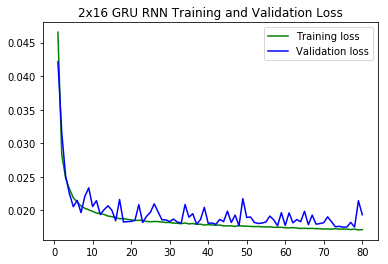

In [25]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)
plt.figure()
plt.plot(epochs, train_loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('2x16 GRU RNN Training and Validation Loss')
plt.legend()
plt.show()

In [37]:
min(train_loss)

0.017088956342866786

In [38]:
# print('Train MAE = %f\nValidation MAE = %f' % ((train_loss[-1] * (as5_train_df['PWM_30min_avg'].max() - as5_train_df['PWM_30min_avg'].min())),
#                                                (val_loss[-1] * (as5_train_df['PWM_30min_avg'].max() - as5_train_df['PWM_30min_avg'].min()))))
print('Train MAE = %f\nValidation MAE = %f' % ((min(train_loss) * (as5_train_df['PWM_30min_avg'].max() - as5_train_df['PWM_30min_avg'].min())),
                                               (min(val_loss) * (as5_train_df['PWM_30min_avg'].max() - as5_train_df['PWM_30min_avg'].min()))))

Train MAE = 1.817923
Validation MAE = 1.861494


In [27]:
as5_train_preds = model.predict_generator(gen_train, workers=4, use_multiprocessing=True)
as5_train_preds.shape

(18304, 1)

In [28]:
as5_train_preds_withnan = np.full((as5_train_split.shape[0] - delay, 1), np.NaN)
j = 0
for i in range(lookback, len(as5_train_split)):
    if as5_train_split[i, 0] > -1:
        as5_train_preds_withnan[i] = as5_train_preds[j]
        j += 1
as5_train_preds_withnan.shape

(20000, 1)

In [29]:
as5_val_preds = model.predict_generator(gen_val, workers=4, use_multiprocessing=True)
as5_val_preds.shape

(11223, 1)

In [30]:
as5_val_preds_withnan = np.full((as5_val_split.shape[0] - delay, 1), np.NaN)
j = 0
for i in range(lookback, len(as5_val_split)):
    if as5_val_split[i, 0] > -1:
        as5_val_preds_withnan[i] = as5_val_preds[j]
        j += 1
as5_val_preds_withnan.shape

(11616, 1)

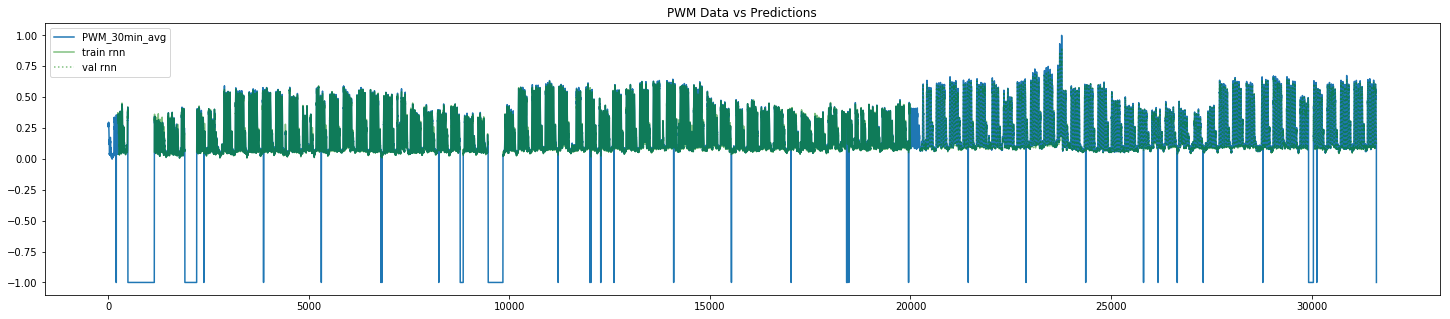

In [31]:
plt.figure(figsize=(25, 5))
plt.plot(range(as5_train_data.shape[0]), as5_train_data[:, 0], label='PWM_30min_avg')
plt.plot(range(as5_train_split.shape[0]), as5_train_preds_withnan.flatten(), color='green', alpha=.5, label='train rnn')
plt.plot(range(20000, 20000 + as5_val_split.shape[0]), as5_val_preds_withnan.flatten(), color='green', alpha=.5, label='val rnn', linestyle=':')
plt.title('PWM Data vs Predictions')
plt.legend()

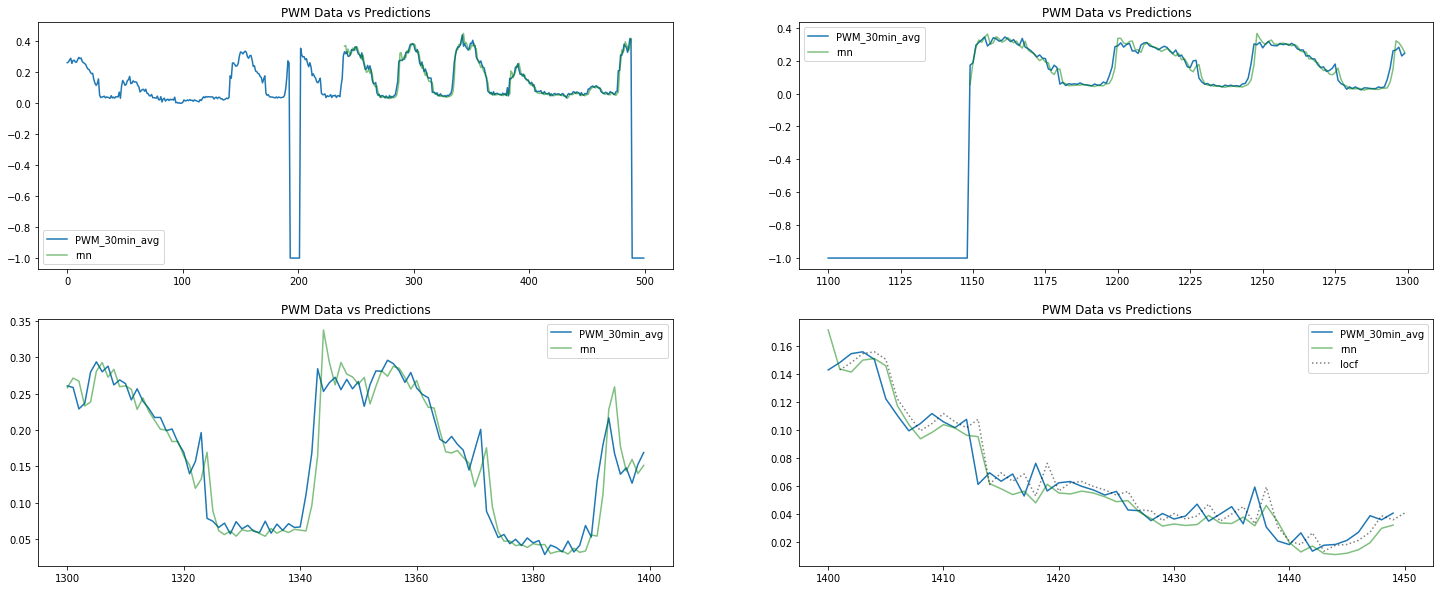

In [32]:
plt.figure(figsize=(25, 10))
plt.subplot(221)
plt.plot(range(500), as5_train_data[:500, 0], label='PWM_30min_avg')
plt.plot(range(500), as5_train_preds_withnan[:500, :].flatten(), color='green', alpha=.5, label='rnn')
plt.title('PWM Data vs Predictions')
plt.legend()
plt.subplot(222)
plt.plot(range(1100, 1300), as5_train_data[1100:1300, 0], label='PWM_30min_avg')
plt.plot(range(1100, 1300), as5_train_preds_withnan[1100:1300].flatten(), color='green', alpha=.5, label='rnn')
plt.title('PWM Data vs Predictions')
plt.legend()
plt.subplot(223)
plt.plot(range(1300, 1400), as5_train_data[1300:1400, 0], label='PWM_30min_avg')
plt.plot(range(1300, 1400), as5_train_preds_withnan[1300:1400].flatten(), color='green', alpha=.5, label='rnn')
plt.title('PWM Data vs Predictions')
plt.legend()
plt.subplot(224)
plt.plot(range(1400, 1450), as5_train_data[1400:1450, 0], label='PWM_30min_avg')
plt.plot(range(1400, 1450), as5_train_preds_withnan[1400:1450].flatten(), color='green', alpha=.5, label='rnn')
plt.plot(range(1401, 1451), as5_train_data[1400:1450, 0], color='black', alpha=.5, label='locf', linestyle=':')  ## locf is data with lag -1 
plt.title('PWM Data vs Predictions')
plt.legend()

In [33]:
model.save('base-2x16gru-nomask-val.h5')